## 🛠️ Getting started: Install packages & download models

The below cells will setup everything that is required to get started with model training:

* Install python specific packages
* Import required packages

In [1]:
# !pip install -q sklearn transformers datasets torch plotly sentencepiece tqdm pyspellchecker
!pip install sklearn
# !pip install accelerate -U
# !pip install transformers
!pip install transformers[torch]
!pip install datasets
!pip install torch
!pip install plotly
!pip install sentencepiece
!pip install tqdm
!pip install pyspellchecker

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 77.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from functools import reduce
from itertools import chain
from termcolor import colored

In [3]:
import time
import sys
import json
import shutil
import pandas as pd
from enum import Enum
import math
import torch
import os
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import BigBirdTokenizerFast, LongformerConfig,BigBirdConfig,BigBirdForSequenceClassification, RobertaTokenizer, RobertaForSequenceClassification, LongformerForSequenceClassification, TrainingArguments, Trainer, LongformerTokenizerFast,XLNetTokenizer,XLNetForSequenceClassification
from datasets import load_dataset

In [4]:
!nvidia-smi

Thu Jul  6 02:07:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
import gc
gc.collect()
torch.cuda.empty_cache() # PyTorch thing


In [6]:
import torch

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


/usr/local/lib/python3.10/dist-packages/torch/cuda/memory.py:416: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score, accuracy_score

eval_labels =[1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0]
eval_preds = [1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1]

f1 = f1_score(eval_labels, eval_preds, average='micro')
accuracy = accuracy_score(eval_labels, eval_preds)

print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')


F1 Score: 0.6458333333333334
Accuracy: 0.6458333333333334


In [ ]:
from sklearn.metrics import f1_score,accuracy_score,classification_report,confusion_matrix

eval_labels = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
eval_preds = [0, 0, 3, 0, 0, 3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

f1_micro = f1_score(eval_labels, eval_preds, average='micro')
f1_macro = f1_score(eval_labels, eval_preds, average='macro')
accuracy = accuracy_score(eval_labels, eval_preds)

print(f'F1 Score micro: {f1_micro}')
print(f'F1 Score macro: {f1_macro}')
print(f'Accuracy: {accuracy}')
print(classification_report(eval_labels, eval_preds))
confusion_matrix(eval_labels, eval_preds, labels=[0, 1, 2,3])

F1 Score micro: 0.8000000000000002
F1 Score macro: 0.7646273637374861
Accuracy: 0.8
              precision    recall  f1-score   support

           0       0.74      1.00      0.85        66
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        10
           3       1.00      0.12      0.21        26

    accuracy                           0.80       115
   macro avg       0.94      0.78      0.76       115
weighted avg       0.85      0.80      0.74       115



array([[66,  0,  0,  0],
       [ 0, 13,  0,  0],
       [ 0,  0, 10,  0],
       [23,  0,  0,  3]])

**CodeV Dataset**


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
import pyarrow as pa
import pyarrow.dataset as ds
import numpy as np
from datasets import Dataset
import pandas as pd

# output_dir = '/content/drive/My Drive/codev/juliet'
# train_df = pd.read_csv ('/content/drive/My Drive/codev/juliet/train.csv')
# dev_df = pd.read_csv ('/content/drive/My Drive/codev/juliet/dev.csv')
# att_df = pd.read_csv ('/content/drive/My Drive/codev/juliet/dev_att.csv')
# train_data = Dataset(pa.Table.from_pandas(train_df))
# test_data = Dataset(pa.Table.from_pandas(dev_df))

# train_data = train_data.rename_column("sentence", "text")
# test_data = test_data.rename_column("sentence", "text")
# train_data = train_data.rename_column("label4num", "label")
# test_data = test_data.rename_column("label4num", "label")

output_dir = '/content/drive/My Drive/codev/juliet/samples'
train_df = pd.read_csv (f'{output_dir}/train.csv')
dev_df = pd.read_csv (f'{output_dir}/two_sample_test_short.csv')
test_df = pd.read_csv (f'{output_dir}/test.csv')


# output_dir = '/content/drive/My Drive/codev/owasp'
# train_df = pd.read_csv ('/content/drive/My Drive/codev/owasp/train.csv')
# dev_df = pd.read_csv ('/content/drive/My Drive/codev/owasp/dev.csv')
# att_df = pd.read_csv ('/content/drive/My Drive/codev/owasp/dev_att.csv')

# train_data = Dataset(pa.Table.from_pandas(train_df))
# test_data = Dataset(pa.Table.from_pandas(dev_df))
# train_data = train_data.rename_column("sentense", "text")
# test_data = test_data.rename_column("sentense", "text")
# train_data = train_data.rename_column("label4num", "label")
# test_data = test_data.rename_column("label4num", "label")


# output_dir = '/content/drive/My Drive/codev/drapper'
# train_df = pd.read_csv ('/content/drive/My Drive/codevulnerability/xai0912owasp/drap_full_xlnet/train_num.csv')
# dev_df = pd.read_csv ('/content/drive/My Drive/codevulnerability/xai0912owasp/drap_full_xlnet/dev_num.csv')

# train_data = Dataset(pa.Table.from_pandas(train_df))
# test_data = Dataset(pa.Table.from_pandas(dev_df))
# train_data = train_data.rename_column("code", "text")
# test_data = test_data.rename_column("code", "text")

In [43]:
from sklearn.preprocessing import LabelEncoder

# Instantiate the encoder
le = LabelEncoder()

# Fit the encoder and transform the labels in the 'CWE' column
train_df['CWE'] = le.fit_transform(train_df['CWE'])

# Transform the labels in 'CWE' column for dev_df and test_df
dev_df['CWE'] = le.transform(dev_df['CWE'])
test_df['CWE'] = le.transform(test_df['CWE'])

# You can get the mapping with classes_ attribute of LabelEncoder
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(mapping)

train_data = Dataset(pa.Table.from_pandas(train_df))
test_data = Dataset(pa.Table.from_pandas(dev_df))

train_data = train_data.rename_column("code", "text")
test_data = test_data.rename_column("code", "text")
train_data = train_data.rename_column("CWE", "label")
test_data = test_data.rename_column("CWE", "label")


{'CWE15': 0, 'CWE23': 1, 'CWE36': 2, 'CWE500': 3, 'CWE566': 4, 'CWE601': 5, 'CWE643': 6, 'CWE690': 7, 'CWE78': 8, 'CWE789': 9, 'CWE80': 10, 'CWE81': 11, 'CWE83': 12, 'CWE89': 13}


In [ ]:
def sample_balanced_data(dataset, n_samples_per_label):
    df = dataset.to_pandas()
    unique_labels = df['label'].unique()
    num_labels = len(unique_labels)
    total_samples = n_samples_per_label * num_labels

    if total_samples > len(df):
        raise ValueError("The requested number of samples exceeds the number of available data points.")

    sampled_dataframes = []
    for label in unique_labels:
        label_df = df[df['label'] == label]
        sampled_label_df = label_df.sample(n_samples_per_label)
        sampled_dataframes.append(sampled_label_df)

    balanced_sampled_df = pd.concat(sampled_dataframes).sample(frac=1).reset_index(drop=True)
    return Dataset(pa.Table.from_pandas(balanced_sampled_df))

n_samples_per_label = 100  # Adjust this value based on the desired number of samples and the number of unique labels
test_data = sample_balanced_data(test_data, n_samples_per_label)


In [ ]:
dev_df

# 💥 Models

Run the cells below to redo the training of each model

🛎️ Disclaimer: this will take some time... So if you're a busy bee or a hurrying hippo, you can skip this section and load in the results from one of our runs smoothly and swiftly 😊!

## 💪 Training

In [ ]:
# def compute_metrics(pred):
#     labels = pred.label_ids
#     preds = pred.predictions[0].argmax(-1)
#     del pred
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
#     acc = accuracy_score(labels, preds)
#     print('accuracy', acc,'f1', f1,'precision', precision,'recall', recall)
#     return {
#         'accuracy': acc,
#         'f1': f1,
#         'precision': precision,
#         'recall': recall
#     }

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions[0].argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    print(f'precision {precision}, recall {recall}, f1 {f1}')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'labels':labels.tolist(),
        'preds': preds.tolist(),
        'Logits':pred.predictions[0].tolist()
    }

def train_and_evaluate(timing_run, model, identifier, tokenizer, train_ds, test_ds, max_length=1024):
    def tokenization(batched_text):
        return tokenizer(batched_text['text'], padding='max_length', truncation=True, max_length=min(max_length, tokenizer.model_max_length))

    # tokenizing both the training and test dataset
    train_ds = train_ds.map(tokenization,
                            batched=True,
                            batch_size=len(train_ds),
                            remove_columns=['text'])

    test_ds = test_ds.map(tokenization,
                          batched=True,
                          batch_size=len(test_ds),
                          remove_columns=['text'])

    train_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
    test_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

    parameters = model.num_parameters()

    # Set different number of steps for accuracy and timing runs
    logging_steps = 200 if timing_run else 10
    eval_steps = 300 if timing_run else 10
    max_steps = 200 if timing_run else 250

    training_args = TrainingArguments(
        # Set the batch sizes
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,

        # Apply efficiency tricks
        gradient_accumulation_steps=8,
        fp16=True,

        # steps paramters
        evaluation_strategy="steps",
        warmup_steps=0,
        eval_steps=eval_steps,
        max_steps=max_steps,
        logging_steps=logging_steps,

        # Optimizer parameters
        learning_rate=2e-4,

        # Finalization
        load_best_model_at_end=False if timing_run else True,
        metric_for_best_model='accuracy', # default value is validation loss, we want the model with the highest accuracy

        # Output locations
        output_dir='./{}'.format(identifier),
        run_name='{}'.format(identifier),
        logging_dir='./{}-logging'.format(identifier),
        log_level='warning',
        save_strategy="steps"
        # save_strategy="steps"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_ds,
        eval_dataset=test_ds,
    )
    start_time = time.time()
    trainer.train()
    duration = time.time() - start_time

    shutil.rmtree('./{}'.format(identifier))

    metrics = None
    if not timing_run:
        metrics = trainer.evaluate()

    return trainer, parameters, metrics, duration

In [ ]:
def run_training(timing_run, model, tokenizer, model_name, train_ds, test_ds, max_length=1024):
    torch.cuda.empty_cache()

    try:
        identifier = '{}-{}-{}'.format(model_name, max_length, 'timing' if timing_run else 'accuracy').lower()
        trainer, parameters, metrics, duration  = train_and_evaluate(timing_run, model, identifier, tokenizer, train_ds, test_ds, max_length)

        results_and_metrics = {
            "model_name": model_name,
            "parameters": parameters,
            "duration": duration,
            "metrics": metrics,
            'tokencount': str(max_length),
            'timing_run': timing_run
        }
        with open(f'{identifier}-results.json', "w") as fd:
            json.dump(results_and_metrics, fd)
        saved_dir = f"{output_dir}/samples/{model_name}"
        output_eval_file_json = os.path.join(output_dir, "", f'{identifier}-results.json')
        with open(output_eval_file_json, 'w') as fp:
            json.dump(results_and_metrics, fp)
        model.save_pretrained(saved_dir,saved_model=True)

    except RuntimeError:
        del trainer

    del model


In [ ]:
timing = True
gradient_checkpointing = True

for size in [512]:
    for model_name, tokenizer, model in [
        # (
            # 'XLNet',
            # XLNetTokenizer.from_pretrained('xlnet-base-cased'),
            # XLNetForSequenceClassification.from_pretrained('xlnet-base-cased',
            #                                                 # gradient_checkpointing=gradient_checkpointing,
            #                                                 output_attentions=True,
            #                                                 num_labels=4)
        # ),
        # Uncomment the below lines if you want to use these models
        # (
        #     'Longformer',
        #     LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096'),
        #     LongformerForSequenceClassification.from_pretrained('allenai/longformer-base-4096',
        #                                                         gradient_checkpointing=gradient_checkpointing,
        #                                                         attention_window=128,
        #                                                         output_attentions=True,
        #                                                         num_labels=14)
        # ),
        # (
        #     'Bigbird',
        #     BigBirdTokenizerFast.from_pretrained('google/bigbird-roberta-base'),
        #     BigBirdForSequenceClassification.from_pretrained('google/bigbird-roberta-base',
        #                                                      gradient_checkpointing=gradient_checkpointing,
        #                                                      output_attentions=True,
        #                                                      num_labels=14)
        # )
    ]:
        print(f"Training {model_name} on size {size}")
        run_training(timing, model, tokenizer, model_name, train_data, test_data, max_length=size)


Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BigBirdForSequenceClassifica

Training Bigbird on size 1024


Map:   0%|          | 0/512 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss


In [ ]:
model

BigBirdForSequenceClassification(
  (bert): BigBirdModel(
    (embeddings): BigBirdEmbeddings(
      (word_embeddings): Embedding(50358, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BigBirdEncoder(
      (layer): ModuleList(
        (0-11): 12 x BigBirdLayer(
          (attention): BigBirdAttention(
            (self): BigBirdBlockSparseAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): BigBirdSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [ ]:
model.save_pretrained(output_dir,saved_model=True)

## ⚾ Test dataset Prediction (Load Model from Drive) Not work in 2023

Training contains training and prediction.

But this part for loading model from drive and run test-dataset evaluation individually.

In 2023, as the transformer[torch] is update, the GPU RAM out of memerory more often.

In [ ]:
#Because the part of Attention have a problem of CUDA out of memories, so keep att here and load from drive.
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions[0].argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    del preds
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'labels':labels.tolist(),
        'preds': preds.tolist(),
        # 'Logits':pred.predictions[0].tolist()
    }


def evaluate_pred(timing_run, model, identifier, tokenizer, test_ds, max_length=1024):
    def tokenization(batched_text):
        return tokenizer(batched_text['text'], padding='max_length', truncation=True, max_length=min(max_length, tokenizer.model_max_length))

    test_ds = test_ds.map(tokenization,
                          batched=True,
                          batch_size=len(test_ds),
                          remove_columns=['text'])

    test_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

    parameters = model.num_parameters()

    logging_steps = 10
    eval_steps = 10
    max_steps = 250

    training_args = TrainingArguments(
        # Set the batch sizes
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,

        # Apply efficiency tricks
        gradient_accumulation_steps=8,
        fp16=True, #true when cuda

        # steps paramters
        evaluation_strategy="steps",
        warmup_steps=0,
        eval_steps=eval_steps,
        max_steps=max_steps,
        logging_steps=logging_steps,

        # Optimizer parameters
        learning_rate=2e-5,

        # Finalization
        load_best_model_at_end=False if timing_run else True,
        metric_for_best_model='accuracy', # default value is validation loss, we want the model with the highest accuracy

        # Output locations
        output_dir='./{}'.format(identifier),
        run_name='{}'.format(identifier),
        logging_dir='./{}-logging'.format(identifier),
        log_level='warning',
        save_strategy="steps"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        eval_dataset=test_ds,
    )
    shutil.rmtree('./{}'.format(identifier))

    metrics = None

    start_time = time.time()
    metrics = trainer.evaluate()
    duration = time.time() - start_time

    return trainer, parameters, metrics, duration

In [ ]:
def run_evaluation(model, tokenizer, model_name, test_ds, max_length=1024,task_name=''):
    timing_run = False
    torch.cuda.empty_cache()
    try:
        identifier = '{}-{}-{}'.format(model_name, max_length, task_name).lower()
        trainer, parameters, metrics, duration  = evaluate_pred(timing_run, model, identifier, tokenizer, test_ds, max_length)

        results_and_metrics = {
            "model_name": model_name,
            "parameters": parameters,
            "duration": duration,
            "metrics": metrics,
            'tokencount': str(max_length),
            'timing_run': timing_run
        }
        # print(results_and_metrics)

        output_eval_file_json = os.path.join(output_dir, "", f'{identifier}-results.json')
        with open(output_eval_file_json, 'w') as fp:
            json.dump(results_and_metrics, fp)

    except RuntimeError:
        del trainer

    del model

In [ ]:
gc.collect()
torch.cuda.empty_cache() # PyTorch thing

In [ ]:
import os, transformers
os.path.dirname(transformers.__file__)
from transformers import XLNetTokenizer,XLNetForSequenceClassification,XLNetConfig
from datasets import load_dataset
def evaluate_model_from_drive(model_name,output_dir,test_data,max_length,task_name=''):
  gc.collect()
  torch.cuda.empty_cache() # PyTorch thing

  MODEL_CLASSES = {
    "Longformer": (LongformerConfig, LongformerForSequenceClassification, LongformerTokenizerFast),
    "bigbird":(BigBirdConfig, BigBirdForSequenceClassification, BigBirdTokenizerFast),
    "XLNet":(XLNetConfig,XLNetForSequenceClassification,XLNetTokenizer)
  }
  config_class, model_class, tokenizer_class = MODEL_CLASSES[model_name]
  model_file = f"{output_dir}/{model_name}"
  model = model_class.from_pretrained(model_file)
  TOKENIZER_CLASSES = {
    "Longformer": LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096'),
    "bigbird": BigBirdTokenizerFast.from_pretrained('google/bigbird-roberta-base'),
    "XLNet": XLNetTokenizer.from_pretrained('xlnet-base-cased')
  }
  tokenizer = TOKENIZER_CLASSES[model_name]
  model.to(device='cuda')
  run_evaluation(model, tokenizer, model_name, test_data, max_length,task_name)
  gc.collect()
  torch.cuda.empty_cache() # PyTorch thing
  del model



In [ ]:
# !pip install transformers[torch]

In [ ]:
evaluate_model_from_drive('Longformer',output_dir,test_data,1024)

## ⚾ Test dataset Prediction (Load Model from Drive) 2023



In [ ]:
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import gc
import torch
from transformers import XLNetTokenizer, XLNetForSequenceClassification, XLNetConfig, BigBirdConfig, BigBirdForSequenceClassification, BigBirdTokenizerFast, LongformerConfig, LongformerForSequenceClassification, LongformerTokenizerFast
from datasets import load_dataset

def evaluate_with_custom_loop(model, identifier, tokenizer, eval_dataset, max_length=1024, device='cuda'):
    def tokenization(batched_text):
        return tokenizer(batched_text['text'], padding='max_length', truncation=True, max_length=min(max_length, tokenizer.model_max_length))

    eval_dataset = eval_dataset.map(tokenization,
                          batched=True,
                          batch_size=len(eval_dataset),
                          remove_columns=['text'])

    eval_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

    dataloader = DataLoader(eval_dataset, batch_size=2)
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits.argmax(-1).cpu().numpy()
            all_preds.extend(preds.tolist())  # Convert numpy array to list
            all_labels.extend(labels.cpu().numpy().tolist())  # Convert numpy array to list
    print('pred_results',all_labels, all_preds)
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=1)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(all_labels, all_preds, average='micro', zero_division=1)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro', zero_division=1)
    acc = accuracy_score(all_labels, all_preds)

    metrics = {
        'weighted': {
            'accuracy': acc,
            'f1': f1_weighted,
            'precision': precision_weighted,
            'recall': recall_weighted,
        },
        'micro': {
            'f1': f1_micro,
            'precision': precision_micro,
            'recall': recall_micro,
        },
        'macro': {
            'f1': f1_macro,
            'precision': precision_macro,
            'recall': recall_macro,
        }
    }
    print(metrics)

    pred_labels_and_ground_truth = {
        'predicted_labels': all_preds,
        'ground_truth_labels': all_labels
    }

    return metrics, pred_labels_and_ground_truth



def run_evaluation(model, tokenizer, model_name, test_ds, max_length=1024, task_name='', output_dir=''):
    timing_run = False
    torch.cuda.empty_cache()
    print('run_evaluation')
    try:
        identifier = '{}-{}-{}'.format(model_name, max_length, task_name).lower()

        print('Run evaluation with the custom loop')
        metrics,labels = evaluate_with_custom_loop(model, identifier, tokenizer, test_ds, max_length)
        duration = 0

        results_and_metrics = {
            "model_name": model_name,
            "duration": duration,
            "metrics": metrics,
            "labels":labels,
            'tokencount': str(max_length),
            'timing_run': timing_run
        }

        output_eval_file_json = os.path.join(output_dir, f'{identifier}-results.json')
        with open(output_eval_file_json, 'w') as fp:
            json.dump(results_and_metrics, fp)

    except RuntimeError:
        print("An error occurred during evaluation.")
        torch.cuda.empty_cache()

    del model

def evaluate_model_from_drive(model_name, output_dir, test_data, max_length, task_name=''):
    gc.collect()
    torch.cuda.empty_cache()

    MODEL_CLASSES = {
        "Longformer": (LongformerConfig, LongformerForSequenceClassification, LongformerTokenizerFast),
        "Bigbird":(BigBirdConfig, BigBirdForSequenceClassification, BigBirdTokenizerFast),
        "XLNet":(XLNetConfig,XLNetForSequenceClassification,XLNetTokenizer)
    }
    config_class, model_class, tokenizer_class = MODEL_CLASSES[model_name]
    model_file = f"{output_dir}/samples/{model_name}"
    model = model_class.from_pretrained(model_file)
    print(f'load_model from {model_file}')
    TOKENIZER_CLASSES = {
      "Longformer": LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096'),
      "Bigbird": BigBirdTokenizerFast.from_pretrained('google/bigbird-roberta-base'),
      "XLNet": XLNetTokenizer.from_pretrained('xlnet-base-cased')
    }
    tokenizer = TOKENIZER_CLASSES[model_name]
    model.to(device='cuda')
    print('run_eval')
    run_evaluation(model, tokenizer, model_name, test_data, max_length, task_name, model_file)
    gc.collect()
    torch.cuda.empty_cache()
    del model


In [ ]:
# sample:
# label: {'CWE15': 0, 'CWE23': 1, 'CWE36': 2, 'CWE500': 3, 'CWE566': 4, 'CWE601': 5, 'CWE643': 6, 'CWE690': 7, 'CWE78': 8, 'CWE789': 9, 'CWE80': 10, 'CWE81': 11, 'CWE83': 12, 'CWE89': 13}
evaluate_model_from_drive('Longformer',output_dir,test_data,4096)

load_model from /content/drive/My Drive/codev/juliet/samples/samples/Longformer
run_eval
run_evaluation
Run evaluation with the custom loop


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

pred_results [1, 2] [2, 2]
{'weighted': {'accuracy': 0.5, 'f1': 0.3333333333333333, 'precision': 0.75, 'recall': 0.5}, 'micro': {'f1': 0.5, 'precision': 0.5, 'recall': 0.5}, 'macro': {'f1': 0.3333333333333333, 'precision': 0.75, 'recall': 0.5}}


In [ ]:
evaluate_model_from_drive('Longformer',output_dir,test_data,4096)

load_model from /content/drive/My Drive/codev/juliet/samples/samples/Longformer
run_eval
run_evaluation
Run evaluation with the custom loop


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

pred_results [1, 2] [2, 2]
{'weighted': {'accuracy': 0.5, 'f1': 0.3333333333333333, 'precision': 0.75, 'recall': 0.5}, 'micro': {'f1': 0.5, 'precision': 0.5, 'recall': 0.5}, 'macro': {'f1': 0.3333333333333333, 'precision': 0.75, 'recall': 0.5}}


In [ ]:
evaluate_model_from_drive('XLNet',output_dir,test_data,1024)

In [ ]:
evaluate_model_from_drive('Longformer',output_dir,test_data,4096)

load_model from /content/drive/My Drive/codev/owasp/Longformer/4096
run_eval
run_evaluation
Run evaluation with the custom loop


Map:   0%|          | 0/344 [00:00<?, ? examples/s]

load batch
{'weighted': {'accuracy': 0.3808139534883721, 'f1': 0.21004895960832315, 'precision': 0.7642053136830719, 'recall': 0.3808139534883721}, 'micro': {'f1': 0.3808139534883721, 'precision': 0.3808139534883721, 'recall': 0.3808139534883721}, 'macro': {'f1': 0.13789473684210526, 'precision': 0.845203488372093, 'recall': 0.25}}


In [ ]:
evaluate_model_from_drive('Longformer',output_dir,test_data,1024)

In [ ]:
evaluate_model_from_drive('Longformer',output_dir,test_data,1024)

load_model from /content/drive/My Drive/codev/juliet/Longformer
run_eval
run_evaluation
Run evaluation with the custom loop


Map:   0%|          | 0/115 [00:00<?, ? examples/s]

load batch
{'weighted': {'accuracy': 0.6869565217391305, 'f1': 0.5639751552795031, 'precision': 0.7974424552429669, 'recall': 0.6869565217391305}, 'micro': {'f1': 0.6869565217391305, 'precision': 0.6869565217391305, 'recall': 0.6869565217391305}, 'macro': {'f1': 0.44642857142857145, 'precision': 0.9117647058823529, 'recall': 0.5}}


In [ ]:
evaluate_model_from_drive('Bigbird',output_dir,test_data,4096)

load_model from /content/drive/My Drive/codev/owasp/Bigbird/4096


run_eval
run_evaluation
Run evaluation with the custom loop


Map:   0%|          | 0/344 [00:00<?, ? examples/s]

load batch
{'weighted': {'accuracy': 0.3808139534883721, 'f1': 0.21004895960832315, 'precision': 0.7642053136830719, 'recall': 0.3808139534883721}, 'micro': {'f1': 0.3808139534883721, 'precision': 0.3808139534883721, 'recall': 0.3808139534883721}, 'macro': {'f1': 0.13789473684210526, 'precision': 0.845203488372093, 'recall': 0.25}}


In [ ]:
evaluate_model_from_drive('Bigbird',output_dir,test_data,1024)

load_model from /content/drive/My Drive/codev/owasp/Bigbird/1024
run_eval
run_evaluation
Run evaluation with the custom loop


Map:   0%|          | 0/344 [00:00<?, ? examples/s]

load batch
{'weighted': {'accuracy': 0.3808139534883721, 'f1': 0.21004895960832315, 'precision': 0.7642053136830719, 'recall': 0.3808139534883721}, 'micro': {'f1': 0.3808139534883721, 'precision': 0.3808139534883721, 'recall': 0.3808139534883721}, 'macro': {'f1': 0.13789473684210526, 'precision': 0.845203488372093, 'recall': 0.25}}


## Print_Samples

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from termcolor import colored

def print_colored_text(text, score):
    color_intensity = min(int(score * 255), 255)
    if color_intensity > 128:
        print(colored(text, 'white', 'on_red'), end =' ')
    else:
        print(colored(text, 'grey', 'on_white'), end =' ')

def evaluate_with_custom_loop(model, tokenizer, eval_dataset, max_length=1024, device='cuda'):
    def tokenization(batched_text):
        return tokenizer(batched_text['text'], padding='max_length', truncation=True, max_length=min(max_length, tokenizer.model_max_length))
    print(eval_dataset)
    eval_dataset = eval_dataset.map(tokenization,
                          batched=True,
                          batch_size=len(eval_dataset),
                          remove_columns=['text'])

    eval_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

    dataloader = DataLoader(eval_dataset, batch_size=2)
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []
    highlight_info = {}

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            print(input_ids)
            # Output_attentions set to True to obtain attention scores
            outputs = model(input_ids, attention_mask=attention_mask, output_attentions=True, labels=labels)
            preds = outputs.logits.argmax(-1).cpu().numpy()
            all_preds.extend(preds.tolist())  # Convert numpy array to list
            all_labels.extend(labels.cpu().numpy().tolist())  # Convert numpy array to list
            print('id',np.shape(input_ids))
            # Attention visualization
            multi_att_list = outputs.global_attentions[0].squeeze(0).cpu().detach().numpy()  # shape (2, 12, 1024, 1)
            attention_weights = multi_att_list.sum(axis=1)  # shape (2, 1024, 1)

            # print('att_weight',np.shape(attention_weights))
            # attention_weights = attention_weights / attention_weights.sum(axis=-1, keepdims=True)  # normalize the attention weights
            # print('attention_weights',attention_weights)

            for sample, input_id in enumerate(input_ids):
                orginal_code = []
                tokens = []
                attention_score = []
                for i, idx in enumerate(input_id):
                    token = tokenizer.convert_ids_to_tokens([idx.item()])[0]  # Use item() to convert tensor to Python integer
                    text = tokenizer.convert_tokens_to_string([token])  # Convert token to string
                    tokens.append(token)
                    orginal_code.append(text)
                    attention_score.append(attention_weights[sample][i])
                    # print_colored_text(text, attention_weights[sample][i])
                text = tokenizer.convert_tokens_to_string(tokens)
                highlight_info[sample]={'code':text, 'token':orginal_code,'attention':attention_score}
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=1)
    acc = accuracy_score(all_labels, all_preds)

    metrics = {
        'weighted': {
            'accuracy': acc,
            'f1': f1_weighted,
            'precision': precision_weighted,
            'recall': recall_weighted,
        }
    }
    print(metrics)

    pred_labels_and_ground_truth = {
        'predicted_labels': all_preds,
        'ground_truth_labels': all_labels
    }

    return metrics, pred_labels_and_ground_truth,highlight_info


def show_attentions(model_name, output_dir, test_data, max_length, task_name=''):
    gc.collect()
    torch.cuda.empty_cache()

    MODEL_CLASSES = {
        "Longformer": (LongformerConfig, LongformerForSequenceClassification, LongformerTokenizerFast),
        "Bigbird":(BigBirdConfig, BigBirdForSequenceClassification, BigBirdTokenizerFast),
    }
    config_class, model_class, tokenizer_class = MODEL_CLASSES[model_name]
    model_file = f"{output_dir}/samples/{model_name}"
    print('model_file', model_file)
    model = model_class.from_pretrained(model_file)

    TOKENIZER_CLASSES = {
      "Longformer": LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096'),
      "Bigbird": BigBirdTokenizerFast.from_pretrained('google/bigbird-roberta-base'),
    }
    tokenizer = TOKENIZER_CLASSES[model_name]
    model.to(device='cuda')
    _,_, info = evaluate_with_custom_loop(model, tokenizer, test_data, max_length)
    gc.collect()
    torch.cuda.empty_cache()
    del model
    return info


In [45]:
output_dir

'/content/drive/My Drive/codev/juliet/samples'

In [46]:
info = show_attentions('Longformer',output_dir,test_data,1024)

model_file /content/drive/My Drive/codev/juliet/samples/samples/Longformer
Dataset({
    features: ['text', 'label'],
    num_rows: 2
})


Map:   0%|          | 0/2 [00:00<?, ? examples/s]

tensor([[    0, 46181,  1296,  ...,     1,     1,     1],
        [    0, 46181,  1296,  ...,     1,     1,     1]], device='cuda:0')
id torch.Size([2, 1024])
{'weighted': {'accuracy': 0.0, 'f1': 0.0, 'precision': 1.0, 'recall': 0.0}}


In [47]:
!pip install colorama

In [ ]:
from colorama import Fore, Back, Style
import numpy as np

def print_colored_code(code_dict):
    # Obtain the indexes where token is not equal to '<s>' or ' '
    indexes = [i for i, token in enumerate(code_dict['token']) if token not in {'<s>', ' '}]

    # Filter the token and attention lists using these indexes
    tokens = [code_dict['token'][i] for i in indexes]
    attention = [code_dict['attention'][i] for i in indexes]

    # Normalize the attention values to the range 0-1
    attention_values = [x[0] for x in attention]  # extract attention values
    normalized_attention = (attention_values - np.min(attention_values)) / (np.max(attention_values) - np.min(attention_values))

    for token, att in zip(tokens, normalized_attention):
        if att < 0.2:
            print(Fore.BLACK + token, end='')
        elif att < 0.4:
            print(Fore.BLUE + token, end='')
        elif att < 0.6:
            print(Fore.GREEN + token, end='')
        elif att < 0.8:
            print(Fore.YELLOW + token, end='')
        else:
            print(Fore.RED + token, end='')

    print(Style.RESET_ALL)  # reset to default color

print_colored_code(info[0])



package testcases._Relative_Path_Traversal;

public class _Relative_Path_Traversal__connect_tcp_81_bad extends _Relative_Path_Traversal__connect_tcp_81_base {

 public void action(String data) throws Throwable {
 String root;
 root = "/home/user/uploads/";
 if (data != null) {
 File file = new File(root + data);
 FileInputStream streamFileInputSink = null;
 InputStreamReader readerInputStreamSink = null;
 BufferedReader readerBufferdSink = null;
 if (file.exists() && file.isFile()) {
 }
 }
 }
 }
</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [22]:
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt

def gradient_color(value):
    cmap = plt.get_cmap("viridis")  # use any matplotlib colormap here
    rgba = cmap(value, bytes=True)
    return '#%02X%02X%02X' % (rgba[0], rgba[1], rgba[2])
    # def gradient_color(score):
    # max_color = np.array([204, 229, 255])  # light blue
    # min_color = np.array([255, 255, 255])  # white
    # color = min_color + score * (max_color - min_color)  # interpolate between min and max color
    # return f'rgb({color[0]}, {color[1]}, {color[2]})'


def print_colored_code_html(code_dict):
    # Obtain the indexes where token is not equal to '<s>' or ' '
    indexes = [i for i, token in enumerate(code_dict['token']) if token not in {'<s>', ' '}]

    # Filter the token and attention lists using these indexes
    tokens = [code_dict['token'][i] for i in indexes]
    attention = [code_dict['attention'][i] for i in indexes]

    # Normalize the attention values to the range 0-1
    attention_values = [x[0] for x in attention]  # extract attention values
    normalized_attention = (attention_values - np.min(attention_values)) / (np.max(attention_values) - np.min(attention_values))

    # Convert tokens and attention scores to HTML
    html = "".join(f'<span style="color: {gradient_color(att)}">{token}</span>' for token, att in zip(tokens, normalized_attention))
    display(HTML(html))  # display HTML

print_colored_code_html(info[0])


In [48]:
import matplotlib as mpl
import matplotlib.pyplot as plt
# def gradient_color(score):
#     max_color = np.array([0, 0, 0])  # DarkGray
#     min_color = np.array([255, 255, 255])  # White
#     color = min_color + score * (max_color - min_color)  # interpolate between min and max color
#     return f'rgb({int(color[0])}, {int(color[1])}, {int(color[2])})'
def gradient_color(value):
    cmap = plt.get_cmap("coolwarm")  # use any matplotlib colormap here
    rgba = cmap(value, bytes=True)
    return '#%02X%02X%02X' % (rgba[0], rgba[1], rgba[2])

# def plot_colorbar():
#     fig, ax = plt.subplots(figsize=(6, 1))
#     fig.subplots_adjust(bottom=0.5)

#     cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["white", "darkgray"])

#     cbar = mpl.colorbar.ColorbarBase(ax, cmap=cmap, orientation='horizontal')
#     cbar.set_label('Attention Score')
#     plt.show()

def plot_colorbar():
    fig, ax = plt.subplots(figsize=(6, 0.3))
    fig.subplots_adjust(bottom=0.5)

    cmap = plt.get_cmap("coolwarm")  # Match the colorbar with the heatmap colormap

    cbar = mpl.colorbar.ColorbarBase(ax, cmap=cmap, orientation='horizontal')
    cbar.set_label('Attention Score')
    plt.show()

def print_colored_code_html(code_dict):
    # Obtain the indexes where token is not equal to '<s>' or ' '
    indexes = [i for i, token in enumerate(code_dict['token']) if token not in {'<s>', ' ', '}'}]

    # Filter the token and attention lists using these indexes
    tokens = [code_dict['token'][i] for i in indexes]
    attention = [code_dict['attention'][i] for i in indexes]

    # Normalize the attention values to the range 0-1
    attention_values = [x[0] for x in attention]  # extract attention values
    normalized_attention = (attention_values - np.min(attention_values)) / (np.max(attention_values) - np.min(attention_values))

    # Convert tokens and attention scores to HTML
    html = "<p style='width: 800px; word-wrap: break-word;'>"
    for token, att in zip(tokens, normalized_attention):
        html += f'<span style="background-color: {gradient_color(att)}">{token}</span>'
        if token.strip() in {';', '; ','{','extends'}:
            html += '<br>'
    html += "</p>"

    display(HTML(html))  # display HTML


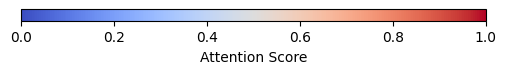

In [49]:
print_colored_code_html(info[0])

print_colored_code_html(info[1])
plot_colorbar()

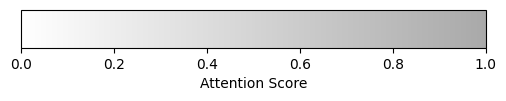

In [ ]:
print_colored_code_html(info[0])

print_colored_code_html(info[1])
plot_colorbar()


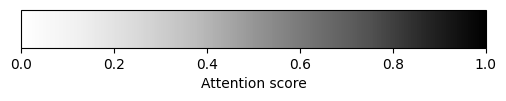

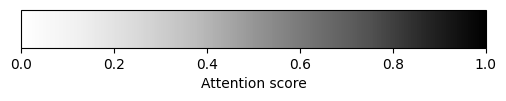

In [ ]:

print_colored_code_html(info[0])
plot_colorbar()

print_colored_code_html(info[1])
plot_colorbar()


# 👻: Attentions

Generate self-attention from model for the test instances.

instance->model->attention->high attention content->masking high_att->predictions

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

In [ ]:
def show_GPU():
  GPUs = GPU.getGPUs()
  # XXX: only one GPU on Colab and isn’t guaranteed
  gpu = GPUs[0]
  def printm():
      process = psutil.Process(os.getpid())
      print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
      print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
  printm()
show_GPU()

Gen RAM Free: 24.1 GB  |     Proc size: 4.2 GB
GPU RAM Free: 10757MB | Used: 4352MB | Util  29% | Total     15109MB


In [ ]:
head_num = 12
precentitle_thrd_up = 100
precentitle_thrd_down = 90
max_length = 512
start_idx,end_idx = 27,29

In [ ]:
tokenizer = LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096')

In [ ]:
import os, transformers
os.path.dirname(transformers.__file__)

MODEL_CLASSES = {
    "Longformer": (LongformerConfig, LongformerForSequenceClassification, LongformerTokenizerFast),
}
model_type='Longformer'
config_class, model_class, tokenizer_class = MODEL_CLASSES[model_type]
model = model_class.from_pretrained(output_dir)
# tokenizer = tokenizer_class.from_pretrained(output_dir)
model.to(device='cuda')

LongformerForSequenceClassification(
  (longformer): LongformerModel(
    (embeddings): LongformerEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(4098, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LongformerEncoder(
      (layer): ModuleList(
        (0): LongformerLayer(
          (attention): LongformerAttention(
            (self): LongformerSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (val

In [ ]:
#@title Get_Att Cuda problem not use yet
def string_cleaning(string):
  string = list(filter(lambda val: val!=" ",string))
  string = list(filter(lambda val: val!=" *",string))
  string = list(filter(lambda val: val!="\n",string))
  string = list(filter(lambda val: val!="\r",string))
  string = list(filter(lambda val: val!="/*",string))
  string = list(filter(lambda val: val!="_",string))
  string = list(filter(lambda val: val!=".",string))
  string = list(filter(lambda val: val!=";",string))
  string = list(filter(lambda val: val!=":",string))
  string = list(filter(lambda val: val!="{",string))
  string = list(filter(lambda val: val!="}",string))
  return string

def get_model_output_att(model,code,label_list):
  show_GPU()
  inputs = tokenizer(code, return_tensors="pt").to(device='cuda')
  labels = torch.tensor(label_list).unsqueeze(0).to(device='cuda')
  # outputs = model(**inputs, labels=labels)
  # multi_att = outputs.global_attentions[0][0].squeeze(0).cpu().detach().numpy()
  outputs = model(**inputs, labels=labels).global_attentions[0][0]
  multi_att = outputs.squeeze(0).cpu().detach().numpy()
  del inputs
  del labels
  del outputs
  del model
  show_GPU()
  torch.cuda.empty_cache()
  return multi_att

def get_word_att_precentitle(model,code,label_list):
  multi_att = get_model_output_att(model,code,label_list)
  show_GPU()
  word_att = np.average(multi_att.reshape((head_num,-1)),axis = 0)
  precentitle = np.percentile(word_att, precentitle_thrd)
  precentitle_index = np.where(word_att > precentitle)
  precentitle_index = precentitle_index[0] + 1
  word_att_p = np.take(word_att,precentitle_index)
  return precentitle,precentitle_index,word_att_p

def get_high_att_tokenid(input_id,precentitle_index):
  token_list = []
  print(precentitle_index)
  for index in precentitle_index:
    if index < len(input_id):
      token_list.append(input_id[index].cpu().detach().numpy().tolist())
  return token_list

def get_high_att_string(token_id_list):
  string = []
  for idx in token_id_list:
    string.append(tokenizer.convert_tokens_to_string(tokenizer._convert_id_to_token(idx)))
    string = string_cleaning(string)
  return string

def get_high_att_token_string(model,code,label_list):
  code = string_cleaning(code)
  precentitle,precentitle_index,word_att_p = get_word_att_precentitle(model,code,label_list)
  # input_id = tokenizer(code, return_tensors="pt").to(device='cuda')['input_ids'][0]
  input_id = tokenizer(code, return_tensors="pt")['input_ids'][0]
  token_id_list = get_high_att_tokenid(input_id,precentitle_index)
  del input_id
  high_att_string = get_high_att_string(token_id_list)
  return high_att_string

high_att_string = get_high_att_token_string(model,dev_df['sentence'][0],[1])
high_att_string


In [ ]:
import gc
import re
def string_cleaning(string_list):
  string_new_list = []
  for i in range(0,len(string_list)):
    string = string_list[i]
    string = re.sub(r'[*\n\r/*_;:{}/T]', '', string)
    string_new_list.append(string)
  return string_new_list

def string_cleaning_symbol(string_list):
  string_new_list = []
  for i in range(0,len(string_list)):
    string = string_list[i]
    string = re.sub(r'[. ()]', '', string)
    string_new_list.append(string)
  return string_new_list


def get_data_batch(dev_df,start_idx,end_idx):
  code = dev_df['code'][start_idx:end_idx].tolist()
  label_list = dev_df['label'][start_idx:end_idx].tolist()
  return code,label_list

def get_batch_outputs(dev_df,start_idx,end_idx):
  code,label_list = get_data_batch(dev_df,start_idx,end_idx)
  code = string_cleaning(code)

  inputs = tokenizer(code,padding='max_length', truncation=True, max_length=min(max_length, tokenizer.model_max_length), return_tensors="pt").to(device='cuda')
  labels = torch.tensor(label_list).unsqueeze(0).to(device='cuda')
  outputs = model(**inputs, labels=labels)
  multi_att_list = outputs.global_attentions[0].squeeze(0).cpu().detach().numpy()
  input_ids_list = inputs['input_ids'].squeeze(0).cpu().detach().numpy()
  del inputs
  del outputs
  del labels
  gc.collect()
  torch.cuda.empty_cache() # PyTorch thing
  show_GPU()
  return multi_att_list,input_ids_list

In [ ]:
def get_word_att_precentitle(multi_att,precentitle_thrd):
  word_att = np.average(multi_att.reshape((head_num,-1)),axis = 0)
  hold = 10-(precentitle_thrd%10)
  precentitle_u = np.percentile(word_att, precentitle_thrd+hold)
  precentitle_d = np.percentile(word_att, precentitle_thrd)
  precentitle_index = np.where(np.logical_and(word_att>=precentitle_d, word_att<=precentitle_u))
  precentitle_index = precentitle_index[0]
  try:
    word_att_p = np.take(word_att,precentitle_index)
  except:
    print(precentitle_index)

  return precentitle_index,word_att_p

def get_high_att_tokenid(input_id,precentitle_index):
  token_list = []
  for index in precentitle_index:
    if index < len(input_id):
      token_list.append(input_id[index])
  return token_list

def get_high_att_string(token_id_list):
  string = []
  for idx in token_id_list:
    string.append(tokenizer.convert_tokens_to_string(tokenizer._convert_id_to_token(idx)))
    string = string_cleaning_symbol(string)
  return string

def compile_att_dict(high_att_string,word_att_p):
  return {high_att_string[i]: word_att_p[i] for i in range(len(high_att_string))}

def get_high_att_token_string(multi_att_list,input_ids_list,precentitle_thrd):
  count = 0
  high_att_string_list = []
  att_dict_list = []
  for multi_att in multi_att_list:
    precentitle_index,word_att_p = get_word_att_precentitle(multi_att,precentitle_thrd)
    token_id_list = get_high_att_tokenid(input_ids_list[count],precentitle_index)
    high_att_string = get_high_att_string(token_id_list)
    att_dict = compile_att_dict(high_att_string,word_att_p)
    high_att_string_list.append(high_att_string)
    att_dict_list.append(att_dict)
    count += 1
  # return high_att_string_list,word_att_p
  return att_dict_list,high_att_string_list

def get_att_dict_list_batch(dev_df,start_idx,end_idx,precentitle_thrd):
  multi_att_list,input_ids_list = get_batch_outputs(dev_df,start_idx,end_idx)
  att_dict_list,high_att_string_list = get_high_att_token_string(multi_att_list,input_ids_list,precentitle_thrd)
  return att_dict_list,high_att_string_list

# att_dict_list,high_att_string_list = get_att_dict_list_batch(dev_df,27,29,95)
# att_dict_list

In [ ]:
from functools import reduce
from itertools import chain
import re

def highlight_many(text, keywords):
    replacement = lambda match: "\033[91m" + match.group() + "\033[39m"
    text = re.sub(r'[\r]', '', text)
    text = re.sub("|".join(map(re.escape, keywords)), replacement, text, flags=re.I)
    print(text)

def visualization_attwords_incode(start_idx,end_idx,dev_df,get_att_dict_list=90):
  # attention_string_list,logits_list = get_instances_examples(start_idx,end_idx,model,dev_df)
  att_dict_list,_ = get_att_dict_list_batch(dev_df,start_idx,end_idx,get_att_dict_list)
  for att_dict in att_dict_list:
    text = dev_df['code'][start_idx]
    l1 = [x.lower() for x in att_dict.keys() if isinstance(x,str)]
    tuple1=zip(att_dict.values(),att_dict.keys())
    c=sorted(tuple1,reverse=True)
    print(c,'\n','*****************************')
    highlight_many(text, l1)
    # print(reduce(lambda t, x: t.replace(*x), chain([text.lower()], ((t, colored(t,'white','on_red')) for t in l1))))
    print('*****************************')
    start_idx +=1
  return

visualization_attwords_incode(165,167,dev_df,95)


Gen RAM Free: 24.0 GB  |     Proc size: 10.5 GB
GPU RAM Free: 11213MB | Used: 3896MB | Util  26% | Total     15109MB
[(0.110217534, '<s>'), (0.0072395722, 'fp'), (0.0056393505, 'sizeof'), (0.0053077233, 'NULL'), (0.004969208, 'ptr'), (0.0047545847, 'len'), (0.004025313, '\t')] 
 *****************************
el_source(EditLine *el, const char *fname)
{
	FILE *fp;
	size_t len;
	char *ptr;
	char *path = NULL;
	const Char *dptr;
	int error = 0;

	fp = NULL;
	if (fname == NULL) {
		static const char elpath[] = "/.editrc";
		size_t plen = sizeof(elpath);

		if ((ptr = secure_getenv("HOME")) == NULL)
			return -1;
		plen += strlen(ptr);
		if ((path = el_malloc(plen * sizeof(*path))) == NULL)
			return -1;
		(void)snprintf(path, plen, "%s%s", ptr, elpath);
		fname = path;
	}
	if (fp == NULL)
		fp = fopen(fname, "r");
	if (fp == NULL) {
		el_free(path);
		return -1;
	}

	while ((ptr = fgetln(fp, &len)) != NULL) {
		if (*ptr == '\n')
			continue;	/* Empty line. */
		dptr = ct_decode_string(ptr,

In [ ]:
from functools import reduce
from itertools import chain
import re

def highlight_many(text, keywords):
    replacement = lambda match: "\033[91m" + match.group() + "\033[39m"
    text = re.sub(r'[\r]', '', text)
    text = re.sub("|".join(map(re.escape, keywords)), replacement, text, flags=re.I)
    print(text)

def visualization_attwords_incode(start_idx,end_idx,dev_df,get_att_dict_list=90):
  # attention_string_list,logits_list = get_instances_examples(start_idx,end_idx,model,dev_df)
  att_dict_list,_ = get_att_dict_list_batch(dev_df,start_idx,end_idx,get_att_dict_list)
  for att_dict in att_dict_list:
    text = dev_df['sentense'][start_idx]
    l1 = [x.lower() for x in att_dict.keys() if isinstance(x,str)]
    tuple1=zip(att_dict.values(),att_dict.keys())
    c=sorted(tuple1,reverse=True)
    print(c,'\n','*****************************')
    highlight_many(text, l1)
    # print(reduce(lambda t, x: t.replace(*x), chain([text.lower()], ((t, colored(t,'white','on_red')) for t in l1))))
    print('*****************************')
    start_idx +=1
  return

visualization_attwords_incode(165,167,dev_df,95)


NameError: ignored

In [ ]:

visualization_attwords_incode(165,167,dev_df,95)

Gen RAM Free: 23.8 GB  |     Proc size: 4.3 GB
GPU RAM Free: 14159MB | Used: 2121MB | Util  13% | Total     16280MB
[(0.10240676, '<s>'), (0.0059520868, 'public'), (0.0055661425, 'Object'), (0.0037368555, '\t'), (0.0037103083, 'Exception'), (0.003488101, 'asp')] 
 *****************************
/**
* OWASP Benchmark v1.2
*
* This file is part of the Open Web Application Security Project (OWASP)
* Benchmark Project. For details, please see
* <a href="https://www.owasp.org/index.php/Benchmark">https://www.owasp.org/index.php/Benchmark</a>.
*
* The OWASP Benchmark is free software: you can redistribute it and/or modify it under the terms
* of the GNU General Public License as published by the Free Software Foundation, version 2.
*
* The OWASP Benchmark is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without
* even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
* GNU General Public License for more details.
*
* @author Dave 

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache() # PyTorch thing

# 👻: Mask_Attentions

Mask attention words and re-prediction.

In [ ]:
import pyarrow as pa
import pyarrow.dataset as ds
import numpy as np
import pandas as pd
from datasets import Dataset

# OWASP
# output_dir = '/content/drive/My Drive/codev/owasp/'
# dev_df = pd.read_csv ('/content/drive/My Drive/codev/owasp/dev_att.csv')

#Drapper
output_dir = '/content/drive/My Drive/codev/drapper'
dev_df = pd.read_csv ('/content/drive/My Drive/codev/drapper/drapperdev_att.csv')
# dev_df = pd.read_csv ('/content/drive/My Drive/codevulnerability/xai0912owasp/drap_full_xlnet/dev_num.csv')

In [ ]:
def get_full_att_list(dev_df,precentitle_thrd):
  batch_size = 5
  worklist = dev_df
  count = 0
  att_dict_list = []
  for i in range(0, len(worklist), batch_size):
    # batch = worklist[i:i+batch_size] # the result might be shorter than batchsize at the end
    att_dict,_=get_att_dict_list_batch(dev_df,i,i+batch_size,precentitle_thrd)
    att_dict_list = att_dict_list+att_dict
    gc.collect()
    torch.cuda.empty_cache() # PyTorch thing
    show_GPU()
  #   count = i+batch_size
  # print(count)
  # att_dict_list.append(get_att_dict_list_batch(dev_df,count,len(worklist)-1))
  return att_dict_list
att_dict_list = get_full_att_list(dev_df,90)

NameError: ignored

In [ ]:
def get_all_att_strings(dev_df):
  for i in range(0,100,10):
    precentitle_thrd = i
    att_dict_list = get_full_att_list(dev_df,precentitle_thrd)
    print(precentitle_thrd)
    precentitle_name = str(precentitle_thrd)+'list'
    dev_df[precentitle_name]=list([[k  for  k in  x.keys()] for x in att_dict_list])
get_all_att_strings(dev_df)

NameError: ignored

In [ ]:
dev_df.to_csv(output_dir+'dev_att.csv')

In [ ]:
# name_list = ['0','10','20','30','40','50','60','70','80','90']
name_list = ['0list','10list','20list','30list','40list','50list','60list','70list','80list','90list']
code_list = dev_df['code'].tolist()
for att_thrd in name_list:
  code_list_new = []
  att_list = dev_df[att_thrd].tolist()
  for iloc in range(len(code_list)):
    for sub in list(att_list[iloc]):
      code_list[iloc] = code_list[iloc].replace(sub, '')
    code_list_new.append(code_list[iloc])
  row_name = "removed"+att_thrd+'att'
  dev_df[row_name]=code_list_new
dev_df

In [ ]:
dev_df = pd.read_csv ('/content/drive/My Drive/codev/owasp/dev_att.csv')
dev_df.rename(columns = {'sentense':'text', 'label4num':'label'}, inplace = True)

In [ ]:
def sample_balanced_data(dataset, n_samples_per_label):
    df = dataset
    unique_labels = df['label'].unique()
    num_labels = len(unique_labels)
    total_samples = n_samples_per_label * num_labels

    if total_samples > len(df):
        raise ValueError("The requested number of samples exceeds the number of available data points.")

    sampled_dataframes = []
    for label in unique_labels:
        label_df = df[df['label'] == label]
        sampled_label_df = label_df.sample(n_samples_per_label)
        sampled_dataframes.append(sampled_label_df)

    balanced_sampled_df = pd.concat(sampled_dataframes).sample(frac=1).reset_index(drop=True)
    return balanced_sampled_df

n_samples_per_label = 150  # Adjust this value based on the desired number of samples and the number of unique labels
dev_df_sample = sample_balanced_data(dev_df, n_samples_per_label)


In [ ]:
dev_df_sample

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache() # PyTorch thing
task_name=['removed0listatt','removed10listatt','removed20listatt','removed30listatt','removed40listatt','removed50listatt','removed60listatt','removed70listatt','removed80listatt','removed90listatt']
# task_name=['removed0att','removed10att','removed20att','removed30att','removed40att','removed50att','removed60att','removed70att','removed80att','removed90att']
# dev_df = dev_df.drop(columns=['0', '10','20','30','40','50','60','70','80','90'])
for task in task_name:
  test_data = Dataset(pa.Table.from_pandas(dev_df_sample))
  test_data = test_data.rename_column(task, "text")
  evaluate_model_from_drive('Longformer',output_dir,test_data,512,task)
import gc
gc.collect()
torch.cuda.empty_cache() # PyTorch thing


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

UnboundLocalError: ignored

# Others


In [ ]:
#@title Owasp_Longformer_4096_MaskAtt_Data
import numpy as np
removed0listatt = [[2.015625, -2.32421875, -2.85546875, 2.013671875], [2.548828125, -2.115234375, -3.0703125, 1.1728515625], [2.076171875, -1.8828125, -2.982421875, 1.5791015625], [1.68359375, -1.9482421875, -2.587890625, 2.171875], [2.591796875, -1.89453125, -2.89453125, 0.78173828125], [1.451171875, -1.76171875, -2.904296875, 1.9599609375], [1.982421875, -0.1959228515625, -2.162109375, -0.59375], [1.97265625, -2.287109375, -2.65625, 1.890625], [1.99609375, -2.111328125, -2.7734375, 1.8232421875], [2.072265625, -2.251953125, -2.853515625, 1.810546875], [1.9296875, -1.625, -2.794921875, 1.41015625], [1.8935546875, -1.5888671875, -2.8515625, 1.759765625], [1.76953125, -1.8505859375, -2.783203125, 1.759765625], [2.03125, -2.0390625, -2.880859375, 1.7314453125], [2.009765625, -2.09765625, -2.765625, 1.7431640625], [1.763671875, -2.041015625, -2.7421875, 1.931640625], [2.25390625, -1.8134765625, -2.794921875, 0.99658203125], [2.376953125, -1.6953125, -2.9453125, 0.96533203125], [1.6923828125, -1.69921875, -2.927734375, 1.794921875], [1.763671875, -1.724609375, -2.978515625, 1.841796875], [2.404296875, -1.8662109375, -2.509765625, 0.7041015625], [2.357421875, -1.80859375, -2.421875, 0.734375], [2.38671875, -1.8447265625, -2.55859375, 0.861328125], [1.5849609375, -2.0546875, -2.99609375, 2.025390625], [1.4453125, -1.9677734375, -2.931640625, 2.20703125], [2.1640625, -0.70751953125, -2.509765625, -0.06890869140625], [1.9150390625, -0.54345703125, -2.216796875, -0.375732421875], [1.912109375, -1.130859375, -2.12890625, 0.42041015625], [2.17578125, -1.1220703125, -2.123046875, 0.0772705078125], [1.875, -0.6787109375, -2.01171875, -0.01885986328125], [2.052734375, -1.048828125, -2.185546875, 0.2054443359375], [2.2265625, -2.05078125, -2.919921875, 1.2587890625], [2.41796875, -2.1640625, -2.7265625, 1.1357421875], [2.328125, -1.9609375, -2.744140625, 1.1240234375], [1.9609375, -2.28515625, -2.95703125, 2.03125], [1.9560546875, -2.3046875, -2.939453125, 2.052734375], [1.841796875, -2.37109375, -2.951171875, 2.201171875], [1.939453125, -2.30078125, -2.919921875, 2.033203125], [1.978515625, -2.306640625, -2.865234375, 2.03515625], [1.8623046875, -2.431640625, -2.830078125, 2.076171875], [2.00390625, -2.43359375, -3.00390625, 2.0], [1.7490234375, -2.10546875, -2.638671875, 2.04296875], [2.01171875, -2.01953125, -2.73046875, 1.6025390625], [1.9755859375, -2.005859375, -2.79296875, 1.736328125], [1.919921875, -2.0625, -2.501953125, 1.56640625], [1.9462890625, -1.828125, -2.8203125, 1.7841796875], [2.3515625, -2.01171875, -3.00390625, 1.447265625], [2.49609375, -1.96484375, -2.76171875, 0.92626953125], [2.478515625, -1.8125, -2.796875, 0.9013671875], [2.06640625, -2.26953125, -2.748046875, 1.89453125], [2.107421875, -1.673828125, -1.5185546875, 0.298583984375], [2.068359375, -1.525390625, -1.5234375, 0.498291015625], [1.5390625, -1.9873046875, -2.9453125, 2.072265625], [1.9443359375, -2.28125, -3.015625, 2.10546875], [1.498046875, -1.8984375, -2.828125, 2.15625], [1.6572265625, -2.134765625, -2.8828125, 2.150390625], [2.521484375, -2.154296875, -3.00390625, 1.25390625], [2.568359375, -2.31640625, -2.935546875, 1.2685546875], [2.794921875, -2.05859375, -2.859375, 0.75390625], [2.69140625, -2.119140625, -2.88671875, 0.94482421875], [2.705078125, -2.01953125, -2.908203125, 0.8056640625], [2.662109375, -2.033203125, -2.87109375, 0.73291015625], [2.37109375, -2.2578125, -2.88671875, 1.5], [2.658203125, -2.103515625, -3.015625, 1.0107421875], [2.63671875, -2.064453125, -2.943359375, 0.95166015625], [2.427734375, -2.017578125, -2.859375, 1.25], [2.736328125, -2.01953125, -2.8828125, 0.826171875], [1.705078125, -2.10546875, -3.125, 2.0625], [1.96875, -0.771484375, -2.556640625, 0.129638671875], [2.294921875, -1.4609375, -2.6953125, 0.42431640625], [2.033203125, -0.58984375, -3.345703125, 0.5859375], [1.8759765625, -0.55078125, -2.830078125, 0.182861328125], [2.267578125, -0.693359375, -2.32421875, -0.436767578125], [2.369140625, -1.05078125, -2.623046875, 0.0176544189453125], [1.9765625, -0.492919921875, -2.685546875, -0.09161376953125], [2.3125, -1.017578125, -2.5078125, -0.0248260498046875], [2.095703125, -2.376953125, -2.78125, 1.8193359375], [1.779296875, -2.283203125, -2.986328125, 2.185546875], [1.966796875, -2.396484375, -2.876953125, 2.01953125], [2.0625, -2.466796875, -2.966796875, 1.892578125], [2.06640625, -2.330078125, -2.96484375, 1.97265625], [2.1015625, -2.2578125, -2.73046875, 1.818359375], [2.2890625, -2.04296875, -3.009765625, 1.6181640625], [1.9033203125, -2.009765625, -2.80078125, 1.8759765625], [2.166015625, -2.412109375, -2.884765625, 1.8818359375], [2.16796875, -2.375, -2.791015625, 1.8642578125], [2.091796875, -2.345703125, -2.958984375, 2.05859375], [2.12109375, -2.44140625, -2.7421875, 1.8427734375], [2.42578125, -2.33203125, -2.7890625, 1.291015625], [2.435546875, -2.087890625, -3.0078125, 1.3095703125], [2.6875, -1.92578125, -3.001953125, 0.85009765625], [2.69921875, -2.130859375, -2.921875, 0.94921875], [2.6796875, -2.060546875, -2.98046875, 0.90625], [2.755859375, -1.9013671875, -2.7734375, 0.63720703125], [2.640625, -2.109375, -2.953125, 0.90087890625], [2.443359375, -2.18359375, -3.0234375, 1.2353515625], [1.61328125, -2.240234375, -2.98828125, 2.1484375], [1.552734375, -2.1953125, -2.888671875, 2.1640625], [1.5791015625, -2.2421875, -2.931640625, 2.16796875], [1.8564453125, -2.28515625, -2.935546875, 2.1953125], [1.767578125, -2.35546875, -2.75, 2.232421875], [2.015625, -2.263671875, -2.857421875, 1.9375], [2.1875, -2.064453125, -2.505859375, 1.4443359375], [1.9599609375, -1.8359375, -2.66015625, 1.466796875], [1.7783203125, -1.86328125, -2.896484375, 1.9267578125], [2.14453125, -2.40625, -2.869140625, 1.87109375], [1.95703125, -2.3125, -2.912109375, 2.056640625], [1.9453125, -1.6513671875, -2.208984375, 0.91455078125], [1.970703125, -1.630859375, -2.216796875, 0.8720703125], [1.8310546875, -1.59765625, -2.822265625, 1.2607421875], [1.9404296875, -1.78515625, -2.43359375, 1.0498046875], [1.9267578125, -1.486328125, -2.78515625, 1.158203125], [1.8955078125, -1.51171875, -2.75390625, 1.212890625], [1.8798828125, -1.4658203125, -2.716796875, 1.154296875], [1.4775390625, -1.9892578125, -2.646484375, 1.912109375], [1.9775390625, -1.9208984375, -2.357421875, 1.328125], [1.9150390625, -1.439453125, -2.703125, 1.0869140625], [1.62109375, -2.134765625, -2.91015625, 2.162109375], [1.4345703125, -1.7109375, -2.859375, 2.15625], [1.4619140625, -1.658203125, -2.869140625, 2.15234375], [1.5263671875, -1.8291015625, -2.8671875, 2.080078125], [1.8583984375, -1.98828125, -3.119140625, 2.009765625], [2.611328125, -1.95703125, -2.83203125, 0.7509765625], [2.59375, -1.9326171875, -3.060546875, 0.89697265625], [2.6171875, -1.9609375, -3.0234375, 0.884765625], [2.6484375, -1.859375, -3.06640625, 0.923828125], [2.619140625, -1.974609375, -2.79296875, 0.76318359375], [2.615234375, -1.9580078125, -2.83203125, 0.74951171875], [2.68359375, -1.9580078125, -2.92578125, 0.73095703125], [2.626953125, -1.8466796875, -2.955078125, 0.70947265625], [2.650390625, -2.04296875, -2.73046875, 0.77392578125], [2.142578125, -1.7021484375, -2.787109375, 1.060546875], [2.25390625, -1.4560546875, -2.501953125, 0.5908203125], [2.06640625, -1.279296875, -2.41015625, 0.66796875], [2.25390625, -1.3544921875, -2.439453125, 0.5234375], [1.966796875, -0.953125, -2.17578125, 0.54296875], [1.8798828125, -1.177734375, -2.755859375, 0.82080078125], [2.033203125, -0.71484375, -2.556640625, 0.1378173828125], [1.490234375, 0.791015625, -2.498046875, -0.61962890625], [1.6767578125, 0.458740234375, -2.59375, -0.359619140625], [1.64453125, 0.58251953125, -2.2578125, -0.56103515625], [1.3515625, 0.70068359375, -0.5634765625, -1.8798828125], [1.97265625, -0.168701171875, -2.42578125, -0.355224609375], [1.521484375, 0.26513671875, -2.970703125, 0.5009765625], [1.5361328125, 0.81201171875, -2.31640625, -0.84033203125], [1.8779296875, -0.422119140625, -1.1708984375, -1.0927734375], [1.9296875, -0.058197021484375, -2.783203125, 0.0229949951171875], [2.10546875, -0.5048828125, -2.431640625, -0.0758056640625], [1.677734375, 0.5302734375, -1.708984375, -1.251953125], [2.291015625, -1.6162109375, -2.60546875, 0.7158203125], [2.04296875, -0.630859375, -2.08984375, -0.06817626953125], [2.18359375, -0.72900390625, -2.734375, 0.1182861328125], [2.3671875, -1.0400390625, -2.775390625, 0.468017578125], [2.0859375, -1.189453125, -2.33984375, 0.429443359375], [2.228515625, -1.185546875, -2.517578125, 0.357421875], [2.01953125, -1.119140625, -2.244140625, 0.363525390625], [2.24609375, -1.35546875, -2.5546875, 0.317626953125], [2.1328125, -0.6748046875, -2.166015625, -0.2359619140625], [2.28125, -1.3740234375, -2.798828125, 0.72802734375], [2.35546875, -1.4189453125, -2.58203125, 0.444091796875], [2.45703125, -1.388671875, -2.75, 0.360107421875], [2.130859375, -1.0068359375, -2.48828125, 0.09283447265625], [2.455078125, -1.1865234375, -2.779296875, 0.07244873046875], [1.6884765625, -1.5166015625, -2.13671875, 1.2421875], [1.9140625, -1.18359375, -0.9736328125, -0.261474609375], [1.560546875, -0.87646484375, 1.041015625, -1.6416015625], [1.7119140625, -1.2119140625, 1.044921875, -1.603515625], [1.609375, -1.1572265625, 1.48046875, -1.8642578125], [1.9736328125, -1.228515625, 0.239501953125, -1.12109375], [1.80859375, -1.0224609375, 0.1109619140625, -1.0947265625], [1.8076171875, -1.017578125, 0.08941650390625, -1.076171875], [1.978515625, -1.525390625, -1.9609375, 0.87744140625], [2.1640625, -2.189453125, -2.5078125, 1.447265625], [2.126953125, -1.51171875, -1.25390625, 0.144287109375], [2.4140625, -1.537109375, -2.11328125, 0.11187744140625], [2.138671875, -1.7744140625, -2.302734375, 0.765625], [2.40234375, -1.767578125, -2.490234375, 0.611328125], [2.18359375, -1.21875, -0.55029296875, -0.6435546875], [2.146484375, -2.041015625, -2.212890625, 1.2587890625], [2.376953125, -1.39453125, -1.2451171875, -0.53369140625], [2.201171875, -1.6640625, -0.89111328125, -0.5087890625], [1.9755859375, -1.5126953125, -1.935546875, 0.8642578125], [2.484375, -1.7763671875, -2.51171875, 0.54248046875], [1.9169921875, -1.59375, -2.27734375, 0.828125], [1.8251953125, -1.814453125, -2.29296875, 1.26953125], [1.849609375, -1.6416015625, -2.1796875, 0.84716796875], [1.8427734375, -1.6044921875, -2.126953125, 0.77783203125], [1.4052734375, -1.7900390625, -2.865234375, 2.212890625], [1.681640625, -1.751953125, -2.958984375, 1.943359375], [1.396484375, -1.515625, -2.736328125, 1.982421875], [1.4501953125, -1.5546875, -2.87890625, 2.0], [1.4892578125, -1.7919921875, -2.943359375, 2.205078125], [1.59765625, -1.58984375, -2.92578125, 1.7880859375], [1.6123046875, -1.7021484375, -2.865234375, 1.849609375], [1.2509765625, -1.978515625, -2.6953125, 2.197265625], [1.5576171875, -2.16796875, -2.7890625, 2.2421875], [1.5400390625, -1.88671875, -2.826171875, 2.134765625], [1.3857421875, -1.7412109375, -2.79296875, 2.09765625], [1.693359375, -2.04296875, -2.890625, 2.154296875], [1.380859375, -1.9892578125, -2.837890625, 2.318359375], [2.25, -1.806640625, -3.04296875, 1.1435546875], [2.140625, -1.8212890625, -2.765625, 1.2177734375], [2.455078125, -1.962890625, -2.388671875, 0.428955078125], [2.375, -2.048828125, -2.861328125, 1.1220703125], [2.201171875, -1.615234375, -2.94140625, 1.1083984375], [2.24609375, -2.177734375, -2.712890625, 1.55078125], [2.375, -2.021484375, -2.990234375, 1.3408203125], [1.94140625, -1.970703125, -2.7734375, 1.7607421875], [2.013671875, -1.5498046875, -2.84375, 1.197265625], [1.5166015625, -2.07421875, -2.763671875, 2.05078125], [1.53515625, -2.21875, -2.93359375, 2.1484375], [1.34375, -2.0546875, -2.880859375, 2.298828125], [1.5107421875, -2.01171875, -2.892578125, 2.09375], [1.6337890625, -2.126953125, -3.044921875, 2.0625], [1.509765625, -2.13671875, -2.896484375, 2.01953125], [1.4541015625, -2.1328125, -2.798828125, 2.0390625], [1.5986328125, -2.041015625, -3.060546875, 2.017578125], [1.4990234375, -2.0703125, -2.775390625, 1.9765625], [1.7421875, -2.2265625, -3.06640625, 2.046875], [1.5869140625, -2.236328125, -2.86328125, 2.140625], [1.5615234375, -2.193359375, -2.9140625, 2.20703125], [1.4638671875, -2.0546875, -2.740234375, 2.0234375], [1.5830078125, -2.158203125, -2.921875, 2.1015625], [1.4111328125, -1.89453125, -2.67578125, 1.88671875], [1.43359375, -1.8583984375, -2.7421875, 1.9140625], [1.6806640625, -2.302734375, -2.955078125, 2.1640625], [2.224609375, -2.26171875, -2.974609375, 1.6220703125], [1.890625, -2.060546875, -2.88671875, 1.7021484375], [1.4404296875, -2.076171875, -2.6171875, 2.009765625], [1.7724609375, -2.15234375, -2.814453125, 1.7744140625], [1.359375, -2.1953125, -2.505859375, 2.39453125], [1.4013671875, -2.25390625, -2.62109375, 2.529296875], [1.1953125, -1.998046875, -2.51953125, 2.517578125], [1.0869140625, -1.9169921875, -2.376953125, 2.47265625], [1.0654296875, -1.9169921875, -2.32421875, 2.1484375], [1.23828125, -1.9638671875, -2.494140625, 2.015625], [1.1416015625, -1.921875, -2.333984375, 2.11328125], [1.384765625, -2.287109375, -2.607421875, 2.486328125], [1.0615234375, -1.923828125, -2.22265625, 2.15625], [2.26171875, -2.181640625, -3.00390625, 1.6220703125], [1.1279296875, -2.0546875, -2.3984375, 2.58984375], [1.0927734375, -2.138671875, -2.396484375, 2.66796875], [0.982421875, -2.0859375, -2.21484375, 2.560546875], [1.0048828125, -2.05859375, -2.181640625, 2.4765625], [1.0029296875, -2.052734375, -2.107421875, 2.41796875], [0.9931640625, -2.1015625, -2.234375, 2.498046875], [1.2373046875, -2.203125, -2.474609375, 2.548828125], [1.076171875, -2.05859375, -2.23828125, 2.6171875], [0.9404296875, -2.0390625, -2.044921875, 2.46484375], [1.15234375, -2.130859375, -2.478515625, 2.578125], [1.138671875, -2.044921875, -2.33203125, 2.4296875], [1.0732421875, -2.044921875, -2.251953125, 2.359375], [1.126953125, -2.138671875, -2.400390625, 2.591796875], [1.12890625, -2.05078125, -2.3125, 2.337890625], [1.08203125, -2.09375, -2.37890625, 2.6015625], [0.98876953125, -2.1953125, -2.37890625, 2.689453125], [1.1767578125, -2.134765625, -2.265625, 2.341796875], [1.0341796875, -2.15234375, -2.28125, 2.681640625], [1.3720703125, -2.341796875, -2.609375, 2.603515625], [1.0712890625, -2.05859375, -2.392578125, 2.63671875], [1.0234375, -2.015625, -2.25, 2.509765625], [1.08203125, -2.08203125, -2.2578125, 2.533203125], [1.0390625, -1.986328125, -2.341796875, 2.541015625], [0.93505859375, -1.9482421875, -2.259765625, 2.6328125], [1.31640625, -2.30078125, -2.6796875, 2.58203125], [2.181640625, -2.1640625, -2.962890625, 1.544921875], [2.193359375, -2.240234375, -3.00390625, 1.5693359375], [2.435546875, -2.033203125, -2.99609375, 1.248046875], [0.9462890625, -1.8974609375, -2.203125, 2.513671875], [1.978515625, -2.236328125, -2.80859375, 1.810546875], [1.7412109375, -2.1484375, -2.880859375, 2.224609375], [2.044921875, -2.267578125, -2.669921875, 2.048828125], [1.9833984375, -2.10546875, -2.873046875, 1.736328125], [1.83984375, -2.017578125, -2.830078125, 1.85546875], [1.6806640625, -2.015625, -2.783203125, 2.044921875], [1.7490234375, -2.013671875, -2.826171875, 1.9873046875], [2.0234375, -2.396484375, -2.873046875, 2.04296875], [1.9658203125, -2.341796875, -2.873046875, 2.15625], [2.033203125, -2.283203125, -2.87890625, 2.080078125], [1.92578125, -2.287109375, -2.810546875, 2.119140625], [2.1015625, -2.265625, -2.845703125, 1.9521484375], [2.15234375, -2.31640625, -3.033203125, 1.9765625], [2.123046875, -2.345703125, -2.87109375, 1.9345703125], [1.9580078125, -2.27734375, -2.814453125, 2.080078125], [2.0234375, -2.25, -2.916015625, 2.044921875], [2.205078125, -2.333984375, -2.92578125, 1.908203125], [1.90625, -2.375, -2.994140625, 2.1953125], [1.974609375, -2.306640625, -2.90625, 1.9521484375], [1.8291015625, -2.2421875, -2.775390625, 2.052734375], [1.9833984375, -2.146484375, -2.94140625, 2.0], [1.7734375, -2.1328125, -2.884765625, 2.310546875], [1.888671875, -2.255859375, -2.921875, 2.21875], [2.216796875, -2.353515625, -2.72265625, 1.6650390625], [1.8515625, -2.08203125, -2.939453125, 2.142578125], [2.078125, -2.216796875, -2.826171875, 1.7568359375], [2.044921875, -2.208984375, -2.783203125, 1.7734375], [1.955078125, -2.25, -2.8359375, 1.900390625], [2.02734375, -2.302734375, -2.865234375, 1.87890625], [1.9345703125, -2.466796875, -2.951171875, 2.1015625], [1.912109375, -2.31640625, -3.052734375, 2.13671875], [1.8818359375, -2.43359375, -2.896484375, 2.09375], [2.076171875, -2.3828125, -2.953125, 1.9765625], [1.982421875, -2.3828125, -2.998046875, 2.095703125], [2.01171875, -2.341796875, -3.033203125, 2.15625], [1.94921875, -2.341796875, -3.037109375, 2.189453125], [1.896484375, -2.173828125, -3.111328125, 2.044921875], [1.9287109375, -2.1875, -3.12109375, 2.01953125], [1.8720703125, -2.263671875, -3.0625, 2.0], [1.9462890625, -2.36328125, -2.962890625, 2.095703125], [1.7607421875, -2.1953125, -2.9921875, 2.1171875], [1.7412109375, -2.18359375, -2.978515625, 2.11328125], [1.96484375, -2.30859375, -2.951171875, 2.033203125], [1.876953125, -2.3359375, -2.978515625, 2.189453125], [1.935546875, -2.259765625, -3.013671875, 2.1171875], [1.91015625, -2.224609375, -3.1328125, 2.177734375], [1.91796875, -2.224609375, -3.140625, 2.181640625], [2.130859375, -2.18359375, -2.939453125, 1.3994140625], [2.24609375, -2.041015625, -3.119140625, 1.248046875], [2.1171875, -2.138671875, -3.1953125, 1.4560546875], [1.568359375, -1.845703125, -2.568359375, 2.0625], [1.8681640625, -1.7275390625, -2.744140625, 1.544921875], [1.8271484375, -1.8017578125, -2.49609375, 1.6640625], [1.927734375, -1.6025390625, -2.26953125, 1.09375], [2.076171875, -2.04296875, -2.666015625, 1.587890625], [1.7646484375, -1.861328125, -2.490234375, 1.625], [1.9560546875, -2.0390625, -2.32421875, 1.572265625], [1.556640625, -1.7587890625, -2.44921875, 1.96484375], [2.080078125, -1.775390625, -2.630859375, 1.4365234375], [2.125, -2.033203125, -2.91015625, 1.607421875], [1.8310546875, -1.869140625, -2.697265625, 1.74609375], [1.8564453125, -1.8408203125, -2.6640625, 1.7783203125], [2.111328125, -1.2236328125, -2.22265625, 0.333251953125], [1.982421875, -1.14453125, -2.533203125, 0.865234375], [1.9150390625, -1.353515625, -2.703125, 1.2734375], [2.384765625, -1.287109375, -2.0390625, -0.3056640625], [1.8603515625, -1.0498046875, -1.9765625, -0.016876220703125], [1.7939453125, -2.0078125, -2.44140625, 1.7353515625], [1.9365234375, -2.0234375, -2.373046875, 1.5185546875], [1.828125, -1.92578125, -2.603515625, 1.7802734375], [1.97265625, -1.9658203125, -2.671875, 1.7353515625], [2.052734375, -1.5859375, -2.80859375, 1.4716796875], [1.8955078125, -1.736328125, -2.181640625, 1.373046875], [1.6572265625, -1.8056640625, -2.416015625, 1.720703125], [1.818359375, -2.126953125, -2.66796875, 1.87109375]]
removed10listatt = [[2.17578125, -2.232421875, -2.75390625, 1.5908203125], [2.6171875, -1.9326171875, -2.927734375, 0.76904296875], [2.3984375, -1.9384765625, -2.810546875, 0.9052734375], [1.7578125, -1.974609375, -2.734375, 2.037109375], [2.43359375, -2.009765625, -2.8671875, 0.88525390625], [1.4091796875, -1.603515625, -2.68359375, 1.7119140625], [2.11328125, -1.44140625, -2.76171875, 0.6201171875], [2.220703125, -2.2734375, -2.814453125, 1.52734375], [2.083984375, -2.0859375, -2.79296875, 1.599609375], [2.041015625, -2.205078125, -2.720703125, 1.7529296875], [2.138671875, -1.720703125, -2.939453125, 1.224609375], [1.9072265625, -1.6083984375, -2.740234375, 1.388671875], [2.076171875, -2.0703125, -2.98046875, 1.7783203125], [2.125, -2.083984375, -3.0390625, 1.6318359375], [2.072265625, -2.17578125, -2.900390625, 1.7802734375], [2.0, -2.1015625, -3.1328125, 1.8759765625], [2.162109375, -1.873046875, -2.74609375, 1.24609375], [2.416015625, -1.892578125, -2.900390625, 1.029296875], [1.71484375, -1.7099609375, -2.876953125, 1.572265625], [1.6591796875, -1.6162109375, -2.8828125, 1.69921875], [2.341796875, -1.90234375, -2.42578125, 0.76806640625], [2.38671875, -1.94921875, -2.5859375, 0.8251953125], [2.421875, -1.693359375, -2.5703125, 0.8203125], [1.9736328125, -1.5634765625, -2.814453125, 1.13671875], [1.625, -1.6103515625, -2.6875, 1.419921875], [2.15625, -0.9404296875, -2.802734375, 0.321044921875], [2.16015625, -1.03515625, -2.548828125, 0.20849609375], [2.330078125, -1.1572265625, -2.51953125, -0.01401519775390625], [2.13671875, -1.068359375, -2.3515625, 0.1822509765625], [2.18359375, -1.0966796875, -2.68359375, 0.197021484375], [2.140625, -1.0263671875, -2.5234375, 0.1866455078125], [2.279296875, -1.82421875, -2.869140625, 0.9306640625], [2.13671875, -1.85546875, -2.71875, 0.9189453125], [2.29296875, -1.7451171875, -2.537109375, 0.69775390625], [1.9638671875, -2.341796875, -3.03125, 2.046875], [2.0703125, -2.314453125, -3.0703125, 1.9658203125], [2.03515625, -2.37890625, -2.943359375, 2.0234375], [2.041015625, -2.369140625, -2.92578125, 1.9560546875], [2.1640625, -2.41796875, -2.962890625, 1.7724609375], [2.017578125, -2.365234375, -3.078125, 1.9736328125], [2.208984375, -2.2421875, -2.95703125, 1.673828125], [1.734375, -1.8701171875, -2.388671875, 1.66015625], [2.0390625, -1.869140625, -2.9140625, 1.4912109375], [1.9228515625, -1.8564453125, -2.763671875, 1.6142578125], [2.05859375, -2.080078125, -2.68359375, 1.59765625], [1.947265625, -2.009765625, -2.845703125, 1.8017578125], [2.275390625, -1.8818359375, -2.978515625, 1.451171875], [2.458984375, -1.9267578125, -2.888671875, 0.865234375], [2.42578125, -1.9462890625, -2.83203125, 0.86767578125], [1.8203125, -2.21875, -2.93359375, 2.06640625], [2.3203125, -1.548828125, -2.552734375, 0.83447265625], [2.24609375, -1.25390625, -2.28125, 0.419921875], [1.431640625, -1.8154296875, -2.919921875, 2.1015625], [2.021484375, -2.095703125, -3.109375, 1.98046875], [1.7060546875, -1.8486328125, -2.908203125, 1.8828125], [1.6953125, -2.046875, -2.828125, 1.986328125], [2.3046875, -2.19140625, -2.955078125, 1.369140625], [2.53515625, -2.076171875, -2.857421875, 1.064453125], [2.548828125, -1.9736328125, -2.884765625, 0.93115234375], [2.4921875, -2.119140625, -2.9140625, 1.1142578125], [2.548828125, -1.974609375, -2.875, 0.79443359375], [2.54296875, -1.958984375, -2.99609375, 0.912109375], [2.44140625, -2.205078125, -2.916015625, 1.2099609375], [2.384765625, -2.201171875, -2.822265625, 1.111328125], [2.541015625, -1.8798828125, -2.8359375, 0.7421875], [2.4765625, -1.99609375, -3.044921875, 1.119140625], [2.423828125, -1.93359375, -2.8671875, 0.84423828125], [1.767578125, -2.22265625, -2.732421875, 1.71875], [2.259765625, -1.353515625, -2.92578125, 0.83349609375], [2.099609375, -1.1640625, -2.26953125, 0.11431884765625], [2.1953125, -0.7275390625, -3.08984375, 0.677734375], [2.1328125, -1.4140625, -2.818359375, 0.86962890625], [2.55859375, -1.5419921875, -2.912109375, 0.4443359375], [2.19921875, -1.533203125, -2.51171875, 0.33544921875], [2.0390625, -0.34619140625, -2.267578125, -0.367431640625], [2.634765625, -1.744140625, -2.87890625, 0.40380859375], [2.27734375, -2.34375, -2.75, 1.6337890625], [2.16796875, -2.2890625, -3.11328125, 1.8349609375], [2.072265625, -2.31640625, -2.9921875, 1.8759765625], [2.1640625, -2.322265625, -3.1328125, 1.873046875], [2.123046875, -2.337890625, -3.09765625, 1.98046875], [2.080078125, -2.279296875, -2.71875, 1.6103515625], [2.048828125, -2.0703125, -2.78125, 1.6083984375], [1.986328125, -1.9736328125, -2.826171875, 1.71875], [2.1953125, -2.34375, -2.904296875, 1.8173828125], [2.265625, -2.232421875, -2.94140625, 1.7333984375], [2.2109375, -2.3203125, -2.98046875, 1.88671875], [2.0625, -2.44921875, -2.84375, 1.9072265625], [2.4765625, -2.291015625, -2.958984375, 1.3134765625], [2.630859375, -2.1640625, -3.099609375, 1.1328125], [2.650390625, -2.0859375, -2.953125, 0.9580078125], [2.61328125, -2.01953125, -2.9296875, 0.89990234375], [2.662109375, -2.01171875, -3.001953125, 0.88330078125], [2.626953125, -2.005859375, -3.064453125, 0.95068359375], [2.716796875, -2.05859375, -3.021484375, 0.95849609375], [2.61328125, -1.9697265625, -3.18359375, 1.138671875], [1.69921875, -2.10546875, -2.908203125, 1.974609375], [1.5966796875, -1.9833984375, -2.802734375, 1.91796875], [1.662109375, -2.236328125, -2.830078125, 1.9970703125], [2.06640625, -2.40625, -3.041015625, 1.8701171875], [2.162109375, -2.265625, -2.876953125, 1.75], [2.166015625, -2.1875, -2.8125, 1.685546875], [1.990234375, -2.00390625, -2.79296875, 1.736328125], [2.10546875, -2.029296875, -2.87109375, 1.59765625], [1.951171875, -1.9970703125, -2.892578125, 1.7578125], [2.291015625, -2.287109375, -2.92578125, 1.6396484375], [2.158203125, -2.392578125, -3.029296875, 1.96484375], [2.318359375, -2.015625, -2.6015625, 1.123046875], [2.34375, -2.03125, -2.666015625, 1.0458984375], [2.279296875, -1.9794921875, -2.759765625, 1.15625], [2.419921875, -2.072265625, -2.734375, 1.119140625], [2.298828125, -1.853515625, -2.73046875, 1.0078125], [2.2578125, -1.857421875, -2.66015625, 1.0625], [2.28515625, -1.8232421875, -2.650390625, 1.0341796875], [1.6826171875, -2.21484375, -2.640625, 1.818359375], [2.39453125, -2.23828125, -2.72265625, 1.140625], [2.310546875, -1.828125, -2.642578125, 1.0068359375], [1.6025390625, -1.96484375, -2.884765625, 2.037109375], [1.4443359375, -1.7119140625, -2.681640625, 1.787109375], [1.283203125, -1.6279296875, -2.58203125, 1.8994140625], [1.4365234375, -1.8037109375, -2.732421875, 1.91015625], [1.72265625, -2.23828125, -2.927734375, 2.013671875], [2.580078125, -2.14453125, -2.9609375, 0.97607421875], [2.505859375, -2.150390625, -3.03125, 1.1064453125], [2.447265625, -2.1796875, -3.068359375, 1.3125], [2.41015625, -2.2109375, -3.0703125, 1.3603515625], [2.568359375, -2.13671875, -3.07421875, 1.017578125], [2.580078125, -2.14453125, -2.9609375, 0.97607421875], [2.525390625, -2.044921875, -2.9921875, 1.0625], [2.505859375, -2.005859375, -3.158203125, 1.068359375], [2.576171875, -2.181640625, -2.939453125, 1.01953125], [2.287109375, -1.3369140625, -2.89453125, 0.63037109375], [2.09765625, -1.001953125, -1.88671875, -0.1151123046875], [2.458984375, -1.3876953125, -2.46484375, 0.2275390625], [2.220703125, -1.3798828125, -2.658203125, 0.485595703125], [2.45703125, -1.4892578125, -2.515625, 0.26904296875], [2.041015625, -0.634765625, -2.3203125, -0.013214111328125], [2.103515625, -1.59765625, -2.6875, 1.107421875], [1.8837890625, -0.28759765625, -1.8681640625, -0.7451171875], [1.8623046875, 0.09112548828125, -2.208984375, -0.55419921875], [1.8544921875, -0.0195465087890625, -2.5625, -0.09735107421875], [1.9443359375, -0.94580078125, -0.4404296875, -0.787109375], [1.9716796875, -0.63330078125, -2.767578125, 0.211181640625], [1.7265625, 0.1485595703125, -2.515625, -0.1448974609375], [1.927734375, -0.68359375, -1.4931640625, -0.9013671875], [1.6103515625, -0.1851806640625, -0.77392578125, -1.2041015625], [1.8486328125, 0.01210784912109375, -2.623046875, -0.1693115234375], [1.7763671875, -0.299072265625, -2.41015625, 0.08428955078125], [1.869140625, -0.28125, -1.2861328125, -1.0537109375], [2.447265625, -1.537109375, -2.640625, 0.288818359375], [2.171875, -1.015625, -1.9345703125, -0.4189453125], [1.9990234375, -0.52197265625, -2.74609375, 0.297119140625], [2.384765625, -1.2099609375, -2.966796875, 0.59521484375], [2.05078125, -1.0263671875, -2.53125, 0.2353515625], [2.1796875, -1.4013671875, -2.705078125, 0.51708984375], [2.142578125, -1.1025390625, -2.67578125, 0.40771484375], [1.771484375, -1.1240234375, -2.134765625, 0.47216796875], [2.03515625, -0.9697265625, -2.296875, 0.139892578125], [2.0703125, -1.119140625, -2.20703125, 0.02227783203125], [2.037109375, -0.8857421875, -2.0859375, -0.166748046875], [1.91015625, -0.68603515625, -1.8427734375, -0.41064453125], [2.275390625, -1.3134765625, -2.8828125, 0.58837890625], [2.322265625, -1.623046875, -2.798828125, 0.6904296875], [2.109375, -1.583984375, -1.4189453125, 0.068359375], [2.232421875, -1.4248046875, -1.6982421875, -0.061737060546875], [1.53125, -1.1044921875, 1.0634765625, -1.73046875], [1.716796875, -0.9609375, 0.51220703125, -1.6484375], [1.5166015625, -0.96142578125, 1.228515625, -1.8564453125], [1.8349609375, -0.9765625, 0.396484375, -1.5078125], [2.1484375, -1.521484375, -1.865234375, 0.1461181640625], [2.154296875, -1.5380859375, -1.9111328125, 0.1868896484375], [2.251953125, -1.49609375, -2.068359375, 0.53466796875], [2.3359375, -1.720703125, -2.341796875, 0.6455078125], [2.07421875, -1.4189453125, -1.42578125, -0.003124237060546875], [2.302734375, -1.37890625, -1.908203125, 0.11419677734375], [2.365234375, -1.685546875, -2.333984375, 0.43603515625], [2.38671875, -1.609375, -2.26953125, 0.416259765625], [2.26953125, -1.357421875, -1.80078125, -0.07537841796875], [2.23046875, -1.9892578125, -2.388671875, 0.9736328125], [1.9736328125, -1.0322265625, -0.85693359375, -0.6318359375], [2.2109375, -1.8837890625, -2.044921875, 0.440673828125], [2.25390625, -1.4853515625, -2.087890625, 0.53271484375], [2.2890625, -1.5, -2.0390625, 0.2327880859375], [2.46875, -1.978515625, -2.642578125, 0.8955078125], [2.34375, -2.025390625, -2.732421875, 1.181640625], [2.4296875, -1.9453125, -2.68359375, 0.923828125], [2.365234375, -1.900390625, -2.625, 0.93603515625], [1.515625, -2.013671875, -2.826171875, 1.9794921875], [1.6396484375, -1.6875, -2.767578125, 1.75390625], [1.3076171875, -1.9208984375, -2.919921875, 2.17578125], [1.421875, -1.6611328125, -2.86328125, 2.037109375], [1.615234375, -1.71875, -2.861328125, 1.740234375], [1.63671875, -1.5673828125, -2.83984375, 1.59765625], [1.849609375, -1.6455078125, -2.810546875, 1.4443359375], [1.5283203125, -2.1171875, -2.8828125, 2.130859375], [1.708984375, -2.01953125, -2.880859375, 2.03515625], [1.390625, -1.6611328125, -2.6875, 1.9736328125], [1.564453125, -1.576171875, -2.64453125, 1.5966796875], [1.701171875, -2.052734375, -2.83203125, 2.0], [1.6748046875, -1.9716796875, -2.982421875, 1.8330078125], [2.2421875, -1.4580078125, -2.61328125, 0.7373046875], [2.392578125, -1.9619140625, -2.767578125, 1.0546875], [2.091796875, -1.640625, -2.236328125, 0.65087890625], [2.234375, -1.6728515625, -2.87890625, 1.166015625], [2.361328125, -1.970703125, -2.896484375, 1.216796875], [2.298828125, -1.8916015625, -2.748046875, 0.90625], [2.46875, -1.9306640625, -3.263671875, 1.34375], [2.33984375, -2.224609375, -2.966796875, 1.2724609375], [2.078125, -1.0478515625, -2.48046875, 0.25439453125], [1.4365234375, -1.91796875, -2.6640625, 1.8369140625], [1.79296875, -1.9833984375, -2.998046875, 1.798828125], [1.6923828125, -2.0625, -2.810546875, 1.80078125], [1.74609375, -2.060546875, -2.9140625, 1.849609375], [1.724609375, -2.294921875, -2.876953125, 1.9755859375], [1.7333984375, -2.337890625, -2.94140625, 1.943359375], [1.6015625, -2.318359375, -2.8359375, 2.046875], [1.650390625, -2.091796875, -2.919921875, 1.919921875], [1.6865234375, -2.271484375, -2.87890625, 1.8564453125], [1.8212890625, -2.294921875, -2.962890625, 1.8837890625], [1.9033203125, -2.267578125, -2.890625, 1.5283203125], [1.59375, -1.83203125, -2.6640625, 1.6044921875], [1.4736328125, -2.173828125, -2.64453125, 1.9755859375], [1.767578125, -2.20703125, -2.90234375, 1.873046875], [1.6923828125, -1.2900390625, -2.58984375, 0.93017578125], [1.552734375, -1.5029296875, -2.59765625, 1.4609375], [1.8603515625, -2.220703125, -2.859375, 1.8779296875], [2.453125, -1.677734375, -2.310546875, 0.320556640625], [1.765625, -2.123046875, -2.890625, 1.8203125], [1.60546875, -2.201171875, -2.751953125, 1.9794921875], [2.046875, -2.068359375, -2.998046875, 1.4921875], [1.6474609375, -2.111328125, -2.84375, 2.177734375], [1.638671875, -2.134765625, -2.791015625, 2.1875], [1.6123046875, -2.130859375, -2.83203125, 2.1796875], [1.568359375, -2.08203125, -2.798828125, 2.123046875], [1.572265625, -2.1484375, -2.73046875, 2.185546875], [1.751953125, -2.083984375, -2.78125, 2.044921875], [1.353515625, -2.21875, -2.59375, 2.412109375], [1.546875, -2.14453125, -2.689453125, 2.25], [1.76171875, -2.064453125, -2.755859375, 1.896484375], [2.04296875, -2.271484375, -2.818359375, 1.6015625], [1.7744140625, -2.26171875, -2.767578125, 2.029296875], [1.736328125, -2.24609375, -2.703125, 2.025390625], [1.529296875, -2.26171875, -2.74609375, 2.2578125], [2.119140625, -2.40625, -2.962890625, 1.873046875], [1.5205078125, -2.119140625, -2.51171875, 2.07421875], [1.45703125, -2.123046875, -2.6171875, 2.26953125], [1.34765625, -2.171875, -2.607421875, 2.423828125], [1.701171875, -2.130859375, -2.75390625, 2.025390625], [1.466796875, -2.18359375, -2.685546875, 2.3125], [1.4306640625, -2.0859375, -2.73828125, 2.4296875], [1.5166015625, -2.015625, -2.80078125, 2.361328125], [1.466796875, -2.0703125, -2.78515625, 2.423828125], [1.2509765625, -2.0703125, -2.611328125, 2.52734375], [1.1396484375, -2.017578125, -2.529296875, 2.501953125], [1.3125, -2.06640625, -2.62109375, 2.490234375], [1.3779296875, -2.076171875, -2.666015625, 2.453125], [1.2802734375, -2.111328125, -2.55859375, 2.423828125], [1.4091796875, -2.09375, -2.708984375, 2.396484375], [1.5869140625, -2.21484375, -2.78125, 2.40234375], [1.4130859375, -2.06640625, -2.71484375, 2.451171875], [1.5595703125, -2.232421875, -2.642578125, 2.275390625], [1.39453125, -2.203125, -2.62109375, 2.232421875], [1.4599609375, -2.25390625, -2.669921875, 2.380859375], [1.5830078125, -2.337890625, -2.66015625, 2.26171875], [1.767578125, -2.056640625, -2.771484375, 1.681640625], [2.33203125, -2.009765625, -2.900390625, 0.8935546875], [2.10546875, -2.248046875, -2.92578125, 1.49609375], [2.236328125, -2.025390625, -2.890625, 1.3662109375], [1.291015625, -2.16015625, -2.41796875, 2.212890625], [2.046875, -2.212890625, -2.822265625, 1.8046875], [1.8134765625, -2.353515625, -2.82421875, 2.20703125], [1.888671875, -2.08984375, -2.84375, 2.001953125], [2.150390625, -2.142578125, -2.892578125, 1.6748046875], [2.09765625, -2.158203125, -2.87890625, 1.72265625], [2.0703125, -2.078125, -2.87109375, 1.763671875], [1.994140625, -2.09375, -2.806640625, 1.7958984375], [2.205078125, -2.15234375, -2.8515625, 1.6552734375], [2.1171875, -2.357421875, -2.974609375, 1.9375], [2.111328125, -2.3203125, -3.03515625, 2.0390625], [2.107421875, -2.2734375, -3.0234375, 1.9873046875], [2.06640625, -2.298828125, -3.046875, 2.04296875], [2.287109375, -2.326171875, -2.876953125, 1.7607421875], [2.306640625, -2.328125, -2.943359375, 1.7607421875], [2.244140625, -2.15625, -2.77734375, 1.6611328125], [2.263671875, -2.349609375, -2.955078125, 1.78515625], [2.24609375, -2.37109375, -2.912109375, 1.89453125], [2.17578125, -2.29296875, -2.7421875, 1.8076171875], [2.265625, -2.3046875, -2.951171875, 1.7509765625], [2.1328125, -2.201171875, -3.1015625, 1.8505859375], [2.044921875, -2.125, -2.94140625, 1.919921875], [2.076171875, -2.244140625, -2.83984375, 1.875], [1.9931640625, -2.271484375, -2.931640625, 1.9404296875], [2.21484375, -2.185546875, -2.841796875, 1.609375], [2.09375, -2.21484375, -3.03125, 2.0], [2.150390625, -2.091796875, -2.693359375, 1.404296875], [2.169921875, -2.134765625, -2.732421875, 1.435546875], [1.943359375, -2.150390625, -2.8671875, 1.7255859375], [2.0703125, -2.076171875, -2.8125, 1.646484375], [1.87890625, -2.330078125, -3.04296875, 1.9853515625], [2.017578125, -2.3828125, -3.06640625, 1.9609375], [1.857421875, -2.18359375, -3.11328125, 2.015625], [2.060546875, -2.42578125, -3.0546875, 1.8720703125], [2.080078125, -2.248046875, -3.244140625, 1.8408203125], [2.052734375, -2.322265625, -3.123046875, 2.04296875], [2.2578125, -2.2265625, -3.08984375, 1.6982421875], [2.087890625, -2.365234375, -3.10546875, 1.88671875], [2.07421875, -2.357421875, -3.10546875, 1.87890625], [2.07421875, -2.36328125, -3.09765625, 1.8857421875], [2.279296875, -2.333984375, -3.015625, 1.736328125], [2.197265625, -2.435546875, -2.849609375, 1.7568359375], [2.173828125, -2.4375, -2.8359375, 1.765625], [1.9091796875, -2.248046875, -3.064453125, 2.01171875], [2.11328125, -2.3203125, -3.033203125, 1.9287109375], [2.185546875, -2.326171875, -3.1171875, 1.8671875], [2.044921875, -2.248046875, -3.041015625, 1.958984375], [2.064453125, -2.3046875, -3.001953125, 1.9169921875], [2.185546875, -1.7998046875, -2.95703125, 0.88427734375], [2.193359375, -1.8896484375, -2.9609375, 1.0322265625], [2.1796875, -1.927734375, -3.015625, 1.1083984375], [1.4814453125, -1.734375, -2.599609375, 1.875], [2.083984375, -2.029296875, -2.8046875, 1.6552734375], [1.8388671875, -1.693359375, -2.46875, 1.408203125], [2.08203125, -1.6875, -2.73046875, 1.1650390625], [2.3828125, -1.2734375, -2.994140625, 0.59375], [1.916015625, -1.7958984375, -2.439453125, 1.1376953125], [2.15234375, -1.91015625, -2.44140625, 1.341796875], [1.8359375, -1.916015625, -2.6171875, 1.791015625], [2.248046875, -1.908203125, -2.89453125, 1.50390625], [2.181640625, -1.84375, -2.796875, 1.21484375], [2.001953125, -2.001953125, -2.6171875, 1.4873046875], [2.078125, -2.080078125, -2.80078125, 1.67578125], [2.107421875, -1.4921875, -2.48828125, 0.71630859375], [1.818359375, -1.1884765625, -2.373046875, 0.47509765625], [1.947265625, -1.5556640625, -2.6171875, 1.142578125], [2.205078125, -1.4619140625, -2.845703125, 0.6474609375], [1.86328125, -1.095703125, -2.0859375, 0.16943359375], [1.9140625, -1.912109375, -2.5390625, 1.474609375], [1.8671875, -1.9345703125, -2.396484375, 1.505859375], [2.169921875, -2.08984375, -2.701171875, 1.3212890625], [1.92578125, -1.92578125, -2.708984375, 1.6728515625], [2.28515625, -1.78515625, -2.84765625, 1.2744140625], [1.9833984375, -1.64453125, -2.509765625, 1.267578125], [1.9775390625, -1.98828125, -2.53125, 1.5009765625], [1.9755859375, -2.1015625, -2.490234375, 1.630859375]]
removed20listatt = [[2.265625, -1.953125, -2.900390625, 1.439453125], [2.521484375, -1.7802734375, -2.83984375, 0.626953125], [2.333984375, -2.10546875, -3.01171875, 1.3125], [1.5654296875, -2.052734375, -2.705078125, 2.12109375], [2.03125, -1.646484375, -2.392578125, 0.82958984375], [1.595703125, -1.1982421875, -2.314453125, 0.7763671875], [2.359375, -1.70703125, -2.66015625, 0.63525390625], [2.287109375, -2.177734375, -2.833984375, 1.4609375], [1.9990234375, -2.1171875, -2.9375, 1.7685546875], [1.958984375, -2.232421875, -2.779296875, 1.73828125], [1.966796875, -1.8515625, -2.75390625, 1.4462890625], [2.017578125, -1.7958984375, -2.80859375, 1.4677734375], [2.072265625, -2.08203125, -2.810546875, 1.6689453125], [2.134765625, -2.193359375, -2.9296875, 1.712890625], [1.8916015625, -2.025390625, -2.669921875, 1.744140625], [2.083984375, -2.11328125, -2.87109375, 1.7001953125], [2.2890625, -1.994140625, -2.845703125, 1.1640625], [2.25, -1.890625, -2.701171875, 1.01171875], [1.82421875, -1.4638671875, -2.9296875, 1.3642578125], [1.71875, -1.7255859375, -3.060546875, 1.7861328125], [2.189453125, -1.76953125, -2.3828125, 0.7802734375], [2.197265625, -1.7392578125, -2.33984375, 0.76806640625], [2.208984375, -1.5546875, -2.380859375, 0.63720703125], [1.8740234375, -1.4765625, -2.92578125, 1.26171875], [1.7958984375, -1.8818359375, -2.833984375, 1.3544921875], [2.1640625, -1.365234375, -2.759765625, 0.57080078125], [2.18359375, -1.2646484375, -2.609375, 0.363037109375], [2.126953125, -1.34375, -2.490234375, 0.48046875], [2.138671875, -1.392578125, -2.513671875, 0.466552734375], [2.166015625, -1.6162109375, -2.591796875, 0.6044921875], [2.158203125, -1.3193359375, -2.6328125, 0.52685546875], [2.05078125, -1.748046875, -2.552734375, 0.958984375], [2.0234375, -1.6904296875, -2.38671875, 0.93701171875], [2.130859375, -1.65625, -2.515625, 0.7412109375], [2.0390625, -2.3515625, -2.978515625, 1.853515625], [2.029296875, -2.306640625, -3.103515625, 1.8525390625], [2.2421875, -2.326171875, -2.962890625, 1.80078125], [2.033203125, -2.439453125, -2.9921875, 1.966796875], [2.02734375, -2.41796875, -2.9375, 1.900390625], [1.9775390625, -2.291015625, -3.037109375, 1.849609375], [2.01953125, -2.2734375, -2.97265625, 1.8720703125], [1.6328125, -1.5419921875, -2.455078125, 1.3330078125], [1.9375, -1.654296875, -2.8515625, 1.265625], [1.8681640625, -1.759765625, -2.791015625, 1.62890625], [2.052734375, -2.025390625, -2.78515625, 1.599609375], [1.888671875, -1.84765625, -2.744140625, 1.697265625], [2.3046875, -1.65234375, -2.947265625, 1.201171875], [2.33984375, -1.6494140625, -2.91796875, 0.81982421875], [2.322265625, -1.6298828125, -2.62890625, 0.4345703125], [1.8759765625, -2.287109375, -2.859375, 2.08203125], [2.169921875, -1.8525390625, -2.751953125, 1.2666015625], [2.21875, -1.70703125, -2.62890625, 0.99755859375], [1.6923828125, -1.9228515625, -3.185546875, 1.88671875], [1.9541015625, -2.134765625, -2.921875, 1.8916015625], [1.4296875, -1.658203125, -2.7265625, 1.9013671875], [1.8056640625, -1.9375, -3.00390625, 1.873046875], [2.357421875, -2.103515625, -2.91015625, 1.25], [2.533203125, -2.009765625, -2.990234375, 1.072265625], [2.267578125, -1.8349609375, -2.630859375, 0.8310546875], [2.513671875, -1.87890625, -2.93359375, 0.8974609375], [2.447265625, -1.95703125, -2.71875, 0.81591796875], [2.26171875, -1.625, -2.724609375, 0.751953125], [2.4609375, -2.025390625, -2.734375, 0.8583984375], [2.40625, -2.181640625, -2.875, 1.048828125], [2.552734375, -1.87890625, -2.96484375, 0.74560546875], [2.41015625, -1.8740234375, -2.77734375, 0.86181640625], [2.40234375, -2.0625, -2.8671875, 1.1357421875], [1.9443359375, -2.125, -3.048828125, 1.6083984375], [2.26171875, -1.33984375, -2.787109375, 0.650390625], [1.7509765625, -0.1024169921875, -1.4501953125, -1.0615234375], [2.205078125, -1.2021484375, -3.181640625, 0.98291015625], [2.212890625, -1.212890625, -2.853515625, 0.50048828125], [2.21875, -1.62109375, -2.50390625, 0.470947265625], [2.328125, -1.521484375, -2.712890625, 0.31591796875], [2.13671875, -1.1142578125, -2.591796875, 0.362060546875], [2.26171875, -1.2041015625, -2.7421875, 0.154541015625], [2.201171875, -2.20703125, -2.912109375, 1.7685546875], [2.078125, -2.2734375, -2.98046875, 1.955078125], [2.09765625, -2.251953125, -3.12890625, 2.017578125], [2.123046875, -2.1796875, -3.01171875, 1.8681640625], [2.009765625, -2.46484375, -2.919921875, 2.052734375], [2.1875, -2.140625, -2.69921875, 1.63671875], [2.15625, -2.080078125, -2.8828125, 1.6669921875], [1.91015625, -1.9521484375, -2.8125, 1.62890625], [2.13671875, -2.22265625, -3.060546875, 1.8935546875], [2.15625, -2.162109375, -2.947265625, 1.80078125], [2.115234375, -2.2109375, -2.9375, 1.873046875], [2.24609375, -2.228515625, -2.87890625, 1.7080078125], [2.28515625, -1.974609375, -3.140625, 1.666015625], [2.546875, -1.9970703125, -3.111328125, 1.017578125], [2.48046875, -2.02734375, -3.01953125, 1.12109375], [2.421875, -2.064453125, -3.0, 1.2177734375], [2.537109375, -2.068359375, -2.978515625, 0.99267578125], [2.47265625, -1.9130859375, -3.076171875, 1.01953125], [2.564453125, -2.03125, -3.0390625, 1.0078125], [2.587890625, -1.96875, -3.10546875, 1.05078125], [2.05078125, -1.9169921875, -3.09765625, 1.6767578125], [1.66015625, -1.98046875, -2.8671875, 1.8193359375], [1.9130859375, -2.017578125, -3.01953125, 1.75], [2.197265625, -2.306640625, -3.02734375, 1.9208984375], [2.1171875, -2.267578125, -2.87890625, 1.888671875], [2.177734375, -2.208984375, -2.755859375, 1.4951171875], [2.2265625, -2.212890625, -2.751953125, 1.546875], [2.087890625, -2.119140625, -2.78125, 1.6162109375], [1.994140625, -2.0703125, -2.830078125, 1.7861328125], [1.9814453125, -2.193359375, -2.857421875, 1.923828125], [2.279296875, -2.263671875, -2.990234375, 1.73828125], [2.22265625, -1.8076171875, -2.32421875, 0.58056640625], [2.302734375, -1.845703125, -2.44140625, 0.638671875], [2.224609375, -2.00390625, -2.662109375, 1.2080078125], [2.23046875, -1.9150390625, -2.611328125, 1.013671875], [2.10546875, -1.701171875, -2.466796875, 0.79052734375], [2.201171875, -1.869140625, -2.59765625, 1.05859375], [2.27734375, -1.8916015625, -2.5546875, 0.98779296875], [1.77734375, -2.021484375, -2.60546875, 1.4951171875], [2.11328125, -2.03515625, -2.462890625, 1.041015625], [2.291015625, -1.9140625, -2.51953125, 0.9638671875], [1.8466796875, -2.1328125, -2.921875, 1.8974609375], [1.62890625, -1.8935546875, -2.83203125, 1.7548828125], [1.6298828125, -1.8212890625, -2.84765625, 1.8388671875], [1.7119140625, -1.97265625, -2.705078125, 1.7802734375], [1.6689453125, -2.3046875, -2.8203125, 2.0390625], [2.615234375, -2.099609375, -2.85546875, 0.9169921875], [2.57421875, -1.94921875, -2.8984375, 0.84765625], [2.62890625, -2.083984375, -2.978515625, 0.97265625], [2.583984375, -2.18359375, -2.9765625, 1.0400390625], [2.5546875, -2.046875, -2.87109375, 0.83251953125], [2.615234375, -2.099609375, -2.85546875, 0.9169921875], [2.5546875, -1.9853515625, -2.88671875, 0.875], [2.51953125, -1.9716796875, -2.890625, 0.88671875], [2.53515625, -2.02734375, -2.875, 0.89697265625], [2.30078125, -1.6884765625, -2.890625, 0.9990234375], [2.162109375, -1.228515625, -2.38671875, 0.358154296875], [2.2421875, -1.6796875, -2.94921875, 0.7919921875], [1.9931640625, -1.537109375, -2.671875, 0.8525390625], [2.00390625, -1.33984375, -2.40625, 0.218505859375], [1.8505859375, -0.65283203125, -2.166015625, 0.0216522216796875], [2.076171875, -1.76953125, -2.56640625, 1.146484375], [1.89453125, -0.6162109375, -1.333984375, -0.472900390625], [1.9189453125, -0.67041015625, -2.494140625, 0.06585693359375], [1.94921875, -0.1759033203125, -2.197265625, -0.5380859375], [1.609375, -0.330810546875, -0.89990234375, -0.8818359375], [2.02734375, -0.471435546875, -2.46875, -0.15966796875], [2.162109375, -0.87841796875, -2.712890625, 0.1990966796875], [2.08203125, -0.8779296875, -2.9453125, 0.43115234375], [1.8857421875, -0.67333984375, -2.279296875, 0.057464599609375], [2.115234375, -1.0146484375, -3.12890625, 0.697265625], [1.87109375, -0.779296875, -2.640625, 0.39453125], [2.341796875, -1.0, -2.1640625, -0.485595703125], [2.37109375, -1.740234375, -2.736328125, 0.798828125], [2.080078125, -1.2119140625, -2.73828125, 0.625], [2.146484375, -1.4580078125, -2.806640625, 0.8525390625], [2.373046875, -1.40625, -2.953125, 0.6708984375], [2.224609375, -1.576171875, -2.73046875, 0.87060546875], [2.30078125, -1.4931640625, -2.388671875, 0.40087890625], [2.16015625, -1.408203125, -2.755859375, 0.6875], [2.078125, -1.310546875, -2.759765625, 0.630859375], [2.203125, -1.2939453125, -2.400390625, 0.289306640625], [2.03515625, -1.3134765625, -2.59375, 0.70361328125], [1.9140625, -0.70556640625, -1.767578125, -0.473388671875], [2.009765625, -1.0712890625, -2.0, -0.08660888671875], [2.263671875, -1.2412109375, -2.853515625, 0.455078125], [2.125, -1.0537109375, -2.724609375, 0.430419921875], [1.9892578125, -1.744140625, -2.705078125, 1.2666015625], [2.0390625, -1.564453125, -2.642578125, 1.0146484375], [1.4990234375, -0.765625, -0.52099609375, -0.78515625], [1.9716796875, -0.92041015625, -1.625, -0.366943359375], [1.5234375, -0.52490234375, -0.6083984375, -0.82470703125], [2.462890625, -1.69921875, -2.515625, 0.55810546875], [2.171875, -1.474609375, -1.9287109375, 0.255859375], [2.19140625, -1.55078125, -2.091796875, 0.40380859375], [2.228515625, -1.296875, -1.998046875, 0.179443359375], [2.34765625, -1.599609375, -2.23046875, 0.359375], [2.021484375, -1.4853515625, -1.8994140625, 0.309326171875], [1.7412109375, -0.86865234375, -0.8251953125, -0.60009765625], [2.162109375, -1.701171875, -2.408203125, 0.62646484375], [1.7900390625, -1.134765625, -1.5966796875, 0.19384765625], [2.13671875, -1.083984375, -1.3798828125, -0.58251953125], [2.173828125, -1.6083984375, -2.025390625, 0.39013671875], [1.7255859375, -0.6767578125, -0.16455078125, -1.2236328125], [2.154296875, -1.6435546875, -1.810546875, 0.05322265625], [2.24609375, -1.296875, -1.9951171875, 0.2027587890625], [2.15234375, -1.5322265625, -2.3984375, 0.52294921875], [2.34375, -1.7138671875, -2.15625, 0.450439453125], [2.251953125, -1.623046875, -2.37109375, 0.64501953125], [2.3125, -1.7880859375, -2.3046875, 0.50830078125], [2.287109375, -1.796875, -2.421875, 0.8974609375], [1.806640625, -1.7783203125, -2.6875, 1.4375], [1.5615234375, -1.5966796875, -2.7578125, 1.7158203125], [1.875, -2.021484375, -3.00390625, 1.861328125], [1.3779296875, -1.279296875, -2.953125, 1.7939453125], [1.630859375, -1.6611328125, -2.8671875, 1.529296875], [1.4970703125, -1.4404296875, -2.734375, 1.6201171875], [1.8583984375, -1.5595703125, -2.873046875, 1.376953125], [1.646484375, -2.15625, -2.900390625, 2.044921875], [1.822265625, -1.841796875, -2.9296875, 1.751953125], [1.544921875, -1.7421875, -2.796875, 1.7255859375], [1.6923828125, -1.890625, -2.8203125, 1.83203125], [1.9423828125, -1.99609375, -2.9921875, 1.8125], [1.787109375, -1.970703125, -2.7734375, 1.6669921875], [2.408203125, -2.015625, -2.921875, 1.0546875], [2.16796875, -1.8203125, -2.818359375, 1.0576171875], [1.9423828125, -1.8203125, -2.443359375, 0.90771484375], [2.326171875, -1.86328125, -2.8203125, 1.0810546875], [2.33203125, -1.8623046875, -2.744140625, 1.0537109375], [2.373046875, -2.017578125, -2.787109375, 0.86767578125], [2.2734375, -2.1015625, -3.115234375, 1.6201171875], [2.537109375, -2.068359375, -2.8984375, 1.1689453125], [1.9326171875, -1.0703125, -2.37109375, 0.31201171875], [1.8466796875, -1.84375, -2.90625, 1.4892578125], [1.892578125, -2.11328125, -2.99609375, 1.8740234375], [1.49609375, -1.982421875, -2.779296875, 1.5947265625], [1.7216796875, -2.244140625, -2.859375, 1.791015625], [1.697265625, -2.279296875, -2.759765625, 1.9873046875], [1.6865234375, -2.359375, -2.876953125, 2.060546875], [1.7314453125, -2.37890625, -2.890625, 2.05078125], [1.998046875, -2.109375, -2.9140625, 1.6337890625], [1.865234375, -2.06640625, -2.724609375, 1.5361328125], [1.8759765625, -2.07421875, -3.142578125, 1.9013671875], [1.853515625, -2.2578125, -3.0, 1.9267578125], [1.619140625, -1.7099609375, -2.814453125, 1.630859375], [1.591796875, -2.15625, -2.703125, 1.7958984375], [1.6708984375, -2.2109375, -2.8515625, 1.9833984375], [1.869140625, -1.453125, -2.548828125, 0.92822265625], [1.9970703125, -1.48828125, -2.42578125, 0.8046875], [1.7236328125, -2.265625, -2.76953125, 1.9033203125], [2.40234375, -1.9921875, -2.822265625, 1.0927734375], [1.59375, -2.130859375, -2.638671875, 1.88671875], [1.7724609375, -2.1640625, -2.626953125, 1.69921875], [1.712890625, -2.234375, -2.68359375, 1.8759765625], [1.4951171875, -1.99609375, -2.6796875, 2.1484375], [2.095703125, -1.6337890625, -2.650390625, 1.1376953125], [1.8310546875, -1.7177734375, -2.609375, 1.4072265625], [1.671875, -1.916015625, -2.767578125, 1.8974609375], [1.9169921875, -1.9287109375, -2.58203125, 1.515625], [1.7451171875, -1.9873046875, -2.65625, 1.8515625], [1.7666015625, -1.8740234375, -2.677734375, 1.6806640625], [1.9501953125, -1.828125, -2.82421875, 1.5849609375], [1.6650390625, -1.990234375, -2.654296875, 1.9638671875], [2.1328125, -2.14453125, -2.85546875, 1.3525390625], [1.80078125, -2.330078125, -2.77734375, 2.201171875], [2.615234375, -2.125, -2.775390625, 0.79541015625], [1.623046875, -2.263671875, -2.828125, 2.26953125], [1.623046875, -2.18359375, -2.73828125, 2.259765625], [1.51953125, -2.140625, -2.794921875, 2.19921875], [1.6787109375, -2.234375, -2.892578125, 2.201171875], [1.6962890625, -2.37890625, -2.80078125, 2.251953125], [1.3095703125, -2.138671875, -2.658203125, 2.365234375], [1.623046875, -2.2421875, -2.83984375, 2.169921875], [1.740234375, -2.009765625, -2.921875, 2.0390625], [1.451171875, -1.92578125, -2.673828125, 2.12890625], [1.482421875, -2.00390625, -2.7734375, 2.29296875], [1.552734375, -1.9599609375, -2.837890625, 2.279296875], [1.560546875, -2.00390625, -2.83203125, 2.236328125], [1.646484375, -2.04296875, -2.779296875, 2.240234375], [1.43359375, -1.955078125, -2.671875, 2.265625], [1.3583984375, -2.0390625, -2.64453125, 2.31640625], [1.4111328125, -1.916015625, -2.759765625, 2.25], [1.5703125, -2.1171875, -2.80859375, 2.130859375], [1.697265625, -1.9658203125, -2.876953125, 2.150390625], [1.4677734375, -2.017578125, -2.5546875, 2.146484375], [1.24609375, -2.087890625, -2.318359375, 2.345703125], [1.44921875, -2.138671875, -2.48046875, 2.171875], [1.4345703125, -2.2109375, -2.490234375, 2.298828125], [2.0703125, -1.8623046875, -2.529296875, 0.97412109375], [2.455078125, -1.7939453125, -2.83984375, 0.79248046875], [2.232421875, -1.771484375, -2.890625, 0.97265625], [2.28125, -2.021484375, -2.880859375, 1.0224609375], [1.380859375, -2.109375, -2.533203125, 2.1796875], [2.037109375, -2.095703125, -2.71875, 1.63671875], [1.9638671875, -2.306640625, -2.986328125, 2.068359375], [1.912109375, -2.123046875, -2.78515625, 1.931640625], [2.080078125, -2.142578125, -2.921875, 1.7060546875], [2.091796875, -2.09765625, -2.853515625, 1.642578125], [1.9384765625, -1.978515625, -2.7734375, 1.65625], [1.8916015625, -1.9169921875, -2.7421875, 1.68359375], [2.154296875, -2.14453125, -2.748046875, 1.63671875], [1.970703125, -2.337890625, -2.857421875, 2.01953125], [2.15625, -2.28125, -2.900390625, 1.7861328125], [2.15625, -2.28515625, -3.015625, 1.8583984375], [1.94921875, -2.1875, -2.884765625, 2.0859375], [2.279296875, -2.31640625, -2.84375, 1.6865234375], [2.03515625, -2.1484375, -2.794921875, 1.884765625], [2.052734375, -2.30078125, -2.87109375, 1.9482421875], [2.193359375, -2.2109375, -2.9453125, 1.849609375], [1.8544921875, -2.19140625, -2.916015625, 1.9248046875], [2.1328125, -2.330078125, -2.6796875, 1.6650390625], [2.193359375, -2.208984375, -2.890625, 1.7412109375], [2.08203125, -2.1640625, -2.86328125, 1.9931640625], [2.0625, -2.091796875, -2.837890625, 1.78125], [1.8212890625, -2.1328125, -2.8671875, 2.03515625], [2.099609375, -2.20703125, -3.0, 1.833984375], [2.04296875, -2.0859375, -2.716796875, 1.6435546875], [1.9345703125, -2.103515625, -2.99609375, 2.0703125], [2.140625, -2.064453125, -2.83203125, 1.5400390625], [2.142578125, -2.064453125, -2.8359375, 1.5419921875], [2.068359375, -1.9951171875, -2.861328125, 1.3896484375], [2.08984375, -2.142578125, -2.98046875, 1.576171875], [2.00390625, -2.23046875, -3.10546875, 1.7890625], [2.14453125, -2.31640625, -3.068359375, 1.884765625], [1.87109375, -2.26953125, -2.9921875, 1.9501953125], [1.966796875, -2.375, -2.88671875, 1.8798828125], [2.103515625, -2.419921875, -3.0234375, 1.8505859375], [2.099609375, -2.421875, -2.87109375, 1.951171875], [2.24609375, -2.3046875, -3.0, 1.798828125], [2.28125, -2.224609375, -3.08984375, 1.646484375], [2.173828125, -2.333984375, -3.037109375, 1.763671875], [2.193359375, -2.080078125, -3.201171875, 1.6474609375], [2.103515625, -2.341796875, -2.9453125, 1.9287109375], [2.140625, -2.421875, -2.94921875, 1.8642578125], [2.142578125, -2.419921875, -2.94921875, 1.8564453125], [2.046875, -2.298828125, -2.9609375, 1.826171875], [2.01953125, -2.341796875, -2.9296875, 1.7861328125], [2.080078125, -2.3515625, -2.85546875, 1.794921875], [2.02734375, -2.3125, -2.96484375, 1.8701171875], [2.150390625, -2.279296875, -3.099609375, 1.7919921875], [2.193359375, -1.8017578125, -3.013671875, 0.9697265625], [2.181640625, -1.7685546875, -2.84765625, 0.97314453125], [2.171875, -1.755859375, -2.859375, 0.9970703125], [1.857421875, -2.064453125, -2.625, 1.6484375], [2.1875, -2.0625, -2.8125, 1.505859375], [2.05078125, -1.8125, -2.5703125, 1.2734375], [1.9560546875, -1.4462890625, -2.74609375, 1.1494140625], [1.96484375, -1.197265625, -2.875, 0.85302734375], [1.494140625, -1.1865234375, -2.00390625, 0.8486328125], [2.095703125, -2.0, -2.7421875, 1.5205078125], [1.8251953125, -1.84765625, -2.662109375, 1.587890625], [2.0703125, -2.072265625, -2.87109375, 1.712890625], [2.3125, -1.7646484375, -2.96875, 0.95654296875], [1.8876953125, -2.017578125, -2.646484375, 1.7138671875], [2.05859375, -2.0703125, -2.951171875, 1.625], [1.984375, -1.4267578125, -2.48828125, 0.72802734375], [1.9375, -1.37109375, -2.37890625, 0.51513671875], [1.8583984375, -1.498046875, -2.75390625, 1.056640625], [2.224609375, -1.4697265625, -2.70703125, 0.59228515625], [1.890625, -1.0908203125, -2.34375, 0.2130126953125], [1.9306640625, -1.626953125, -2.5390625, 1.1630859375], [1.923828125, -2.08203125, -2.384765625, 1.548828125], [1.9951171875, -2.013671875, -2.642578125, 1.69921875], [1.9580078125, -2.10546875, -2.783203125, 1.81640625], [2.12890625, -1.796875, -2.75390625, 1.3525390625], [1.927734375, -1.6328125, -2.55859375, 1.2353515625], [1.6767578125, -1.771484375, -2.42578125, 1.470703125], [2.0078125, -2.23828125, -2.5078125, 1.744140625]]
removed30listatt = [[2.091796875, -1.75, -2.939453125, 1.2705078125], [2.44140625, -1.7099609375, -2.859375, 0.73193359375], [1.98046875, -1.60546875, -2.466796875, 0.916015625], [1.669921875, -1.9638671875, -2.767578125, 1.810546875], [1.8603515625, -1.513671875, -2.341796875, 0.71435546875], [1.52734375, -0.99609375, -1.8349609375, 0.157470703125], [1.9599609375, -1.123046875, -2.6328125, 0.316162109375], [1.7314453125, -1.5986328125, -2.564453125, 1.0830078125], [1.5634765625, -1.3642578125, -2.296875, 0.83544921875], [2.0234375, -1.8662109375, -2.669921875, 1.091796875], [2.212890625, -1.5263671875, -2.498046875, 0.5244140625], [2.0, -1.537109375, -2.52734375, 0.9599609375], [2.0078125, -1.9150390625, -2.794921875, 1.3173828125], [2.26171875, -1.9599609375, -2.869140625, 1.0732421875], [1.95703125, -1.962890625, -2.81640625, 1.4658203125], [2.154296875, -1.87109375, -2.6796875, 1.0771484375], [1.3984375, -1.26953125, -2.30859375, 1.1923828125], [2.0234375, -1.6298828125, -2.517578125, 0.7529296875], [1.947265625, -1.6640625, -2.685546875, 1.1357421875], [1.91015625, -1.5341796875, -2.775390625, 1.203125], [2.052734375, -1.5087890625, -2.609375, 0.7548828125], [2.111328125, -1.6044921875, -2.654296875, 0.75341796875], [2.123046875, -1.46484375, -2.73828125, 0.7353515625], [1.427734375, -1.3642578125, -2.40234375, 1.2294921875], [1.388671875, -1.2587890625, -2.2109375, 0.919921875], [1.8671875, -1.1875, -2.4765625, 0.58935546875], [1.8828125, -1.1396484375, -2.373046875, 0.300048828125], [1.6904296875, -1.2734375, -2.205078125, 0.53076171875], [1.85546875, -1.392578125, -2.47265625, 0.568359375], [2.078125, -1.39453125, -2.6640625, 0.5283203125], [1.828125, -1.130859375, -2.36328125, 0.318603515625], [1.935546875, -1.521484375, -2.666015625, 0.87255859375], [1.8515625, -1.5166015625, -2.4921875, 0.92578125], [1.8828125, -1.4912109375, -2.375, 0.77587890625], [2.205078125, -2.078125, -2.984375, 1.189453125], [2.111328125, -1.9345703125, -2.798828125, 1.25], [2.068359375, -2.001953125, -2.55859375, 1.2177734375], [2.04296875, -2.1015625, -2.78515625, 1.4443359375], [2.044921875, -1.87890625, -2.66015625, 1.111328125], [2.05859375, -1.9150390625, -2.8125, 1.2861328125], [2.06640625, -1.7890625, -2.73046875, 1.1669921875], [1.5986328125, -1.1748046875, -2.3203125, 0.66064453125], [2.013671875, -1.1904296875, -2.732421875, 0.89697265625], [2.03125, -1.6826171875, -2.73046875, 0.95263671875], [2.490234375, -1.5126953125, -2.734375, 0.403076171875], [1.8759765625, -1.404296875, -2.767578125, 1.1650390625], [2.1796875, -1.61328125, -2.70703125, 0.95947265625], [2.15234375, -1.5400390625, -2.70703125, 0.560546875], [2.17578125, -1.7158203125, -2.60546875, 0.533203125], [1.962890625, -2.12109375, -2.78125, 1.6943359375], [1.9453125, -1.5146484375, -2.16015625, 0.328125], [2.005859375, -1.373046875, -2.34765625, 0.38623046875], [1.7060546875, -1.43359375, -2.60546875, 1.1025390625], [2.01953125, -1.7412109375, -2.97265625, 1.26171875], [1.6328125, -1.4228515625, -2.642578125, 1.251953125], [1.9169921875, -1.7724609375, -2.787109375, 1.236328125], [2.255859375, -2.001953125, -2.9296875, 1.298828125], [2.2421875, -1.4912109375, -2.8203125, 0.75927734375], [2.14453125, -1.630859375, -2.716796875, 0.64892578125], [2.279296875, -1.6103515625, -2.95703125, 0.81982421875], [2.30078125, -1.7705078125, -2.658203125, 0.70263671875], [2.26171875, -1.626953125, -2.6484375, 0.515625], [2.279296875, -1.8427734375, -2.845703125, 0.87158203125], [2.197265625, -1.79296875, -2.71484375, 0.791015625], [2.421875, -1.716796875, -2.75, 0.681640625], [2.21484375, -1.5380859375, -2.673828125, 0.48876953125], [2.05078125, -1.55078125, -2.65234375, 0.76171875], [1.669921875, -1.4873046875, -2.458984375, 0.99365234375], [1.8388671875, -0.99853515625, -2.2421875, 0.2281494140625], [1.8828125, -0.83203125, -2.224609375, -0.12060546875], [2.1953125, -1.3935546875, -3.12890625, 0.90234375], [1.91015625, -1.158203125, -2.37109375, 0.407470703125], [2.046875, -0.88232421875, -2.330078125, -0.0760498046875], [1.83203125, -0.86376953125, -2.404296875, 0.007228851318359375], [2.05078125, -1.298828125, -2.44921875, 0.284423828125], [1.8955078125, -0.92626953125, -2.44921875, 0.048065185546875], [2.197265625, -1.9716796875, -3.037109375, 1.3447265625], [2.048828125, -1.908203125, -2.75, 1.2939453125], [2.150390625, -1.9599609375, -2.76171875, 1.197265625], [2.224609375, -1.99609375, -2.947265625, 1.2421875], [2.1484375, -2.103515625, -2.798828125, 1.3974609375], [2.294921875, -1.90234375, -2.75, 0.9599609375], [2.107421875, -1.9697265625, -2.923828125, 1.4658203125], [1.9775390625, -1.4931640625, -2.900390625, 1.142578125], [1.89453125, -2.076171875, -3.09765625, 1.72265625], [2.033203125, -1.9775390625, -3.099609375, 1.6025390625], [2.08984375, -2.1640625, -3.013671875, 1.6865234375], [2.01171875, -2.0703125, -3.09375, 1.7158203125], [2.39453125, -1.7587890625, -3.30078125, 1.1806640625], [2.3125, -1.8525390625, -2.982421875, 1.0498046875], [2.263671875, -1.634765625, -2.830078125, 0.7783203125], [2.392578125, -2.0234375, -3.001953125, 1.1416015625], [2.365234375, -1.8046875, -2.82421875, 0.712890625], [2.337890625, -1.794921875, -3.076171875, 1.0546875], [2.361328125, -1.8515625, -3.109375, 1.05859375], [2.34375, -1.83203125, -3.044921875, 1.052734375], [1.9296875, -1.7548828125, -3.083984375, 1.404296875], [1.77734375, -1.6630859375, -2.861328125, 1.41015625], [1.775390625, -1.7421875, -3.00390625, 1.5], [2.21875, -2.001953125, -2.97265625, 1.244140625], [2.12109375, -1.9912109375, -2.779296875, 1.345703125], [2.13671875, -2.03125, -2.943359375, 1.451171875], [2.109375, -2.03515625, -2.76953125, 1.4833984375], [2.251953125, -1.7294921875, -2.8984375, 1.228515625], [1.79296875, -1.62109375, -2.80078125, 1.46875], [1.9892578125, -2.017578125, -3.046875, 1.64453125], [2.228515625, -2.150390625, -2.876953125, 1.447265625], [2.044921875, -1.5322265625, -2.23828125, 0.619140625], [1.92578125, -1.455078125, -2.11328125, 0.587890625], [1.8681640625, -1.7490234375, -2.818359375, 1.25390625], [1.9365234375, -1.5419921875, -2.431640625, 0.66650390625], [1.9375, -1.5947265625, -2.5, 0.93359375], [1.7587890625, -1.431640625, -2.322265625, 0.947265625], [1.765625, -1.4267578125, -2.265625, 0.90087890625], [1.7431640625, -1.7666015625, -2.521484375, 1.125], [2.25, -1.740234375, -2.390625, 0.53515625], [1.7841796875, -1.4384765625, -2.302734375, 0.91552734375], [2.01953125, -1.900390625, -3.017578125, 1.5810546875], [1.5634765625, -1.4736328125, -2.7421875, 1.4794921875], [1.564453125, -1.3466796875, -2.685546875, 1.369140625], [1.509765625, -1.623046875, -2.505859375, 1.4794921875], [1.892578125, -2.0, -2.865234375, 1.4697265625], [2.126953125, -1.650390625, -2.6171875, 0.74072265625], [2.142578125, -1.6015625, -2.69140625, 0.77734375], [2.380859375, -1.76953125, -2.884765625, 0.82275390625], [2.173828125, -2.03125, -2.80078125, 1.2861328125], [2.337890625, -1.8623046875, -2.76171875, 0.90869140625], [2.126953125, -1.650390625, -2.6171875, 0.74072265625], [2.2734375, -1.771484375, -2.7734375, 0.85009765625], [2.333984375, -1.787109375, -2.78125, 0.83837890625], [2.126953125, -1.6669921875, -2.697265625, 0.80029296875], [2.18359375, -1.552734375, -2.744140625, 0.763671875], [2.2109375, -1.6259765625, -2.90234375, 0.70166015625], [1.9609375, -1.22265625, -2.666015625, 0.54443359375], [2.125, -1.5693359375, -2.8828125, 0.75732421875], [2.064453125, -1.228515625, -2.517578125, 0.462158203125], [1.7275390625, -0.79833984375, -2.298828125, 0.1595458984375], [1.861328125, -1.248046875, -2.337890625, 0.66650390625], [1.767578125, -1.1337890625, -2.05078125, 0.313232421875], [1.7724609375, -1.0390625, -2.599609375, 0.640625], [1.83984375, -0.7265625, -2.267578125, 0.06982421875], [1.91015625, -0.75, -1.6552734375, -0.4560546875], [1.8994140625, -1.0087890625, -2.572265625, 0.326416015625], [1.9658203125, -1.0, -2.810546875, 0.67333984375], [2.126953125, -0.86767578125, -2.6484375, 0.11138916015625], [1.7451171875, -0.96875, -2.228515625, 0.2060546875], [2.046875, -1.1611328125, -2.962890625, 0.6396484375], [1.6337890625, -1.0078125, -2.390625, 0.7119140625], [1.4853515625, -0.3876953125, -1.9599609375, -0.023040771484375], [2.09375, -1.4658203125, -2.853515625, 0.7490234375], [2.01953125, -1.439453125, -2.57421875, 0.52392578125], [1.908203125, -1.224609375, -2.421875, 0.607421875], [2.109375, -1.2099609375, -2.736328125, 0.49560546875], [2.0078125, -1.2099609375, -2.53515625, 0.382568359375], [2.05078125, -1.310546875, -2.5625, 0.446533203125], [1.9814453125, -1.240234375, -2.46875, 0.36865234375], [1.9658203125, -1.2060546875, -2.51171875, 0.38037109375], [1.90625, -1.1982421875, -2.4921875, 0.39892578125], [1.955078125, -1.2607421875, -2.61328125, 0.461181640625], [1.69921875, -0.6083984375, -1.82421875, -0.3798828125], [1.607421875, -0.90478515625, -2.052734375, 0.0743408203125], [2.052734375, -1.3310546875, -2.80859375, 0.64208984375], [1.79296875, -1.009765625, -2.29296875, 0.201416015625], [2.052734375, -1.8173828125, -2.3828125, 0.873046875], [1.8779296875, -1.4443359375, -2.0234375, 0.5390625], [1.8623046875, -1.07421875, -1.8349609375, -0.083251953125], [1.8330078125, -1.2275390625, -2.259765625, 0.346923828125], [1.7314453125, -0.8916015625, -1.3046875, -0.5390625], [2.181640625, -1.66015625, -2.552734375, 0.658203125], [2.1171875, -1.6005859375, -2.4453125, 0.56591796875], [2.099609375, -1.60546875, -2.51953125, 0.67041015625], [1.796875, -1.1982421875, -2.08984375, 0.309326171875], [1.9853515625, -1.3857421875, -2.091796875, 0.252197265625], [1.8359375, -1.3369140625, -2.00390625, 0.2073974609375], [1.6845703125, -1.0625, -1.8984375, -0.06378173828125], [2.001953125, -1.80859375, -2.6015625, 1.0849609375], [1.6181640625, -1.3515625, -2.236328125, 0.77099609375], [1.8095703125, -0.91943359375, -1.4609375, -0.5068359375], [2.119140625, -1.5927734375, -2.046875, 0.491943359375], [1.7548828125, -0.8603515625, -1.548828125, -0.5009765625], [1.8271484375, -1.099609375, -2.02734375, 0.002025604248046875], [1.76171875, -1.140625, -1.955078125, 0.1917724609375], [1.7314453125, -1.2431640625, -2.181640625, 0.2415771484375], [1.869140625, -1.2861328125, -2.08984375, 0.4189453125], [1.9052734375, -1.42578125, -2.11328125, 0.6513671875], [1.7548828125, -1.2939453125, -1.865234375, 0.4296875], [1.681640625, -1.2392578125, -1.9560546875, 0.53173828125], [1.748046875, -1.2138671875, -2.501953125, 0.783203125], [1.5751953125, -1.3408203125, -2.55859375, 1.146484375], [1.716796875, -1.7900390625, -2.564453125, 1.4375], [1.599609375, -1.361328125, -2.705078125, 1.34375], [2.052734375, -1.60546875, -2.853515625, 1.0009765625], [1.8154296875, -1.6064453125, -2.599609375, 1.197265625], [1.8681640625, -1.6171875, -2.630859375, 1.2353515625], [1.6259765625, -1.8447265625, -2.560546875, 1.31640625], [1.89453125, -1.779296875, -2.76953125, 1.3115234375], [1.5732421875, -1.443359375, -2.525390625, 1.126953125], [1.318359375, -1.3701171875, -2.3046875, 1.404296875], [1.9326171875, -1.91015625, -2.630859375, 1.32421875], [1.8701171875, -1.5546875, -2.662109375, 1.0625], [1.9638671875, -1.4306640625, -2.703125, 0.91650390625], [1.923828125, -1.31640625, -2.5859375, 0.830078125], [2.126953125, -1.890625, -2.41796875, 0.87890625], [2.134765625, -1.69921875, -2.615234375, 0.787109375], [2.13671875, -1.560546875, -2.583984375, 0.61669921875], [2.19921875, -1.5009765625, -2.630859375, 0.53662109375], [2.23046875, -1.7783203125, -3.2421875, 1.25], [2.203125, -1.6826171875, -2.748046875, 0.916015625], [1.953125, -1.427734375, -2.552734375, 0.56689453125], [2.072265625, -1.611328125, -2.736328125, 0.94287109375], [1.990234375, -1.8125, -2.701171875, 1.2509765625], [1.3720703125, -1.66796875, -2.345703125, 1.375], [1.8583984375, -2.03125, -2.982421875, 1.5869140625], [1.400390625, -1.88671875, -2.484375, 1.5634765625], [1.576171875, -2.095703125, -2.65234375, 1.6513671875], [1.435546875, -1.91796875, -2.404296875, 1.576171875], [1.572265625, -1.4755859375, -2.30078125, 1.060546875], [1.4169921875, -1.515625, -2.34765625, 1.2158203125], [1.734375, -1.765625, -2.451171875, 1.302734375], [1.900390625, -2.02734375, -2.775390625, 1.267578125], [1.4658203125, -1.3271484375, -2.15625, 0.96484375], [1.359375, -1.208984375, -2.2890625, 1.0341796875], [1.8818359375, -1.8583984375, -2.697265625, 1.283203125], [1.767578125, -1.3994140625, -2.5859375, 0.99267578125], [1.70703125, -1.2705078125, -2.44140625, 0.75439453125], [1.6201171875, -1.77734375, -2.46484375, 1.1669921875], [2.23828125, -1.7783203125, -2.822265625, 0.95947265625], [1.62890625, -1.98828125, -2.7890625, 1.7734375], [1.88671875, -2.064453125, -2.658203125, 1.373046875], [1.8232421875, -1.8876953125, -2.759765625, 1.4580078125], [1.740234375, -1.865234375, -2.779296875, 1.8173828125], [1.498046875, -1.9443359375, -2.638671875, 1.9853515625], [1.5712890625, -1.947265625, -2.822265625, 1.951171875], [1.423828125, -1.927734375, -2.724609375, 2.083984375], [1.6025390625, -1.923828125, -2.732421875, 1.9453125], [1.7060546875, -1.8466796875, -2.734375, 1.669921875], [1.689453125, -1.9345703125, -2.630859375, 1.8056640625], [1.4716796875, -1.921875, -2.60546875, 2.07421875], [1.724609375, -1.72265625, -2.5703125, 1.4130859375], [1.775390625, -1.9755859375, -2.673828125, 1.4013671875], [1.548828125, -2.2890625, -2.646484375, 2.34375], [2.115234375, -1.9716796875, -2.69921875, 1.060546875], [1.3779296875, -2.033203125, -2.515625, 2.205078125], [1.716796875, -2.21875, -2.662109375, 2.044921875], [1.7470703125, -2.052734375, -2.658203125, 1.787109375], [1.599609375, -2.150390625, -2.7109375, 2.119140625], [1.6572265625, -2.037109375, -2.68359375, 1.8916015625], [1.751953125, -2.177734375, -2.7421875, 1.8623046875], [1.658203125, -1.9716796875, -2.595703125, 1.640625], [1.5283203125, -2.10546875, -2.71484375, 2.240234375], [1.599609375, -1.892578125, -2.7109375, 1.9677734375], [1.7080078125, -2.01171875, -2.888671875, 2.09375], [1.71484375, -2.0859375, -2.75390625, 1.9423828125], [1.9638671875, -2.07421875, -2.833984375, 1.8037109375], [1.4970703125, -2.05859375, -2.5546875, 2.111328125], [1.69921875, -1.9443359375, -2.76171875, 1.9443359375], [1.40234375, -1.912109375, -2.35546875, 1.990234375], [1.533203125, -1.9853515625, -2.744140625, 2.13671875], [1.6640625, -2.095703125, -2.716796875, 1.953125], [1.5517578125, -2.033203125, -2.576171875, 2.03125], [1.55078125, -2.00390625, -2.474609375, 1.91015625], [1.296875, -1.9609375, -2.234375, 2.126953125], [1.763671875, -1.9501953125, -2.552734375, 1.6748046875], [1.35546875, -2.05078125, -2.37109375, 2.1875], [1.9794921875, -1.6767578125, -2.326171875, 0.7431640625], [2.279296875, -1.8173828125, -2.83984375, 0.88232421875], [2.150390625, -1.9521484375, -2.623046875, 0.8798828125], [2.109375, -1.8583984375, -2.923828125, 1.236328125], [1.6982421875, -1.8564453125, -2.515625, 1.435546875], [2.12890625, -1.8134765625, -2.83203125, 1.138671875], [1.984375, -1.625, -2.736328125, 0.8896484375], [1.748046875, -1.751953125, -2.787109375, 1.5556640625], [2.228515625, -1.9482421875, -2.763671875, 1.0244140625], [2.212890625, -1.97265625, -2.69921875, 1.044921875], [2.021484375, -1.677734375, -2.59765625, 0.90380859375], [2.041015625, -1.7392578125, -2.7265625, 0.9658203125], [1.9580078125, -2.0859375, -2.84375, 1.490234375], [2.193359375, -2.169921875, -2.916015625, 1.4716796875], [2.138671875, -2.11328125, -3.134765625, 1.60546875], [2.044921875, -2.25390625, -3.021484375, 1.779296875], [2.041015625, -2.076171875, -3.07421875, 1.744140625], [1.900390625, -2.103515625, -2.810546875, 1.6044921875], [1.921875, -2.056640625, -2.9765625, 1.69921875], [1.744140625, -1.9345703125, -2.798828125, 1.7294921875], [2.16796875, -1.9462890625, -2.986328125, 1.291015625], [2.17578125, -2.130859375, -2.841796875, 1.3349609375], [2.064453125, -1.9677734375, -2.8984375, 1.3369140625], [1.9775390625, -1.927734375, -2.986328125, 1.4892578125], [1.9208984375, -1.890625, -3.044921875, 1.5791015625], [2.01953125, -1.9677734375, -2.94140625, 1.5224609375], [2.201171875, -2.0625, -2.806640625, 1.306640625], [2.1015625, -1.908203125, -2.953125, 1.2783203125], [1.8134765625, -2.001953125, -2.787109375, 1.740234375], [1.8125, -2.0, -3.01953125, 1.703125], [1.97265625, -1.8759765625, -2.7578125, 1.2734375], [1.9609375, -1.869140625, -2.75390625, 1.279296875], [1.8994140625, -1.705078125, -2.65234375, 1.052734375], [1.7333984375, -1.625, -2.48046875, 1.0625], [2.150390625, -2.142578125, -2.767578125, 1.40625], [1.96484375, -2.16796875, -2.83203125, 1.611328125], [2.048828125, -2.029296875, -2.744140625, 1.4033203125], [2.13671875, -2.107421875, -2.81640625, 1.392578125], [2.017578125, -1.9189453125, -2.744140625, 1.3388671875], [2.119140625, -2.029296875, -2.626953125, 1.294921875], [2.076171875, -1.94921875, -2.60546875, 1.20703125], [2.041015625, -1.916015625, -2.673828125, 1.1728515625], [2.232421875, -2.0, -2.724609375, 0.98193359375], [2.015625, -1.888671875, -2.685546875, 1.19140625], [2.107421875, -1.986328125, -2.693359375, 1.1982421875], [2.1015625, -1.986328125, -2.748046875, 1.3408203125], [2.08984375, -1.990234375, -2.748046875, 1.361328125], [1.8349609375, -1.966796875, -2.47265625, 1.310546875], [1.9326171875, -2.037109375, -2.78125, 1.32421875], [2.044921875, -2.04296875, -2.72265625, 1.3125], [1.859375, -2.015625, -2.7421875, 1.443359375], [1.978515625, -1.919921875, -2.73046875, 1.2607421875], [1.9912109375, -1.9404296875, -2.80078125, 1.189453125], [2.025390625, -1.828125, -2.673828125, 1.037109375], [2.04296875, -1.8681640625, -2.73046875, 1.0986328125], [2.142578125, -1.7607421875, -2.623046875, 0.96044921875], [2.046875, -1.6396484375, -2.548828125, 0.91552734375], [1.7177734375, -1.265625, -2.05859375, 0.334716796875], [1.7646484375, -0.537109375, -2.08203125, -0.2197265625], [1.712890625, -1.232421875, -2.4140625, 0.65966796875], [1.2021484375, -0.806640625, -1.826171875, 0.368896484375], [2.07421875, -1.6513671875, -2.685546875, 1.0224609375], [2.22265625, -2.025390625, -2.84375, 1.111328125], [2.2265625, -1.9345703125, -2.78515625, 1.23046875], [1.98046875, -1.3955078125, -2.66796875, 0.94775390625], [1.8837890625, -1.857421875, -2.7109375, 1.283203125], [2.00390625, -1.6494140625, -2.826171875, 1.1142578125], [1.8544921875, -1.076171875, -2.296875, 0.36181640625], [1.8828125, -1.216796875, -2.470703125, 0.42919921875], [1.923828125, -1.46484375, -2.6484375, 0.8466796875], [2.037109375, -1.4345703125, -2.615234375, 0.72705078125], [1.87890625, -1.0595703125, -2.48046875, 0.33447265625], [1.70703125, -1.3154296875, -2.30078125, 0.66845703125], [1.943359375, -1.916015625, -2.53515625, 1.162109375], [2.140625, -2.03125, -2.84765625, 1.3447265625], [1.6435546875, -1.65234375, -2.5859375, 1.494140625], [1.9775390625, -1.4072265625, -2.537109375, 0.873046875], [1.658203125, -1.1494140625, -2.1171875, 0.5595703125], [2.005859375, -1.638671875, -2.373046875, 0.80615234375], [2.224609375, -2.09765625, -2.685546875, 1.162109375]]
removed40listatt = [[1.9599609375, -1.5009765625, -2.77734375, 0.86474609375], [2.033203125, -1.59375, -2.5546875, 0.74755859375], [1.9404296875, -1.6630859375, -2.671875, 1.0029296875], [1.9189453125, -1.6708984375, -2.703125, 1.2158203125], [1.8505859375, -1.396484375, -2.19140625, 0.57666015625], [1.4736328125, -0.94970703125, -1.7294921875, 0.07855224609375], [1.552734375, -0.70068359375, -1.798828125, -0.158203125], [1.712890625, -1.50390625, -2.5, 0.916015625], [1.583984375, -1.337890625, -2.28515625, 0.759765625], [1.7060546875, -1.5205078125, -2.462890625, 0.9033203125], [2.12109375, -1.4462890625, -2.697265625, 0.7509765625], [1.8525390625, -1.3046875, -2.583984375, 0.7294921875], [1.9052734375, -1.8046875, -2.73046875, 1.2666015625], [2.138671875, -1.9345703125, -2.794921875, 1.0693359375], [1.990234375, -1.904296875, -2.751953125, 1.28515625], [1.861328125, -1.626953125, -2.58984375, 1.080078125], [1.7158203125, -1.26953125, -2.548828125, 0.91796875], [2.1328125, -1.55078125, -2.6171875, 0.72314453125], [1.5986328125, -1.373046875, -2.466796875, 0.984375], [1.9091796875, -1.4580078125, -2.595703125, 0.8681640625], [2.095703125, -1.5400390625, -2.599609375, 0.73876953125], [2.1875, -1.62890625, -2.794921875, 0.92529296875], [2.056640625, -1.51171875, -2.45703125, 0.6015625], [1.5478515625, -1.494140625, -2.521484375, 1.3427734375], [1.7197265625, -1.451171875, -2.41015625, 0.90576171875], [1.83203125, -1.2578125, -2.37109375, 0.57373046875], [1.7412109375, -1.123046875, -2.1796875, 0.26611328125], [1.73828125, -1.2861328125, -2.181640625, 0.45458984375], [1.7373046875, -1.248046875, -2.20703125, 0.3837890625], [1.8828125, -1.298828125, -2.447265625, 0.45361328125], [1.71484375, -1.103515625, -2.24609375, 0.329833984375], [1.921875, -1.5546875, -2.537109375, 0.8623046875], [1.826171875, -1.3369140625, -2.53125, 0.712890625], [1.830078125, -1.31640625, -2.482421875, 0.79638671875], [1.9892578125, -1.7548828125, -2.7578125, 1.244140625], [1.90625, -1.71484375, -2.529296875, 1.0009765625], [2.09765625, -2.04296875, -2.69140625, 1.251953125], [1.96875, -1.830078125, -2.71875, 1.1767578125], [1.8720703125, -1.64453125, -2.595703125, 1.068359375], [1.9765625, -1.8095703125, -2.57421875, 1.1904296875], [1.9560546875, -1.7177734375, -2.7578125, 1.1435546875], [1.53125, -1.041015625, -2.15625, 0.4267578125], [1.859375, -1.263671875, -2.541015625, 0.6416015625], [1.8173828125, -1.541015625, -2.716796875, 0.978515625], [2.1328125, -1.5341796875, -2.66796875, 0.491943359375], [1.54296875, -1.283203125, -2.470703125, 1.052734375], [1.9775390625, -1.525390625, -2.75, 0.8974609375], [1.82421875, -1.4443359375, -2.326171875, 0.60205078125], [1.92578125, -1.6123046875, -2.478515625, 0.8779296875], [1.83203125, -1.4365234375, -2.541015625, 0.947265625], [1.744140625, -1.595703125, -2.517578125, 0.91357421875], [1.53515625, -1.6337890625, -2.4296875, 1.0400390625], [1.646484375, -1.3515625, -2.400390625, 0.673828125], [1.8349609375, -1.9345703125, -2.740234375, 1.2939453125], [1.6728515625, -1.2998046875, -2.48046875, 0.91845703125], [1.81640625, -1.375, -2.55859375, 0.7822265625], [2.03125, -1.7568359375, -2.77734375, 1.162109375], [2.0859375, -1.587890625, -2.529296875, 0.62548828125], [1.796875, -1.4091796875, -2.271484375, 0.55419921875], [1.9580078125, -1.5517578125, -2.521484375, 0.66064453125], [2.16015625, -1.66796875, -2.490234375, 0.5751953125], [2.1015625, -1.4814453125, -2.599609375, 0.60791015625], [2.044921875, -1.4638671875, -2.595703125, 0.69580078125], [2.1171875, -1.6103515625, -2.595703125, 0.69873046875], [2.22265625, -1.3876953125, -2.5546875, 0.45068359375], [1.931640625, -1.5791015625, -2.638671875, 0.78173828125], [1.90625, -1.4013671875, -2.49609375, 0.650390625], [1.55859375, -1.17578125, -2.19921875, 0.6083984375], [1.6298828125, -1.232421875, -2.40234375, 0.63037109375], [1.5322265625, -0.7431640625, -2.015625, -0.002593994140625], [1.81640625, -1.29296875, -2.853515625, 1.1181640625], [1.607421875, -1.20703125, -2.259765625, 0.59375], [1.6875, -1.0087890625, -1.9345703125, 0.06756591796875], [1.87109375, -0.94482421875, -2.296875, -0.0584716796875], [1.689453125, -1.25390625, -2.357421875, 0.68408203125], [1.8642578125, -1.052734375, -2.208984375, 0.0201416015625], [2.005859375, -1.8603515625, -2.74609375, 1.205078125], [2.025390625, -1.8291015625, -2.845703125, 1.185546875], [2.02734375, -2.056640625, -2.759765625, 1.3447265625], [2.1328125, -1.8642578125, -2.9296875, 1.1845703125], [2.076171875, -1.958984375, -2.8125, 1.2734375], [1.8125, -1.650390625, -2.412109375, 1.0126953125], [1.89453125, -1.5849609375, -2.65625, 1.10546875], [1.5419921875, -1.37890625, -2.3984375, 0.91552734375], [1.8388671875, -1.7646484375, -2.76171875, 1.357421875], [1.84375, -1.5751953125, -2.73828125, 1.1767578125], [2.04296875, -2.099609375, -2.873046875, 1.5263671875], [1.9619140625, -1.8056640625, -2.78515625, 1.201171875], [2.0078125, -1.8125, -2.892578125, 1.375], [2.185546875, -1.8681640625, -2.70703125, 0.86083984375], [2.04296875, -1.6953125, -2.681640625, 0.87744140625], [2.01953125, -1.8125, -2.7890625, 1.150390625], [2.060546875, -1.6943359375, -2.615234375, 0.7568359375], [2.04296875, -1.7177734375, -2.59765625, 0.9072265625], [1.8876953125, -1.611328125, -2.453125, 0.69189453125], [2.05859375, -1.716796875, -2.66015625, 0.87451171875], [1.796875, -1.5947265625, -2.8046875, 1.115234375], [1.7353515625, -1.61328125, -2.533203125, 1.0029296875], [1.53515625, -1.3349609375, -2.41796875, 0.9736328125], [2.083984375, -1.8623046875, -2.685546875, 1.1943359375], [1.9306640625, -1.8857421875, -2.65625, 1.3642578125], [2.109375, -2.0390625, -2.9140625, 1.3984375], [1.630859375, -1.7822265625, -2.294921875, 1.3974609375], [1.888671875, -1.5478515625, -2.55859375, 1.162109375], [1.73828125, -1.5126953125, -2.705078125, 1.087890625], [2.03515625, -2.02734375, -2.974609375, 1.5625], [2.158203125, -2.01953125, -2.958984375, 1.2373046875], [1.9970703125, -1.5302734375, -2.294921875, 0.423583984375], [1.91015625, -1.5322265625, -2.470703125, 0.638671875], [2.02734375, -1.701171875, -2.9375, 1.1923828125], [1.7431640625, -1.5224609375, -2.4765625, 0.9150390625], [1.666015625, -1.4052734375, -2.208984375, 0.74462890625], [1.509765625, -1.326171875, -2.154296875, 0.7734375], [1.560546875, -1.3642578125, -2.1640625, 0.7646484375], [1.4453125, -1.5048828125, -2.287109375, 1.0029296875], [1.86328125, -1.677734375, -2.150390625, 0.4814453125], [1.599609375, -1.4033203125, -2.212890625, 0.771484375], [1.8916015625, -1.7119140625, -2.845703125, 1.4189453125], [1.5693359375, -1.548828125, -2.517578125, 1.2724609375], [1.4580078125, -1.2607421875, -2.556640625, 1.232421875], [1.8115234375, -1.5595703125, -2.796875, 1.23046875], [1.869140625, -1.8369140625, -2.78515625, 1.3427734375], [2.15234375, -1.828125, -2.431640625, 0.79736328125], [2.353515625, -1.904296875, -2.68359375, 0.869140625], [2.42578125, -1.857421875, -2.83203125, 0.86279296875], [2.40234375, -1.994140625, -2.78125, 1.03125], [2.341796875, -1.81640625, -2.63671875, 0.7607421875], [2.15234375, -1.828125, -2.431640625, 0.79736328125], [2.2578125, -1.875, -2.595703125, 0.81640625], [2.263671875, -1.69921875, -2.654296875, 0.82080078125], [2.009765625, -1.546875, -2.38671875, 0.63525390625], [1.9873046875, -1.6171875, -2.69140625, 0.9716796875], [1.91015625, -1.328125, -2.640625, 0.58544921875], [1.8486328125, -1.1728515625, -2.5, 0.62890625], [2.03125, -1.63671875, -2.7578125, 1.0625], [1.7763671875, -1.3603515625, -2.37109375, 0.70703125], [1.994140625, -1.015625, -2.33203125, 0.0382080078125], [1.5869140625, -1.3623046875, -2.248046875, 0.869140625], [1.583984375, -0.97314453125, -1.9765625, 0.286376953125], [1.5009765625, -0.77294921875, -2.220703125, 0.53271484375], [2.197265625, -1.10546875, -2.53125, 0.416015625], [1.427734375, -0.7177734375, -1.7314453125, 0.07684326171875], [1.67578125, -1.21875, -2.5234375, 0.943359375], [1.841796875, -1.1044921875, -2.34375, 0.60986328125], [2.107421875, -1.494140625, -2.853515625, 0.8212890625], [1.7333984375, -1.17578125, -2.2265625, 0.371337890625], [1.8173828125, -1.1875, -2.576171875, 0.703125], [1.6865234375, -1.1435546875, -2.3515625, 0.58837890625], [1.6865234375, -0.7158203125, -2.1796875, 0.07757568359375], [2.03125, -1.3671875, -2.609375, 0.5615234375], [1.8720703125, -1.3251953125, -2.400390625, 0.486083984375], [2.078125, -1.458984375, -2.568359375, 0.6923828125], [2.009765625, -1.4306640625, -2.638671875, 0.78271484375], [1.8203125, -1.19921875, -2.3515625, 0.39111328125], [1.87890625, -1.171875, -2.359375, 0.29638671875], [1.79296875, -1.2119140625, -2.291015625, 0.371337890625], [1.8310546875, -1.2470703125, -2.337890625, 0.393798828125], [1.6669921875, -1.0712890625, -2.154296875, 0.35302734375], [1.84375, -1.3203125, -2.5, 0.57861328125], [1.453125, -0.568359375, -1.736328125, -0.119873046875], [1.3837890625, -0.7314453125, -1.720703125, 0.10601806640625], [2.001953125, -1.392578125, -2.7109375, 0.716796875], [1.4736328125, -0.87158203125, -2.03125, 0.201416015625], [1.6015625, -2.02734375, -2.4765625, 1.9619140625], [1.755859375, -1.7490234375, -2.46484375, 1.3564453125], [1.7080078125, -0.96826171875, -1.5498046875, -0.038818359375], [1.724609375, -1.1884765625, -2.244140625, 0.414306640625], [1.46875, -0.55908203125, -0.873046875, -0.841796875], [1.4931640625, -1.0673828125, -1.93359375, 0.484619140625], [1.453125, -1.03125, -1.8623046875, 0.42236328125], [1.4541015625, -1.0537109375, -1.8642578125, 0.467041015625], [1.431640625, -1.4609375, -2.345703125, 1.173828125], [1.677734375, -1.48828125, -2.19921875, 0.85595703125], [1.7412109375, -1.8095703125, -2.443359375, 1.1923828125], [1.5908203125, -1.068359375, -2.095703125, 0.2437744140625], [1.71875, -1.7197265625, -2.5234375, 1.228515625], [1.6455078125, -1.654296875, -2.53125, 1.2578125], [1.4365234375, -0.75146484375, -1.4462890625, -0.2371826171875], [1.84375, -1.40625, -2.06640625, 0.60400390625], [1.4765625, -0.90234375, -1.609375, -0.0726318359375], [1.5634765625, -1.0966796875, -1.8984375, 0.315185546875], [1.548828125, -1.3330078125, -2.3671875, 0.68994140625], [1.4140625, -1.1103515625, -2.005859375, 0.4208984375], [1.666015625, -1.2373046875, -2.306640625, 0.48583984375], [1.8115234375, -1.5751953125, -2.52734375, 1.03515625], [1.9638671875, -1.28515625, -2.3828125, 0.495361328125], [1.740234375, -1.392578125, -2.091796875, 0.52294921875], [1.6650390625, -0.76953125, -1.939453125, -0.10357666015625], [1.599609375, -1.1962890625, -2.330078125, 0.81298828125], [1.9296875, -1.65625, -2.61328125, 0.9072265625], [1.4443359375, -1.2734375, -2.41796875, 1.1767578125], [2.07421875, -1.474609375, -2.8125, 0.90869140625], [1.5009765625, -1.3056640625, -2.423828125, 1.15625], [1.935546875, -1.5830078125, -2.62109375, 1.021484375], [1.54296875, -0.93408203125, -2.00390625, 0.2376708984375], [1.84765625, -1.69921875, -2.53515625, 1.0537109375], [1.7734375, -1.4033203125, -2.46875, 0.75634765625], [1.392578125, -1.19140625, -2.25390625, 0.91943359375], [1.818359375, -1.6591796875, -2.708984375, 1.150390625], [1.3837890625, -1.3671875, -2.216796875, 1.119140625], [2.162109375, -1.4814453125, -2.525390625, 0.630859375], [2.0625, -1.3876953125, -2.400390625, 0.58349609375], [1.6904296875, -1.595703125, -2.04296875, 0.7568359375], [2.02734375, -1.5693359375, -2.453125, 0.6689453125], [1.8798828125, -1.576171875, -2.580078125, 0.82080078125], [2.05078125, -1.3955078125, -2.30078125, 0.283935546875], [1.740234375, -1.59765625, -2.595703125, 1.08203125], [2.08984375, -1.6162109375, -2.396484375, 0.74853515625], [1.673828125, -1.259765625, -2.2265625, 0.47021484375], [2.021484375, -1.5380859375, -2.703125, 0.76171875], [1.9306640625, -1.482421875, -2.603515625, 0.9619140625], [1.6005859375, -1.607421875, -2.583984375, 1.2548828125], [1.7119140625, -1.56640625, -2.458984375, 1.0126953125], [1.4541015625, -1.328125, -2.1875, 0.91796875], [1.7578125, -1.904296875, -2.806640625, 1.271484375], [1.603515625, -1.4912109375, -2.30859375, 1.0078125], [1.4814453125, -1.375, -2.138671875, 0.93310546875], [1.314453125, -1.2255859375, -2.015625, 0.88134765625], [1.765625, -1.2939453125, -2.328125, 0.744140625], [1.912109375, -1.37109375, -2.2734375, 0.60986328125], [1.4462890625, -1.1650390625, -1.8984375, 0.63623046875], [1.265625, -0.96533203125, -2.107421875, 0.791015625], [1.6318359375, -1.4345703125, -2.341796875, 0.84326171875], [1.484375, -1.103515625, -2.24609375, 0.78369140625], [1.5859375, -1.0322265625, -2.087890625, 0.463134765625], [1.763671875, -1.4697265625, -2.53125, 0.7890625], [1.9384765625, -1.904296875, -2.59765625, 1.40625], [1.6689453125, -1.8994140625, -2.671875, 1.6171875], [1.80859375, -2.064453125, -2.560546875, 1.4609375], [1.6884765625, -1.9580078125, -2.66015625, 1.6376953125], [1.83203125, -1.8310546875, -2.72265625, 1.5341796875], [1.533203125, -1.8359375, -2.431640625, 1.7373046875], [1.318359375, -1.984375, -2.515625, 2.205078125], [1.447265625, -1.951171875, -2.572265625, 2.037109375], [1.580078125, -2.005859375, -2.54296875, 1.9677734375], [1.546875, -1.8798828125, -2.57421875, 1.8828125], [1.30078125, -1.873046875, -2.341796875, 2.04296875], [1.7138671875, -1.7373046875, -2.5546875, 1.4296875], [1.55078125, -1.9345703125, -2.578125, 1.9453125], [1.677734375, -1.4453125, -2.39453125, 0.69482421875], [1.5673828125, -2.244140625, -2.482421875, 2.138671875], [2.119140625, -1.8193359375, -2.701171875, 1.0185546875], [1.7138671875, -1.8935546875, -2.462890625, 1.4482421875], [1.73828125, -2.068359375, -2.57421875, 1.7373046875], [1.7353515625, -1.8125, -2.51953125, 1.326171875], [1.54296875, -1.919921875, -2.3203125, 1.6474609375], [1.5908203125, -1.8486328125, -2.345703125, 1.5576171875], [1.8076171875, -2.05859375, -2.59375, 1.5859375], [1.6923828125, -1.685546875, -2.423828125, 1.0263671875], [1.724609375, -1.9462890625, -2.71875, 1.802734375], [1.8740234375, -1.9990234375, -2.869140625, 1.6767578125], [2.046875, -1.787109375, -2.7109375, 1.154296875], [1.8310546875, -1.7744140625, -2.51171875, 1.138671875], [2.0234375, -1.662109375, -2.63671875, 0.82958984375], [1.818359375, -1.8408203125, -2.521484375, 1.251953125], [1.8037109375, -1.91015625, -2.595703125, 1.5234375], [1.583984375, -1.9267578125, -2.53515625, 1.734375], [2.0625, -1.9462890625, -2.853515625, 1.353515625], [1.71875, -1.9267578125, -2.5546875, 1.595703125], [1.85546875, -1.876953125, -2.57421875, 1.2861328125], [1.283203125, -1.787109375, -2.140625, 1.8427734375], [1.3447265625, -2.041015625, -2.287109375, 2.134765625], [1.3662109375, -1.9912109375, -2.240234375, 1.9462890625], [1.4150390625, -1.9267578125, -2.279296875, 1.853515625], [1.8837890625, -1.5810546875, -2.34765625, 0.75341796875], [2.056640625, -1.625, -2.611328125, 0.7568359375], [1.78515625, -1.42578125, -2.283203125, 0.56640625], [1.7099609375, -1.26171875, -2.349609375, 0.6171875], [1.509765625, -1.673828125, -2.39453125, 1.392578125], [2.048828125, -1.7548828125, -2.61328125, 0.9462890625], [1.7607421875, -1.474609375, -2.5, 0.978515625], [1.98828125, -1.6962890625, -2.615234375, 0.88671875], [2.203125, -1.8369140625, -2.71875, 0.77685546875], [2.072265625, -1.72265625, -2.673828125, 0.908203125], [1.8681640625, -1.5517578125, -2.603515625, 0.91796875], [1.8857421875, -1.5283203125, -2.59375, 0.86474609375], [1.9013671875, -1.59765625, -2.611328125, 0.83740234375], [2.138671875, -1.833984375, -2.83984375, 1.0244140625], [2.044921875, -1.982421875, -2.826171875, 1.4189453125], [2.0546875, -2.013671875, -2.8984375, 1.3623046875], [1.927734375, -1.8232421875, -2.787109375, 1.3662109375], [1.8583984375, -1.9326171875, -2.90234375, 1.5107421875], [1.88671875, -1.9765625, -2.880859375, 1.5400390625], [2.107421875, -2.11328125, -2.853515625, 1.595703125], [1.9541015625, -1.705078125, -2.828125, 1.2197265625], [2.064453125, -2.0546875, -2.759765625, 1.2099609375], [2.109375, -2.158203125, -2.966796875, 1.552734375], [2.0234375, -2.12890625, -2.962890625, 1.640625], [1.982421875, -1.48046875, -2.662109375, 0.69873046875], [1.962890625, -1.5791015625, -2.376953125, 0.79150390625], [1.8857421875, -1.51953125, -2.568359375, 0.826171875], [1.6396484375, -1.5498046875, -2.591796875, 1.47265625], [1.9228515625, -1.8974609375, -2.751953125, 1.3369140625], [1.95703125, -1.9111328125, -2.763671875, 1.220703125], [1.8701171875, -1.6201171875, -2.5703125, 0.888671875], [1.8486328125, -1.5927734375, -2.537109375, 0.88037109375], [1.7802734375, -1.5732421875, -2.484375, 0.86962890625], [1.7333984375, -1.517578125, -2.43359375, 0.8720703125], [2.021484375, -1.9208984375, -2.70703125, 1.28515625], [1.876953125, -1.8828125, -2.638671875, 1.181640625], [2.02734375, -1.962890625, -2.724609375, 1.302734375], [1.9677734375, -1.6904296875, -2.576171875, 1.0615234375], [2.021484375, -1.8701171875, -2.71484375, 1.1201171875], [2.1953125, -1.9755859375, -2.771484375, 1.0283203125], [2.150390625, -1.900390625, -2.630859375, 0.962890625], [2.025390625, -1.9599609375, -2.716796875, 1.2744140625], [1.876953125, -1.80078125, -2.390625, 1.2705078125], [2.01171875, -1.9658203125, -2.724609375, 1.279296875], [2.16015625, -2.09765625, -2.71484375, 1.232421875], [2.13671875, -2.03515625, -2.794921875, 1.4560546875], [2.115234375, -2.03125, -2.7734375, 1.451171875], [1.9501953125, -2.00390625, -2.7109375, 1.2060546875], [1.9326171875, -2.091796875, -2.703125, 1.4033203125], [1.92578125, -1.939453125, -2.53125, 1.1875], [1.8369140625, -1.8583984375, -2.357421875, 1.26953125], [1.822265625, -1.845703125, -2.302734375, 1.19921875], [2.03515625, -1.8828125, -2.666015625, 1.0791015625], [2.0, -1.8720703125, -2.69921875, 1.0703125], [1.93359375, -1.8701171875, -2.712890625, 1.1220703125], [1.748046875, -1.27734375, -2.220703125, 0.689453125], [1.8876953125, -1.2607421875, -2.388671875, 0.5078125], [1.587890625, -1.154296875, -1.8876953125, 0.271728515625], [2.12890625, -1.330078125, -2.5234375, 0.5029296875], [1.5537109375, -0.91015625, -2.099609375, 0.2496337890625], [1.2333984375, -0.76708984375, -1.7158203125, 0.3076171875], [1.7900390625, -1.8818359375, -2.619140625, 1.5126953125], [1.9375, -1.462890625, -2.759765625, 0.91748046875], [2.01953125, -1.8037109375, -2.482421875, 1.0576171875], [2.046875, -1.4794921875, -2.3125, 0.57666015625], [1.7529296875, -1.607421875, -2.470703125, 1.0244140625], [1.802734375, -1.705078125, -2.45703125, 1.2744140625], [1.83984375, -1.146484375, -2.42578125, 0.55322265625], [1.87109375, -1.2919921875, -2.546875, 0.57666015625], [1.8623046875, -1.4169921875, -2.486328125, 0.70458984375], [2.138671875, -1.544921875, -2.71484375, 0.7001953125], [1.8857421875, -1.0537109375, -2.52734375, 0.366455078125], [1.7587890625, -1.6640625, -2.3671875, 0.91650390625], [1.720703125, -1.7490234375, -2.212890625, 0.92919921875], [2.166015625, -2.021484375, -2.876953125, 1.255859375], [1.6640625, -1.89453125, -2.640625, 1.72265625], [2.009765625, -1.708984375, -2.64453125, 1.1396484375], [1.59765625, -1.00390625, -1.6015625, 0.053436279296875], [1.7900390625, -1.794921875, -2.34765625, 1.015625], [2.15234375, -1.9765625, -2.587890625, 1.091796875]]
removed50listatt = [[1.7373046875, -1.3857421875, -2.3359375, 0.7734375], [1.7509765625, -1.509765625, -2.337890625, 0.77978515625], [1.7294921875, -1.5810546875, -2.66796875, 1.240234375], [1.8681640625, -1.615234375, -2.76171875, 1.19140625], [1.771484375, -1.3798828125, -2.1875, 0.658203125], [1.4775390625, -0.85693359375, -1.931640625, 0.1695556640625], [1.7138671875, -1.1611328125, -2.20703125, 0.339599609375], [1.8505859375, -1.6982421875, -2.599609375, 0.9111328125], [1.673828125, -1.4775390625, -2.35546875, 0.85986328125], [1.5908203125, -1.30859375, -2.224609375, 0.703125], [1.86328125, -1.2373046875, -2.40234375, 0.47998046875], [1.466796875, -1.1875, -2.208984375, 0.80517578125], [1.873046875, -1.580078125, -2.521484375, 0.833984375], [1.7958984375, -1.5107421875, -2.53515625, 0.8740234375], [1.8134765625, -1.5380859375, -2.46484375, 0.82568359375], [1.8212890625, -1.4892578125, -2.50390625, 0.8056640625], [1.798828125, -1.3095703125, -2.46875, 0.560546875], [1.845703125, -1.3857421875, -2.501953125, 0.6083984375], [1.4501953125, -1.1123046875, -2.4140625, 0.8544921875], [1.6064453125, -1.2021484375, -2.384765625, 0.69287109375], [1.779296875, -1.2314453125, -2.4296875, 0.560546875], [1.8974609375, -1.3681640625, -2.587890625, 0.65234375], [1.857421875, -1.3642578125, -2.505859375, 0.6025390625], [1.763671875, -1.216796875, -2.412109375, 0.50146484375], [1.5810546875, -1.125, -2.3515625, 0.67236328125], [1.728515625, -1.125, -2.3125, 0.458984375], [1.7763671875, -1.123046875, -2.375, 0.462158203125], [1.5263671875, -1.16796875, -2.07421875, 0.457275390625], [1.6640625, -1.1953125, -2.125, 0.349853515625], [1.818359375, -1.212890625, -2.484375, 0.6064453125], [1.6806640625, -1.0712890625, -2.255859375, 0.404052734375], [1.8056640625, -1.4404296875, -2.3828125, 0.73681640625], [1.93359375, -1.4150390625, -2.423828125, 0.5908203125], [1.62890625, -1.224609375, -2.19140625, 0.572265625], [1.7666015625, -1.525390625, -2.4765625, 0.86083984375], [1.7890625, -1.591796875, -2.44921875, 0.93408203125], [1.865234375, -1.640625, -2.376953125, 0.751953125], [1.8798828125, -1.619140625, -2.59375, 0.94091796875], [1.767578125, -1.6982421875, -2.42578125, 1.1162109375], [1.923828125, -1.666015625, -2.625, 1.0078125], [1.8720703125, -1.6298828125, -2.59765625, 0.97705078125], [1.396484375, -0.81982421875, -1.8916015625, 0.08026123046875], [1.603515625, -1.0703125, -2.2421875, 0.44921875], [1.8466796875, -1.6171875, -2.59765625, 0.90576171875], [1.6787109375, -1.1591796875, -2.189453125, 0.361083984375], [1.326171875, -0.97998046875, -1.9970703125, 0.5869140625], [1.7333984375, -1.1376953125, -2.431640625, 0.54833984375], [1.8955078125, -1.4716796875, -2.60546875, 0.66259765625], [1.767578125, -1.3837890625, -2.3203125, 0.703125], [1.8232421875, -1.44140625, -2.57421875, 0.8212890625], [1.63671875, -1.4404296875, -2.32421875, 0.625], [1.6396484375, -1.380859375, -2.23046875, 0.57373046875], [1.546875, -1.0576171875, -2.076171875, 0.2568359375], [1.8779296875, -1.9482421875, -2.55859375, 1.2783203125], [1.7626953125, -1.34765625, -2.431640625, 0.59423828125], [1.5224609375, -0.99560546875, -2.23046875, 0.62841796875], [1.9912109375, -1.7294921875, -2.650390625, 1.0078125], [1.8779296875, -1.4482421875, -2.330078125, 0.6298828125], [1.8623046875, -1.369140625, -2.51171875, 0.63525390625], [1.8974609375, -1.478515625, -2.365234375, 0.65185546875], [1.9814453125, -1.5126953125, -2.3671875, 0.57373046875], [1.9716796875, -1.318359375, -2.5546875, 0.576171875], [2.01171875, -1.46875, -2.5859375, 0.5732421875], [2.150390625, -1.5859375, -2.552734375, 0.53173828125], [2.19140625, -1.572265625, -2.56640625, 0.57080078125], [1.83984375, -1.5234375, -2.45703125, 0.72265625], [1.9130859375, -1.5361328125, -2.53125, 0.7314453125], [1.6943359375, -1.2646484375, -2.240234375, 0.4775390625], [1.5869140625, -1.13671875, -2.33203125, 0.53369140625], [1.4013671875, -0.5810546875, -1.7763671875, -0.053924560546875], [1.73046875, -1.34375, -2.685546875, 1.07421875], [1.6376953125, -1.1806640625, -2.2109375, 0.495849609375], [1.7568359375, -1.056640625, -2.083984375, 0.09637451171875], [1.7783203125, -0.95068359375, -2.390625, 0.06854248046875], [1.5810546875, -1.21484375, -2.251953125, 0.61572265625], [1.7734375, -0.8017578125, -2.30078125, -0.057281494140625], [1.7763671875, -1.6044921875, -2.421875, 0.890625], [1.765625, -1.5966796875, -2.330078125, 0.775390625], [1.8544921875, -1.888671875, -2.521484375, 1.2099609375], [2.015625, -1.82421875, -2.44140625, 0.84130859375], [1.7451171875, -1.5625, -2.41015625, 0.9169921875], [1.5576171875, -1.49609375, -2.048828125, 0.74072265625], [1.58984375, -1.232421875, -2.240234375, 0.60107421875], [1.17578125, -0.96923828125, -1.806640625, 0.50830078125], [1.830078125, -1.6015625, -2.66015625, 0.97802734375], [1.697265625, -1.453125, -2.5234375, 0.96484375], [2.0234375, -1.8974609375, -2.7578125, 1.1318359375], [1.744140625, -1.587890625, -2.669921875, 1.046875], [1.6591796875, -1.3369140625, -2.306640625, 0.60400390625], [2.12890625, -1.6455078125, -2.61328125, 0.701171875], [1.9814453125, -1.4462890625, -2.69140625, 0.794921875], [2.01171875, -1.6259765625, -2.484375, 0.65185546875], [2.001953125, -1.5048828125, -2.53515625, 0.66943359375], [1.9677734375, -1.525390625, -2.375, 0.580078125], [1.7607421875, -1.373046875, -2.32421875, 0.5634765625], [1.7587890625, -1.373046875, -2.2890625, 0.6455078125], [1.3720703125, -1.1181640625, -2.00390625, 0.57666015625], [1.451171875, -1.1025390625, -2.08984375, 0.55078125], [1.3388671875, -1.1572265625, -2.005859375, 0.6884765625], [1.7490234375, -1.5888671875, -2.326171875, 1.0712890625], [1.99609375, -1.796875, -2.6484375, 1.0068359375], [1.845703125, -1.6865234375, -2.4140625, 1.03125], [1.521484375, -1.5, -2.294921875, 1.181640625], [1.7666015625, -1.2275390625, -2.2890625, 0.458251953125], [1.49609375, -1.2822265625, -2.23828125, 0.828125], [1.7470703125, -1.6845703125, -2.662109375, 1.2509765625], [1.8134765625, -1.6787109375, -2.56640625, 0.9970703125], [1.75, -1.2861328125, -1.9267578125, 0.25830078125], [1.89453125, -1.4814453125, -2.181640625, 0.413330078125], [1.7705078125, -1.25390625, -2.28515625, 0.392333984375], [1.5771484375, -1.296875, -2.220703125, 0.6328125], [1.529296875, -1.1640625, -2.08203125, 0.5205078125], [1.6767578125, -1.2646484375, -2.021484375, 0.5400390625], [1.7265625, -1.29296875, -2.044921875, 0.513671875], [1.66015625, -1.0927734375, -2.18359375, 0.468994140625], [1.697265625, -1.1728515625, -2.009765625, 0.273193359375], [1.6708984375, -1.228515625, -2.01171875, 0.48974609375], [1.80078125, -1.6767578125, -2.48828125, 1.076171875], [1.337890625, -1.1484375, -2.193359375, 0.986328125], [1.28125, -1.0068359375, -2.107421875, 0.79150390625], [1.3720703125, -1.1494140625, -2.197265625, 0.908203125], [1.703125, -1.638671875, -2.578125, 1.1767578125], [1.84765625, -1.4599609375, -2.33203125, 0.6806640625], [1.8525390625, -1.3955078125, -2.361328125, 0.54443359375], [1.98828125, -1.55859375, -2.501953125, 0.67236328125], [2.265625, -1.7255859375, -2.6875, 0.7236328125], [2.208984375, -1.6220703125, -2.578125, 0.5849609375], [1.84765625, -1.4599609375, -2.33203125, 0.6806640625], [1.9775390625, -1.6875, -2.37109375, 0.734375], [2.17578125, -1.603515625, -2.61328125, 0.611328125], [1.703125, -1.2724609375, -2.318359375, 0.4814453125], [2.01953125, -1.712890625, -2.8671875, 1.2578125], [1.7294921875, -1.369140625, -2.25390625, 0.59375], [1.7666015625, -1.15234375, -2.404296875, 0.7158203125], [1.837890625, -1.4794921875, -2.572265625, 0.85205078125], [1.931640625, -1.345703125, -2.51953125, 0.73876953125], [1.6005859375, -0.8671875, -2.078125, 0.08441162109375], [1.6123046875, -1.345703125, -2.59375, 1.0263671875], [1.6171875, -0.97314453125, -1.8857421875, 0.0447998046875], [1.400390625, -0.74609375, -2.119140625, 0.468017578125], [1.986328125, -1.3740234375, -2.87109375, 1.125], [1.3759765625, -0.56298828125, -1.701171875, 0.036346435546875], [1.9111328125, -1.4599609375, -2.375, 0.6865234375], [1.8935546875, -1.2568359375, -2.830078125, 1.0849609375], [1.5498046875, -1.080078125, -2.3828125, 0.91455078125], [1.7529296875, -1.1083984375, -2.44921875, 0.393310546875], [1.9990234375, -1.205078125, -2.69140625, 0.5400390625], [1.6416015625, -1.0517578125, -2.44921875, 0.65185546875], [1.4599609375, -0.349609375, -1.283203125, -0.60205078125], [1.9033203125, -1.2919921875, -2.626953125, 0.7275390625], [1.806640625, -1.1416015625, -2.40625, 0.386474609375], [1.978515625, -1.4267578125, -2.412109375, 0.52392578125], [1.8046875, -1.169921875, -2.53125, 0.6630859375], [1.8740234375, -1.2255859375, -2.525390625, 0.56201171875], [1.845703125, -1.1298828125, -2.45703125, 0.495849609375], [1.8388671875, -1.1953125, -2.4921875, 0.5107421875], [1.8408203125, -1.2001953125, -2.5, 0.55859375], [1.615234375, -1.0185546875, -2.1953125, 0.306640625], [1.8251953125, -1.20703125, -2.4921875, 0.6171875], [1.439453125, -0.63232421875, -1.9453125, -0.048248291015625], [1.498046875, -0.83251953125, -1.876953125, 0.1619873046875], [1.806640625, -1.1220703125, -2.58984375, 0.6025390625], [1.49609375, -0.93359375, -2.08984375, 0.263916015625], [1.6103515625, -1.1669921875, -2.255859375, 0.80419921875], [1.6259765625, -0.91064453125, -1.9931640625, 0.296142578125], [1.5634765625, -0.8798828125, -2.080078125, 0.25048828125], [1.71875, -1.171875, -2.34765625, 0.452880859375], [1.369140625, -0.489501953125, -0.8623046875, -0.69921875], [1.5537109375, -1.2431640625, -2.40625, 1.0126953125], [1.5947265625, -1.1240234375, -2.236328125, 0.72412109375], [1.576171875, -1.263671875, -2.41796875, 0.98388671875], [1.4306640625, -1.673828125, -2.423828125, 1.5732421875], [1.5947265625, -1.57421875, -2.384765625, 0.994140625], [1.7177734375, -2.025390625, -2.6875, 1.6171875], [1.7099609375, -1.21484375, -2.171875, 0.3525390625], [1.8359375, -1.513671875, -2.6015625, 0.919921875], [1.75, -1.884765625, -2.720703125, 1.4150390625], [1.2626953125, -0.5908203125, -1.5576171875, -0.209228515625], [1.78125, -1.34375, -2.15234375, 0.483154296875], [1.296875, -0.61572265625, -1.5078125, -0.204833984375], [1.3544921875, -0.80419921875, -1.365234375, -0.17919921875], [1.404296875, -1.0283203125, -1.8369140625, 0.305419921875], [1.583984375, -0.94091796875, -2.0078125, 0.2093505859375], [1.4541015625, -1.107421875, -1.966796875, 0.34619140625], [1.5322265625, -1.1767578125, -2.013671875, 0.327880859375], [1.546875, -0.8134765625, -1.8984375, -0.02392578125], [1.4541015625, -0.93994140625, -1.5576171875, -0.049560546875], [1.580078125, -0.53564453125, -1.9814453125, -0.138427734375], [1.533203125, -1.111328125, -2.4140625, 0.7880859375], [1.796875, -1.5390625, -2.515625, 1.0400390625], [1.5205078125, -1.3291015625, -2.61328125, 1.244140625], [1.681640625, -1.150390625, -2.255859375, 0.473388671875], [1.7587890625, -1.40625, -2.4765625, 0.701171875], [1.81640625, -1.4091796875, -2.484375, 0.7431640625], [1.7998046875, -0.92578125, -2.279296875, 0.102783203125], [1.8330078125, -1.7109375, -2.490234375, 0.95068359375], [1.7646484375, -1.3408203125, -2.349609375, 0.65185546875], [1.8896484375, -1.41015625, -2.515625, 0.64599609375], [1.7880859375, -1.181640625, -2.59765625, 0.80224609375], [1.7392578125, -1.248046875, -2.314453125, 0.6220703125], [1.9169921875, -1.4384765625, -2.48046875, 0.80908203125], [1.7802734375, -1.30859375, -2.376953125, 0.75244140625], [1.6533203125, -1.583984375, -1.873046875, 0.64404296875], [1.890625, -1.4072265625, -2.533203125, 0.68505859375], [1.7685546875, -1.4443359375, -2.42578125, 0.67822265625], [2.087890625, -1.5556640625, -2.3046875, 0.425048828125], [1.4736328125, -1.2021484375, -2.048828125, 0.5478515625], [1.9736328125, -1.4580078125, -2.482421875, 0.52783203125], [1.607421875, -1.2568359375, -2.015625, 0.41552734375], [1.689453125, -1.23046875, -2.283203125, 0.55224609375], [1.7724609375, -1.580078125, -2.5390625, 1.1572265625], [1.626953125, -1.2529296875, -2.33984375, 0.6806640625], [1.3271484375, -1.236328125, -2.060546875, 0.76416015625], [1.41796875, -1.236328125, -2.064453125, 0.79443359375], [1.638671875, -1.412109375, -2.296875, 0.90966796875], [1.6318359375, -1.4716796875, -2.169921875, 0.8583984375], [1.462890625, -1.2021484375, -2.009765625, 0.650390625], [1.4453125, -1.376953125, -2.09375, 0.8544921875], [1.740234375, -1.2705078125, -2.359375, 0.685546875], [1.7470703125, -1.09765625, -2.130859375, 0.302001953125], [1.6533203125, -1.287109375, -2.142578125, 0.7509765625], [1.291015625, -1.0244140625, -2.205078125, 0.8896484375], [1.6611328125, -1.3984375, -2.3125, 0.736328125], [1.427734375, -0.98095703125, -1.953125, 0.48046875], [1.5068359375, -1.0849609375, -2.1015625, 0.587890625], [1.8564453125, -1.4150390625, -2.595703125, 0.7197265625], [1.58984375, -1.751953125, -2.27734375, 1.3701171875], [1.76171875, -1.2333984375, -2.46875, 0.56787109375], [1.76953125, -1.3603515625, -2.359375, 0.58837890625], [1.8515625, -1.267578125, -2.501953125, 0.53857421875], [1.517578125, -1.876953125, -2.443359375, 1.697265625], [1.6630859375, -1.6337890625, -2.5390625, 1.357421875], [1.6201171875, -1.650390625, -2.509765625, 1.359375], [1.64453125, -1.6513671875, -2.482421875, 1.3125], [1.5859375, -1.7890625, -2.32421875, 1.44140625], [1.5068359375, -1.841796875, -2.357421875, 1.6787109375], [1.439453125, -1.7255859375, -2.33203125, 1.5263671875], [1.6845703125, -1.68359375, -2.48828125, 1.2529296875], [1.5400390625, -1.82421875, -2.380859375, 1.5673828125], [1.6298828125, -1.3662109375, -2.24609375, 0.7509765625], [1.72265625, -2.296875, -2.638671875, 2.134765625], [1.931640625, -1.7734375, -2.576171875, 1.1435546875], [1.720703125, -1.83984375, -2.43359375, 1.3974609375], [1.8759765625, -1.8671875, -2.41796875, 1.298828125], [1.4013671875, -1.783203125, -2.20703125, 1.572265625], [1.8017578125, -2.005859375, -2.640625, 1.5947265625], [1.6435546875, -1.814453125, -2.37109375, 1.4658203125], [1.6806640625, -2.185546875, -2.5, 1.88671875], [1.50390625, -1.7958984375, -2.34375, 1.4619140625], [1.8115234375, -1.42578125, -2.37109375, 0.6005859375], [1.7724609375, -1.4169921875, -2.240234375, 0.57275390625], [1.8056640625, -1.4736328125, -2.318359375, 0.6650390625], [1.650390625, -1.443359375, -2.220703125, 0.650390625], [1.703125, -1.451171875, -2.123046875, 0.65576171875], [1.578125, -1.3818359375, -2.103515625, 0.64453125], [1.6435546875, -1.2705078125, -2.177734375, 0.50390625], [1.900390625, -1.4873046875, -2.4375, 0.66064453125], [1.865234375, -1.498046875, -2.4140625, 0.60302734375], [1.7548828125, -1.384765625, -2.1484375, 0.56640625], [1.6044921875, -1.380859375, -2.14453125, 0.63916015625], [1.6171875, -1.4150390625, -2.19140625, 0.6708984375], [1.8095703125, -1.4765625, -2.23046875, 0.74951171875], [1.6591796875, -1.412109375, -2.2265625, 0.64111328125], [1.681640625, -1.3916015625, -2.248046875, 0.615234375], [1.7666015625, -1.41015625, -2.2109375, 0.60009765625], [2.103515625, -1.5400390625, -2.47265625, 0.57470703125], [1.93359375, -1.5078125, -2.392578125, 0.6142578125], [1.8291015625, -1.4208984375, -2.37109375, 0.6318359375], [1.5380859375, -1.6279296875, -2.1875, 1.1904296875], [1.8818359375, -1.53515625, -2.51953125, 0.76220703125], [1.765625, -1.3505859375, -2.453125, 0.8115234375], [1.888671875, -1.77734375, -2.6484375, 1.25], [1.70703125, -1.35546875, -2.375, 0.6474609375], [1.7119140625, -1.380859375, -2.4140625, 0.69677734375], [1.8955078125, -1.6025390625, -2.603515625, 0.87353515625], [1.6650390625, -1.4619140625, -2.275390625, 0.759765625], [1.7353515625, -1.4033203125, -2.541015625, 0.73193359375], [1.857421875, -1.4453125, -2.5859375, 0.72021484375], [1.912109375, -1.955078125, -2.48046875, 1.0283203125], [1.943359375, -1.890625, -2.705078125, 1.2578125], [1.685546875, -1.5234375, -2.404296875, 0.87841796875], [1.787109375, -1.69140625, -2.521484375, 0.98193359375], [1.8642578125, -1.6708984375, -2.587890625, 0.99755859375], [1.77734375, -1.580078125, -2.5, 0.94775390625], [1.8330078125, -1.60546875, -2.458984375, 0.93896484375], [2.01953125, -1.8203125, -2.703125, 0.99658203125], [1.83203125, -1.697265625, -2.619140625, 1.119140625], [2.146484375, -1.8232421875, -3.111328125, 1.2890625], [1.8544921875, -1.4970703125, -2.73828125, 1.0927734375], [1.8701171875, -1.6201171875, -2.658203125, 1.037109375], [1.640625, -1.53125, -2.541015625, 1.2421875], [1.9697265625, -1.533203125, -2.501953125, 0.69287109375], [1.67578125, -1.4140625, -2.318359375, 0.7275390625], [1.779296875, -1.48828125, -2.548828125, 0.9375], [1.61328125, -1.2685546875, -2.29296875, 0.6474609375], [1.5703125, -1.2314453125, -2.25, 0.638671875], [1.669921875, -1.4423828125, -2.255859375, 0.7333984375], [1.607421875, -1.3349609375, -2.236328125, 0.72509765625], [1.90234375, -1.6953125, -2.498046875, 0.9560546875], [1.8857421875, -1.779296875, -2.490234375, 1.10546875], [1.94921875, -1.849609375, -2.583984375, 1.0966796875], [1.841796875, -1.6064453125, -2.552734375, 0.98681640625], [1.91796875, -1.802734375, -2.609375, 1.0966796875], [2.1015625, -1.8896484375, -2.67578125, 0.95263671875], [1.8955078125, -1.5322265625, -2.3125, 0.705078125], [1.94140625, -1.6875, -2.587890625, 1.0263671875], [1.8662109375, -1.7265625, -2.505859375, 1.013671875], [1.888671875, -1.666015625, -2.537109375, 1.005859375], [1.9375, -1.6943359375, -2.59375, 1.0625], [1.9140625, -1.755859375, -2.54296875, 1.11328125], [1.9052734375, -1.75, -2.53125, 1.107421875], [1.69140625, -1.6376953125, -2.451171875, 1.2822265625], [2.10546875, -1.9423828125, -2.7421875, 0.97900390625], [2.16796875, -1.9462890625, -2.80078125, 1.0751953125], [2.271484375, -1.990234375, -2.732421875, 0.9052734375], [1.9638671875, -1.6474609375, -2.404296875, 0.7470703125], [1.724609375, -1.49609375, -2.36328125, 0.71923828125], [1.7021484375, -1.4345703125, -2.333984375, 0.67822265625], [1.701171875, -1.4365234375, -2.3515625, 0.69287109375], [1.6044921875, -1.041015625, -2.123046875, 0.17529296875], [1.5498046875, -0.98974609375, -1.86328125, 0.170166015625], [1.619140625, -1.150390625, -2.0078125, 0.359619140625], [1.642578125, -0.72802734375, -2.080078125, -0.0172576904296875], [1.6728515625, -1.1171875, -2.22265625, 0.405517578125], [1.3173828125, -0.873046875, -1.90625, 0.32958984375], [1.7158203125, -1.576171875, -2.513671875, 1.193359375], [1.6650390625, -1.2490234375, -2.20703125, 0.65380859375], [1.7578125, -1.4677734375, -2.380859375, 0.84619140625], [1.7294921875, -1.3466796875, -2.24609375, 0.453857421875], [1.705078125, -1.4482421875, -2.490234375, 0.86083984375], [1.697265625, -1.513671875, -2.419921875, 1.08984375], [1.6064453125, -1.1240234375, -2.365234375, 0.6376953125], [1.490234375, -1.005859375, -2.18359375, 0.484130859375], [1.6044921875, -1.3095703125, -2.34765625, 0.83154296875], [1.646484375, -1.236328125, -2.275390625, 0.6904296875], [1.576171875, -1.0166015625, -2.25390625, 0.443359375], [1.4052734375, -1.1669921875, -2.03515625, 0.55224609375], [1.45703125, -1.6162109375, -2.001953125, 0.92529296875], [1.818359375, -1.2734375, -2.615234375, 0.61376953125], [1.4580078125, -1.24609375, -2.2109375, 0.83837890625], [1.396484375, -1.0224609375, -2.2890625, 0.78076171875], [1.2451171875, -0.75244140625, -1.6494140625, 0.1622314453125], [1.64453125, -1.50390625, -2.220703125, 0.66845703125], [1.712890625, -1.599609375, -2.34375, 0.7080078125]]
removed60listatt = [[1.5830078125, -1.2470703125, -2.142578125, 0.70556640625], [1.896484375, -1.521484375, -2.431640625, 0.78173828125], [1.7685546875, -1.4697265625, -2.5078125, 0.966796875], [1.849609375, -1.50390625, -2.681640625, 0.970703125], [1.8125, -1.3359375, -2.2109375, 0.6044921875], [1.3759765625, -0.7646484375, -1.775390625, 0.13037109375], [1.7080078125, -1.0546875, -2.111328125, 0.2568359375], [1.501953125, -1.224609375, -2.13671875, 0.58837890625], [1.6689453125, -1.4638671875, -2.26953125, 0.7421875], [1.6630859375, -1.4208984375, -2.361328125, 0.81201171875], [1.783203125, -1.2548828125, -2.35546875, 0.51123046875], [1.564453125, -1.193359375, -2.275390625, 0.73193359375], [1.994140625, -1.6796875, -2.763671875, 0.8623046875], [1.8798828125, -1.609375, -2.60546875, 0.94775390625], [2.015625, -1.5537109375, -2.68359375, 0.734375], [1.8154296875, -1.3740234375, -2.60546875, 0.78173828125], [1.5625, -1.1748046875, -2.234375, 0.666015625], [1.5595703125, -1.125, -2.21875, 0.54931640625], [1.494140625, -1.134765625, -2.43359375, 0.8056640625], [1.41015625, -1.03515625, -2.275390625, 0.8037109375], [1.8427734375, -1.388671875, -2.49609375, 0.69140625], [1.96484375, -1.423828125, -2.681640625, 0.71875], [1.658203125, -1.2939453125, -2.212890625, 0.59375], [1.525390625, -1.0849609375, -2.15234375, 0.474853515625], [1.564453125, -1.1396484375, -2.36328125, 0.75537109375], [1.5654296875, -1.123046875, -2.119140625, 0.484375], [1.5234375, -1.09375, -2.080078125, 0.45361328125], [1.806640625, -1.2919921875, -2.34765625, 0.55419921875], [1.6513671875, -1.1611328125, -2.052734375, 0.48681640625], [1.6875, -1.30859375, -2.34765625, 0.71337890625], [1.552734375, -1.115234375, -2.1171875, 0.486083984375], [1.72265625, -1.373046875, -2.275390625, 0.65234375], [1.7587890625, -1.330078125, -2.3359375, 0.61279296875], [1.6884765625, -1.3154296875, -2.3203125, 0.62548828125], [1.8515625, -1.587890625, -2.525390625, 0.92431640625], [1.888671875, -1.625, -2.576171875, 0.9375], [1.875, -1.5849609375, -2.4765625, 0.77734375], [1.8251953125, -1.533203125, -2.498046875, 0.84375], [1.794921875, -1.5537109375, -2.533203125, 1.00390625], [1.994140625, -1.6689453125, -2.5859375, 0.9375], [1.919921875, -1.6298828125, -2.5, 0.9248046875], [1.357421875, -0.80908203125, -1.890625, 0.215576171875], [1.7265625, -1.009765625, -2.24609375, 0.371337890625], [1.76171875, -1.412109375, -2.7109375, 0.79638671875], [1.767578125, -1.2236328125, -2.369140625, 0.5859375], [1.3671875, -0.8232421875, -2.06640625, 0.44091796875], [1.7041015625, -1.07421875, -2.423828125, 0.49267578125], [1.853515625, -1.3994140625, -2.6484375, 0.640625], [1.8623046875, -1.5185546875, -2.40625, 0.7431640625], [1.7978515625, -1.4599609375, -2.4921875, 0.8427734375], [1.6826171875, -1.5244140625, -2.427734375, 0.8154296875], [1.5634765625, -1.3505859375, -2.234375, 0.6767578125], [1.4658203125, -0.9921875, -2.111328125, 0.1964111328125], [1.814453125, -1.2587890625, -2.630859375, 0.56103515625], [1.6640625, -1.2060546875, -2.263671875, 0.419677734375], [1.5458984375, -0.97314453125, -2.341796875, 0.67822265625], [1.953125, -1.734375, -2.61328125, 1.0107421875], [2.03515625, -1.5498046875, -2.435546875, 0.59521484375], [1.6923828125, -1.3701171875, -2.357421875, 0.66796875], [1.8857421875, -1.451171875, -2.32421875, 0.5947265625], [1.984375, -1.4228515625, -2.333984375, 0.4892578125], [2.033203125, -1.4296875, -2.501953125, 0.5615234375], [1.880859375, -1.44921875, -2.38671875, 0.55712890625], [2.109375, -1.474609375, -2.662109375, 0.5302734375], [2.14453125, -1.4443359375, -2.517578125, 0.52294921875], [1.91015625, -1.458984375, -2.529296875, 0.70263671875], [1.9423828125, -1.4814453125, -2.48046875, 0.64501953125], [1.408203125, -1.1552734375, -2.171875, 0.71826171875], [1.4599609375, -1.025390625, -2.166015625, 0.451416015625], [1.3427734375, -0.529296875, -1.73046875, -0.09796142578125], [1.8466796875, -1.1103515625, -2.5703125, 0.57275390625], [1.5029296875, -1.076171875, -2.080078125, 0.416259765625], [1.6884765625, -1.0263671875, -1.8974609375, 0.08795166015625], [1.732421875, -0.9228515625, -2.173828125, 0.0391845703125], [1.533203125, -1.0068359375, -2.015625, 0.354736328125], [1.6982421875, -0.96630859375, -2.248046875, 0.1507568359375], [1.6474609375, -1.5556640625, -2.287109375, 0.88232421875], [1.6328125, -1.60546875, -2.36328125, 1.013671875], [1.7998046875, -1.802734375, -2.46484375, 1.205078125], [1.8056640625, -1.630859375, -2.412109375, 0.982421875], [1.935546875, -1.646484375, -2.517578125, 0.90869140625], [1.3779296875, -1.419921875, -1.9189453125, 0.71044921875], [1.4951171875, -1.09765625, -1.994140625, 0.354736328125], [1.3935546875, -1.0556640625, -1.923828125, 0.288330078125], [1.6943359375, -1.6650390625, -2.578125, 1.1767578125], [1.439453125, -1.427734375, -2.4140625, 1.17578125], [1.845703125, -1.8740234375, -2.5859375, 1.248046875], [1.6123046875, -1.4970703125, -2.53125, 1.1259765625], [1.59765625, -1.220703125, -2.123046875, 0.42138671875], [2.013671875, -1.53515625, -2.517578125, 0.62939453125], [1.9775390625, -1.5068359375, -2.50390625, 0.64599609375], [2.00390625, -1.5458984375, -2.416015625, 0.576171875], [1.9404296875, -1.5244140625, -2.421875, 0.658203125], [1.9072265625, -1.5751953125, -2.2890625, 0.52880859375], [1.6865234375, -1.3408203125, -2.314453125, 0.51513671875], [1.78125, -1.431640625, -2.302734375, 0.61865234375], [1.2431640625, -1.05078125, -1.9052734375, 0.493896484375], [1.28515625, -1.0693359375, -1.828125, 0.3955078125], [1.27734375, -1.0810546875, -1.923828125, 0.55029296875], [1.892578125, -1.6220703125, -2.56640625, 0.9560546875], [1.8125, -1.71484375, -2.615234375, 1.318359375], [1.923828125, -1.771484375, -2.525390625, 1.08203125], [1.603515625, -1.513671875, -2.279296875, 1.0361328125], [1.6748046875, -1.1923828125, -2.287109375, 0.564453125], [1.4365234375, -1.1357421875, -2.0859375, 0.68115234375], [1.58984375, -1.673828125, -2.609375, 1.5], [1.7802734375, -1.720703125, -2.6328125, 1.185546875], [1.865234375, -1.3955078125, -2.021484375, 0.2069091796875], [1.6064453125, -1.3984375, -1.9423828125, 0.47802734375], [1.705078125, -1.046875, -2.296875, 0.21044921875], [1.634765625, -1.3466796875, -2.251953125, 0.6513671875], [1.56640625, -1.0673828125, -2.00390625, 0.304443359375], [1.5859375, -1.171875, -1.9609375, 0.462890625], [1.5625, -1.130859375, -1.888671875, 0.367919921875], [1.4814453125, -0.91796875, -1.986328125, 0.257568359375], [1.5205078125, -1.052734375, -1.8984375, 0.248291015625], [1.505859375, -1.0517578125, -1.7626953125, 0.26806640625], [1.619140625, -1.2998046875, -2.146484375, 0.6826171875], [1.4248046875, -1.056640625, -2.431640625, 0.71337890625], [1.4296875, -0.91552734375, -2.283203125, 0.53759765625], [1.5654296875, -1.142578125, -2.18359375, 0.486328125], [1.6201171875, -1.05859375, -2.34375, 0.47705078125], [1.8173828125, -1.4228515625, -2.310546875, 0.640625], [1.828125, -1.4453125, -2.32421875, 0.6220703125], [1.8544921875, -1.51171875, -2.380859375, 0.68994140625], [2.08984375, -1.4423828125, -2.4765625, 0.5458984375], [2.037109375, -1.6123046875, -2.365234375, 0.58642578125], [1.8173828125, -1.4228515625, -2.310546875, 0.640625], [2.095703125, -1.658203125, -2.392578125, 0.63525390625], [1.984375, -1.3671875, -2.40625, 0.5029296875], [1.677734375, -1.3642578125, -2.2890625, 0.58154296875], [2.052734375, -1.7451171875, -2.890625, 1.30859375], [1.8330078125, -1.384765625, -2.416015625, 0.87158203125], [1.982421875, -1.3447265625, -2.6015625, 0.74560546875], [1.6337890625, -1.404296875, -2.4921875, 0.78955078125], [1.8759765625, -1.3046875, -2.47265625, 0.517578125], [1.494140625, -0.64501953125, -1.775390625, -0.1817626953125], [1.7294921875, -1.46484375, -2.833984375, 1.1435546875], [1.5712890625, -0.8720703125, -1.875, 0.08984375], [1.47265625, -0.98486328125, -2.10546875, 0.4970703125], [1.9296875, -1.3916015625, -2.93359375, 1.142578125], [1.6162109375, -0.791015625, -1.8955078125, -0.227783203125], [1.9853515625, -1.580078125, -2.78125, 1.1025390625], [2.025390625, -1.5322265625, -3.11328125, 1.2060546875], [1.9013671875, -1.203125, -2.638671875, 0.65966796875], [1.595703125, -1.2841796875, -2.392578125, 0.75732421875], [1.896484375, -1.3740234375, -2.62890625, 0.7666015625], [1.55078125, -1.2041015625, -2.380859375, 0.77392578125], [1.259765625, -0.57568359375, -1.625, -0.006725311279296875], [1.7109375, -1.330078125, -2.3671875, 0.72265625], [1.8046875, -1.3447265625, -2.400390625, 0.78466796875], [1.642578125, -1.185546875, -2.431640625, 0.7314453125], [1.541015625, -1.1044921875, -2.21484375, 0.580078125], [1.759765625, -1.361328125, -2.341796875, 0.6875], [1.5947265625, -1.125, -2.14453125, 0.470458984375], [1.7744140625, -1.31640625, -2.328125, 0.60498046875], [1.7041015625, -1.333984375, -2.306640625, 0.68603515625], [1.6396484375, -1.10546875, -2.13671875, 0.496826171875], [1.65234375, -1.28125, -2.283203125, 0.69287109375], [1.302734375, -0.46484375, -1.6328125, -0.1861572265625], [1.4716796875, -0.77685546875, -1.787109375, 0.08160400390625], [1.6748046875, -0.8642578125, -2.44140625, 0.321044921875], [1.44921875, -0.822265625, -1.99609375, 0.1767578125], [1.5966796875, -1.4697265625, -2.474609375, 1.1708984375], [1.5390625, -1.2958984375, -2.33984375, 1.0166015625], [1.54296875, -0.97119140625, -2.21875, 0.65478515625], [1.5244140625, -1.2685546875, -2.22265625, 0.6787109375], [1.3603515625, -0.490234375, -0.95849609375, -0.57421875], [1.5810546875, -1.21484375, -2.248046875, 0.75341796875], [1.552734375, -1.1123046875, -2.1640625, 0.5703125], [1.59375, -1.267578125, -2.3046875, 0.82275390625], [1.46875, -1.759765625, -2.541015625, 1.494140625], [1.6005859375, -1.6982421875, -2.490234375, 1.3125], [1.6103515625, -1.8701171875, -2.578125, 1.5654296875], [1.642578125, -1.16015625, -2.162109375, 0.336181640625], [1.7333984375, -1.3642578125, -2.248046875, 0.60205078125], [1.7109375, -1.849609375, -2.7265625, 1.37890625], [1.3037109375, -0.74609375, -1.6015625, -0.08349609375], [1.77734375, -1.333984375, -2.208984375, 0.463623046875], [1.2587890625, -0.64111328125, -1.3095703125, -0.266845703125], [1.400390625, -0.896484375, -1.5947265625, 0.033905029296875], [1.4892578125, -1.306640625, -2.189453125, 0.54638671875], [1.5458984375, -1.0390625, -2.04296875, 0.21875], [1.3525390625, -0.97900390625, -1.8427734375, 0.2464599609375], [1.4189453125, -0.95361328125, -1.8125, 0.1466064453125], [1.4423828125, -0.84521484375, -1.6640625, -0.0233001708984375], [1.341796875, -0.74951171875, -1.0703125, -0.43603515625], [1.5595703125, -0.79248046875, -1.9384765625, -0.053924560546875], [1.4638671875, -1.02734375, -2.458984375, 0.7763671875], [1.8720703125, -1.2333984375, -2.548828125, 0.53271484375], [1.3798828125, -1.0185546875, -2.466796875, 1.0107421875], [1.908203125, -1.3974609375, -2.498046875, 0.58056640625], [1.345703125, -0.99462890625, -1.9521484375, 0.379150390625], [1.7880859375, -1.31640625, -2.357421875, 0.71142578125], [1.8642578125, -0.849609375, -2.154296875, -0.0202484130859375], [1.74609375, -1.251953125, -2.2421875, 0.50048828125], [1.677734375, -1.1171875, -2.09765625, 0.27978515625], [1.5810546875, -1.1923828125, -2.283203125, 0.634765625], [1.671875, -1.1015625, -2.505859375, 0.78955078125], [1.5859375, -1.1611328125, -2.05859375, 0.65283203125], [1.802734375, -1.26953125, -2.376953125, 0.61865234375], [1.705078125, -1.2529296875, -2.279296875, 0.611328125], [1.5859375, -1.2841796875, -1.9453125, 0.5], [1.7119140625, -1.267578125, -2.35546875, 0.6044921875], [1.697265625, -1.4072265625, -2.42578125, 0.66943359375], [2.14453125, -1.5732421875, -2.39453125, 0.36376953125], [1.5341796875, -1.2099609375, -2.107421875, 0.425537109375], [1.9853515625, -1.59765625, -2.58203125, 0.74267578125], [1.5859375, -1.0302734375, -2.103515625, 0.263916015625], [1.603515625, -1.2158203125, -2.24609375, 0.6220703125], [1.6279296875, -1.287109375, -2.21484375, 0.74609375], [1.5517578125, -1.2314453125, -2.279296875, 0.7265625], [1.310546875, -1.0986328125, -1.9111328125, 0.50341796875], [1.3955078125, -1.2138671875, -1.990234375, 0.759765625], [1.6904296875, -1.53515625, -2.396484375, 0.974609375], [1.6298828125, -1.4931640625, -2.197265625, 0.9326171875], [1.515625, -1.1943359375, -2.0859375, 0.59326171875], [1.4384765625, -1.306640625, -2.08984375, 0.81640625], [1.623046875, -1.2529296875, -2.23828125, 0.69921875], [1.4794921875, -0.96142578125, -1.8046875, 0.268310546875], [1.705078125, -1.435546875, -2.361328125, 0.9541015625], [1.2861328125, -0.861328125, -1.9970703125, 0.52392578125], [1.6650390625, -1.482421875, -2.41796875, 0.849609375], [1.53515625, -0.970703125, -2.091796875, 0.445068359375], [1.44921875, -0.98193359375, -2.193359375, 0.52490234375], [1.53515625, -1.2431640625, -2.220703125, 0.810546875], [1.724609375, -1.8291015625, -2.318359375, 1.3916015625], [1.6796875, -1.345703125, -2.25, 0.6005859375], [1.783203125, -1.5087890625, -2.357421875, 0.69482421875], [1.80078125, -1.4150390625, -2.3203125, 0.5712890625], [1.744140625, -1.6953125, -2.46484375, 1.1796875], [1.376953125, -1.8037109375, -2.298828125, 1.666015625], [1.3896484375, -1.3681640625, -2.029296875, 0.8837890625], [1.3740234375, -1.3916015625, -1.9951171875, 0.92333984375], [1.77734375, -1.5732421875, -2.3515625, 0.892578125], [1.6142578125, -1.732421875, -2.41796875, 1.408203125], [1.884765625, -1.615234375, -2.505859375, 0.87060546875], [1.4306640625, -1.708984375, -2.31640625, 1.5009765625], [1.66015625, -1.6103515625, -2.490234375, 1.2177734375], [1.775390625, -1.4677734375, -2.40625, 0.75537109375], [1.5673828125, -2.216796875, -2.5546875, 2.19140625], [1.8701171875, -1.6669921875, -2.423828125, 0.93994140625], [1.5986328125, -1.8212890625, -2.423828125, 1.494140625], [1.5419921875, -1.73828125, -2.23828125, 1.3173828125], [1.5703125, -1.84375, -2.390625, 1.5341796875], [1.767578125, -2.0234375, -2.55078125, 1.61328125], [1.5869140625, -1.869140625, -2.408203125, 1.6669921875], [1.556640625, -2.109375, -2.4765625, 1.9365234375], [1.671875, -1.7353515625, -2.39453125, 1.1943359375], [1.7705078125, -1.44140625, -2.287109375, 0.462646484375], [1.8330078125, -1.48828125, -2.234375, 0.58203125], [1.828125, -1.4609375, -2.1953125, 0.467041015625], [1.6328125, -1.3994140625, -2.13671875, 0.54443359375], [1.7314453125, -1.328125, -2.115234375, 0.39892578125], [1.5751953125, -1.3701171875, -2.068359375, 0.57373046875], [1.5791015625, -1.26953125, -2.078125, 0.443603515625], [1.9208984375, -1.421875, -2.375, 0.55078125], [1.81640625, -1.458984375, -2.271484375, 0.46630859375], [1.7568359375, -1.2998046875, -2.095703125, 0.4228515625], [1.5771484375, -1.4091796875, -2.107421875, 0.61376953125], [1.7353515625, -1.4033203125, -2.3125, 0.59814453125], [1.697265625, -1.4130859375, -2.16796875, 0.69873046875], [1.6416015625, -1.357421875, -2.201171875, 0.57763671875], [1.6904296875, -1.4111328125, -2.205078125, 0.57861328125], [1.8427734375, -1.5087890625, -2.318359375, 0.69091796875], [2.099609375, -1.5712890625, -2.509765625, 0.60205078125], [2.033203125, -1.5947265625, -2.439453125, 0.6513671875], [1.84765625, -1.4267578125, -2.37890625, 0.5205078125], [1.55078125, -1.740234375, -2.26953125, 1.3310546875], [1.755859375, -1.5009765625, -2.48828125, 0.96826171875], [1.4677734375, -1.2333984375, -2.291015625, 0.88671875], [1.810546875, -1.494140625, -2.59375, 0.857421875], [1.7314453125, -1.310546875, -2.47265625, 0.7724609375], [1.705078125, -1.41015625, -2.517578125, 0.888671875], [1.8818359375, -1.6025390625, -2.615234375, 0.98876953125], [1.810546875, -1.5234375, -2.56640625, 0.9599609375], [1.82421875, -1.4248046875, -2.509765625, 0.7412109375], [2.01953125, -1.603515625, -2.7578125, 0.74462890625], [1.7294921875, -1.794921875, -2.69140625, 1.412109375], [1.8046875, -1.908203125, -2.69921875, 1.453125], [1.6787109375, -1.62890625, -2.478515625, 1.1806640625], [1.83984375, -1.7177734375, -2.662109375, 1.119140625], [1.8212890625, -1.74609375, -2.681640625, 1.431640625], [1.74609375, -1.6552734375, -2.44921875, 1.107421875], [1.7451171875, -1.5986328125, -2.3671875, 1.0615234375], [1.7958984375, -1.6767578125, -2.6015625, 1.1826171875], [1.771484375, -1.8203125, -2.67578125, 1.4140625], [2.1484375, -1.869140625, -2.896484375, 1.3134765625], [1.7890625, -1.5439453125, -2.638671875, 1.234375], [1.8876953125, -1.6689453125, -2.68359375, 1.1162109375], [1.7568359375, -1.56640625, -2.61328125, 1.1162109375], [1.662109375, -1.3623046875, -2.412109375, 0.8154296875], [1.8037109375, -1.365234375, -2.470703125, 0.61328125], [1.990234375, -1.4521484375, -2.69921875, 0.6552734375], [1.5693359375, -1.2724609375, -2.251953125, 0.625], [1.5654296875, -1.2626953125, -2.251953125, 0.634765625], [1.70703125, -1.4443359375, -2.361328125, 0.70947265625], [1.7802734375, -1.58203125, -2.48828125, 0.904296875], [2.0, -1.89453125, -2.666015625, 1.1513671875], [1.9267578125, -1.703125, -2.62890625, 1.025390625], [2.017578125, -1.734375, -2.767578125, 1.044921875], [2.060546875, -1.7314453125, -2.697265625, 0.916015625], [1.8193359375, -1.7109375, -2.587890625, 1.0107421875], [2.029296875, -1.8994140625, -2.802734375, 1.16796875], [1.7724609375, -1.5244140625, -2.283203125, 0.81494140625], [1.853515625, -1.685546875, -2.544921875, 1.1181640625], [1.80078125, -1.7333984375, -2.498046875, 1.0673828125], [1.857421875, -1.6826171875, -2.546875, 1.1123046875], [1.9736328125, -1.83984375, -2.66015625, 1.1640625], [1.89453125, -1.59765625, -2.580078125, 1.04296875], [1.8896484375, -1.5888671875, -2.568359375, 1.029296875], [1.818359375, -1.576171875, -2.4921875, 1.033203125], [1.94140625, -1.611328125, -2.505859375, 0.89794921875], [1.873046875, -1.5380859375, -2.533203125, 0.76171875], [1.9658203125, -1.654296875, -2.54296875, 0.87060546875], [1.9306640625, -1.6396484375, -2.58984375, 0.896484375], [1.8271484375, -1.4443359375, -2.490234375, 0.6943359375], [1.7578125, -1.423828125, -2.486328125, 0.68505859375], [1.7548828125, -1.4345703125, -2.482421875, 0.71630859375], [1.595703125, -1.0849609375, -2.2109375, 0.301025390625], [1.5595703125, -0.9677734375, -2.03125, 0.213623046875], [1.728515625, -1.1689453125, -1.9501953125, 0.127197265625], [1.640625, -0.77001953125, -2.078125, 0.1141357421875], [1.6728515625, -1.1171875, -2.22265625, 0.405517578125], [1.3173828125, -0.873046875, -1.90625, 0.32958984375], [1.8115234375, -1.8115234375, -2.525390625, 1.3505859375], [1.6015625, -1.291015625, -2.353515625, 0.81884765625], [1.7431640625, -1.49609375, -2.45703125, 0.912109375], [1.7841796875, -1.416015625, -2.291015625, 0.6435546875], [1.69140625, -1.44140625, -2.478515625, 0.89501953125], [1.658203125, -1.517578125, -2.47265625, 1.109375], [1.54296875, -0.9287109375, -2.119140625, 0.45703125], [1.5517578125, -1.0, -2.203125, 0.3974609375], [1.580078125, -1.26171875, -2.234375, 0.7275390625], [1.6201171875, -1.1416015625, -2.166015625, 0.5927734375], [1.599609375, -0.94873046875, -2.19921875, 0.32958984375], [1.5546875, -1.3779296875, -2.189453125, 0.85107421875], [1.458984375, -1.56640625, -2.064453125, 0.89794921875], [1.6181640625, -1.4296875, -2.2265625, 0.70166015625], [1.666015625, -1.576171875, -2.421875, 1.1591796875], [1.4423828125, -1.1640625, -2.23046875, 0.8310546875], [1.3935546875, -1.2548828125, -2.021484375, 0.65966796875], [1.482421875, -1.322265625, -2.220703125, 0.58642578125], [1.984375, -1.671875, -2.388671875, 0.70703125]]
removed70listatt = [[1.7578125, -1.296875, -2.375, 0.70263671875], [1.6181640625, -0.89111328125, -1.9267578125, 0.09478759765625], [1.59765625, -1.552734375, -2.51953125, 1.2744140625], [1.822265625, -1.5390625, -2.66796875, 1.17578125], [1.8828125, -1.4658203125, -2.25390625, 0.62890625], [1.396484375, -0.68212890625, -1.74609375, -0.08270263671875], [1.8447265625, -0.91162109375, -2.11328125, -0.07470703125], [1.501953125, -1.224609375, -2.13671875, 0.58837890625], [1.6689453125, -1.4638671875, -2.26953125, 0.7421875], [1.6630859375, -1.4208984375, -2.361328125, 0.81201171875], [1.919921875, -1.373046875, -2.36328125, 0.4951171875], [1.6259765625, -1.22265625, -2.25390625, 0.63134765625], [1.994140625, -1.6796875, -2.763671875, 0.8623046875], [1.8798828125, -1.609375, -2.60546875, 0.94775390625], [2.015625, -1.5537109375, -2.68359375, 0.734375], [1.8154296875, -1.3740234375, -2.60546875, 0.78173828125], [1.5625, -1.1748046875, -2.234375, 0.666015625], [1.5595703125, -1.125, -2.21875, 0.54931640625], [1.494140625, -1.134765625, -2.43359375, 0.8056640625], [1.41015625, -1.03515625, -2.275390625, 0.8037109375], [1.8427734375, -1.388671875, -2.49609375, 0.69140625], [1.96484375, -1.423828125, -2.681640625, 0.71875], [1.658203125, -1.2939453125, -2.212890625, 0.59375], [1.525390625, -1.0849609375, -2.15234375, 0.474853515625], [1.6015625, -1.1875, -2.3828125, 0.71240234375], [1.6494140625, -1.15234375, -2.287109375, 0.5185546875], [1.5927734375, -1.1044921875, -2.212890625, 0.438720703125], [1.9638671875, -1.388671875, -2.59375, 0.5185546875], [1.697265625, -1.1884765625, -2.224609375, 0.4365234375], [1.8076171875, -1.451171875, -2.611328125, 0.85498046875], [1.650390625, -1.1533203125, -2.275390625, 0.46875], [1.72265625, -1.373046875, -2.275390625, 0.65234375], [1.7587890625, -1.330078125, -2.3359375, 0.61279296875], [1.6884765625, -1.3154296875, -2.3203125, 0.62548828125], [1.7578125, -1.537109375, -2.3671875, 0.8447265625], [1.98046875, -1.720703125, -2.6171875, 0.8994140625], [1.8232421875, -1.5693359375, -2.3984375, 0.8212890625], [1.794921875, -1.5224609375, -2.431640625, 0.83154296875], [1.830078125, -1.6064453125, -2.623046875, 1.060546875], [1.953125, -1.6572265625, -2.556640625, 0.86279296875], [1.8369140625, -1.5654296875, -2.48828125, 0.95458984375], [1.2890625, -0.7763671875, -1.8505859375, 0.20751953125], [1.65234375, -0.8828125, -2.169921875, 0.2135009765625], [1.7197265625, -1.388671875, -2.455078125, 0.67626953125], [1.62109375, -1.0732421875, -2.0703125, 0.267333984375], [1.3935546875, -0.97021484375, -1.9990234375, 0.5322265625], [1.6748046875, -1.11328125, -2.181640625, 0.388671875], [1.908203125, -1.525390625, -2.52734375, 0.69384765625], [1.7490234375, -1.431640625, -2.205078125, 0.73681640625], [1.814453125, -1.4833984375, -2.537109375, 0.8916015625], [1.681640625, -1.525390625, -2.421875, 0.81298828125], [1.564453125, -1.3564453125, -2.2265625, 0.68115234375], [1.474609375, -0.99853515625, -2.12109375, 0.2021484375], [1.8212890625, -1.2646484375, -2.63671875, 0.56494140625], [1.6689453125, -1.2138671875, -2.275390625, 0.427001953125], [1.5498046875, -0.98095703125, -2.34375, 0.681640625], [1.8525390625, -1.771484375, -2.541015625, 1.197265625], [2.029296875, -1.546875, -2.43359375, 0.59375], [1.6982421875, -1.3681640625, -2.35546875, 0.66064453125], [2.015625, -1.5380859375, -2.419921875, 0.58935546875], [1.9765625, -1.4208984375, -2.333984375, 0.4892578125], [2.029296875, -1.4267578125, -2.50390625, 0.56494140625], [1.875, -1.447265625, -2.384765625, 0.5576171875], [2.10546875, -1.478515625, -2.66015625, 0.53125], [2.14453125, -1.4462890625, -2.5234375, 0.52294921875], [1.9091796875, -1.462890625, -2.52734375, 0.69873046875], [1.9404296875, -1.4814453125, -2.478515625, 0.64599609375], [1.6162109375, -1.302734375, -2.390625, 0.68798828125], [1.4208984375, -0.919921875, -2.0703125, 0.3916015625], [1.33984375, -0.61572265625, -1.7587890625, -0.12939453125], [1.8984375, -1.08984375, -2.640625, 0.66455078125], [1.521484375, -1.03125, -2.125, 0.403564453125], [1.9384765625, -1.1630859375, -2.318359375, 0.17626953125], [1.880859375, -1.171875, -2.427734375, 0.25048828125], [1.3818359375, -0.89404296875, -2.044921875, 0.409912109375], [1.8564453125, -1.158203125, -2.4296875, 0.2452392578125], [1.650390625, -1.560546875, -2.294921875, 0.8828125], [1.6376953125, -1.607421875, -2.3671875, 1.01171875], [1.8017578125, -1.802734375, -2.466796875, 1.201171875], [1.806640625, -1.6328125, -2.4140625, 0.98486328125], [1.9365234375, -1.650390625, -2.51953125, 0.9150390625], [1.4326171875, -1.34375, -1.8974609375, 0.55810546875], [1.478515625, -1.0888671875, -2.041015625, 0.4423828125], [1.328125, -1.0185546875, -1.7890625, 0.29150390625], [1.638671875, -1.265625, -2.306640625, 0.5439453125], [1.5947265625, -1.1943359375, -2.23046875, 0.48876953125], [1.9404296875, -1.67578125, -2.595703125, 0.83935546875], [1.6689453125, -1.333984375, -2.310546875, 0.7177734375], [1.5078125, -1.212890625, -2.052734375, 0.5390625], [1.935546875, -1.46484375, -2.4375, 0.595703125], [1.9716796875, -1.44140625, -2.548828125, 0.68408203125], [1.8388671875, -1.443359375, -2.24609375, 0.50634765625], [1.994140625, -1.4384765625, -2.666015625, 0.75390625], [1.873046875, -1.5048828125, -2.322265625, 0.5478515625], [1.693359375, -1.291015625, -2.3125, 0.5556640625], [1.6220703125, -1.34375, -2.22265625, 0.6201171875], [1.3271484375, -1.0390625, -2.06640625, 0.499755859375], [1.32421875, -1.048828125, -1.8515625, 0.449951171875], [1.3154296875, -1.1181640625, -2.103515625, 0.65185546875], [1.8125, -1.6357421875, -2.396484375, 1.0126953125], [1.9208984375, -1.8173828125, -2.568359375, 1.2822265625], [2.076171875, -1.8359375, -2.595703125, 1.0048828125], [1.509765625, -1.4375, -2.248046875, 1.033203125], [1.7587890625, -1.0009765625, -2.3046875, 0.193115234375], [1.4638671875, -1.2626953125, -2.107421875, 0.70556640625], [1.6640625, -1.2099609375, -2.44140625, 0.62255859375], [1.7763671875, -1.5625, -2.390625, 0.7236328125], [1.853515625, -1.35546875, -1.9873046875, 0.16650390625], [1.775390625, -1.4560546875, -2.166015625, 0.384521484375], [1.55078125, -1.0537109375, -1.9560546875, 0.370361328125], [1.572265625, -1.3271484375, -2.197265625, 0.6533203125], [1.353515625, -1.0068359375, -1.9375, 0.421630859375], [1.509765625, -0.97802734375, -1.68359375, 0.07623291015625], [1.5029296875, -0.95068359375, -1.5361328125, -0.053680419921875], [1.6767578125, -1.1513671875, -2.279296875, 0.404296875], [1.6162109375, -1.1650390625, -1.8193359375, 0.16796875], [1.537109375, -1.001953125, -1.6181640625, -0.03338623046875], [1.84765625, -1.3251953125, -2.615234375, 0.7470703125], [1.4013671875, -1.1572265625, -2.40625, 0.77197265625], [1.3837890625, -0.8359375, -2.306640625, 0.5224609375], [1.7373046875, -1.240234375, -2.3203125, 0.56298828125], [1.6103515625, -0.99951171875, -2.39453125, 0.63916015625], [1.8564453125, -1.4033203125, -2.359375, 0.63818359375], [1.8701171875, -1.443359375, -2.35546875, 0.58837890625], [1.9140625, -1.47265625, -2.439453125, 0.61474609375], [2.1640625, -1.5517578125, -2.599609375, 0.64794921875], [2.236328125, -1.7109375, -2.435546875, 0.52685546875], [1.8564453125, -1.4033203125, -2.359375, 0.63818359375], [2.021484375, -1.59765625, -2.4140625, 0.64306640625], [2.111328125, -1.3779296875, -2.607421875, 0.50634765625], [1.6171875, -1.2587890625, -2.20703125, 0.4931640625], [1.8037109375, -1.490234375, -2.5078125, 1.08984375], [1.8447265625, -1.44140625, -2.5859375, 0.791015625], [1.791015625, -1.2421875, -2.5078125, 0.86083984375], [1.7470703125, -1.392578125, -2.4765625, 0.71826171875], [1.892578125, -1.3291015625, -2.48046875, 0.599609375], [1.4765625, -0.72265625, -1.978515625, 0.034576416015625], [1.5634765625, -1.6064453125, -2.736328125, 1.5322265625], [1.6630859375, -1.1533203125, -2.12890625, 0.30419921875], [1.580078125, -0.798828125, -2.349609375, 0.4765625], [1.9736328125, -1.109375, -2.8125, 0.81494140625], [1.4140625, -0.78515625, -1.7001953125, 0.10748291015625], [1.875, -1.140625, -2.369140625, 0.28076171875], [1.8974609375, -1.1396484375, -2.689453125, 0.78076171875], [1.623046875, -0.59228515625, -1.712890625, -0.1602783203125], [1.6220703125, -0.9609375, -2.142578125, 0.25146484375], [1.853515625, -0.9091796875, -2.640625, 0.35498046875], [1.5615234375, -0.9755859375, -2.166015625, 0.402587890625], [1.5791015625, -0.83349609375, -1.845703125, 0.1995849609375], [1.80078125, -1.5048828125, -2.625, 0.93115234375], [1.841796875, -1.232421875, -2.455078125, 0.58056640625], [1.6875, -1.375, -2.484375, 0.9482421875], [1.568359375, -1.0478515625, -2.314453125, 0.53076171875], [1.8701171875, -1.3720703125, -2.537109375, 0.708984375], [1.6875, -1.1416015625, -2.337890625, 0.4580078125], [1.8427734375, -1.3720703125, -2.642578125, 0.69287109375], [1.8447265625, -1.3466796875, -2.525390625, 0.71240234375], [1.53125, -1.01953125, -2.083984375, 0.37109375], [1.7626953125, -1.3759765625, -2.521484375, 0.77197265625], [1.3427734375, -0.58203125, -1.7998046875, -0.041534423828125], [1.5634765625, -0.822265625, -1.900390625, 0.162841796875], [1.7568359375, -1.07421875, -2.494140625, 0.568359375], [1.466796875, -0.7978515625, -1.9951171875, 0.254150390625], [1.5361328125, -1.36328125, -2.271484375, 0.92236328125], [1.4365234375, -1.115234375, -1.88671875, 0.7099609375], [1.2705078125, -0.546875, -1.138671875, -0.48828125], [1.5634765625, -1.0390625, -1.97265625, 0.297607421875], [1.3564453125, -0.58447265625, -1.0732421875, -0.455322265625], [1.583984375, -1.283203125, -2.2890625, 0.78955078125], [1.5869140625, -1.2255859375, -2.26171875, 0.6630859375], [1.5595703125, -1.294921875, -2.28515625, 0.81298828125], [1.4716796875, -1.7587890625, -2.54296875, 1.48828125], [1.841796875, -1.390625, -2.1796875, 0.486328125], [1.6162109375, -1.8720703125, -2.578125, 1.55859375], [1.654296875, -1.169921875, -2.17578125, 0.34765625], [1.7373046875, -1.3662109375, -2.25390625, 0.6015625], [1.71484375, -1.8515625, -2.724609375, 1.375], [1.3193359375, -0.76025390625, -1.638671875, -0.051666259765625], [1.4873046875, -1.095703125, -1.6064453125, 0.1414794921875], [1.2763671875, -0.6416015625, -1.35546875, -0.2462158203125], [1.4345703125, -0.9287109375, -1.64453125, 0.08636474609375], [1.5068359375, -1.318359375, -2.197265625, 0.55419921875], [1.5537109375, -1.0537109375, -2.05078125, 0.242431640625], [1.3359375, -0.96240234375, -1.8193359375, 0.2822265625], [1.369140625, -0.89501953125, -1.8642578125, 0.099609375], [1.49609375, -0.77587890625, -1.576171875, -0.1318359375], [1.3115234375, -0.70458984375, -1.0107421875, -0.4365234375], [1.705078125, -0.818359375, -2.12109375, -0.0197601318359375], [1.658203125, -1.12890625, -2.447265625, 0.69921875], [1.5966796875, -1.2109375, -2.3359375, 0.8017578125], [1.50390625, -1.310546875, -2.439453125, 1.2021484375], [1.908203125, -1.3974609375, -2.498046875, 0.58056640625], [1.345703125, -0.99462890625, -1.9521484375, 0.379150390625], [1.7880859375, -1.31640625, -2.357421875, 0.71142578125], [1.8740234375, -0.86279296875, -2.171875, -0.00649261474609375], [1.748046875, -1.2568359375, -2.24609375, 0.50341796875], [1.689453125, -1.140625, -2.111328125, 0.297119140625], [1.58203125, -1.19921875, -2.28515625, 0.640625], [1.6845703125, -1.1142578125, -2.517578125, 0.7998046875], [1.5615234375, -1.2607421875, -2.021484375, 0.5927734375], [1.7783203125, -1.2509765625, -2.337890625, 0.59130859375], [1.6728515625, -1.216796875, -2.234375, 0.572265625], [1.5859375, -1.2841796875, -1.9453125, 0.5], [1.7119140625, -1.267578125, -2.35546875, 0.6044921875], [1.6904296875, -1.4033203125, -2.41796875, 0.6689453125], [2.146484375, -1.5771484375, -2.3984375, 0.3662109375], [1.419921875, -1.1044921875, -1.9423828125, 0.4267578125], [2.021484375, -1.509765625, -2.599609375, 0.5947265625], [1.60546875, -1.0517578125, -2.12890625, 0.281982421875], [1.603515625, -1.2158203125, -2.24609375, 0.6220703125], [1.7119140625, -1.0673828125, -2.109375, 0.39306640625], [1.6025390625, -1.255859375, -2.30078125, 0.724609375], [1.3203125, -1.1552734375, -2.01953125, 0.61572265625], [1.57421875, -1.4287109375, -2.1796875, 0.87939453125], [1.6552734375, -1.4765625, -2.279296875, 0.86962890625], [1.4375, -1.287109375, -2.072265625, 0.81787109375], [1.4443359375, -1.1220703125, -1.974609375, 0.525390625], [1.552734375, -1.3505859375, -2.17578125, 0.822265625], [1.814453125, -1.2861328125, -2.29296875, 0.74658203125], [1.61328125, -1.0048828125, -1.904296875, 0.32373046875], [1.6259765625, -1.3037109375, -2.28125, 0.787109375], [1.423828125, -1.083984375, -2.109375, 0.70458984375], [1.4423828125, -1.2568359375, -1.9951171875, 0.7314453125], [1.521484375, -0.89013671875, -2.23046875, 0.3427734375], [1.435546875, -1.02734375, -2.10546875, 0.53662109375], [1.61328125, -1.2177734375, -2.30078125, 0.66845703125], [1.822265625, -1.400390625, -2.3359375, 0.80712890625], [1.6796875, -1.345703125, -2.25, 0.6005859375], [1.783203125, -1.5087890625, -2.357421875, 0.69482421875], [1.80078125, -1.4150390625, -2.3203125, 0.5712890625], [1.744140625, -1.6953125, -2.46484375, 1.1796875], [1.376953125, -1.8037109375, -2.298828125, 1.666015625], [1.3896484375, -1.3681640625, -2.029296875, 0.8837890625], [1.3740234375, -1.3916015625, -1.9951171875, 0.92333984375], [1.77734375, -1.5732421875, -2.3515625, 0.892578125], [1.6142578125, -1.732421875, -2.41796875, 1.408203125], [1.884765625, -1.615234375, -2.505859375, 0.87060546875], [1.4306640625, -1.708984375, -2.31640625, 1.5009765625], [1.66015625, -1.6103515625, -2.490234375, 1.2177734375], [1.77734375, -1.47265625, -2.41015625, 0.7578125], [1.5703125, -2.21875, -2.556640625, 2.189453125], [1.8701171875, -1.6630859375, -2.431640625, 0.931640625], [1.58984375, -1.853515625, -2.455078125, 1.59375], [1.5458984375, -1.7412109375, -2.2421875, 1.3154296875], [1.572265625, -1.845703125, -2.392578125, 1.5361328125], [1.7685546875, -2.0234375, -2.55078125, 1.6103515625], [1.58984375, -1.869140625, -2.41015625, 1.6611328125], [1.5576171875, -2.109375, -2.48046875, 1.931640625], [1.6708984375, -1.728515625, -2.392578125, 1.1845703125], [1.666015625, -1.37109375, -2.189453125, 0.490478515625], [1.8095703125, -1.3408203125, -2.197265625, 0.52099609375], [1.689453125, -1.3603515625, -2.130859375, 0.474365234375], [1.5625, -1.3896484375, -2.078125, 0.56982421875], [1.794921875, -1.443359375, -2.298828125, 0.5849609375], [1.541015625, -1.34375, -2.046875, 0.57080078125], [1.5537109375, -1.2373046875, -2.02734375, 0.451416015625], [1.947265625, -1.4716796875, -2.4296875, 0.6650390625], [1.71875, -1.44140625, -2.26171875, 0.53125], [1.7177734375, -1.2998046875, -2.0703125, 0.44287109375], [1.5595703125, -1.3818359375, -2.046875, 0.60791015625], [1.7666015625, -1.4189453125, -2.208984375, 0.63037109375], [1.9296875, -1.4853515625, -2.400390625, 0.609375], [1.7216796875, -1.37890625, -2.271484375, 0.492919921875], [1.755859375, -1.4130859375, -2.3046875, 0.56787109375], [1.83984375, -1.5068359375, -2.31640625, 0.6904296875], [1.8515625, -1.42578125, -2.427734375, 0.60400390625], [2.04296875, -1.5986328125, -2.44921875, 0.65380859375], [1.8515625, -1.4296875, -2.3828125, 0.52685546875], [1.7939453125, -1.509765625, -2.12890625, 0.6259765625], [1.755859375, -1.5009765625, -2.48828125, 0.96826171875], [1.56640625, -1.2138671875, -2.41015625, 0.8271484375], [1.6787109375, -1.3720703125, -2.47265625, 0.86181640625], [1.7314453125, -1.310546875, -2.47265625, 0.7724609375], [1.705078125, -1.41015625, -2.517578125, 0.888671875], [1.8818359375, -1.6025390625, -2.615234375, 0.98876953125], [1.810546875, -1.5234375, -2.56640625, 0.9599609375], [2.0390625, -1.6669921875, -2.66796875, 0.8408203125], [1.8994140625, -1.5732421875, -2.55859375, 0.79638671875], [1.72265625, -1.412109375, -2.390625, 0.646484375], [1.8701171875, -1.7255859375, -2.5, 0.951171875], [1.5419921875, -1.224609375, -2.19140625, 0.65087890625], [1.9384765625, -1.4892578125, -2.62109375, 0.69189453125], [1.74609375, -1.314453125, -2.4140625, 0.62890625], [1.697265625, -1.4111328125, -2.349609375, 0.703125], [1.8828125, -1.4921875, -2.3671875, 0.73388671875], [1.75, -1.3076171875, -2.2578125, 0.677734375], [1.73046875, -1.3134765625, -2.42578125, 0.74951171875], [1.7958984375, -1.4814453125, -2.359375, 0.91650390625], [1.82421875, -1.59375, -2.708984375, 1.1806640625], [1.88671875, -1.669921875, -2.681640625, 1.1181640625], [1.73046875, -1.5927734375, -2.5546875, 1.130859375], [1.765625, -1.33984375, -2.533203125, 0.5634765625], [1.859375, -1.3251953125, -2.552734375, 0.55712890625], [1.970703125, -1.5078125, -2.58203125, 0.62890625], [1.5693359375, -1.2724609375, -2.251953125, 0.625], [1.5654296875, -1.2626953125, -2.251953125, 0.634765625], [1.70703125, -1.4443359375, -2.361328125, 0.70947265625], [1.7802734375, -1.58203125, -2.48828125, 0.904296875], [1.9228515625, -1.712890625, -2.623046875, 1.0234375], [1.9267578125, -1.703125, -2.62890625, 1.025390625], [1.859375, -1.7939453125, -2.548828125, 1.19921875], [1.90234375, -1.533203125, -2.49609375, 0.876953125], [1.8037109375, -1.609375, -2.44140625, 0.9326171875], [1.873046875, -1.611328125, -2.54296875, 0.92236328125], [1.8759765625, -1.4462890625, -2.416015625, 0.68212890625], [1.720703125, -1.5185546875, -2.384765625, 0.83935546875], [1.8623046875, -1.6513671875, -2.384765625, 0.8603515625], [1.7197265625, -1.521484375, -2.388671875, 0.84228515625], [1.783203125, -1.640625, -2.3828125, 1.060546875], [1.8408203125, -1.5947265625, -2.59765625, 1.01953125], [1.810546875, -1.55859375, -2.556640625, 0.99365234375], [1.6455078125, -1.3916015625, -2.302734375, 0.87255859375], [1.9287109375, -1.564453125, -2.513671875, 0.822265625], [1.8994140625, -1.583984375, -2.5625, 0.85302734375], [1.9453125, -1.6513671875, -2.5859375, 0.87890625], [1.7548828125, -1.5146484375, -2.33203125, 0.86669921875], [1.8291015625, -1.447265625, -2.4921875, 0.68994140625], [1.765625, -1.4287109375, -2.49609375, 0.6748046875], [1.759765625, -1.4375, -2.486328125, 0.70556640625], [1.5498046875, -1.0048828125, -2.115234375, 0.2027587890625], [1.5859375, -0.7822265625, -2.04296875, 0.08209228515625], [1.390625, -0.859375, -1.74609375, 0.1190185546875], [1.6826171875, -0.8876953125, -2.177734375, 0.115234375], [1.6484375, -0.865234375, -2.220703125, 0.252197265625], [1.3193359375, -0.91162109375, -1.8076171875, 0.38232421875], [1.6962890625, -1.6201171875, -2.57421875, 1.3056640625], [1.5361328125, -1.1025390625, -2.248046875, 0.48095703125], [1.7939453125, -1.392578125, -2.482421875, 0.716796875], [1.6689453125, -1.35546875, -2.375, 0.67431640625], [1.591796875, -1.4033203125, -2.294921875, 0.88818359375], [1.8876953125, -1.5576171875, -2.720703125, 1.02734375], [1.529296875, -1.0947265625, -2.23828125, 0.611328125], [1.443359375, -0.9111328125, -2.0625, 0.365234375], [1.5986328125, -1.2275390625, -2.177734375, 0.625], [1.58203125, -1.208984375, -2.18359375, 0.62841796875], [1.4609375, -0.8896484375, -2.017578125, 0.31640625], [1.48046875, -1.4423828125, -2.2109375, 1.05859375], [1.6806640625, -1.7431640625, -2.17578125, 0.81494140625], [1.8232421875, -1.466796875, -2.5546875, 0.81103515625], [1.90234375, -1.7265625, -2.498046875, 0.99267578125], [1.2578125, -0.89794921875, -2.060546875, 0.69091796875], [1.45703125, -1.25390625, -2.060546875, 0.62353515625], [1.732421875, -1.3662109375, -2.330078125, 0.4931640625], [1.775390625, -1.609375, -2.322265625, 0.77197265625]]
removed80listatt = [[1.814453125, -1.0185546875, -2.30859375, 0.35791015625], [1.6142578125, -0.890625, -1.86328125, 0.207763671875], [1.57421875, -1.0078125, -1.8369140625, 0.3017578125], [1.8837890625, -1.06640625, -2.330078125, 0.51318359375], [1.560546875, -0.8154296875, -1.8251953125, 0.1439208984375], [1.4052734375, -0.75634765625, -1.787109375, 0.046783447265625], [1.4306640625, -0.415283203125, -1.3603515625, -0.5546875], [1.54296875, -1.255859375, -2.16796875, 0.578125], [1.771484375, -1.517578125, -2.37890625, 0.68896484375], [1.767578125, -1.5859375, -2.54296875, 0.90576171875], [1.919921875, -1.373046875, -2.36328125, 0.4951171875], [1.6259765625, -1.22265625, -2.25390625, 0.63134765625], [1.994140625, -1.6796875, -2.763671875, 0.8623046875], [1.8798828125, -1.609375, -2.60546875, 0.94775390625], [2.015625, -1.5537109375, -2.68359375, 0.734375], [1.8154296875, -1.3740234375, -2.60546875, 0.78173828125], [1.5625, -1.1748046875, -2.234375, 0.666015625], [1.5595703125, -1.125, -2.21875, 0.54931640625], [1.494140625, -1.134765625, -2.43359375, 0.8056640625], [1.41015625, -1.03515625, -2.275390625, 0.8037109375], [1.8427734375, -1.388671875, -2.49609375, 0.69140625], [1.96484375, -1.423828125, -2.681640625, 0.71875], [1.658203125, -1.2939453125, -2.212890625, 0.59375], [1.525390625, -1.0849609375, -2.15234375, 0.474853515625], [1.6015625, -1.1875, -2.3828125, 0.71240234375], [1.6494140625, -1.15234375, -2.287109375, 0.5185546875], [1.5927734375, -1.1044921875, -2.212890625, 0.438720703125], [1.9638671875, -1.388671875, -2.59375, 0.5185546875], [1.697265625, -1.1884765625, -2.224609375, 0.4365234375], [1.8076171875, -1.451171875, -2.611328125, 0.85498046875], [1.650390625, -1.1533203125, -2.275390625, 0.46875], [1.72265625, -1.373046875, -2.275390625, 0.65234375], [1.7587890625, -1.330078125, -2.3359375, 0.61279296875], [1.6884765625, -1.3154296875, -2.3203125, 0.62548828125], [2.208984375, -1.43359375, -2.55859375, 0.385009765625], [1.916015625, -1.236328125, -2.369140625, 0.40771484375], [1.859375, -1.205078125, -2.46875, 0.6201171875], [2.01171875, -1.35546875, -2.640625, 0.6708984375], [1.865234375, -1.41015625, -2.396484375, 0.76025390625], [1.794921875, -1.3818359375, -2.29296875, 0.6328125], [1.7568359375, -1.2177734375, -2.43359375, 0.75], [1.0771484375, -0.48974609375, -1.318359375, -0.137939453125], [1.322265625, -0.444091796875, -1.6708984375, -0.09295654296875], [1.490234375, -0.8525390625, -1.7880859375, 0.1519775390625], [1.1923828125, -0.53759765625, -1.4189453125, -0.1220703125], [1.2333984375, -0.5693359375, -1.748046875, 0.254150390625], [1.443359375, -0.75390625, -2.0078125, 0.2296142578125], [1.5791015625, -0.986328125, -1.7841796875, 0.27294921875], [1.9208984375, -1.111328125, -2.142578125, 0.03131103515625], [1.4384765625, -1.0537109375, -1.994140625, 0.58984375], [1.2060546875, -0.62841796875, -0.9501953125, -0.406494140625], [1.212890625, -0.5947265625, -0.8583984375, -0.5322265625], [1.638671875, -0.490966796875, -1.609375, -0.353271484375], [1.4384765625, -0.8447265625, -2.02734375, 0.337890625], [1.4775390625, -0.84765625, -1.9033203125, 0.19677734375], [1.6455078125, -0.580078125, -2.001953125, -0.055084228515625], [1.8232421875, -1.716796875, -2.634765625, 1.23828125], [1.4853515625, -0.73095703125, -1.5751953125, -0.201171875], [2.009765625, -1.4814453125, -2.314453125, 0.634765625], [1.5771484375, -0.8525390625, -1.984375, 0.119873046875], [1.81640625, -1.0478515625, -2.033203125, 0.203125], [1.533203125, -0.6669921875, -1.771484375, -0.1947021484375], [1.8759765625, -0.890625, -2.279296875, 0.133544921875], [1.8349609375, -1.115234375, -2.181640625, 0.371337890625], [1.884765625, -0.94140625, -2.04296875, 0.054046630859375], [1.67578125, -1.08984375, -1.9375, 0.1995849609375], [1.62890625, -1.0791015625, -1.88671875, 0.2498779296875], [1.2705078125, -0.7451171875, -1.6513671875, 0.18896484375], [1.294921875, -0.6240234375, -1.3193359375, -0.2384033203125], [1.27734375, -0.5283203125, -1.080078125, -0.5087890625], [1.6298828125, -0.452392578125, -2.201171875, -0.0615234375], [1.2958984375, -0.5595703125, -1.27734375, -0.254638671875], [1.6279296875, -0.98388671875, -1.7880859375, 0.061065673828125], [1.5966796875, -0.90283203125, -1.7451171875, -0.08233642578125], [1.7001953125, -0.96630859375, -1.857421875, 0.00384521484375], [1.56640625, -0.8271484375, -1.853515625, -0.05889892578125], [1.6376953125, -1.0830078125, -2.19140625, 0.46044921875], [1.5517578125, -1.0478515625, -2.220703125, 0.53564453125], [1.5205078125, -0.90283203125, -2.134765625, 0.478515625], [1.4638671875, -0.9326171875, -2.140625, 0.476806640625], [1.5859375, -1.248046875, -2.2109375, 0.82080078125], [1.1513671875, -0.720703125, -1.5625, 0.2364501953125], [1.3994140625, -0.6923828125, -1.6630859375, -0.12225341796875], [1.5361328125, -0.7939453125, -1.96484375, 0.1300048828125], [1.73828125, -1.1953125, -2.369140625, 0.56787109375], [1.9326171875, -1.111328125, -2.494140625, 0.35693359375], [1.630859375, -1.0205078125, -2.27734375, 0.47998046875], [1.935546875, -1.166015625, -2.3125, 0.322509765625], [1.3515625, -0.7001953125, -1.3564453125, -0.230712890625], [2.0078125, -1.482421875, -2.39453125, 0.58837890625], [2.10546875, -1.3544921875, -2.34765625, 0.399658203125], [1.869140625, -1.1689453125, -2.076171875, 0.2147216796875], [1.7529296875, -1.0986328125, -2.056640625, 0.325927734375], [1.81640625, -0.9658203125, -2.2734375, 0.315673828125], [1.6376953125, -1.1923828125, -1.9609375, 0.3017578125], [1.7158203125, -1.06640625, -2.009765625, 0.294189453125], [1.2841796875, -0.6708984375, -1.1357421875, -0.328125], [1.373046875, -0.83740234375, -1.5380859375, -0.03741455078125], [1.310546875, -0.70458984375, -1.2685546875, -0.247314453125], [1.669921875, -1.2216796875, -2.322265625, 0.6474609375], [1.7109375, -1.13671875, -2.337890625, 0.4775390625], [1.541015625, -0.95703125, -2.0859375, 0.50244140625], [1.5224609375, -1.46484375, -2.3046875, 1.115234375], [1.4521484375, -0.63525390625, -1.8154296875, 0.01322174072265625], [1.7080078125, -1.1494140625, -2.40234375, 0.69189453125], [1.6669921875, -1.1064453125, -2.283203125, 0.52978515625], [1.8427734375, -0.99951171875, -2.341796875, 0.322021484375], [1.6005859375, -1.05078125, -1.6591796875, 0.03717041015625], [1.4150390625, -0.75244140625, -1.13671875, -0.4169921875], [1.177734375, -0.56396484375, -0.62109375, -0.65185546875], [1.25390625, -0.71728515625, -1.05859375, -0.478759765625], [1.181640625, -0.5771484375, -0.7275390625, -0.5576171875], [1.1787109375, -0.5732421875, -0.6005859375, -0.65625], [1.166015625, -0.5654296875, -0.5869140625, -0.65576171875], [1.20703125, -0.5537109375, -0.77294921875, -0.609375], [1.248046875, -0.66796875, -1.1796875, -0.36328125], [1.1669921875, -0.56689453125, -0.59033203125, -0.6552734375], [1.6318359375, -0.80224609375, -2.232421875, 0.265380859375], [1.5048828125, -0.6953125, -1.970703125, 0.1710205078125], [1.39453125, -0.66552734375, -1.642578125, 0.1253662109375], [1.517578125, -0.86572265625, -1.9013671875, 0.2236328125], [1.259765625, -0.58447265625, -1.5966796875, 0.1282958984375], [1.6650390625, -0.78759765625, -1.673828125, -0.0026092529296875], [1.87109375, -1.0146484375, -2.2421875, 0.3486328125], [1.931640625, -1.1220703125, -2.1953125, 0.381591796875], [1.912109375, -1.1298828125, -2.2734375, 0.2724609375], [1.71875, -1.03515625, -1.9609375, 0.320556640625], [1.6650390625, -0.78759765625, -1.673828125, -0.0026092529296875], [1.78515625, -0.99462890625, -2.078125, 0.2281494140625], [1.4833984375, -0.5888671875, -1.6142578125, -0.2001953125], [1.7001953125, -1.0205078125, -2.119140625, 0.35595703125], [1.5498046875, -0.84228515625, -1.8642578125, 0.4580078125], [1.412109375, -0.52392578125, -1.6259765625, -0.059173583984375], [1.5107421875, -0.2279052734375, -1.509765625, -0.60498046875], [1.31640625, -0.5400390625, -1.2587890625, -0.45947265625], [1.8359375, -0.859375, -2.201171875, 0.06756591796875], [1.3759765625, -0.288818359375, -1.13671875, -0.8115234375], [1.3232421875, -0.43310546875, -1.2919921875, -0.417236328125], [1.375, -0.5263671875, -1.2568359375, -0.337158203125], [1.546875, -0.6259765625, -1.591796875, -0.312255859375], [1.873046875, -1.203125, -2.91796875, 1.0341796875], [1.267578125, -0.427978515625, -0.99560546875, -0.60400390625], [1.5322265625, -0.60595703125, -1.8525390625, -0.069580078125], [1.3486328125, -0.128662109375, -1.7314453125, -0.397705078125], [1.52734375, -0.31591796875, -1.1875, -0.7958984375], [1.501953125, -0.77490234375, -1.8154296875, -0.149658203125], [1.6572265625, -0.6845703125, -2.20703125, 0.381591796875], [1.7607421875, -1.0, -2.0703125, 0.4111328125], [1.3740234375, -0.4833984375, -1.2763671875, -0.407958984375], [1.80078125, -1.5048828125, -2.625, 0.93115234375], [1.841796875, -1.232421875, -2.455078125, 0.58056640625], [1.6875, -1.375, -2.484375, 0.9482421875], [1.568359375, -1.0478515625, -2.314453125, 0.53076171875], [1.8701171875, -1.3720703125, -2.537109375, 0.708984375], [1.6875, -1.1416015625, -2.337890625, 0.4580078125], [1.8427734375, -1.3720703125, -2.642578125, 0.69287109375], [1.8447265625, -1.3466796875, -2.525390625, 0.71240234375], [1.53125, -1.01953125, -2.083984375, 0.37109375], [1.7626953125, -1.3759765625, -2.521484375, 0.77197265625], [1.224609375, -0.446044921875, -1.2216796875, -0.387939453125], [1.58203125, -0.6865234375, -1.77734375, 0.005523681640625], [1.412109375, -0.70654296875, -1.5390625, 0.050140380859375], [1.7841796875, -1.1103515625, -2.384765625, 0.436767578125], [1.1953125, -0.37890625, -0.7900390625, -0.69482421875], [1.1884765625, -0.376953125, -0.77197265625, -0.70703125], [1.1806640625, -0.47509765625, -0.80224609375, -0.6396484375], [1.2265625, -0.65380859375, -1.1279296875, -0.51416015625], [1.337890625, -0.490478515625, -1.107421875, -0.54541015625], [1.607421875, -0.82861328125, -1.61328125, -0.0985107421875], [1.576171875, -0.8515625, -1.6435546875, 0.021820068359375], [1.564453125, -0.869140625, -1.6357421875, -0.01116180419921875], [1.55859375, -0.90283203125, -1.5615234375, -0.060546875], [1.49609375, -0.86962890625, -1.619140625, 0.041900634765625], [1.3740234375, -0.69189453125, -1.1669921875, -0.379150390625], [1.2177734375, -0.5732421875, -0.6884765625, -0.59033203125], [1.1708984375, -0.6552734375, -0.93017578125, -0.225341796875], [1.2568359375, -0.93359375, -1.5693359375, 0.468505859375], [1.14453125, -0.50732421875, -0.89453125, -0.54541015625], [1.2666015625, -0.66162109375, -0.96923828125, -0.5400390625], [1.1708984375, -0.5458984375, -0.931640625, -0.53125], [1.1484375, -0.5869140625, -0.66748046875, -0.5703125], [1.23046875, -0.662109375, -0.8720703125, -0.404541015625], [1.1953125, -0.58251953125, -0.66796875, -0.58837890625], [1.16015625, -0.55322265625, -0.58935546875, -0.67724609375], [1.287109375, -0.7509765625, -0.97412109375, -0.37744140625], [1.177734375, -0.5009765625, -0.92431640625, -0.61962890625], [1.15625, -0.55126953125, -0.529296875, -0.6962890625], [1.498046875, -0.806640625, -1.4619140625, -0.2340087890625], [1.595703125, -1.091796875, -2.087890625, 0.49560546875], [1.22265625, -0.291748046875, -1.1162109375, -0.6015625], [1.63671875, -0.92138671875, -2.49609375, 0.66259765625], [1.908203125, -1.3974609375, -2.498046875, 0.58056640625], [1.345703125, -0.99462890625, -1.9521484375, 0.379150390625], [1.7880859375, -1.31640625, -2.357421875, 0.71142578125], [1.37890625, -0.47705078125, -0.9580078125, -0.7353515625], [1.6669921875, -0.955078125, -2.005859375, 0.2861328125], [1.73046875, -1.1884765625, -2.359375, 0.6494140625], [1.4658203125, -0.91748046875, -2.119140625, 0.460205078125], [1.4521484375, -0.73193359375, -2.00390625, 0.42626953125], [1.6552734375, -0.81298828125, -2.044921875, 0.2415771484375], [1.2763671875, -0.63525390625, -1.5625, -0.043609619140625], [1.3193359375, -0.72021484375, -1.5087890625, -0.048828125], [1.7294921875, -1.466796875, -2.228515625, 0.6259765625], [1.7119140625, -1.267578125, -2.35546875, 0.6044921875], [1.2353515625, -0.55029296875, -1.1806640625, -0.3330078125], [1.7431640625, -1.015625, -1.912109375, 0.072265625], [1.3798828125, -0.6376953125, -1.4091796875, -0.209228515625], [1.4140625, -0.630859375, -1.4306640625, -0.35009765625], [1.3427734375, -0.57861328125, -1.32421875, -0.358154296875], [1.603515625, -1.2158203125, -2.24609375, 0.6220703125], [1.259765625, -0.50244140625, -0.85302734375, -0.6416015625], [1.6025390625, -1.255859375, -2.30078125, 0.724609375], [1.619140625, -1.0859375, -2.2265625, 0.43798828125], [1.7021484375, -1.1923828125, -2.080078125, 0.433349609375], [1.6748046875, -0.88525390625, -2.1484375, 0.1375732421875], [1.6728515625, -1.109375, -2.015625, 0.447265625], [1.5341796875, -0.8701171875, -1.912109375, 0.22216796875], [1.6171875, -0.9482421875, -2.220703125, 0.3818359375], [1.310546875, -0.8046875, -1.4326171875, -0.001678466796875], [1.294921875, -0.65869140625, -1.337890625, -0.1221923828125], [1.2255859375, -0.607421875, -1.205078125, -0.278076171875], [1.2890625, -0.66259765625, -1.7421875, 0.0946044921875], [1.42578125, -0.732421875, -1.498046875, -0.14453125], [1.4267578125, -0.68896484375, -1.80859375, 0.127685546875], [1.365234375, -0.52001953125, -2.01953125, 0.128662109375], [1.2177734375, -0.60400390625, -0.794921875, -0.55419921875], [2.03125, -1.49609375, -2.50390625, 0.79150390625], [1.6796875, -1.345703125, -2.25, 0.6005859375], [1.783203125, -1.5087890625, -2.357421875, 0.69482421875], [1.80078125, -1.4150390625, -2.3203125, 0.5712890625], [1.744140625, -1.6953125, -2.46484375, 1.1796875], [1.376953125, -1.8037109375, -2.298828125, 1.666015625], [1.3896484375, -1.3681640625, -2.029296875, 0.8837890625], [1.3740234375, -1.3916015625, -1.9951171875, 0.92333984375], [1.77734375, -1.5732421875, -2.3515625, 0.892578125], [1.6142578125, -1.732421875, -2.41796875, 1.408203125], [1.884765625, -1.615234375, -2.505859375, 0.87060546875], [1.4306640625, -1.708984375, -2.31640625, 1.5009765625], [1.66015625, -1.6103515625, -2.490234375, 1.2177734375], [1.431640625, -0.99365234375, -1.6416015625, 0.1600341796875], [1.6875, -1.50390625, -1.94140625, 0.65625], [1.666015625, -1.0283203125, -1.9130859375, 0.10009765625], [1.6640625, -1.1787109375, -2.126953125, 0.47900390625], [1.4775390625, -1.15234375, -1.7578125, 0.509765625], [1.5009765625, -0.93115234375, -1.59375, 0.054229736328125], [1.447265625, -0.919921875, -1.56640625, 0.064208984375], [1.30859375, -0.67236328125, -1.1630859375, -0.461181640625], [1.4208984375, -0.8876953125, -1.505859375, -0.051055908203125], [1.517578125, -0.92041015625, -1.685546875, 0.054412841796875], [1.595703125, -0.85888671875, -1.787109375, 0.00273895263671875], [1.7705078125, -1.1396484375, -2.05078125, 0.146240234375], [1.5986328125, -1.130859375, -1.8740234375, 0.158935546875], [1.416015625, -0.87109375, -1.5029296875, -0.07257080078125], [1.75, -1.2099609375, -2.087890625, 0.170166015625], [1.490234375, -0.91796875, -1.58203125, -0.0255584716796875], [1.2744140625, -0.765625, -1.3701171875, -0.0859375], [1.6025390625, -0.9580078125, -1.892578125, 0.2008056640625], [1.77734375, -1.181640625, -1.8046875, -0.0723876953125], [1.7392578125, -1.099609375, -2.00390625, 0.18701171875], [1.5322265625, -0.912109375, -1.580078125, -0.2025146484375], [1.41015625, -0.76025390625, -1.396484375, -0.1767578125], [1.4091796875, -0.9541015625, -1.578125, 0.0091400146484375], [1.5673828125, -0.9453125, -1.625, 0.0244598388671875], [1.16796875, -0.48193359375, -1.15234375, -0.30859375], [1.2841796875, -0.479736328125, -0.82275390625, -0.576171875], [1.8515625, -1.42578125, -2.427734375, 0.60400390625], [1.3359375, -0.62353515625, -1.19140625, -0.446533203125], [1.8515625, -1.4296875, -2.3828125, 0.52685546875], [1.7939453125, -1.509765625, -2.12890625, 0.6259765625], [1.755859375, -1.5009765625, -2.48828125, 0.96826171875], [1.51953125, -0.57861328125, -1.8388671875, -0.041046142578125], [1.5654296875, -0.826171875, -2.01953125, 0.2998046875], [1.7314453125, -1.310546875, -2.47265625, 0.7724609375], [1.705078125, -1.41015625, -2.517578125, 0.888671875], [1.8818359375, -1.6025390625, -2.615234375, 0.98876953125], [1.810546875, -1.5234375, -2.56640625, 0.9599609375], [1.724609375, -1.01953125, -2.380859375, 0.5263671875], [1.7236328125, -1.1884765625, -2.2421875, 0.60498046875], [1.8134765625, -1.205078125, -2.388671875, 0.61669921875], [1.75, -1.138671875, -2.193359375, 0.29541015625], [1.943359375, -1.400390625, -2.384765625, 0.482666015625], [1.7578125, -0.970703125, -2.375, 0.470703125], [1.7724609375, -0.8232421875, -2.408203125, 0.31884765625], [1.5107421875, -0.64208984375, -1.9326171875, 0.122314453125], [1.76953125, -0.98779296875, -2.255859375, 0.337158203125], [1.6416015625, -0.857421875, -2.1015625, 0.337158203125], [1.6357421875, -0.9599609375, -2.1875, 0.398193359375], [1.8779296875, -1.130859375, -2.013671875, 0.162841796875], [1.6318359375, -0.982421875, -2.26171875, 0.39404296875], [1.48828125, -1.05078125, -2.12109375, 0.654296875], [1.681640625, -1.07421875, -2.1953125, 0.4609375], [1.3837890625, -0.58203125, -1.6591796875, -0.178466796875], [1.9833984375, -1.1083984375, -2.2265625, 0.13134765625], [1.4931640625, -0.79296875, -1.66796875, -0.12255859375], [1.5478515625, -1.2763671875, -2.263671875, 0.64794921875], [1.5087890625, -1.23046875, -2.23828125, 0.6572265625], [1.6611328125, -1.4072265625, -2.384765625, 0.79443359375], [1.8408203125, -1.630859375, -2.4453125, 0.9423828125], [1.6298828125, -1.0166015625, -2.232421875, 0.413818359375], [1.6845703125, -1.0439453125, -2.25390625, 0.454833984375], [1.8349609375, -1.1982421875, -2.419921875, 0.4697265625], [1.6748046875, -1.009765625, -2.220703125, 0.383544921875], [1.7529296875, -1.109375, -2.365234375, 0.638671875], [1.5107421875, -1.0625, -2.259765625, 0.7255859375], [1.568359375, -1.1396484375, -2.18359375, 0.67138671875], [1.5751953125, -0.9873046875, -2.25, 0.5751953125], [1.541015625, -1.126953125, -2.248046875, 0.67236328125], [1.576171875, -0.98388671875, -2.251953125, 0.5771484375], [1.677734375, -1.111328125, -2.326171875, 0.685546875], [1.55078125, -1.0830078125, -2.25390625, 0.716796875], [1.5556640625, -1.0751953125, -2.25, 0.7041015625], [1.8349609375, -1.5078125, -2.4296875, 0.8310546875], [1.7763671875, -0.99072265625, -2.296875, 0.329833984375], [1.98828125, -1.24609375, -2.451171875, 0.467529296875], [1.5849609375, -1.0, -2.109375, 0.410400390625], [1.873046875, -1.1572265625, -2.3984375, 0.426513671875], [1.6484375, -0.9228515625, -2.03515625, 0.20166015625], [1.6328125, -0.88671875, -2.103515625, 0.25830078125], [1.638671875, -0.8935546875, -2.1328125, 0.28759765625], [1.328125, -0.67138671875, -1.39453125, -0.2103271484375], [1.5166015625, -0.71923828125, -1.93359375, 0.0560302734375], [1.333984375, -0.7587890625, -1.328125, -0.04180908203125], [1.6826171875, -0.8876953125, -2.177734375, 0.115234375], [1.3017578125, -0.7421875, -1.74609375, 0.211181640625], [1.529296875, -0.658203125, -1.5986328125, -0.2496337890625], [1.66796875, -1.23046875, -1.9560546875, 0.46875], [1.4326171875, -0.68359375, -1.814453125, -0.039886474609375], [1.4228515625, -0.7763671875, -1.7705078125, 0.095947265625], [1.4560546875, -0.78173828125, -1.650390625, -0.054473876953125], [1.955078125, -1.4755859375, -2.30859375, 0.5400390625], [1.6162109375, -0.95947265625, -2.248046875, 0.400634765625], [1.185546875, -0.8232421875, -1.5185546875, 0.10150146484375], [1.353515625, -0.7724609375, -1.712890625, 0.06597900390625], [1.41796875, -0.8447265625, -1.861328125, 0.2352294921875], [1.5009765625, -0.84423828125, -1.7568359375, 0.11444091796875], [1.314453125, -0.65869140625, -1.515625, -0.10308837890625], [1.75, -1.017578125, -2.267578125, 0.10845947265625], [1.546875, -0.72119140625, -1.7568359375, -0.1507568359375], [1.8232421875, -1.466796875, -2.5546875, 0.81103515625], [1.4619140625, -0.8515625, -2.126953125, 0.359130859375], [1.4482421875, -0.7861328125, -2.0625, 0.302001953125], [1.5224609375, -0.8916015625, -1.830078125, 0.142578125], [1.220703125, -0.6708984375, -1.41015625, -0.09735107421875], [1.37890625, -0.7548828125, -1.4716796875, -0.2078857421875]]
removed90listatt = [[1.712890625, -0.99658203125, -2.201171875, 0.415771484375], [1.576171875, -0.7646484375, -1.7958984375, -0.08697509765625], [1.5791015625, -0.91796875, -1.91015625, 0.238037109375], [1.8330078125, -1.0390625, -2.271484375, 0.481201171875], [1.4990234375, -0.61669921875, -1.6630859375, -0.152099609375], [1.345703125, -0.607421875, -1.5380859375, 0.01207733154296875], [1.3369140625, -0.48974609375, -1.4755859375, -0.176025390625], [1.7158203125, -1.01171875, -2.271484375, 0.394775390625], [1.4384765625, -0.87841796875, -1.9677734375, 0.312255859375], [1.47265625, -0.978515625, -1.8837890625, 0.372802734375], [1.517578125, -0.53466796875, -1.890625, -0.0011272430419921875], [1.431640625, -0.64501953125, -1.9267578125, 0.205810546875], [1.8623046875, -1.212890625, -2.298828125, 0.51123046875], [1.75, -1.009765625, -2.328125, 0.431640625], [1.7314453125, -1.0625, -2.3125, 0.395751953125], [1.705078125, -0.86328125, -2.0078125, 0.110107421875], [1.4365234375, -0.6494140625, -2.072265625, 0.36767578125], [1.3505859375, -0.703125, -1.7958984375, 0.26904296875], [1.4990234375, -0.83642578125, -2.072265625, 0.215576171875], [1.525390625, -0.8935546875, -2.39453125, 0.41748046875], [1.7607421875, -1.6103515625, -2.4140625, 0.90625], [1.751953125, -1.5498046875, -2.46875, 1.0029296875], [1.6279296875, -1.09375, -2.1484375, 0.50146484375], [1.462890625, -0.8955078125, -2.015625, 0.435302734375], [1.42578125, -0.72802734375, -2.06640625, 0.390869140625], [1.3212890625, -0.47900390625, -1.7490234375, 0.04718017578125], [1.396484375, -0.6396484375, -1.59375, -0.217041015625], [1.63671875, -0.96044921875, -1.974609375, 0.1336669921875], [1.4755859375, -0.4599609375, -1.8955078125, -0.10028076171875], [1.3427734375, -0.5224609375, -1.560546875, -0.01395416259765625], [1.310546875, -0.386474609375, -1.328125, -0.41455078125], [1.5185546875, -0.94384765625, -2.056640625, 0.2451171875], [1.35546875, -0.77978515625, -1.865234375, 0.080810546875], [1.4541015625, -0.69140625, -1.822265625, -0.0141754150390625], [2.083984375, -1.458984375, -2.427734375, 0.5009765625], [1.9677734375, -1.2236328125, -2.248046875, 0.238525390625], [1.5205078125, -1.181640625, -2.185546875, 0.82373046875], [1.78125, -1.2314453125, -2.333984375, 0.5693359375], [1.7119140625, -1.1591796875, -2.24609375, 0.5009765625], [1.7353515625, -1.123046875, -2.37890625, 0.56396484375], [1.427734375, -0.93701171875, -2.09375, 0.60400390625], [1.076171875, -0.4892578125, -1.3173828125, -0.136474609375], [1.3212890625, -0.44482421875, -1.669921875, -0.0911865234375], [1.48828125, -0.8486328125, -1.7861328125, 0.1492919921875], [1.1923828125, -0.53759765625, -1.41796875, -0.12200927734375], [1.232421875, -0.568359375, -1.7470703125, 0.25390625], [1.4423828125, -0.75244140625, -2.005859375, 0.22900390625], [1.6005859375, -0.994140625, -1.8134765625, 0.275146484375], [1.9140625, -1.1005859375, -2.125, 0.01383209228515625], [1.4365234375, -1.0576171875, -1.9951171875, 0.59521484375], [1.2060546875, -0.62841796875, -0.9501953125, -0.406494140625], [1.212890625, -0.5947265625, -0.8583984375, -0.5322265625], [1.5234375, -0.497314453125, -1.384765625, -0.6484375], [1.4287109375, -0.71044921875, -1.8681640625, 0.2374267578125], [1.521484375, -0.7861328125, -1.8876953125, 0.2052001953125], [1.556640625, -0.55029296875, -1.865234375, -0.10498046875], [1.822265625, -1.71484375, -2.63671875, 1.23828125], [1.4833984375, -0.73193359375, -1.57421875, -0.19970703125], [2.009765625, -1.484375, -2.31640625, 0.6376953125], [1.576171875, -0.85498046875, -1.9931640625, 0.130615234375], [1.81640625, -1.0498046875, -2.033203125, 0.20458984375], [1.5322265625, -0.66748046875, -1.7724609375, -0.194580078125], [1.873046875, -0.8916015625, -2.27734375, 0.1348876953125], [1.8349609375, -1.115234375, -2.18359375, 0.37255859375], [1.884765625, -0.94189453125, -2.04296875, 0.054290771484375], [1.6767578125, -1.08984375, -1.9384765625, 0.2003173828125], [1.6201171875, -1.0771484375, -1.87890625, 0.251220703125], [1.26953125, -0.74462890625, -1.6484375, 0.188232421875], [1.296875, -0.62451171875, -1.3212890625, -0.238037109375], [1.275390625, -0.52734375, -1.0791015625, -0.50732421875], [1.6298828125, -0.4521484375, -2.203125, -0.060150146484375], [1.296875, -0.5595703125, -1.279296875, -0.25390625], [1.6279296875, -0.98388671875, -1.787109375, 0.06170654296875], [1.595703125, -0.90234375, -1.744140625, -0.083251953125], [1.7021484375, -0.96630859375, -1.8583984375, 0.00222015380859375], [1.56640625, -0.82763671875, -1.853515625, -0.057037353515625], [1.595703125, -0.9169921875, -2.01953125, 0.129150390625], [1.5556640625, -1.064453125, -2.271484375, 0.65234375], [1.4765625, -1.0029296875, -2.216796875, 0.66845703125], [1.501953125, -1.048828125, -1.978515625, 0.38623046875], [1.623046875, -1.154296875, -2.25390625, 0.60595703125], [1.1494140625, -0.71826171875, -1.560546875, 0.2337646484375], [1.3935546875, -0.68994140625, -1.658203125, -0.1243896484375], [1.52734375, -0.7890625, -1.955078125, 0.12493896484375], [1.83203125, -1.0849609375, -2.47265625, 0.455322265625], [1.869140625, -1.0908203125, -2.580078125, 0.430419921875], [1.6806640625, -1.0556640625, -2.302734375, 0.402099609375], [1.6728515625, -0.9365234375, -2.169921875, 0.24560546875], [1.3564453125, -0.7236328125, -1.5078125, -0.1259765625], [1.9111328125, -1.2509765625, -2.1796875, 0.28662109375], [1.8623046875, -1.0341796875, -2.150390625, 0.3671875], [1.6416015625, -1.076171875, -2.021484375, 0.19384765625], [1.7978515625, -0.9140625, -2.099609375, 0.235595703125], [1.703125, -0.7197265625, -2.052734375, 0.174072265625], [1.650390625, -0.806640625, -1.8388671875, -0.10113525390625], [1.681640625, -1.166015625, -1.9677734375, 0.24853515625], [1.26953125, -0.6630859375, -1.265625, -0.2391357421875], [1.3076171875, -0.63232421875, -1.37109375, -0.07537841796875], [1.3447265625, -0.7900390625, -1.4853515625, -0.0367431640625], [1.66796875, -1.2177734375, -2.32421875, 0.64794921875], [1.7099609375, -1.13671875, -2.341796875, 0.49072265625], [1.5341796875, -0.95947265625, -2.087890625, 0.5126953125], [1.390625, -1.388671875, -2.162109375, 1.0947265625], [1.3818359375, -0.54833984375, -1.7236328125, -0.11566162109375], [1.6845703125, -1.26953125, -2.365234375, 0.77685546875], [1.677734375, -1.1298828125, -2.294921875, 0.521484375], [1.8359375, -1.0, -2.333984375, 0.31396484375], [1.6064453125, -1.0498046875, -1.6708984375, 0.0499267578125], [1.4208984375, -0.75244140625, -1.1484375, -0.408935546875], [1.177734375, -0.56494140625, -0.62548828125, -0.64794921875], [1.2587890625, -0.7197265625, -1.0634765625, -0.474853515625], [1.1796875, -0.57958984375, -0.71923828125, -0.560546875], [1.177734375, -0.57421875, -0.60205078125, -0.65478515625], [1.166015625, -0.56787109375, -0.5908203125, -0.65234375], [1.2060546875, -0.55712890625, -0.77197265625, -0.60498046875], [1.25390625, -0.66796875, -1.1884765625, -0.35693359375], [1.166015625, -0.568359375, -0.595703125, -0.65185546875], [1.87109375, -1.0361328125, -2.44140625, 0.486572265625], [1.427734375, -0.68603515625, -1.908203125, 0.25927734375], [1.419921875, -0.67919921875, -1.802734375, 0.15185546875], [1.3623046875, -0.7685546875, -1.861328125, 0.37939453125], [1.2900390625, -0.56201171875, -1.7138671875, 0.1280517578125], [1.6640625, -0.78564453125, -1.6728515625, -0.00217437744140625], [1.869140625, -1.0087890625, -2.24609375, 0.361328125], [1.9345703125, -1.1240234375, -2.203125, 0.3896484375], [1.9091796875, -1.1259765625, -2.26953125, 0.294921875], [1.7119140625, -1.029296875, -1.9638671875, 0.335205078125], [1.6640625, -0.78564453125, -1.6728515625, -0.00217437744140625], [1.779296875, -0.98974609375, -2.080078125, 0.2398681640625], [1.486328125, -0.58837890625, -1.6201171875, -0.194091796875], [1.6884765625, -1.0126953125, -2.115234375, 0.373046875], [1.4736328125, -0.87646484375, -1.73046875, 0.1966552734375], [1.4091796875, -0.49609375, -1.5751953125, -0.08856201171875], [1.5537109375, -0.638671875, -1.8427734375, -0.2064208984375], [1.216796875, -0.427978515625, -1.33203125, -0.4267578125], [1.7734375, -0.95458984375, -2.03125, 0.038604736328125], [1.3759765625, -0.288818359375, -1.13671875, -0.8115234375], [1.28515625, -0.4072265625, -1.3701171875, -0.2822265625], [1.3955078125, -0.3056640625, -1.3505859375, -0.6103515625], [1.4365234375, -0.6328125, -1.6064453125, -0.1776123046875], [1.6650390625, -1.1357421875, -2.185546875, 0.5849609375], [1.267578125, -0.427978515625, -0.99560546875, -0.60400390625], [1.5322265625, -0.60595703125, -1.8525390625, -0.069580078125], [1.3486328125, -0.128662109375, -1.7314453125, -0.397705078125], [1.3681640625, -0.06488037109375, -1.251953125, -0.74755859375], [1.40625, -0.368408203125, -1.3720703125, -0.52490234375], [1.6953125, -0.493408203125, -1.8173828125, -0.23388671875], [1.3427734375, -0.73681640625, -1.7236328125, 0.38330078125], [1.3701171875, -0.4814453125, -1.271484375, -0.412109375], [1.3017578125, -0.54150390625, -1.45703125, -0.048553466796875], [1.298828125, -0.47509765625, -1.4404296875, -0.262451171875], [1.400390625, -0.72607421875, -1.861328125, 0.197998046875], [1.3544921875, -0.6357421875, -1.787109375, 0.0184478759765625], [1.4453125, -0.421142578125, -1.875, -0.1966552734375], [1.4599609375, -0.72705078125, -1.728515625, -0.0109710693359375], [1.3779296875, -0.4150390625, -1.4287109375, -0.4033203125], [1.421875, -0.4658203125, -1.66015625, -0.243896484375], [1.458984375, -0.88037109375, -1.869140625, 0.1531982421875], [1.2919921875, -0.49560546875, -1.5439453125, -0.0254669189453125], [1.2236328125, -0.446044921875, -1.2216796875, -0.386474609375], [1.5771484375, -0.68505859375, -1.7724609375, 0.006378173828125], [1.41015625, -0.70654296875, -1.5390625, 0.049835205078125], [1.7822265625, -1.1103515625, -2.384765625, 0.4365234375], [1.185546875, -0.3828125, -0.74951171875, -0.71728515625], [1.1796875, -0.372314453125, -0.7275390625, -0.73095703125], [1.1806640625, -0.47509765625, -0.80224609375, -0.6396484375], [1.0146484375, -0.19921875, -0.29052734375, -1.0556640625], [1.1640625, -0.433837890625, -0.7548828125, -0.6796875], [1.595703125, -0.82568359375, -1.6025390625, -0.09906005859375], [1.5595703125, -0.8466796875, -1.626953125, 0.01873779296875], [1.5537109375, -0.86474609375, -1.6259765625, -0.01412200927734375], [1.55859375, -0.90283203125, -1.5615234375, -0.060546875], [1.49609375, -0.86962890625, -1.619140625, 0.041900634765625], [1.3740234375, -0.69189453125, -1.1669921875, -0.379150390625], [1.2119140625, -0.5673828125, -0.68310546875, -0.59033203125], [1.169921875, -0.6572265625, -0.931640625, -0.2216796875], [1.248046875, -0.93115234375, -1.5634765625, 0.482177734375], [1.1416015625, -0.50439453125, -0.89892578125, -0.54052734375], [1.2666015625, -0.66162109375, -0.96923828125, -0.5400390625], [1.1708984375, -0.54541015625, -0.93310546875, -0.53125], [1.1484375, -0.5869140625, -0.66748046875, -0.5703125], [1.23046875, -0.662109375, -0.8720703125, -0.404541015625], [1.19140625, -0.57763671875, -0.6787109375, -0.5830078125], [1.1611328125, -0.5546875, -0.59228515625, -0.6748046875], [1.2890625, -0.751953125, -0.97900390625, -0.37353515625], [1.1806640625, -0.50048828125, -0.93408203125, -0.615234375], [1.15625, -0.55224609375, -0.53125, -0.69384765625], [1.3076171875, -0.449951171875, -1.181640625, -0.486328125], [1.591796875, -1.0908203125, -2.083984375, 0.492431640625], [1.2587890625, -0.309326171875, -1.1826171875, -0.5341796875], [1.4130859375, -0.7451171875, -2.138671875, 0.490478515625], [1.4404296875, -0.67724609375, -1.6982421875, -0.04339599609375], [1.3486328125, -0.77490234375, -2.158203125, 0.521484375], [1.388671875, -0.66650390625, -2.0390625, 0.296875], [1.3681640625, -0.5400390625, -1.0400390625, -0.57958984375], [1.80859375, -0.92431640625, -2.2578125, 0.28125], [1.5888671875, -0.84033203125, -2.111328125, 0.35400390625], [1.298828125, -0.72216796875, -1.5927734375, 0.06805419921875], [1.513671875, -0.63916015625, -2.03125, 0.28466796875], [1.4794921875, -0.50634765625, -1.3330078125, -0.5380859375], [1.494140625, -0.65478515625, -1.8369140625, 0.0055389404296875], [1.4697265625, -0.88037109375, -1.63671875, 0.021484375], [1.373046875, -0.80517578125, -1.4541015625, -0.1260986328125], [1.34375, -0.50341796875, -1.6005859375, 0.0386962890625], [1.3037109375, -0.63623046875, -1.2841796875, -0.2197265625], [1.77734375, -0.95068359375, -1.845703125, -0.11151123046875], [1.349609375, -0.509765625, -1.412109375, -0.274169921875], [1.419921875, -0.58935546875, -1.40234375, -0.2705078125], [1.380859375, -0.69970703125, -1.4384765625, -0.091552734375], [1.71875, -1.1435546875, -2.283203125, 0.5869140625], [1.259765625, -0.50244140625, -0.85302734375, -0.6416015625], [1.5869140625, -0.9326171875, -2.25390625, 0.541015625], [1.4228515625, -0.90087890625, -1.7197265625, 0.298828125], [1.705078125, -1.1923828125, -2.0859375, 0.4365234375], [1.6728515625, -0.88232421875, -2.1484375, 0.138671875], [1.671875, -1.1064453125, -2.015625, 0.4482421875], [1.5361328125, -0.86767578125, -1.9130859375, 0.2230224609375], [1.623046875, -0.94189453125, -2.22265625, 0.386962890625], [1.3095703125, -0.80224609375, -1.43359375, -0.0013866424560546875], [1.2998046875, -0.662109375, -1.3505859375, -0.11114501953125], [1.23046875, -0.603515625, -1.19921875, -0.2861328125], [1.287109375, -0.66162109375, -1.73828125, 0.09130859375], [1.4638671875, -0.78369140625, -1.6201171875, -0.10345458984375], [1.4267578125, -0.68896484375, -1.80859375, 0.127685546875], [1.365234375, -0.52001953125, -2.01953125, 0.128662109375], [1.21875, -0.65625, -0.89013671875, -0.41845703125], [1.3251953125, -0.41748046875, -1.1630859375, -0.6787109375], [1.64453125, -0.970703125, -2.17578125, 0.25732421875], [1.5693359375, -0.9052734375, -2.072265625, 0.12017822265625], [1.6201171875, -0.955078125, -2.072265625, 0.255615234375], [1.5126953125, -1.171875, -2.18359375, 0.865234375], [1.646484375, -1.6455078125, -2.52734375, 1.19921875], [1.8154296875, -1.951171875, -2.849609375, 1.7841796875], [1.859375, -1.8212890625, -2.8125, 1.5576171875], [1.712890625, -1.2685546875, -2.306640625, 0.69384765625], [1.7822265625, -1.7431640625, -2.533203125, 1.33984375], [1.57421875, -1.1748046875, -2.30078125, 0.63916015625], [1.46484375, -0.98876953125, -1.947265625, 0.4521484375], [1.705078125, -1.1474609375, -2.0546875, 0.46337890625], [1.4306640625, -0.994140625, -1.6435546875, 0.162841796875], [1.685546875, -1.5087890625, -1.9443359375, 0.66455078125], [1.6669921875, -1.0400390625, -1.91796875, 0.111572265625], [1.6630859375, -1.1806640625, -2.134765625, 0.489501953125], [1.474609375, -1.1533203125, -1.75390625, 0.509765625], [1.49609375, -0.93017578125, -1.58984375, 0.05609130859375], [1.4453125, -0.9189453125, -1.564453125, 0.063232421875], [1.306640625, -0.6728515625, -1.166015625, -0.459228515625], [1.421875, -0.88916015625, -1.5078125, -0.048797607421875], [1.515625, -0.92578125, -1.6845703125, 0.06158447265625], [1.572265625, -0.88720703125, -1.7470703125, -0.04058837890625], [1.57421875, -0.91845703125, -1.7568359375, 0.040863037109375], [1.76171875, -1.1513671875, -1.9267578125, 0.0870361328125], [1.439453125, -0.82958984375, -1.4384765625, -0.11883544921875], [1.595703125, -0.95556640625, -1.853515625, 0.10736083984375], [1.32421875, -0.96923828125, -1.46484375, 0.035858154296875], [1.296875, -0.76953125, -1.2734375, -0.1241455078125], [1.689453125, -1.0810546875, -2.001953125, 0.220458984375], [1.6142578125, -1.1884765625, -1.767578125, 0.12078857421875], [1.796875, -1.0361328125, -2.01171875, 0.08441162109375], [1.37890625, -0.7802734375, -1.3125, -0.291015625], [1.408203125, -0.7548828125, -1.416015625, -0.14404296875], [1.408203125, -0.9521484375, -1.5751953125, 0.00901031494140625], [1.5634765625, -0.939453125, -1.6181640625, 0.0237884521484375], [1.166015625, -0.479248046875, -1.1513671875, -0.304443359375], [1.4462890625, -0.81005859375, -1.1748046875, -0.16552734375], [1.4208984375, -0.625, -1.2734375, -0.46923828125], [1.3349609375, -0.62353515625, -1.1884765625, -0.4482421875], [1.3466796875, -0.671875, -1.27734375, -0.396728515625], [1.556640625, -0.8916015625, -1.6640625, -0.056304931640625], [1.6650390625, -0.833984375, -2.203125, 0.176025390625], [1.517578125, -0.57861328125, -1.8388671875, -0.039825439453125], [1.486328125, -0.7958984375, -1.9765625, 0.3095703125], [1.693359375, -1.095703125, -2.185546875, 0.468994140625], [1.59375, -0.7421875, -2.087890625, 0.262939453125], [1.5634765625, -0.8330078125, -1.984375, 0.14599609375], [1.5400390625, -0.916015625, -1.9345703125, 0.265869140625], [1.72265625, -1.0234375, -2.380859375, 0.53076171875], [1.7236328125, -1.189453125, -2.240234375, 0.60498046875], [1.9033203125, -1.3203125, -2.44921875, 0.69580078125], [1.4775390625, -1.2080078125, -1.95703125, 0.552734375], [1.814453125, -1.1953125, -2.259765625, 0.3544921875], [1.7607421875, -0.9833984375, -2.37890625, 0.4580078125], [1.759765625, -0.8310546875, -2.3984375, 0.310546875], [1.505859375, -0.65576171875, -1.9130859375, 0.09234619140625], [1.7666015625, -0.99267578125, -2.255859375, 0.328369140625], [1.64453125, -0.86572265625, -2.11328125, 0.326904296875], [1.64453125, -0.97119140625, -2.201171875, 0.390869140625], [1.4384765625, -0.875, -1.7099609375, 0.186767578125], [1.6328125, -0.98486328125, -2.26171875, 0.395751953125], [1.48828125, -1.0458984375, -2.119140625, 0.6484375], [1.6787109375, -1.046875, -2.150390625, 0.375244140625], [1.3818359375, -0.58056640625, -1.65234375, -0.182373046875], [1.9833984375, -1.1103515625, -2.2265625, 0.1331787109375], [1.490234375, -0.79248046875, -1.6650390625, -0.12188720703125], [1.6171875, -1.10546875, -2.30859375, 0.5322265625], [1.619140625, -1.103515625, -2.306640625, 0.53466796875], [1.552734375, -0.9599609375, -2.10546875, 0.39794921875], [1.6162109375, -1.0908203125, -2.201171875, 0.494384765625], [1.6298828125, -1.0166015625, -2.232421875, 0.414306640625], [1.625, -1.1162109375, -2.203125, 0.5380859375], [1.833984375, -1.1982421875, -2.41796875, 0.468994140625], [1.6748046875, -1.009765625, -2.220703125, 0.3828125], [1.5009765625, -0.93310546875, -2.0546875, 0.481689453125], [1.5166015625, -1.09765625, -2.185546875, 0.6669921875], [1.3466796875, -0.88623046875, -1.7412109375, 0.378662109375], [1.5751953125, -0.98779296875, -2.25, 0.57763671875], [1.5419921875, -1.12890625, -2.251953125, 0.67626953125], [1.576171875, -0.98388671875, -2.251953125, 0.5791015625], [1.6787109375, -1.1162109375, -2.33203125, 0.69091796875], [1.548828125, -1.083984375, -2.25390625, 0.71875], [1.55078125, -1.076171875, -2.25, 0.7041015625], [1.638671875, -1.2412109375, -2.205078125, 0.72509765625], [1.77734375, -0.99169921875, -2.298828125, 0.330810546875], [1.677734375, -0.88720703125, -2.10546875, 0.308349609375], [1.5869140625, -1.001953125, -2.11328125, 0.412109375], [1.77734375, -1.02734375, -2.12109375, 0.3427734375], [1.6455078125, -0.921875, -2.033203125, 0.20166015625], [1.630859375, -0.8876953125, -2.103515625, 0.257568359375], [1.63671875, -0.89404296875, -2.1328125, 0.28759765625], [1.2431640625, -0.55615234375, -1.412109375, -0.177978515625], [1.4873046875, -0.77490234375, -1.7275390625, -0.0093841552734375], [1.19921875, -0.599609375, -1.05859375, -0.331298828125], [1.5478515625, -0.7841796875, -1.880859375, 0.1883544921875], [1.4599609375, -0.64013671875, -1.58984375, -0.1600341796875], [1.5263671875, -0.65869140625, -1.5986328125, -0.24755859375], [1.5302734375, -0.89111328125, -1.611328125, 0.053924560546875], [1.400390625, -0.61962890625, -1.8515625, -0.0623779296875], [1.4111328125, -0.7685546875, -1.6796875, -0.0728759765625], [1.5302734375, -1.0498046875, -1.814453125, 0.31005859375], [1.7353515625, -1.0478515625, -2.140625, 0.277099609375], [1.6162109375, -0.8154296875, -2.134765625, 0.1668701171875], [1.177734375, -0.814453125, -1.50390625, 0.09417724609375], [1.361328125, -0.76708984375, -1.71484375, 0.05047607421875], [1.421875, -0.8447265625, -1.86328125, 0.2303466796875], [1.5029296875, -0.84228515625, -1.7587890625, 0.11212158203125], [1.314453125, -0.65087890625, -1.5107421875, -0.1168212890625], [1.748046875, -1.0166015625, -2.265625, 0.10784912109375], [1.5439453125, -0.72119140625, -1.755859375, -0.1510009765625], [1.5078125, -0.65625, -1.36328125, -0.44189453125], [1.4619140625, -0.8544921875, -2.12890625, 0.359130859375], [1.50390625, -1.2099609375, -2.017578125, 0.51318359375], [1.5302734375, -0.884765625, -1.8525390625, 0.185546875], [1.2197265625, -0.67236328125, -1.4111328125, -0.09527587890625], [1.375, -0.75341796875, -1.470703125, -0.20458984375]]
notremovedlistatt = [[2.09765625, -2.38671875, -2.8515625, 1.9775390625], [2.49609375, -1.2314453125, -3.1875, 0.282470703125], [1.775390625, -1.6162109375, -2.306640625, 1.283203125], [1.6171875, -2.279296875, -2.990234375, 2.36328125], [2.677734375, -2.08203125, -2.736328125, 0.79638671875], [1.3203125, -2.115234375, -2.796875, 2.115234375], [2.595703125, -1.2744140625, -2.259765625, -0.60595703125], [1.74609375, -2.3125, -2.908203125, 2.2109375], [1.595703125, -2.333984375, -2.953125, 2.29296875], [1.658203125, -2.396484375, -2.89453125, 2.359375], [1.7958984375, -1.802734375, -2.72265625, 1.8544921875], [1.9560546875, -2.06640625, -2.90234375, 1.830078125], [1.6328125, -2.287109375, -2.939453125, 2.357421875], [1.9140625, -2.236328125, -2.923828125, 2.0859375], [1.498046875, -2.3359375, -2.875, 2.412109375], [1.666015625, -2.1640625, -2.90234375, 2.23046875], [1.919921875, -2.076171875, -2.748046875, 1.970703125], [1.8984375, -1.9931640625, -2.6484375, 1.6904296875], [1.662109375, -1.7265625, -3.00390625, 1.9033203125], [1.8583984375, -1.49609375, -3.1171875, 1.7138671875], [2.728515625, -1.9970703125, -2.89453125, 0.8369140625], [2.666015625, -2.16015625, -3.0, 1.005859375], [2.8125, -1.7421875, -2.923828125, 0.53955078125], [1.4189453125, -2.080078125, -2.880859375, 2.265625], [1.6103515625, -1.68359375, -3.09765625, 1.796875], [1.1337890625, 1.3779296875, -0.75439453125, -2.337890625], [1.0810546875, 1.6572265625, -1.1884765625, -2.3828125], [1.1806640625, 1.470703125, -1.814453125, -1.8212890625], [1.23046875, 1.4287109375, -1.7177734375, -1.876953125], [1.2333984375, 1.478515625, -1.8525390625, -1.8173828125], [1.017578125, 1.6865234375, -1.4794921875, -2.181640625], [2.087890625, -1.96875, -2.794921875, 1.2216796875], [2.158203125, -2.1171875, -2.80859375, 1.455078125], [2.173828125, -2.068359375, -2.74609375, 1.4033203125], [1.8125, -2.365234375, -3.078125, 2.130859375], [1.83203125, -2.16796875, -2.9765625, 2.1640625], [1.62109375, -2.322265625, -2.966796875, 2.345703125], [1.80859375, -2.236328125, -2.9609375, 2.138671875], [1.7578125, -2.333984375, -2.92578125, 2.12109375], [1.8330078125, -2.275390625, -2.92578125, 2.087890625], [1.63671875, -2.361328125, -2.890625, 2.3671875], [1.533203125, -1.6533203125, -2.421875, 2.02734375], [1.673828125, -1.07421875, -2.3828125, 1.0146484375], [1.7470703125, -2.123046875, -2.712890625, 2.046875], [1.7626953125, -2.216796875, -2.708984375, 2.072265625], [1.96484375, -1.724609375, -2.9609375, 1.775390625], [1.8974609375, -1.138671875, -2.8125, 1.244140625], [1.76953125, -1.1708984375, -2.025390625, 0.73779296875], [2.16015625, -1.3212890625, -2.546875, 0.79736328125], [1.642578125, -2.263671875, -2.775390625, 2.23046875], [1.443359375, -1.3583984375, 1.9541015625, -1.7275390625], [1.4501953125, -1.3623046875, 1.953125, -1.7275390625], [1.173828125, -1.81640625, -2.7578125, 2.33984375], [1.4853515625, -2.015625, -2.7109375, 2.322265625], [1.4384765625, -1.5087890625, -2.89453125, 2.03125], [1.3359375, -1.986328125, -2.603515625, 2.33984375], [2.564453125, -1.7734375, -3.0703125, 0.7607421875], [1.9267578125, -2.173828125, -2.87109375, 1.671875], [2.6328125, -1.78515625, -2.802734375, 0.67333984375], [2.65625, -1.9541015625, -2.76953125, 0.71630859375], [2.61328125, -1.75390625, -2.978515625, 0.80517578125], [2.69921875, -1.4921875, -2.671875, 0.31298828125], [2.6171875, -2.052734375, -2.947265625, 1.052734375], [2.73828125, -2.02734375, -2.904296875, 0.767578125], [2.80078125, -2.0625, -2.787109375, 0.771484375], [2.701171875, -1.8984375, -2.919921875, 0.8740234375], [2.751953125, -1.912109375, -2.78515625, 0.51708984375], [1.7392578125, -1.8681640625, -2.93359375, 1.6962890625], [0.91552734375, 1.888671875, -1.4345703125, -1.9599609375], [0.908203125, 2.0078125, -1.373046875, -2.115234375], [1.048828125, 1.7822265625, -1.8994140625, -1.580078125], [0.93017578125, 1.83203125, -1.287109375, -2.0], [1.052734375, 1.8427734375, -1.341796875, -2.03515625], [1.3876953125, 1.244140625, -2.498046875, -1.619140625], [0.81640625, 1.90234375, -1.458984375, -2.01953125], [1.162109375, 1.54296875, -2.232421875, -1.8056640625], [1.97265625, -2.35546875, -2.8984375, 2.08203125], [1.7021484375, -2.19921875, -3.044921875, 2.267578125], [1.6015625, -2.353515625, -2.884765625, 2.3359375], [1.7958984375, -2.404296875, -2.892578125, 2.279296875], [1.7607421875, -2.328125, -3.0078125, 2.23046875], [1.79296875, -2.22265625, -2.712890625, 1.9921875], [2.017578125, -2.1171875, -2.841796875, 1.7060546875], [1.8076171875, -1.8564453125, -2.966796875, 1.943359375], [1.947265625, -2.314453125, -2.86328125, 2.08203125], [2.0546875, -2.21875, -2.908203125, 1.9501953125], [1.6328125, -2.376953125, -2.869140625, 2.353515625], [1.46875, -2.359375, -2.8203125, 2.470703125], [1.8359375, -2.080078125, -2.861328125, 2.04296875], [2.615234375, -1.787109375, -3.232421875, 0.90625], [2.4765625, -1.29296875, -3.279296875, 0.6083984375], [2.64453125, -1.8349609375, -3.1015625, 0.75732421875], [2.55859375, -1.46484375, -3.24609375, 0.61083984375], [2.634765625, -1.5693359375, -3.181640625, 0.6396484375], [2.646484375, -1.603515625, -3.23046875, 0.66748046875], [2.361328125, -1.5263671875, -3.337890625, 1.0], [1.638671875, -1.892578125, -3.16015625, 1.9814453125], [1.3134765625, -2.0703125, -2.8671875, 2.380859375], [1.6015625, -2.03125, -3.064453125, 2.12109375], [1.7744140625, -2.25390625, -2.9765625, 2.15625], [1.8388671875, -2.224609375, -2.90625, 2.0859375], [1.958984375, -2.28515625, -2.83984375, 1.9296875], [2.18359375, -2.216796875, -2.5703125, 1.3359375], [1.650390625, -1.576171875, -2.734375, 1.625], [1.833984375, -1.76953125, -2.95703125, 1.8828125], [2.041015625, -2.3203125, -2.82421875, 1.96484375], [1.841796875, -2.2421875, -2.85546875, 2.154296875], [1.5478515625, -1.21875, 1.810546875, -1.8603515625], [1.546875, -1.2099609375, 1.8369140625, -1.8916015625], [1.6181640625, -0.39697265625, -0.94677734375, -0.77001953125], [1.216796875, -1.25, 2.46484375, -2.021484375], [1.458984375, -0.2352294921875, -1.9658203125, -0.2340087890625], [1.5087890625, -0.46923828125, -2.326171875, 0.19677734375], [1.4443359375, -0.4306640625, -2.38671875, 0.2474365234375], [1.4921875, -1.6064453125, -2.171875, 1.08203125], [1.2958984375, -1.279296875, 2.29296875, -1.9482421875], [1.439453125, -0.368408203125, -2.30078125, 0.1629638671875], [1.484375, -2.01953125, -2.791015625, 2.369140625], [1.708984375, -1.66796875, -3.03125, 1.798828125], [1.494140625, -1.5234375, -2.798828125, 1.9892578125], [1.5146484375, -1.4609375, -2.87109375, 1.85546875], [1.7021484375, -2.080078125, -2.9140625, 2.09765625], [2.728515625, -1.65625, -2.69921875, 0.3623046875], [2.62109375, -1.740234375, -2.8984375, 0.59814453125], [2.619140625, -1.7333984375, -2.900390625, 0.59716796875], [2.677734375, -1.65625, -2.97265625, 0.45849609375], [2.734375, -1.93359375, -2.798828125, 0.6923828125], [2.7265625, -1.654296875, -2.697265625, 0.36181640625], [2.69921875, -2.146484375, -2.81640625, 1.0087890625], [2.748046875, -1.697265625, -2.90625, 0.468017578125], [2.689453125, -1.759765625, -2.888671875, 0.576171875], [1.703125, -1.0869140625, -2.25390625, 0.89501953125], [1.8447265625, -1.4365234375, -2.5859375, 1.150390625], [1.92578125, -1.5576171875, -2.79296875, 1.5029296875], [2.3203125, -1.7080078125, -2.390625, 0.498779296875], [2.091796875, -1.728515625, -2.865234375, 1.451171875], [1.091796875, 1.6630859375, -1.8232421875, -1.8505859375], [0.7822265625, 1.8994140625, -1.099609375, -2.173828125], [0.81982421875, 1.9169921875, -1.4853515625, -1.9599609375], [0.92578125, 1.8212890625, -0.99951171875, -2.171875], [1.013671875, 1.9150390625, -1.55859375, -1.7734375], [0.80810546875, 1.8994140625, -1.4736328125, -2.013671875], [0.98876953125, 1.8974609375, -1.4736328125, -2.0390625], [1.193359375, 1.59375, -2.01953125, -1.4560546875], [0.865234375, 1.8876953125, -1.5732421875, -2.013671875], [0.76318359375, 2.12109375, -1.646484375, -1.876953125], [0.90771484375, 2.01953125, -1.6591796875, -1.8369140625], [0.9365234375, 1.9609375, -1.8759765625, -1.6162109375], [1.2236328125, 1.3544921875, -1.041015625, -2.35546875], [1.359375, 1.2177734375, -2.443359375, -1.39453125], [1.2119140625, 1.6298828125, -1.91796875, -1.8671875], [1.3671875, 1.4736328125, -1.84375, -1.7421875], [1.4501953125, 1.265625, -2.3359375, -1.6015625], [0.9990234375, 1.826171875, -1.26171875, -2.21484375], [1.1953125, 1.6474609375, -2.138671875, -1.8447265625], [0.8330078125, 2.005859375, -1.0283203125, -2.203125], [1.16796875, 1.53515625, -1.625, -2.140625], [0.87548828125, 1.9912109375, -1.48828125, -2.14453125], [1.2431640625, 1.57421875, -1.58203125, -1.951171875], [0.8505859375, 1.99609375, -1.248046875, -2.205078125], [0.78369140625, 1.94921875, -1.2197265625, -2.0546875], [0.96142578125, 1.974609375, -1.369140625, -2.06640625], [0.94287109375, 1.9404296875, -1.2275390625, -2.0859375], [1.248046875, -1.298828125, 2.435546875, -1.978515625], [1.2275390625, -1.3046875, 2.47265625, -1.9775390625], [1.3173828125, -1.330078125, 2.216796875, -1.9580078125], [1.0888671875, -1.0556640625, 2.33203125, -2.109375], [1.7421875, -1.36328125, 1.216796875, -1.9033203125], [1.1875, -1.181640625, 2.478515625, -2.02734375], [1.189453125, -1.181640625, 2.478515625, -2.021484375], [1.1865234375, -1.185546875, 2.484375, -2.0234375], [1.380859375, -1.2607421875, 2.203125, -1.95703125], [1.484375, -1.24609375, 1.7744140625, -1.640625], [1.2509765625, -1.2294921875, 2.51953125, -2.03125], [1.1953125, -1.1689453125, 2.564453125, -2.00390625], [1.2958984375, -1.2548828125, 2.462890625, -1.98828125], [1.203125, -1.1689453125, 2.55078125, -2.0078125], [1.2490234375, -1.1806640625, 2.5, -2.041015625], [1.4365234375, -1.2109375, 2.0234375, -1.8173828125], [1.2470703125, -1.1787109375, 2.50390625, -2.041015625], [1.298828125, -1.2958984375, 2.443359375, -2.005859375], [1.3671875, -1.267578125, 2.236328125, -1.970703125], [1.35546875, -1.3076171875, 2.29296875, -1.98046875], [1.1611328125, -1.23828125, 2.546875, -2.009765625], [1.16796875, -1.2333984375, 2.509765625, -2.03125], [1.212890625, -1.2373046875, 2.46875, -2.03515625], [1.1806640625, -1.244140625, 2.517578125, -2.015625], [1.2685546875, -1.873046875, -2.853515625, 2.3828125], [1.412109375, -1.1484375, -2.775390625, 1.7939453125], [1.0380859375, -1.8212890625, -2.66796875, 2.419921875], [1.162109375, -1.3837890625, -2.697265625, 2.142578125], [1.1513671875, -2.08203125, -2.857421875, 2.5234375], [1.681640625, -1.1396484375, -3.181640625, 1.537109375], [1.640625, -1.646484375, -3.041015625, 2.01171875], [1.1357421875, -1.8681640625, -2.81640625, 2.353515625], [1.3779296875, -2.05859375, -2.712890625, 2.375], [1.47265625, -1.4814453125, -2.8828125, 1.9677734375], [1.18359375, -1.572265625, -2.693359375, 2.189453125], [1.4189453125, -1.9130859375, -2.685546875, 2.16015625], [1.3935546875, -1.748046875, -2.9296875, 2.05859375], [2.1640625, -2.146484375, -2.978515625, 1.5244140625], [2.0234375, -1.953125, -2.697265625, 1.5615234375], [2.12109375, -1.7919921875, -2.7578125, 1.0693359375], [1.9072265625, -1.7216796875, -2.78125, 1.5283203125], [1.7412109375, -2.1171875, -2.75, 2.08984375], [1.876953125, -2.14453125, -2.86328125, 1.9970703125], [1.8017578125, -2.099609375, -2.8203125, 2.1015625], [1.671875, -2.068359375, -2.708984375, 2.166015625], [1.87109375, -2.26171875, -2.703125, 2.091796875], [1.2568359375, -2.068359375, -2.89453125, 2.43359375], [1.375, -2.171875, -2.8203125, 2.2734375], [1.294921875, -2.123046875, -2.78515625, 2.359375], [1.212890625, -2.0390625, -2.8046875, 2.26953125], [1.28515625, -2.1328125, -2.734375, 2.24609375], [1.314453125, -2.19140625, -2.76171875, 2.25], [1.353515625, -2.1640625, -2.76171875, 2.19921875], [1.306640625, -1.890625, -2.8125, 2.1875], [1.2685546875, -2.201171875, -2.63671875, 2.294921875], [1.361328125, -2.12109375, -2.791015625, 2.21875], [1.3896484375, -2.07421875, -2.685546875, 2.21875], [1.294921875, -1.923828125, -2.693359375, 2.193359375], [1.4326171875, -1.83984375, -2.87109375, 1.9970703125], [1.462890625, -2.22265625, -2.921875, 2.1484375], [1.2763671875, -1.9501953125, -2.837890625, 2.333984375], [1.2060546875, -1.8759765625, -2.7578125, 2.298828125], [1.6669921875, -2.294921875, -2.783203125, 1.9736328125], [0.84814453125, -2.154296875, -2.232421875, 2.845703125], [1.1416015625, -2.21875, -2.650390625, 2.3359375], [1.169921875, -2.18359375, -2.66015625, 2.44921875], [1.1435546875, -2.3203125, -2.498046875, 2.302734375], [0.87451171875, -2.1328125, -2.291015625, 2.84375], [1.208984375, -2.30859375, -2.6015625, 2.767578125], [0.78857421875, -2.1328125, -2.26171875, 2.857421875], [0.78515625, -2.1484375, -2.310546875, 2.818359375], [0.76416015625, -2.10546875, -2.212890625, 2.857421875], [0.8544921875, -2.12890625, -2.33984375, 2.833984375], [0.81103515625, -2.109375, -2.263671875, 2.791015625], [1.150390625, -2.2734375, -2.47265625, 2.765625], [0.89794921875, -2.119140625, -2.248046875, 2.830078125], [1.1533203125, -2.1796875, -2.673828125, 2.400390625], [0.884765625, -2.140625, -2.306640625, 2.87109375], [0.830078125, -2.087890625, -2.220703125, 2.833984375], [0.8974609375, -2.142578125, -2.25390625, 2.818359375], [0.833984375, -2.158203125, -2.232421875, 2.796875], [0.95458984375, -2.150390625, -2.369140625, 2.8203125], [0.8232421875, -2.09375, -2.173828125, 2.8125], [0.81884765625, -2.078125, -2.0546875, 2.8046875], [0.9423828125, -2.19140625, -2.33203125, 2.8828125], [0.87109375, -2.091796875, -2.41015625, 2.798828125], [0.8193359375, -2.064453125, -2.275390625, 2.91015625], [0.77197265625, -2.1171875, -2.212890625, 2.865234375], [0.85693359375, -2.1171875, -2.333984375, 2.83984375], [0.80712890625, -2.080078125, -2.3515625, 2.88671875], [0.8642578125, -2.13671875, -2.359375, 2.84375], [0.85595703125, -2.107421875, -2.369140625, 2.822265625], [0.7529296875, -2.06640625, -2.2265625, 2.888671875], [1.1669921875, -2.26171875, -2.48828125, 2.7734375], [0.84375, -2.173828125, -2.28125, 2.859375], [0.8798828125, -2.142578125, -2.13671875, 2.798828125], [0.82470703125, -2.1015625, -2.333984375, 2.833984375], [0.8291015625, -2.154296875, -2.220703125, 2.892578125], [0.8662109375, -2.177734375, -2.28515625, 2.873046875], [0.88720703125, -2.154296875, -2.384765625, 2.888671875], [0.8916015625, -2.19140625, -2.36328125, 2.826171875], [0.85791015625, -2.189453125, -2.251953125, 2.83984375], [1.171875, -2.21484375, -2.509765625, 2.333984375], [1.0947265625, -2.2421875, -2.45703125, 2.517578125], [0.78564453125, -2.107421875, -2.10546875, 2.763671875], [0.79345703125, -2.126953125, -2.236328125, 2.88671875], [1.740234375, -2.341796875, -2.94921875, 2.26171875], [1.392578125, -2.2109375, -2.732421875, 2.265625], [1.658203125, -2.216796875, -2.916015625, 2.3828125], [1.810546875, -2.26171875, -2.8828125, 2.224609375], [1.6982421875, -2.259765625, -2.912109375, 2.3984375], [1.728515625, -2.33203125, -2.935546875, 2.392578125], [1.6953125, -2.30078125, -2.923828125, 2.26953125], [1.9970703125, -2.251953125, -2.951171875, 1.9716796875], [1.5341796875, -2.361328125, -2.841796875, 2.318359375], [1.9208984375, -2.25390625, -3.0, 2.1015625], [1.53125, -2.41796875, -2.83203125, 2.37890625], [1.7412109375, -2.3984375, -2.876953125, 2.361328125], [1.8662109375, -2.279296875, -2.962890625, 2.18359375], [2.02734375, -2.28515625, -2.8203125, 1.88671875], [1.978515625, -2.208984375, -2.970703125, 2.04296875], [1.94140625, -2.24609375, -2.86328125, 2.107421875], [1.6611328125, -2.333984375, -2.95703125, 2.271484375], [1.6025390625, -2.3203125, -2.9609375, 2.3828125], [1.5625, -2.2578125, -2.861328125, 2.201171875], [2.083984375, -2.32421875, -2.828125, 2.0078125], [2.08203125, -2.13671875, -2.654296875, 1.6923828125], [1.5986328125, -2.1875, -2.908203125, 2.296875], [1.6083984375, -2.359375, -2.78125, 2.197265625], [1.935546875, -2.265625, -2.97265625, 2.142578125], [1.890625, -2.1015625, -2.91015625, 2.109375], [1.7734375, -2.283203125, -3.0859375, 2.21484375], [1.7744140625, -2.28515625, -3.076171875, 2.2109375], [1.9326171875, -2.271484375, -3.044921875, 2.103515625], [1.775390625, -2.201171875, -2.9921875, 2.24609375], [1.626953125, -2.3046875, -2.98046875, 2.373046875], [1.763671875, -2.27734375, -2.9296875, 2.3046875], [1.669921875, -2.3125, -2.9765625, 2.40234375], [1.791015625, -2.3671875, -2.98046875, 2.2734375], [1.744140625, -2.287109375, -2.9765625, 2.2578125], [1.8505859375, -2.396484375, -2.88671875, 2.025390625], [1.765625, -2.271484375, -3.033203125, 2.171875], [1.7880859375, -2.29296875, -3.005859375, 2.236328125], [1.791015625, -2.291015625, -3.017578125, 2.240234375], [1.7841796875, -2.298828125, -3.013671875, 2.2421875], [1.7431640625, -2.29296875, -2.958984375, 2.271484375], [1.900390625, -2.328125, -2.978515625, 2.240234375], [1.904296875, -2.330078125, -2.97265625, 2.2421875], [1.615234375, -2.318359375, -2.92578125, 2.314453125], [1.6708984375, -2.3125, -3.08203125, 2.333984375], [1.666015625, -2.3125, -3.083984375, 2.337890625], [1.685546875, -2.337890625, -2.978515625, 2.298828125], [1.611328125, -2.326171875, -3.0, 2.3359375], [1.720703125, -2.302734375, -3.01953125, 2.291015625], [1.7490234375, -2.314453125, -3.017578125, 2.271484375], [1.72265625, -2.3046875, -3.017578125, 2.291015625], [1.6484375, -1.953125, -2.6484375, 2.033203125], [1.6845703125, -1.583984375, -2.814453125, 1.6943359375], [1.494140625, -1.5185546875, -2.12109375, 1.431640625], [1.4052734375, -1.068359375, -2.208984375, 1.134765625], [1.7490234375, -1.9951171875, -2.60546875, 1.9443359375], [1.6611328125, -2.03125, -2.578125, 1.9697265625], [1.6103515625, -2.05078125, -2.4921875, 1.998046875], [1.6611328125, -2.041015625, -2.708984375, 2.109375], [1.7509765625, -2.005859375, -2.7265625, 1.9619140625], [1.9482421875, -1.8427734375, -2.9453125, 1.654296875], [1.6904296875, -2.025390625, -2.71484375, 2.111328125], [1.7529296875, -1.99609375, -2.72265625, 1.96875], [1.5908203125, -1.5283203125, -2.833984375, 1.7548828125], [1.4609375, -1.6552734375, -2.568359375, 1.837890625], [1.4970703125, -1.8740234375, -2.44921875, 2.033203125], [1.689453125, -2.0078125, -2.625, 2.046875], [1.8505859375, -1.7080078125, -2.931640625, 1.724609375], [2.017578125, -1.98046875, -2.689453125, 1.3525390625], [1.8447265625, -2.265625, -2.51953125, 1.85546875], [1.96484375, -2.103515625, -2.642578125, 1.6826171875], [1.99609375, -2.1015625, -2.671875, 1.59375], [2.26171875, -1.4873046875, -2.619140625, 0.7578125], [1.6064453125, -1.5419921875, -2.697265625, 1.6767578125], [1.740234375, -2.09765625, -2.3203125, 1.8623046875], [1.5537109375, -2.03125, -2.3359375, 1.931640625]]
label = [0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 3,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3]


In [ ]:
def get_np(array):
  return np.array(array)
removed0listatt = get_np(removed0listatt)
removed10listatt = get_np(removed10listatt)
removed20listatt = get_np(removed20listatt)
removed30listatt = get_np(removed30listatt)
removed40listatt = get_np(removed40listatt)
removed50listatt = get_np(removed50listatt)
removed60listatt = get_np(removed60listatt)
removed70listatt = get_np(removed70listatt)
removed80listatt = get_np(removed80listatt)
removed90listatt = get_np(removed90listatt)
notremovedlistatt = get_np(notremovedlistatt)
label = get_np(label)

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(logits,label):
    preds = logits.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(label, preds, average='micro')
    acc = accuracy_score(label, preds)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

rmv_list = [removed0listatt,removed10listatt,removed20listatt,removed30listatt,removed40listatt,removed50listatt,removed60listatt,removed70listatt,removed80listatt,removed90listatt,notremovedlistatt]
for rmv_att in rmv_list:
  print(compute_metrics(rmv_att,label))

{'accuracy': 0.5872093023255814, 'f1': 0.5872093023255814, 'precision': 0.5872093023255814, 'recall': 0.5872093023255814}
{'accuracy': 0.5232558139534884, 'f1': 0.5232558139534884, 'precision': 0.5232558139534884, 'recall': 0.5232558139534884}
{'accuracy': 0.502906976744186, 'f1': 0.502906976744186, 'precision': 0.502906976744186, 'recall': 0.502906976744186}
{'accuracy': 0.4738372093023256, 'f1': 0.47383720930232553, 'precision': 0.4738372093023256, 'recall': 0.4738372093023256}
{'accuracy': 0.4273255813953488, 'f1': 0.4273255813953488, 'precision': 0.4273255813953488, 'recall': 0.4273255813953488}
{'accuracy': 0.4011627906976744, 'f1': 0.4011627906976744, 'precision': 0.4011627906976744, 'recall': 0.4011627906976744}
{'accuracy': 0.3953488372093023, 'f1': 0.3953488372093023, 'precision': 0.3953488372093023, 'recall': 0.3953488372093023}
{'accuracy': 0.39825581395348836, 'f1': 0.39825581395348836, 'precision': 0.39825581395348836, 'recall': 0.39825581395348836}
{'accuracy': 0.38662790

In [ ]:
!pip install pyspellchecker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 4.9 MB/s 


# 🌟 Attention Tokens Human Understandable Test

**Input**

High Attention Tokens List for each instance (>90 percentile)
Pre-trained Model

**Output**

{"Token":logits_masked_token}, logits

**Steps**

For each instance:

1. Att tokens check human understandable

2. Understandale tokens masked, re_predicted

3. Output

In [ ]:
from spellchecker import SpellChecker
from itertools import chain
from collections import Counter

In [ ]:
att_df = pd.read_csv ('/content/drive/My Drive/codev/drapper/drapperdev_att.csv')

In [ ]:
att_df_batch = att_df[0:1000]

Data_Processing

In [ ]:
spell = SpellChecker()
# '+','-','*','/'
def check_human_understandable(word):
  if word == spell.correction(word):
    return True
  elif word in ['!=','=','==','||','SQL','sql','++','--','>','<','>=','<=','&','&&','|','~','^','<<','>>','>>>','||','!']:
    return True
  else:
    return False

def remove_non_understandble(att_list):
# [[i for i in att_data if check_human_understandable(i)==True] for att_data in _att_data_list]
# list(map(lambda x:[i for i in x if check_human_understandable(i)==True],_att_data_list))
  return list(map(lambda x:[i for i in x if check_human_understandable(i)==True],att_list))

def recognize_understandable(att_list):
  return list(map(lambda att:[list(map(lambda y:{y:check_human_understandable(y)},att))],att_list))

def collect_data_from_pands(pf,columns_name='90'):
  att_data_list = pf[columns_name].to_list()
  _att_data_list = []
  for att_data in att_data_list:
    _att_data_list.append(list(eval(att_data)))
  return _att_data_list

def counter_att_freq(pf,numbers=100,columns_name='90'):
  _att_data_list =  collect_data_from_pands(pf,columns_name)
  return Counter(list(chain.from_iterable(_att_data_list))).most_common(numbers)

In [ ]:
recognize_understandable(collect_data_from_pands(att_df,'90list'))

In [ ]:
recognize_understandable(collect_data_from_pands(att_df,'90list'))

[[[{'<s>': False},
   {'': False},
   {'Bench': True},
   {'asp': True},
   {'value': True},
   {'public': True},
   {'class': True},
   {'\t': False},
   {'Http': False},
   {'Response': True},
   {'ype': False},
   {'util': False},
   {'umer': False}]],
 [[{'<s>': False},
   {'': False},
   {'Bench': True},
   {'asp': True},
   {'value': True},
   {'weak': True},
   {'public': True},
   {'class': True},
   {'\t': False},
   {'Exception': True},
   {'Response': True},
   {'set': True},
   {'util': False},
   {'common': True}]],
 [[{'<s>': False},
   {'': False},
   {'Bench': True},
   {'">': False},
   {'License': True},
   {'asp': True},
   {'value': True},
   {'secure': True},
   {'public': True},
   {'class': True},
   {'\t': False},
   {'Exception': True},
   {'Http': False},
   {'Response': True},
   {'set': True},
   {'util': False},
   {'headers': True}]],
 [[{'<s>': False},
   {'': False},
   {'Bench': True},
   {'License': True},
   {'asp': True},
   {'value': True},
   {'pub

In [ ]:
#drapper
recognize_understandable(collect_data_from_pands(att_df_batch,'90list'))

[[[{'<s>': False},
   {'mma': True},
   {'452': True},
   {'s': False},
   {'': False},
   {'char': True},
   {'buf': False},
   {',': True},
   {'const': False},
   {'\t': False},
   {'int': True},
   {'n': False},
   {'while': True},
   {'len': True},
   {'+=': False},
   {'sc': False},
   {'printf': False},
   {'P': False},
   {'AGES': True},
   {'IZE': False},
   {'d': False},
   {'",': False},
   {']': True},
   {'[': True},
   {'return': True},
   {'</s>': False}]],
 [[{'<s>': False},
   {',': True},
   {'filename': False},
   {'FILE': True},
   {'OCK': True},
   {'char': True},
   {'quantity': True},
   {'SR': False},
   {'int': True},
   {'ash': True},
   {'directory': True},
   {'account': True},
   {'gn': False},
   {'': False},
   {'!=': True},
   {'rm': False},
   {'%': True},
   {'s': False},
   {'system': True},
   {'to': True},
   {'uc': True},
   {'sprint': True},
   {'import': True},
   {'xml': False},
   {'cp': False},
   {'show': True},
   {'ext': True},
   {'racted'

Model_Prediction

In [ ]:
understandable_data = remove_non_understandble(collect_data_from_pands(att_df_batch,'90list'))

In [ ]:
understandable_data

In [ ]:
#IF GET EACH PREDICTIONS
import os, transformers
import torch
os.path.dirname(transformers.__file__)
from transformers import XLNetTokenizer,XLNetForSequenceClassification,XLNetConfig
from datasets import load_dataset
import re
import gc
import time
from tqdm import tqdm
import json

def load_model(model_name,output_dir,max_length):
  MODEL_CLASSES = {
    "Longformer": (LongformerConfig, LongformerForSequenceClassification, LongformerTokenizerFast),
    "bigbird":(BigBirdConfig, BigBirdForSequenceClassification, BigBirdTokenizerFast),
    "XLNet":(XLNetConfig,XLNetForSequenceClassification,XLNetTokenizer)
  }
  config_class, model_class, tokenizer_class = MODEL_CLASSES[model_name]
  model = model_class.from_pretrained(output_dir)
  TOKENIZER_CLASSES = {
    "Longformer": LongformerTokenizerFast.from_pretrained('allenai/longformer-base-4096'),
    "bigbird": BigBirdTokenizerFast.from_pretrained('google/bigbird-roberta-base'),
    "XLNet": XLNetTokenizer.from_pretrained('xlnet-base-cased')
  }
  tokenizer = TOKENIZER_CLASSES[model_name]
  model.to(device='cuda')
  # run_evaluation(model, tokenizer, model_name, test_data, max_length,task_name)
  return model,tokenizer

def pipe_get_instance_pred(sample,label,model_name,output_dir,max_length=4096):
  model,tokenizer = load_model(model_name,output_dir,max_length)
  input_ids = torch.tensor(tokenizer.encode(sample)).unsqueeze(0).to(device='cuda')
  attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=input_ids.device)
  global_attention_mask = torch.zeros(input_ids.shape, dtype=torch.long, device=input_ids.device)
  labels = torch.tensor([label]).to(device='cuda')
  outputs = model(input_ids, attention_mask=attention_mask, global_attention_mask=global_attention_mask)
  logits = outputs.logits
  del input_ids,attention_mask,global_attention_mask,labels,outputs
  gc.collect()
  torch.cuda.empty_cache() # PyTorch thing
  return logits

def compose_rst(att_df,model_name,output_dir,data_col='sentence'):
  dict_list = []
  for index in tqdm(range(len(att_df[data_col]))):
    sample_dict = dict()
    sample = mask_feature_token(att_df[data_col][index],'') #to clean data like \n \t
    label = att_df['label'][index]
    logits = pipe_get_instance_pred(sample,label,model_name,output_dir,max_length=4096)
    logits=logits.cpu().detach().tolist()[0]
    sample_dict['unmasked']=logits[label]
    for token in understandable_data[index]:
      sample = mask_feature_token(att_df[data_col][index],token) #to clean data like \n \t
      logits = pipe_get_instance_pred(sample,label,model_name,output_dir,max_length=4096)
      logits=logits.cpu().detach().tolist()
      sample_dict[token]=logits[0][label]
      gc.collect()
      torch.cuda.empty_cache() # PyTorch thing
      time.sleep(1)
    dict_list.append(sample_dict)
    print('label:',label,'logits:',logits,'dict:',sample_dict)
  output_eval_file_json = os.path.join(output_dir, "",'results.json')
  with open(output_eval_file_json, 'w') as fp:
    json.dump(dict_list, fp)
  return dict_list

In [ ]:
def mask_feature_token(sample,token):
  sample = re.sub(r'[*\n\r/*_;:{}/T]', '', sample)
  try:
    sample = re.sub(token, '', sample)
  except:
    print(sample)
  return sample

In [ ]:
rst = compose_rst(att_df,'Longformer',output_dir)

  1%|          | 1/115 [01:40<3:10:48, 100.42s/it]

label: 3 logits: [[-0.8195512294769287, 4.054070949554443, -1.6461890935897827, -1.6786959171295166]] dict: {'unmasked': -1.678696632385254, 'EM': -1.673696756362915, 'ERA': -1.6792283058166504, 'java': -1.575918436050415, 'Label': -1.7503809928894043, 'lem': -1.6833720207214355, '-': -1.7248625755310059, 'File': -1.757819414138794, 'validation': -1.6646411418914795, 'parameter': -1.673224925994873, 'to': -1.6640750169754028, 'import': -1.6536054611206055, 'abase': -1.6150174140930176, 'bad': -1.7193267345428467, 'extends': -1.6877195835113525, 'Relative': -1.7141441106796265, 'home': -1.6786311864852905, 'data': -1.6629544496536255, '!=': -1.6786739826202393, 'null': -1.6786707639694214, 'Input': -1.6786999702453613, 'Stream': -1.6786967515945435, 'Reader': -1.6786959171295166}


  2%|▏         | 2/115 [03:02<2:48:31, 89.48s/it] 

label: 3 logits: [[-0.7546276450157166, 4.005212783813477, -1.5924104452133179, -1.7489113807678223]] dict: {'unmasked': -1.7489466667175293, 'EM': -1.7544105052947998, 'ERA': -1.7531542778015137, 'Absolute': -1.7311701774597168, 'abase': -1.6954691410064697, 'java': -1.6631133556365967, 'lem': -1.7579478025436401, '-': -1.8231912851333618, 'to': -1.7251330614089966, 'vers': -1.81270432472229, 'base': -1.6855170726776123, 'File': -1.9144750833511353, 'Input': -1.7489845752716064, 'Stream': -1.7488374710083008, 'ink': -1.7844746112823486, 'null': -1.7488480806350708, 'file': -1.7422747611999512, 'Buffer': -1.7488919496536255, 'reader': -1.7489113807678223}


  3%|▎         | 3/115 [04:33<2:48:42, 90.38s/it]

label: 3 logits: [[-0.8930649161338806, 4.07478666305542, -1.6001834869384766, -1.7006776332855225]] dict: {'unmasked': -1.7007668018341064, 'EM': -1.676126480102539, 'ERA': -1.6722967624664307, 'Absolute': -1.6303242444992065, 'java': -1.6122770309448242, 'Label': -1.7567427158355713, 'lem': -1.6979920864105225, '-': -1.7047865390777588, 'File': -1.8061975240707397, 'to': -1.6740727424621582, 'vers': -1.7018918991088867, 'al': -1.6700292825698853, 'Environment': -1.7237658500671387, 'base': -1.701651930809021, 'row': -1.7012003660202026, 'Input': -1.7009239196777344, 'null': -1.7005442380905151, 'is': -1.6917762756347656, 'reader': -1.7007513046264648, 'Reader': -1.7006760835647583, ',': -1.700766921043396, 'Stream': -1.7006776332855225}


  3%|▎         | 4/115 [05:49<2:36:16, 84.47s/it]

label: 3 logits: [[-0.7646968364715576, 3.9634735584259033, -1.6454507112503052, -1.7004287242889404]] dict: {'unmasked': -1.7004454135894775, 'EM': -1.7267191410064697, 'ERA': -1.7186729907989502, 'Absolute': -1.696066975593567, 'lem': -1.720829963684082, 'plate': -1.7103686332702637, '-': -1.7195072174072266, 'java': -1.6591026782989502, 'File': -1.951112985610962, 'to': -1.6999220848083496, 'log': -1.6992015838623047, 'ging': -1.7020633220672607, 'Input': -1.7004239559173584, 'Stream': -1.7004144191741943, '&&': -1.7004456520080566, 'stream': -1.7004249095916748, 'reader': -1.7004395723342896, 'Buffer': -1.7004450559616089, 'Reader': -1.7004287242889404}


  4%|▍         | 5/115 [07:12<2:34:05, 84.05s/it]

label: 3 logits: [[-0.8481301069259644, 3.947049140930176, -1.457872986793518, -1.7562663555145264]] dict: {'unmasked': -1.756340503692627, 'EM': -1.7760601043701172, 'ERA': -1.7776294946670532, 'Absolute': -1.729872703552246, 'lem': -1.7941279411315918, '-': -1.8198482990264893, 'java': -1.7209768295288086, 'disk': -1.7415517568588257, 'to': -1.7523523569107056, 'Level': -1.7608070373535156, 'public': -1.7555327415466309, 'bad': -1.8194026947021484, '!=': -1.7560431957244873, 'null': -1.7561737298965454, 'Input': -1.7563648223876953, 'is': -1.7791918516159058, 'File': -1.9178828001022339, 'file': -1.7584965229034424, 'Buffer': -1.7563121318817139, 'reader': -1.7563486099243164, 'Stream': -1.7562663555145264}


  5%|▌         | 6/115 [08:42<2:36:41, 86.25s/it]

label: 3 logits: [[-1.0416221618652344, 4.038839340209961, -1.541339635848999, -1.6326252222061157]] dict: {'unmasked': -1.63572096824646, 'EM': -1.6282680034637451, 'ERA': -1.6263564825057983, 'Absolute': -1.6072492599487305, 'lem': -1.637540340423584, 'plate': -1.6102571487426758, 'File': -1.837393045425415, '-': -1.6922165155410767, 'Path': -1.6204380989074707, 'parameter': -1.635394811630249, 'to': -1.634065866470337, 'import': -1.633782148361206, 'java': -1.5854308605194092, 'public': -1.6378880739212036, 'valid': -1.635761022567749, 'Input': -1.6357569694519043, 'Stream': -1.6357336044311523, 'Reader': -1.6357333660125732, 'reader': -1.6357357501983643, 'Buffer': -1.635724425315857, 'file': -1.6256158351898193, 'is': -1.6326252222061157}


  6%|▌         | 7/115 [09:58<2:28:59, 82.77s/it]

label: 3 logits: [[-0.3425716161727905, 3.6746740341186523, -1.5175814628601074, -1.992104172706604]] dict: {'unmasked': -1.8176969289779663, 'EM': -1.823651671409607, 'ERA': -1.823786973953247, 'Absolute': -1.7659456729888916, 'lem': -1.8403191566467285, '-': -1.8991122245788574, 'java': -1.758634090423584, 'disk': -1.8153560161590576, 'Flow': -1.824866771697998, 'to': -1.8181195259094238, 'public': -1.819688320159912, 'class': -1.8231145143508911, 'extends': -1.8187859058380127, 'null': -1.8178304433822632, 'Input': -1.8177573680877686, 'Stream': -1.8176391124725342, 'Reader': -1.817678451538086, 'File': -1.992104172706604}


  7%|▋         | 8/115 [11:17<2:25:32, 81.61s/it]

label: 3 logits: [[-0.9528505206108093, 4.041698455810547, -1.5376356840133667, -1.6764025688171387]] dict: {'unmasked': -1.6763556003570557, 'EM': -1.6680396795272827, 'ERA': -1.6641346216201782, 'Absolute': -1.655099868774414, 'lem': -1.6992789506912231, 'plate': -1.6709649562835693, 'File': -1.8388382196426392, '-': -1.7662177085876465, 'java': -1.6300880908966064, 'to': -1.6752699613571167, 'log': -1.6774334907531738, 'ging': -1.6814789772033691, 'Parameter': -1.6626942157745361, 'valid': -1.6767194271087646, 'Input': -1.6764661073684692, 'Stream': -1.6763197183609009, 'Reader': -1.6764075756072998, 'file': -1.6755964756011963, 'Buffer': -1.6764025688171387}


  8%|▊         | 9/115 [12:33<2:20:56, 79.78s/it]

label: 3 logits: [[-0.30627864599227905, 3.778857707977295, -1.6694880723953247, -1.9748435020446777]] dict: {'unmasked': -1.6912320852279663, 'EM': -1.7100753784179688, 'ERA': -1.7176352739334106, 'Absolute': -1.7147468328475952, 'java': -1.5567255020141602, 'Label': -1.777227759361267, 'lem': -1.7467563152313232, '-': -1.7228819131851196, 'disk': -1.6894900798797607, 'to': -1.69033682346344, 'public': -1.69144868850708, 'class': -1.692986249923706, 'Path': -1.6746906042099, 'Input': -1.691251516342163, 'Stream': -1.6911906003952026, 'Reader': -1.6912062168121338, 'reader': -1.6912161111831665, 'Buffer': -1.6912310123443604, 'File': -1.9748435020446777}


  9%|▊         | 10/115 [14:06<2:26:59, 83.99s/it]

label: 3 logits: [[-0.8370937705039978, 4.035835266113281, -1.614172101020813, -1.7315945625305176]] dict: {'unmasked': -1.7316490411758423, 'EM': -1.715710163116455, 'ERA': -1.7213540077209473, 'Absolute': -1.6803539991378784, 'java': -1.6554362773895264, 'Label': -1.7978790998458862, 'lem': -1.7659038305282593, '-': -1.7823269367218018, 'File': -1.8490978479385376, 'to': -1.7055323123931885, 'vers': -1.770508050918579, 'al': -1.743181824684143, 'Property': -1.7562141418457031, 'base': -1.732433557510376, 'row': -1.731400728225708, 'Input': -1.7318086624145508, 'null': -1.7316620349884033, 'is': -1.7263708114624023, 'reader': -1.7316561937332153, 'Reader': -1.731574535369873, ',': -1.7316489219665527, 'Stream': -1.7315945625305176}


 10%|▉         | 11/115 [15:27<2:23:50, 82.99s/it]

label: 3 logits: [[-0.9094395041465759, 3.9969429969787598, -1.5304268598556519, -1.73210608959198]] dict: {'unmasked': -1.7321089506149292, 'EM': -1.7615675926208496, 'ERA': -1.7537671327590942, 'Absolute': -1.7169983386993408, 'java': -1.6798206567764282, 'lem': -1.7775893211364746, '-': -1.8034782409667969, 'Flow': -1.7311770915985107, 'Variant': -1.724365472793579, 'to': -1.7304421663284302, 'Path': -1.6869696378707886, 'public': -1.7326452732086182, 'class': -1.7376158237457275, 'File': -1.8979277610778809, 'Input': -1.7322852611541748, 'Stream': -1.7320094108581543, 'Reader': -1.7320715188980103, 'reader': -1.732102870941162, 'Buffer': -1.73210608959198}


 10%|█         | 12/115 [16:40<2:17:24, 80.05s/it]

label: 3 logits: [[-0.6319758892059326, 3.9622178077697754, -1.5511822700500488, -1.8192381858825684]] dict: {'unmasked': -1.652803897857666, 'EM': -1.6707055568695068, 'ERA': -1.6720294952392578, 'Absolute': -1.636552333831787, 'java': -1.6143832206726074, 'lem': -1.6905014514923096, '-': -1.7691107988357544, 'Flow': -1.65476393699646, 'Variant': -1.6556787490844727, 'to': -1.6482112407684326, 'Path': -1.629706621170044, 'vers': -1.732283353805542, 'Input': -1.6528360843658447, 'Stream': -1.6526845693588257, 'Reader': -1.6527655124664307, 'reader': -1.6527820825576782, 'Buffer': -1.6527832746505737, 'File': -1.8192381858825684}


 11%|█▏        | 13/115 [18:11<2:21:33, 83.27s/it]

label: 3 logits: [[-1.0442993640899658, 4.0338287353515625, -1.560823917388916, -1.6502571105957031]] dict: {'unmasked': -1.6502448320388794, 'EM': -1.6232047080993652, 'ERA': -1.6159738302230835, 'Absolute': -1.6444529294967651, 'lem': -1.6190248727798462, 'plate': -1.5960623025894165, 'File': -1.7769010066986084, '-': -1.7360581159591675, 'Path': -1.6868746280670166, 'Cook': -1.6256942749023438, 'to': -1.6496260166168213, 'import': -1.658803939819336, 'java': -1.5810680389404297, 'vers': -1.675994873046875, ',': -1.6526892185211182, '!=': -1.6506495475769043, 'null': -1.6506983041763306, 'Input': -1.65029776096344, '&&': -1.6502432823181152, 'Stream': -1.6502728462219238, 'Reader': -1.6502583026885986, 'stream': -1.6502571105957031}


 12%|█▏        | 14/115 [19:16<2:10:42, 77.65s/it]

label: 3 logits: [[-0.6731910109519958, 3.88198184967041, -1.606805682182312, -1.8006744384765625]] dict: {'unmasked': -1.800674557685852, 'EM': -1.8302110433578491, 'Control': -1.8005030155181885, 'System': -1.8015449047088623, 'lem': -1.8707611560821533, 'plate': -1.8501557111740112, 'Set': -1.8608572483062744, 'Variant': -1.7956334352493286, 'to': -1.8240662813186646, 'Configuration': -1.8173636198043823, 'import': -1.8047912120819092, 'java': -1.7378616333007812, 'External': -1.8812963962554932, 'Connection': -1.7995672225952148, 'the': -1.7452905178070068, ',': -1.8006740808486938, 'Error': -1.8006744384765625}


 13%|█▎        | 15/115 [20:45<2:15:10, 81.11s/it]

label: 3 logits: [[-0.5647619366645813, 3.92582631111145, -1.6898422241210938, -1.8221712112426758]] dict: {'unmasked': -1.8236286640167236, 'EM': -1.80195951461792, 'System': -1.7706918716430664, 'Configuration': -1.7339750528335571, 'lem': -1.830993413925171, 'plate': -1.8064695596694946, 'File': -1.9354348182678223, 'parameter': -1.8630609512329102, 'to': -1.8434274196624756, 'External': -1.7902586460113525, 'Control': -1.7668523788452148, 'import': -1.844800591468811, 'java': -1.7568464279174805, 'ging': -1.8522870540618896, 'Level': -1.8588078022003174, 'public': -1.8233473300933838, 'Environment': -1.8147295713424683, 'bad': -1.8953614234924316, 'base': -1.824202299118042, 'IO': -1.8236554861068726, 'Set': -1.8408535718917847, 'null': -1.8238551616668701, 'Connection': -1.8221712112426758}


 14%|█▍        | 16/115 [22:01<2:11:36, 79.76s/it]

label: 3 logits: [[-0.7173187136650085, 3.9428348541259766, -1.5903035402297974, -1.7976469993591309]] dict: {'unmasked': -1.7976465225219727, 'EM': -1.8211002349853516, 'ERA': -1.843633770942688, 'External': -1.7999275922775269, 'Control': -1.7649593353271484, 'lem': -1.8569135665893555, 'param': -1.7736703157424927, 'Set': -1.839342474937439, 'Variant': -1.7963141202926636, 'to': -1.8258637189865112, 'Configuration': -1.7488701343536377, 'import': -1.7895286083221436, 'java': -1.7139753103256226, 'System': -1.752758264541626, 'Response': -1.7978507280349731, 'Connection': -1.7977415323257446, 'ion': -1.784412145614624, 'the': -1.7769527435302734, ',': -1.7969996929168701, 'Error': -1.7976469993591309}


 15%|█▍        | 17/115 [23:23<2:10:53, 80.14s/it]

label: 3 logits: [[-0.7613065242767334, 3.9327564239501953, -1.640636920928955, -1.77560293674469]] dict: {'unmasked': -1.77622652053833, 'EM': -1.774858832359314, 'External': -1.762226939201355, 'Control': -1.7360984086990356, 'lem': -1.8203144073486328, 'Setting': -1.797276258468628, 'to': -1.7914389371871948, 'import': -1.7799947261810303, 'java': -1.6700425148010254, 'ging': -1.772448182106018, 'Cook': -1.806978464126587, 'System': -1.716708779335022, 'Configuration': -1.7243733406066895, 'Connection': -1.7762699127197266, 'IO': -1.776153326034546, 'get': -1.7385005950927734, 'Set': -1.860683798789978, 'set': -1.776214361190796, 'Catalog': -1.7762340307235718, 'WARNING': -1.7762269973754883, ',': -1.77560293674469}


 16%|█▌        | 18/115 [24:31<2:03:52, 76.63s/it]

label: 3 logits: [[-0.41975268721580505, 3.8549065589904785, -1.7383873462677002, -1.8919466733932495]] dict: {'unmasked': -1.89194655418396, 'System': -1.8824262619018555, 'Configuration': -1.8455692529678345, 'lem': -1.9091644287109375, 'plate': -1.8909878730773926, 'File': -2.0945870876312256, 'catalog': -1.888001799583435, 'to': -1.8918980360031128, 'import': -1.8873651027679443, 'java': -1.748335838317871, 'Control': -1.8682447671890259, 'null': -1.892209529876709, 'ion': -1.8465309143066406, 'the': -1.8662645816802979, 'with': -1.8824704885482788, 'Connection': -1.89188551902771, 'IO': -1.89204740524292, 'close': -1.8919466733932495}


 17%|█▋        | 19/115 [25:28<1:53:12, 70.75s/it]

label: 3 logits: [[-0.4111873209476471, 3.8133931159973145, -1.723597764968872, -1.858351469039917]] dict: {'unmasked': -1.8622257709503174, 'EM': -1.874446153640747, 'ERA': -1.9006946086883545, 'Connection': -1.8515304327011108, 'System': -1.8473501205444336, 'lem': -1.8961784839630127, 'plate': -1.866829514503479, 'File': -1.9997427463531494, 'catalog': -1.8364481925964355, 'to': -1.877983808517456, 'Configuration': -1.8220865726470947, 'java': -1.8082327842712402, 'null': -1.8623037338256836, 'the': -1.7883365154266357, 'with': -1.858351469039917}


 17%|█▋        | 20/115 [26:52<1:58:20, 74.75s/it]

label: 3 logits: [[-0.7320680022239685, 3.940056800842285, -1.655264973640442, -1.7581217288970947]] dict: {'unmasked': -1.7581212520599365, 'EM': -1.8018102645874023, 'File': -2.0678391456604004, 'Control': -1.7453086376190186, 'System': -1.725998044013977, 'lem': -1.8653440475463867, 'plate': -1.8651503324508667, 'bad': -1.802443504333496, 'External': -1.7648427486419678, 'coded': -1.7845746278762817, 'to': -1.7606711387634277, 'import': -1.7585113048553467, 'java': -1.768019199371338, 'sql': -1.7534748315811157, 'public': -1.757122278213501, 'class': -1.7573983669281006, 'Connection': -1.7583909034729004, 'IO': -1.7582461833953857, 'EN': -1.756685495376587, 'Catalog': -1.7581324577331543, ',': -1.7581206560134888, 'Error': -1.7581217288970947}


 18%|█▊        | 21/115 [28:20<2:03:12, 78.64s/it]

label: 3 logits: [[-0.746748685836792, 3.919386148452759, -1.5711227655410767, -1.7972713708877563]] dict: {'unmasked': -1.7967092990875244, 'EM': -1.7717704772949219, 'ERA': -1.792975902557373, 'Control': -1.7416181564331055, 'lem': -1.8058857917785645, 'plate': -1.7724874019622803, 'bad': -1.8769590854644775, 'string': -1.7618341445922852, 'coded': -1.812051773071289, 'to': -1.83016037940979, 'External': -1.7622697353363037, 'System': -1.733723759651184, 'import': -1.8311328887939453, 'java': -1.6920212507247925, 'sql': -1.7985005378723145, 'public': -1.7900786399841309, 'class': -1.7870765924453735, 'Response': -1.7981964349746704, 'ion': -1.7395217418670654, 'the': -1.7577769756317139, ',': -1.8158622980117798, 'Error': -1.7967088222503662, 'Connection': -1.7972713708877563}


 19%|█▉        | 22/115 [29:47<2:06:02, 81.32s/it]

label: 3 logits: [[-0.5231278538703918, 3.880053997039795, -1.696609377861023, -1.8310415744781494]] dict: {'unmasked': -1.833322286605835, 'EM': -1.8155827522277832, 'System': -1.7955543994903564, 'Configuration': -1.7596890926361084, 'lem': -1.8492838144302368, 'plate': -1.8233758211135864, 'File': -1.9472606182098389, 'parameter': -1.8775475025177002, 'to': -1.8522531986236572, 'External': -1.8107010126113892, 'Control': -1.794290542602539, 'import': -1.8544312715530396, 'java': -1.7628991603851318, 'ging': -1.8558077812194824, 'Level': -1.8639719486236572, 'public': -1.8317949771881104, 'Property': -1.8332955837249756, 'bad': -1.9368696212768555, 'base': -1.8333216905593872, 'IO': -1.8333631753921509, 'Set': -1.840349793434143, 'null': -1.8333251476287842, 'Connection': -1.8310415744781494}


 20%|██        | 23/115 [31:12<2:06:20, 82.39s/it]

label: 3 logits: [[-0.4567859470844269, 3.865020751953125, -1.6609876155853271, -1.920766830444336]] dict: {'unmasked': -1.9167726039886475, 'EM': -1.879605770111084, 'System': -1.8489956855773926, 'Configuration': -1.8061060905456543, 'lem': -1.9117231369018555, 'plate': -1.8772859573364258, 'File': -2.028563976287842, '-': -1.9875051975250244, 'Flow': -1.9001907110214233, 'to': -1.9391694068908691, 'External': -1.865559697151184, 'Control': -1.8545958995819092, 'import': -1.928164005279541, 'java': -1.8169561624526978, 'Level': -1.9386389255523682, 'public': -1.9171854257583618, 'database': -1.8081923723220825, 'bad': -2.011101484298706, 'base': -1.7858402729034424, 'Set': -1.8949387073516846, 'nonexistent': -1.9165377616882324, 'Connection': -1.920766830444336}


 21%|██        | 24/115 [32:09<1:53:21, 74.74s/it]

label: 3 logits: [[-0.6356155872344971, 3.9438014030456543, -1.6985543966293335, -1.7471280097961426]] dict: {'unmasked': -1.7471181154251099, 'EM': -1.7733838558197021, 'ent': -1.803187608718872, 'Control': -1.7955257892608643, 'System': -1.785031795501709, 'lem': -1.826424479484558, 'plate': -1.795952320098877, 'catalog': -1.730198860168457, 'to': -1.7488378286361694, 'Configuration': -1.7426118850708008, 'java': -1.7590092420578003, 'Connection': -1.7460300922393799, 'Set': -1.793792724609375, 'the': -1.690891981124878, 'null': -1.7471280097961426}


 22%|██▏       | 25/115 [33:14<1:47:30, 71.67s/it]

label: 3 logits: [[-0.36412936449050903, 3.763439178466797, -1.7141965627670288, -1.8919954299926758]] dict: {'unmasked': -1.8917402029037476, 'EM': -1.891564965248108, 'Control': -1.8915526866912842, 'System': -1.873500108718872, 'lem': -1.9377737045288086, 'plate': -1.9239585399627686, 'catalog': -1.8692996501922607, 'to': -1.920203447341919, 'Configuration': -1.9426372051239014, 'import': -1.909528374671936, 'java': -1.843368649482727, 'Connection': -1.8924990892410278, 'Set': -1.9274859428405762, 'the': -1.8266080617904663, ',': -1.8917397260665894, '!=': -1.8917407989501953, 'null': -1.8919954299926758}


 23%|██▎       | 26/115 [34:37<1:51:43, 75.32s/it]

label: 3 logits: [[2.991400957107544, 0.6467518210411072, -1.0570719242095947, -2.694627285003662]] dict: {'unmasked': -2.694627046585083, 'be': -2.646230936050415, ',': -2.716245174407959, 'manipulated': -2.70778489112854, 'the': -2.6437220573425293, '"': -2.6964423656463623, 'to': -2.684218168258667, 'Static': -2.6894922256469727, 'Field': -2.7057509422302246, 'public': -2.6892435550689697, 'class': -2.6431772708892822, 'Abstract': -2.6932170391082764, 'est': -2.655339002609253, 'UL': -2.694139242172241, 'ERROR': -2.6937668323516846, 'Line': -2.6942315101623535, 'DE': -2.6940793991088867, 'FA': -2.6942384243011475, 'String': -2.694563150405884, 'Instant': -2.694626569747925, 'Exception': -2.694626569747925, 'Parent': -2.694627285003662}


 23%|██▎       | 27/115 [36:14<1:59:37, 81.56s/it]

label: 1 logits: [[-1.4238814115524292, 4.235841751098633, -1.4354615211486816, -1.4411876201629639]] dict: {'unmasked': 4.236048221588135, 'EM': 4.170951843261719, 'ERA': 4.208208084106445, 'FILE': 4.18319845199585, 'Array': 4.197719097137451, 'List': 4.213037967681885, 'Mem': 4.194505214691162, 'lem': 4.2187042236328125, 'plate': 4.214774131774902, '-': 4.210133075714111, 'bad': 4.211132049560547, 'File': 4.134149074554443, 'zero': 4.241217613220215, 'max': 4.254030227661133, 'Bad': 4.248462200164795, 'to': 4.233499050140381, 'cases': 4.2334818840026855, 'u': 4.202569484710693, 'import': 4.233219623565674, 'java': 4.019138813018799, 'Un': 4.120228290557861, 'PO': 4.2361578941345215, 'EN': 4.230032444000244, ',': 4.238799571990967, 'int': 4.235841751098633}


 24%|██▍       | 28/115 [37:45<2:02:22, 84.40s/it]

label: 1 logits: [[-1.3607481718063354, 4.214229583740234, -1.432492733001709, -1.4851865768432617]] dict: {'unmasked': 4.235354900360107, 'EM': 4.147380828857422, 'ERA': 4.1796488761901855, 'FILE': 4.163002967834473, 'Array': 4.181225299835205, 'File': 4.096681594848633, 'Un': 4.0903401374816895, 'lem': 4.1847825050354, '-': 4.23914098739624, 'param': 4.251330852508545, 'Parameter': 4.243459701538086, 'Flow': 4.2387566566467285, 'to': 4.23642110824585, 'Mem': 4.133159160614014, 'import': 4.249222278594971, 'av': 4.149442195892334, 'java': 4.126162052154541, 'Query': 4.2280097007751465, 'Request': 4.235917568206787, ',': 4.244438171386719, 'the': 4.222102165222168, 'be': 4.164077281951904, 'List': 4.216553211212158, 'int': 4.214229583740234}


 25%|██▌       | 29/115 [39:16<2:03:50, 86.40s/it]

label: 1 logits: [[-1.443223237991333, 4.281848430633545, -1.412800908088684, -1.433117389678955]] dict: {'unmasked': 4.283567428588867, 'EM': 4.223376274108887, 'ERA': 4.254544734954834, 'FILE': 4.2317399978637695, 'Hash': 4.227221965789795, 'Map': 4.250363826751709, 'Mem': 4.225766658782959, 'lem': 4.258632659912109, 'plate': 4.259695053100586, '-': 4.269148349761963, 'bad': 4.267359733581543, 'File': 4.205565929412842, 'zero': 4.29008674621582, 'max': 4.298585414886475, 'Bad': 4.297980785369873, 'to': 4.278749942779541, 'cases': 4.2761149406433105, 'u': 4.27128791809082, 'import': 4.281195640563965, 'java': 4.1024394035339355, 'Un': 4.197551250457764, 'row': 4.2842841148376465, ',': 4.293431282043457, 'int': 4.281848430633545}


 26%|██▌       | 30/115 [40:36<1:59:44, 84.53s/it]

label: 1 logits: [[-1.5513932704925537, 4.293918609619141, -1.3686970472335815, -1.4009324312210083]] dict: {'unmasked': 4.320971965789795, 'EM': 4.259439945220947, 'ERA': 4.295914649963379, 'FILE': 4.284205436706543, 'Hash': 4.265446662902832, 'File': 4.257493495941162, 'Un': 4.2161030769348145, 'lem': 4.294472694396973, '-': 4.305855751037598, 'coded': 4.331401348114014, ',': 4.326314926147461, 'max': 4.319080829620361, 'Map': 4.287030220031738, 'to': 4.316906929016113, '02': 4.31574010848999, 'import': 4.327328205108643, 'test': 4.311713218688965, 'let': 4.3161420822143555, 'EN': 4.3210978507995605, 'the': 4.313077926635742, 'int': 4.293918609619141}


 27%|██▋       | 31/115 [41:59<1:57:48, 84.15s/it]

label: 1 logits: [[-1.5065640211105347, 4.269745349884033, -1.3948745727539062, -1.4085220098495483]] dict: {'unmasked': 4.30964469909668, 'EM': 4.2330217361450195, 'ERA': 4.2708611488342285, 'FILE': 4.254190921783447, 'Hash': 4.242143154144287, 'File': 4.215798854827881, 'Un': 4.170303821563721, 'lem': 4.267608165740967, '-': 4.285151958465576, 'coded': 4.310093402862549, ',': 4.30723237991333, 'max': 4.301452159881592, 'Set': 4.287030220031738, 'to': 4.308131694793701, '02': 4.309738636016846, 'import': 4.309167385101318, 'test': 4.299945831298828, 'let': 4.291130542755127, 'public': 4.306692600250244, 'class': 4.309256076812744, 'Response': 4.309885501861572, 'int': 4.269745349884033}


 28%|██▊       | 32/115 [43:08<1:49:53, 79.44s/it]

label: 1 logits: [[-1.345669150352478, 4.147986888885498, -1.4834966659545898, -1.4187699556350708]] dict: {'unmasked': 4.2955827713012695, 'EM': 4.2298665046691895, 'ERA': 4.272980690002441, 'ent': 4.290059566497803, 'Mem': 4.2562432289123535, 'lem': 4.284575939178467, 'plate': 4.28217077255249, '-': 4.285412788391113, 'bad': 4.300744533538818, ',': 4.329048156738281, 'min': 4.315130233764648, 'Array': 4.281550407409668, 'Flow': 4.298980236053467, 'Variant': 4.302060604095459, 'to': 4.296668529510498, 'av': 4.218466281890869, 'ax': 4.302191257476807, 'java': 4.147986888885498}


 29%|██▊       | 33/115 [44:35<1:51:49, 81.82s/it]

label: 1 logits: [[-1.506125807762146, 4.274214267730713, -1.3770278692245483, -1.4485886096954346]] dict: {'unmasked': 4.284752368927002, 'EM': 4.277738094329834, 'ERA': 4.3049421310424805, 'FILE': 4.256008148193359, 'Hash': 4.268290996551514, 'Map': 4.283924102783203, 'Un': 4.162742614746094, 'Mem': 4.211045265197754, 'lem': 4.294569492340088, 'plate': 4.29776668548584, '-': 4.292105674743652, 'bad': 4.271162509918213, 'Parameter': 4.314600944519043, 'zero': 4.281931400299072, 'Bad': 4.25596284866333, 'to': 4.292304039001465, 'cases': 4.269815444946289, 'u': 4.299746990203857, 'import': 4.2781853675842285, 'java': 4.227340221405029, 'base': 4.288304805755615, 'Response': 4.285788059234619, 'data': 4.274214267730713}


 30%|██▉       | 34/115 [46:11<1:56:11, 86.07s/it]

label: 1 logits: [[-1.3466427326202393, 4.219217300415039, -1.424561619758606, -1.492192029953003]] dict: {'unmasked': 4.25647497177124, 'EM': 4.1854658126831055, 'ERA': 4.206147193908691, 'FILE': 4.189551830291748, 'Hash': 4.2085113525390625, 'File': 4.127355575561523, 'Un': 4.1154985427856445, 'lem': 4.209453105926514, '-': 4.240858554840088, 'param': 4.263372898101807, 'Parameter': 4.267993450164795, 'Flow': 4.263021469116211, 'to': 4.256113529205322, 'Mem': 4.150420665740967, 'import': 4.262710094451904, 'av': 4.155941963195801, 'java': 4.147416114807129, 'Query': 4.27561616897583, 'Request': 4.257368087768555, ',': 4.266939163208008, 'row': 4.256826877593994, 'the': 4.2629828453063965, 'be': 4.166915416717529, 'Set': 4.258296012878418, 'int': 4.219217300415039}


 30%|███       | 35/115 [47:16<1:46:17, 79.72s/it]

label: 1 logits: [[-1.4241338968276978, 4.195864677429199, -1.4285613298416138, -1.3730721473693848]] dict: {'unmasked': 4.321104526519775, 'EM': 4.26200008392334, 'ent': 4.313023090362549, 'Set': 4.330896854400635, 'Mem': 4.282454013824463, 'lem': 4.305956840515137, 'plate': 4.303962707519531, 'bad': 4.309617042541504, '-': 4.3131256103515625, 'min': 4.333886623382568, 'Hash': 4.304116725921631, 'Flow': 4.334595680236816, 'Variant': 4.330158710479736, 'to': 4.322571754455566, 'av': 4.25780725479126, 'ax': 4.325820446014404, 'java': 4.195864677429199}


 31%|███▏      | 36/115 [48:36<1:45:15, 79.95s/it]

label: 1 logits: [[-1.4065064191818237, 4.2928619384765625, -1.4772353172302246, -1.44645094871521]] dict: {'unmasked': 4.300808429718018, 'EM': 4.225086212158203, 'ERA': 4.269018650054932, 'FILE': 4.234065532684326, 'bad': 4.290241241455078, 'Mem': 4.27633810043335, 'lem': 4.294059753417969, 'plate': 4.29536771774292, 'File': 4.215707302093506, '-': 4.302435874938965, 'max': 4.295897960662842, 'Set': 4.288312911987305, 'to': 4.320867538452148, 'Integer': 4.303199291229248, 'VALUE': 4.295499324798584, 'zero': 4.293914794921875, ',': 4.284246921539307, 'parameter': 4.304736137390137, 'import': 4.300858020782471, 'java': 4.161990165710449, 'Array': 4.2928619384765625}


 32%|███▏      | 37/115 [50:08<1:48:28, 83.45s/it]

label: 1 logits: [[-1.4752836227416992, 4.2848076820373535, -1.3890076875686646, -1.4815443754196167]] dict: {'unmasked': 4.283083438873291, 'EM': 4.2133564949035645, 'ERA': 4.237081527709961, 'Hash': 4.231851577758789, 'File': 4.1680588722229, 'Un': 4.135189056396484, 'lem': 4.238424301147461, '-': 4.278928756713867, 'param': 4.294865131378174, 'Parameter': 4.2856125831604, 'Flow': 4.281850337982178, 'to': 4.284492492675781, 'Mem': 4.1738152503967285, 'import': 4.277248859405518, 'av': 4.176545143127441, 'java': 4.1747636795043945, 'Query': 4.280416965484619, 'let': 4.25918436050415, 'Request': 4.283114433288574, 'row': 4.283308982849121, 'be': 4.171396732330322, ',': 4.286404132843018, 'Map': 4.258296012878418, 'data': 4.2848076820373535}


 33%|███▎      | 38/115 [51:29<1:46:00, 82.60s/it]

label: 1 logits: [[-1.4438930749893188, 4.220919132232666, -1.4567921161651611, -1.3408337831497192]] dict: {'unmasked': 4.3228440284729, 'EM': 4.276156902313232, 'ERA': 4.3027777671813965, 'FILE': 4.264192581176758, 'bad': 4.3088459968566895, 'Mem': 4.278911113739014, 'lem': 4.31507682800293, 'plate': 4.316527843475342, 'File': 4.26196813583374, '-': 4.330996990203857, 'max': 4.314376354217529, 'Set': 4.313992023468018, 'to': 4.338191986083984, 'Integer': 4.332515716552734, 'MAX': 4.333011150360107, 'VALUE': 4.324220180511475, 'zero': 4.338772773742676, ',': 4.323729515075684, 'parameter': 4.330338478088379, 'import': 4.320615291595459, 'java': 4.220919132232666}


 34%|███▍      | 39/115 [52:41<1:40:56, 79.69s/it]

label: 1 logits: [[-1.4251384735107422, 4.213765621185303, -1.4345289468765259, -1.3838095664978027]] dict: {'unmasked': 4.344081401824951, 'EM': 4.277511119842529, 'ERA': 4.312640190124512, 'ent': 4.319604873657227, 'Hash': 4.302529811859131, 'Mem': 4.274319171905518, 'lem': 4.321526527404785, 'plate': 4.320093631744385, '-': 4.352360248565674, 'bad': 4.312352657318115, ',': 4.364989757537842, 'min': 4.348484516143799, 'inks': 4.346990585327148, 'Flow': 4.347293376922607, 'Variant': 4.34945821762085, 'to': 4.340001583099365, 'av': 4.27353572845459, 'ax': 4.3473896980285645, 'java': 4.213765621185303}


 35%|███▍      | 40/115 [53:44<1:33:02, 74.44s/it]

label: 2 logits: [[-1.6319425106048584, 3.7041540145874023, -0.3791758120059967, -1.8156391382217407]] dict: {'unmasked': -0.37917542457580566, 'java': -0.7145463824272156, 'Label': -0.47601601481437683, 'lem': -0.3611135482788086, '-': -0.4413325786590576, 'Use': -0.38895371556282043, 'to': -0.38369789719581604, 'import': -0.37986698746681213, 'Connection': -0.37938982248306274, 'Statement': -0.3793886601924896, 'Set': -0.37924450635910034, 'IO': -0.37914806604385376, 'get': -0.3791700601577759, 'Query': -0.4508606195449829, 'result': -0.38720712065696716, 'Error': -0.3791758120059967}


 36%|███▌      | 41/115 [54:58<1:31:41, 74.34s/it]

label: 2 logits: [[-1.567344069480896, 3.869560956954956, -0.8324573636054993, -1.724929928779602]] dict: {'unmasked': -0.832453727722168, 'EM': -0.7624978423118591, 'ERA': -0.8368092179298401, 'ec': -1.0339802503585815, 'ute': -0.9215894341468811, 'File': -0.7691718935966492, 'lem': -0.8157708644866943, 'plate': -0.865060567855835, 'Use': -0.8198610544204712, 'to': -0.838728129863739, 'cases': -0.8237243890762329, 'Cook': -0.6261454224586487, 'base': -0.8328214287757874, ',': -0.8207425475120544, 'row': -0.8328769207000732, 'split': -0.8323508501052856, 'Connection': -0.8324775099754333, 'null': -0.8324511051177979, 'IO': -0.8324573636054993}


 37%|███▋      | 42/115 [56:11<1:30:03, 74.01s/it]

label: 2 logits: [[-1.4967907667160034, 3.643362045288086, -0.4272686243057251, -1.8339332342147827]] dict: {'unmasked': -0.4272614121437073, 'EM': -0.20711414515972137, 'java': -0.6688312888145447, 'lem': -0.338717520236969, '-': -0.44778504967689514, 'description': -0.41177478432655334, 'to': -0.4357118606567383, 'import': -0.4278707206249237, 'test': -0.4284096658229828, 'cases': -0.42827466130256653, 'let': -0.4281500279903412, 'Statement': -0.4576573371887207, 'base': -0.4277254045009613, 'PO': -0.42724332213401794, 'EN': -0.4995429813861847, 'Connection': -0.4276462495326996, 'status': -0.4272584021091461, 'sql': -0.42836323380470276, 'IO': -0.4272686243057251}


 37%|███▋      | 43/115 [57:01<1:20:20, 66.95s/it]

label: 2 logits: [[-1.5302186012268066, 3.727583408355713, -0.6220753788948059, -1.756720781326294]] dict: {'unmasked': -0.6220755577087402, 'lem': -0.6219578981399536, 'plate': -0.6105789542198181, 'File': -0.5038013458251953, 'Query': -0.596904456615448, 'Flow': -0.623856246471405, 'to': -0.6281546950340271, 'import': -0.6098904609680176, 'java': -0.7829416990280151, 'base': -0.6224488615989685, 'Statement': -0.6223925352096558, 'select': -0.6220763921737671, 'Error': -0.6220753788948059}


 38%|███▊      | 44/115 [58:03<1:17:26, 65.45s/it]

label: 2 logits: [[-1.6023403406143188, 3.6928930282592773, -0.4082503318786621, -1.8269532918930054]] dict: {'unmasked': -0.40825363993644714, 'EM': -0.3302794396877289, 'java': -0.6807312369346619, 'Label': -0.5297039747238159, 'lem': -0.3999370038509369, '-': -0.4595322608947754, 'description': -0.42300185561180115, 'Use': -0.41302594542503357, 'to': -0.4204100966453552, 'import': -0.4090496897697449, 'Connection': -0.4085402190685272, 'Statement': -0.4081898331642151, 'on': -0.774348258972168, 'Count': -0.40825438499450684, 'sql': -0.4109100103378296, 'status': -0.4082503318786621}


 39%|███▉      | 45/115 [59:13<1:17:40, 66.58s/it]

label: 2 logits: [[-1.5946893692016602, 3.712338447570801, -0.4547470510005951, -1.7983829975128174]] dict: {'unmasked': -0.450730562210083, 'EM': -0.3695628345012665, 'Label': -0.49650922417640686, 'lem': -0.3661896288394928, '-': -0.4170609414577484, 'bad': -0.36417582631111145, 'parameter': -0.45006218552589417, 'to': -0.4612623453140259, 'import': -0.44869276881217957, 'av': -0.5620905160903931, 'java': -0.661934494972229, 'sql': -0.451911598443985, 'execute': -0.5734253525733948, 'Connection': -0.4504072368144989, 'Statement': -0.4506395161151886, 'insert': -0.4507269263267517, 'IO': -0.4506392180919647, ',': -0.4547470510005951}


 40%|████      | 46/115 [1:00:18<1:16:12, 66.26s/it]

label: 2 logits: [[-1.5664554834365845, 3.656564712524414, -0.38410183787345886, -1.8779420852661133]] dict: {'unmasked': -0.38410115242004395, 'java': -0.7174963355064392, 'Label': -0.5072861909866333, 'lem': -0.35957446694374084, '-': -0.4751671552658081, 'Flow': -0.38320448994636536, 'Variant': -0.37296169996261597, 'to': -0.40349724888801575, 'ax': -0.3832257091999054, 'import': -0.3761039078235626, 'execute': -0.48382237553596497, 'Connection': -0.3836459219455719, 'ion': -0.5720820426940918, 'sql': -0.38399261236190796, 'Statement': -0.3840154707431793, 'EN': -0.4459121525287628, 'Error': -0.38410183787345886}
 EMPLAE GENERAED ESCASE FILEFilename SQLInjectiongetParameterServletexecuteBatch81bad.javaLabel Definition File SQLInjection.label.xmlemplate File sources-sinks-81bad.tmpl.java  @description   SQL Injection  BadSource getParameterServlet Read data from a querystring using getParameter()  GoodSource A hardcoded string  Sinks executeBatch     GoodSink Use prepared statement a

 41%|████      | 47/115 [1:01:24<1:14:51, 66.06s/it]

label: 2 logits: [[-1.5507363080978394, 3.764805555343628, -0.6312113404273987, -1.81765878200531]] dict: {'unmasked': -0.6312113404273987, 'EM': -0.43866053223609924, 'ute': -0.6790285706520081, 'lem': -0.6294678449630737, 'plate': -0.6396501660346985, 'File': -0.45526957511901855, 'to': -0.6383943557739258, 'SQL': -1.3565398454666138, 'import': -0.6314222812652588, 'java': -0.8015074133872986, 'sql': -0.63243567943573, '!=': -0.6312313675880432, 'null': -0.6310478448867798, 'String': -0.6307246088981628, 'Count': -0.6312282085418701, 'Statement': -0.6311970949172974, '++': -0.6312113404273987}


 42%|████▏     | 48/115 [1:02:18<1:09:43, 62.44s/it]

label: 2 logits: [[-1.3315013647079468, 3.713881731033325, -0.785584568977356, -1.8161821365356445]] dict: {'unmasked': -0.7855883240699768, 'EM': -0.5934152007102966, 'Statement': -0.8742195963859558, 'lem': -0.7507076859474182, 'plate': -0.7473152875900269, 'File': -0.749015212059021, 'to': -0.7937899827957153, 'SQL': -1.358213186264038, 'import': -0.7920891046524048, 'java': -0.9671120047569275, 'sql': -0.7976592183113098, 'null': -0.7851831912994385, 'Connection': -0.7855987548828125, '"': -0.785584568977356}


 43%|████▎     | 49/115 [1:03:19<1:08:16, 62.07s/it]

label: 2 logits: [[-1.4660143852233887, 3.758432149887085, -0.8084668517112732, -1.7268719673156738]] dict: {'unmasked': -0.8084728717803955, 'EM': -0.6982784271240234, 'ec': -1.0697479248046875, 'lem': -0.8311569690704346, 'plate': -0.8419768214225769, 'File': -0.7364790439605713, 'java': -0.9238333702087402, 'Flow': -0.8049858808517456, 'Variant': -0.8048127889633179, 'to': -0.8109046220779419, '02': -0.8074827790260315, 'base': -0.8085281252861023, 'Connection': -0.8088635206222534, 'sql': -0.8101051449775696, 'Statement': -0.8084646463394165, 'IO': -0.8084668517112732}


 43%|████▎     | 50/115 [1:04:32<1:10:44, 65.31s/it]

label: 0 logits: [[5.147790431976318, -1.429308295249939, -2.0036323070526123, -2.091879367828369]] dict: {'unmasked': 5.146291255950928, 'EM': 5.152736663818359, 'ERA': 5.140918254852295, 'label': 5.125626087188721, 'lem': 5.158636569976807, '-': 5.007561206817627, 'id': 5.137198448181152, 'to': 5.144941806793213, 'SQL': 5.169890880584717, 'Primary': 5.141415596008301, 'import': 5.1448845863342285, 'java': 5.1390156745910645, 'pass': 5.164107322692871, 'row': 5.146200656890869, 'Statement': 5.146357536315918, 'are': 5.146302700042725, 'u': 5.1526384353637695, 'Query': 5.146291255950928, 'check': 5.147790431976318}


 44%|████▍     | 51/115 [1:05:14<1:02:11, 58.31s/it]

label: 0 logits: [[5.102601528167725, -1.4818495512008667, -1.968987226486206, -2.0717594623565674]] dict: {'unmasked': 5.102601528167725, 'EM': 5.111921310424805, 'lem': 5.08461332321167, '-': 5.015380382537842, 'Bad': 5.130771160125732, 'Flow': 5.104081630706787, 'to': 5.102904796600342, 'path': 5.109523773193359, 'Input': 5.102628231048584, 'String': 5.097842693328857, 'Helper': 5.102601528167725}


 45%|████▌     | 52/115 [1:06:19<1:03:19, 60.31s/it]

label: 0 logits: [[5.054049968719482, -1.345274806022644, -2.0192227363586426, -2.1174373626708984]] dict: {'unmasked': 5.054050445556641, 'lem': 5.040408134460449, 'plate': 5.026042461395264, 'File': 5.12384557723999, 'Flow': 5.058841228485107, 'Variant': 5.052300930023193, 'to': 5.053870677947998, 'import': 5.049582481384277, 'let': 5.05426025390625, 'path': 5.115969181060791, 'scape': 5.0543012619018555, 'name': 5.066514492034912, '>=': 5.054062843322754, 'test': 5.054017543792725, 'Helper': 5.054049968719482, 'null': 5.054051876068115, 'split': 5.054049968719482}


 46%|████▌     | 53/115 [1:07:20<1:02:34, 60.55s/it]

label: 0 logits: [[5.114802837371826, -1.3894977569580078, -1.9686050415039062, -2.1453967094421387]] dict: {'unmasked': 5.114802837371826, 'lem': 5.096378326416016, 'File': 5.1474690437316895, 'scape': 5.1185150146484375, 'Ut': 5.112960338592529, 'ils': 5.117994785308838, 'to': 5.113720893859863, 'import': 5.112724781036377, 'apache': 5.114359378814697, 'System': 5.1148200035095215, 'Lower': 5.114800930023193, 'Case': 5.114803314208984, 'path': 5.158016681671143, 'est': 5.116926670074463, 'Helper': 5.114801406860352, '||': 5.114802837371826}


 47%|████▋     | 54/115 [1:08:17<1:00:32, 59.55s/it]

label: 0 logits: [[5.215754985809326, -1.5815098285675049, -1.9718340635299683, -2.0677664279937744]] dict: {'unmasked': 5.215754985809326, 'EM': 5.2203688621521, 'lem': 5.203662395477295, '-': 5.153354167938232, 'Flow': 5.215493679046631, 'Variant': 5.214277744293213, 'to': 5.215108871459961, 'path': 5.231690883636475, 'Input': 5.21579647064209, 'import': 5.214878082275391, 'scape': 5.215416431427002, 'Lower': 5.215756893157959, 'File': 5.226097106933594, 'Helper': 5.21575403213501, '||': 5.215754985809326}


 48%|████▊     | 55/115 [1:09:22<1:01:18, 61.30s/it]

label: 0 logits: [[5.074244022369385, -1.2400811910629272, -2.058297634124756, -2.147960662841797]] dict: {'unmasked': 5.074244022369385, 'EM': 5.075516700744629, 'path': 5.10766077041626, 'lem': 5.070782661437988, 'plate': 5.0448431968688965, 'Query': 5.06948709487915, 'scape': 5.0736775398254395, 'to': 5.074869632720947, 'import': 5.071696758270264, 'Response': 5.074260711669922, 'Property': 5.074246406555176, '"': 5.074260234832764, 'os': 5.074261665344238, 'win': 5.074248790740967, 'Helper': 5.074243545532227, 'split': 5.074243545532227, '||': 5.074244022369385}


 49%|████▊     | 56/115 [1:10:16<57:59, 58.98s/it]  

label: 0 logits: [[5.131097316741943, -1.369396686553955, -2.015510082244873, -2.1220405101776123]] dict: {'unmasked': 5.131097316741943, 'EM': 5.150511264801025, 'lem': 5.114532470703125, 'plate': 5.097548007965088, 'File': 5.159371376037598, 'scape': 5.129997730255127, 'to': 5.131644248962402, 'import': 5.129290580749512, 'apache': 5.13114595413208, 'base': 5.131129741668701, 'Lower': 5.131100177764893, 'path': 5.174920558929443, 'Helper': 5.131097316741943, '||': 5.131097316741943}


 50%|████▉     | 57/115 [1:11:10<55:29, 57.40s/it]

label: 0 logits: [[5.008042812347412, -1.0797693729400635, -2.1148040294647217, -2.1922800540924072]] dict: {'unmasked': 5.008042335510254, 'lem': 5.0433430671691895, 'plate': 5.010107517242432, 'coded': 4.989362716674805, 'to': 5.007099151611328, 'path': 5.089029312133789, 'ax': 5.00924825668335, 'Input': 5.007579803466797, 'System': 5.008049488067627, 'Lower': 5.008046627044678, 'test': 5.007291316986084, 'Helper': 5.008042335510254, '||': 5.008042335510254, 'password': 5.008042812347412}


 50%|█████     | 58/115 [1:11:51<50:03, 52.70s/it]

label: 0 logits: [[5.073376178741455, -1.3837213516235352, -1.9940656423568726, -2.1158652305603027]] dict: {'unmasked': 5.073378086090088, 'EM': 5.088294506072998, 'lem': 5.054131984710693, '-': 4.973206520080566, 'Bad': 5.100122928619385, 'Flow': 5.075538158416748, 'to': 5.07480001449585, 'path': 5.081808567047119, 'Input': 5.073696613311768, 'String': 5.066716194152832, 'Helper': 5.073376178741455}


 51%|█████▏    | 59/115 [1:12:57<52:39, 56.43s/it]

label: 0 logits: [[5.092512130737305, -1.2256457805633545, -2.070633888244629, -2.1547060012817383]] dict: {'unmasked': 5.092512130737305, 'path': 5.128516674041748, 'lem': 5.067028045654297, 'plate': 5.031642436981201, 'File': 5.144534111022949, 'Variant': 5.092498302459717, 'to': 5.093247413635254, 'let': 5.0912041664123535, 'null': 5.092527389526367, 'get': 5.099838733673096, 'Property': 5.092515468597412, 'index': 5.092514991760254, '"': 5.092535495758057, 'win': 5.092519283294678, 'Helper': 5.092512130737305, '-': 4.96415376663208, '||': 5.092512130737305}


 52%|█████▏    | 60/115 [1:14:02<54:11, 59.13s/it]

label: 0 logits: [[5.200809478759766, -1.4418421983718872, -2.03183650970459, -2.096900224685669]] dict: {'unmasked': 5.200809478759766, 'EM': 5.189558982849121, 'path': 5.209254741668701, 'lem': 5.190136432647705, 'plate': 5.16933536529541, 'Query': 5.189246654510498, 'scape': 5.200989723205566, 'to': 5.201011657714844, 'import': 5.199622631072998, 'Response': 5.200817584991455, 'Property': 5.200809955596924, '"': 5.200822830200195, 'os': 5.200819492340088, 'win': 5.200809955596924, 'Helper': 5.200808525085449, 'split': 5.200809478759766, '||': 5.200809478759766}


 53%|█████▎    | 61/115 [1:14:59<52:41, 58.55s/it]

label: 0 logits: [[5.091165065765381, -1.4711158275604248, -1.9306246042251587, -2.1069324016571045]] dict: {'unmasked': 5.091165065765381, 'path': 5.124331474304199, 'Ut': 5.091999053955078, 'ils': 5.093826770782471, 'to': 5.09092903137207, 'import': 5.0902581214904785, 'av': 5.107290267944336, 'comm': 5.091094493865967, 'null': 5.091181755065918, 'System': 5.091181755065918, 'index': 5.091166973114014, 'Helper': 5.091166019439697, 'data': 5.087862968444824, '||': 5.091165065765381, 'password': 5.091165065765381}


 54%|█████▍    | 62/115 [1:15:52<50:19, 56.96s/it]

label: 0 logits: [[5.171523094177246, -1.3627346754074097, -2.0661144256591797, -2.1301181316375732]] dict: {'unmasked': 5.171523094177246, 'lem': 5.181692123413086, 'plate': 5.153846263885498, 'coded': 5.157430648803711, 'to': 5.171091556549072, 'path': 5.211870193481445, 'ax': 5.1721110343933105, 'Input': 5.171281814575195, 'System': 5.171526908874512, 'Lower': 5.171524524688721, 'test': 5.171162128448486, 'Helper': 5.171522617340088, '||': 5.171523094177246, 'password': 5.171523094177246}


 55%|█████▍    | 63/115 [1:16:50<49:29, 57.11s/it]

label: 0 logits: [[5.178247928619385, -1.5896039009094238, -1.923913836479187, -2.065831184387207]] dict: {'unmasked': 5.178246974945068, 'path': 5.203550815582275, 'Ut': 5.179233074188232, 'ils': 5.179129123687744, 'to': 5.177082061767578, 'import': 5.177362442016602, 'av': 5.196441650390625, 'comm': 5.178219318389893, 'null': 5.178265571594238, 'System': 5.178267478942871, 'index': 5.17825174331665, 'Helper': 5.178247928619385, 'data': 5.1753058433532715, '||': 5.178246974945068, 'password': 5.178247928619385}


 56%|█████▌    | 64/115 [1:17:43<47:31, 55.92s/it]

label: 0 logits: [[5.231251239776611, -1.5377607345581055, -1.9952751398086548, -2.0650274753570557]] dict: {'unmasked': 5.231251239776611, 'EM': 5.216175556182861, 'lem': 5.212935447692871, 'plate': 5.203448295593262, 'File': 5.239347457885742, 'scape': 5.230478286743164, 'to': 5.231508731842041, 'import': 5.229919910430908, 'apache': 5.230929374694824, 'base': 5.231285572052002, 'Lower': 5.2312541007995605, 'path': 5.238135814666748, 'Helper': 5.231251239776611, '||': 5.231251239776611}


 57%|█████▋    | 65/115 [1:18:48<48:49, 58.60s/it]

label: 0 logits: [[5.19196081161499, -1.5416114330291748, -1.9869096279144287, -2.073720932006836]] dict: {'unmasked': 5.19196081161499, 'lem': 5.179032802581787, 'File': 5.214885234832764, 'Flow': 5.19483757019043, 'Variant': 5.190402507781982, 'to': 5.192163944244385, 'import': 5.1893415451049805, 'let': 5.192137241363525, 'path': 5.210211277008057, 'scape': 5.192788600921631, 'name': 5.20084810256958, '>=': 5.191967487335205, 'test': 5.1921916007995605, 'Helper': 5.191959857940674, 'null': 5.19196081161499, 'split': 5.19196081161499, 'ok': 5.19196081161499}


 57%|█████▋    | 66/115 [1:19:34<44:40, 54.71s/it]

label: 0 logits: [[5.074313640594482, -1.470598816871643, -1.9589160680770874, -2.0790653228759766]] dict: {'unmasked': 5.074314117431641, 'EM': 5.090354919433594, 'scape': 5.0787458419799805, 'Ut': 5.077178001403809, 'ils': 5.0783209800720215, 'to': 5.0718302726745605, 'import': 5.071455001831055, 'apache': 5.074313163757324, 'null': 5.074333667755127, 'path': 5.093667984008789, 'Helper': 5.074313640594482, '!=': 5.074313640594482}


 58%|█████▊    | 67/115 [1:20:23<42:32, 53.17s/it]

label: 0 logits: [[5.208920001983643, -1.535279631614685, -1.9714031219482422, -2.0859062671661377]] dict: {'unmasked': 5.208920001983643, 'lem': 5.188111782073975, 'File': 5.234862327575684, 'Ut': 5.209831714630127, 'ils': 5.21148157119751, 'to': 5.207289695739746, 'import': 5.207315921783447, 'comm': 5.208784580230713, 'System': 5.208930969238281, 'Case': 5.20892333984375, 'index': 5.208924770355225, 'est': 5.210323333740234, 'Helper': 5.208920001983643}


 59%|█████▉    | 68/115 [1:21:05<38:56, 49.72s/it]

label: 0 logits: [[5.207034111022949, -1.6023015975952148, -1.9598119258880615, -2.0549495220184326]] dict: {'unmasked': 5.207034587860107, 'path': 5.210564136505127, 'scape': 5.209040641784668, 'Ut': 5.210651874542236, 'ils': 5.2088117599487305, 'to': 5.204415798187256, 'import': 5.2049880027771, 'apache': 5.206684589385986, 'null': 5.207054615020752, 'Helper': 5.207033634185791, '!=': 5.207034111022949}


 60%|██████    | 69/115 [1:21:58<38:57, 50.82s/it]

label: 0 logits: [[5.1098432540893555, -1.454521656036377, -1.9721866846084595, -2.104464292526245]] dict: {'unmasked': 5.1098432540893555, 'lem': 5.100420951843262, '-': 5.0328803062438965, 'Flow': 5.112424850463867, 'Variant': 5.109477996826172, 'to': 5.109933376312256, 'path': 5.137835502624512, 'Input': 5.11000919342041, 'import': 5.10878324508667, 'scape': 5.109597206115723, 'Lower': 5.109847068786621, 'File': 5.143287181854248, 'Helper': 5.109841823577881, '||': 5.1098432540893555}


 61%|██████    | 70/115 [1:23:03<41:16, 55.03s/it]

label: 0 logits: [[5.206690311431885, -1.4220688343048096, -2.042008638381958, -2.104285717010498]] dict: {'unmasked': 5.206690311431885, 'path': 5.214527130126953, 'lem': 5.189932823181152, 'plate': 5.16736364364624, 'File': 5.234807968139648, 'Variant': 5.205615997314453, 'to': 5.2072906494140625, 'let': 5.1951117515563965, 'null': 5.206696510314941, 'get': 5.208072185516357, 'Property': 5.206689357757568, 'index': 5.206691265106201, '"': 5.206706523895264, 'win': 5.20669412612915, 'Helper': 5.206690311431885, '-': 5.118920803070068, '||': 5.206690311431885}


 62%|██████▏   | 71/115 [1:23:45<37:25, 51.04s/it]

label: 0 logits: [[5.191311836242676, -1.608656406402588, -1.9578979015350342, -2.027061939239502]] dict: {'unmasked': 5.191312313079834, 'EM': 5.195304870605469, 'lem': 5.173646450042725, '-': 5.136967182159424, 'Bad': 5.214146137237549, 'Flow': 5.191020965576172, 'to': 5.191020488739014, 'path': 5.195775985717773, 'Input': 5.191202640533447, 'String': 5.188422203063965, 'Helper': 5.191311836242676}


 63%|██████▎   | 72/115 [1:24:27<34:38, 48.34s/it]

label: 0 logits: [[5.183201313018799, -1.5347342491149902, -1.9834269285202026, -2.0730841159820557]] dict: {'unmasked': 5.183201789855957, 'EM': 5.193039894104004, 'lem': 5.162855625152588, '-': 5.116830825805664, 'Bad': 5.2028489112854, 'Flow': 5.183295726776123, 'to': 5.183805465698242, 'path': 5.188028812408447, 'Input': 5.183205604553223, 'String': 5.181017875671387, 'Helper': 5.183201313018799}


 63%|██████▎   | 73/115 [1:25:16<34:02, 48.64s/it]

label: 0 logits: [[5.085587978363037, -1.353379726409912, -1.9996994733810425, -2.1291580200195312]] dict: {'unmasked': 5.0855889320373535, 'lem': 5.067852973937988, 'File': 5.122644901275635, 'Ut': 5.085495471954346, 'ils': 5.090043544769287, 'to': 5.084285259246826, 'import': 5.0835280418396, 'comm': 5.085474967956543, 'System': 5.085605621337891, 'Case': 5.0855937004089355, 'index': 5.085597991943359, 'est': 5.087405681610107, 'Helper': 5.085587978363037}


 64%|██████▍   | 74/115 [1:26:17<35:49, 52.42s/it]

label: 0 logits: [[5.2352166175842285, -1.5743145942687988, -1.9440693855285645, -2.091752290725708]] dict: {'unmasked': 5.2352166175842285, 'lem': 5.211347579956055, 'File': 5.254266738891602, 'scape': 5.237523555755615, 'Ut': 5.234626293182373, 'ils': 5.237256050109863, 'to': 5.234093189239502, 'import': 5.233917713165283, 'apache': 5.2346110343933105, 'System': 5.235226154327393, 'Lower': 5.235215663909912, 'Case': 5.235217094421387, 'path': 5.248893737792969, 'est': 5.236432075500488, 'Helper': 5.235217571258545, '||': 5.2352166175842285}


 65%|██████▌   | 75/115 [1:27:42<41:18, 61.97s/it]

label: 0 logits: [[5.2038750648498535, -1.3981966972351074, -2.038541078567505, -2.106557607650757]] dict: {'unmasked': 5.202678680419922, 'EM': 5.164274215698242, 'ERA': 5.1552629470825195, 'File': 5.202554702758789, 'Open': 5.218717575073242, 'lem': 5.176913738250732, 'plate': 5.15118932723999, 'Parameter': 5.202512264251709, 'Variant': 5.203928470611572, 'to': 5.203924655914307, 'java': 5.166316986083984, 'net': 5.202652454376221, 'Serv': 5.161509037017822, 'let': 5.177892208099365, 'row': 5.202662467956543, 'Response': 5.202887058258057, 'URI': 5.201040267944336, 'UR': 5.202207088470459, 'IS': 5.202579498291016, 'ver': 5.202678203582764, 'bat': 5.202678203582764, 'im': 5.2038750648498535}


 66%|██████▌   | 76/115 [1:28:59<43:11, 66.45s/it]

label: 0 logits: [[5.185799598693848, -1.6212456226348877, -1.9314531087875366, -2.0380642414093018]] dict: {'unmasked': 5.187321662902832, 'EM': 5.1969475746154785, 'ERA': 5.180835723876953, 'lem': 5.182009220123291, 'plate': 5.176117420196533, 'File': 5.202811241149902, 'to': 5.187653064727783, 'import': 5.18415641784668, 'java': 5.173943996429443, 'IS': 5.186887264251709, 'ax': 5.187127113342285, 'Exception': 5.18752384185791, 'base': 5.187256336212158, 'Response': 5.187384128570557, 'URI': 5.186316967010498, 'Invalid': 5.187321186065674, 'PO': 5.187321186065674, 'EN': 5.175923824310303, 'bat': 5.187321186065674, 'im': 5.185799598693848}


 67%|██████▋   | 77/115 [1:30:23<45:28, 71.79s/it]

label: 0 logits: [[5.18095064163208, -1.4718618392944336, -2.0137147903442383, -2.083683967590332]] dict: {'unmasked': 5.1809515953063965, 'EM': 5.169703483581543, 'ERA': 5.161445140838623, 'lem': 5.170218467712402, 'plate': 5.157662868499756, 'File': 5.192793369293213, '-': 5.091526508331299, 'Variant': 5.185568332672119, 'to': 5.18281888961792, 'java': 5.175076007843018, 'net': 5.182809352874756, 'Serv': 5.1712775230407715, 'let': 5.186243534088135, 'data': 5.188852787017822, 'Header': 5.180950164794922, 'URI': 5.1801533699035645, 'IS': 5.180995464324951, 'Invalid': 5.180951118469238, 'EN': 5.14952278137207, 'bat': 5.180950164794922, 'im': 5.181388854980469, 'escape': 5.18095064163208}
 EMPLAE GENERAED ESCASE FILEFilename OpenRedirectServletconnecttcp81goodG2B.javaLabel Definition File OpenRedirectServlet.label.xmlemplate File sources-sink-81goodG2B.tmpl.java  @description   Open Redirect  BadSource connecttcp Read data using an outbound tcp connection  GoodSource A hardcoded string 

 68%|██████▊   | 78/115 [1:31:31<43:38, 70.78s/it]

label: 0 logits: [[5.250898361206055, -1.5804274082183838, -1.947485089302063, -2.0974316596984863]] dict: {'unmasked': 5.248356342315674, 'EM': 5.2186174392700195, 'ERA': 5.206527233123779, 'lem': 5.237040996551514, 'plate': 5.223766803741455, 'File': 5.23565673828125, '-': 5.153836250305176, 'to': 5.253221035003662, 'import': 5.246883869171143, 'java': 5.259160995483398, 'IS': 5.248456001281738, 'ax': 5.248960018157959, 'Exception': 5.248516082763672, 'connect': 5.23602294921875, 'null': 5.248335838317871, '\\': 5.248356342315674, 'Header': 5.24835729598999, 'redirect': 5.250898361206055}


 69%|██████▊   | 79/115 [1:32:48<43:30, 72.52s/it]

label: 0 logits: [[5.231194972991943, -1.611828088760376, -1.9480499029159546, -2.0620365142822266]] dict: {'unmasked': 5.231194972991943, 'EM': 5.219171047210693, 'ERA': 5.206628799438477, 'lem': 5.2198028564453125, 'plate': 5.211942195892334, 'File': 5.206445693969727, '-': 5.17294979095459, 'Variant': 5.233229637145996, '81': 5.28879976272583, 'to': 5.232537269592285, 'import': 5.230331897735596, 'java': 5.232001304626465, 'Serv': 5.226396083831787, 'String': 5.231266021728516, ',': 5.230544567108154, 'null': 5.231107234954834, 'Header': 5.2311930656433105, 'Exception': 5.232093334197998, 'Writer': 5.231194019317627, 'splitting': 5.231194972991943}


 70%|██████▉   | 80/115 [1:34:08<43:43, 74.94s/it]

label: 0 logits: [[5.178884029388428, -1.5552457571029663, -1.9323208332061768, -2.0894834995269775]] dict: {'unmasked': 5.178884029388428, 'EM': 5.1623406410217285, 'ERA': 5.141469478607178, 'lem': 5.160652160644531, 'plate': 5.148180961608887, 'File': 5.180709362030029, '-': 5.115917682647705, 'Connection': 5.186106204986572, 'redirect': 5.180205821990967, 'to': 5.1793107986450195, 'cases': 5.177131175994873, 'import': 5.177626132965088, 'java': 5.174497127532959, 'ax': 5.178921699523926, 'Exception': 5.17899751663208, 'public': 5.178499698638916, 'base': 5.178857803344727, 'Response': 5.178939342498779, 'URI': 5.177523136138916, 'ver': 5.17213773727417, 'bat': 5.178884029388428}


 70%|███████   | 81/115 [1:35:17<41:27, 73.15s/it]

label: 0 logits: [[5.234683513641357, -1.5245624780654907, -1.9833711385726929, -2.098881244659424]] dict: {'unmasked': 5.234682559967041, 'EM': 5.210499286651611, 'ERA': 5.197096347808838, 'ent': 5.245281219482422, 'lem': 5.221386909484863, 'plate': 5.205298900604248, 'File': 5.2277069091796875, 'redirect': 5.235584735870361, 'to': 5.23588228225708, 'cases': 5.233450412750244, 'import': 5.233252048492432, 'java': 5.24735689163208, 'ax': 5.235252857208252, 'Exception': 5.234935760498047, 'public': 5.234581470489502, '81': 5.212828636169434, 'Header': 5.234683513641357, 'splitting': 5.234683513641357}


 71%|███████▏  | 82/115 [1:36:30<40:05, 72.90s/it]

label: 0 logits: [[5.194633960723877, -1.4053075313568115, -2.0250141620635986, -2.109384298324585]] dict: {'unmasked': 5.194634437561035, 'EM': 5.16649866104126, 'ERA': 5.162486553192139, 'File': 5.193777561187744, 'lem': 5.1826863288879395, 'plate': 5.156264781951904, 'java': 5.193442344665527, 'to': 5.194003582000732, 'import': 5.192050933837891, 'IS': 5.194507122039795, 'ax': 5.194314956665039, 'Exception': 5.194630146026611, 'Query': 5.2038893699646, 'String': 5.202962875366211, ',': 5.194674015045166, 'Header': 5.194634914398193, 'ur': 5.187722206115723, 'UR': 5.189548969268799, 'ver': 5.194633960723877}
 EMPLAE GENERAED ESCASE FILEFilename OpenRedirectServletgetCookiesServlet81goodG2B.javaLabel Definition File OpenRedirectServlet.label.xmlemplate File sources-sink-81goodG2B.tmpl.java  @description   Open Redirect  BadSource getCookiesServlet Read data from the first cookie using getCookies()  GoodSource A hardcoded string  Sinks     BadSink  place redirect string directly into r

 72%|███████▏  | 83/115 [1:37:50<40:05, 75.18s/it]

label: 0 logits: [[5.163319110870361, -1.2922167778015137, -2.0790345668792725, -2.136556625366211]] dict: {'unmasked': 5.163319110870361, 'EM': 5.129262447357178, 'ERA': 5.130892276763916, 'File': 5.160306453704834, 'lem': 5.166850566864014, 'plate': 5.141119480133057, 'coded': 5.155079364776611, 'Bad': 5.209101676940918, 'Flow': 5.1638569831848145, 'parameter': 5.162290096282959, 'to': 5.16133451461792, 'Open': 5.214295864105225, 'URI': 5.162175178527832, 'import': 5.160885334014893, 'java': 5.159354209899902, 'class': 5.163259983062744, 'Response': 5.163328647613525, '\\': 5.163319110870361, 'Header': 5.163321018218994, 'IS': 5.162672519683838, 'AW': 5.163319110870361}


 73%|███████▎  | 84/115 [1:39:22<41:24, 80.15s/it]

label: 0 logits: [[5.181664943695068, -1.448245644569397, -2.0014560222625732, -2.039238214492798]] dict: {'unmasked': 5.17014217376709, 'EM': 5.162553310394287, 'java': 5.133773326873779, 'Label': 5.149966716766357, 'ror': 5.171241760253906, 'Message': 5.178231239318848, 'let': 5.176980972290039, 'lem': 5.166597366333008, 'Error': 5.199760913848877, 'query': 5.179989814758301, 'parameter': 5.168273448944092, 'to': 5.169809341430664, 'import': 5.171928405761719, 'av': 5.178414344787598, 'null': 5.17013692855835, 'EN': 5.150222301483154, 'id': 5.170217990875244, '<': 5.170138359069824, 'script': 5.159391403198242, '>': 5.170146465301514, 'sent': 5.1701436042785645, ',': 5.1707234382629395, 'send': 5.182286739349365, 'Param': 5.181664943695068}


 74%|███████▍  | 85/115 [1:40:38<39:29, 79.00s/it]

label: 0 logits: [[5.178391933441162, -1.5939931869506836, -1.9354255199432373, -2.040020227432251]] dict: {'unmasked': 5.134969711303711, 'EM': 5.133672714233398, 'label': 5.078017711639404, 'lem': 5.135735988616943, 'java': 5.093147277832031, 'File': 5.192824840545654, 'Variant': 5.1361517906188965, 'to': 5.133124351501465, 'ror': 5.15095329284668, 'Message': 5.149092674255371, 'import': 5.1343183517456055, 'serv': 5.134597301483154, 'let': 5.157397747039795, 'Serv': 5.143052101135254, 'id': 5.135013103485107, 'script': 5.124805927276611, '>': 5.134970188140869, ',': 5.134932518005371, 'send': 5.141241073608398, 'Error': 5.178391933441162}


 75%|███████▍  | 86/115 [1:42:06<39:27, 81.65s/it]

label: 0 logits: [[5.1559224128723145, -1.5901122093200684, -1.9252012968063354, -1.9865539073944092]] dict: {'unmasked': 5.1559224128723145, 'EM': 5.181604862213135, 'Query': 5.18803071975708, 'java': 5.154430389404297, 'Label': 5.156706809997559, 'ror': 5.178174018859863, 'Message': 5.191755771636963, 'lem': 5.172741413116455, 'plate': 5.1635308265686035, 'File': 5.163290023803711, 'Error': 5.210148334503174, 'se': 5.158212184906006, 'Variant': 5.155651569366455, 'to': 5.154836177825928, 'import': 5.1549859046936035, 'let': 5.176279544830322, 'Response': 5.155986785888672, '<': 5.155926704406738, 'script': 5.165726184844971, 'alert': 5.155925273895264, 'fore': 5.1559224128723145, 'send': 5.168631076812744, 'bad': 5.1559224128723145}


 76%|███████▌  | 87/115 [1:43:26<37:54, 81.23s/it]

label: 0 logits: [[5.174405097961426, -1.596219539642334, -1.8899518251419067, -2.066129207611084]] dict: {'unmasked': 5.146251201629639, 'EM': 5.151772975921631, 'Connection': 5.173614501953125, 'File': 5.1670918464660645, 'label': 5.1141533851623535, 'lem': 5.154289722442627, 'Script': 5.157629013061523, 'to': 5.145993232727051, 'ror': 5.161479473114014, 'Message': 5.160215854644775, 'import': 5.146381855010986, 'let': 5.17147159576416, 'Serv': 5.167372703552246, 'id': 5.146243572235107, '<': 5.146235942840576, 'script': 5.1407270431518555, '>': 5.146255016326904, 'encoding': 5.146231174468994, ',': 5.146069049835205, 'send': 5.149149417877197, 'Error': 5.174405097961426}


 77%|███████▋  | 88/115 [1:44:39<35:25, 78.70s/it]

label: 0 logits: [[5.158832550048828, -1.5855767726898193, -1.94149649143219, -1.9934110641479492]] dict: {'unmasked': 5.158675670623779, 'EM': 5.166896343231201, 'Cook': 5.172855854034424, 'java': 5.15260124206543, 'Label': 5.168041706085205, 'ror': 5.171762943267822, 'Message': 5.163040637969971, 'lem': 5.176762104034424, 'plate': 5.168704509735107, 'File': 5.158483982086182, 'Error': 5.197099208831787, 'to': 5.1590576171875, 'public': 5.158982276916504, 'class': 5.158836841583252, 'row': 5.158734321594238, 'e': 4.948402404785156, 'alert': 5.158682823181152, "'": 5.1586785316467285, ',': 5.158832550048828}


 77%|███████▋  | 89/115 [1:45:51<33:16, 76.80s/it]

label: 0 logits: [[5.184805393218994, -1.3190892934799194, -2.0442023277282715, -2.099097967147827]] dict: {'unmasked': 5.184804916381836, 'EM': 5.172230243682861, 'Label': 5.186095237731934, 'Definition': 5.154742240905762, 'File': 5.195727825164795, 'ror': 5.206990718841553, 'let': 5.222729682922363, 'lem': 5.178990364074707, 'Script': 5.196201801300049, 'Variant': 5.186177730560303, 'to': 5.185274600982666, 'Message': 5.2192702293396, 'serv': 5.183950424194336, 'Serv': 5.201748847961426, 'base': 5.184725284576416, 'alert': 5.184810638427734, ',': 5.1844162940979, 'get': 5.184804439544678, 'Writer': 5.184805393218994}


 78%|███████▊  | 90/115 [1:47:12<32:25, 77.83s/it]

label: 0 logits: [[5.174078464508057, -1.3071240186691284, -2.053095817565918, -2.1258177757263184]] dict: {'unmasked': 5.174077987670898, 'EM': 5.173994541168213, 'database': 5.197207927703857, 'label': 5.140479564666748, 'lem': 5.169490337371826, 'java': 5.154468059539795, 'coded': 5.173615455627441, 'Error': 5.239937782287598, 'parameter': 5.174389362335205, 'to': 5.174707412719727, 'import': 5.174376964569092, 'public': 5.173071384429932, 'class': 5.174398899078369, 'base': 5.178064346313477, 'alert': 5.174093246459961, 'the': 5.174082279205322, 'built': 5.174075603485107, 'Writer': 5.174078464508057, ',': 5.17382287979126, 'send': 5.182087421417236, 'bad': 5.174078464508057}


 79%|███████▉  | 91/115 [1:48:44<32:49, 82.05s/it]

label: 0 logits: [[5.131507873535156, -1.3075553178787231, -2.0727648735046387, -2.0817553997039795]] dict: {'unmasked': 5.131506443023682, 'EM': 5.118357181549072, 'File': 5.149507999420166, 'Label': 5.140429973602295, 'Definition': 5.109317302703857, 'let': 5.149328708648682, 'lem': 5.132354259490967, 'Script': 5.138749122619629, 'Error': 5.185113906860352, 'parameter': 5.128775119781494, 'to': 5.131659030914307, 'import': 5.135528087615967, 'av': 5.175650119781494, 'SE': 5.10294771194458, 'Response': 5.131509780883789, 'script': 5.139883518218994, 'alert': 5.131495952606201, '>': 5.131515026092529, 'sent': 5.131503582000732, 'fore': 5.131507873535156, ',': 5.133612155914307, 'send': 5.14511251449585, '404': 5.131506443023682, 'Param': 5.131507873535156}


 80%|████████  | 92/115 [1:50:00<30:47, 80.34s/it]

label: 0 logits: [[5.184144973754883, -1.3349549770355225, -2.058802843093872, -2.103071928024292]] dict: {'unmasked': 5.184145450592041, 'EM': 5.155227184295654, 'ent': 5.167175769805908, 'Label': 5.177170753479004, 'Definition': 5.157938480377197, 'File': 5.1926589012146, 'let': 5.205598831176758, 'lem': 5.178769111633301, 'Script': 5.1948981285095215, 'to': 5.184327602386475, 'ror': 5.198594093322754, 'Message': 5.192520618438721, 'import': 5.185215473175049, 'Serv': 5.184197902679443, "'": 5.184133529663086, '<': 5.184133052825928, 'entity': 5.184145450592041, 'encoding': 5.184135437011719, ',': 5.183952808380127, 'Writer': 5.184144973754883}


 81%|████████  | 93/115 [1:51:01<27:23, 74.68s/it]

label: 0 logits: [[5.047565460205078, -1.5991296768188477, -1.7226287126541138, -2.2305896282196045]] dict: {'unmasked': 5.045477390289307, 'EM': 5.08018159866333, 'lem': 5.057513236999512, '-': 4.990238666534424, 'Statement': 5.1313395500183105, 'parameter': 5.045628070831299, 'to': 5.050995826721191, 'SQL': 5.106969356536865, 'import': 5.045454502105713, 'sql': 5.045221328735352, 'Connection': 5.045516014099121, 'FIX': 5.045475006103516, 'Use': 5.0439910888671875, 'IO': 5.045480251312256, 'insert': 5.045476913452148, 'result': 5.047565460205078}


 82%|████████▏ | 94/115 [1:52:19<26:24, 75.45s/it]

label: 0 logits: [[5.2672600746154785, -1.6404094696044922, -1.8297865390777588, -2.220634698867798]] dict: {'unmasked': 5.26725959777832, 'EM': 5.2078704833984375, 'Statement': 5.275396347045898, 'Label': 5.254233360290527, 'Definition': 5.2499518394470215, 'lem': 5.245546817779541, 'plate': 5.230862140655518, 'Cook': 5.252315044403076, 'coded': 5.2664923667907715, 'Variant': 5.26757287979126, 'to': 5.268592357635498, 'import': 5.267210960388184, 'base': 5.267296314239502, 'null': 5.267246723175049, ',': 5.265439033508301, 'Connection': 5.267226696014404, 'ion': 5.249535083770752, 'data': 5.261555194854736, 'sql': 5.26732873916626, 'IO': 5.2672600746154785}


 83%|████████▎ | 95/115 [1:53:44<26:09, 78.46s/it]

label: 0 logits: [[5.139735698699951, -1.5127391815185547, -1.7962167263031006, -2.2600021362304688]] dict: {'unmasked': 5.139735698699951, 'EM': 5.056085109710693, 'ec': 5.137120723724365, 'ute': 5.100570201873779, 'java': 5.166154384613037, 'Label': 5.1339111328125, 'lem': 5.134406089782715, 'plate': 5.125906467437744, 'string': 5.121558666229248, 'Flow': 5.1414923667907715, 'Variant': 5.139894008636475, 'to': 5.141479015350342, 'method': 5.139624118804932, '02': 5.139755725860596, 'import': 5.1392621994018555, 'Response': 5.139730930328369, 'null': 5.139739513397217, 'Connection': 5.139735698699951, 'Statement': 5.139735698699951, 'sql': 5.139019966125488, 'IO': 5.139735698699951, 'count': 5.139735698699951}


 83%|████████▎ | 96/115 [1:54:46<23:15, 73.42s/it]

label: 0 logits: [[5.187816143035889, -1.6842358112335205, -1.7438054084777832, -2.230820417404175]] dict: {'unmasked': 5.187816143035889, 'EM': 5.181055068969727, 'ERA': 5.17372989654541, 'lem': 5.181175708770752, '-': 5.136698246002197, 'to': 5.189456462860107, 'import': 5.186631679534912, 'test': 5.187698841094971, 'cases': 5.187182903289795, 'let': 5.18739128112793, 'Statement': 5.2300705909729, 'IO': 5.187816143035889, 'sql': 5.187368869781494, 'insert': 5.187817096710205, 'result': 5.1839823722839355, 'Un': 5.187816143035889}


 84%|████████▍ | 97/115 [1:55:51<21:17, 70.97s/it]

label: 0 logits: [[5.230594158172607, -1.7215529680252075, -1.7944951057434082, -2.185096025466919]] dict: {'unmasked': 5.228878021240234, 'EM': 5.23610258102417, 'lem': 5.215484142303467, '-': 5.167802333831787, 'java': 5.219383716583252, 'parameter': 5.227987766265869, 'to': 5.23010778427124, 'import': 5.226907253265381, 'av': 5.2302327156066895, 'sql': 5.228688716888428, 'null': 5.2288498878479, 'ion': 5.232940673828125, 'execute': 5.214046001434326, 'insert': 5.228877544403076, '"': 5.228877544403076, 'Name': 5.228878021240234, ',': 5.230594158172607}


 85%|████████▌ | 98/115 [1:57:08<20:37, 72.78s/it]

label: 0 logits: [[5.144775867462158, -1.477287769317627, -1.8137716054916382, -2.2529008388519287]] dict: {'unmasked': 5.144771099090576, 'EM': 5.0735626220703125, 'Query': 5.121213912963867, 'Label': 5.165102481842041, 'Definition': 5.141148567199707, 'lem': 5.1515936851501465, 'plate': 5.134775638580322, 'to': 5.152082920074463, 'cases': 5.142939567565918, 'java': 5.172723293304443, 'row': 5.1448073387146, 'Connection': 5.144807815551758, 'Prep': 5.1447834968566895, 'Statement': 5.14479398727417, 'IO': 5.144772052764893, 'sql': 5.1467390060424805, ',': 5.14390230178833, 'execute': 5.121875286102295, 'Result': 5.144767761230469, 'Set': 5.144775867462158}


 86%|████████▌ | 99/115 [1:58:21<19:26, 72.89s/it]

label: 0 logits: [[5.287054061889648, -1.744291067123413, -1.808167815208435, -2.1578497886657715]] dict: {'unmasked': 5.28704833984375, 'EM': 5.242176532745361, 'ec': 5.265957355499268, 'java': 5.257940292358398, 'Label': 5.263991832733154, 'lem': 5.264221668243408, 'plate': 5.251821041107178, 'Query': 5.281576633453369, 'Variant': 5.286168575286865, 'to': 5.287210941314697, 'import': 5.286727428436279, 'Response': 5.287034511566162, 'null': 5.287055492401123, 'Statement': 5.287057399749756, 'Connection': 5.287057399749756, 'EN': 5.27322244644165, 'in': 5.263576030731201, 'sql': 5.286970615386963, 'Set': 5.287054061889648}


 87%|████████▋ | 100/115 [1:59:26<17:38, 70.56s/it]

label: 0 logits: [[5.121560573577881, -1.6414458751678467, -1.782636284828186, -2.187666893005371]] dict: {'unmasked': 5.121554374694824, 'EM': 5.140530109405518, 'lem': 5.118311405181885, '-': 5.067165851593018, 'java': 5.136596202850342, 'per': 5.122657775878906, 'to': 5.124635696411133, 'import': 5.12189245223999, 'cases': 5.121525287628174, 'Connection': 5.121592998504639, 'FIX': 5.121556758880615, 'Use': 5.11971378326416, 'sql': 5.12167501449585, 'Statement': 5.121548175811768, 'insert': 5.121553421020508, ',': 5.122137069702148, 'IO': 5.121560573577881}


 88%|████████▊ | 101/115 [2:00:20<15:16, 65.47s/it]

label: 0 logits: [[5.217336177825928, -1.7212018966674805, -1.762252688407898, -2.1998729705810547]] dict: {'unmasked': 5.215537071228027, 'EM': 5.192792892456055, 'ERA': 5.195572376251221, 'lem': 5.197559356689453, '-': 5.1628804206848145, 'Statement': 5.232788562774658, 'parameter': 5.217968463897705, 'to': 5.2154622077941895, 'SQL': 5.218497276306152, 'import': 5.217666149139404, 'sql': 5.212954044342041, 'Connection': 5.215694904327393, 'EN': 5.185858249664307, 'execute': 5.217336177825928}


 89%|████████▊ | 102/115 [2:01:21<13:54, 64.16s/it]

label: 0 logits: [[5.132044792175293, -1.7230993509292603, -1.7060292959213257, -2.2026588916778564]] dict: {'unmasked': 5.132044792175293, 'EM': 5.155707359313965, 'lem': 5.132665157318115, '-': 5.081356525421143, 'Update': 5.121554374694824, 'Flow': 5.132381916046143, 'to': 5.13485860824585, 'ax': 5.131923198699951, 'import': 5.132159233093262, 'java': 5.13621187210083, 'null': 5.1320343017578125, 'Connection': 5.132055759429932, 'status': 5.132044792175293, 'Statement': 5.132045269012451, 'execute': 5.108057975769043, 'Line': 5.132044792175293}


 90%|████████▉ | 103/115 [2:02:30<13:07, 65.63s/it]

label: 0 logits: [[5.1196417808532715, -1.6457929611206055, -1.7285754680633545, -2.2352964878082275]] dict: {'unmasked': 5.119641304016113, 'EM': 5.14853048324585, 'lem': 5.119256019592285, '-': 5.053622722625732, 'variable': 5.112949848175049, 'to': 5.122466087341309, 'import': 5.119584560394287, 'java': 5.119718551635742, 'Connection': 5.119648456573486, 'FIX': 5.1196608543396, 'Use': 5.118525505065918, 'ion': 5.144762992858887, 'sql': 5.120225429534912, 'Statement': 5.119648456573486, 'insert': 5.1196417808532715, 'IO': 5.119643688201904, 'Count': 5.119640827178955, 'Error': 5.1196417808532715}


 90%|█████████ | 104/115 [2:03:39<12:13, 66.65s/it]

label: 0 logits: [[5.107288837432861, -1.58674955368042, -1.7742716073989868, -2.238102436065674]] dict: {'unmasked': 5.107288837432861, 'EM': 5.121490001678467, 'lem': 5.0879902839660645, '-': 5.011833667755127, 'java': 5.102096080780029, 'variable': 5.102154731750488, 'parameter': 5.106753349304199, 'to': 5.109451770782471, 'import': 5.104534149169922, 'av': 5.105576992034912, 'sql': 5.106938362121582, 'public': 5.107252597808838, 'null': 5.107285499572754, 'pro': 5.102383613586426, 'Connection': 5.107341766357422, "'": 5.107288837432861, 'Statement': 5.107260227203369, 'Line': 5.107288837432861}


 91%|█████████▏| 105/115 [2:04:56<11:37, 69.74s/it]

label: 0 logits: [[5.143845081329346, -1.420754313468933, -1.9012773036956787, -2.2578649520874023]] dict: {'unmasked': 5.186483860015869, 'EM': 5.120542049407959, 'ec': 5.1611552238464355, 'java': 5.177918910980225, 'Label': 5.1690354347229, 'lem': 5.159425258636475, 'plate': 5.15358304977417, 'Variant': 5.186405658721924, 'to': 5.186535358428955, 'import': 5.186352252960205, 'Response': 5.18644380569458, 'Statement': 5.186506271362305, 'null': 5.186465740203857, 'Connection': 5.186486721038818, 'IO': 5.186485767364502, 'sql': 5.1865925788879395, 'insert': 5.186484336853027, ',': 5.183659076690674, 'int': 5.181760311126709, 'execute': 5.143845081329346}


 92%|█████████▏| 106/115 [2:06:10<10:39, 71.02s/it]

label: 0 logits: [[5.249963283538818, -1.6888643503189087, -1.7864795923233032, -2.2160184383392334]] dict: {'unmasked': 5.249962329864502, 'EM': 5.203029155731201, 'ute': 5.216407775878906, 'java': 5.253278732299805, 'Label': 5.243333339691162, 'lem': 5.246196269989014, 'plate': 5.2397661209106445, 'string': 5.24171781539917, 'Variant': 5.249881267547607, 'to': 5.250941753387451, 'method': 5.2498250007629395, '02': 5.250014781951904, 'import': 5.249621391296387, 'Response': 5.249948024749756, 'null': 5.2499589920043945, 'Connection': 5.249961853027344, 'Statement': 5.249962329864502, 'sql': 5.2497782707214355, 'PO': 5.249963283538818}


 93%|█████████▎| 107/115 [2:07:08<08:56, 67.07s/it]

label: 0 logits: [[5.2350945472717285, -1.7203960418701172, -1.7636992931365967, -2.188288450241089]] dict: {'unmasked': 5.2350945472717285, 'lem': 5.232248783111572, '-': 5.1873297691345215, 'to': 5.236866474151611, 'import': 5.234203815460205, 'java': 5.237762451171875, 'Connection': 5.235109806060791, 'Result': 5.235114097595215, 'Set': 5.235126495361328, 'IO': 5.235103130340576, 'sql': 5.235344409942627, 'Statement': 5.235080718994141, 'execute': 5.211575031280518, 'Query': 5.228869915008545, 'Error': 5.2350945472717285}


 94%|█████████▍| 108/115 [2:08:29<08:18, 71.27s/it]

label: 0 logits: [[5.109926223754883, -1.4491214752197266, -1.8398908376693726, -2.270104169845581]] dict: {'unmasked': 5.109926700592041, 'EM': 5.050003528594971, 'Statement': 5.14524507522583, 'Label': 5.138763904571533, 'Definition': 5.095518589019775, 'lem': 5.111202716827393, 'plate': 5.095970153808594, 'Cook': 5.083926677703857, 'coded': 5.112554550170898, 'Variant': 5.110725402832031, 'to': 5.112608432769775, 'import': 5.110119819641113, 'base': 5.110039234161377, 'null': 5.109898090362549, 'IO': 5.109933376312256, 'get': 5.086018085479736, 'insert': 5.109925746917725, 'set': 5.109926223754883, 'String': 5.109722137451172, 'sql': 5.110717296600342, 'Name': 5.109926223754883}


 95%|█████████▍| 109/115 [2:09:39<07:05, 70.85s/it]

label: 0 logits: [[5.222744464874268, -1.7514731884002686, -1.764816403388977, -2.1578588485717773]] dict: {'unmasked': 5.2282209396362305, 'EM': 5.210292339324951, 'lem': 5.21467924118042, '-': 5.1456499099731445, 'to': 5.2293009757995605, 'cases': 5.227450847625732, 'SQL': 5.210845947265625, 'import': 5.227903842926025, 'java': 5.203913688659668, 'sql': 5.228325366973877, 'public': 5.22811222076416, 'base': 5.2282280921936035, 'row': 5.228178977966309, 'int': 5.225922107696533, 'Count': 5.228219985961914, 'Statement': 5.228214740753174, 'Connection': 5.228222370147705, 'ion': 5.222744464874268}


 96%|█████████▌| 110/115 [2:10:36<05:34, 66.84s/it]

label: 0 logits: [[5.236612796783447, -1.8119546175003052, -1.7272746562957764, -2.1606698036193848]] dict: {'unmasked': 5.236612796783447, 'EM': 5.259525299072266, 'lem': 5.2452712059021, '-': 5.204884052276611, 'Update': 5.238986968994141, 'Flow': 5.238094329833984, 'to': 5.238336086273193, 'ax': 5.236416816711426, 'import': 5.236776828765869, 'java': 5.2375593185424805, 'on': 5.2279534339904785, 'ion': 5.263275623321533, 'Statement': 5.236608982086182, 'sql': 5.236142635345459, 'status': 5.236612796783447}


 97%|█████████▋| 111/115 [2:11:46<04:30, 67.61s/it]

label: 0 logits: [[5.010585308074951, -1.4782192707061768, -1.733479380607605, -2.2875378131866455]] dict: {'unmasked': 5.010585308074951, 'EM': 5.045649528503418, 'ERA': 5.034352779388428, 'lem': 5.011735439300537, '-': 4.945610046386719, 'to': 5.012754917144775, 'import': 5.008613109588623, 'test': 5.010452747344971, 'cases': 5.009251117706299, 'let': 5.01003360748291, 'Statement': 5.112461566925049, 'per': 5.008368492126465, 'on': 4.844225883483887, "'": 5.010585308074951, 'updated': 5.010586738586426, 'sql': 5.010046482086182, ',': 5.006896495819092, 'Line': 5.010585308074951}


 97%|█████████▋| 112/115 [2:12:32<03:03, 61.09s/it]

label: 0 logits: [[5.246082782745361, -1.7694470882415771, -1.7470375299453735, -2.1704185009002686]] dict: {'unmasked': 5.246082782745361, 'lem': 5.2464985847473145, 'Query': 5.238979339599609, 'Flow': 5.260324954986572, 'to': 5.2470622062683105, 'import': 5.246675968170166, 'java': 5.242793560028076, 'null': 5.246109485626221, 'Statement': 5.246104717254639, 'Set': 5.246092319488525, 'result': 5.241405010223389, 'Result': 5.246082782745361}


 98%|█████████▊| 113/115 [2:13:49<02:12, 66.01s/it]

label: 0 logits: [[5.170698165893555, -1.5845744609832764, -1.827336072921753, -2.194892168045044]] dict: {'unmasked': 5.170698165893555, 'EM': 5.100027084350586, 'ec': 5.152874946594238, 'java': 5.152968883514404, 'Label': 5.156436443328857, 'lem': 5.147396087646484, 'plate': 5.134800434112549, 'Query': 5.147930145263672, 'Variant': 5.169785022735596, 'to': 5.171615123748779, 'import': 5.17001485824585, 'Response': 5.170628070831299, 'Statement': 5.170685291290283, 'null': 5.170665740966797, 'Set': 5.17069673538208, 'Connection': 5.170666694641113, 'set': 5.170698165893555, 'String': 5.170494556427002, ',': 5.168460369110107, 'Row': 5.170698165893555}


 99%|█████████▉| 114/115 [2:14:59<01:07, 67.08s/it]

label: 0 logits: [[5.241146087646484, -1.7673923969268799, -1.7520462274551392, -2.1841423511505127]] dict: {'unmasked': 5.241146087646484, 'EM': 5.252580165863037, 'lem': 5.233931064605713, '-': 5.188227653503418, 'variable': 5.236329555511475, 'Use': 5.240786552429199, 'to': 5.243134021759033, 'import': 5.241232395172119, 'java': 5.2404937744140625, 'Connection': 5.241148471832275, 'sql': 5.241608619689941, 'IO': 5.241115093231201, 'get': 5.241142272949219, 'int': 5.2403388023376465, 'insert': 5.241146564483643, 'row': 5.2412824630737305, 'Count': 5.241145610809326, 'Error': 5.241146087646484}


100%|██████████| 115/115 [2:16:46<00:00, 71.36s/it]

label: 0 logits: [[3.023277759552002, 0.6187049150466919, -1.060715675354004, -2.7040913105010986]] dict: {'unmasked': 3.023277997970581, 'be': 2.970201253890991, ',': 2.932541847229004, 'manipulated': 2.8706109523773193, '"': 3.204498767852783, 'to': 2.8992702960968018, 'Static': 3.061328172683716, 'Field': 3.0435092449188232, 'public': 3.0856857299804688, 'class': 3.0289113521575928, 'extends': 2.9327380657196045, 'Abstract': 3.031062364578247, 'static': 2.66973876953125, 'String': 3.032970666885376, 'DE': 3.0358264446258545, 'FA': 3.0319771766662598, 'write': 3.0227372646331787, 'Line': 3.0246686935424805, 'in': 2.880399703979492, 'all': 3.023294448852539, 'the': 2.5920307636260986, 'one': 3.0438101291656494, 'source': 3.0232882499694824, 'code': 3.023258686065674, 'Instant': 3.023277997970581, 'Exception': 3.023280382156372, 'Illegal': 3.023280382156372, 'Parent': 3.023277759552002}


In [ ]:
rst = compose_rst(att_df,'Longformer','/content/drive/My Drive/codev/owasp','text')

  0%|          | 0/344 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/846k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/775 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

  0%|          | 1/344 [01:24<8:02:12, 84.35s/it]

label: 0 logits: [[0.38240742683410645, -0.34320488572120667, 0.26432880759239197, -0.041875097900629044]] dict: {'unmasked': 0.3824068307876587, 'Bench': 0.3934806287288666, 'asp': 0.3798031508922577, 'value': 0.3824077546596527, 'public': 0.3824080526828766, 'class': 0.3824050724506378, 'Response': 0.38240742683410645}


  1%|          | 2/344 [02:36<7:19:45, 77.15s/it]

label: 0 logits: [[0.38241350650787354, -0.343208372592926, 0.26432570815086365, -0.04187321290373802]] dict: {'unmasked': 0.3824135959148407, 'Bench': 0.3934817910194397, 'asp': 0.3798087537288666, 'value': 0.38240715861320496, 'weak': 0.38240760564804077, 'public': 0.382407546043396, 'class': 0.38241273164749146, 'Exception': 0.38238614797592163, 'Response': 0.3824070394039154, 'set': 0.3824136555194855, 'common': 0.38241350650787354}


  1%|          | 3/344 [03:54<7:20:56, 77.58s/it]

label: 0 logits: [[0.3824147582054138, -0.34320932626724243, 0.26432645320892334, -0.041873883455991745]] dict: {'unmasked': 0.38241472840309143, 'Bench': 0.39348164200782776, 'License': 0.3838425278663635, 'asp': 0.3798084259033203, 'value': 0.38240915536880493, 'secure': 0.38240882754325867, 'public': 0.38240939378738403, 'class': 0.3824141323566437, 'Exception': 0.3823871314525604, 'Response': 0.38240888714790344, 'set': 0.38241463899612427, 'headers': 0.3824147582054138}


  1%|          | 4/344 [05:13<7:21:53, 77.98s/it]

label: 0 logits: [[0.3824077546596527, -0.34320494532585144, 0.26432910561561584, -0.04187497869133949]] dict: {'unmasked': 0.3824077546596527, 'Bench': 0.39348313212394714, 'License': 0.38383379578590393, 'asp': 0.3798042833805084, 'value': 0.3824082612991333, 'public': 0.38240885734558105, 'class': 0.38240623474121094, 'Response': 0.38240793347358704, 'est': 0.38241875171661377, 'Message': 0.38240766525268555, 'SHA': 0.38240769505500793, 'Object': 0.3824077546596527}


  1%|▏         | 5/344 [06:44<7:47:48, 82.80s/it]

label: 0 logits: [[0.38241297006607056, -0.3432086408138275, 0.26432740688323975, -0.04187443479895592]] dict: {'unmasked': 0.3824131488800049, 'Bench': 0.3934827744960785, 'License': 0.3838404417037964, 'asp': 0.37980812788009644, 'value': 0.38240721821784973, 'weak': 0.3824075162410736, 'public': 0.38240763545036316, 'class': 0.3824125826358795, 'Exception': 0.3823860287666321, 'Response': 0.38240689039230347, 'set': 0.38241302967071533, 'help': 0.38241299986839294, 'Random': 0.38241294026374817, 'next': 0.38241297006607056}


  2%|▏         | 6/344 [08:02<7:37:12, 81.16s/it]

label: 0 logits: [[0.38241341710090637, -0.343208372592926, 0.26432645320892334, -0.04187408462166786]] dict: {'unmasked': 0.3824132978916168, 'Bench': 0.3934808075428009, 'License': 0.3838403820991516, 'asp': 0.37980809807777405, 'value': 0.3824075758457184, 'public': 0.3824079930782318, 'class': 0.38241279125213623, 'Exception': 0.38238605856895447, 'Response': 0.38240715861320496, 'set': 0.3824131488800049, 'help': 0.3824132978916168, 'name': 0.38241341710090637}


  2%|▏         | 7/344 [09:33<7:54:30, 84.48s/it]

label: 0 logits: [[0.3824128806591034, -0.3432081937789917, 0.2643275260925293, -0.04187456890940666]] dict: {'unmasked': 0.3824130594730377, 'Bench': 0.39348363876342773, 'License': 0.38384073972702026, 'asp': 0.3798074424266815, 'value': 0.38240692019462585, 'public': 0.38240763545036316, 'class': 0.38241228461265564, 'Exception': 0.38238534331321716, 'Response': 0.3824068605899811, 'set': 0.38241294026374817, 'help': 0.3824128806591034, 'param': 0.3824128210544586, 'try': 0.3824129104614258, 'Connection': 0.3824128806591034}


  2%|▏         | 8/344 [10:58<7:53:56, 84.63s/it]

label: 0 logits: [[0.3842024505138397, -0.33625373244285583, 0.24659796059131622, -0.037391405552625656]] dict: {'unmasked': 0.38420233130455017, 'Bench': 0.3949277102947235, 'OW': 0.3942488431930542, 'License': 0.3857603967189789, 'asp': 0.38023170828819275, 'value': 0.3841939866542816, 'crypt': 0.3841947317123413, 'public': 0.38419362902641296, 'class': 0.38420140743255615, 'Exception': 0.38419514894485474, 'Age': 0.38420242071151733, 'Path': 0.3842025101184845, 'Post': 0.3842024505138397}


  3%|▎         | 9/344 [12:23<7:52:11, 84.57s/it]

label: 0 logits: [[0.38420242071151733, -0.33625346422195435, 0.24659773707389832, -0.03739115223288536]] dict: {'unmasked': 0.38420242071151733, 'Bench': 0.3949281871318817, 'OW': 0.39424943923950195, 'License': 0.3857603073120117, 'asp': 0.38023144006729126, 'value': 0.38419410586357117, 'crypt': 0.38419532775878906, 'public': 0.38419392704963684, 'class': 0.38420164585113525, 'Exception': 0.3841952979564667, 'Age': 0.3842025399208069, 'Path': 0.38420239090919495, 'Post': 0.38420242071151733}


  3%|▎         | 10/344 [13:47<7:51:08, 84.64s/it]

label: 0 logits: [[0.38420239090919495, -0.3362540304660797, 0.24659837782382965, -0.03739156946539879]] dict: {'unmasked': 0.3842024505138397, 'Bench': 0.3949260711669922, 'OW': 0.39424946904182434, 'License': 0.3857603967189789, 'asp': 0.3802321255207062, 'value': 0.38419410586357117, 'crypt': 0.38419511914253235, 'public': 0.3841937780380249, 'class': 0.3842015266418457, 'Exception': 0.38419508934020996, 'Age': 0.38420233130455017, 'Path': 0.3842025101184845, 'Post': 0.38420239090919495}


  3%|▎         | 11/344 [15:12<7:49:58, 84.68s/it]

label: 0 logits: [[0.3842046558856964, -0.3362557291984558, 0.2465980052947998, -0.037391338497400284]] dict: {'unmasked': 0.38420459628105164, 'Bench': 0.39492735266685486, 'OW': 0.3942519426345825, 'License': 0.385762482881546, 'asp': 0.3802356421947479, 'value': 0.3842025101184845, 'path': 0.38420313596725464, 'public': 0.3842029869556427, 'IO': 0.38419514894485474, 'Exception': 0.38419750332832336, 'Age': 0.3842047154903412, 'set': 0.3842047154903412, 'Path': 0.3842046558856964}


  3%|▎         | 12/344 [16:37<7:48:55, 84.75s/it]

label: 0 logits: [[0.38420459628105164, -0.33625560998916626, 0.24659733474254608, -0.03739092871546745]] dict: {'unmasked': 0.38420459628105164, 'Bench': 0.39492473006248474, 'OW': 0.39425206184387207, 'License': 0.38576245307922363, 'asp': 0.3802359104156494, 'value': 0.3842027187347412, 'path': 0.38420310616493225, 'public': 0.38420310616493225, 'IO': 0.38419511914253235, 'Exception': 0.38419756293296814, 'Age': 0.384204626083374, 'set': 0.3842047154903412, 'Path': 0.38420459628105164}


  4%|▍         | 13/344 [18:09<7:58:40, 86.77s/it]

label: 0 logits: [[0.38419538736343384, -0.3362497091293335, 0.24660302698612213, -0.037392932921648026]] dict: {'unmasked': 0.38419532775878906, 'Bench': 0.3949224352836609, 'OW': 0.3942474126815796, 'License': 0.38575395941734314, 'asp': 0.3802250921726227, 'value': 0.3841964900493622, 'hash': 0.38419681787490845, 'public': 0.3841962516307831, 'class': 0.3841933310031891, 'Response': 0.384196013212204, 'Age': 0.3841951787471771, 'user': 0.3841952979564667, 'request': 0.3841950297355652, 'Post': 0.38419538736343384}


  4%|▍         | 14/344 [19:40<8:05:06, 88.20s/it]

label: 0 logits: [[0.384195476770401, -0.33624982833862305, 0.2466026395559311, -0.03739282861351967]] dict: {'unmasked': 0.3841954171657562, 'Bench': 0.39492204785346985, 'OW': 0.3942476212978363, 'License': 0.38575369119644165, 'asp': 0.38022544980049133, 'value': 0.3841967284679413, 'hash': 0.3841971158981323, 'public': 0.3841964602470398, 'class': 0.38419392704963684, 'Response': 0.38419637084007263, 'Age': 0.3841956555843353, 'user': 0.38419559597969055, 'request': 0.38419535756111145, 'Post': 0.384195476770401}


  4%|▍         | 15/344 [21:11<8:08:49, 89.15s/it]

label: 0 logits: [[0.3841949701309204, -0.3362492322921753, 0.24660305678844452, -0.03739304468035698]] dict: {'unmasked': 0.384194940328598, 'Bench': 0.3949272334575653, 'OW': 0.3942463994026184, 'License': 0.3857536315917969, 'asp': 0.38022440671920776, 'value': 0.38419589400291443, 'hash': 0.3841964602470398, 'public': 0.3841957151889801, 'class': 0.38419309258461, 'Response': 0.3841957747936249, 'Age': 0.3841947615146637, 'user': 0.38419482111930847, 'request': 0.38419464230537415, 'Post': 0.3841949701309204}


  5%|▍         | 16/344 [22:43<8:10:44, 89.77s/it]

label: 0 logits: [[0.3841952979564667, -0.33624958992004395, 0.24660280346870422, -0.03739302232861519]] dict: {'unmasked': 0.3841954469680786, 'Bench': 0.39492401480674744, 'OW': 0.39424747228622437, 'License': 0.38575366139411926, 'asp': 0.38022544980049133, 'value': 0.38419654965400696, 'hash': 0.3841969072818756, 'public': 0.3841964900493622, 'class': 0.38419345021247864, 'Response': 0.3841959238052368, 'Age': 0.3841954171657562, 'user': 0.3841955065727234, 'request': 0.38419535756111145, 'Post': 0.3841952979564667}


  5%|▍         | 17/344 [24:14<8:11:16, 90.14s/it]

label: 0 logits: [[0.3842032253742218, -0.33625513315200806, 0.24659956991672516, -0.037392210215330124]] dict: {'unmasked': 0.384203165769577, 'Bench': 0.39491960406303406, 'OW': 0.39424988627433777, 'License': 0.3857615292072296, 'asp': 0.38023337721824646, 'value': 0.38419538736343384, 'secure': 0.3841950595378876, 'public': 0.38419514894485474, 'class': 0.3842027485370636, 'Exception': 0.38419634103775024, 'Age': 0.38420307636260986, 'user': 0.38420331478118896, 'request': 0.38420340418815613, 'Post': 0.3842032253742218}


  5%|▌         | 18/344 [25:45<8:11:06, 90.39s/it]

label: 0 logits: [[0.38420379161834717, -0.33625543117523193, 0.24659943580627441, -0.03739200159907341]] dict: {'unmasked': 0.3842037618160248, 'Bench': 0.39491531252861023, 'OW': 0.3942500650882721, 'License': 0.3857617676258087, 'asp': 0.3802339434623718, 'value': 0.38419586420059204, 'secure': 0.3841957747936249, 'public': 0.3841957151889801, 'class': 0.3842029869556427, 'Exception': 0.3841964304447174, 'Age': 0.38420382142066956, 'user': 0.38420382142066956, 'request': 0.38420403003692627, 'Post': 0.38420379161834717}


  6%|▌         | 19/344 [27:09<7:59:30, 88.52s/it]

label: 0 logits: [[0.3842025101184845, -0.33625414967536926, 0.24659937620162964, -0.03739197924733162]] dict: {'unmasked': 0.38420242071151733, 'Bench': 0.3949195444583893, 'OW': 0.3942486047744751, 'License': 0.38576018810272217, 'asp': 0.3802322447299957, 'value': 0.3841944634914398, 'public': 0.3841942846775055, 'class': 0.3842020332813263, 'Exception': 0.38419532775878906, 'Age': 0.3842025697231293, 'user': 0.3842025101184845, 'request': 0.3842028081417084, 'Post': 0.3842025101184845}


  6%|▌         | 20/344 [28:33<7:51:21, 87.29s/it]

label: 0 logits: [[0.38420262932777405, -0.3362538814544678, 0.2465984970331192, -0.03739161416888237]] dict: {'unmasked': 0.38420265913009644, 'Bench': 0.3949226438999176, 'OW': 0.3942491114139557, 'License': 0.3857605457305908, 'asp': 0.38023218512535095, 'value': 0.3841947615146637, 'public': 0.38419482111930847, 'class': 0.38420215249061584, 'Exception': 0.3841955065727234, 'Age': 0.3842026889324188, 'user': 0.3842028081417084, 'request': 0.38420289754867554, 'Post': 0.38420262932777405}


  6%|▌         | 21/344 [30:05<7:56:40, 88.55s/it]

label: 0 logits: [[0.38420310616493225, -0.33625468611717224, 0.24659867584705353, -0.037391286343336105]] dict: {'unmasked': 0.38420307636260986, 'Bench': 0.3949228823184967, 'OW': 0.3942500650882721, 'License': 0.38575980067253113, 'asp': 0.3802323341369629, 'value': 0.38419491052627563, 'weak': 0.3841952085494995, 'public': 0.3841947615146637, 'class': 0.38420239090919495, 'Exception': 0.3841959536075592, 'Age': 0.38420289754867554, 'user': 0.3842029869556427, 'request': 0.38420310616493225, 'Post': 0.38420310616493225}


  6%|▋         | 22/344 [31:36<7:59:51, 89.42s/it]

label: 0 logits: [[0.3842025697231293, -0.336254358291626, 0.24659888446331024, -0.03739164397120476]] dict: {'unmasked': 0.3842024505138397, 'Bench': 0.39492377638816833, 'OW': 0.39424967765808105, 'License': 0.3857593238353729, 'asp': 0.3802318871021271, 'value': 0.3841940760612488, 'weak': 0.38419461250305176, 'public': 0.38419416546821594, 'class': 0.3842018246650696, 'Exception': 0.3841955363750458, 'Age': 0.3842027485370636, 'user': 0.3842025101184845, 'request': 0.384202778339386, 'Post': 0.3842025697231293}


  7%|▋         | 23/344 [33:07<8:01:32, 90.01s/it]

label: 0 logits: [[0.3842025697231293, -0.336254358291626, 0.24659867584705353, -0.03739145025610924]] dict: {'unmasked': 0.3842025101184845, 'Bench': 0.3949255049228668, 'OW': 0.3942496180534363, 'License': 0.3857595920562744, 'asp': 0.3802318274974823, 'value': 0.3841942250728607, 'weak': 0.3841947615146637, 'public': 0.38419413566589355, 'class': 0.38420185446739197, 'Exception': 0.38419562578201294, 'Age': 0.3842025101184845, 'user': 0.3842027485370636, 'request': 0.3842028081417084, 'Post': 0.3842025697231293}


  7%|▋         | 24/344 [34:32<7:51:49, 88.47s/it]

label: 0 logits: [[0.38420239090919495, -0.3362540602684021, 0.2465996891260147, -0.037392403930425644]] dict: {'unmasked': 0.3842024803161621, 'Bench': 0.3949262797832489, 'OW': 0.3942493498325348, 'License': 0.385761022567749, 'asp': 0.38023123145103455, 'value': 0.38419434428215027, 'public': 0.3841940760612488, 'class': 0.38420191407203674, 'Exception': 0.38419511914253235, 'Age': 0.38420242071151733, 'user': 0.3842026889324188, 'request': 0.38420262932777405, 'Post': 0.38420239090919495}


  7%|▋         | 25/344 [35:57<7:44:16, 87.32s/it]

label: 0 logits: [[0.38420239090919495, -0.3362540900707245, 0.24659918248653412, -0.03739181533455849]] dict: {'unmasked': 0.3842025101184845, 'Bench': 0.39492326974868774, 'OW': 0.39424949884414673, 'License': 0.38576075434684753, 'asp': 0.3802315592765808, 'value': 0.3841940760612488, 'public': 0.38419368863105774, 'class': 0.38420188426971436, 'Exception': 0.3841954469680786, 'Age': 0.3842024803161621, 'true': 0.38420242071151733, 'set': 0.3842026889324188, 'Path': 0.38420239090919495}


  8%|▊         | 26/344 [37:22<7:39:00, 86.60s/it]

label: 0 logits: [[0.384202778339386, -0.3362533152103424, 0.24659746885299683, -0.03739112988114357]] dict: {'unmasked': 0.38420265913009644, 'Bench': 0.39493104815483093, 'OW': 0.39424869418144226, 'License': 0.38576117157936096, 'asp': 0.38023263216018677, 'value': 0.38419392704963684, 'public': 0.3841939866542816, 'class': 0.38420188426971436, 'Exception': 0.3841957151889801, 'Age': 0.38420265913009644, 'user': 0.38420286774635315, 'request': 0.3842030167579651, 'Post': 0.384202778339386}


  8%|▊         | 27/344 [38:47<7:34:52, 86.10s/it]

label: 0 logits: [[0.3842027187347412, -0.3362535834312439, 0.24659781157970428, -0.03739120438694954]] dict: {'unmasked': 0.3842027485370636, 'Bench': 0.3949318528175354, 'OW': 0.3942486345767975, 'License': 0.3857603967189789, 'asp': 0.38023272156715393, 'value': 0.38419413566589355, 'public': 0.3841943144798279, 'class': 0.3842020332813263, 'Exception': 0.3841957747936249, 'Age': 0.38420265913009644, 'user': 0.3842028081417084, 'request': 0.3842028081417084, 'Post': 0.3842027187347412}


  8%|▊         | 28/344 [40:12<7:31:31, 85.73s/it]

label: 0 logits: [[0.38420259952545166, -0.33625328540802, 0.2465977966785431, -0.03739133104681969]] dict: {'unmasked': 0.3842028081417084, 'Bench': 0.394931823015213, 'OW': 0.3942488729953766, 'License': 0.3857608437538147, 'asp': 0.38023272156715393, 'value': 0.3841942846775055, 'public': 0.38419440388679504, 'class': 0.38420209288597107, 'Exception': 0.38419559597969055, 'Age': 0.384202778339386, 'user': 0.38420286774635315, 'request': 0.38420310616493225, 'Post': 0.38420259952545166}


  8%|▊         | 29/344 [41:36<7:28:20, 85.40s/it]

label: 0 logits: [[0.3842025697231293, -0.3362531065940857, 0.24659763276576996, -0.037391263991594315]] dict: {'unmasked': 0.38420242071151733, 'Bench': 0.3949342668056488, 'OW': 0.3942485749721527, 'License': 0.38576117157936096, 'asp': 0.38023266196250916, 'value': 0.3841937482357025, 'public': 0.38419389724731445, 'class': 0.3842017948627472, 'Exception': 0.38419562578201294, 'Age': 0.3842025697231293, 'user': 0.38420239090919495, 'request': 0.38420265913009644, 'Post': 0.3842025697231293}


  9%|▊         | 30/344 [43:01<7:25:44, 85.17s/it]

label: 0 logits: [[0.38420239090919495, -0.3362533450126648, 0.24659818410873413, -0.03739156946539879]] dict: {'unmasked': 0.38420236110687256, 'Bench': 0.3949359953403473, 'OW': 0.3942481279373169, 'License': 0.38576051592826843, 'asp': 0.38023218512535095, 'value': 0.3841938376426697, 'public': 0.3841937184333801, 'class': 0.38420164585113525, 'Exception': 0.384195476770401, 'Age': 0.38420236110687256, 'user': 0.3842023015022278, 'request': 0.3842025697231293, 'Post': 0.38420239090919495}


  9%|▉         | 31/344 [44:26<7:23:22, 84.99s/it]

label: 0 logits: [[0.3842025697231293, -0.33625340461730957, 0.24659796059131622, -0.03739147260785103]] dict: {'unmasked': 0.3842025697231293, 'Bench': 0.3949345350265503, 'OW': 0.39424851536750793, 'License': 0.3857611119747162, 'asp': 0.3802323341369629, 'value': 0.3841940462589264, 'public': 0.38419392704963684, 'class': 0.3842018246650696, 'Exception': 0.3841954469680786, 'Age': 0.3842025697231293, 'user': 0.384202778339386, 'request': 0.3842029273509979, 'Post': 0.3842025697231293}


  9%|▉         | 32/344 [45:50<7:21:40, 84.94s/it]

label: 0 logits: [[0.3841952383518219, -0.3362481892108917, 0.24660059809684753, -0.03739173337817192]] dict: {'unmasked': 0.3842041492462158, 'Bench': 0.3949342370033264, 'OW': 0.39425066113471985, 'License': 0.385761559009552, 'asp': 0.38023462891578674, 'value': 0.3842020332813263, 'public': 0.3842024803161621, 'IO': 0.38419464230537415, 'Exception': 0.38419708609580994, 'Age': 0.38420405983924866, 'set': 0.38420405983924866, 'Path': 0.38420405983924866, 'path': 0.3841952383518219}


 10%|▉         | 33/344 [47:15<7:19:55, 84.87s/it]

label: 0 logits: [[0.38419467210769653, -0.336247980594635, 0.24660110473632812, -0.03739193454384804]] dict: {'unmasked': 0.38420405983924866, 'Bench': 0.3949355483055115, 'OW': 0.3942508399486542, 'License': 0.38576170802116394, 'asp': 0.3802347779273987, 'value': 0.3842017352581024, '117': 0.3841954469680786, 'public': 0.38420209288597107, 'IO': 0.384194552898407, 'Exception': 0.3841969668865204, 'set': 0.38420403003692627, 'Path': 0.3842041790485382, 'path': 0.38419467210769653}


 10%|▉         | 34/344 [48:46<7:28:25, 86.79s/it]

label: 0 logits: [[0.38419392704963684, -0.33624783158302307, 0.24660205841064453, -0.03739241883158684]] dict: {'unmasked': 0.3842037320137024, 'Bench': 0.39493581652641296, 'OW': 0.3942505419254303, 'License': 0.3857614994049072, 'asp': 0.38023510575294495, 'value': 0.38420161604881287, 'public': 0.38420167565345764, 'IO': 0.3841944634914398, 'Exception': 0.38419678807258606, 'Age': 0.38420370221138, 'true': 0.38420364260673523, 'set': 0.3842037618160248, 'Path': 0.3842037618160248, 'path': 0.38419392704963684}


 10%|█         | 35/344 [50:05<7:13:56, 84.26s/it]

label: 0 logits: [[0.38420242071151733, -0.33625301718711853, 0.2465972602367401, -0.03739121928811073]] dict: {'unmasked': 0.38420262932777405, 'Bench': 0.3949229121208191, 'OW': 0.394249826669693, 'License': 0.3857608735561371, 'asp': 0.3802329897880554, 'value': 0.38419631123542786, 'crypt': 0.38419732451438904, 'public': 0.38419654965400696, 'class': 0.3842022716999054, 'Exception': 0.38419556617736816, 'Response': 0.384196013212204, 'param': 0.38420242071151733}


 10%|█         | 36/344 [51:23<7:03:20, 82.47s/it]

label: 0 logits: [[0.38420265913009644, -0.3362535238265991, 0.2465979903936386, -0.037391457706689835]] dict: {'unmasked': 0.38420265913009644, 'Bench': 0.3949210047721863, 'OW': 0.39425036311149597, 'License': 0.38576123118400574, 'asp': 0.3802330791950226, 'value': 0.3841962516307831, 'crypt': 0.3841973841190338, 'public': 0.384196400642395, 'class': 0.384202241897583, 'Exception': 0.38419556617736816, 'Response': 0.38419607281684875, 'param': 0.38420265913009644}


 11%|█         | 37/344 [52:41<6:54:59, 81.11s/it]

label: 0 logits: [[0.38420212268829346, -0.3362531363964081, 0.24659867584705353, -0.037392113357782364]] dict: {'unmasked': 0.3842020332813263, 'Bench': 0.3949269950389862, 'OW': 0.39424917101860046, 'License': 0.3857603073120117, 'asp': 0.3802323639392853, 'value': 0.3841957747936249, 'crypt': 0.38419678807258606, 'public': 0.38419604301452637, 'class': 0.3842014968395233, 'Exception': 0.3841951787471771, 'Response': 0.3841955363750458, 'param': 0.38420212268829346}


 11%|█         | 38/344 [53:59<6:48:46, 80.15s/it]

label: 0 logits: [[0.3842025101184845, -0.3362533748149872, 0.24659760296344757, -0.03739137575030327]] dict: {'unmasked': 0.3842024505138397, 'Bench': 0.3949210047721863, 'OW': 0.3942498564720154, 'License': 0.38576024770736694, 'asp': 0.38023272156715393, 'value': 0.3841957151889801, 'crypt': 0.3841969668865204, 'public': 0.38419610261917114, 'class': 0.38420194387435913, 'Exception': 0.38419559597969055, 'Response': 0.3841956853866577, 'param': 0.3842025101184845}


 11%|█▏        | 39/344 [55:17<6:44:39, 79.61s/it]

label: 0 logits: [[0.38420283794403076, -0.33625340461730957, 0.24659675359725952, -0.03739083930850029]] dict: {'unmasked': 0.3842027187347412, 'Bench': 0.3949207067489624, 'OW': 0.39425012469291687, 'License': 0.385760098695755, 'asp': 0.38023287057876587, 'value': 0.3841961622238159, 'crypt': 0.38419708609580994, 'public': 0.38419657945632935, 'class': 0.38420191407203674, 'Exception': 0.3841956555843353, 'Response': 0.38419583439826965, 'param': 0.38420283794403076}


 12%|█▏        | 40/344 [56:35<6:41:10, 79.18s/it]

label: 0 logits: [[0.38420262932777405, -0.33625340461730957, 0.24659743905067444, -0.0373910553753376]] dict: {'unmasked': 0.38420265913009644, 'Bench': 0.39492276310920715, 'OW': 0.3942498564720154, 'License': 0.38576048612594604, 'asp': 0.3802325129508972, 'value': 0.3841956853866577, 'crypt': 0.3841967284679413, 'public': 0.3841959536075592, 'class': 0.3842017650604248, 'Exception': 0.3841957151889801, 'Response': 0.38419556617736816, 'param': 0.38420262932777405}


 12%|█▏        | 41/344 [57:53<6:38:07, 78.84s/it]

label: 0 logits: [[0.3842025697231293, -0.3362531065940857, 0.24659797549247742, -0.037391725927591324]] dict: {'unmasked': 0.3842027187347412, 'Bench': 0.3949248492717743, 'OW': 0.39424929022789, 'License': 0.3857612907886505, 'asp': 0.3802326023578644, 'value': 0.38419583439826965, 'crypt': 0.38419708609580994, 'public': 0.38419610261917114, 'class': 0.3842022716999054, 'Exception': 0.3841954469680786, 'Response': 0.3841956853866577, 'param': 0.3842025697231293}


 12%|█▏        | 42/344 [59:05<6:25:21, 76.56s/it]

label: 0 logits: [[0.3842046856880188, -0.33625513315200806, 0.24659717082977295, -0.037391018122434616]] dict: {'unmasked': 0.3842046856880188, 'Bench': 0.3949182629585266, 'OW': 0.39425256848335266, 'License': 0.385762482881546, 'asp': 0.3802363872528076, 'value': 0.384202778339386, 'path': 0.3842034339904785, 'public': 0.38420358300209045, 'IO': 0.3841952383518219, 'Exception': 0.38419756293296814, 'oder': 0.3842046856880188}


 12%|█▎        | 43/344 [1:00:16<6:16:25, 75.04s/it]

label: 0 logits: [[0.38420432806015015, -0.3362550139427185, 0.24659748375415802, -0.03739134594798088]] dict: {'unmasked': 0.384204238653183, 'Bench': 0.3949231803417206, 'OW': 0.3942522704601288, 'License': 0.3857625126838684, 'asp': 0.38023602962493896, 'value': 0.3842025697231293, 'path': 0.384203165769577, 'public': 0.3842032551765442, 'IO': 0.3841950595378876, 'Exception': 0.38419750332832336, 'oder': 0.38420432806015015}


 13%|█▎        | 44/344 [1:01:28<6:10:01, 74.00s/it]

label: 0 logits: [[0.3842044174671173, -0.33625492453575134, 0.246597021818161, -0.03739107772707939]] dict: {'unmasked': 0.3842044174671173, 'Bench': 0.39492204785346985, 'OW': 0.39425233006477356, 'License': 0.3857623338699341, 'asp': 0.38023626804351807, 'value': 0.38420262932777405, 'path': 0.3842031955718994, 'public': 0.3842031955718994, 'IO': 0.3841949999332428, 'Exception': 0.38419756293296814, 'oder': 0.3842044174671173}


 13%|█▎        | 45/344 [1:02:39<6:04:30, 73.15s/it]

label: 0 logits: [[0.38420456647872925, -0.33625510334968567, 0.24659660458564758, -0.03739069029688835]] dict: {'unmasked': 0.384204626083374, 'Bench': 0.39491739869117737, 'OW': 0.3942529261112213, 'License': 0.3857620060443878, 'asp': 0.3802366554737091, 'value': 0.3842026889324188, 'path': 0.3842029869556427, 'public': 0.38420334458351135, 'IO': 0.38419535756111145, 'Exception': 0.38419756293296814, 'oder': 0.38420456647872925}


 13%|█▎        | 46/344 [1:03:50<6:00:27, 72.58s/it]

label: 0 logits: [[0.38420480489730835, -0.33625516295433044, 0.24659645557403564, -0.037390466779470444]] dict: {'unmasked': 0.3842046558856964, 'Bench': 0.394918829202652, 'OW': 0.3942524492740631, 'License': 0.38576236367225647, 'asp': 0.3802363872528076, 'value': 0.3842027485370636, 'path': 0.3842034935951233, 'public': 0.38420334458351135, 'IO': 0.3841952979564667, 'Exception': 0.3841976225376129, 'oder': 0.38420480489730835}


 14%|█▎        | 47/344 [1:05:01<5:57:10, 72.16s/it]

label: 0 logits: [[0.38420456647872925, -0.33625489473342896, 0.24659645557403564, -0.03739069774746895]] dict: {'unmasked': 0.3842046856880188, 'Bench': 0.39491701126098633, 'OW': 0.3942532539367676, 'License': 0.3857622742652893, 'asp': 0.38023653626441956, 'value': 0.3842029869556427, 'path': 0.3842031955718994, 'public': 0.3842032551765442, 'IO': 0.38419532775878906, 'Exception': 0.38419798016548157, 'oder': 0.38420456647872925}


 14%|█▍        | 48/344 [1:06:13<5:54:49, 71.92s/it]

label: 0 logits: [[0.3842032849788666, -0.3362542688846588, 0.2465977966785431, -0.0373913012444973]] dict: {'unmasked': 0.3842032849788666, 'Bench': 0.39491331577301025, 'OW': 0.39425209164619446, 'License': 0.38576120138168335, 'asp': 0.3802335560321808, 'value': 0.384196937084198, 'public': 0.3841974437236786, 'class': 0.3842029273509979, 'Exception': 0.38419637084007263, 'Response': 0.3841967284679413, 'param': 0.3842032849788666}


 14%|█▍        | 49/344 [1:07:24<5:53:03, 71.81s/it]

label: 0 logits: [[0.38420334458351135, -0.33625414967536926, 0.24659769237041473, -0.037391308695077896]] dict: {'unmasked': 0.3842034339904785, 'Bench': 0.39491692185401917, 'OW': 0.39425116777420044, 'License': 0.3857615888118744, 'asp': 0.3802333176136017, 'value': 0.38419678807258606, 'public': 0.38419708609580994, 'class': 0.3842027485370636, 'Exception': 0.38419634103775024, 'Response': 0.38419660925865173, 'param': 0.38420334458351135}


 15%|█▍        | 50/344 [1:08:49<6:10:49, 75.68s/it]

label: 0 logits: [[0.3841973841190338, -0.3362528383731842, 0.24661800265312195, -0.03740523383021355]] dict: {'unmasked': 0.3841971457004547, 'Bench': 0.39491167664527893, 'OW': 0.39424923062324524, 'License': 0.3857552111148834, 'asp': 0.3802284896373749, 'value': 0.3841983675956726, 'public': 0.3841986656188965, 'class': 0.3841957747936249, 'Response': 0.3841981291770935, 'est': 0.3842069208621979, 'req': 0.38419726490974426, 'java': 0.384207159280777, 'ode': 0.3841973841190338}


 15%|█▍        | 51/344 [1:10:06<6:12:01, 76.18s/it]

label: 0 logits: [[0.38420340418815613, -0.33625683188438416, 0.24661505222320557, -0.03740428760647774]] dict: {'unmasked': 0.3842032849788666, 'Bench': 0.39491596817970276, 'OW': 0.39425069093704224, 'License': 0.38576066493988037, 'asp': 0.38023337721824646, 'value': 0.3841966986656189, 'public': 0.3841967284679413, 'class': 0.38420262932777405, 'Exception': 0.38419586420059204, 'Response': 0.38419628143310547, 'Ref': 0.384203165769577, 'ode': 0.38420340418815613}


 15%|█▌        | 52/344 [1:11:24<6:12:31, 76.54s/it]

label: 0 logits: [[0.3842032253742218, -0.3362565040588379, 0.24661500751972198, -0.03740428760647774]] dict: {'unmasked': 0.3842030167579651, 'Bench': 0.3949170410633087, 'OW': 0.39425045251846313, 'License': 0.38576048612594604, 'asp': 0.3802335858345032, 'value': 0.38419607281684875, 'public': 0.38419657945632935, 'class': 0.3842022120952606, 'Exception': 0.3841957747936249, 'Response': 0.38419589400291443, 'Ref': 0.3842029869556427, 'ode': 0.3842032253742218}


 15%|█▌        | 53/344 [1:12:35<6:03:36, 74.97s/it]

label: 0 logits: [[0.38420289754867554, -0.33625394105911255, 0.24659866094589233, -0.03739188238978386]] dict: {'unmasked': 0.38420286774635315, 'Bench': 0.39491739869117737, 'OW': 0.3942495882511139, 'License': 0.38576075434684753, 'asp': 0.3802333176136017, 'value': 0.3841961920261383, 'public': 0.38419631123542786, 'class': 0.3842020332813263, 'Exception': 0.3841955363750458, 'Response': 0.384196013212204, 'param': 0.38420289754867554}


 16%|█▌        | 54/344 [1:13:46<5:56:55, 73.85s/it]

label: 0 logits: [[0.38420289754867554, -0.33625370264053345, 0.24659791588783264, -0.0373915396630764]] dict: {'unmasked': 0.3842027485370636, 'Bench': 0.3949167728424072, 'OW': 0.39424988627433777, 'License': 0.38576075434684753, 'asp': 0.3802332878112793, 'value': 0.384196400642395, 'public': 0.38419654965400696, 'class': 0.38420218229293823, 'Exception': 0.3841957151889801, 'Response': 0.38419631123542786, 'param': 0.38420289754867554}


 16%|█▌        | 55/344 [1:14:57<5:51:31, 72.98s/it]

label: 0 logits: [[0.3842026889324188, -0.336253821849823, 0.2465985119342804, -0.037391889840364456]] dict: {'unmasked': 0.3842026889324188, 'Bench': 0.3949182629585266, 'OW': 0.39424917101860046, 'License': 0.385760635137558, 'asp': 0.3802332580089569, 'value': 0.38419604301452637, 'public': 0.3841964900493622, 'class': 0.3842020034790039, 'Exception': 0.3841954171657562, 'Response': 0.384196013212204, 'param': 0.3842026889324188}


 16%|█▋        | 56/344 [1:16:09<5:48:03, 72.51s/it]

label: 0 logits: [[0.3842028081417084, -0.33625394105911255, 0.24659860134124756, -0.03739183768630028]] dict: {'unmasked': 0.384202778339386, 'Bench': 0.39491453766822815, 'OW': 0.3942500054836273, 'License': 0.38576075434684753, 'asp': 0.3802335858345032, 'value': 0.38419613242149353, 'public': 0.38419637084007263, 'class': 0.3842022120952606, 'Exception': 0.38419535756111145, 'Response': 0.3841959834098816, 'param': 0.3842028081417084}


 17%|█▋        | 57/344 [1:17:26<5:54:25, 74.09s/it]

label: 0 logits: [[0.3842032849788666, -0.33625420928001404, 0.24659740924835205, -0.037390727549791336]] dict: {'unmasked': 0.38420331478118896, 'Bench': 0.39491236209869385, 'OW': 0.39425137639045715, 'License': 0.38576021790504456, 'asp': 0.3802337944507599, 'value': 0.38419657945632935, 'weak': 0.38419702649116516, 'public': 0.3841972053050995, 'class': 0.38420262932777405, 'Exception': 0.38419657945632935, 'Response': 0.38419654965400696, 'param': 0.3842032849788666}


 17%|█▋        | 58/344 [1:18:44<5:58:31, 75.22s/it]

label: 0 logits: [[0.384203165769577, -0.3362538814544678, 0.2465977668762207, -0.037391047924757004]] dict: {'unmasked': 0.3842029869556427, 'Bench': 0.3949168622493744, 'OW': 0.39425092935562134, 'License': 0.385760635137558, 'asp': 0.38023367524147034, 'value': 0.384196013212204, 'weak': 0.3841964900493622, 'public': 0.38419678807258606, 'class': 0.38420239090919495, 'Exception': 0.38419607281684875, 'Response': 0.38419610261917114, 'param': 0.384203165769577}


 17%|█▋        | 59/344 [1:20:02<6:01:02, 76.01s/it]

label: 0 logits: [[0.38420340418815613, -0.3362540900707245, 0.24659740924835205, -0.037390973418951035]] dict: {'unmasked': 0.384203165769577, 'Bench': 0.394916832447052, 'OW': 0.3942507803440094, 'License': 0.38576021790504456, 'asp': 0.3802339732646942, 'value': 0.38419654965400696, 'weak': 0.3841969668865204, 'public': 0.3841969668865204, 'class': 0.3842025399208069, 'Exception': 0.38419637084007263, 'Response': 0.38419637084007263, 'param': 0.38420340418815613}


 17%|█▋        | 60/344 [1:21:20<6:02:26, 76.57s/it]

label: 0 logits: [[0.38420289754867554, -0.3362537622451782, 0.24659784138202667, -0.03739127889275551]] dict: {'unmasked': 0.384203165769577, 'Bench': 0.39491599798202515, 'OW': 0.3942508101463318, 'License': 0.38576024770736694, 'asp': 0.3802337944507599, 'value': 0.3841964304447174, 'weak': 0.38419684767723083, 'public': 0.38419702649116516, 'class': 0.3842024505138397, 'Exception': 0.3841961920261383, 'Response': 0.38419651985168457, 'param': 0.38420289754867554}


 18%|█▊        | 61/344 [1:22:38<6:03:24, 77.05s/it]

label: 0 logits: [[0.3842034339904785, -0.3362540006637573, 0.24659788608551025, -0.03739134594798088]] dict: {'unmasked': 0.38420340418815613, 'Bench': 0.394915908575058, 'OW': 0.39425116777420044, 'License': 0.38576069474220276, 'asp': 0.3802335262298584, 'value': 0.38419654965400696, 'weak': 0.3841974437236786, 'public': 0.38419732451438904, 'class': 0.3842025399208069, 'Exception': 0.38419660925865173, 'Response': 0.3841969668865204, 'param': 0.3842034339904785}


 18%|█▊        | 62/344 [1:23:56<6:03:53, 77.42s/it]

label: 0 logits: [[0.38420331478118896, -0.33625420928001404, 0.24659807980060577, -0.03739134594798088]] dict: {'unmasked': 0.38420334458351135, 'Bench': 0.3949178159236908, 'OW': 0.39425113797187805, 'License': 0.3857603371143341, 'asp': 0.38023361563682556, 'value': 0.3841964900493622, 'weak': 0.3841971457004547, 'public': 0.3841973841190338, 'class': 0.3842027485370636, 'Exception': 0.38419651985168457, 'Response': 0.3841966390609741, 'param': 0.38420331478118896}


 18%|█▊        | 63/344 [1:25:14<6:03:22, 77.59s/it]

label: 0 logits: [[0.3842025101184845, -0.33625316619873047, 0.24659821391105652, -0.03739171102643013]] dict: {'unmasked': 0.38420259952545166, 'Bench': 0.39492034912109375, 'OW': 0.39424970746040344, 'License': 0.38576045632362366, 'asp': 0.38023272156715393, 'value': 0.3841956555843353, 'weak': 0.3841961920261383, 'public': 0.38419634103775024, 'class': 0.3842017948627472, 'Exception': 0.38419586420059204, 'Response': 0.3841957151889801, 'param': 0.3842025101184845}


 19%|█▊        | 64/344 [1:26:32<6:02:37, 77.70s/it]

label: 0 logits: [[0.3842028081417084, -0.33625397086143494, 0.24659819900989532, -0.037391435354948044]] dict: {'unmasked': 0.3842029571533203, 'Bench': 0.39492031931877136, 'OW': 0.3942502737045288, 'License': 0.3857596218585968, 'asp': 0.3802330195903778, 'value': 0.38419586420059204, 'weak': 0.3841962516307831, 'public': 0.3841967284679413, 'class': 0.3842024505138397, 'Exception': 0.3841959536075592, 'Response': 0.38419604301452637, 'param': 0.3842028081417084}


 19%|█▉        | 65/344 [1:27:51<6:02:25, 77.94s/it]

label: 0 logits: [[0.38420283794403076, -0.3362538814544678, 0.24659836292266846, -0.03739161416888237]] dict: {'unmasked': 0.38420283794403076, 'Bench': 0.39491888880729675, 'OW': 0.3942502737045288, 'License': 0.3857598900794983, 'asp': 0.38023313879966736, 'value': 0.38419613242149353, 'weak': 0.38419660925865173, 'public': 0.3841969072818756, 'class': 0.3842022716999054, 'Exception': 0.384196013212204, 'Response': 0.3841961622238159, 'param': 0.38420283794403076}


 19%|█▉        | 66/344 [1:29:09<6:01:22, 77.99s/it]

label: 0 logits: [[0.38420283794403076, -0.3362533450126648, 0.2465973049402237, -0.037391018122434616]] dict: {'unmasked': 0.3842028081417084, 'Bench': 0.39492228627204895, 'OW': 0.39425012469291687, 'License': 0.3857596814632416, 'asp': 0.38023295998573303, 'value': 0.38419586420059204, 'weak': 0.3841961622238159, 'public': 0.38419631123542786, 'class': 0.38420215249061584, 'Exception': 0.3841956853866577, 'Response': 0.38419556617736816, 'param': 0.38420283794403076}


 19%|█▉        | 67/344 [1:30:27<6:00:05, 78.00s/it]

label: 0 logits: [[0.38420313596725464, -0.3362538814544678, 0.24659718573093414, -0.03739063814282417]] dict: {'unmasked': 0.3842032551765442, 'Bench': 0.39491575956344604, 'OW': 0.3942510783672333, 'License': 0.3857603371143341, 'asp': 0.3802339732646942, 'value': 0.38419604301452637, 'weak': 0.38419634103775024, 'public': 0.3841966390609741, 'class': 0.3842025697231293, 'Exception': 0.3841964304447174, 'Response': 0.38419607281684875, 'param': 0.38420313596725464}


 20%|█▉        | 68/344 [1:31:38<5:49:17, 75.93s/it]

label: 0 logits: [[0.38420334458351135, -0.336253821849823, 0.24659793078899384, -0.037391405552625656]] dict: {'unmasked': 0.38420331478118896, 'Bench': 0.39491719007492065, 'OW': 0.39425039291381836, 'License': 0.38576146960258484, 'asp': 0.3802330791950226, 'value': 0.3841964304447174, 'public': 0.38419678807258606, 'class': 0.3842025101184845, 'Exception': 0.38419589400291443, 'Response': 0.3841962218284607, 'param': 0.38420334458351135}


 20%|██        | 69/344 [1:32:49<5:41:43, 74.56s/it]

label: 0 logits: [[0.3842027187347412, -0.3362535536289215, 0.24659839272499084, -0.0373917855322361]] dict: {'unmasked': 0.3842027485370636, 'Bench': 0.39492639899253845, 'OW': 0.3942490220069885, 'License': 0.385761022567749, 'asp': 0.38023313879966736, 'value': 0.38419589400291443, 'public': 0.3841964900493622, 'class': 0.38420218229293823, 'Exception': 0.3841955363750458, 'Response': 0.3841959238052368, 'param': 0.3842027187347412}


 20%|██        | 70/344 [1:34:01<5:36:01, 73.58s/it]

label: 0 logits: [[0.38420310616493225, -0.3362536132335663, 0.24659757316112518, -0.03739136829972267]] dict: {'unmasked': 0.38420313596725464, 'Bench': 0.39492473006248474, 'OW': 0.39424964785575867, 'License': 0.3857615888118744, 'asp': 0.3802330791950226, 'value': 0.3841966390609741, 'public': 0.3841971755027771, 'class': 0.38420233130455017, 'Exception': 0.3841959536075592, 'Response': 0.3841964602470398, 'param': 0.38420310616493225}


 21%|██        | 71/344 [1:35:12<5:31:40, 72.90s/it]

label: 0 logits: [[0.3842023015022278, -0.3362528681755066, 0.24659764766693115, -0.037391629070043564]] dict: {'unmasked': 0.3842022716999054, 'Bench': 0.3949319124221802, 'OW': 0.39424872398376465, 'License': 0.38576123118400574, 'asp': 0.38023263216018677, 'value': 0.38419559597969055, 'public': 0.38419607281684875, 'class': 0.38420170545578003, 'Exception': 0.3841952979564667, 'Response': 0.3841957449913025, 'param': 0.3842023015022278}


 21%|██        | 72/344 [1:36:23<5:27:44, 72.30s/it]

label: 0 logits: [[0.3842029571533203, -0.3362537920475006, 0.24659863114356995, -0.037391696125268936]] dict: {'unmasked': 0.38420310616493225, 'Bench': 0.39492717385292053, 'OW': 0.39424869418144226, 'License': 0.385761022567749, 'asp': 0.3802330791950226, 'value': 0.38419613242149353, 'public': 0.38419654965400696, 'class': 0.3842024803161621, 'Exception': 0.3841957151889801, 'Response': 0.38419613242149353, 'param': 0.3842029571533203}


 21%|██        | 73/344 [1:37:34<5:25:10, 71.99s/it]

label: 0 logits: [[0.3842022716999054, -0.33625292778015137, 0.24659784138202667, -0.037391696125268936]] dict: {'unmasked': 0.3842023015022278, 'Bench': 0.3949284553527832, 'OW': 0.39424896240234375, 'License': 0.38576099276542664, 'asp': 0.38023242354393005, 'value': 0.384195476770401, 'public': 0.38419628143310547, 'class': 0.38420194387435913, 'Exception': 0.3841954469680786, 'Response': 0.38419562578201294, 'param': 0.3842022716999054}


 22%|██▏       | 74/344 [1:38:45<5:22:43, 71.72s/it]

label: 0 logits: [[0.38420236110687256, -0.33625268936157227, 0.24659760296344757, -0.03739173337817192]] dict: {'unmasked': 0.3842022716999054, 'Bench': 0.39493194222450256, 'OW': 0.39424872398376465, 'License': 0.38576099276542664, 'asp': 0.380232036113739, 'value': 0.38419562578201294, 'public': 0.3841961920261383, 'class': 0.3842015862464905, 'Exception': 0.3841951787471771, 'Response': 0.384195476770401, 'param': 0.38420236110687256}


 22%|██▏       | 75/344 [1:39:56<5:20:48, 71.55s/it]

label: 0 logits: [[0.38420239090919495, -0.33625319600105286, 0.24659840762615204, -0.03739205375313759]] dict: {'unmasked': 0.3842022716999054, 'Bench': 0.3949297368526459, 'OW': 0.3942485451698303, 'License': 0.3857610523700714, 'asp': 0.3802322447299957, 'value': 0.38419556617736816, 'public': 0.38419628143310547, 'class': 0.3842018246650696, 'Exception': 0.3841952979564667, 'Response': 0.3841955065727234, 'param': 0.38420239090919495}


 22%|██▏       | 76/344 [1:41:08<5:19:04, 71.43s/it]

label: 0 logits: [[0.38420239090919495, -0.3362528383731842, 0.24659781157970428, -0.03739180788397789]] dict: {'unmasked': 0.3842022716999054, 'Bench': 0.39493176341056824, 'OW': 0.39424845576286316, 'License': 0.3857611417770386, 'asp': 0.3802317976951599, 'value': 0.3841957747936249, 'public': 0.38419657945632935, 'class': 0.3842017948627472, 'Exception': 0.38419538736343384, 'Response': 0.38419586420059204, 'param': 0.38420239090919495}


 22%|██▏       | 77/344 [1:42:32<5:35:16, 75.34s/it]

label: 0 logits: [[0.3842051923274994, -0.3362290859222412, 0.2465357631444931, -0.03734670206904411]] dict: {'unmasked': 0.38420239090919495, 'Bench': 0.39492538571357727, 'OW': 0.3942497670650482, 'License': 0.3857608735561371, 'asp': 0.3802320957183838, 'value': 0.38419610261917114, 'public': 0.38419637084007263, 'class': 0.3842018246650696, 'Exception': 0.384195476770401, 'Response': 0.384196013212204, 'String': 0.38420239090919495, 'Ut': 0.38420242071151733, 'java': 0.3842051923274994}


 23%|██▎       | 78/344 [1:43:57<5:46:24, 78.14s/it]

label: 0 logits: [[0.38420531153678894, -0.33622920513153076, 0.2465354949235916, -0.03734662011265755]] dict: {'unmasked': 0.38420259952545166, 'Bench': 0.39491620659828186, 'OW': 0.39425089955329895, 'License': 0.38576140999794006, 'asp': 0.38023313879966736, 'value': 0.3841961622238159, 'public': 0.38419651985168457, 'class': 0.38420212268829346, 'Exception': 0.3841957747936249, 'Response': 0.38419610261917114, 'String': 0.38420262932777405, 'Ut': 0.3842027187347412, 'java': 0.38420531153678894}


 23%|██▎       | 79/344 [1:45:21<5:53:09, 79.96s/it]

label: 0 logits: [[0.3842052221298218, -0.3362293839454651, 0.2465362250804901, -0.03734707459807396]] dict: {'unmasked': 0.38420262932777405, 'Bench': 0.39492055773735046, 'OW': 0.394250750541687, 'License': 0.3857613801956177, 'asp': 0.3802327513694763, 'value': 0.3841957449913025, 'public': 0.3841962218284607, 'class': 0.38420209288597107, 'Exception': 0.384195476770401, 'Response': 0.38419559597969055, 'String': 0.3842025101184845, 'Ut': 0.3842024803161621, 'java': 0.3842052221298218}


 23%|██▎       | 80/344 [1:46:45<5:57:16, 81.20s/it]

label: 0 logits: [[0.3842051327228546, -0.33622899651527405, 0.24653570353984833, -0.037346918135881424]] dict: {'unmasked': 0.38420239090919495, 'Bench': 0.3949216902256012, 'OW': 0.3942503035068512, 'License': 0.3857610523700714, 'asp': 0.3802323639392853, 'value': 0.3841957449913025, 'public': 0.3841961622238159, 'class': 0.3842020034790039, 'Exception': 0.38419511914253235, 'Response': 0.384195476770401, 'String': 0.3842026889324188, 'Ut': 0.3842025399208069, 'java': 0.3842051327228546}


 24%|██▎       | 81/344 [1:48:10<6:00:37, 82.27s/it]

label: 0 logits: [[0.38420552015304565, -0.3362293541431427, 0.24653559923171997, -0.03734685108065605]] dict: {'unmasked': 0.3842025101184845, 'Bench': 0.3949175477027893, 'OW': 0.39425066113471985, 'License': 0.3857614994049072, 'asp': 0.3802330195903778, 'value': 0.38419583439826965, 'public': 0.3841962218284607, 'class': 0.38420212268829346, 'Exception': 0.3841955363750458, 'Response': 0.38419583439826965, 'String': 0.3842025101184845, 'Ut': 0.3842024505138397, 'java': 0.38420552015304565}


 24%|██▍       | 82/344 [1:49:27<5:52:58, 80.83s/it]

label: 0 logits: [[0.38420724868774414, -0.3362303376197815, 0.2465350180864334, -0.03734638914465904]] dict: {'unmasked': 0.384204626083374, 'Bench': 0.39492031931877136, 'OW': 0.39425328373908997, 'License': 0.3857632577419281, 'asp': 0.38023626804351807, 'value': 0.3842025101184845, 'path': 0.384203165769577, 'public': 0.38420310616493225, 'IO': 0.3841951787471771, 'Exception': 0.3841974139213562, 'Names': 0.3842046856880188, 'java': 0.38420724868774414}


 24%|██▍       | 83/344 [1:50:45<5:47:37, 79.92s/it]

label: 0 logits: [[0.3842070996761322, -0.336230993270874, 0.24653616547584534, -0.03734682872891426]] dict: {'unmasked': 0.3842046558856964, 'Bench': 0.3949225842952728, 'OW': 0.39425209164619446, 'License': 0.3857620656490326, 'asp': 0.38023626804351807, 'value': 0.38420262932777405, 'path': 0.3842030167579651, 'public': 0.38420334458351135, 'IO': 0.3841952979564667, 'Exception': 0.38419750332832336, 'Names': 0.3842046558856964, 'java': 0.3842070996761322}


 24%|██▍       | 84/344 [1:52:09<5:51:36, 81.14s/it]

label: 0 logits: [[0.38420727849006653, -0.3362312912940979, 0.24653571844100952, -0.03734613582491875]] dict: {'unmasked': 0.3842051029205322, 'Bench': 0.39491796493530273, 'OW': 0.39425328373908997, 'License': 0.38576263189315796, 'asp': 0.38023698329925537, 'value': 0.38420307636260986, 'path': 0.3842034935951233, '221': 0.3841973841190338, 'public': 0.38420364260673523, 'IO': 0.38419589400291443, 'Exception': 0.3841981589794159, 'Names': 0.38420504331588745, 'java': 0.38420727849006653}


 25%|██▍       | 85/344 [1:53:20<5:37:19, 78.15s/it]

label: 0 logits: [[0.4004465639591217, -0.33395665884017944, 0.21156951785087585, -0.01568838395178318]] dict: {'unmasked': 0.38419681787490845, 'Bench': 0.3949158191680908, 'License': 0.3857554495334625, 'asp': 0.3802277147769928, 'value': 0.38419783115386963, 'public': 0.38419806957244873, 'class': 0.3841956555843353, 'Response': 0.3841976225376129, 'java': 0.38420653343200684, 'Ut': 0.38419705629348755, 'ils': 0.4004465639591217}


 25%|██▌       | 86/344 [1:54:31<5:26:59, 76.05s/it]

label: 0 logits: [[0.40044641494750977, -0.3339565396308899, 0.21156910061836243, -0.015688138082623482]] dict: {'unmasked': 0.3841957151889801, 'Bench': 0.3949297368526459, 'License': 0.38575443625450134, 'asp': 0.380226194858551, 'value': 0.38419702649116516, 'public': 0.38419708609580994, 'class': 0.3841942250728607, 'Response': 0.3841969072818756, 'java': 0.3842051029205322, 'Ut': 0.3841959536075592, 'ils': 0.40044641494750977}


 25%|██▌       | 87/344 [1:55:43<5:20:26, 74.81s/it]

label: 0 logits: [[0.4004473388195038, -0.333957314491272, 0.21156780421733856, -0.015686722472310066]] dict: {'unmasked': 0.3841972351074219, 'Bench': 0.39490386843681335, 'License': 0.3857554793357849, 'asp': 0.38022860884666443, 'value': 0.3841985762119293, 'public': 0.3841986656188965, 'class': 0.3841956555843353, 'Response': 0.3841981887817383, 'java': 0.38420745730400085, 'Ut': 0.3841973841190338, 'ils': 0.4004473388195038}


 26%|██▌       | 88/344 [1:56:56<5:15:57, 74.05s/it]

label: 0 logits: [[0.40044695138931274, -0.33395683765411377, 0.21156816184520721, -0.015687229111790657]] dict: {'unmasked': 0.38419678807258606, 'Bench': 0.39490917325019836, 'License': 0.385755330324173, 'asp': 0.38022834062576294, 'value': 0.38419827818870544, 'public': 0.38419806957244873, 'class': 0.38419508934020996, 'Response': 0.38419774174690247, 'java': 0.3842073380947113, 'Ut': 0.38419678807258606, 'ils': 0.40044695138931274}


 26%|██▌       | 89/344 [1:58:22<5:30:15, 77.71s/it]

label: 0 logits: [[0.3842070400714874, -0.3362312316894531, 0.24653683602809906, -0.037347208708524704]] dict: {'unmasked': 0.38420411944389343, 'Bench': 0.39490649104118347, 'License': 0.38576236367225647, 'asp': 0.38023507595062256, 'value': 0.3841980993747711, 'secure': 0.38419798016548157, 'public': 0.38419848680496216, 'class': 0.38420361280441284, 'Exception': 0.38419681787490845, 'Response': 0.3841979205608368, 'String': 0.384204238653183, 'Ut': 0.3842041492462158, 'java': 0.3842070400714874}


 26%|██▌       | 90/344 [1:59:48<5:39:52, 80.28s/it]

label: 0 logits: [[0.3842070996761322, -0.33622992038726807, 0.24653568863868713, -0.03734606131911278]] dict: {'unmasked': 0.384203165769577, 'Bench': 0.39491716027259827, 'License': 0.3857608735561371, 'asp': 0.3802330791950226, 'value': 0.3841964900493622, 'weak': 0.3841969966888428, 'public': 0.3841973841190338, 'class': 0.3842024803161621, 'Exception': 0.38419610261917114, 'Response': 0.38419651985168457, 'String': 0.38420310616493225, 'Ut': 0.38420310616493225, 'java': 0.3842070996761322}


 26%|██▋       | 91/344 [2:01:15<5:46:22, 82.15s/it]

label: 0 logits: [[0.3842069208621979, -0.3362303376197815, 0.246535986661911, -0.037346284836530685]] dict: {'unmasked': 0.38420307636260986, 'Bench': 0.39492174983024597, 'License': 0.3857601583003998, 'asp': 0.38023290038108826, 'value': 0.38419634103775024, 'weak': 0.3841969072818756, 'public': 0.38419678807258606, 'class': 0.38420239090919495, 'Exception': 0.3841962516307831, 'Response': 0.3841964900493622, 'String': 0.3842029869556427, 'Ut': 0.3842030167579651, 'java': 0.3842069208621979}


 27%|██▋       | 92/344 [2:02:41<5:50:07, 83.36s/it]

label: 0 logits: [[0.3842063248157501, -0.33623039722442627, 0.24653664231300354, -0.037346769124269485]] dict: {'unmasked': 0.3842032253742218, 'Bench': 0.3949197232723236, 'License': 0.38576021790504456, 'asp': 0.38023310899734497, 'value': 0.38419654965400696, 'weak': 0.3841967284679413, 'public': 0.3841969966888428, 'class': 0.38420262932777405, 'Exception': 0.38419628143310547, 'Response': 0.38419654965400696, 'String': 0.3842029869556427, 'Ut': 0.38420307636260986, 'java': 0.3842063248157501}


 27%|██▋       | 93/344 [2:04:07<5:52:15, 84.21s/it]

label: 0 logits: [[0.3842069208621979, -0.33622977137565613, 0.24653524160385132, -0.03734583780169487]] dict: {'unmasked': 0.3842029869556427, 'Bench': 0.39491912722587585, 'License': 0.38576045632362366, 'asp': 0.38023310899734497, 'value': 0.38419610261917114, 'weak': 0.3841964304447174, 'public': 0.38419660925865173, 'class': 0.38420233130455017, 'Exception': 0.38419634103775024, 'Response': 0.38419613242149353, 'String': 0.3842030465602875, 'Ut': 0.384203165769577, 'java': 0.3842069208621979}


 27%|██▋       | 94/344 [2:05:33<5:53:16, 84.79s/it]

label: 0 logits: [[0.3842066526412964, -0.33623021841049194, 0.2465357631444931, -0.0373460091650486]] dict: {'unmasked': 0.384203165769577, 'Bench': 0.39491721987724304, 'License': 0.38576021790504456, 'asp': 0.38023316860198975, 'value': 0.38419675827026367, 'weak': 0.3841971158981323, 'public': 0.38419726490974426, 'class': 0.3842029273509979, 'Exception': 0.3841962516307831, 'Response': 0.3841966688632965, 'String': 0.38420310616493225, 'Ut': 0.38420334458351135, 'java': 0.3842066526412964}


 28%|██▊       | 95/344 [2:06:59<5:53:39, 85.22s/it]

label: 0 logits: [[0.38420626521110535, -0.3362303674221039, 0.24653694033622742, -0.03734679892659187]] dict: {'unmasked': 0.3842025399208069, 'Bench': 0.394921213388443, 'License': 0.3857598602771759, 'asp': 0.3802332282066345, 'value': 0.38419589400291443, 'weak': 0.384196400642395, 'public': 0.38419654965400696, 'class': 0.38420215249061584, 'Exception': 0.3841957747936249, 'Response': 0.38419586420059204, 'String': 0.384202778339386, 'Ut': 0.38420265913009644, 'java': 0.38420626521110535}


 28%|██▊       | 96/344 [2:08:26<5:53:28, 85.52s/it]

label: 0 logits: [[0.38420677185058594, -0.33623039722442627, 0.24653653800487518, -0.03734650835394859]] dict: {'unmasked': 0.3842028081417084, 'Bench': 0.39492174983024597, 'License': 0.38576018810272217, 'asp': 0.3802330195903778, 'value': 0.3841955363750458, 'weak': 0.384196013212204, 'public': 0.3841961622238159, 'class': 0.38420209288597107, 'Exception': 0.38419586420059204, 'Response': 0.384195476770401, 'String': 0.3842029571533203, 'Ut': 0.3842028081417084, 'java': 0.38420677185058594}


 28%|██▊       | 97/344 [2:09:52<5:53:06, 85.78s/it]

label: 0 logits: [[0.3842056691646576, -0.3362296521663666, 0.2465372085571289, -0.03734748438000679]] dict: {'unmasked': 0.3842024505138397, 'Bench': 0.39492544531822205, 'OW': 0.39424851536750793, 'License': 0.38576096296310425, 'asp': 0.3802320063114166, 'value': 0.38419586420059204, 'public': 0.38419613242149353, 'class': 0.3842019736766815, 'Exception': 0.3841949999332428, 'Response': 0.38419556617736816, 'String': 0.3842025697231293, 'Ut': 0.3842024505138397, 'java': 0.3842056691646576}


 28%|██▊       | 98/344 [2:11:18<5:52:19, 85.93s/it]

label: 0 logits: [[0.38420575857162476, -0.33623006939888, 0.24653691053390503, -0.037347156554460526]] dict: {'unmasked': 0.3842027485370636, 'Bench': 0.39491820335388184, 'OW': 0.39424973726272583, 'License': 0.3857608139514923, 'asp': 0.3802323639392853, 'value': 0.38419631123542786, 'public': 0.38419657945632935, 'class': 0.3842022120952606, 'Exception': 0.3841955363750458, 'Response': 0.38419604301452637, 'String': 0.38420265913009644, 'Ut': 0.3842027485370636, 'java': 0.38420575857162476}


 29%|██▉       | 99/344 [2:12:44<5:51:03, 85.97s/it]

label: 0 logits: [[0.38420596718788147, -0.33622997999191284, 0.2465367466211319, -0.03734702989459038]] dict: {'unmasked': 0.384202778339386, 'Bench': 0.3949194848537445, 'OW': 0.3942502737045288, 'License': 0.38576099276542664, 'asp': 0.3802322745323181, 'value': 0.3841961920261383, 'public': 0.38419637084007263, 'class': 0.384202241897583, 'Exception': 0.3841955363750458, 'Response': 0.384196013212204, 'String': 0.3842027485370636, 'Ut': 0.3842029273509979, 'java': 0.38420596718788147}


 29%|██▉       | 100/344 [2:14:11<5:50:39, 86.23s/it]

label: 0 logits: [[0.38420549035072327, -0.3362292945384979, 0.24653495848178864, -0.037346336990594864]] dict: {'unmasked': 0.3842025697231293, 'Bench': 0.39492058753967285, 'OW': 0.3942497968673706, 'License': 0.3857605755329132, 'asp': 0.3802327513694763, 'value': 0.3841957747936249, 'public': 0.3841959536075592, 'class': 0.3842019736766815, 'Exception': 0.3841954171657562, 'Response': 0.38419559597969055, 'String': 0.38420265913009644, 'req': 0.38420262932777405, 'java': 0.38420549035072327}


 29%|██▉       | 101/344 [2:15:37<5:48:59, 86.17s/it]

label: 0 logits: [[0.3842054605484009, -0.3362295627593994, 0.24653585255146027, -0.037346649914979935]] dict: {'unmasked': 0.3842027485370636, 'Bench': 0.3949206471443176, 'OW': 0.39425021409988403, 'License': 0.38576069474220276, 'asp': 0.38023272156715393, 'value': 0.38419586420059204, 'public': 0.38419613242149353, 'class': 0.3842020332813263, 'Exception': 0.38419556617736816, 'Response': 0.38419583439826965, 'String': 0.3842026889324188, 'req': 0.3842030465602875, 'java': 0.3842054605484009}


 30%|██▉       | 102/344 [2:17:04<5:47:44, 86.22s/it]

label: 0 logits: [[0.38420569896698, -0.33622974157333374, 0.24653570353984833, -0.03734653815627098]] dict: {'unmasked': 0.3842030167579651, 'Bench': 0.3949127495288849, 'OW': 0.3942511975765228, 'License': 0.3857613205909729, 'asp': 0.3802335858345032, 'value': 0.3841962218284607, 'public': 0.38419657945632935, 'class': 0.38420239090919495, 'Exception': 0.38419604301452637, 'Response': 0.38419589400291443, 'String': 0.3842029571533203, 'req': 0.3842031955718994, 'java': 0.38420569896698}


 30%|██▉       | 103/344 [2:18:23<5:38:18, 84.22s/it]

label: 0 logits: [[0.3842070996761322, -0.3362303078174591, 0.24653466045856476, -0.03734598681330681]] dict: {'unmasked': 0.38420435786247253, 'Bench': 0.39492282271385193, 'License': 0.3857620358467102, 'asp': 0.38023605942726135, 'value': 0.3842024505138397, 'path': 0.3842030465602875, '261': 0.3841974437236786, 'public': 0.38420310616493225, 'IO': 0.38419511914253235, 'Exception': 0.3841974437236786, 'req': 0.3842044770717621, 'java': 0.3842070996761322}


 30%|███       | 104/344 [2:19:43<5:31:54, 82.98s/it]

label: 0 logits: [[0.3842068314552307, -0.33623021841049194, 0.24653524160385132, -0.037346433848142624]] dict: {'unmasked': 0.38420405983924866, 'Bench': 0.3949227035045624, 'License': 0.38576236367225647, 'asp': 0.3802356421947479, 'value': 0.3842024505138397, 'path': 0.38420286774635315, '263': 0.3841973841190338, 'public': 0.3842029571533203, 'IO': 0.3841947615146637, 'Exception': 0.3841971457004547, 'req': 0.3842043876647949, 'java': 0.3842068314552307}


 31%|███       | 105/344 [2:21:02<5:26:04, 81.86s/it]

label: 0 logits: [[0.38420721888542175, -0.3362307548522949, 0.2465352863073349, -0.03734626993536949]] dict: {'unmasked': 0.38420459628105164, 'Bench': 0.3949216604232788, 'OW': 0.394252210855484, 'License': 0.38576242327690125, 'asp': 0.38023611903190613, 'value': 0.3842026889324188, 'path': 0.3842032551765442, 'public': 0.3842032253742218, 'IO': 0.3841955065727234, 'Exception': 0.38419753313064575, 'req': 0.38420483469963074, 'java': 0.38420721888542175}


 31%|███       | 106/344 [2:22:29<5:29:53, 83.17s/it]

label: 0 logits: [[0.38419684767723083, -0.336249977350235, 0.2466016411781311, -0.037392791360616684]] dict: {'unmasked': 0.3841967284679413, 'Bench': 0.39491671323776245, 'OW': 0.3942483961582184, 'License': 0.38575461506843567, 'asp': 0.380227655172348, 'value': 0.3841978907585144, 'public': 0.38419803977012634, 'class': 0.3841952979564667, 'Response': 0.38419774174690247, 'java': 0.38420674204826355, 'String': 0.38419684767723083, 'Head': 0.38419675827026367, 'Parameters': 0.38419684767723083}


 31%|███       | 107/344 [2:23:55<5:32:18, 84.13s/it]

label: 0 logits: [[0.3841969668865204, -0.3362499475479126, 0.2466011792421341, -0.03739282861351967]] dict: {'unmasked': 0.3841969966888428, 'Bench': 0.3949165642261505, 'OW': 0.3942483961582184, 'License': 0.38575509190559387, 'asp': 0.3802277743816376, 'value': 0.38419827818870544, 'public': 0.38419827818870544, 'class': 0.3841954171657562, 'Response': 0.384197860956192, 'java': 0.38420620560646057, 'String': 0.3841969072818756, 'Head': 0.3841969966888428, 'Parameters': 0.3841969668865204}


 31%|███▏      | 108/344 [2:25:21<5:33:33, 84.80s/it]

label: 0 logits: [[0.3842029273509979, -0.3362535238265991, 0.24659764766693115, -0.037391435354948044]] dict: {'unmasked': 0.384202778339386, 'Bench': 0.3949223458766937, 'OW': 0.39424940943717957, 'License': 0.38576051592826843, 'asp': 0.38023218512535095, 'value': 0.38419589400291443, 'public': 0.3841961622238159, 'class': 0.3842022716999054, 'Exception': 0.3841956555843353, 'Response': 0.3841957151889801, 'String': 0.3842030167579651, 'ode': 0.3842029869556427, 'Parameters': 0.3842029273509979}


 32%|███▏      | 109/344 [2:26:47<5:33:28, 85.14s/it]

label: 0 logits: [[0.3842029869556427, -0.33625364303588867, 0.2465970665216446, -0.03739098832011223]] dict: {'unmasked': 0.3842029273509979, 'Bench': 0.3949175477027893, 'OW': 0.3942500650882721, 'License': 0.38576048612594604, 'asp': 0.38023313879966736, 'value': 0.38419631123542786, 'public': 0.38419702649116516, 'class': 0.3842024505138397, 'Exception': 0.3841957151889801, 'Response': 0.38419610261917114, 'String': 0.3842029571533203, 'ode': 0.3842035233974457, 'Parameters': 0.3842029869556427}


 32%|███▏      | 110/344 [2:28:13<5:32:57, 85.37s/it]

label: 0 logits: [[0.3842025101184845, -0.3362535536289215, 0.246598020195961, -0.037391554564237595]] dict: {'unmasked': 0.3842025697231293, 'Bench': 0.39491939544677734, 'OW': 0.394249826669693, 'License': 0.3857601284980774, 'asp': 0.3802326023578644, 'value': 0.38419559597969055, 'public': 0.3841959536075592, 'class': 0.3842022716999054, 'Exception': 0.3841952085494995, 'Response': 0.3841956555843353, 'String': 0.3842028081417084, 'ode': 0.3842026889324188, 'Parameters': 0.3842025101184845}


 32%|███▏      | 111/344 [2:29:39<5:32:19, 85.58s/it]

label: 0 logits: [[0.3842028081417084, -0.3362535834312439, 0.24659711122512817, -0.03739115223288536]] dict: {'unmasked': 0.3842027187347412, 'Bench': 0.3949171006679535, 'OW': 0.39425042271614075, 'License': 0.38576048612594604, 'asp': 0.3802332580089569, 'value': 0.38419610261917114, 'public': 0.384196400642395, 'class': 0.38420215249061584, 'Exception': 0.3841952681541443, 'Response': 0.384196013212204, 'String': 0.38420283794403076, 'ode': 0.38420289754867554, 'Parameters': 0.3842028081417084}


 33%|███▎      | 112/344 [2:31:05<5:31:06, 85.63s/it]

label: 0 logits: [[0.38420289754867554, -0.3362540304660797, 0.24659813940525055, -0.03739149495959282]] dict: {'unmasked': 0.38420313596725464, 'Bench': 0.3949124217033386, 'OW': 0.3942505419254303, 'License': 0.38576096296310425, 'asp': 0.3802337348461151, 'value': 0.38419657945632935, 'public': 0.3841967284679413, 'class': 0.38420262932777405, 'Exception': 0.3841956853866577, 'Response': 0.38419610261917114, 'String': 0.3842030465602875, 'ode': 0.3842032551765442, 'Parameters': 0.38420289754867554}


 33%|███▎      | 113/344 [2:32:31<5:30:05, 85.74s/it]

label: 0 logits: [[0.38420262932777405, -0.33625364303588867, 0.24659764766693115, -0.037391360849142075]] dict: {'unmasked': 0.3842027187347412, 'Bench': 0.39491936564445496, 'OW': 0.3942502439022064, 'License': 0.3857606053352356, 'asp': 0.38023337721824646, 'value': 0.38419610261917114, 'public': 0.38419651985168457, 'class': 0.38420233130455017, 'Exception': 0.38419562578201294, 'Response': 0.3841957449913025, 'String': 0.3842028081417084, 'ode': 0.38420313596725464, 'Parameters': 0.38420262932777405}


 33%|███▎      | 114/344 [2:33:57<5:28:57, 85.81s/it]

label: 0 logits: [[0.384203165769577, -0.3362538814544678, 0.24659760296344757, -0.037391263991594315]] dict: {'unmasked': 0.3842032253742218, 'Bench': 0.39491191506385803, 'OW': 0.39425069093704224, 'License': 0.3857610821723938, 'asp': 0.38023385405540466, 'value': 0.38419702649116516, 'public': 0.38419708609580994, 'class': 0.3842027485370636, 'Exception': 0.3841959238052368, 'Response': 0.38419657945632935, 'String': 0.38420313596725464, 'ode': 0.38420358300209045, 'Parameters': 0.384203165769577}


 33%|███▎      | 115/344 [2:35:23<5:28:02, 85.95s/it]

label: 0 logits: [[0.3842026889324188, -0.3362535834312439, 0.2465977966785431, -0.037391435354948044]] dict: {'unmasked': 0.3842027485370636, 'Bench': 0.3949170708656311, 'OW': 0.39424964785575867, 'License': 0.38576051592826843, 'asp': 0.38023319840431213, 'value': 0.38419607281684875, 'public': 0.3841964900493622, 'class': 0.3842020332813263, 'Exception': 0.3841955065727234, 'Response': 0.3841959834098816, 'String': 0.3842027485370636, 'ode': 0.3842032253742218, 'Parameters': 0.3842026889324188}


 34%|███▎      | 116/344 [2:36:49<5:26:21, 85.88s/it]

label: 0 logits: [[0.3842029273509979, -0.3362536132335663, 0.2465974986553192, -0.037391211837530136]] dict: {'unmasked': 0.3842028081417084, 'Bench': 0.3949166536331177, 'OW': 0.3942500650882721, 'License': 0.3857605457305908, 'asp': 0.3802327513694763, 'value': 0.384196013212204, 'public': 0.38419657945632935, 'class': 0.38420239090919495, 'Exception': 0.3841956853866577, 'Response': 0.38419610261917114, 'String': 0.38420307636260986, 'ode': 0.38420334458351135, 'Parameters': 0.3842029273509979}


 34%|███▍      | 117/344 [2:38:15<5:24:39, 85.81s/it]

label: 0 logits: [[0.3842027187347412, -0.336253821849823, 0.24659790098667145, -0.03739134594798088]] dict: {'unmasked': 0.3842026889324188, 'Bench': 0.3949178457260132, 'OW': 0.394249826669693, 'License': 0.38576066493988037, 'asp': 0.3802332878112793, 'value': 0.38419583439826965, 'public': 0.38419604301452637, 'class': 0.3842022716999054, 'Exception': 0.3841954171657562, 'Response': 0.3841954469680786, 'String': 0.3842027187347412, 'ode': 0.3842029571533203, 'Parameters': 0.3842027187347412}


 34%|███▍      | 118/344 [2:39:41<5:24:04, 86.04s/it]

label: 0 logits: [[0.3842061460018158, -0.33623045682907104, 0.24653670191764832, -0.03734707459807396]] dict: {'unmasked': 0.384203165769577, 'Bench': 0.39491763710975647, 'OW': 0.39424943923950195, 'License': 0.3857609033584595, 'asp': 0.3802330493927002, 'value': 0.3841971158981323, 'public': 0.3841971457004547, 'class': 0.38420233130455017, 'Exception': 0.3841957747936249, 'Response': 0.3841966986656189, 'String': 0.3842032551765442, 'req': 0.384203165769577, 'java': 0.3842061460018158}


 35%|███▍      | 119/344 [2:41:07<5:22:28, 85.99s/it]

label: 0 logits: [[0.38420572876930237, -0.3362301290035248, 0.24653732776641846, -0.037347812205553055]] dict: {'unmasked': 0.3842026889324188, 'Bench': 0.3949173390865326, 'OW': 0.3942495286464691, 'License': 0.38576075434684753, 'asp': 0.3802330493927002, 'value': 0.38419654965400696, 'public': 0.38419678807258606, 'class': 0.384202241897583, 'Exception': 0.3841955065727234, 'Response': 0.38419610261917114, 'String': 0.3842026889324188, 'req': 0.38420310616493225, 'java': 0.38420572876930237}


 35%|███▍      | 120/344 [2:42:33<5:20:47, 85.92s/it]

label: 0 logits: [[0.3842064440250397, -0.33623021841049194, 0.24653655290603638, -0.0373469702899456]] dict: {'unmasked': 0.3842030465602875, 'Bench': 0.3949211537837982, 'OW': 0.3942493200302124, 'License': 0.3857610523700714, 'asp': 0.38023293018341064, 'value': 0.38419660925865173, 'public': 0.3841966986656189, 'class': 0.38420236110687256, 'Exception': 0.3841957747936249, 'Response': 0.3841964900493622, 'String': 0.38420310616493225, 'req': 0.38420313596725464, 'java': 0.3842064440250397}


 35%|███▌      | 121/344 [2:43:59<5:19:04, 85.85s/it]

label: 0 logits: [[0.38420602679252625, -0.33623042702674866, 0.24653702974319458, -0.03734738752245903]] dict: {'unmasked': 0.38420286774635315, 'Bench': 0.39491549134254456, 'OW': 0.3942495882511139, 'License': 0.38576069474220276, 'asp': 0.38023295998573303, 'value': 0.38419660925865173, 'public': 0.38419684767723083, 'class': 0.38420218229293823, 'Exception': 0.3841954171657562, 'Response': 0.3841964900493622, 'String': 0.38420289754867554, 'req': 0.3842029869556427, 'java': 0.38420602679252625}


 35%|███▌      | 122/344 [2:45:24<5:17:43, 85.87s/it]

label: 0 logits: [[0.384206086397171, -0.3362302780151367, 0.24653682112693787, -0.037347350269556046]] dict: {'unmasked': 0.3842027485370636, 'Bench': 0.3949194848537445, 'OW': 0.3942491114139557, 'License': 0.38576117157936096, 'asp': 0.38023295998573303, 'value': 0.3841961920261383, 'public': 0.38419684767723083, 'class': 0.3842020630836487, 'Exception': 0.38419580459594727, 'Response': 0.38419607281684875, 'String': 0.3842026889324188, 'req': 0.3842029273509979, 'java': 0.384206086397171}


 36%|███▌      | 123/344 [2:46:58<5:24:13, 88.02s/it]

label: 0 logits: [[0.3842068016529083, -0.33623042702674866, 0.24653618037700653, -0.03734647110104561]] dict: {'unmasked': 0.3842026889324188, 'Bench': 0.39492490887641907, 'OW': 0.39424994587898254, 'License': 0.38576024770736694, 'asp': 0.38023266196250916, 'value': 0.38419586420059204, 'weak': 0.38419613242149353, 'public': 0.3841964304447174, 'class': 0.3842020034790039, 'Exception': 0.3841959536075592, 'Response': 0.38419559597969055, 'String': 0.38420262932777405, 'req': 0.3842029273509979, 'java': 0.3842068016529083}


 36%|███▌      | 124/344 [2:48:30<5:27:50, 89.41s/it]

label: 0 logits: [[0.3842065632343292, -0.3362300395965576, 0.24653632938861847, -0.037346746772527695]] dict: {'unmasked': 0.38420286774635315, 'Bench': 0.3949241042137146, 'OW': 0.39425018429756165, 'License': 0.38576066493988037, 'asp': 0.380232572555542, 'value': 0.38419589400291443, 'weak': 0.3841962516307831, 'public': 0.3841964602470398, 'class': 0.3842020630836487, 'Exception': 0.38419586420059204, 'Response': 0.3841959834098816, 'String': 0.3842027485370636, 'req': 0.38420313596725464, 'java': 0.3842065632343292}


 36%|███▋      | 125/344 [2:50:03<5:30:28, 90.54s/it]

label: 0 logits: [[0.3842068016529083, -0.33623024821281433, 0.24653613567352295, -0.03734660521149635]] dict: {'unmasked': 0.3842028081417084, 'Bench': 0.3949224352836609, 'OW': 0.3942503035068512, 'License': 0.38576051592826843, 'asp': 0.38023316860198975, 'value': 0.38419607281684875, 'weak': 0.3841962218284607, 'public': 0.3841964900493622, 'class': 0.38420239090919495, 'Exception': 0.3841962516307831, 'Response': 0.3841959834098816, 'String': 0.3842030465602875, 'req': 0.3842030465602875, 'java': 0.3842068016529083}


 37%|███▋      | 126/344 [2:51:36<5:31:42, 91.30s/it]

label: 0 logits: [[0.3842070400714874, -0.3362300992012024, 0.2465357631444931, -0.03734618052840233]] dict: {'unmasked': 0.38420286774635315, 'Bench': 0.39492282271385193, 'OW': 0.39425018429756165, 'License': 0.3857608139514923, 'asp': 0.38023272156715393, 'value': 0.3841964900493622, 'weak': 0.38419660925865173, 'public': 0.384196937084198, 'class': 0.3842022716999054, 'Exception': 0.38419613242149353, 'Response': 0.3841962218284607, 'String': 0.38420283794403076, 'req': 0.384203165769577, 'java': 0.3842070400714874}


 37%|███▋      | 127/344 [2:53:10<5:32:15, 91.87s/it]

label: 0 logits: [[0.3842069208621979, -0.3362296223640442, 0.2465350329875946, -0.03734602406620979]] dict: {'unmasked': 0.3842026889324188, 'Bench': 0.3949257731437683, 'OW': 0.39424949884414673, 'License': 0.3857607841491699, 'asp': 0.38023242354393005, 'value': 0.3841962516307831, 'weak': 0.38419678807258606, 'public': 0.38419681787490845, 'class': 0.38420212268829346, 'Exception': 0.3841959834098816, 'Response': 0.38419610261917114, 'String': 0.3842026889324188, 'req': 0.3842029273509979, 'java': 0.3842069208621979}


 37%|███▋      | 128/344 [2:54:42<5:31:44, 92.15s/it]

label: 0 logits: [[0.3842068612575531, -0.33622997999191284, 0.24653556942939758, -0.03734641149640083]] dict: {'unmasked': 0.38420262932777405, 'Bench': 0.39492616057395935, 'OW': 0.3942497670650482, 'License': 0.385760635137558, 'asp': 0.3802326023578644, 'value': 0.38419562578201294, 'weak': 0.3841964304447174, 'public': 0.38419613242149353, 'class': 0.3842019736766815, 'Exception': 0.3841957151889801, 'Response': 0.384195476770401, 'String': 0.38420259952545166, 'req': 0.3842029571533203, 'java': 0.3842068612575531}


 38%|███▊      | 129/344 [2:56:16<5:31:21, 92.47s/it]

label: 0 logits: [[0.3842068016529083, -0.3362298905849457, 0.2465352714061737, -0.03734608367085457]] dict: {'unmasked': 0.384202778339386, 'Bench': 0.3949248790740967, 'OW': 0.3942502737045288, 'License': 0.3857603669166565, 'asp': 0.38023319840431213, 'value': 0.3841956555843353, 'weak': 0.3841962218284607, 'public': 0.3841962516307831, 'class': 0.38420215249061584, 'Exception': 0.38419607281684875, 'Response': 0.3841955363750458, 'String': 0.384202778339386, 'req': 0.3842030465602875, 'java': 0.3842068016529083}


 38%|███▊      | 130/344 [2:57:49<5:30:26, 92.65s/it]

label: 0 logits: [[0.38420698046684265, -0.3362300992012024, 0.24653534591197968, -0.037345971912145615]] dict: {'unmasked': 0.3842027187347412, 'Bench': 0.3949243128299713, 'OW': 0.3942502439022064, 'License': 0.3857603371143341, 'asp': 0.38023272156715393, 'value': 0.38419613242149353, 'weak': 0.38419631123542786, 'public': 0.3841964602470398, 'class': 0.3842020630836487, 'Exception': 0.38419610261917114, 'Response': 0.38419607281684875, 'String': 0.38420286774635315, 'req': 0.38420310616493225, 'java': 0.38420698046684265}


 38%|███▊      | 131/344 [2:59:22<5:29:10, 92.72s/it]

label: 0 logits: [[0.38420751690864563, -0.33623039722442627, 0.24653486907482147, -0.037345562130212784]] dict: {'unmasked': 0.38420313596725464, 'Bench': 0.39491933584213257, 'OW': 0.3942508399486542, 'License': 0.38576045632362366, 'asp': 0.3802335560321808, 'value': 0.38419604301452637, 'weak': 0.3841966390609741, 'public': 0.3841966986656189, 'class': 0.3842025101184845, 'Exception': 0.384196013212204, 'Response': 0.38419613242149353, 'String': 0.384203165769577, 'req': 0.38420340418815613, 'java': 0.38420751690864563}


 38%|███▊      | 132/344 [3:00:34<5:06:12, 86.66s/it]

label: 3 logits: [[0.38241326808929443, -0.3432086110115051, 0.2643265128135681, -0.04187411442399025]] dict: {'unmasked': -0.041873980313539505, 'Bench': 0.0001475189783377573, 'License': -0.04138565436005592, 'asp': -0.04099604859948158, 'value': -0.04187478497624397, 'public': -0.04187426343560219, 'class': -0.041873883455991745, 'Exception': -0.041895654052495956, 'Response': -0.04187477007508278, 'set': -0.04187380149960518, 'headers': -0.04187411442399025}


 39%|███▊      | 133/344 [3:01:40<4:43:06, 80.50s/it]

label: 3 logits: [[0.38241299986839294, -0.3432087004184723, 0.2643270194530487, -0.04187457635998726]] dict: {'unmasked': -0.041874732822179794, 'Bench': 0.00014649824879597872, 'License': -0.04138714447617531, 'asp': -0.040996965020895004, 'value': -0.04187549278140068, 'public': -0.041875142604112625, 'class': -0.04187477007508278, 'Exception': -0.041896235197782516, 'Response': -0.04187554493546486, 'set': -0.04187457635998726}


 39%|███▉      | 134/344 [3:02:59<4:40:12, 80.06s/it]

label: 3 logits: [[0.38241276144981384, -0.34320878982543945, 0.2643275856971741, -0.04187479987740517]] dict: {'unmasked': -0.04187485948204994, 'Bench': 0.00014681862376164645, 'asp': -0.04099690541625023, 'value': -0.041875798255205154, 'public': -0.041874948889017105, 'class': -0.04187482222914696, 'Exception': -0.041896190494298935, 'Response': -0.04187597706913948, 'set': -0.04187485948204994, 'Values': -0.041874874383211136, 'else': -0.04187494143843651, 'Manager': -0.04187479987740517}


 39%|███▉      | 135/344 [3:04:32<4:52:09, 83.87s/it]

label: 3 logits: [[0.3842030465602875, -0.33625417947769165, 0.24659912288188934, -0.037392232567071915]] dict: {'unmasked': -0.037392500787973404, 'Bench': -0.0036593999247998, 'OW': -0.025354230776429176, 'License': -0.03693327680230141, 'asp': -0.03625255450606346, 'value': -0.03739405795931816, 'public': -0.03739329054951668, 'class': -0.03739270195364952, 'Exception': -0.0373908169567585, 'Response': -0.03739384934306145, 'Class': -0.037392329424619675, 'Request': -0.03739393129944801, 'null': -0.03739245608448982, 'char': -0.037392232567071915}


 40%|███▉      | 136/344 [3:05:45<4:38:59, 80.48s/it]

label: 3 logits: [[0.3842025101184845, -0.3362537622451782, 0.24659882485866547, -0.03739229962229729]] dict: {'unmasked': -0.03739233687520027, 'Bench': -0.0036581780295819044, 'OW': -0.02535361237823963, 'License': -0.03693295642733574, 'asp': -0.03625211492180824, 'value': -0.037393901497125626, 'public': -0.0373932309448719, 'class': -0.03739220276474953, 'Exception': -0.037391263991594315, 'Response': -0.037394020706415176, 'try': -0.03739229962229729}


 40%|███▉      | 137/344 [3:07:10<4:42:57, 82.02s/it]

label: 1 logits: [[0.3824125826358795, -0.3432074189186096, 0.264326274394989, -0.04187412187457085]] dict: {'unmasked': -0.343207448720932, 'Bench': -0.294879674911499, 'License': -0.3434596657752991, 'asp': -0.3437986671924591, 'value': -0.3432031273841858, 'public': -0.34320369362831116, 'class': -0.34320715069770813, 'Exception': -0.34319859743118286, 'Response': -0.34320318698883057, 'set': -0.3432074785232544, 'request': -0.3432076573371887, 'Header': -0.34320729970932007, 'param': -0.3432074189186096}


 40%|████      | 138/344 [3:08:23<4:31:42, 79.14s/it]

label: 1 logits: [[0.3824130594730377, -0.34320715069770813, 0.26432496309280396, -0.04187335446476936]] dict: {'unmasked': -0.3432072401046753, 'Bench': -0.29487961530685425, 'License': -0.34346097707748413, 'asp': -0.3437977433204651, 'value': -0.34320324659347534, 'public': -0.3432035744190216, 'class': -0.34320688247680664, 'Exception': -0.34319865703582764, 'Response': -0.34320324659347534, 'set': -0.34320735931396484, 'headers': -0.34320715069770813}


 40%|████      | 139/344 [3:09:42<4:30:13, 79.09s/it]

label: 1 logits: [[0.38241276144981384, -0.3432079553604126, 0.2643272280693054, -0.04187460616230965]] dict: {'unmasked': -0.3432079553604126, 'Bench': -0.29487764835357666, 'License': -0.34346118569374084, 'asp': -0.34379905462265015, 'value': -0.3432040214538574, 'public': -0.34320464730262756, 'class': -0.34320759773254395, 'Exception': -0.3431990146636963, 'Response': -0.3432040810585022, 'set': -0.3432078957557678, 'try': -0.34320807456970215, 'Connection': -0.3432079553604126}


 41%|████      | 140/344 [3:11:14<4:42:41, 83.14s/it]

label: 1 logits: [[0.3824126124382019, -0.34320762753486633, 0.2643270492553711, -0.041874583810567856]] dict: {'unmasked': -0.34320777654647827, 'Bench': -0.29487818479537964, 'License': -0.3434608280658722, 'asp': -0.34379881620407104, 'value': -0.34320375323295593, 'public': -0.3432044982910156, 'class': -0.34320738911628723, 'Exception': -0.34319886565208435, 'Response': -0.343204140663147, 'set': -0.3432078957557678, 'NAME': -0.3432077169418335, 'try': -0.34320783615112305, 'Database': -0.3432077169418335, 'Helper': -0.34320762753486633}


 41%|████      | 141/344 [3:12:40<4:44:09, 83.99s/it]

label: 1 logits: [[0.38241273164749146, -0.34320804476737976, 0.2643277645111084, -0.04187485948204994]] dict: {'unmasked': -0.3432079255580902, 'Bench': -0.2948771119117737, 'License': -0.34346136450767517, 'asp': -0.34379881620407104, 'value': -0.34320420026779175, 'public': -0.3432043790817261, 'class': -0.34320753812789917, 'Exception': -0.3431987166404724, 'Response': -0.34320423007011414, 'set': -0.34320780634880066, 'NAME': -0.3432079255580902, 'spring': -0.3432078957557678, 'row': -0.34320804476737976}


 41%|████▏     | 142/344 [3:13:53<4:31:07, 80.53s/it]

label: 1 logits: [[0.38241276144981384, -0.3432076573371887, 0.26432687044143677, -0.04187442734837532]] dict: {'unmasked': -0.3432076573371887, 'Bench': -0.29487738013267517, 'License': -0.34346145391464233, 'asp': -0.3437986969947815, 'value': -0.3432035744190216, 'public': -0.34320440888404846, 'class': -0.3432074785232544, 'Exception': -0.3431984782218933, 'Response': -0.34320375323295593, 'set': -0.34320777654647827, 'Statement': -0.3432076573371887}


 42%|████▏     | 143/344 [3:15:05<4:21:54, 78.18s/it]

label: 1 logits: [[0.3823969066143036, -0.34317803382873535, 0.2642846405506134, -0.041849199682474136]] dict: {'unmasked': -0.3432078957557678, 'Bench': -0.29488083720207214, 'License': -0.3434608578681946, 'asp': -0.34379878640174866, 'value': -0.34320390224456787, 'public': -0.3432043790817261, 'class': -0.343207448720932, 'Exception': -0.3431987762451172, 'Response': -0.3432043492794037, 'set': -0.3432079255580902, 'java': -0.34317803382873535}


 42%|████▏     | 144/344 [3:16:18<4:15:06, 76.53s/it]

label: 1 logits: [[0.3824128806591034, -0.3432079255580902, 0.26432713866233826, -0.04187457635998726]] dict: {'unmasked': -0.34320786595344543, 'Bench': -0.29488039016723633, 'asp': -0.34379875659942627, 'value': -0.34320375323295593, 'public': -0.3432043790817261, 'class': -0.3432074785232544, 'Exception': -0.3431987166404724, 'Response': -0.3432038724422455, 'set': -0.34320783615112305, 'java': -0.34317806363105774, 'NAME': -0.3432079255580902}


 42%|████▏     | 145/344 [3:17:37<4:16:18, 77.28s/it]

label: 1 logits: [[0.38241273164749146, -0.34320780634880066, 0.26432737708091736, -0.041874680668115616]] dict: {'unmasked': -0.34320777654647827, 'Bench': -0.2948800027370453, 'asp': -0.34379857778549194, 'value': -0.3432036340236664, 'public': -0.34320420026779175, 'class': -0.3432075083255768, 'Exception': -0.34319889545440674, 'Response': -0.34320375323295593, 'set': -0.34320783615112305, 'java': -0.3431781232357025, 'NAME': -0.34320777654647827, 'foo': -0.34320780634880066}


 42%|████▏     | 146/344 [3:18:43<4:03:44, 73.86s/it]

label: 1 logits: [[0.38241276144981384, -0.3432078957557678, 0.2643273174762726, -0.04187466576695442]] dict: {'unmasked': -0.34320783615112305, 'Bench': -0.2948785424232483, 'License': -0.3434610962867737, 'asp': -0.3437986969947815, 'value': -0.3432038426399231, 'public': -0.34320443868637085, 'class': -0.3432074785232544, 'Exception': -0.34319883584976196, 'Response': -0.3432038426399231, 'set': -0.3432078957557678}


 43%|████▎     | 147/344 [3:19:49<3:54:44, 71.50s/it]

label: 1 logits: [[0.38241273164749146, -0.34320762753486633, 0.26432690024375916, -0.0418744795024395]] dict: {'unmasked': -0.3432076573371887, 'Bench': -0.29488012194633484, 'License': -0.34346115589141846, 'asp': -0.3437983989715576, 'value': -0.343203604221344, 'public': -0.34320423007011414, 'class': -0.34320759773254395, 'Exception': -0.34319913387298584, 'Response': -0.34320396184921265, 'set': -0.34320762753486633}


 43%|████▎     | 148/344 [3:20:55<3:48:21, 69.90s/it]

label: 1 logits: [[0.38241294026374817, -0.34320807456970215, 0.2643272280693054, -0.04187459126114845]] dict: {'unmasked': -0.3432079255580902, 'Bench': -0.2948797941207886, 'License': -0.34346121549606323, 'asp': -0.34379881620407104, 'value': -0.3432042598724365, 'public': -0.34320467710494995, 'class': -0.34320783615112305, 'Exception': -0.3431990146636963, 'Response': -0.3432042598724365, 'set': -0.34320807456970215}


 43%|████▎     | 149/344 [3:22:21<4:02:44, 74.69s/it]

label: 1 logits: [[0.38241273164749146, -0.3432079553604126, 0.2643275260925293, -0.041874635964632034]] dict: {'unmasked': -0.34320783615112305, 'Bench': -0.2948808968067169, 'License': -0.34346145391464233, 'asp': -0.34379875659942627, 'value': -0.3432038128376007, 'public': -0.3432042598724365, 'class': -0.34320735931396484, 'Exception': -0.34319907426834106, 'Response': -0.34320396184921265, 'set': -0.343207985162735, 'help': -0.3432082235813141, 'INS': -0.3432079553604126, 'VAL': -0.3432079553604126}


 44%|████▎     | 150/344 [3:23:47<4:12:46, 78.18s/it]

label: 1 logits: [[0.384202778339386, -0.3362533450126648, 0.24659737944602966, -0.037390898913145065]] dict: {'unmasked': -0.33625328540802, 'Bench': -0.29912763833999634, 'OW': -0.33817926049232483, 'License': -0.3364664316177368, 'asp': -0.3370338976383209, 'value': -0.3362477719783783, 'public': -0.33624783158302307, 'class': -0.33625322580337524, 'Exception': -0.3362455368041992, 'Age': -0.3362533748149872, 'user': -0.33625340461730957, 'request': -0.33625328540802, 'Post': -0.3362533450126648}


 44%|████▍     | 151/344 [3:25:13<4:19:11, 80.58s/it]

label: 1 logits: [[0.38420242071151733, -0.3362525701522827, 0.2465972751379013, -0.03739121928811073]] dict: {'unmasked': -0.3362525701522827, 'Bench': -0.29912692308425903, 'OW': -0.33817946910858154, 'License': -0.33646655082702637, 'asp': -0.3370334804058075, 'value': -0.3362473249435425, 'public': -0.33624744415283203, 'class': -0.33625251054763794, 'Exception': -0.33624503016471863, 'Age': -0.3362528085708618, 'user': -0.3362528085708618, 'request': -0.33625274896621704, 'Post': -0.3362525701522827}


 44%|████▍     | 152/344 [3:26:40<4:23:17, 82.28s/it]

label: 1 logits: [[0.3842028081417084, -0.3362533748149872, 0.24659769237041473, -0.0373912937939167]] dict: {'unmasked': -0.33625328540802, 'Bench': -0.299127995967865, 'OW': -0.338179349899292, 'License': -0.33646655082702637, 'asp': -0.33703377842903137, 'value': -0.33624792098999023, 'public': -0.33624786138534546, 'class': -0.3362528085708618, 'Exception': -0.33624568581581116, 'Age': -0.33625322580337524, 'user': -0.33625328540802, 'request': -0.33625364303588867, 'Post': -0.3362533748149872}


 44%|████▍     | 153/344 [3:28:06<4:25:50, 83.51s/it]

label: 1 logits: [[0.38420289754867554, -0.3362533450126648, 0.24659784138202667, -0.03739147260785103]] dict: {'unmasked': -0.33625340461730957, 'Bench': -0.29912805557250977, 'OW': -0.3381793797016144, 'License': -0.3364664912223816, 'asp': -0.3370338976383209, 'value': -0.3362477421760559, 'public': -0.3362475633621216, 'class': -0.33625295758247375, 'Exception': -0.3362455666065216, 'Age': -0.33625322580337524, 'user': -0.33625325560569763, 'request': -0.33625328540802, 'Post': -0.3362533450126648}


 45%|████▍     | 154/344 [3:29:32<4:27:03, 84.33s/it]

label: 1 logits: [[0.38420265913009644, -0.33625316619873047, 0.24659766256809235, -0.03739133104681969]] dict: {'unmasked': -0.33625322580337524, 'Bench': -0.2991268038749695, 'OW': -0.338179349899292, 'License': -0.33646637201309204, 'asp': -0.33703362941741943, 'value': -0.33624768257141113, 'public': -0.3362475633621216, 'class': -0.3362528085708618, 'Exception': -0.33624526858329773, 'Age': -0.33625325560569763, 'user': -0.3362533152103424, 'request': -0.33625322580337524, 'Post': -0.33625316619873047}


 45%|████▌     | 155/344 [3:30:58<4:27:10, 84.82s/it]

label: 1 logits: [[0.38420310616493225, -0.33625367283821106, 0.24659763276576996, -0.03739107772707939]] dict: {'unmasked': -0.33625364303588867, 'Bench': -0.29912540316581726, 'OW': -0.3381795287132263, 'License': -0.336466908454895, 'asp': -0.3370339274406433, 'value': -0.33624839782714844, 'public': -0.33624809980392456, 'class': -0.3362531363964081, 'Exception': -0.3362457752227783, 'Age': -0.3362536132335663, 'user': -0.3362533450126648, 'request': -0.33625373244285583, 'Post': -0.33625367283821106}


 45%|████▌     | 156/344 [3:32:25<4:27:36, 85.41s/it]

label: 1 logits: [[0.38420259952545166, -0.3362533450126648, 0.24659782648086548, -0.037391286343336105]] dict: {'unmasked': -0.33625346422195435, 'Bench': -0.2991277277469635, 'OW': -0.3381795287132263, 'License': -0.33646661043167114, 'asp': -0.33703404664993286, 'value': -0.3362477719783783, 'public': -0.33624762296676636, 'class': -0.3362530469894409, 'Exception': -0.33624544739723206, 'Age': -0.33625340461730957, 'user': -0.3362535834312439, 'request': -0.33625322580337524, 'Post': -0.3362533450126648}


 46%|████▌     | 157/344 [3:33:51<4:26:48, 85.61s/it]

label: 1 logits: [[0.3842025399208069, -0.3362533152103424, 0.24659736454486847, -0.03739115223288536]] dict: {'unmasked': -0.33625328540802, 'Bench': -0.29912829399108887, 'OW': -0.3381795287132263, 'License': -0.33646631240844727, 'asp': -0.3370334506034851, 'value': -0.3362477421760559, 'public': -0.3362473249435425, 'class': -0.33625268936157227, 'Exception': -0.33624517917633057, 'Age': -0.33625322580337524, 'user': -0.3362531065940857, 'request': -0.33625316619873047, 'Post': -0.3362533152103424}


 46%|████▌     | 158/344 [3:35:17<4:25:58, 85.80s/it]

label: 1 logits: [[0.3842024505138397, -0.3362531363964081, 0.24659758806228638, -0.03739131614565849]] dict: {'unmasked': -0.33625301718711853, 'Bench': -0.2991294264793396, 'OW': -0.3381797671318054, 'License': -0.336466521024704, 'asp': -0.3370338976383209, 'value': -0.3362474739551544, 'public': -0.33624759316444397, 'class': -0.33625277876853943, 'Exception': -0.33624517917633057, 'Age': -0.33625292778015137, 'user': -0.33625301718711853, 'request': -0.33625301718711853, 'Post': -0.3362531363964081}


 46%|████▌     | 159/344 [3:36:43<4:24:49, 85.89s/it]

label: 1 logits: [[0.3842027485370636, -0.33625340461730957, 0.24659740924835205, -0.037391167134046555]] dict: {'unmasked': -0.33625325560569763, 'Bench': -0.29912683367729187, 'OW': -0.33817940950393677, 'License': -0.3364667296409607, 'asp': -0.3370339274406433, 'value': -0.33624783158302307, 'public': -0.33624759316444397, 'class': -0.3362530767917633, 'Exception': -0.33624541759490967, 'Age': -0.3362533748149872, 'user': -0.3362533450126648, 'request': -0.33625346422195435, 'Post': -0.33625340461730957}


 47%|████▋     | 160/344 [3:37:56<4:11:24, 81.98s/it]

label: 1 logits: [[0.3842030167579651, -0.33625346422195435, 0.24659720063209534, -0.037391167134046555]] dict: {'unmasked': -0.3362536132335663, 'Bench': -0.299124538898468, 'OW': -0.3381795585155487, 'License': -0.3364662528038025, 'asp': -0.3370340168476105, 'value': -0.33624905347824097, 'public': -0.33624929189682007, 'class': -0.33625322580337524, 'Exception': -0.33624500036239624, 'Response': -0.3362492024898529, 'param': -0.33625346422195435}


 47%|████▋     | 161/344 [3:39:09<4:01:09, 79.07s/it]

label: 1 logits: [[0.3842028081417084, -0.336253821849823, 0.24659882485866547, -0.03739215061068535]] dict: {'unmasked': -0.33625346422195435, 'Bench': -0.29912519454956055, 'OW': -0.3381795883178711, 'License': -0.3364664912223816, 'asp': -0.3370340168476105, 'value': -0.3362491726875305, 'public': -0.3362494111061096, 'class': -0.3362530767917633, 'Exception': -0.33624517917633057, 'Response': -0.3362491726875305, 'param': -0.336253821849823}


 47%|████▋     | 162/344 [3:40:21<3:53:56, 77.12s/it]

label: 1 logits: [[0.38420239090919495, -0.33625370264053345, 0.246599480509758, -0.03739248588681221]] dict: {'unmasked': -0.33625364303588867, 'Bench': -0.29912590980529785, 'OW': -0.3381795883178711, 'License': -0.33646681904792786, 'asp': -0.33703431487083435, 'value': -0.3362489938735962, 'public': -0.3362494707107544, 'class': -0.33625322580337524, 'Exception': -0.33624523878097534, 'Response': -0.33624914288520813, 'param': -0.33625370264053345}


 47%|████▋     | 163/344 [3:41:34<3:48:25, 75.72s/it]

label: 1 logits: [[0.3842029869556427, -0.33625364303588867, 0.246598020195961, -0.037391480058431625]] dict: {'unmasked': -0.33625370264053345, 'Bench': -0.2991234064102173, 'OW': -0.33817964792251587, 'License': -0.336466908454895, 'asp': -0.3370344042778015, 'value': -0.33624938130378723, 'public': -0.33624958992004395, 'class': -0.3362531363964081, 'Exception': -0.3362455368041992, 'Response': -0.3362491726875305, 'param': -0.33625364303588867}


 48%|████▊     | 164/344 [3:42:46<3:44:14, 74.75s/it]

label: 2 logits: [[0.3824136555194855, -0.343207985162735, 0.26432496309280396, -0.04187312349677086]] dict: {'unmasked': 0.26432567834854126, 'Bench': 0.16627968847751617, 'License': 0.26351818442344666, 'asp': 0.2686783969402313, 'value': 0.2643272876739502, 'public': 0.26432833075523376, 'class': 0.26432546973228455, 'Exception': 0.2643497884273529, 'Response': 0.2643280327320099, 'set': 0.26432541012763977, 'req': 0.26432496309280396}


 48%|████▊     | 165/344 [3:43:59<3:41:01, 74.09s/it]

label: 2 logits: [[0.38241323828697205, -0.3432080149650574, 0.26432567834854126, -0.041873540729284286]] dict: {'unmasked': 0.26432594656944275, 'Bench': 0.16627994179725647, 'License': 0.2635190188884735, 'asp': 0.26867786049842834, 'value': 0.2643272578716278, 'public': 0.2643275260925293, 'class': 0.26432567834854126, 'Exception': 0.2643495500087738, 'Response': 0.2643289268016815, 'set': 0.2643261253833771, 'req': 0.26432567834854126}


 48%|████▊     | 166/344 [3:45:11<3:38:10, 73.54s/it]

label: 2 logits: [[0.38241297006607056, -0.3432081937789917, 0.2643272876739502, -0.04187435284256935]] dict: {'unmasked': 0.2643270194530487, 'Bench': 0.16628369688987732, 'asp': 0.2686808407306671, 'value': 0.2643289268016815, 'public': 0.26432886719703674, 'class': 0.2643265724182129, 'Exception': 0.2643507719039917, 'Response': 0.264329195022583, 'set': 0.2643270194530487, 'java': 0.26428478956222534, 'Object': 0.2643272876739502}


 49%|████▊     | 167/344 [3:46:18<3:30:54, 71.49s/it]

label: 2 logits: [[0.382412850856781, -0.3432080149650574, 0.26432642340660095, -0.04187409207224846]] dict: {'unmasked': 0.26432663202285767, 'Bench': 0.16628339886665344, 'License': 0.2635211944580078, 'asp': 0.2686806917190552, 'value': 0.2643286883831024, 'public': 0.26432839035987854, 'class': 0.2643270492553711, 'Exception': 0.26435014605522156, 'Response': 0.2643289268016815, 'set': 0.26432642340660095}


 49%|████▉     | 168/344 [3:47:30<3:30:39, 71.82s/it]

label: 2 logits: [[0.382412850856781, -0.3432084918022156, 0.2643272876739502, -0.04187443479895592]] dict: {'unmasked': 0.2643270194530487, 'Bench': 0.16628266870975494, 'License': 0.26352056860923767, 'asp': 0.2686813771724701, 'value': 0.2643290162086487, 'public': 0.26432928442955017, 'class': 0.2643275558948517, 'Exception': 0.26435092091560364, 'Response': 0.26432979106903076, 'set': 0.26432710886001587, 'help': 0.2643272876739502}


 49%|████▉     | 169/344 [3:48:43<3:29:55, 71.98s/it]

label: 2 logits: [[0.38241270184516907, -0.34320810437202454, 0.26432669162750244, -0.041874151676893234]] dict: {'unmasked': 0.26432663202285767, 'Bench': 0.16628333926200867, 'License': 0.2635212540626526, 'asp': 0.2686804533004761, 'value': 0.26432889699935913, 'public': 0.26432865858078003, 'class': 0.2643269896507263, 'Exception': 0.2643502950668335, 'Response': 0.26432934403419495, 'set': 0.264326274394989, 'Query': 0.26432669162750244}


 49%|████▉     | 170/344 [3:49:55<3:29:10, 72.13s/it]

label: 2 logits: [[0.382412850856781, -0.3432081341743469, 0.2643264830112457, -0.041873957961797714]] dict: {'unmasked': 0.2643269896507263, 'Bench': 0.16628403961658478, 'License': 0.2635214030742645, 'asp': 0.2686808407306671, 'value': 0.2643285393714905, 'public': 0.26432833075523376, 'class': 0.2643266022205353, 'Exception': 0.2643507122993469, 'Response': 0.2643292248249054, 'set': 0.2643266022205353, 'String': 0.2643264830112457}


 50%|████▉     | 171/344 [3:51:08<3:28:30, 72.31s/it]

label: 2 logits: [[0.38241270184516907, -0.3432081639766693, 0.2643267810344696, -0.04187418147921562]] dict: {'unmasked': 0.26432687044143677, 'Bench': 0.1662832647562027, 'License': 0.2635208070278168, 'asp': 0.26868095993995667, 'value': 0.2643284201622009, 'public': 0.2643285095691681, 'class': 0.2643272280693054, 'Exception': 0.26434996724128723, 'Response': 0.2643294930458069, 'set': 0.26432687044143677, 'String': 0.2643267810344696}


 50%|█████     | 172/344 [3:52:27<3:33:07, 74.35s/it]

label: 2 logits: [[0.38420337438583374, -0.3362567722797394, 0.24661500751972198, -0.03740401938557625]] dict: {'unmasked': 0.24659763276576996, 'Bench': 0.17084196209907532, 'OW': 0.23798297345638275, 'License': 0.24558129906654358, 'asp': 0.2527596056461334, 'value': 0.24660159647464752, 'public': 0.2466011643409729, 'class': 0.2465977966785431, 'Exception': 0.24659638106822968, 'Response': 0.24660173058509827, 'Ref': 0.24659742414951324, 'ode': 0.24661500751972198}


 50%|█████     | 173/344 [3:53:46<3:35:50, 75.74s/it]

label: 2 logits: [[0.3842066824436188, -0.336229532957077, 0.2465350180864334, -0.037345726042985916]] dict: {'unmasked': 0.24659764766693115, 'Bench': 0.17083850502967834, 'License': 0.24558191001415253, 'asp': 0.2527591586112976, 'value': 0.246600940823555, 'public': 0.24660083651542664, 'class': 0.2465972602367401, 'Exception': 0.246596097946167, 'Response': 0.24660152196884155, 'Ref': 0.24659785628318787, 'ode': 0.2466152161359787, 'java': 0.2465350180864334}


 51%|█████     | 174/344 [3:55:05<3:37:37, 76.81s/it]

label: 2 logits: [[0.3842032849788666, -0.3362565338611603, 0.2466144561767578, -0.037404004484415054]] dict: {'unmasked': 0.2465977668762207, 'Bench': 0.17083828151226044, 'OW': 0.2379823476076126, 'License': 0.24558131396770477, 'asp': 0.25275862216949463, 'value': 0.24660135805606842, 'public': 0.24660122394561768, 'class': 0.2465977519750595, 'Exception': 0.24659591913223267, 'Response': 0.24660198390483856, 'Ref': 0.24659766256809235, 'ode': 0.2466144561767578}


 51%|█████     | 175/344 [3:56:31<3:43:58, 79.52s/it]

label: 2 logits: [[0.38420286774635315, -0.3362540602684021, 0.24659837782382965, -0.03739151731133461]] dict: {'unmasked': 0.24659813940525055, 'Bench': 0.17084145545959473, 'OW': 0.23798297345638275, 'License': 0.24558125436306, 'asp': 0.25275909900665283, 'value': 0.24660146236419678, 'public': 0.24660150706768036, 'class': 0.24659740924835205, 'Exception': 0.24659594893455505, 'Response': 0.24660220742225647, 'Ref': 0.2465980350971222, 'ode': 0.24661536514759064, 'to': 0.24659837782382965}


 51%|█████     | 176/344 [3:57:50<3:42:30, 79.46s/it]

label: 2 logits: [[0.3842034339904785, -0.336256742477417, 0.24661463499069214, -0.0374039001762867]] dict: {'unmasked': 0.2465975284576416, 'Bench': 0.1708390712738037, 'OW': 0.2379826009273529, 'License': 0.2455817610025406, 'asp': 0.25275909900665283, 'value': 0.246601402759552, 'public': 0.24660055339336395, 'class': 0.24659758806228638, 'Exception': 0.24659547209739685, 'Response': 0.24660198390483856, 'Ref': 0.24659758806228638, 'ode': 0.24661463499069214}


 51%|█████▏    | 177/344 [3:59:16<3:46:30, 81.38s/it]

label: 2 logits: [[0.38420310616493225, -0.3362538814544678, 0.2465977966785431, -0.03739121928811073]] dict: {'unmasked': 0.24659772217273712, 'Bench': 0.17084525525569916, 'OW': 0.23798437416553497, 'License': 0.24558214843273163, 'asp': 0.2527603507041931, 'value': 0.2466021180152893, 'public': 0.24660152196884155, 'class': 0.2465980350971222, 'Exception': 0.24659663438796997, 'Response': 0.24660256505012512, 'Ref': 0.24659772217273712, 'ode': 0.24661511182785034, 'to': 0.2465977966785431}


 52%|█████▏    | 178/344 [4:00:36<3:44:04, 80.99s/it]

label: 2 logits: [[0.3842032849788666, -0.33625656366348267, 0.2466149926185608, -0.03740433230996132]] dict: {'unmasked': 0.24659766256809235, 'Bench': 0.17084187269210815, 'OW': 0.23798337578773499, 'License': 0.24558125436306, 'asp': 0.25275918841362, 'value': 0.24660059809684753, 'public': 0.24660074710845947, 'class': 0.2465977668762207, 'Exception': 0.24659621715545654, 'Response': 0.24660170078277588, 'Ref': 0.24659767746925354, 'ode': 0.2466149926185608}


 52%|█████▏    | 179/344 [4:01:56<3:41:33, 80.56s/it]

label: 2 logits: [[0.38420674204826355, -0.33622974157333374, 0.24653494358062744, -0.03734583035111427]] dict: {'unmasked': 0.24659785628318787, 'Bench': 0.17083975672721863, 'License': 0.24558205902576447, 'asp': 0.2527596056461334, 'value': 0.24660122394561768, 'public': 0.2466006726026535, 'class': 0.24659797549247742, 'Exception': 0.2465963065624237, 'Response': 0.24660198390483856, 'Ref': 0.24659796059131622, 'ode': 0.24661506712436676, 'java': 0.24653494358062744}


 52%|█████▏    | 180/344 [4:03:15<3:39:10, 80.18s/it]

label: 2 logits: [[0.3842027485370636, -0.3362562656402588, 0.24661600589752197, -0.03740503266453743]] dict: {'unmasked': 0.24659837782382965, 'Bench': 0.17084622383117676, 'OW': 0.2379847913980484, 'License': 0.24558274447917938, 'asp': 0.25276070833206177, 'value': 0.24660147726535797, 'public': 0.2466016411781311, 'class': 0.24659870564937592, 'Exception': 0.2465970665216446, 'Response': 0.24660247564315796, 'Ref': 0.24659842252731323, 'ode': 0.24661600589752197}


 53%|█████▎    | 181/344 [4:04:41<3:42:28, 81.89s/it]

label: 2 logits: [[0.38420286774635315, -0.33625370264053345, 0.24659764766693115, -0.03739134594798088]] dict: {'unmasked': 0.24659796059131622, 'Bench': 0.1708424985408783, 'OW': 0.2379845529794693, 'License': 0.24558191001415253, 'asp': 0.2527599632740021, 'value': 0.24660149216651917, 'public': 0.24660074710845947, 'class': 0.24659836292266846, 'Exception': 0.2465965896844864, 'Response': 0.2466023862361908, 'Ref': 0.24659769237041473, 'ode': 0.24661587178707123, 'help': 0.24659764766693115}


 53%|█████▎    | 182/344 [4:06:00<3:39:02, 81.13s/it]

label: 2 logits: [[0.38420310616493225, -0.3362564444541931, 0.24661514163017273, -0.037404317408800125]] dict: {'unmasked': 0.2465973049402237, 'Bench': 0.17084281146526337, 'OW': 0.2379835695028305, 'License': 0.24558137357234955, 'asp': 0.2527599036693573, 'value': 0.2466014176607132, 'public': 0.24660107493400574, 'class': 0.24659806489944458, 'Exception': 0.24659734964370728, 'Response': 0.2466019093990326, 'Ref': 0.2465975135564804, 'ode': 0.24661514163017273}


 53%|█████▎    | 183/344 [4:07:26<3:41:37, 82.59s/it]

label: 2 logits: [[0.3842026889324188, -0.3362535238265991, 0.24659784138202667, -0.03739134594798088]] dict: {'unmasked': 0.24659763276576996, 'Bench': 0.17084455490112305, 'OW': 0.23798464238643646, 'License': 0.24558180570602417, 'asp': 0.25275954604148865, 'value': 0.246601864695549, 'public': 0.24660147726535797, 'class': 0.24659809470176697, 'Exception': 0.2465958595275879, 'Response': 0.24660220742225647, 'Ref': 0.24659816920757294, 'ode': 0.24661481380462646, 'to': 0.24659784138202667}


 53%|█████▎    | 184/344 [4:08:52<3:42:54, 83.59s/it]

label: 2 logits: [[0.3842029273509979, -0.3362538814544678, 0.24659785628318787, -0.037391383200883865]] dict: {'unmasked': 0.24659758806228638, 'Bench': 0.17084209620952606, 'OW': 0.23798298835754395, 'License': 0.24558189511299133, 'asp': 0.2527591288089752, 'value': 0.24660098552703857, 'public': 0.24660108983516693, 'class': 0.24659736454486847, 'Exception': 0.24659600853919983, 'Response': 0.24660208821296692, 'String': 0.2465980052947998, 'ode': 0.24661469459533691, 'Parameters': 0.24659785628318787}


 54%|█████▍    | 185/344 [4:10:18<3:43:11, 84.22s/it]

label: 2 logits: [[0.3842028081417084, -0.336253821849823, 0.24659796059131622, -0.03739139810204506]] dict: {'unmasked': 0.24659807980060577, 'Bench': 0.17084304988384247, 'OW': 0.23798349499702454, 'License': 0.2455817013978958, 'asp': 0.2527596354484558, 'value': 0.24660153687000275, 'public': 0.2466014176607132, 'class': 0.24659818410873413, 'Exception': 0.24659709632396698, 'Response': 0.24660179018974304, 'String': 0.2465980052947998, 'ode': 0.2466152161359787, 'Parameters': 0.24659796059131622}


 54%|█████▍    | 186/344 [4:11:44<3:43:07, 84.73s/it]

label: 2 logits: [[0.3842030465602875, -0.3362538814544678, 0.24659767746925354, -0.037391144782304764]] dict: {'unmasked': 0.24659745395183563, 'Bench': 0.1708427369594574, 'OW': 0.23798376321792603, 'License': 0.24558125436306, 'asp': 0.25275933742523193, 'value': 0.2466011345386505, 'public': 0.2466006726026535, 'class': 0.24659743905067444, 'Exception': 0.24659684300422668, 'Response': 0.24660179018974304, 'String': 0.24659761786460876, 'ode': 0.24661454558372498, 'Parameters': 0.24659767746925354}


 54%|█████▍    | 187/344 [4:13:10<3:42:36, 85.07s/it]

label: 2 logits: [[0.3842031955718994, -0.33625367283821106, 0.24659734964370728, -0.03739107772707939]] dict: {'unmasked': 0.24659721553325653, 'Bench': 0.17084096372127533, 'OW': 0.2379838228225708, 'License': 0.24558183550834656, 'asp': 0.25275832414627075, 'value': 0.24660101532936096, 'public': 0.2466009557247162, 'class': 0.24659764766693115, 'Exception': 0.24659618735313416, 'Response': 0.2466016709804535, 'String': 0.24659721553325653, 'ode': 0.24661463499069214, 'Parameters': 0.24659734964370728}


 55%|█████▍    | 188/344 [4:14:37<3:42:29, 85.57s/it]

label: 3 logits: [[0.3824131190776825, -0.34320831298828125, 0.2643265426158905, -0.041874270886182785]] dict: {'unmasked': -0.041874196380376816, 'Bench': 0.00014793621085118502, 'License': -0.04138615354895592, 'asp': -0.04099645838141441, 'value': -0.04187517985701561, 'public': -0.041874539107084274, 'class': -0.04187418147921562, 'Exception': -0.04189583286643028, 'Response': -0.041875001043081284, 'set': -0.04187431558966637, 'request': -0.04187411442399025, 'Header': -0.04187427833676338, 'param': -0.041874270886182785}


 55%|█████▍    | 189/344 [4:15:42<3:25:44, 79.64s/it]

label: 3 logits: [[0.38240906596183777, -0.34320488572120667, 0.26432663202285767, -0.04187391325831413]] dict: {'unmasked': -0.041874099522829056, 'Bench': 0.00014763818762730807, 'License': -0.04138553515076637, 'asp': -0.040994662791490555, 'value': -0.04187450185418129, 'public': -0.04187383875250816, 'class': -0.0418739877641201, 'param': -0.041874077171087265, 'Header': -0.04187406226992607, 'oder': -0.04187391325831413}


 55%|█████▌    | 190/344 [4:16:55<3:18:55, 77.50s/it]

label: 3 logits: [[0.38241347670555115, -0.3432082533836365, 0.264326274394989, -0.04187386855483055]] dict: {'unmasked': -0.041873861104249954, 'Bench': 0.0001483981468481943, 'License': -0.04138558730483055, 'asp': -0.040995534509420395, 'value': -0.0418742336332798, 'public': -0.04187391325831413, 'class': -0.04187365248799324, 'Exception': -0.0418950580060482, 'Response': -0.04187427833676338, 'set': -0.041873712092638016, 'headers': -0.04187386855483055}


 56%|█████▌    | 191/344 [4:18:07<3:13:49, 76.01s/it]

label: 3 logits: [[0.3824135363101959, -0.34320783615112305, 0.26432526111602783, -0.04187340661883354]] dict: {'unmasked': -0.04187345877289772, 'Bench': 0.00014825658581685275, 'License': -0.0413854606449604, 'asp': -0.04099591448903084, 'value': -0.041874226182699203, 'public': -0.04187377914786339, 'class': -0.041873905807733536, 'Exception': -0.04189542308449745, 'Response': -0.041874486953020096, 'set': -0.0418732650578022, 'headers': -0.04187340661883354}


 56%|█████▌    | 192/344 [4:19:20<3:10:00, 75.00s/it]

label: 3 logits: [[0.38420239090919495, -0.3362541198730469, 0.24659930169582367, -0.03739209845662117]] dict: {'unmasked': -0.037392061203718185, 'Bench': -0.0036596532445400953, 'OW': -0.025354968383908272, 'License': -0.03693248704075813, 'asp': -0.03625238314270973, 'value': -0.03739399090409279, 'public': -0.03739364817738533, 'class': -0.03739200904965401, 'Exception': -0.03739074990153313, 'set': -0.03739195689558983, 'Path': -0.03739209845662117}


 56%|█████▌    | 193/344 [4:20:46<3:17:07, 78.33s/it]

label: 3 logits: [[0.38420259952545166, -0.3362540006637573, 0.24659880995750427, -0.03739200159907341]] dict: {'unmasked': -0.03739209845662117, 'Bench': -0.003659116802737117, 'OW': -0.02535472996532917, 'License': -0.03693240508437157, 'asp': -0.03625242039561272, 'value': -0.03739381209015846, 'public': -0.03739313408732414, 'class': -0.03739200159907341, 'Exception': -0.037390608340501785, '603': -0.03739194944500923, 'user': -0.03739209845662117, 'Request': -0.037393201142549515, 'Post': -0.03739200159907341}


 56%|█████▋    | 194/344 [4:22:12<3:21:45, 80.70s/it]

label: 3 logits: [[0.3842024803161621, -0.3362540006637573, 0.2465987503528595, -0.037391792982816696]] dict: {'unmasked': -0.03739171102643013, 'Bench': -0.0036589454393833876, 'OW': -0.025354566052556038, 'License': -0.03693251684308052, 'asp': -0.03625177964568138, 'value': -0.0373934768140316, 'public': -0.03739287331700325, 'class': -0.03739163652062416, 'Exception': -0.037390466779470444, '603': -0.03739165887236595, 'user': -0.03739188238978386, 'Request': -0.037392836064100266, 'Post': -0.037391792982816696}


 57%|█████▋    | 195/344 [4:23:32<3:19:34, 80.36s/it]

label: 3 logits: [[0.3847118318080902, -0.33578839898109436, 0.24596409499645233, -0.036106448620557785]] dict: {'unmasked': -0.03739151731133461, 'Bench': -0.003656561253592372, 'OW': -0.025352822616696358, 'License': -0.03693192079663277, 'asp': -0.0362507589161396, 'value': -0.0373932383954525, 'public': -0.037392545491456985, 'class': -0.03739163652062416, 'Exception': -0.03739049658179283, 'Response': -0.0373932309448719, 'param': -0.03739152476191521, 'ow': -0.036106448620557785}


 57%|█████▋    | 196/344 [4:24:44<3:12:26, 78.02s/it]

label: 3 logits: [[0.38420310616493225, -0.33625414967536926, 0.24659819900989532, -0.03739161416888237]] dict: {'unmasked': -0.0373917780816555, 'Bench': -0.0036576043348759413, 'OW': -0.02535332925617695, 'License': -0.0369320772588253, 'asp': -0.036251191049814224, 'value': -0.0373929925262928, 'public': -0.03739268705248833, 'class': -0.037391770631074905, 'Exception': -0.037390369921922684, 'Response': -0.0373934842646122, 'param': -0.03739161416888237}


 57%|█████▋    | 197/344 [4:25:57<3:06:57, 76.31s/it]

label: 3 logits: [[0.3842026889324188, -0.3362538814544678, 0.2465987503528595, -0.0373920239508152]] dict: {'unmasked': -0.03739205375313759, 'Bench': -0.003657909808680415, 'OW': -0.025354081764817238, 'License': -0.03693259134888649, 'asp': -0.03625200316309929, 'value': -0.037393663078546524, 'public': -0.03739284351468086, 'class': -0.03739192709326744, 'Exception': -0.037390682846307755, 'Response': -0.037393782287836075, 'param': -0.0373920239508152}


 58%|█████▊    | 198/344 [4:27:16<3:07:55, 77.23s/it]

label: 3 logits: [[0.3847118020057678, -0.3357885479927063, 0.2459646761417389, -0.03610682114958763]] dict: {'unmasked': -0.037392016500234604, 'Bench': -0.0036584686022251844, 'OW': -0.025353657081723213, 'License': -0.036932822316884995, 'asp': -0.036251526325941086, 'value': -0.037393514066934586, 'public': -0.03739309683442116, 'class': -0.03739216551184654, 'Exception': -0.03739083930850029, 'Response': -0.03739376738667488, 'param': -0.03739192709326744, 'ow': -0.03610682114958763}


 58%|█████▊    | 199/344 [4:28:29<3:03:23, 75.88s/it]

label: 3 logits: [[0.3842028081417084, -0.33625417947769165, 0.24659839272499084, -0.03739158436655998]] dict: {'unmasked': -0.037391725927591324, 'Bench': -0.0036567177157849073, 'OW': -0.025353463366627693, 'License': -0.0369320772588253, 'asp': -0.03625096008181572, 'value': -0.03739311918616295, 'public': -0.03739267960190773, 'class': -0.03739159181714058, 'Exception': -0.03739035502076149, 'Response': -0.03739342465996742, 'param': -0.03739158436655998}


 58%|█████▊    | 200/344 [4:29:55<3:09:29, 78.96s/it]

label: 3 logits: [[0.3842070698738098, -0.3362305164337158, 0.24653589725494385, -0.03734653815627098]] dict: {'unmasked': -0.0373917855322361, 'Bench': -0.003656635759398341, 'OW': -0.025353098288178444, 'License': -0.03693271800875664, 'asp': -0.036251332610845566, 'value': -0.03739330545067787, 'public': -0.03739267960190773, 'class': -0.03739181533455849, 'Exception': -0.03739036247134209, 'Response': -0.03739320859313011, 'String': -0.037391770631074905, 'req': -0.03739135339856148, 'java': -0.03734653815627098}


 58%|█████▊    | 201/344 [4:31:01<2:58:56, 75.08s/it]

label: 3 logits: [[0.38425207138061523, -0.33621296286582947, 0.24649091064929962, -0.03731600567698479]] dict: {'unmasked': -0.0373593308031559, 'Bench': -0.003711516736075282, 'License': -0.03691093251109123, 'asp': -0.036160532385110855, 'value': -0.037360284477472305, '223': -0.03736064210534096, 'public': -0.03735942766070366, 'IO': -0.037365395575761795, 'req': -0.03735937550663948, 'java': -0.03731600567698479}


 59%|█████▊    | 202/344 [4:32:07<2:51:15, 72.36s/it]

label: 3 logits: [[0.3842513859272003, -0.3362123966217041, 0.24649085104465485, -0.03731602802872658]] dict: {'unmasked': -0.03735930100083351, 'Bench': -0.003711509285494685, 'License': -0.03691112622618675, 'asp': -0.036160457879304886, 'value': -0.037359971553087234, '224': -0.03736038878560066, 'public': -0.03735942766070366, 'IO': -0.03736564889550209, 'req': -0.03735920414328575, 'java': -0.03731602802872658}


 59%|█████▉    | 203/344 [4:33:26<2:54:57, 74.45s/it]

label: 3 logits: [[0.384236603975296, -0.3362244665622711, 0.2465466558933258, -0.03736032918095589]] dict: {'unmasked': -0.03736041858792305, 'Bench': -0.0037124555092304945, 'OW': -0.02529262937605381, 'License': -0.03691256418824196, 'asp': -0.036160971969366074, 'value': -0.03736110404133797, 'public': -0.0373607762157917, 'IO': -0.0373665951192379, 'Exception': -0.03737092390656471, 'Stream': -0.03736036643385887, 'Class': -0.037360478192567825, 'path': -0.03736032918095589}


 59%|█████▉    | 204/344 [4:34:59<3:06:28, 79.92s/it]

label: 3 logits: [[0.3842037618160248, -0.33625540137290955, 0.24659962952136993, -0.037392135709524155]] dict: {'unmasked': -0.03739212080836296, 'Bench': -0.0036579992156475782, 'OW': -0.02535385824739933, 'License': -0.03693276271224022, 'asp': -0.03625160828232765, 'value': -0.03739387169480324, 'secure': -0.037393126636743546, 'public': -0.03739335015416145, 'class': -0.03739209100604057, 'Exception': -0.03739093616604805, 'Age': -0.03739216551184654, 'user': -0.03739214316010475, 'request': -0.03739216551184654, 'Post': -0.037392135709524155}


 60%|█████▉    | 205/344 [4:36:19<3:04:52, 79.80s/it]

label: 3 logits: [[0.38420408964157104, -0.3362550139427185, 0.24659788608551025, -0.0373913012444973]] dict: {'unmasked': -0.03739145025610924, 'Bench': -0.00365467625670135, 'OW': -0.02535218931734562, 'License': -0.036932799965143204, 'asp': -0.03625030443072319, 'value': -0.03739320859313011, 'secure': -0.0373927541077137, 'public': -0.03739248588681221, 'class': -0.03739170357584953, 'Exception': -0.037390079349279404, 'Response': -0.03739315643906593, 'param': -0.0373913012444973}


 60%|█████▉    | 206/344 [4:37:38<3:03:17, 79.69s/it]

label: 3 logits: [[0.38420405983924866, -0.3362545967102051, 0.24659746885299683, -0.03739118203520775]] dict: {'unmasked': -0.03739133104681969, 'Bench': -0.0036558087449520826, 'OW': -0.025352077558636665, 'License': -0.036932412534952164, 'asp': -0.03625049814581871, 'value': -0.03739311173558235, 'secure': -0.03739306703209877, 'public': -0.03739294782280922, 'class': -0.03739186003804207, 'Exception': -0.03739038482308388, 'Response': -0.0373934768140316, 'param': -0.03739118203520775}


 60%|██████    | 207/344 [4:39:05<3:06:42, 81.77s/it]

label: 3 logits: [[0.3842068314552307, -0.3362308740615845, 0.24653637409210205, -0.037346843630075455]] dict: {'unmasked': -0.037391599267721176, 'Bench': -0.0036558385472744703, 'License': -0.036932747811079025, 'asp': -0.03625078126788139, 'value': -0.03739333525300026, 'secure': -0.037392858415842056, 'public': -0.03739272430539131, 'class': -0.03739152476191521, 'Exception': -0.037390630692243576, 'Response': -0.037393320351839066, 'String': -0.03739163652062416, 'Ut': -0.037391554564237595, 'java': -0.037346843630075455}


 60%|██████    | 208/344 [4:40:37<3:12:51, 85.08s/it]

label: 3 logits: [[0.3842070698738098, -0.3362308740615845, 0.24653694033622742, -0.0373474545776844]] dict: {'unmasked': -0.037392061203718185, 'Bench': -0.0036570976953953505, 'OW': -0.025353344157338142, 'License': -0.03693274036049843, 'asp': -0.03625131770968437, 'value': -0.03739340975880623, 'secure': -0.03739288076758385, 'public': -0.0373929925262928, 'class': -0.037391964346170425, 'Exception': -0.03739071264863014, 'Response': -0.03739344701170921, 'String': -0.03739200159907341, 'req': -0.037391919642686844, 'java': -0.0373474545776844}


 61%|██████    | 209/344 [4:41:57<3:07:22, 83.28s/it]

label: 3 logits: [[0.38420370221138, -0.33625495433807373, 0.24659915268421173, -0.03739199414849281]] dict: {'unmasked': -0.03739210590720177, 'Bench': -0.0036562855821102858, 'License': -0.03693266585469246, 'asp': -0.036251556128263474, 'value': -0.037393826991319656, 'secure': -0.03739311918616295, 'public': -0.03739318624138832, 'class': -0.037392254918813705, 'Exception': -0.03739120438694954, 'Response': -0.03739364072680473, 'Input': -0.037392158061265945, 'Stream': -0.03739199414849281}


 61%|██████    | 210/344 [4:43:22<3:07:36, 84.01s/it]

label: 3 logits: [[0.38241270184516907, -0.34320834279060364, 0.2643265724182129, -0.04187396541237831]] dict: {'unmasked': -0.04187389090657234, 'Bench': 0.00014810757420491427, 'MER': -0.041815321892499924, 'License': -0.04138500615954399, 'asp': -0.04099558666348457, 'value': -0.04187481477856636, 'public': -0.04187385365366936, 'class': -0.04187392815947533, 'Exception': -0.041895244270563126, 'Age': -0.04187381640076637, 'user': -0.041873861104249954, 'request': -0.041873749345541, 'Post': -0.04187396541237831}


 61%|██████▏   | 211/344 [4:44:35<2:58:32, 80.55s/it]

label: 3 logits: [[0.382396936416626, -0.34317848086357117, 0.2642846703529358, -0.041849005967378616]] dict: {'unmasked': -0.04187462851405144, 'Bench': 0.00014643864415120333, 'License': -0.04138695076107979, 'asp': -0.040996793657541275, 'value': -0.04187555983662605, 'public': -0.041875164955854416, 'class': -0.04187483713030815, 'Exception': -0.041896622627973557, 'Response': -0.041875388473272324, 'set': -0.041874390095472336, 'java': -0.041849005967378616}


 62%|██████▏   | 212/344 [4:46:01<3:01:01, 82.29s/it]

label: 3 logits: [[0.3842022716999054, -0.3362540006637573, 0.2465996891260147, -0.03739224001765251]] dict: {'unmasked': -0.03739221766591072, 'Bench': -0.003659094450995326, 'OW': -0.02535390295088291, 'License': -0.03693250194191933, 'asp': -0.036252472549676895, 'value': -0.03739378973841667, 'public': -0.03739311173558235, 'class': -0.03739216551184654, 'Exception': -0.03739066794514656, 'Age': -0.037392158061265945, 'true': -0.037392210215330124, 'set': -0.037392351776361465, 'Path': -0.03739224001765251}


 62%|██████▏   | 213/344 [4:47:27<3:02:04, 83.40s/it]

label: 3 logits: [[0.3842056393623352, -0.33622968196868896, 0.2465371936559677, -0.03734749183058739]] dict: {'unmasked': -0.03739238157868385, 'Bench': -0.003659087000414729, 'OW': -0.0253536868840456, 'License': -0.036933157593011856, 'asp': -0.0362524576485157, 'value': -0.03739400580525398, 'public': -0.03739342465996742, 'class': -0.03739263489842415, 'Exception': -0.037391211837530136, 'Response': -0.03739402815699577, 'String': -0.037392351776361465, 'Ut': -0.037392426282167435, 'java': -0.03734749183058739}


 62%|██████▏   | 214/344 [4:48:53<3:02:20, 84.16s/it]

label: 3 logits: [[0.38420620560646057, -0.3362296223640442, 0.2465357780456543, -0.03734661266207695]] dict: {'unmasked': -0.03739187493920326, 'Bench': -0.003659198759123683, 'OW': -0.02535318024456501, 'License': -0.036933306604623795, 'asp': -0.036251965910196304, 'value': -0.03739389404654503, 'public': -0.03739315643906593, 'class': -0.037392254918813705, 'Exception': -0.037390921264886856, 'Response': -0.03739376738667488, 'String': -0.037391919642686844, 'req': -0.037391941994428635, 'java': -0.03734661266207695}


 62%|██████▎   | 215/344 [4:50:19<3:02:07, 84.71s/it]

label: 3 logits: [[0.38420578837394714, -0.3362295925617218, 0.2465369552373886, -0.03734743222594261]] dict: {'unmasked': -0.037392426282167435, 'Bench': -0.0036594446282833815, 'OW': -0.0253539327532053, 'License': -0.03693346306681633, 'asp': -0.03625250235199928, 'value': -0.037393953651189804, 'public': -0.0373937152326107, 'class': -0.03739253059029579, 'Exception': -0.03739121928811073, 'Response': -0.03739411011338234, 'String': -0.037392210215330124, 'req': -0.03739236667752266, 'java': -0.03734743222594261}


 63%|██████▎   | 216/344 [4:51:45<3:01:37, 85.13s/it]

label: 3 logits: [[0.3842059373855591, -0.3362295627593994, 0.2465367317199707, -0.03734728321433067]] dict: {'unmasked': -0.0373922698199749, 'Bench': -0.0036603088956326246, 'OW': -0.02535412646830082, 'License': -0.03693321719765663, 'asp': -0.036252621561288834, 'value': -0.03739410266280174, 'public': -0.03739369288086891, 'class': -0.03739286586642265, 'Exception': -0.03739123418927193, 'Response': -0.0373939611017704, 'String': -0.0373922623693943, 'req': -0.037392158061265945, 'java': -0.03734728321433067}


 63%|██████▎   | 217/344 [4:53:14<3:02:25, 86.19s/it]

label: 3 logits: [[0.3842056691646576, -0.33622947335243225, 0.24653664231300354, -0.037347208708524704]] dict: {'unmasked': -0.037392374128103256, 'Bench': -0.003660167334601283, 'OW': -0.025353925302624702, 'License': -0.03693323954939842, 'asp': -0.03625253215432167, 'value': -0.03739400580525398, 'public': -0.03739340230822563, 'class': -0.03739259019494057, 'Exception': -0.03739132359623909, 'Response': -0.037394050508737564, 'String': -0.037392448633909225, 'req': -0.03739236667752266, 'java': -0.037347208708524704}


 63%|██████▎   | 218/344 [4:54:43<3:03:11, 87.23s/it]

label: 3 logits: [[0.38420578837394714, -0.3362296223640442, 0.2465364784002304, -0.03734704479575157]] dict: {'unmasked': -0.03739241883158684, 'Bench': -0.0036595116835087538, 'OW': -0.025353597477078438, 'License': -0.03693309798836708, 'asp': -0.03625229373574257, 'value': -0.03739367052912712, 'public': -0.037393201142549515, 'class': -0.03739228472113609, 'Exception': -0.03739118203520775, 'Response': -0.037393782287836075, 'String': -0.03739235922694206, 'req': -0.03739212825894356, 'java': -0.03734704479575157}


 64%|██████▎   | 219/344 [4:56:27<3:12:14, 92.28s/it]

label: 3 logits: [[0.3842025697231293, -0.3362538814544678, 0.24659907817840576, -0.0373922698199749]] dict: {'unmasked': -0.0373922698199749, 'Bench': -0.0036581854801625013, 'OW': -0.025353873148560524, 'License': -0.03693320229649544, 'asp': -0.03625214472413063, 'value': -0.03739393129944801, 'public': -0.037393223494291306, 'class': -0.03739229217171669, 'Exception': -0.03739083930850029, 'Response': -0.03739390894770622, 'param': -0.037392508238554, 'null': -0.03739239647984505, 'ode': -0.0374050997197628, 'Base': -0.03739231452345848, 'apache': -0.0373922698199749}


 64%|██████▍   | 220/344 [4:58:12<3:18:02, 95.83s/it]

label: 3 logits: [[0.38420262932777405, -0.33625364303588867, 0.24659866094589233, -0.03739204630255699]] dict: {'unmasked': -0.03739206865429878, 'Bench': -0.0036589305382221937, 'OW': -0.02535400725901127, 'License': -0.03693297877907753, 'asp': -0.03625227138400078, 'value': -0.03739403560757637, 'public': -0.037392858415842056, 'class': -0.03739207610487938, 'Exception': -0.037390898913145065, 'Response': -0.03739393875002861, 'param': -0.037392158061265945, 'to': -0.037392016500234604, 'Value': -0.03739214316010475, 'java': -0.03734670951962471, 'lang': -0.03739204630255699}


 64%|██████▍   | 221/344 [4:59:34<3:08:26, 91.93s/it]

label: 3 logits: [[0.3842022716999054, -0.3362535238265991, 0.24659860134124756, -0.03739205375313759]] dict: {'unmasked': -0.03739194944500923, 'Bench': -0.0036587368231266737, 'OW': -0.025353597477078438, 'License': -0.036933135241270065, 'asp': -0.036252211779356, 'value': -0.03739384189248085, 'public': -0.037392985075712204, 'class': -0.03739222511649132, 'Exception': -0.037391070276498795, 'Response': -0.03739406540989876, 'to': -0.0373920239508152, 'Session': -0.03739205375313759}


 65%|██████▍   | 222/344 [5:00:56<3:00:25, 88.73s/it]

label: 3 logits: [[0.38420259952545166, -0.33625364303588867, 0.24659867584705353, -0.03739197924733162]] dict: {'unmasked': -0.03739212080836296, 'Bench': -0.0036582525353878736, 'OW': -0.025353597477078438, 'License': -0.03693271055817604, 'asp': -0.03625199571251869, 'value': -0.037393633276224136, 'public': -0.03739282861351967, 'class': -0.03739212825894356, 'Exception': -0.037391070276498795, 'Response': -0.03739373758435249, 'param': -0.03739205375313759, 'builder': -0.03739197924733162}


 65%|██████▍   | 223/344 [5:02:22<2:57:35, 88.06s/it]

label: 3 logits: [[0.38420289754867554, -0.33625349402427673, 0.24659839272499084, -0.037391725927591324]] dict: {'unmasked': -0.03739170357584953, 'Bench': -0.0036575074773281813, 'OW': -0.025352979078888893, 'License': -0.03693263605237007, 'asp': -0.0362514965236187, 'value': -0.037393782287836075, 'public': -0.03739277645945549, 'class': -0.03739192709326744, 'Exception': -0.03739052638411522, 'Response': -0.03739381209015846, 'param': -0.03739156946539879, 'null': -0.03739180788397789, 'String': -0.037391725927591324}


 65%|██████▌   | 224/344 [5:03:43<2:51:44, 85.87s/it]

label: 3 logits: [[0.3842025101184845, -0.3362538516521454, 0.24659936130046844, -0.03739245608448982]] dict: {'unmasked': -0.03739249333739281, 'Bench': -0.003657745895907283, 'License': -0.036932919174432755, 'asp': -0.03625210002064705, 'value': -0.03739360347390175, 'public': -0.037393223494291306, 'class': -0.03739220276474953, 'Exception': -0.037390973418951035, 'Response': -0.03739386424422264, 'java': -0.03734707459807396, 'Values': -0.03739238157868385, 'values': -0.03739245608448982}


 65%|██████▌   | 225/344 [5:05:04<2:47:34, 84.49s/it]

label: 3 logits: [[0.38420191407203674, -0.3362528085708618, 0.24659863114356995, -0.03739215061068535]] dict: {'unmasked': -0.03739220276474953, 'Bench': -0.003658796427771449, 'License': -0.036932896822690964, 'asp': -0.03625185415148735, 'value': -0.03739399090409279, 'public': -0.03739325329661369, 'class': -0.03739241883158684, 'Exception': -0.037391018122434616, 'Response': -0.037394095212221146, 'java': -0.03734690323472023, 'Values': -0.03739215061068535, 'values': -0.03739215061068535}


 66%|██████▌   | 226/344 [5:06:31<2:47:41, 85.27s/it]

label: 3 logits: [[0.38420265913009644, -0.3362538814544678, 0.24659885466098785, -0.03739207610487938]] dict: {'unmasked': -0.03739197179675102, 'Bench': -0.0036588336806744337, 'OW': -0.02535419352352619, 'License': -0.036932799965143204, 'asp': -0.03625203296542168, 'value': -0.03739373758435249, 'public': -0.03739267960190773, 'class': -0.03739166632294655, 'Exception': -0.03739045932888985, 'Response': -0.03739336505532265, 'Class': -0.0373917780816555, 'Request': -0.03739314153790474, 'null': -0.03739207610487938}


 66%|██████▌   | 227/344 [5:07:58<2:47:07, 85.70s/it]

label: 3 logits: [[0.38240739703178406, -0.34320518374443054, 0.2643295228481293, -0.04187500849366188]] dict: {'unmasked': -0.0418744720518589, 'Bench': 0.00014723585627507418, 'License': -0.041387010365724564, 'asp': -0.040996652096509933, 'value': -0.041875433176755905, 'weak': -0.041875142604112625, 'public': -0.0418749563395977, 'class': -0.041874635964632034, 'Exception': -0.04189646616578102, 'Response': -0.04187528416514397, 'set': -0.04187433794140816, 'to': -0.041874539107084274, 'rand': -0.04187500849366188}


 66%|██████▋   | 228/344 [5:09:32<2:50:26, 88.16s/it]

label: 3 logits: [[0.3842027485370636, -0.33625441789627075, 0.24659894406795502, -0.037391554564237595]] dict: {'unmasked': -0.037391502410173416, 'Bench': -0.00365910935215652, 'OW': -0.025353962555527687, 'License': -0.036932144314050674, 'asp': -0.03625163808465004, 'value': -0.03739333525300026, 'weak': -0.03739282861351967, 'public': -0.03739272430539131, 'class': -0.037391532212495804, 'Exception': -0.03739036247134209, 'Age': -0.03739158436655998, 'user': -0.037391554564237595, 'request': -0.03739168867468834, 'Post': -0.037391554564237595}


 67%|██████▋   | 229/344 [5:11:05<2:51:42, 89.58s/it]

label: 3 logits: [[0.38420212268829346, -0.33625394105911255, 0.24659864604473114, -0.03739168122410774]] dict: {'unmasked': -0.037391725927591324, 'Bench': -0.0036592211108654737, 'OW': -0.025353753939270973, 'License': -0.036932628601789474, 'asp': -0.03625199571251869, 'value': -0.037393566220998764, 'weak': -0.03739336505532265, 'public': -0.03739311173558235, 'class': -0.037391919642686844, 'Exception': -0.037390295416116714, 'Age': -0.03739186003804207, 'user': -0.03739187493920326, 'request': -0.03739181533455849, 'Post': -0.03739168122410774}


 67%|██████▋   | 230/344 [5:12:37<2:51:46, 90.41s/it]

label: 3 logits: [[0.3842029571533203, -0.3362545967102051, 0.24659864604473114, -0.037391308695077896]] dict: {'unmasked': -0.03739119693636894, 'Bench': -0.003658714471384883, 'OW': -0.02535335160791874, 'License': -0.03693198040127754, 'asp': -0.03625160828232765, 'value': -0.037393052130937576, 'weak': -0.03739276900887489, 'public': -0.037392210215330124, 'class': -0.03739131614565849, 'Exception': -0.03739010915160179, 'Age': -0.037391286343336105, 'user': -0.03739122673869133, 'request': -0.03739115223288536, 'Post': -0.037391308695077896}


 67%|██████▋   | 231/344 [5:14:10<2:51:32, 91.09s/it]

label: 3 logits: [[0.3842027485370636, -0.3362545073032379, 0.24659870564937592, -0.03739139810204506]] dict: {'unmasked': -0.03739137575030327, 'Bench': -0.0036591317038983107, 'OW': -0.025353962555527687, 'License': -0.03693219646811485, 'asp': -0.0362517349421978, 'value': -0.0373932383954525, 'weak': -0.037392858415842056, 'public': -0.03739259019494057, 'class': -0.03739123418927193, 'Exception': -0.037390466779470444, 'Age': -0.03739137575030327, 'user': -0.037391457706689835, 'request': -0.037391308695077896, 'Post': -0.03739139810204506}


 67%|██████▋   | 232/344 [5:15:42<2:50:47, 91.49s/it]

label: 3 logits: [[0.3842027485370636, -0.3362545073032379, 0.24659878015518188, -0.03739148750901222]] dict: {'unmasked': -0.03739147260785103, 'Bench': -0.0036585654597729445, 'OW': -0.025353694334626198, 'License': -0.03693205490708351, 'asp': -0.036251816898584366, 'value': -0.03739329054951668, 'weak': -0.037392910569906235, 'public': -0.03739289566874504, 'class': -0.037391554564237595, 'Exception': -0.03739031031727791, 'Age': -0.03739163652062416, 'user': -0.03739151731133461, 'request': -0.037391532212495804, 'Post': -0.03739148750901222}


 68%|██████▊   | 233/344 [5:17:14<2:49:24, 91.57s/it]

label: 3 logits: [[0.3842029273509979, -0.3362548351287842, 0.24659892916679382, -0.03739149495959282]] dict: {'unmasked': -0.037391532212495804, 'Bench': -0.00365881877951324, 'OW': -0.02535337395966053, 'License': -0.036932025104761124, 'asp': -0.03625185415148735, 'value': -0.037393298000097275, 'weak': -0.03739313408732414, 'public': -0.037392619997262955, 'class': -0.037391286343336105, 'Exception': -0.03739028051495552, 'Age': -0.037391457706689835, 'user': -0.03739144280552864, 'request': -0.037391554564237595, 'Post': -0.03739149495959282}


 68%|██████▊   | 234/344 [5:18:46<2:48:06, 91.69s/it]

label: 3 logits: [[0.38420289754867554, -0.3362543284893036, 0.24659858644008636, -0.037391547113657]] dict: {'unmasked': -0.03739171847701073, 'Bench': -0.0036595116835087538, 'OW': -0.025353597477078438, 'License': -0.03693227842450142, 'asp': -0.03625239059329033, 'value': -0.03739340975880623, 'weak': -0.03739342465996742, 'public': -0.037392910569906235, 'class': -0.03739148750901222, 'Exception': -0.03739050403237343, 'Age': -0.037391867488622665, 'user': -0.0373917855322361, 'request': -0.037391770631074905, 'Post': -0.037391547113657}


 68%|██████▊   | 235/344 [5:20:18<2:46:32, 91.68s/it]

label: 3 logits: [[0.3842026889324188, -0.33625420928001404, 0.24659860134124756, -0.03739146515727043]] dict: {'unmasked': -0.03739139810204506, 'Bench': -0.003659392474219203, 'OW': -0.02535429038107395, 'License': -0.03693224862217903, 'asp': -0.03625229373574257, 'value': -0.03739336505532265, 'weak': -0.03739306703209877, 'public': -0.037392910569906235, 'class': -0.037391457706689835, 'Exception': -0.03739038482308388, 'Age': -0.03739132359623909, 'user': -0.03739168867468834, 'request': -0.037391629070043564, 'Post': -0.03739146515727043}


 69%|██████▊   | 236/344 [5:21:49<2:45:03, 91.70s/it]

label: 3 logits: [[0.3842029273509979, -0.3362542986869812, 0.24659854173660278, -0.037391308695077896]] dict: {'unmasked': -0.03739131614565849, 'Bench': -0.003659079549834132, 'OW': -0.02535352297127247, 'License': -0.03693225607275963, 'asp': -0.03625180944800377, 'value': -0.037393178790807724, 'weak': -0.037393104285001755, 'public': -0.037392619997262955, 'class': -0.03739139810204506, 'Exception': -0.037390198558568954, 'Age': -0.037391457706689835, 'user': -0.03739131614565849, 'request': -0.03739134594798088, 'Post': -0.037391308695077896}


 69%|██████▉   | 237/344 [5:23:21<2:43:30, 91.68s/it]

label: 3 logits: [[0.3842025697231293, -0.3362542986869812, 0.24659885466098785, -0.03739166632294655]] dict: {'unmasked': -0.037391748279333115, 'Bench': -0.003659802256152034, 'OW': -0.025354208424687386, 'License': -0.036932867020368576, 'asp': -0.03625226393342018, 'value': -0.03739357367157936, 'weak': -0.03739328309893608, 'public': -0.037393104285001755, 'class': -0.037391629070043564, 'Exception': -0.037390369921922684, 'Age': -0.03739168122410774, 'user': -0.0373917780816555, 'request': -0.037391725927591324, 'Post': -0.03739166632294655}


 69%|██████▉   | 238/344 [5:24:52<2:41:40, 91.51s/it]

label: 3 logits: [[0.3842026889324188, -0.33625417947769165, 0.24659869074821472, -0.03739156201481819]] dict: {'unmasked': -0.03739158436655998, 'Bench': -0.0036597128491848707, 'OW': -0.02535432018339634, 'License': -0.03693268820643425, 'asp': -0.036252256482839584, 'value': -0.0373934842646122, 'weak': -0.037393029779195786, 'public': -0.03739280626177788, 'class': -0.037391502410173416, 'Exception': -0.037390436977148056, 'Age': -0.03739156201481819, 'user': -0.037391748279333115, 'request': -0.037391532212495804, 'Post': -0.03739156201481819}


 69%|██████▉   | 239/344 [5:26:23<2:40:03, 91.46s/it]

label: 3 logits: [[0.3842030465602875, -0.3362545371055603, 0.24659842252731323, -0.03739137575030327]] dict: {'unmasked': -0.037391457706689835, 'Bench': -0.003658394096419215, 'OW': -0.025353165343403816, 'License': -0.03693201020359993, 'asp': -0.03625161573290825, 'value': -0.037393007427453995, 'weak': -0.03739267215132713, 'public': -0.037392403930425644, 'class': -0.03739121928811073, 'Exception': -0.037389930337667465, 'Age': -0.03739122673869133, 'user': -0.037391286343336105, 'request': -0.03739118203520775, 'Post': -0.03739137575030327}


 70%|██████▉   | 240/344 [5:27:42<2:31:40, 87.51s/it]

label: 3 logits: [[0.38420340418815613, -0.33625414967536926, 0.24659742414951324, -0.037390779703855515]] dict: {'unmasked': -0.037390898913145065, 'Bench': -0.003656076965853572, 'OW': -0.02535189874470234, 'License': -0.03693190589547157, 'asp': -0.03625016286969185, 'value': -0.03739244118332863, 'weak': -0.037392888218164444, 'public': -0.037391889840364456, 'class': -0.03739072009921074, 'Exception': -0.03739016130566597, 'Response': -0.037393081933259964, 'param': -0.037390779703855515}


 70%|███████   | 241/344 [5:29:00<2:25:25, 84.71s/it]

label: 3 logits: [[0.3842031955718994, -0.3362540900707245, 0.24659758806228638, -0.03739112988114357]] dict: {'unmasked': -0.0373910553753376, 'Bench': -0.0036575670819729567, 'OW': -0.025353023782372475, 'License': -0.036932166665792465, 'asp': -0.03625096008181572, 'value': -0.03739306703209877, 'weak': -0.03739278391003609, 'public': -0.03739229962229729, 'class': -0.03739108517765999, 'Exception': -0.03739025071263313, 'Response': -0.03739325329661369, 'param': -0.03739112988114357}


 70%|███████   | 242/344 [5:30:18<2:20:43, 82.78s/it]

label: 3 logits: [[0.3842029273509979, -0.3362537622451782, 0.24659785628318787, -0.037391338497400284]] dict: {'unmasked': -0.037391547113657, 'Bench': -0.003657060442492366, 'OW': -0.02535242773592472, 'License': -0.03693224862217903, 'asp': -0.03625093027949333, 'value': -0.03739307448267937, 'weak': -0.037392858415842056, 'public': -0.037392254918813705, 'class': -0.037391241639852524, 'Exception': -0.03739035502076149, 'Response': -0.03739332780241966, 'param': -0.037391338497400284}


 71%|███████   | 243/344 [5:31:36<2:16:52, 81.32s/it]

label: 3 logits: [[0.3842031955718994, -0.336253821849823, 0.24659758806228638, -0.03739135339856148]] dict: {'unmasked': -0.03739118203520775, 'Bench': -0.0036574702244251966, 'OW': -0.02535245008766651, 'License': -0.03693219646811485, 'asp': -0.03625088557600975, 'value': -0.03739259019494057, 'weak': -0.03739257529377937, 'public': -0.03739217296242714, 'class': -0.03739117458462715, 'Exception': -0.037390220910310745, 'Response': -0.03739270195364952, 'param': -0.03739135339856148}


 71%|███████   | 244/344 [5:32:55<2:14:08, 80.48s/it]

label: 3 logits: [[0.3842029869556427, -0.33625391125679016, 0.24659790098667145, -0.037391308695077896]] dict: {'unmasked': -0.037391286343336105, 'Bench': -0.003657239256426692, 'OW': -0.025353053584694862, 'License': -0.03693224862217903, 'asp': -0.03625097498297691, 'value': -0.03739297762513161, 'weak': -0.03739263489842415, 'public': -0.037392061203718185, 'class': -0.03739110752940178, 'Exception': -0.03738997504115105, 'Response': -0.03739261254668236, 'param': -0.037391308695077896}


 71%|███████   | 245/344 [5:34:13<2:11:37, 79.77s/it]

label: 3 logits: [[0.3842028081417084, -0.33625340461730957, 0.24659712612628937, -0.03739104047417641]] dict: {'unmasked': -0.03739112243056297, 'Bench': -0.0036575819831341505, 'OW': -0.025352487340569496, 'License': -0.036932323127985, 'asp': -0.03625116124749184, 'value': -0.03739279881119728, 'weak': -0.03739294037222862, 'public': -0.03739238902926445, 'class': -0.037391457706689835, 'Exception': -0.03739038482308388, 'Response': -0.03739318624138832, 'param': -0.03739104047417641}


 72%|███████▏  | 246/344 [5:35:31<2:09:27, 79.26s/it]

label: 3 logits: [[0.3842032849788666, -0.33625397086143494, 0.24659770727157593, -0.03739124909043312]] dict: {'unmasked': -0.03739118203520775, 'Bench': -0.003658014116808772, 'OW': -0.02535274811089039, 'License': -0.03693212941288948, 'asp': -0.0362512432038784, 'value': -0.03739263489842415, 'weak': -0.03739262744784355, 'public': -0.037392083555459976, 'class': -0.03739101067185402, 'Exception': -0.03739011660218239, 'Response': -0.03739288076758385, 'param': -0.03739124909043312}


 72%|███████▏  | 247/344 [5:36:49<2:07:44, 79.01s/it]

label: 3 logits: [[0.3842029869556427, -0.33625370264053345, 0.2465972900390625, -0.037390973418951035]] dict: {'unmasked': -0.03739104047417641, 'Bench': -0.003657932160422206, 'OW': -0.02535230852663517, 'License': -0.036931995302438736, 'asp': -0.03625107929110527, 'value': -0.037392597645521164, 'weak': -0.03739233687520027, 'public': -0.037392083555459976, 'class': -0.03739132359623909, 'Exception': -0.03738993778824806, 'Response': -0.037392597645521164, 'param': -0.037390973418951035}


 72%|███████▏  | 248/344 [5:38:08<2:06:18, 78.94s/it]

label: 3 logits: [[0.384202778339386, -0.33625370264053345, 0.24659787118434906, -0.03739133104681969]] dict: {'unmasked': -0.037391338497400284, 'Bench': -0.003657425520941615, 'OW': -0.025352755561470985, 'License': -0.036932360380887985, 'asp': -0.03625087812542915, 'value': -0.03739297017455101, 'weak': -0.03739264979958534, 'public': -0.03739197179675102, 'class': -0.037390898913145065, 'Exception': -0.037390124052762985, 'Response': -0.037392910569906235, 'param': -0.03739133104681969}


 72%|███████▏  | 249/344 [5:39:26<2:04:35, 78.69s/it]

label: 3 logits: [[0.3842030465602875, -0.3362540602684021, 0.24659766256809235, -0.03739102557301521]] dict: {'unmasked': -0.037391018122434616, 'Bench': -0.003657231805846095, 'OW': -0.02535213716328144, 'License': -0.036931704729795456, 'asp': -0.0362507589161396, 'value': -0.03739282861351967, 'weak': -0.037392716854810715, 'public': -0.0373920239508152, 'class': -0.0373910553753376, 'Exception': -0.03738996759057045, 'Response': -0.03739241883158684, 'param': -0.03739102557301521}


 73%|███████▎  | 250/344 [5:40:51<2:06:14, 80.58s/it]

label: 3 logits: [[0.3842068314552307, -0.3362303376197815, 0.24653571844100952, -0.037346046417951584]] dict: {'unmasked': -0.03739125654101372, 'Bench': -0.003657723544165492, 'License': -0.0369320772588253, 'asp': -0.03625117614865303, 'value': -0.03739301487803459, 'weak': -0.03739279881119728, 'public': -0.03739209100604057, 'class': -0.037391338497400284, 'Exception': -0.03739013150334358, 'Response': -0.037393148988485336, 'String': -0.03739118203520775, 'Ut': -0.037391263991594315, 'java': -0.037346046417951584}


 73%|███████▎  | 251/344 [5:42:16<2:06:55, 81.89s/it]

label: 3 logits: [[0.3842075765132904, -0.33623093366622925, 0.24653559923171997, -0.03734580799937248]] dict: {'unmasked': -0.03739102557301521, 'Bench': -0.0036572690587490797, 'License': -0.03693219646811485, 'asp': -0.03625115379691124, 'value': -0.03739332780241966, 'weak': -0.037393081933259964, 'public': -0.03739231452345848, 'class': -0.03739110007882118, 'Exception': -0.03739028051495552, 'Response': -0.03739315643906593, 'String': -0.03739094361662865, 'Ut': -0.03739098086953163, 'java': -0.03734580799937248}


 73%|███████▎  | 252/344 [5:43:41<2:06:56, 82.79s/it]

label: 3 logits: [[0.38420772552490234, -0.33623042702674866, 0.24653491377830505, -0.0373455174267292]] dict: {'unmasked': -0.03739108517765999, 'Bench': -0.0036579470615833998, 'License': -0.036931995302438736, 'asp': -0.03625105693936348, 'value': -0.037392858415842056, 'weak': -0.03739261254668236, 'public': -0.037391964346170425, 'class': -0.0373912937939167, 'Exception': -0.03739010915160179, 'Response': -0.037392910569906235, 'String': -0.03739123418927193, 'Ut': -0.0373910628259182, 'java': -0.0373455174267292}


 74%|███████▎  | 253/344 [5:45:06<2:06:30, 83.41s/it]

label: 3 logits: [[0.3842071294784546, -0.3362303376197815, 0.2465357929468155, -0.03734608367085457]] dict: {'unmasked': -0.03739077225327492, 'Bench': -0.0036574925761669874, 'License': -0.03693203255534172, 'asp': -0.036251094192266464, 'value': -0.03739309683442116, 'weak': -0.03739297762513161, 'public': -0.037392470985651016, 'class': -0.037391092628240585, 'Exception': -0.037390243262052536, 'Response': -0.037393417209386826, 'String': -0.03739107772707939, 'Ut': -0.0373908095061779, 'java': -0.03734608367085457}


 74%|███████▍  | 254/344 [5:46:31<2:05:48, 83.88s/it]

label: 3 logits: [[0.3842070698738098, -0.33623048663139343, 0.24653582274913788, -0.037346046417951584]] dict: {'unmasked': -0.03739110007882118, 'Bench': -0.003656956134364009, 'License': -0.036931876093149185, 'asp': -0.03625068441033363, 'value': -0.037393007427453995, 'weak': -0.03739272430539131, 'public': -0.03739191219210625, 'class': -0.037391308695077896, 'Exception': -0.03739001974463463, 'Response': -0.0373927466571331, 'String': -0.037391144782304764, 'Ut': -0.0373910553753376, 'java': -0.037346046417951584}


 74%|███████▍  | 255/344 [5:47:56<2:04:47, 84.13s/it]

label: 3 logits: [[0.3842070400714874, -0.33623138070106506, 0.24653741717338562, -0.03734665736556053]] dict: {'unmasked': -0.03739112988114357, 'Bench': -0.003657812951132655, 'License': -0.03693161532282829, 'asp': -0.03625105693936348, 'value': -0.03739309683442116, 'weak': -0.03739303722977638, 'public': -0.037392061203718185, 'class': -0.03739119693636894, 'Exception': -0.03739030286669731, 'Response': -0.037393178790807724, 'String': -0.037391189485788345, 'Ut': -0.03739112243056297, 'java': -0.03734665736556053}


 74%|███████▍  | 256/344 [5:49:20<2:03:40, 84.33s/it]

label: 3 logits: [[0.3842070996761322, -0.33623069524765015, 0.24653592705726624, -0.03734605386853218]] dict: {'unmasked': -0.037391047924757004, 'Bench': -0.003657425520941615, 'License': -0.03693209961056709, 'asp': -0.0362510122358799, 'value': -0.03739301487803459, 'weak': -0.03739315643906593, 'public': -0.037392277270555496, 'class': -0.03739107772707939, 'Exception': -0.03739001229405403, 'Response': -0.03739297762513161, 'String': -0.0373910628259182, 'Ut': -0.0373910628259182, 'java': -0.03734605386853218}


 75%|███████▍  | 257/344 [5:50:45<2:02:30, 84.49s/it]

label: 3 logits: [[0.38420727849006653, -0.33623042702674866, 0.24653559923171997, -0.03734568879008293]] dict: {'unmasked': -0.03739107772707939, 'Bench': -0.0036570678930729628, 'License': -0.036932047456502914, 'asp': -0.036250773817300797, 'value': -0.037392932921648026, 'weak': -0.037392716854810715, 'public': -0.0373922698199749, 'class': -0.03739112243056297, 'Exception': -0.037390101701021194, 'Response': -0.037392813712358475, 'String': -0.03739108517765999, 'Ut': -0.03739112988114357, 'java': -0.03734568879008293}


 75%|███████▌  | 258/344 [5:52:10<2:01:12, 84.57s/it]

label: 3 logits: [[0.3842073380947113, -0.3362310528755188, 0.24653615057468414, -0.03734597936272621]] dict: {'unmasked': -0.03739144280552864, 'Bench': -0.0036575968842953444, 'License': -0.03693154826760292, 'asp': -0.0362510047852993, 'value': -0.03739307448267937, 'weak': -0.03739296272397041, 'public': -0.03739222511649132, 'class': -0.03739115223288536, 'Exception': -0.037390392273664474, 'Response': -0.037393148988485336, 'String': -0.03739136829972267, 'Ut': -0.03739124909043312, 'java': -0.03734597936272621}


 75%|███████▌  | 259/344 [5:53:35<1:59:49, 84.58s/it]

label: 3 logits: [[0.38420745730400085, -0.3362303674221039, 0.24653494358062744, -0.0373455248773098]] dict: {'unmasked': -0.037391360849142075, 'Bench': -0.0036575000267475843, 'License': -0.03693209961056709, 'asp': -0.03625108674168587, 'value': -0.03739306703209877, 'weak': -0.03739292547106743, 'public': -0.03739236667752266, 'class': -0.03739145025610924, 'Exception': -0.03739039972424507, 'Response': -0.03739330545067787, 'String': -0.037391338497400284, 'Ut': -0.03739132359623909, 'java': -0.0373455248773098}


 76%|███████▌  | 260/344 [5:54:59<1:58:24, 84.58s/it]

label: 3 logits: [[0.3842069208621979, -0.3362307548522949, 0.24653568863868713, -0.03734592720866203]] dict: {'unmasked': -0.037390854209661484, 'Bench': -0.003657246707007289, 'License': -0.03693162277340889, 'asp': -0.03625085577368736, 'value': -0.03739307448267937, 'weak': -0.03739290311932564, 'public': -0.03739204630255699, 'class': -0.03739113733172417, 'Exception': -0.03739013895392418, 'Response': -0.037392985075712204, 'String': -0.03739103302359581, 'Ut': -0.03739083185791969, 'java': -0.03734592720866203}


 76%|███████▌  | 261/344 [5:56:31<1:59:57, 86.71s/it]

label: 3 logits: [[0.3842076063156128, -0.3362303376197815, 0.24653472006320953, -0.03734539821743965]] dict: {'unmasked': -0.03739084675908089, 'Bench': -0.0036559428554028273, 'OW': -0.025352047756314278, 'License': -0.036932025104761124, 'asp': -0.036250147968530655, 'value': -0.03739241138100624, 'weak': -0.037392351776361465, 'public': -0.03739168867468834, 'class': -0.037390608340501785, 'Exception': -0.03738953545689583, 'Response': -0.03739233687520027, 'String': -0.0373908169567585, 'req': -0.03739083930850029, 'java': -0.03734539821743965}


 76%|███████▌  | 262/344 [5:58:02<2:00:23, 88.09s/it]

label: 3 logits: [[0.3842073380947113, -0.336230605840683, 0.2465354949235916, -0.03734571114182472]] dict: {'unmasked': -0.03739064559340477, 'Bench': -0.0036567996721714735, 'OW': -0.02535216696560383, 'License': -0.03693165257573128, 'asp': -0.03625081852078438, 'value': -0.03739247843623161, 'weak': -0.03739224746823311, 'public': -0.03739187493920326, 'class': -0.037390779703855515, 'Exception': -0.03739011660218239, 'Response': -0.03739245608448982, 'String': -0.03739091381430626, 'req': -0.0373908169567585, 'java': -0.03734571114182472}


 76%|███████▋  | 263/344 [5:59:33<2:00:12, 89.04s/it]

label: 3 logits: [[0.384207159280777, -0.33622997999191284, 0.24653476476669312, -0.03734534606337547]] dict: {'unmasked': -0.03739098832011223, 'Bench': -0.003657224355265498, 'OW': -0.025352323427796364, 'License': -0.03693174943327904, 'asp': -0.036250676959753036, 'value': -0.03739253059029579, 'weak': -0.037392597645521164, 'public': -0.03739174082875252, 'class': -0.037390973418951035, 'Exception': -0.037389833480119705, 'Response': -0.037392426282167435, 'String': -0.037390682846307755, 'req': -0.03739090636372566, 'java': -0.03734534606337547}


 77%|███████▋  | 264/344 [6:01:04<1:59:32, 89.66s/it]

label: 3 logits: [[0.38420727849006653, -0.33623015880584717, 0.24653474986553192, -0.03734522685408592]] dict: {'unmasked': -0.03739078715443611, 'Bench': -0.0036572690587490797, 'OW': -0.025351958349347115, 'License': -0.036931734532117844, 'asp': -0.03625037148594856, 'value': -0.037392254918813705, 'weak': -0.037392523139715195, 'public': -0.037391919642686844, 'class': -0.03739083930850029, 'Exception': -0.03738938644528389, 'Response': -0.037392523139715195, 'String': -0.03739078715443611, 'req': -0.03739054128527641, 'java': -0.03734522685408592}


 77%|███████▋  | 265/344 [6:02:35<1:58:33, 90.04s/it]

label: 3 logits: [[0.38420286774635315, -0.3362536132335663, 0.2465974986553192, -0.037391047924757004]] dict: {'unmasked': -0.037391070276498795, 'Bench': -0.0036564941983669996, 'License': -0.03693198785185814, 'asp': -0.03625068441033363, 'value': -0.037393104285001755, 'weak': -0.037392888218164444, 'public': -0.03739228472113609, 'class': -0.037391114979982376, 'Exception': -0.03739028051495552, 'Response': -0.037393126636743546, 'Input': -0.03739145025610924, 'Stream': -0.037391241639852524, 'to': -0.03739110007882118, 'Class': -0.037391047924757004}


 77%|███████▋  | 266/344 [6:04:13<2:00:09, 92.43s/it]

label: 3 logits: [[0.38420242071151733, -0.33625370264053345, 0.2465994954109192, -0.037392642349004745]] dict: {'unmasked': -0.03739270940423012, 'Bench': -0.003658788977190852, 'OW': -0.02535475231707096, 'License': -0.036933284252882004, 'asp': -0.03625242039561272, 'value': -0.03739454224705696, 'weak': -0.03739412501454353, 'public': -0.037393633276224136, 'class': -0.0373925156891346, 'Exception': -0.03739125654101372, 'Response': -0.03739435598254204, 'param': -0.03739276900887489, 'Math': -0.03739270940423012, 'random': -0.03739277645945549, 'to': -0.037392642349004745}


 78%|███████▊  | 267/344 [6:05:45<1:58:07, 92.04s/it]

label: 3 logits: [[0.3842028081417084, -0.3362537622451782, 0.24659782648086548, -0.0373912937939167]] dict: {'unmasked': -0.037391263991594315, 'Bench': -0.0036575819831341505, 'License': -0.036932047456502914, 'asp': -0.03625128045678139, 'value': -0.03739282861351967, 'weak': -0.03739301487803459, 'public': -0.03739231452345848, 'class': -0.03739127889275551, 'Exception': -0.037390295416116714, 'Response': -0.03739289566874504, 'param': -0.03739133104681969, 'null': -0.03739118203520775, 'lang': -0.037391360849142075, 'Math': -0.0373912937939167}


 78%|███████▊  | 268/344 [6:07:09<1:53:52, 89.90s/it]

label: 3 logits: [[0.3842029571533203, -0.3362535238265991, 0.2465985268354416, -0.03739190474152565]] dict: {'unmasked': -0.03739188238978386, 'Bench': -0.003657909808680415, 'License': -0.036932799965143204, 'asp': -0.036251846700906754, 'value': -0.037393685430288315, 'weak': -0.03739340230822563, 'public': -0.03739321604371071, 'class': -0.03739219531416893, 'Exception': -0.03739086911082268, 'Response': -0.03739357367157936, 'param': -0.037391919642686844, 'null': -0.03739195689558983, 'next': -0.03739190474152565}


 78%|███████▊  | 269/344 [6:08:41<1:52:56, 90.35s/it]

label: 3 logits: [[0.3842024505138397, -0.33625319600105286, 0.2465977519750595, -0.03739139065146446]] dict: {'unmasked': -0.03739139065146446, 'Bench': -0.003658118424937129, 'OW': -0.02535281516611576, 'License': -0.03693227097392082, 'asp': -0.03625130280852318, 'value': -0.03739309683442116, 'weak': -0.03739308938384056, 'public': -0.0373927466571331, 'class': -0.03739170357584953, 'Exception': -0.037390273064374924, 'Response': -0.03739364817738533, 'param': -0.03739142790436745, 'Hash': -0.03739147260785103, 'map': -0.03739139065146446}


 78%|███████▊  | 270/344 [6:09:59<1:46:58, 86.73s/it]

label: 3 logits: [[0.3824046552181244, -0.34320327639579773, 0.26432931423187256, -0.04187392070889473]] dict: {'unmasked': -0.041873957961797714, 'Bench': 0.00014891968748997897, 'License': -0.04138306900858879, 'asp': -0.04099378362298012, 'value': -0.04187426343560219, 'hash': -0.04187389090657234, 'public': -0.04187353327870369, 'class': -0.0418737418949604, 'Age': -0.04187397286295891, 'user': -0.041873980313539505, 'request': -0.041873861104249954, 'Post': -0.04187392070889473}


 79%|███████▉  | 271/344 [6:10:57<1:35:06, 78.17s/it]

label: 3 logits: [[0.3823974132537842, -0.3431800901889801, 0.2642863988876343, -0.04184925928711891]] dict: {'unmasked': -0.041875068098306656, 'Bench': 0.00014731036208104342, 'License': -0.041386332362890244, 'asp': -0.04099651798605919, 'value': -0.04187527671456337, 'public': -0.04187479987740517, 'class': -0.041874874383211136, 'Response': -0.04187522456049919, 'java': -0.04184925928711891}


 79%|███████▉  | 272/344 [6:11:49<1:24:16, 70.23s/it]

label: 3 logits: [[0.38240790367126465, -0.3432054817676544, 0.2643292248249054, -0.0418752022087574]] dict: {'unmasked': -0.0418749637901783, 'Bench': 0.00014749662659596652, 'License': -0.04138615354895592, 'asp': -0.04099634662270546, 'value': -0.0418754406273365, 'public': -0.04187474027276039, 'class': -0.04187503829598427, 'Response': -0.0418752022087574}


 79%|███████▉  | 273/344 [6:13:20<1:30:37, 76.58s/it]

label: 3 logits: [[0.38419464230537415, -0.33624905347824097, 0.24660298228263855, -0.03739304468035698]] dict: {'unmasked': -0.037393007427453995, 'Bench': -0.0036593552213162184, 'OW': -0.025354789569973946, 'License': -0.036932263523340225, 'asp': -0.036253657191991806, 'value': -0.03739332780241966, 'hash': -0.0373927541077137, 'public': -0.03739277645945549, 'class': -0.03739342465996742, 'Response': -0.03739361837506294, 'Age': -0.0373929925262928, 'user': -0.03739311918616295, 'request': -0.037393081933259964, 'Post': -0.03739304468035698}


 80%|███████▉  | 274/344 [6:14:52<1:34:30, 81.00s/it]

label: 3 logits: [[0.3841952383518219, -0.33624953031539917, 0.24660305678844452, -0.03739302232861519]] dict: {'unmasked': -0.037392955273389816, 'Bench': -0.0036584611516445875, 'OW': -0.02535461075603962, 'License': -0.036931995302438736, 'asp': -0.03625314310193062, 'value': -0.037392932921648026, 'hash': -0.03739273175597191, 'public': -0.0373927466571331, 'class': -0.037393029779195786, 'Response': -0.037393439561128616, 'Age': -0.03739297017455101, 'user': -0.03739286586642265, 'request': -0.037393081933259964, 'Post': -0.03739302232861519}


 80%|███████▉  | 275/344 [6:16:23<1:36:45, 84.14s/it]

label: 3 logits: [[0.3841956555843353, -0.3362496793270111, 0.24660268425941467, -0.03739306703209877]] dict: {'unmasked': -0.037393081933259964, 'Bench': -0.0036597202997654676, 'OW': -0.025355132296681404, 'License': -0.03693235293030739, 'asp': -0.03625355288386345, 'value': -0.03739352151751518, 'hash': -0.03739264979958534, 'public': -0.037393007427453995, 'class': -0.03739337995648384, 'Response': -0.037393298000097275, 'Age': -0.0373932309448719, 'user': -0.03739303722977638, 'request': -0.03739329054951668, 'Post': -0.03739306703209877}


 80%|████████  | 276/344 [6:17:55<1:37:55, 86.40s/it]

label: 3 logits: [[0.3841949999332428, -0.3362492322921753, 0.24660319089889526, -0.037393372505903244]] dict: {'unmasked': -0.037393372505903244, 'Bench': -0.003659697948023677, 'OW': -0.025355571880936623, 'License': -0.036932576447725296, 'asp': -0.03625371679663658, 'value': -0.03739349916577339, 'hash': -0.037393081933259964, 'public': -0.03739331290125847, 'class': -0.03739381954073906, 'Response': -0.03739364817738533, 'Age': -0.03739320859313011, 'user': -0.03739309683442116, 'request': -0.03739326074719429, 'Post': -0.037393372505903244}


 81%|████████  | 277/344 [6:19:20<1:35:59, 85.96s/it]

label: 3 logits: [[0.3841972351074219, -0.33625295758247375, 0.24661846458911896, -0.037405695766210556]] dict: {'unmasked': -0.03739290311932564, 'Bench': -0.0036574776750057936, 'OW': -0.025353359058499336, 'License': -0.03693211451172829, 'asp': -0.036252547055482864, 'value': -0.037393275648355484, 'public': -0.03739224746823311, 'class': -0.03739284351468086, 'Response': -0.03739305958151817, 'est': -0.03738753870129585, 'req': -0.037392716854810715, 'java': -0.037346091121435165, 'ode': -0.037405695766210556}


 81%|████████  | 278/344 [6:20:44<1:34:07, 85.57s/it]

label: 3 logits: [[0.384196937084198, -0.3362525701522827, 0.24661847949028015, -0.03740571066737175]] dict: {'unmasked': -0.037392910569906235, 'Bench': -0.0036574106197804213, 'OW': -0.02535380609333515, 'License': -0.036932479590177536, 'asp': -0.036252494901418686, 'value': -0.037392985075712204, 'public': -0.03739255294203758, 'class': -0.03739317134022713, 'Response': -0.03739342465996742, 'est': -0.03738779202103615, 'req': -0.03739307448267937, 'java': -0.037346746772527695, 'ode': -0.03740571066737175}


 81%|████████  | 279/344 [6:21:56<1:28:13, 81.44s/it]

label: 3 logits: [[0.40044721961021423, -0.33395665884017944, 0.2115677297115326, -0.015687325969338417]] dict: {'unmasked': -0.03739247843623161, 'Bench': -0.0036576862912625074, 'License': -0.036931853741407394, 'asp': -0.03625250980257988, 'value': -0.03739221766591072, 'public': -0.03739200159907341, 'class': -0.03739261254668236, 'Response': -0.03739264979958534, 'java': -0.03734596446156502, 'Ut': -0.03739258274435997, 'ils': -0.015687325969338417}


 81%|████████▏ | 280/344 [6:23:08<1:23:46, 78.54s/it]

label: 3 logits: [[0.4004471004009247, -0.33395659923553467, 0.2115677297115326, -0.01568716950714588]] dict: {'unmasked': -0.03739258274435997, 'Bench': -0.003657522378489375, 'License': -0.0369323305785656, 'asp': -0.036251720041036606, 'value': -0.037392716854810715, 'public': -0.03739216551184654, 'class': -0.03739231452345848, 'Response': -0.03739273175597191, 'java': -0.037346433848142624, 'Ut': -0.0373925156891346, 'ils': -0.01568716950714588}


 82%|████████▏ | 281/344 [6:24:20<1:20:29, 76.66s/it]

label: 3 logits: [[0.4004470109939575, -0.33395683765411377, 0.21156880259513855, -0.015687720850110054]] dict: {'unmasked': -0.037392545491456985, 'Bench': -0.0036583642940968275, 'License': -0.036932285875082016, 'asp': -0.03625297173857689, 'value': -0.037392739206552505, 'public': -0.037392083555459976, 'class': -0.03739270940423012, 'Response': -0.03739294782280922, 'java': -0.03734606131911278, 'Ut': -0.03739270940423012, 'ils': -0.015687720850110054}


 82%|████████▏ | 282/344 [6:25:46<1:22:04, 79.42s/it]

label: 3 logits: [[0.3841975927352905, -0.3362499475479126, 0.2466004192829132, -0.03739221766591072]] dict: {'unmasked': -0.03739220276474953, 'Bench': -0.0036560397129505873, 'OW': -0.02535242773592472, 'License': -0.03693186119198799, 'asp': -0.03625183179974556, 'value': -0.03739253804087639, 'public': -0.03739190474152565, 'class': -0.03739247843623161, 'Response': -0.037392277270555496, 'java': -0.03734564408659935, 'String': -0.03739232197403908, 'Head': -0.0373922623693943, 'Parameters': -0.03739221766591072}


 82%|████████▏ | 283/344 [6:27:12<1:22:32, 81.19s/it]

label: 3 logits: [[0.38419637084007263, -0.33624958992004395, 0.24660156667232513, -0.037393148988485336]] dict: {'unmasked': -0.03739329054951668, 'Bench': -0.003659019945189357, 'OW': -0.025354238227009773, 'License': -0.036932323127985, 'asp': -0.03625331446528435, 'value': -0.03739326819777489, 'public': -0.037392910569906235, 'class': -0.037393320351839066, 'Response': -0.03739328309893608, 'java': -0.03734679892659187, 'String': -0.0373932309448719, 'Head': -0.03739318624138832, 'Parameters': -0.037393148988485336}


 83%|████████▎ | 284/344 [6:28:36<1:22:18, 82.31s/it]

label: 3 logits: [[0.3841961622238159, -0.33624953031539917, 0.24660196900367737, -0.037393320351839066]] dict: {'unmasked': -0.037393394857645035, 'Bench': -0.0036581929307430983, 'OW': -0.02535400725901127, 'License': -0.036932725459337234, 'asp': -0.03625292703509331, 'value': -0.03739321604371071, 'public': -0.0373927541077137, 'class': -0.03739337995648384, 'Response': -0.037393469363451004, 'java': -0.03734654560685158, 'String': -0.03739315643906593, 'Head': -0.03739319369196892, 'Parameters': -0.037393320351839066}


 83%|████████▎ | 285/344 [6:30:01<1:21:43, 83.11s/it]

label: 3 logits: [[0.38419634103775024, -0.3362498879432678, 0.24660232663154602, -0.03739314153790474]] dict: {'unmasked': -0.03739309683442116, 'Bench': -0.003657820401713252, 'OW': -0.02535388059914112, 'License': -0.03693230822682381, 'asp': -0.03625255450606346, 'value': -0.037393007427453995, 'public': -0.037392426282167435, 'class': -0.037393052130937576, 'Response': -0.03739319369196892, 'java': -0.03734634444117546, 'String': -0.03739314153790474, 'Head': -0.037393178790807724, 'Parameters': -0.03739314153790474}


 83%|████████▎ | 286/344 [6:31:27<1:21:01, 83.83s/it]

label: 3 logits: [[0.38419732451438904, -0.3362501263618469, 0.24660034477710724, -0.03739229217171669]] dict: {'unmasked': -0.03739235922694206, 'Bench': -0.0036576639395207167, 'OW': -0.025353455916047096, 'License': -0.03693209961056709, 'asp': -0.03625216707587242, 'value': -0.03739294782280922, 'public': -0.03739229962229729, 'class': -0.0373927541077137, 'Response': -0.037392694503068924, 'java': -0.037345919758081436, 'String': -0.037392277270555496, 'Head': -0.037392277270555496, 'Parameters': -0.03739229217171669}


 83%|████████▎ | 287/344 [6:32:52<1:20:02, 84.26s/it]

label: 3 logits: [[0.384196013212204, -0.33624914288520813, 0.24660146236419678, -0.03739290311932564]] dict: {'unmasked': -0.037392955273389816, 'Bench': -0.0036582599859684706, 'OW': -0.025354215875267982, 'License': -0.03693247213959694, 'asp': -0.036253053694963455, 'value': -0.03739325329661369, 'public': -0.037392888218164444, 'class': -0.037393417209386826, 'Response': -0.03739336505532265, 'java': -0.037347111850976944, 'String': -0.03739294782280922, 'Head': -0.03739291802048683, 'Parameters': -0.03739290311932564}


 84%|████████▎ | 288/344 [6:34:17<1:18:44, 84.37s/it]

label: 3 logits: [[0.38419684767723083, -0.3362492024898529, 0.24660038948059082, -0.03739238157868385]] dict: {'unmasked': -0.037392351776361465, 'Bench': -0.0036584537010639906, 'OW': -0.02535381354391575, 'License': -0.036932338029146194, 'asp': -0.03625242039561272, 'value': -0.03739294782280922, 'public': -0.03739218786358833, 'class': -0.037392888218164444, 'Response': -0.03739294037222862, 'java': -0.03734641149640083, 'String': -0.03739234432578087, 'Head': -0.037392739206552505, 'Parameters': -0.03739238157868385}


 84%|████████▍ | 289/344 [6:35:28<1:13:50, 80.56s/it]

label: 3 logits: [[0.38419637084007263, -0.3362492322921753, 0.24660082161426544, -0.03739268705248833]] dict: {'unmasked': -0.037392739206552505, 'Bench': -0.0036580439191311598, 'License': -0.036932725459337234, 'asp': -0.036252278834581375, 'value': -0.0373927466571331, 'public': -0.03739246353507042, 'class': -0.03739311173558235, 'Response': -0.03739311918616295, 'Stream': -0.03739262744784355, 'Input': -0.037392739206552505, 'SHA': -0.03739268705248833}


 84%|████████▍ | 290/344 [6:36:40<1:10:05, 77.89s/it]

label: 3 logits: [[0.3842063546180725, -0.33623039722442627, 0.24653734266757965, -0.037347231060266495]] dict: {'unmasked': -0.03739303722977638, 'Bench': -0.0036576937418431044, 'License': -0.03693283721804619, 'asp': -0.03625273331999779, 'value': -0.03739306703209877, 'public': -0.037392694503068924, 'class': -0.0373932383954525, 'Response': -0.03739305958151817, 'to': -0.03739304468035698, 'num': -0.03739309683442116, 'java': -0.037347231060266495}


 85%|████████▍ | 291/344 [6:37:45<1:05:26, 74.09s/it]

label: 3 logits: [[0.38419702649116516, -0.33624982833862305, 0.24660085141658783, -0.03739267960190773]] dict: {'unmasked': -0.03739267215132713, 'Bench': -0.003657328663393855, 'License': -0.03693230077624321, 'asp': -0.0362526960670948, 'value': -0.03739270195364952, 'public': -0.03739229962229729, 'class': -0.03739270195364952, 'Response': -0.037392858415842056, 'to': -0.03739285096526146, 'num': -0.03739267960190773}


 85%|████████▍ | 292/344 [6:39:04<1:05:20, 75.38s/it]

label: 3 logits: [[0.38420653343200684, -0.3362305760383606, 0.246537446975708, -0.037347037345170975]] dict: {'unmasked': -0.037393223494291306, 'Bench': -0.0036590422969311476, 'OW': -0.0253541711717844, 'License': -0.03693247213959694, 'asp': -0.03625284507870674, 'value': -0.03739302232861519, 'hash': -0.037392813712358475, 'public': -0.0373929999768734, 'class': -0.037393007427453995, 'Response': -0.03739354386925697, 'param': -0.0373932309448719, 'java': -0.037347037345170975}


 85%|████████▌ | 293/344 [6:40:15<1:03:07, 74.27s/it]

label: 3 logits: [[0.3841962516307831, -0.3362499475479126, 0.24660179018974304, -0.037392761558294296]] dict: {'unmasked': -0.03739256039261818, 'Bench': -0.003657418070361018, 'OW': -0.025353359058499336, 'License': -0.03693167492747307, 'asp': -0.03625243529677391, 'value': -0.03739278391003609, 'public': -0.03739212825894356, 'class': -0.03739259019494057, 'Response': -0.03739273175597191, 'get': -0.03739276900887489, 'null': -0.037392761558294296}


 85%|████████▌ | 294/344 [6:41:27<1:01:13, 73.46s/it]

label: 3 logits: [[0.38419675827026367, -0.3362501561641693, 0.2466011643409729, -0.03739253059029579]] dict: {'unmasked': -0.03739267215132713, 'Bench': -0.0036572839599102736, 'OW': -0.025353075936436653, 'License': -0.03693217411637306, 'asp': -0.036251869052648544, 'value': -0.037392277270555496, 'public': -0.037392329424619675, 'class': -0.03739247843623161, 'Response': -0.037392470985651016, 'get': -0.037392664700746536, 'null': -0.03739253059029579}


 86%|████████▌ | 295/344 [6:42:52<1:02:49, 76.94s/it]

label: 3 logits: [[0.38420239090919495, -0.3362536132335663, 0.2465989738702774, -0.037392113357782364]] dict: {'unmasked': -0.03739194944500923, 'Bench': -0.003659668145701289, 'OW': -0.025353433564305305, 'License': -0.036932650953531265, 'asp': -0.036251623183488846, 'value': -0.037393804639577866, 'crypt': -0.03739354386925697, 'public': -0.03739320859313011, 'class': -0.03739187493920326, 'Exception': -0.03739015385508537, 'Age': -0.03739218786358833, 'Path': -0.037392135709524155, 'Post': -0.037392113357782364}


 86%|████████▌ | 296/344 [6:44:17<1:03:31, 79.40s/it]

label: 3 logits: [[0.38420233130455017, -0.3362535834312439, 0.2465987354516983, -0.037391867488622665]] dict: {'unmasked': -0.03739170357584953, 'Bench': -0.003659489331766963, 'OW': -0.02535395510494709, 'License': -0.03693259134888649, 'asp': -0.03625146672129631, 'value': -0.037393901497125626, 'crypt': -0.03739369288086891, 'public': -0.03739337995648384, 'class': -0.03739189729094505, 'Exception': -0.03739071264863014, 'Age': -0.03739168122410774, 'Path': -0.03739176318049431, 'Post': -0.037391867488622665}


 86%|████████▋ | 297/344 [6:45:42<1:03:31, 81.09s/it]

label: 3 logits: [[0.3842025101184845, -0.3362535238265991, 0.2465989887714386, -0.03739220276474953]] dict: {'unmasked': -0.0373920314013958, 'Bench': -0.0036597426515072584, 'OW': -0.025354111567139626, 'License': -0.03693278506398201, 'asp': -0.036251675337553024, 'value': -0.03739411011338234, 'crypt': -0.03739381954073906, 'public': -0.03739354386925697, 'class': -0.03739209845662117, 'Exception': -0.037390369921922684, 'Age': -0.03739219531416893, 'Path': -0.037392016500234604, 'Post': -0.03739220276474953}


 87%|████████▋ | 298/344 [6:47:07<1:03:06, 82.32s/it]

label: 3 logits: [[0.38420286774635315, -0.33625340461730957, 0.24659836292266846, -0.03739166632294655]] dict: {'unmasked': -0.03739170357584953, 'Bench': -0.003659407375380397, 'OW': -0.02535364218056202, 'License': -0.03693262115120888, 'asp': -0.036251250654459, 'value': -0.03739388659596443, 'crypt': -0.03739335760474205, 'public': -0.03739314153790474, 'class': -0.03739193454384804, 'Exception': -0.037390392273664474, 'Age': -0.03739164397120476, 'Path': -0.037391651421785355, 'Post': -0.03739166632294655}


 87%|████████▋ | 299/344 [6:48:39<1:03:54, 85.20s/it]

label: 3 logits: [[0.38420262932777405, -0.3362562656402588, 0.2466166764497757, -0.03740544244647026]] dict: {'unmasked': -0.037392448633909225, 'Bench': -0.0036587666254490614, 'OW': -0.025353671982884407, 'License': -0.036933641880750656, 'asp': -0.03625188395380974, 'value': -0.037394169718027115, 'public': -0.0373934768140316, 'class': -0.03739247843623161, 'Exception': -0.03739137575030327, 'Response': -0.037394363433122635, 'est': -0.03738868609070778, 'req': -0.03739233687520027, 'java': -0.03734682872891426, 'ode': -0.03740544244647026}


 87%|████████▋ | 300/344 [6:49:51<59:33, 81.20s/it]  

label: 3 logits: [[0.3842044770717621, -0.3362544775009155, 0.24659688770771027, -0.037390973418951035]] dict: {'unmasked': -0.03739101067185402, 'Bench': -0.0036574627738445997, 'OW': -0.02535277046263218, 'License': -0.036932069808244705, 'asp': -0.03625047579407692, 'value': -0.037391599267721176, 'public': -0.037391047924757004, 'IO': -0.0373995266854763, 'Exception': -0.03739013895392418, 'Header': -0.03739093616604805, 'UF': -0.037390973418951035}


 88%|████████▊ | 301/344 [6:51:23<1:00:27, 84.36s/it]

label: 3 logits: [[0.3842026889324188, -0.3362564146518707, 0.24661672115325928, -0.037405360490083694]] dict: {'unmasked': -0.03739224746823311, 'Bench': -0.003658505855128169, 'OW': -0.025353403761982918, 'License': -0.03693300113081932, 'asp': -0.03625183925032616, 'value': -0.03739429637789726, 'public': -0.03739337995648384, 'class': -0.037392426282167435, 'Exception': -0.0373908169567585, 'Response': -0.03739406540989876, 'est': -0.037388596683740616, 'req': -0.037392210215330124, 'java': -0.03734661266207695, 'ode': -0.037405360490083694}


In [ ]:
rst = compose_rst(att_df,'Longformer','/content/drive/My Drive/codev/owasp','text')

  0%|          | 0/344 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/846k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/775 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

  0%|          | 1/344 [01:00<5:47:05, 60.72s/it]

label: 0 logits: [[0.38240742683410645, -0.34320488572120667, 0.26432880759239197, -0.041875097900629044]] dict: {'unmasked': 0.3824068307876587, 'Bench': 0.3934806287288666, 'asp': 0.3798031508922577, 'value': 0.3824077546596527, 'public': 0.3824080526828766, 'class': 0.3824050724506378, 'Response': 0.38240742683410645}


  1%|          | 2/344 [01:55<5:27:02, 57.38s/it]

label: 0 logits: [[0.38241350650787354, -0.343208372592926, 0.26432570815086365, -0.04187321290373802]] dict: {'unmasked': 0.3824135959148407, 'Bench': 0.3934817910194397, 'asp': 0.3798087537288666, 'value': 0.38240715861320496, 'weak': 0.38240760564804077, 'public': 0.382407546043396, 'class': 0.38241273164749146, 'Exception': 0.38238614797592163, 'Response': 0.3824070394039154, 'set': 0.3824136555194855, 'common': 0.38241350650787354}


  1%|          | 3/344 [02:55<5:33:08, 58.62s/it]

label: 0 logits: [[0.3824147582054138, -0.34320932626724243, 0.26432645320892334, -0.041873883455991745]] dict: {'unmasked': 0.38241472840309143, 'Bench': 0.39348164200782776, 'License': 0.3838425278663635, 'asp': 0.3798084259033203, 'value': 0.38240915536880493, 'secure': 0.38240882754325867, 'public': 0.38240939378738403, 'class': 0.3824141323566437, 'Exception': 0.3823871314525604, 'Response': 0.38240888714790344, 'set': 0.38241463899612427, 'headers': 0.3824147582054138}


  1%|          | 4/344 [03:56<5:35:53, 59.27s/it]

label: 0 logits: [[0.3824077546596527, -0.34320494532585144, 0.26432910561561584, -0.04187497869133949]] dict: {'unmasked': 0.3824077546596527, 'Bench': 0.39348313212394714, 'License': 0.38383379578590393, 'asp': 0.3798042833805084, 'value': 0.3824082612991333, 'public': 0.38240885734558105, 'class': 0.38240623474121094, 'Response': 0.38240793347358704, 'est': 0.38241875171661377, 'Message': 0.38240766525268555, 'SHA': 0.38240769505500793, 'Object': 0.3824077546596527}


  1%|▏         | 5/344 [05:06<5:57:56, 63.35s/it]

label: 0 logits: [[0.38241297006607056, -0.3432086408138275, 0.26432740688323975, -0.04187443479895592]] dict: {'unmasked': 0.3824131488800049, 'Bench': 0.3934827744960785, 'License': 0.3838404417037964, 'asp': 0.37980812788009644, 'value': 0.38240721821784973, 'weak': 0.3824075162410736, 'public': 0.38240763545036316, 'class': 0.3824125826358795, 'Exception': 0.3823860287666321, 'Response': 0.38240689039230347, 'set': 0.38241302967071533, 'help': 0.38241299986839294, 'Random': 0.38241294026374817, 'next': 0.38241297006607056}


  2%|▏         | 6/344 [06:06<5:50:36, 62.24s/it]

label: 0 logits: [[0.38241341710090637, -0.343208372592926, 0.26432645320892334, -0.04187408462166786]] dict: {'unmasked': 0.3824132978916168, 'Bench': 0.3934808075428009, 'License': 0.3838403820991516, 'asp': 0.37980809807777405, 'value': 0.3824075758457184, 'public': 0.3824079930782318, 'class': 0.38241279125213623, 'Exception': 0.38238605856895447, 'Response': 0.38240715861320496, 'set': 0.3824131488800049, 'help': 0.3824132978916168, 'name': 0.38241341710090637}


  2%|▏         | 7/344 [07:16<6:04:10, 64.84s/it]

label: 0 logits: [[0.3824128806591034, -0.3432081937789917, 0.2643275260925293, -0.04187456890940666]] dict: {'unmasked': 0.3824130594730377, 'Bench': 0.39348363876342773, 'License': 0.38384073972702026, 'asp': 0.3798074424266815, 'value': 0.38240692019462585, 'public': 0.38240763545036316, 'class': 0.38241228461265564, 'Exception': 0.38238534331321716, 'Response': 0.3824068605899811, 'set': 0.38241294026374817, 'help': 0.3824128806591034, 'param': 0.3824128210544586, 'try': 0.3824129104614258, 'Connection': 0.3824128806591034}


  2%|▏         | 8/344 [08:22<6:04:34, 65.10s/it]

label: 0 logits: [[0.3842024505138397, -0.33625373244285583, 0.24659796059131622, -0.037391405552625656]] dict: {'unmasked': 0.38420233130455017, 'Bench': 0.3949277102947235, 'OW': 0.3942488431930542, 'License': 0.3857603967189789, 'asp': 0.38023170828819275, 'value': 0.3841939866542816, 'crypt': 0.3841947317123413, 'public': 0.38419362902641296, 'class': 0.38420140743255615, 'Exception': 0.38419514894485474, 'Age': 0.38420242071151733, 'Path': 0.3842025101184845, 'Post': 0.3842024505138397}


  3%|▎         | 9/344 [09:28<6:04:26, 65.27s/it]

label: 0 logits: [[0.38420242071151733, -0.33625346422195435, 0.24659773707389832, -0.03739115223288536]] dict: {'unmasked': 0.38420242071151733, 'Bench': 0.3949281871318817, 'OW': 0.39424943923950195, 'License': 0.3857603073120117, 'asp': 0.38023144006729126, 'value': 0.38419410586357117, 'crypt': 0.38419532775878906, 'public': 0.38419392704963684, 'class': 0.38420164585113525, 'Exception': 0.3841952979564667, 'Age': 0.3842025399208069, 'Path': 0.38420239090919495, 'Post': 0.38420242071151733}


  3%|▎         | 10/344 [10:34<6:04:15, 65.44s/it]

label: 0 logits: [[0.38420239090919495, -0.3362540304660797, 0.24659837782382965, -0.03739156946539879]] dict: {'unmasked': 0.3842024505138397, 'Bench': 0.3949260711669922, 'OW': 0.39424946904182434, 'License': 0.3857603967189789, 'asp': 0.3802321255207062, 'value': 0.38419410586357117, 'crypt': 0.38419511914253235, 'public': 0.3841937780380249, 'class': 0.3842015266418457, 'Exception': 0.38419508934020996, 'Age': 0.38420233130455017, 'Path': 0.3842025101184845, 'Post': 0.38420239090919495}


  3%|▎         | 11/344 [11:40<6:04:08, 65.61s/it]

label: 0 logits: [[0.3842046558856964, -0.3362557291984558, 0.2465980052947998, -0.037391338497400284]] dict: {'unmasked': 0.38420459628105164, 'Bench': 0.39492735266685486, 'OW': 0.3942519426345825, 'License': 0.385762482881546, 'asp': 0.3802356421947479, 'value': 0.3842025101184845, 'path': 0.38420313596725464, 'public': 0.3842029869556427, 'IO': 0.38419514894485474, 'Exception': 0.38419750332832336, 'Age': 0.3842047154903412, 'set': 0.3842047154903412, 'Path': 0.3842046558856964}


  3%|▎         | 12/344 [12:45<6:03:11, 65.64s/it]

label: 0 logits: [[0.38420459628105164, -0.33625560998916626, 0.24659733474254608, -0.03739092871546745]] dict: {'unmasked': 0.38420459628105164, 'Bench': 0.39492473006248474, 'OW': 0.39425206184387207, 'License': 0.38576245307922363, 'asp': 0.3802359104156494, 'value': 0.3842027187347412, 'path': 0.38420310616493225, 'public': 0.38420310616493225, 'IO': 0.38419511914253235, 'Exception': 0.38419756293296814, 'Age': 0.384204626083374, 'set': 0.3842047154903412, 'Path': 0.38420459628105164}


  4%|▍         | 13/344 [13:56<6:11:01, 67.26s/it]

label: 0 logits: [[0.38419538736343384, -0.3362497091293335, 0.24660302698612213, -0.037392932921648026]] dict: {'unmasked': 0.38419532775878906, 'Bench': 0.3949224352836609, 'OW': 0.3942474126815796, 'License': 0.38575395941734314, 'asp': 0.3802250921726227, 'value': 0.3841964900493622, 'hash': 0.38419681787490845, 'public': 0.3841962516307831, 'class': 0.3841933310031891, 'Response': 0.384196013212204, 'Age': 0.3841951787471771, 'user': 0.3841952979564667, 'request': 0.3841950297355652, 'Post': 0.38419538736343384}


  4%|▍         | 14/344 [15:07<6:16:08, 68.39s/it]

label: 0 logits: [[0.384195476770401, -0.33624982833862305, 0.2466026395559311, -0.03739282861351967]] dict: {'unmasked': 0.3841954171657562, 'Bench': 0.39492204785346985, 'OW': 0.3942476212978363, 'License': 0.38575369119644165, 'asp': 0.38022544980049133, 'value': 0.3841967284679413, 'hash': 0.3841971158981323, 'public': 0.3841964602470398, 'class': 0.38419392704963684, 'Response': 0.38419637084007263, 'Age': 0.3841956555843353, 'user': 0.38419559597969055, 'request': 0.38419535756111145, 'Post': 0.384195476770401}


  4%|▍         | 15/344 [16:18<6:18:48, 69.08s/it]

label: 0 logits: [[0.3841949701309204, -0.3362492322921753, 0.24660305678844452, -0.03739304468035698]] dict: {'unmasked': 0.384194940328598, 'Bench': 0.3949272334575653, 'OW': 0.3942463994026184, 'License': 0.3857536315917969, 'asp': 0.38022440671920776, 'value': 0.38419589400291443, 'hash': 0.3841964602470398, 'public': 0.3841957151889801, 'class': 0.38419309258461, 'Response': 0.3841957747936249, 'Age': 0.3841947615146637, 'user': 0.38419482111930847, 'request': 0.38419464230537415, 'Post': 0.3841949701309204}


  5%|▍         | 16/344 [17:29<6:20:14, 69.56s/it]

label: 0 logits: [[0.3841952979564667, -0.33624958992004395, 0.24660280346870422, -0.03739302232861519]] dict: {'unmasked': 0.3841954469680786, 'Bench': 0.39492401480674744, 'OW': 0.39424747228622437, 'License': 0.38575366139411926, 'asp': 0.38022544980049133, 'value': 0.38419654965400696, 'hash': 0.3841969072818756, 'public': 0.3841964900493622, 'class': 0.38419345021247864, 'Response': 0.3841959238052368, 'Age': 0.3841954171657562, 'user': 0.3841955065727234, 'request': 0.38419535756111145, 'Post': 0.3841952979564667}


  5%|▍         | 17/344 [18:39<6:20:17, 69.78s/it]

label: 0 logits: [[0.3842032253742218, -0.33625513315200806, 0.24659956991672516, -0.037392210215330124]] dict: {'unmasked': 0.384203165769577, 'Bench': 0.39491960406303406, 'OW': 0.39424988627433777, 'License': 0.3857615292072296, 'asp': 0.38023337721824646, 'value': 0.38419538736343384, 'secure': 0.3841950595378876, 'public': 0.38419514894485474, 'class': 0.3842027485370636, 'Exception': 0.38419634103775024, 'Age': 0.38420307636260986, 'user': 0.38420331478118896, 'request': 0.38420340418815613, 'Post': 0.3842032253742218}


  5%|▌         | 18/344 [19:50<6:20:33, 70.04s/it]

label: 0 logits: [[0.38420379161834717, -0.33625543117523193, 0.24659943580627441, -0.03739200159907341]] dict: {'unmasked': 0.3842037618160248, 'Bench': 0.39491531252861023, 'OW': 0.3942500650882721, 'License': 0.3857617676258087, 'asp': 0.3802339434623718, 'value': 0.38419586420059204, 'secure': 0.3841957747936249, 'public': 0.3841957151889801, 'class': 0.3842029869556427, 'Exception': 0.3841964304447174, 'Age': 0.38420382142066956, 'user': 0.38420382142066956, 'request': 0.38420403003692627, 'Post': 0.38420379161834717}


  6%|▌         | 19/344 [20:55<6:11:38, 68.61s/it]

label: 0 logits: [[0.3842025101184845, -0.33625414967536926, 0.24659937620162964, -0.03739197924733162]] dict: {'unmasked': 0.38420242071151733, 'Bench': 0.3949195444583893, 'OW': 0.3942486047744751, 'License': 0.38576018810272217, 'asp': 0.3802322447299957, 'value': 0.3841944634914398, 'public': 0.3841942846775055, 'class': 0.3842020332813263, 'Exception': 0.38419532775878906, 'Age': 0.3842025697231293, 'user': 0.3842025101184845, 'request': 0.3842028081417084, 'Post': 0.3842025101184845}


  6%|▌         | 20/344 [22:00<6:04:55, 67.58s/it]

label: 0 logits: [[0.38420262932777405, -0.3362538814544678, 0.2465984970331192, -0.03739161416888237]] dict: {'unmasked': 0.38420265913009644, 'Bench': 0.3949226438999176, 'OW': 0.3942491114139557, 'License': 0.3857605457305908, 'asp': 0.38023218512535095, 'value': 0.3841947615146637, 'public': 0.38419482111930847, 'class': 0.38420215249061584, 'Exception': 0.3841955065727234, 'Age': 0.3842026889324188, 'user': 0.3842028081417084, 'request': 0.38420289754867554, 'Post': 0.38420262932777405}


  6%|▌         | 21/344 [23:11<6:08:37, 68.47s/it]

label: 0 logits: [[0.38420310616493225, -0.33625468611717224, 0.24659867584705353, -0.037391286343336105]] dict: {'unmasked': 0.38420307636260986, 'Bench': 0.3949228823184967, 'OW': 0.3942500650882721, 'License': 0.38575980067253113, 'asp': 0.3802323341369629, 'value': 0.38419491052627563, 'weak': 0.3841952085494995, 'public': 0.3841947615146637, 'class': 0.38420239090919495, 'Exception': 0.3841959536075592, 'Age': 0.38420289754867554, 'user': 0.3842029869556427, 'request': 0.38420310616493225, 'Post': 0.38420310616493225}


  6%|▋         | 22/344 [24:21<6:10:36, 69.06s/it]

label: 0 logits: [[0.3842025697231293, -0.336254358291626, 0.24659888446331024, -0.03739164397120476]] dict: {'unmasked': 0.3842024505138397, 'Bench': 0.39492377638816833, 'OW': 0.39424967765808105, 'License': 0.3857593238353729, 'asp': 0.3802318871021271, 'value': 0.3841940760612488, 'weak': 0.38419461250305176, 'public': 0.38419416546821594, 'class': 0.3842018246650696, 'Exception': 0.3841955363750458, 'Age': 0.3842027485370636, 'user': 0.3842025101184845, 'request': 0.384202778339386, 'Post': 0.3842025697231293}


  7%|▋         | 23/344 [25:31<6:11:15, 69.39s/it]

label: 0 logits: [[0.3842025697231293, -0.336254358291626, 0.24659867584705353, -0.03739145025610924]] dict: {'unmasked': 0.3842025101184845, 'Bench': 0.3949255049228668, 'OW': 0.3942496180534363, 'License': 0.3857595920562744, 'asp': 0.3802318274974823, 'value': 0.3841942250728607, 'weak': 0.3841947615146637, 'public': 0.38419413566589355, 'class': 0.38420185446739197, 'Exception': 0.38419562578201294, 'Age': 0.3842025101184845, 'user': 0.3842027485370636, 'request': 0.3842028081417084, 'Post': 0.3842025697231293}


  7%|▋         | 24/344 [26:36<6:03:23, 68.14s/it]

label: 0 logits: [[0.38420239090919495, -0.3362540602684021, 0.2465996891260147, -0.037392403930425644]] dict: {'unmasked': 0.3842024803161621, 'Bench': 0.3949262797832489, 'OW': 0.3942493498325348, 'License': 0.385761022567749, 'asp': 0.38023123145103455, 'value': 0.38419434428215027, 'public': 0.3841940760612488, 'class': 0.38420191407203674, 'Exception': 0.38419511914253235, 'Age': 0.38420242071151733, 'user': 0.3842026889324188, 'request': 0.38420262932777405, 'Post': 0.38420239090919495}


  7%|▋         | 25/344 [27:42<5:57:48, 67.30s/it]

label: 0 logits: [[0.38420239090919495, -0.3362540900707245, 0.24659918248653412, -0.03739181533455849]] dict: {'unmasked': 0.3842025101184845, 'Bench': 0.39492326974868774, 'OW': 0.39424949884414673, 'License': 0.38576075434684753, 'asp': 0.3802315592765808, 'value': 0.3841940760612488, 'public': 0.38419368863105774, 'class': 0.38420188426971436, 'Exception': 0.3841954469680786, 'Age': 0.3842024803161621, 'true': 0.38420242071151733, 'set': 0.3842026889324188, 'Path': 0.38420239090919495}


  8%|▊         | 26/344 [28:47<5:52:50, 66.57s/it]

label: 0 logits: [[0.384202778339386, -0.3362533152103424, 0.24659746885299683, -0.03739112988114357]] dict: {'unmasked': 0.38420265913009644, 'Bench': 0.39493104815483093, 'OW': 0.39424869418144226, 'License': 0.38576117157936096, 'asp': 0.38023263216018677, 'value': 0.38419392704963684, 'public': 0.3841939866542816, 'class': 0.38420188426971436, 'Exception': 0.3841957151889801, 'Age': 0.38420265913009644, 'user': 0.38420286774635315, 'request': 0.3842030167579651, 'Post': 0.384202778339386}


  8%|▊         | 27/344 [29:52<5:49:04, 66.07s/it]

label: 0 logits: [[0.3842027187347412, -0.3362535834312439, 0.24659781157970428, -0.03739120438694954]] dict: {'unmasked': 0.3842027485370636, 'Bench': 0.3949318528175354, 'OW': 0.3942486345767975, 'License': 0.3857603967189789, 'asp': 0.38023272156715393, 'value': 0.38419413566589355, 'public': 0.3841943144798279, 'class': 0.3842020332813263, 'Exception': 0.3841957747936249, 'Age': 0.38420265913009644, 'user': 0.3842028081417084, 'request': 0.3842028081417084, 'Post': 0.3842027187347412}


  8%|▊         | 28/344 [30:57<5:46:39, 65.82s/it]

label: 0 logits: [[0.38420259952545166, -0.33625328540802, 0.2465977966785431, -0.03739133104681969]] dict: {'unmasked': 0.3842028081417084, 'Bench': 0.394931823015213, 'OW': 0.3942488729953766, 'License': 0.3857608437538147, 'asp': 0.38023272156715393, 'value': 0.3841942846775055, 'public': 0.38419440388679504, 'class': 0.38420209288597107, 'Exception': 0.38419559597969055, 'Age': 0.384202778339386, 'user': 0.38420286774635315, 'request': 0.38420310616493225, 'Post': 0.38420259952545166}


  8%|▊         | 29/344 [32:02<5:44:58, 65.71s/it]

label: 0 logits: [[0.3842025697231293, -0.3362531065940857, 0.24659763276576996, -0.037391263991594315]] dict: {'unmasked': 0.38420242071151733, 'Bench': 0.3949342668056488, 'OW': 0.3942485749721527, 'License': 0.38576117157936096, 'asp': 0.38023266196250916, 'value': 0.3841937482357025, 'public': 0.38419389724731445, 'class': 0.3842017948627472, 'Exception': 0.38419562578201294, 'Age': 0.3842025697231293, 'user': 0.38420239090919495, 'request': 0.38420265913009644, 'Post': 0.3842025697231293}


  9%|▊         | 30/344 [33:07<5:43:05, 65.56s/it]

label: 0 logits: [[0.38420239090919495, -0.3362533450126648, 0.24659818410873413, -0.03739156946539879]] dict: {'unmasked': 0.38420236110687256, 'Bench': 0.3949359953403473, 'OW': 0.3942481279373169, 'License': 0.38576051592826843, 'asp': 0.38023218512535095, 'value': 0.3841938376426697, 'public': 0.3841937184333801, 'class': 0.38420164585113525, 'Exception': 0.384195476770401, 'Age': 0.38420236110687256, 'user': 0.3842023015022278, 'request': 0.3842025697231293, 'Post': 0.38420239090919495}


  9%|▉         | 31/344 [34:13<5:41:37, 65.49s/it]

label: 0 logits: [[0.3842025697231293, -0.33625340461730957, 0.24659796059131622, -0.03739147260785103]] dict: {'unmasked': 0.3842025697231293, 'Bench': 0.3949345350265503, 'OW': 0.39424851536750793, 'License': 0.3857611119747162, 'asp': 0.3802323341369629, 'value': 0.3841940462589264, 'public': 0.38419392704963684, 'class': 0.3842018246650696, 'Exception': 0.3841954469680786, 'Age': 0.3842025697231293, 'user': 0.384202778339386, 'request': 0.3842029273509979, 'Post': 0.3842025697231293}


  9%|▉         | 32/344 [35:18<5:40:17, 65.44s/it]

label: 0 logits: [[0.3841952383518219, -0.3362481892108917, 0.24660059809684753, -0.03739173337817192]] dict: {'unmasked': 0.3842041492462158, 'Bench': 0.3949342370033264, 'OW': 0.39425066113471985, 'License': 0.385761559009552, 'asp': 0.38023462891578674, 'value': 0.3842020332813263, 'public': 0.3842024803161621, 'IO': 0.38419464230537415, 'Exception': 0.38419708609580994, 'Age': 0.38420405983924866, 'set': 0.38420405983924866, 'Path': 0.38420405983924866, 'path': 0.3841952383518219}


 10%|▉         | 33/344 [36:24<5:39:23, 65.48s/it]

label: 0 logits: [[0.38419467210769653, -0.336247980594635, 0.24660110473632812, -0.03739193454384804]] dict: {'unmasked': 0.38420405983924866, 'Bench': 0.3949355483055115, 'OW': 0.3942508399486542, 'License': 0.38576170802116394, 'asp': 0.3802347779273987, 'value': 0.3842017352581024, '117': 0.3841954469680786, 'public': 0.38420209288597107, 'IO': 0.384194552898407, 'Exception': 0.3841969668865204, 'set': 0.38420403003692627, 'Path': 0.3842041790485382, 'path': 0.38419467210769653}


 10%|▉         | 34/344 [37:34<5:45:11, 66.81s/it]

label: 0 logits: [[0.38419392704963684, -0.33624783158302307, 0.24660205841064453, -0.03739241883158684]] dict: {'unmasked': 0.3842037320137024, 'Bench': 0.39493581652641296, 'OW': 0.3942505419254303, 'License': 0.3857614994049072, 'asp': 0.38023510575294495, 'value': 0.38420161604881287, 'public': 0.38420167565345764, 'IO': 0.3841944634914398, 'Exception': 0.38419678807258606, 'Age': 0.38420370221138, 'true': 0.38420364260673523, 'set': 0.3842037618160248, 'Path': 0.3842037618160248, 'path': 0.38419392704963684}


 10%|█         | 35/344 [38:34<5:33:37, 64.78s/it]

label: 0 logits: [[0.38420242071151733, -0.33625301718711853, 0.2465972602367401, -0.03739121928811073]] dict: {'unmasked': 0.38420262932777405, 'Bench': 0.3949229121208191, 'OW': 0.394249826669693, 'License': 0.3857608735561371, 'asp': 0.3802329897880554, 'value': 0.38419631123542786, 'crypt': 0.38419732451438904, 'public': 0.38419654965400696, 'class': 0.3842022716999054, 'Exception': 0.38419556617736816, 'Response': 0.384196013212204, 'param': 0.38420242071151733}


 10%|█         | 36/344 [39:34<5:25:28, 63.40s/it]

label: 0 logits: [[0.38420265913009644, -0.3362535238265991, 0.2465979903936386, -0.037391457706689835]] dict: {'unmasked': 0.38420265913009644, 'Bench': 0.3949210047721863, 'OW': 0.39425036311149597, 'License': 0.38576123118400574, 'asp': 0.3802330791950226, 'value': 0.3841962516307831, 'crypt': 0.3841973841190338, 'public': 0.384196400642395, 'class': 0.384202241897583, 'Exception': 0.38419556617736816, 'Response': 0.38419607281684875, 'param': 0.38420265913009644}


 11%|█         | 37/344 [40:34<5:19:19, 62.41s/it]

label: 0 logits: [[0.38420212268829346, -0.3362531363964081, 0.24659867584705353, -0.037392113357782364]] dict: {'unmasked': 0.3842020332813263, 'Bench': 0.3949269950389862, 'OW': 0.39424917101860046, 'License': 0.3857603073120117, 'asp': 0.3802323639392853, 'value': 0.3841957747936249, 'crypt': 0.38419678807258606, 'public': 0.38419604301452637, 'class': 0.3842014968395233, 'Exception': 0.3841951787471771, 'Response': 0.3841955363750458, 'param': 0.38420212268829346}


 11%|█         | 38/344 [41:34<5:15:26, 61.85s/it]

label: 0 logits: [[0.3842025101184845, -0.3362533748149872, 0.24659760296344757, -0.03739137575030327]] dict: {'unmasked': 0.3842024505138397, 'Bench': 0.3949210047721863, 'OW': 0.3942498564720154, 'License': 0.38576024770736694, 'asp': 0.38023272156715393, 'value': 0.3841957151889801, 'crypt': 0.3841969668865204, 'public': 0.38419610261917114, 'class': 0.38420194387435913, 'Exception': 0.38419559597969055, 'Response': 0.3841956853866577, 'param': 0.3842025101184845}


 11%|█▏        | 39/344 [42:35<5:12:16, 61.43s/it]

label: 0 logits: [[0.38420283794403076, -0.33625340461730957, 0.24659675359725952, -0.03739083930850029]] dict: {'unmasked': 0.3842027187347412, 'Bench': 0.3949207067489624, 'OW': 0.39425012469291687, 'License': 0.385760098695755, 'asp': 0.38023287057876587, 'value': 0.3841961622238159, 'crypt': 0.38419708609580994, 'public': 0.38419657945632935, 'class': 0.38420191407203674, 'Exception': 0.3841956555843353, 'Response': 0.38419583439826965, 'param': 0.38420283794403076}


 12%|█▏        | 40/344 [43:36<5:10:10, 61.22s/it]

label: 0 logits: [[0.38420262932777405, -0.33625340461730957, 0.24659743905067444, -0.0373910553753376]] dict: {'unmasked': 0.38420265913009644, 'Bench': 0.39492276310920715, 'OW': 0.3942498564720154, 'License': 0.38576048612594604, 'asp': 0.3802325129508972, 'value': 0.3841956853866577, 'crypt': 0.3841967284679413, 'public': 0.3841959536075592, 'class': 0.3842017650604248, 'Exception': 0.3841957151889801, 'Response': 0.38419556617736816, 'param': 0.38420262932777405}


 12%|█▏        | 41/344 [44:36<5:07:15, 60.84s/it]

label: 0 logits: [[0.3842025697231293, -0.3362531065940857, 0.24659797549247742, -0.037391725927591324]] dict: {'unmasked': 0.3842027187347412, 'Bench': 0.3949248492717743, 'OW': 0.39424929022789, 'License': 0.3857612907886505, 'asp': 0.3802326023578644, 'value': 0.38419583439826965, 'crypt': 0.38419708609580994, 'public': 0.38419610261917114, 'class': 0.3842022716999054, 'Exception': 0.3841954469680786, 'Response': 0.3841956853866577, 'param': 0.3842025697231293}


 12%|█▏        | 42/344 [45:31<4:57:26, 59.09s/it]

label: 0 logits: [[0.3842046856880188, -0.33625513315200806, 0.24659717082977295, -0.037391018122434616]] dict: {'unmasked': 0.3842046856880188, 'Bench': 0.3949182629585266, 'OW': 0.39425256848335266, 'License': 0.385762482881546, 'asp': 0.3802363872528076, 'value': 0.384202778339386, 'path': 0.3842034339904785, 'public': 0.38420358300209045, 'IO': 0.3841952383518219, 'Exception': 0.38419756293296814, 'oder': 0.3842046856880188}


 12%|█▎        | 43/344 [46:26<4:50:16, 57.86s/it]

label: 0 logits: [[0.38420432806015015, -0.3362550139427185, 0.24659748375415802, -0.03739134594798088]] dict: {'unmasked': 0.384204238653183, 'Bench': 0.3949231803417206, 'OW': 0.3942522704601288, 'License': 0.3857625126838684, 'asp': 0.38023602962493896, 'value': 0.3842025697231293, 'path': 0.384203165769577, 'public': 0.3842032551765442, 'IO': 0.3841950595378876, 'Exception': 0.38419750332832336, 'oder': 0.38420432806015015}


 13%|█▎        | 44/344 [47:21<4:45:07, 57.02s/it]

label: 0 logits: [[0.3842044174671173, -0.33625492453575134, 0.246597021818161, -0.03739107772707939]] dict: {'unmasked': 0.3842044174671173, 'Bench': 0.39492204785346985, 'OW': 0.39425233006477356, 'License': 0.3857623338699341, 'asp': 0.38023626804351807, 'value': 0.38420262932777405, 'path': 0.3842031955718994, 'public': 0.3842031955718994, 'IO': 0.3841949999332428, 'Exception': 0.38419756293296814, 'oder': 0.3842044174671173}


 13%|█▎        | 45/344 [48:15<4:40:55, 56.37s/it]

label: 0 logits: [[0.38420456647872925, -0.33625510334968567, 0.24659660458564758, -0.03739069029688835]] dict: {'unmasked': 0.384204626083374, 'Bench': 0.39491739869117737, 'OW': 0.3942529261112213, 'License': 0.3857620060443878, 'asp': 0.3802366554737091, 'value': 0.3842026889324188, 'path': 0.3842029869556427, 'public': 0.38420334458351135, 'IO': 0.38419535756111145, 'Exception': 0.38419756293296814, 'oder': 0.38420456647872925}


 13%|█▎        | 46/344 [49:10<4:37:43, 55.92s/it]

label: 0 logits: [[0.38420480489730835, -0.33625516295433044, 0.24659645557403564, -0.037390466779470444]] dict: {'unmasked': 0.3842046558856964, 'Bench': 0.394918829202652, 'OW': 0.3942524492740631, 'License': 0.38576236367225647, 'asp': 0.3802363872528076, 'value': 0.3842027485370636, 'path': 0.3842034935951233, 'public': 0.38420334458351135, 'IO': 0.3841952979564667, 'Exception': 0.3841976225376129, 'oder': 0.38420480489730835}


 14%|█▎        | 47/344 [50:05<4:35:34, 55.67s/it]

label: 0 logits: [[0.38420456647872925, -0.33625489473342896, 0.24659645557403564, -0.03739069774746895]] dict: {'unmasked': 0.3842046856880188, 'Bench': 0.39491701126098633, 'OW': 0.3942532539367676, 'License': 0.3857622742652893, 'asp': 0.38023653626441956, 'value': 0.3842029869556427, 'path': 0.3842031955718994, 'public': 0.3842032551765442, 'IO': 0.38419532775878906, 'Exception': 0.38419798016548157, 'oder': 0.38420456647872925}


 14%|█▍        | 48/344 [51:01<4:33:44, 55.49s/it]

label: 0 logits: [[0.3842032849788666, -0.3362542688846588, 0.2465977966785431, -0.0373913012444973]] dict: {'unmasked': 0.3842032849788666, 'Bench': 0.39491331577301025, 'OW': 0.39425209164619446, 'License': 0.38576120138168335, 'asp': 0.3802335560321808, 'value': 0.384196937084198, 'public': 0.3841974437236786, 'class': 0.3842029273509979, 'Exception': 0.38419637084007263, 'Response': 0.3841967284679413, 'param': 0.3842032849788666}


 14%|█▍        | 49/344 [51:56<4:32:17, 55.38s/it]

label: 0 logits: [[0.38420334458351135, -0.33625414967536926, 0.24659769237041473, -0.037391308695077896]] dict: {'unmasked': 0.3842034339904785, 'Bench': 0.39491692185401917, 'OW': 0.39425116777420044, 'License': 0.3857615888118744, 'asp': 0.3802333176136017, 'value': 0.38419678807258606, 'public': 0.38419708609580994, 'class': 0.3842027485370636, 'Exception': 0.38419634103775024, 'Response': 0.38419660925865173, 'param': 0.38420334458351135}


 15%|█▍        | 50/344 [53:01<4:45:46, 58.32s/it]

label: 0 logits: [[0.3841973841190338, -0.3362528383731842, 0.24661800265312195, -0.03740523383021355]] dict: {'unmasked': 0.3841971457004547, 'Bench': 0.39491167664527893, 'OW': 0.39424923062324524, 'License': 0.3857552111148834, 'asp': 0.3802284896373749, 'value': 0.3841983675956726, 'public': 0.3841986656188965, 'class': 0.3841957747936249, 'Response': 0.3841981291770935, 'est': 0.3842069208621979, 'req': 0.38419726490974426, 'java': 0.384207159280777, 'ode': 0.3841973841190338}


 15%|█▍        | 51/344 [54:01<4:46:54, 58.75s/it]

label: 0 logits: [[0.38420340418815613, -0.33625683188438416, 0.24661505222320557, -0.03740428760647774]] dict: {'unmasked': 0.3842032849788666, 'Bench': 0.39491596817970276, 'OW': 0.39425069093704224, 'License': 0.38576066493988037, 'asp': 0.38023337721824646, 'value': 0.3841966986656189, 'public': 0.3841967284679413, 'class': 0.38420262932777405, 'Exception': 0.38419586420059204, 'Response': 0.38419628143310547, 'Ref': 0.384203165769577, 'ode': 0.38420340418815613}


 15%|█▌        | 52/344 [55:00<4:47:18, 59.03s/it]

label: 0 logits: [[0.3842032253742218, -0.3362565040588379, 0.24661500751972198, -0.03740428760647774]] dict: {'unmasked': 0.3842030167579651, 'Bench': 0.3949170410633087, 'OW': 0.39425045251846313, 'License': 0.38576048612594604, 'asp': 0.3802335858345032, 'value': 0.38419607281684875, 'public': 0.38419657945632935, 'class': 0.3842022120952606, 'Exception': 0.3841957747936249, 'Response': 0.38419589400291443, 'Ref': 0.3842029869556427, 'ode': 0.3842032253742218}


 15%|█▌        | 53/344 [55:55<4:40:27, 57.83s/it]

label: 0 logits: [[0.38420289754867554, -0.33625394105911255, 0.24659866094589233, -0.03739188238978386]] dict: {'unmasked': 0.38420286774635315, 'Bench': 0.39491739869117737, 'OW': 0.3942495882511139, 'License': 0.38576075434684753, 'asp': 0.3802333176136017, 'value': 0.3841961920261383, 'public': 0.38419631123542786, 'class': 0.3842020332813263, 'Exception': 0.3841955363750458, 'Response': 0.384196013212204, 'param': 0.38420289754867554}


 16%|█▌        | 54/344 [56:50<4:35:35, 57.02s/it]

label: 0 logits: [[0.38420289754867554, -0.33625370264053345, 0.24659791588783264, -0.0373915396630764]] dict: {'unmasked': 0.3842027485370636, 'Bench': 0.3949167728424072, 'OW': 0.39424988627433777, 'License': 0.38576075434684753, 'asp': 0.3802332878112793, 'value': 0.384196400642395, 'public': 0.38419654965400696, 'class': 0.38420218229293823, 'Exception': 0.3841957151889801, 'Response': 0.38419631123542786, 'param': 0.38420289754867554}


 16%|█▌        | 55/344 [57:45<4:31:27, 56.36s/it]

label: 0 logits: [[0.3842026889324188, -0.336253821849823, 0.2465985119342804, -0.037391889840364456]] dict: {'unmasked': 0.3842026889324188, 'Bench': 0.3949182629585266, 'OW': 0.39424917101860046, 'License': 0.385760635137558, 'asp': 0.3802332580089569, 'value': 0.38419604301452637, 'public': 0.3841964900493622, 'class': 0.3842020034790039, 'Exception': 0.3841954171657562, 'Response': 0.384196013212204, 'param': 0.3842026889324188}


 16%|█▋        | 56/344 [58:40<4:28:07, 55.86s/it]

label: 0 logits: [[0.3842028081417084, -0.33625394105911255, 0.24659860134124756, -0.03739183768630028]] dict: {'unmasked': 0.384202778339386, 'Bench': 0.39491453766822815, 'OW': 0.3942500054836273, 'License': 0.38576075434684753, 'asp': 0.3802335858345032, 'value': 0.38419613242149353, 'public': 0.38419637084007263, 'class': 0.3842022120952606, 'Exception': 0.38419535756111145, 'Response': 0.3841959834098816, 'param': 0.3842028081417084}


 17%|█▋        | 57/344 [59:40<4:33:12, 57.12s/it]

label: 0 logits: [[0.3842032849788666, -0.33625420928001404, 0.24659740924835205, -0.037390727549791336]] dict: {'unmasked': 0.38420331478118896, 'Bench': 0.39491236209869385, 'OW': 0.39425137639045715, 'License': 0.38576021790504456, 'asp': 0.3802337944507599, 'value': 0.38419657945632935, 'weak': 0.38419702649116516, 'public': 0.3841972053050995, 'class': 0.38420262932777405, 'Exception': 0.38419657945632935, 'Response': 0.38419654965400696, 'param': 0.3842032849788666}


 17%|█▋        | 58/344 [1:00:40<4:36:13, 57.95s/it]

label: 0 logits: [[0.384203165769577, -0.3362538814544678, 0.2465977668762207, -0.037391047924757004]] dict: {'unmasked': 0.3842029869556427, 'Bench': 0.3949168622493744, 'OW': 0.39425092935562134, 'License': 0.385760635137558, 'asp': 0.38023367524147034, 'value': 0.384196013212204, 'weak': 0.3841964900493622, 'public': 0.38419678807258606, 'class': 0.38420239090919495, 'Exception': 0.38419607281684875, 'Response': 0.38419610261917114, 'param': 0.384203165769577}


 17%|█▋        | 59/344 [1:01:40<4:38:08, 58.56s/it]

label: 0 logits: [[0.38420340418815613, -0.3362540900707245, 0.24659740924835205, -0.037390973418951035]] dict: {'unmasked': 0.384203165769577, 'Bench': 0.394916832447052, 'OW': 0.3942507803440094, 'License': 0.38576021790504456, 'asp': 0.3802339732646942, 'value': 0.38419654965400696, 'weak': 0.3841969668865204, 'public': 0.3841969668865204, 'class': 0.3842025399208069, 'Exception': 0.38419637084007263, 'Response': 0.38419637084007263, 'param': 0.38420340418815613}


 17%|█▋        | 60/344 [1:02:40<4:39:06, 58.97s/it]

label: 0 logits: [[0.38420289754867554, -0.3362537622451782, 0.24659784138202667, -0.03739127889275551]] dict: {'unmasked': 0.384203165769577, 'Bench': 0.39491599798202515, 'OW': 0.3942508101463318, 'License': 0.38576024770736694, 'asp': 0.3802337944507599, 'value': 0.3841964304447174, 'weak': 0.38419684767723083, 'public': 0.38419702649116516, 'class': 0.3842024505138397, 'Exception': 0.3841961920261383, 'Response': 0.38419651985168457, 'param': 0.38420289754867554}


 18%|█▊        | 61/344 [1:03:40<4:39:28, 59.25s/it]

label: 0 logits: [[0.3842034339904785, -0.3362540006637573, 0.24659788608551025, -0.03739134594798088]] dict: {'unmasked': 0.38420340418815613, 'Bench': 0.394915908575058, 'OW': 0.39425116777420044, 'License': 0.38576069474220276, 'asp': 0.3802335262298584, 'value': 0.38419654965400696, 'weak': 0.3841974437236786, 'public': 0.38419732451438904, 'class': 0.3842025399208069, 'Exception': 0.38419660925865173, 'Response': 0.3841969668865204, 'param': 0.3842034339904785}


 18%|█▊        | 62/344 [1:04:40<4:39:38, 59.50s/it]

label: 0 logits: [[0.38420331478118896, -0.33625420928001404, 0.24659807980060577, -0.03739134594798088]] dict: {'unmasked': 0.38420334458351135, 'Bench': 0.3949178159236908, 'OW': 0.39425113797187805, 'License': 0.3857603371143341, 'asp': 0.38023361563682556, 'value': 0.3841964900493622, 'weak': 0.3841971457004547, 'public': 0.3841973841190338, 'class': 0.3842027485370636, 'Exception': 0.38419651985168457, 'Response': 0.3841966390609741, 'param': 0.38420331478118896}


 18%|█▊        | 63/344 [1:05:40<4:39:28, 59.67s/it]

label: 0 logits: [[0.3842025101184845, -0.33625316619873047, 0.24659821391105652, -0.03739171102643013]] dict: {'unmasked': 0.38420259952545166, 'Bench': 0.39492034912109375, 'OW': 0.39424970746040344, 'License': 0.38576045632362366, 'asp': 0.38023272156715393, 'value': 0.3841956555843353, 'weak': 0.3841961920261383, 'public': 0.38419634103775024, 'class': 0.3842017948627472, 'Exception': 0.38419586420059204, 'Response': 0.3841957151889801, 'param': 0.3842025101184845}


 19%|█▊        | 64/344 [1:06:40<4:39:16, 59.84s/it]

label: 0 logits: [[0.3842028081417084, -0.33625397086143494, 0.24659819900989532, -0.037391435354948044]] dict: {'unmasked': 0.3842029571533203, 'Bench': 0.39492031931877136, 'OW': 0.3942502737045288, 'License': 0.3857596218585968, 'asp': 0.3802330195903778, 'value': 0.38419586420059204, 'weak': 0.3841962516307831, 'public': 0.3841967284679413, 'class': 0.3842024505138397, 'Exception': 0.3841959536075592, 'Response': 0.38419604301452637, 'param': 0.3842028081417084}


 19%|█▉        | 65/344 [1:07:41<4:39:12, 60.05s/it]

label: 0 logits: [[0.38420283794403076, -0.3362538814544678, 0.24659836292266846, -0.03739161416888237]] dict: {'unmasked': 0.38420283794403076, 'Bench': 0.39491888880729675, 'OW': 0.3942502737045288, 'License': 0.3857598900794983, 'asp': 0.38023313879966736, 'value': 0.38419613242149353, 'weak': 0.38419660925865173, 'public': 0.3841969072818756, 'class': 0.3842022716999054, 'Exception': 0.384196013212204, 'Response': 0.3841961622238159, 'param': 0.38420283794403076}


 19%|█▉        | 66/344 [1:08:41<4:38:14, 60.05s/it]

label: 0 logits: [[0.38420283794403076, -0.3362533450126648, 0.2465973049402237, -0.037391018122434616]] dict: {'unmasked': 0.3842028081417084, 'Bench': 0.39492228627204895, 'OW': 0.39425012469291687, 'License': 0.3857596814632416, 'asp': 0.38023295998573303, 'value': 0.38419586420059204, 'weak': 0.3841961622238159, 'public': 0.38419631123542786, 'class': 0.38420215249061584, 'Exception': 0.3841956853866577, 'Response': 0.38419556617736816, 'param': 0.38420283794403076}


 19%|█▉        | 67/344 [1:09:41<4:37:21, 60.08s/it]

label: 0 logits: [[0.38420313596725464, -0.3362538814544678, 0.24659718573093414, -0.03739063814282417]] dict: {'unmasked': 0.3842032551765442, 'Bench': 0.39491575956344604, 'OW': 0.3942510783672333, 'License': 0.3857603371143341, 'asp': 0.3802339732646942, 'value': 0.38419604301452637, 'weak': 0.38419634103775024, 'public': 0.3841966390609741, 'class': 0.3842025697231293, 'Exception': 0.3841964304447174, 'Response': 0.38419607281684875, 'param': 0.38420313596725464}


 20%|█▉        | 68/344 [1:10:36<4:29:12, 58.52s/it]

label: 0 logits: [[0.38420334458351135, -0.336253821849823, 0.24659793078899384, -0.037391405552625656]] dict: {'unmasked': 0.38420331478118896, 'Bench': 0.39491719007492065, 'OW': 0.39425039291381836, 'License': 0.38576146960258484, 'asp': 0.3802330791950226, 'value': 0.3841964304447174, 'public': 0.38419678807258606, 'class': 0.3842025101184845, 'Exception': 0.38419589400291443, 'Response': 0.3841962218284607, 'param': 0.38420334458351135}


 20%|██        | 69/344 [1:11:30<4:22:46, 57.33s/it]

label: 0 logits: [[0.3842027187347412, -0.3362535536289215, 0.24659839272499084, -0.0373917855322361]] dict: {'unmasked': 0.3842027485370636, 'Bench': 0.39492639899253845, 'OW': 0.3942490220069885, 'License': 0.385761022567749, 'asp': 0.38023313879966736, 'value': 0.38419589400291443, 'public': 0.3841964900493622, 'class': 0.38420218229293823, 'Exception': 0.3841955363750458, 'Response': 0.3841959238052368, 'param': 0.3842027187347412}


 20%|██        | 70/344 [1:12:25<4:18:41, 56.65s/it]

label: 0 logits: [[0.38420310616493225, -0.3362536132335663, 0.24659757316112518, -0.03739136829972267]] dict: {'unmasked': 0.38420313596725464, 'Bench': 0.39492473006248474, 'OW': 0.39424964785575867, 'License': 0.3857615888118744, 'asp': 0.3802330791950226, 'value': 0.3841966390609741, 'public': 0.3841971755027771, 'class': 0.38420233130455017, 'Exception': 0.3841959536075592, 'Response': 0.3841964602470398, 'param': 0.38420310616493225}


 21%|██        | 71/344 [1:13:21<4:15:50, 56.23s/it]

label: 0 logits: [[0.3842023015022278, -0.3362528681755066, 0.24659764766693115, -0.037391629070043564]] dict: {'unmasked': 0.3842022716999054, 'Bench': 0.3949319124221802, 'OW': 0.39424872398376465, 'License': 0.38576123118400574, 'asp': 0.38023263216018677, 'value': 0.38419559597969055, 'public': 0.38419607281684875, 'class': 0.38420170545578003, 'Exception': 0.3841952979564667, 'Response': 0.3841957449913025, 'param': 0.3842023015022278}


 21%|██        | 72/344 [1:14:16<4:13:17, 55.87s/it]

label: 0 logits: [[0.3842029571533203, -0.3362537920475006, 0.24659863114356995, -0.037391696125268936]] dict: {'unmasked': 0.38420310616493225, 'Bench': 0.39492717385292053, 'OW': 0.39424869418144226, 'License': 0.385761022567749, 'asp': 0.3802330791950226, 'value': 0.38419613242149353, 'public': 0.38419654965400696, 'class': 0.3842024803161621, 'Exception': 0.3841957151889801, 'Response': 0.38419613242149353, 'param': 0.3842029571533203}


 21%|██        | 73/344 [1:15:11<4:11:09, 55.61s/it]

label: 0 logits: [[0.3842022716999054, -0.33625292778015137, 0.24659784138202667, -0.037391696125268936]] dict: {'unmasked': 0.3842023015022278, 'Bench': 0.3949284553527832, 'OW': 0.39424896240234375, 'License': 0.38576099276542664, 'asp': 0.38023242354393005, 'value': 0.384195476770401, 'public': 0.38419628143310547, 'class': 0.38420194387435913, 'Exception': 0.3841954469680786, 'Response': 0.38419562578201294, 'param': 0.3842022716999054}


 22%|██▏       | 74/344 [1:16:06<4:09:50, 55.52s/it]

label: 0 logits: [[0.38420236110687256, -0.33625268936157227, 0.24659760296344757, -0.03739173337817192]] dict: {'unmasked': 0.3842022716999054, 'Bench': 0.39493194222450256, 'OW': 0.39424872398376465, 'License': 0.38576099276542664, 'asp': 0.380232036113739, 'value': 0.38419562578201294, 'public': 0.3841961920261383, 'class': 0.3842015862464905, 'Exception': 0.3841951787471771, 'Response': 0.384195476770401, 'param': 0.38420236110687256}


 22%|██▏       | 75/344 [1:17:01<4:08:42, 55.48s/it]

label: 0 logits: [[0.38420239090919495, -0.33625319600105286, 0.24659840762615204, -0.03739205375313759]] dict: {'unmasked': 0.3842022716999054, 'Bench': 0.3949297368526459, 'OW': 0.3942485451698303, 'License': 0.3857610523700714, 'asp': 0.3802322447299957, 'value': 0.38419556617736816, 'public': 0.38419628143310547, 'class': 0.3842018246650696, 'Exception': 0.3841952979564667, 'Response': 0.3841955065727234, 'param': 0.38420239090919495}


 22%|██▏       | 76/344 [1:17:56<4:07:18, 55.37s/it]

label: 0 logits: [[0.38420239090919495, -0.3362528383731842, 0.24659781157970428, -0.03739180788397789]] dict: {'unmasked': 0.3842022716999054, 'Bench': 0.39493176341056824, 'OW': 0.39424845576286316, 'License': 0.3857611417770386, 'asp': 0.3802317976951599, 'value': 0.3841957747936249, 'public': 0.38419657945632935, 'class': 0.3842017948627472, 'Exception': 0.38419538736343384, 'Response': 0.38419586420059204, 'param': 0.38420239090919495}


 22%|██▏       | 77/344 [1:19:02<4:20:05, 58.45s/it]

label: 0 logits: [[0.3842051923274994, -0.3362290859222412, 0.2465357631444931, -0.03734670206904411]] dict: {'unmasked': 0.38420239090919495, 'Bench': 0.39492538571357727, 'OW': 0.3942497670650482, 'License': 0.3857608735561371, 'asp': 0.3802320957183838, 'value': 0.38419610261917114, 'public': 0.38419637084007263, 'class': 0.3842018246650696, 'Exception': 0.384195476770401, 'Response': 0.384196013212204, 'String': 0.38420239090919495, 'Ut': 0.38420242071151733, 'java': 0.3842051923274994}


 23%|██▎       | 78/344 [1:20:08<4:29:02, 60.69s/it]

label: 0 logits: [[0.38420531153678894, -0.33622920513153076, 0.2465354949235916, -0.03734662011265755]] dict: {'unmasked': 0.38420259952545166, 'Bench': 0.39491620659828186, 'OW': 0.39425089955329895, 'License': 0.38576140999794006, 'asp': 0.38023313879966736, 'value': 0.3841961622238159, 'public': 0.38419651985168457, 'class': 0.38420212268829346, 'Exception': 0.3841957747936249, 'Response': 0.38419610261917114, 'String': 0.38420262932777405, 'Ut': 0.3842027187347412, 'java': 0.38420531153678894}


 23%|██▎       | 79/344 [1:21:14<4:34:30, 62.15s/it]

label: 0 logits: [[0.3842052221298218, -0.3362293839454651, 0.2465362250804901, -0.03734707459807396]] dict: {'unmasked': 0.38420262932777405, 'Bench': 0.39492055773735046, 'OW': 0.394250750541687, 'License': 0.3857613801956177, 'asp': 0.3802327513694763, 'value': 0.3841957449913025, 'public': 0.3841962218284607, 'class': 0.38420209288597107, 'Exception': 0.384195476770401, 'Response': 0.38419559597969055, 'String': 0.3842025101184845, 'Ut': 0.3842024803161621, 'java': 0.3842052221298218}


 23%|██▎       | 80/344 [1:22:19<4:38:00, 63.18s/it]

label: 0 logits: [[0.3842051327228546, -0.33622899651527405, 0.24653570353984833, -0.037346918135881424]] dict: {'unmasked': 0.38420239090919495, 'Bench': 0.3949216902256012, 'OW': 0.3942503035068512, 'License': 0.3857610523700714, 'asp': 0.3802323639392853, 'value': 0.3841957449913025, 'public': 0.3841961622238159, 'class': 0.3842020034790039, 'Exception': 0.38419511914253235, 'Response': 0.384195476770401, 'String': 0.3842026889324188, 'Ut': 0.3842025399208069, 'java': 0.3842051327228546}


 24%|██▎       | 81/344 [1:23:25<4:40:00, 63.88s/it]

label: 0 logits: [[0.38420552015304565, -0.3362293541431427, 0.24653559923171997, -0.03734685108065605]] dict: {'unmasked': 0.3842025101184845, 'Bench': 0.3949175477027893, 'OW': 0.39425066113471985, 'License': 0.3857614994049072, 'asp': 0.3802330195903778, 'value': 0.38419583439826965, 'public': 0.3841962218284607, 'class': 0.38420212268829346, 'Exception': 0.3841955363750458, 'Response': 0.38419583439826965, 'String': 0.3842025101184845, 'Ut': 0.3842024505138397, 'java': 0.38420552015304565}


 24%|██▍       | 82/344 [1:24:25<4:34:01, 62.75s/it]

label: 0 logits: [[0.38420724868774414, -0.3362303376197815, 0.2465350180864334, -0.03734638914465904]] dict: {'unmasked': 0.384204626083374, 'Bench': 0.39492031931877136, 'OW': 0.39425328373908997, 'License': 0.3857632577419281, 'asp': 0.38023626804351807, 'value': 0.3842025101184845, 'path': 0.384203165769577, 'public': 0.38420310616493225, 'IO': 0.3841951787471771, 'Exception': 0.3841974139213562, 'Names': 0.3842046856880188, 'java': 0.38420724868774414}


 24%|██▍       | 83/344 [1:25:25<4:29:24, 61.93s/it]

label: 0 logits: [[0.3842070996761322, -0.336230993270874, 0.24653616547584534, -0.03734682872891426]] dict: {'unmasked': 0.3842046558856964, 'Bench': 0.3949225842952728, 'OW': 0.39425209164619446, 'License': 0.3857620656490326, 'asp': 0.38023626804351807, 'value': 0.38420262932777405, 'path': 0.3842030167579651, 'public': 0.38420334458351135, 'IO': 0.3841952979564667, 'Exception': 0.38419750332832336, 'Names': 0.3842046558856964, 'java': 0.3842070996761322}


 24%|██▍       | 84/344 [1:26:30<4:32:13, 62.82s/it]

label: 0 logits: [[0.38420727849006653, -0.3362312912940979, 0.24653571844100952, -0.03734613582491875]] dict: {'unmasked': 0.3842051029205322, 'Bench': 0.39491796493530273, 'OW': 0.39425328373908997, 'License': 0.38576263189315796, 'asp': 0.38023698329925537, 'value': 0.38420307636260986, 'path': 0.3842034935951233, '221': 0.3841973841190338, 'public': 0.38420364260673523, 'IO': 0.38419589400291443, 'Exception': 0.3841981589794159, 'Names': 0.38420504331588745, 'java': 0.38420727849006653}


 25%|██▍       | 85/344 [1:27:25<4:21:10, 60.51s/it]

label: 0 logits: [[0.4004465639591217, -0.33395665884017944, 0.21156951785087585, -0.01568838395178318]] dict: {'unmasked': 0.38419681787490845, 'Bench': 0.3949158191680908, 'License': 0.3857554495334625, 'asp': 0.3802277147769928, 'value': 0.38419783115386963, 'public': 0.38419806957244873, 'class': 0.3841956555843353, 'Response': 0.3841976225376129, 'java': 0.38420653343200684, 'Ut': 0.38419705629348755, 'ils': 0.4004465639591217}


 25%|██▌       | 86/344 [1:28:20<4:13:23, 58.93s/it]

label: 0 logits: [[0.40044641494750977, -0.3339565396308899, 0.21156910061836243, -0.015688138082623482]] dict: {'unmasked': 0.3841957151889801, 'Bench': 0.3949297368526459, 'License': 0.38575443625450134, 'asp': 0.380226194858551, 'value': 0.38419702649116516, 'public': 0.38419708609580994, 'class': 0.3841942250728607, 'Response': 0.3841969072818756, 'java': 0.3842051029205322, 'Ut': 0.3841959536075592, 'ils': 0.40044641494750977}


 25%|██▌       | 87/344 [1:29:15<4:07:27, 57.77s/it]

label: 0 logits: [[0.4004473388195038, -0.333957314491272, 0.21156780421733856, -0.015686722472310066]] dict: {'unmasked': 0.3841972351074219, 'Bench': 0.39490386843681335, 'License': 0.3857554793357849, 'asp': 0.38022860884666443, 'value': 0.3841985762119293, 'public': 0.3841986656188965, 'class': 0.3841956555843353, 'Response': 0.3841981887817383, 'java': 0.38420745730400085, 'Ut': 0.3841973841190338, 'ils': 0.4004473388195038}


 26%|██▌       | 88/344 [1:30:10<4:03:14, 57.01s/it]

label: 0 logits: [[0.40044695138931274, -0.33395683765411377, 0.21156816184520721, -0.015687229111790657]] dict: {'unmasked': 0.38419678807258606, 'Bench': 0.39490917325019836, 'License': 0.385755330324173, 'asp': 0.38022834062576294, 'value': 0.38419827818870544, 'public': 0.38419806957244873, 'class': 0.38419508934020996, 'Response': 0.38419774174690247, 'java': 0.3842073380947113, 'Ut': 0.38419678807258606, 'ils': 0.40044695138931274}


 26%|██▌       | 89/344 [1:31:18<4:16:21, 60.32s/it]

label: 0 logits: [[0.3842070400714874, -0.3362312316894531, 0.24653683602809906, -0.037347208708524704]] dict: {'unmasked': 0.38420411944389343, 'Bench': 0.39490649104118347, 'License': 0.38576236367225647, 'asp': 0.38023507595062256, 'value': 0.3841980993747711, 'secure': 0.38419798016548157, 'public': 0.38419848680496216, 'class': 0.38420361280441284, 'Exception': 0.38419681787490845, 'Response': 0.3841979205608368, 'String': 0.384204238653183, 'Ut': 0.3842041492462158, 'java': 0.3842070400714874}


 26%|██▌       | 90/344 [1:32:26<4:24:04, 62.38s/it]

label: 0 logits: [[0.3842070996761322, -0.33622992038726807, 0.24653568863868713, -0.03734606131911278]] dict: {'unmasked': 0.384203165769577, 'Bench': 0.39491716027259827, 'License': 0.3857608735561371, 'asp': 0.3802330791950226, 'value': 0.3841964900493622, 'weak': 0.3841969966888428, 'public': 0.3841973841190338, 'class': 0.3842024803161621, 'Exception': 0.38419610261917114, 'Response': 0.38419651985168457, 'String': 0.38420310616493225, 'Ut': 0.38420310616493225, 'java': 0.3842070996761322}


 26%|██▋       | 91/344 [1:33:31<4:27:21, 63.40s/it]

label: 0 logits: [[0.3842069208621979, -0.3362303376197815, 0.246535986661911, -0.037346284836530685]] dict: {'unmasked': 0.38420307636260986, 'Bench': 0.39492174983024597, 'License': 0.3857601583003998, 'asp': 0.38023290038108826, 'value': 0.38419634103775024, 'weak': 0.3841969072818756, 'public': 0.38419678807258606, 'class': 0.38420239090919495, 'Exception': 0.3841962516307831, 'Response': 0.3841964900493622, 'String': 0.3842029869556427, 'Ut': 0.3842030167579651, 'java': 0.3842069208621979}


 27%|██▋       | 92/344 [1:34:37<4:28:50, 64.01s/it]

label: 0 logits: [[0.3842063248157501, -0.33623039722442627, 0.24653664231300354, -0.037346769124269485]] dict: {'unmasked': 0.3842032253742218, 'Bench': 0.3949197232723236, 'License': 0.38576021790504456, 'asp': 0.38023310899734497, 'value': 0.38419654965400696, 'weak': 0.3841967284679413, 'public': 0.3841969966888428, 'class': 0.38420262932777405, 'Exception': 0.38419628143310547, 'Response': 0.38419654965400696, 'String': 0.3842029869556427, 'Ut': 0.38420307636260986, 'java': 0.3842063248157501}


 27%|██▋       | 93/344 [1:35:42<4:29:14, 64.36s/it]

label: 0 logits: [[0.3842069208621979, -0.33622977137565613, 0.24653524160385132, -0.03734583780169487]] dict: {'unmasked': 0.3842029869556427, 'Bench': 0.39491912722587585, 'License': 0.38576045632362366, 'asp': 0.38023310899734497, 'value': 0.38419610261917114, 'weak': 0.3841964304447174, 'public': 0.38419660925865173, 'class': 0.38420233130455017, 'Exception': 0.38419634103775024, 'Response': 0.38419613242149353, 'String': 0.3842030465602875, 'Ut': 0.384203165769577, 'java': 0.3842069208621979}


 27%|██▋       | 94/344 [1:36:47<4:29:29, 64.68s/it]

label: 0 logits: [[0.3842066526412964, -0.33623021841049194, 0.2465357631444931, -0.0373460091650486]] dict: {'unmasked': 0.384203165769577, 'Bench': 0.39491721987724304, 'License': 0.38576021790504456, 'asp': 0.38023316860198975, 'value': 0.38419675827026367, 'weak': 0.3841971158981323, 'public': 0.38419726490974426, 'class': 0.3842029273509979, 'Exception': 0.3841962516307831, 'Response': 0.3841966688632965, 'String': 0.38420310616493225, 'Ut': 0.38420334458351135, 'java': 0.3842066526412964}


 28%|██▊       | 95/344 [1:37:52<4:28:57, 64.81s/it]

label: 0 logits: [[0.38420626521110535, -0.3362303674221039, 0.24653694033622742, -0.03734679892659187]] dict: {'unmasked': 0.3842025399208069, 'Bench': 0.394921213388443, 'License': 0.3857598602771759, 'asp': 0.3802332282066345, 'value': 0.38419589400291443, 'weak': 0.384196400642395, 'public': 0.38419654965400696, 'class': 0.38420215249061584, 'Exception': 0.3841957747936249, 'Response': 0.38419586420059204, 'String': 0.384202778339386, 'Ut': 0.38420265913009644, 'java': 0.38420626521110535}


 28%|██▊       | 96/344 [1:38:58<4:28:40, 65.00s/it]

label: 0 logits: [[0.38420677185058594, -0.33623039722442627, 0.24653653800487518, -0.03734650835394859]] dict: {'unmasked': 0.3842028081417084, 'Bench': 0.39492174983024597, 'License': 0.38576018810272217, 'asp': 0.3802330195903778, 'value': 0.3841955363750458, 'weak': 0.384196013212204, 'public': 0.3841961622238159, 'class': 0.38420209288597107, 'Exception': 0.38419586420059204, 'Response': 0.384195476770401, 'String': 0.3842029571533203, 'Ut': 0.3842028081417084, 'java': 0.38420677185058594}


 28%|██▊       | 97/344 [1:40:03<4:27:24, 64.96s/it]

label: 0 logits: [[0.3842056691646576, -0.3362296521663666, 0.2465372085571289, -0.03734748438000679]] dict: {'unmasked': 0.3842024505138397, 'Bench': 0.39492544531822205, 'OW': 0.39424851536750793, 'License': 0.38576096296310425, 'asp': 0.3802320063114166, 'value': 0.38419586420059204, 'public': 0.38419613242149353, 'class': 0.3842019736766815, 'Exception': 0.3841949999332428, 'Response': 0.38419556617736816, 'String': 0.3842025697231293, 'Ut': 0.3842024505138397, 'java': 0.3842056691646576}


 28%|██▊       | 98/344 [1:41:08<4:26:29, 65.00s/it]

label: 0 logits: [[0.38420575857162476, -0.33623006939888, 0.24653691053390503, -0.037347156554460526]] dict: {'unmasked': 0.3842027485370636, 'Bench': 0.39491820335388184, 'OW': 0.39424973726272583, 'License': 0.3857608139514923, 'asp': 0.3802323639392853, 'value': 0.38419631123542786, 'public': 0.38419657945632935, 'class': 0.3842022120952606, 'Exception': 0.3841955363750458, 'Response': 0.38419604301452637, 'String': 0.38420265913009644, 'Ut': 0.3842027485370636, 'java': 0.38420575857162476}


 29%|██▉       | 99/344 [1:42:13<4:25:30, 65.02s/it]

label: 0 logits: [[0.38420596718788147, -0.33622997999191284, 0.2465367466211319, -0.03734702989459038]] dict: {'unmasked': 0.384202778339386, 'Bench': 0.3949194848537445, 'OW': 0.3942502737045288, 'License': 0.38576099276542664, 'asp': 0.3802322745323181, 'value': 0.3841961920261383, 'public': 0.38419637084007263, 'class': 0.384202241897583, 'Exception': 0.3841955363750458, 'Response': 0.384196013212204, 'String': 0.3842027485370636, 'Ut': 0.3842029273509979, 'java': 0.38420596718788147}


 29%|██▉       | 100/344 [1:43:19<4:25:09, 65.20s/it]

label: 0 logits: [[0.38420549035072327, -0.3362292945384979, 0.24653495848178864, -0.037346336990594864]] dict: {'unmasked': 0.3842025697231293, 'Bench': 0.39492058753967285, 'OW': 0.3942497968673706, 'License': 0.3857605755329132, 'asp': 0.3802327513694763, 'value': 0.3841957747936249, 'public': 0.3841959536075592, 'class': 0.3842019736766815, 'Exception': 0.3841954171657562, 'Response': 0.38419559597969055, 'String': 0.38420265913009644, 'req': 0.38420262932777405, 'java': 0.38420549035072327}


 29%|██▉       | 101/344 [1:44:24<4:24:44, 65.37s/it]

label: 0 logits: [[0.3842054605484009, -0.3362295627593994, 0.24653585255146027, -0.037346649914979935]] dict: {'unmasked': 0.3842027485370636, 'Bench': 0.3949206471443176, 'OW': 0.39425021409988403, 'License': 0.38576069474220276, 'asp': 0.38023272156715393, 'value': 0.38419586420059204, 'public': 0.38419613242149353, 'class': 0.3842020332813263, 'Exception': 0.38419556617736816, 'Response': 0.38419583439826965, 'String': 0.3842026889324188, 'req': 0.3842030465602875, 'java': 0.3842054605484009}


 30%|██▉       | 102/344 [1:45:30<4:23:36, 65.36s/it]

label: 0 logits: [[0.38420569896698, -0.33622974157333374, 0.24653570353984833, -0.03734653815627098]] dict: {'unmasked': 0.3842030167579651, 'Bench': 0.3949127495288849, 'OW': 0.3942511975765228, 'License': 0.3857613205909729, 'asp': 0.3802335858345032, 'value': 0.3841962218284607, 'public': 0.38419657945632935, 'class': 0.38420239090919495, 'Exception': 0.38419604301452637, 'Response': 0.38419589400291443, 'String': 0.3842029571533203, 'req': 0.3842031955718994, 'java': 0.38420569896698}


 30%|██▉       | 103/344 [1:46:30<4:15:53, 63.71s/it]

label: 0 logits: [[0.3842070996761322, -0.3362303078174591, 0.24653466045856476, -0.03734598681330681]] dict: {'unmasked': 0.38420435786247253, 'Bench': 0.39492282271385193, 'License': 0.3857620358467102, 'asp': 0.38023605942726135, 'value': 0.3842024505138397, 'path': 0.3842030465602875, '261': 0.3841974437236786, 'public': 0.38420310616493225, 'IO': 0.38419511914253235, 'Exception': 0.3841974437236786, 'req': 0.3842044770717621, 'java': 0.3842070996761322}


 30%|███       | 104/344 [1:47:30<4:10:29, 62.62s/it]

label: 0 logits: [[0.3842068314552307, -0.33623021841049194, 0.24653524160385132, -0.037346433848142624]] dict: {'unmasked': 0.38420405983924866, 'Bench': 0.3949227035045624, 'License': 0.38576236367225647, 'asp': 0.3802356421947479, 'value': 0.3842024505138397, 'path': 0.38420286774635315, '263': 0.3841973841190338, 'public': 0.3842029571533203, 'IO': 0.3841947615146637, 'Exception': 0.3841971457004547, 'req': 0.3842043876647949, 'java': 0.3842068314552307}


 31%|███       | 105/344 [1:48:30<4:06:18, 61.84s/it]

label: 0 logits: [[0.38420721888542175, -0.3362307548522949, 0.2465352863073349, -0.03734626993536949]] dict: {'unmasked': 0.38420459628105164, 'Bench': 0.3949216604232788, 'OW': 0.394252210855484, 'License': 0.38576242327690125, 'asp': 0.38023611903190613, 'value': 0.3842026889324188, 'path': 0.3842032551765442, 'public': 0.3842032253742218, 'IO': 0.3841955065727234, 'Exception': 0.38419753313064575, 'req': 0.38420483469963074, 'java': 0.38420721888542175}


 31%|███       | 106/344 [1:49:35<4:09:30, 62.90s/it]

label: 0 logits: [[0.38419684767723083, -0.336249977350235, 0.2466016411781311, -0.037392791360616684]] dict: {'unmasked': 0.3841967284679413, 'Bench': 0.39491671323776245, 'OW': 0.3942483961582184, 'License': 0.38575461506843567, 'asp': 0.380227655172348, 'value': 0.3841978907585144, 'public': 0.38419803977012634, 'class': 0.3841952979564667, 'Response': 0.38419774174690247, 'java': 0.38420674204826355, 'String': 0.38419684767723083, 'Head': 0.38419675827026367, 'Parameters': 0.38419684767723083}


 31%|███       | 107/344 [1:50:41<4:11:40, 63.71s/it]

label: 0 logits: [[0.3841969668865204, -0.3362499475479126, 0.2466011792421341, -0.03739282861351967]] dict: {'unmasked': 0.3841969966888428, 'Bench': 0.3949165642261505, 'OW': 0.3942483961582184, 'License': 0.38575509190559387, 'asp': 0.3802277743816376, 'value': 0.38419827818870544, 'public': 0.38419827818870544, 'class': 0.3841954171657562, 'Response': 0.384197860956192, 'java': 0.38420620560646057, 'String': 0.3841969072818756, 'Head': 0.3841969966888428, 'Parameters': 0.3841969668865204}


 31%|███▏      | 108/344 [1:51:46<4:12:17, 64.14s/it]

label: 0 logits: [[0.3842029273509979, -0.3362535238265991, 0.24659764766693115, -0.037391435354948044]] dict: {'unmasked': 0.384202778339386, 'Bench': 0.3949223458766937, 'OW': 0.39424940943717957, 'License': 0.38576051592826843, 'asp': 0.38023218512535095, 'value': 0.38419589400291443, 'public': 0.3841961622238159, 'class': 0.3842022716999054, 'Exception': 0.3841956555843353, 'Response': 0.3841957151889801, 'String': 0.3842030167579651, 'ode': 0.3842029869556427, 'Parameters': 0.3842029273509979}


 32%|███▏      | 109/344 [1:52:51<4:12:07, 64.37s/it]

label: 0 logits: [[0.3842029869556427, -0.33625364303588867, 0.2465970665216446, -0.03739098832011223]] dict: {'unmasked': 0.3842029273509979, 'Bench': 0.3949175477027893, 'OW': 0.3942500650882721, 'License': 0.38576048612594604, 'asp': 0.38023313879966736, 'value': 0.38419631123542786, 'public': 0.38419702649116516, 'class': 0.3842024505138397, 'Exception': 0.3841957151889801, 'Response': 0.38419610261917114, 'String': 0.3842029571533203, 'ode': 0.3842035233974457, 'Parameters': 0.3842029869556427}


 32%|███▏      | 110/344 [1:53:56<4:11:39, 64.53s/it]

label: 0 logits: [[0.3842025101184845, -0.3362535536289215, 0.246598020195961, -0.037391554564237595]] dict: {'unmasked': 0.3842025697231293, 'Bench': 0.39491939544677734, 'OW': 0.394249826669693, 'License': 0.3857601284980774, 'asp': 0.3802326023578644, 'value': 0.38419559597969055, 'public': 0.3841959536075592, 'class': 0.3842022716999054, 'Exception': 0.3841952085494995, 'Response': 0.3841956555843353, 'String': 0.3842028081417084, 'ode': 0.3842026889324188, 'Parameters': 0.3842025101184845}


 32%|███▏      | 111/344 [1:55:01<4:11:31, 64.77s/it]

label: 0 logits: [[0.3842028081417084, -0.3362535834312439, 0.24659711122512817, -0.03739115223288536]] dict: {'unmasked': 0.3842027187347412, 'Bench': 0.3949171006679535, 'OW': 0.39425042271614075, 'License': 0.38576048612594604, 'asp': 0.3802332580089569, 'value': 0.38419610261917114, 'public': 0.384196400642395, 'class': 0.38420215249061584, 'Exception': 0.3841952681541443, 'Response': 0.384196013212204, 'String': 0.38420283794403076, 'ode': 0.38420289754867554, 'Parameters': 0.3842028081417084}


 33%|███▎      | 112/344 [1:56:06<4:10:38, 64.82s/it]

label: 0 logits: [[0.38420289754867554, -0.3362540304660797, 0.24659813940525055, -0.03739149495959282]] dict: {'unmasked': 0.38420313596725464, 'Bench': 0.3949124217033386, 'OW': 0.3942505419254303, 'License': 0.38576096296310425, 'asp': 0.3802337348461151, 'value': 0.38419657945632935, 'public': 0.3841967284679413, 'class': 0.38420262932777405, 'Exception': 0.3841956853866577, 'Response': 0.38419610261917114, 'String': 0.3842030465602875, 'ode': 0.3842032551765442, 'Parameters': 0.38420289754867554}


 33%|███▎      | 113/344 [1:57:11<4:09:43, 64.86s/it]

label: 0 logits: [[0.38420262932777405, -0.33625364303588867, 0.24659764766693115, -0.037391360849142075]] dict: {'unmasked': 0.3842027187347412, 'Bench': 0.39491936564445496, 'OW': 0.3942502439022064, 'License': 0.3857606053352356, 'asp': 0.38023337721824646, 'value': 0.38419610261917114, 'public': 0.38419651985168457, 'class': 0.38420233130455017, 'Exception': 0.38419562578201294, 'Response': 0.3841957449913025, 'String': 0.3842028081417084, 'ode': 0.38420313596725464, 'Parameters': 0.38420262932777405}


 33%|███▎      | 114/344 [1:58:16<4:08:37, 64.86s/it]

label: 0 logits: [[0.384203165769577, -0.3362538814544678, 0.24659760296344757, -0.037391263991594315]] dict: {'unmasked': 0.3842032253742218, 'Bench': 0.39491191506385803, 'OW': 0.39425069093704224, 'License': 0.3857610821723938, 'asp': 0.38023385405540466, 'value': 0.38419702649116516, 'public': 0.38419708609580994, 'class': 0.3842027485370636, 'Exception': 0.3841959238052368, 'Response': 0.38419657945632935, 'String': 0.38420313596725464, 'ode': 0.38420358300209045, 'Parameters': 0.384203165769577}


 33%|███▎      | 115/344 [1:59:21<4:07:36, 64.88s/it]

label: 0 logits: [[0.3842026889324188, -0.3362535834312439, 0.2465977966785431, -0.037391435354948044]] dict: {'unmasked': 0.3842027485370636, 'Bench': 0.3949170708656311, 'OW': 0.39424964785575867, 'License': 0.38576051592826843, 'asp': 0.38023319840431213, 'value': 0.38419607281684875, 'public': 0.3841964900493622, 'class': 0.3842020332813263, 'Exception': 0.3841955065727234, 'Response': 0.3841959834098816, 'String': 0.3842027485370636, 'ode': 0.3842032253742218, 'Parameters': 0.3842026889324188}


 34%|███▎      | 116/344 [2:00:26<4:06:45, 64.94s/it]

label: 0 logits: [[0.3842029273509979, -0.3362536132335663, 0.2465974986553192, -0.037391211837530136]] dict: {'unmasked': 0.3842028081417084, 'Bench': 0.3949166536331177, 'OW': 0.3942500650882721, 'License': 0.3857605457305908, 'asp': 0.3802327513694763, 'value': 0.384196013212204, 'public': 0.38419657945632935, 'class': 0.38420239090919495, 'Exception': 0.3841956853866577, 'Response': 0.38419610261917114, 'String': 0.38420307636260986, 'ode': 0.38420334458351135, 'Parameters': 0.3842029273509979}


 34%|███▍      | 117/344 [2:01:31<4:05:39, 64.93s/it]

label: 0 logits: [[0.3842027187347412, -0.336253821849823, 0.24659790098667145, -0.03739134594798088]] dict: {'unmasked': 0.3842026889324188, 'Bench': 0.3949178457260132, 'OW': 0.394249826669693, 'License': 0.38576066493988037, 'asp': 0.3802332878112793, 'value': 0.38419583439826965, 'public': 0.38419604301452637, 'class': 0.3842022716999054, 'Exception': 0.3841954171657562, 'Response': 0.3841954469680786, 'String': 0.3842027187347412, 'ode': 0.3842029571533203, 'Parameters': 0.3842027187347412}


 34%|███▍      | 118/344 [2:02:35<4:04:35, 64.94s/it]

label: 0 logits: [[0.3842061460018158, -0.33623045682907104, 0.24653670191764832, -0.03734707459807396]] dict: {'unmasked': 0.384203165769577, 'Bench': 0.39491763710975647, 'OW': 0.39424943923950195, 'License': 0.3857609033584595, 'asp': 0.3802330493927002, 'value': 0.3841971158981323, 'public': 0.3841971457004547, 'class': 0.38420233130455017, 'Exception': 0.3841957747936249, 'Response': 0.3841966986656189, 'String': 0.3842032551765442, 'req': 0.384203165769577, 'java': 0.3842061460018158}


 35%|███▍      | 119/344 [2:03:41<4:03:55, 65.05s/it]

label: 0 logits: [[0.38420572876930237, -0.3362301290035248, 0.24653732776641846, -0.037347812205553055]] dict: {'unmasked': 0.3842026889324188, 'Bench': 0.3949173390865326, 'OW': 0.3942495286464691, 'License': 0.38576075434684753, 'asp': 0.3802330493927002, 'value': 0.38419654965400696, 'public': 0.38419678807258606, 'class': 0.384202241897583, 'Exception': 0.3841955065727234, 'Response': 0.38419610261917114, 'String': 0.3842026889324188, 'req': 0.38420310616493225, 'java': 0.38420572876930237}


 35%|███▍      | 120/344 [2:04:45<4:02:27, 64.95s/it]

label: 0 logits: [[0.3842064440250397, -0.33623021841049194, 0.24653655290603638, -0.0373469702899456]] dict: {'unmasked': 0.3842030465602875, 'Bench': 0.3949211537837982, 'OW': 0.3942493200302124, 'License': 0.3857610523700714, 'asp': 0.38023293018341064, 'value': 0.38419660925865173, 'public': 0.3841966986656189, 'class': 0.38420236110687256, 'Exception': 0.3841957747936249, 'Response': 0.3841964900493622, 'String': 0.38420310616493225, 'req': 0.38420313596725464, 'java': 0.3842064440250397}


 35%|███▌      | 121/344 [2:05:50<4:01:12, 64.90s/it]

label: 0 logits: [[0.38420602679252625, -0.33623042702674866, 0.24653702974319458, -0.03734738752245903]] dict: {'unmasked': 0.38420286774635315, 'Bench': 0.39491549134254456, 'OW': 0.3942495882511139, 'License': 0.38576069474220276, 'asp': 0.38023295998573303, 'value': 0.38419660925865173, 'public': 0.38419684767723083, 'class': 0.38420218229293823, 'Exception': 0.3841954171657562, 'Response': 0.3841964900493622, 'String': 0.38420289754867554, 'req': 0.3842029869556427, 'java': 0.38420602679252625}


 35%|███▌      | 122/344 [2:06:55<4:00:25, 64.98s/it]

label: 0 logits: [[0.384206086397171, -0.3362302780151367, 0.24653682112693787, -0.037347350269556046]] dict: {'unmasked': 0.3842027485370636, 'Bench': 0.3949194848537445, 'OW': 0.3942491114139557, 'License': 0.38576117157936096, 'asp': 0.38023295998573303, 'value': 0.3841961920261383, 'public': 0.38419684767723083, 'class': 0.3842020630836487, 'Exception': 0.38419580459594727, 'Response': 0.38419607281684875, 'String': 0.3842026889324188, 'req': 0.3842029273509979, 'java': 0.384206086397171}


 36%|███▌      | 123/344 [2:08:06<4:05:12, 66.57s/it]

label: 0 logits: [[0.3842068016529083, -0.33623042702674866, 0.24653618037700653, -0.03734647110104561]] dict: {'unmasked': 0.3842026889324188, 'Bench': 0.39492490887641907, 'OW': 0.39424994587898254, 'License': 0.38576024770736694, 'asp': 0.38023266196250916, 'value': 0.38419586420059204, 'weak': 0.38419613242149353, 'public': 0.3841964304447174, 'class': 0.3842020034790039, 'Exception': 0.3841959536075592, 'Response': 0.38419559597969055, 'String': 0.38420262932777405, 'req': 0.3842029273509979, 'java': 0.3842068016529083}


 36%|███▌      | 124/344 [2:09:16<4:08:03, 67.65s/it]

label: 0 logits: [[0.3842065632343292, -0.3362300395965576, 0.24653632938861847, -0.037346746772527695]] dict: {'unmasked': 0.38420286774635315, 'Bench': 0.3949241042137146, 'OW': 0.39425018429756165, 'License': 0.38576066493988037, 'asp': 0.380232572555542, 'value': 0.38419589400291443, 'weak': 0.3841962516307831, 'public': 0.3841964602470398, 'class': 0.3842020630836487, 'Exception': 0.38419586420059204, 'Response': 0.3841959834098816, 'String': 0.3842027485370636, 'req': 0.38420313596725464, 'java': 0.3842065632343292}


 36%|███▋      | 125/344 [2:10:26<4:09:55, 68.47s/it]

label: 0 logits: [[0.3842068016529083, -0.33623024821281433, 0.24653613567352295, -0.03734660521149635]] dict: {'unmasked': 0.3842028081417084, 'Bench': 0.3949224352836609, 'OW': 0.3942503035068512, 'License': 0.38576051592826843, 'asp': 0.38023316860198975, 'value': 0.38419607281684875, 'weak': 0.3841962218284607, 'public': 0.3841964900493622, 'class': 0.38420239090919495, 'Exception': 0.3841962516307831, 'Response': 0.3841959834098816, 'String': 0.3842030465602875, 'req': 0.3842030465602875, 'java': 0.3842068016529083}


 37%|███▋      | 126/344 [2:11:36<4:10:35, 68.97s/it]

label: 0 logits: [[0.3842070400714874, -0.3362300992012024, 0.2465357631444931, -0.03734618052840233]] dict: {'unmasked': 0.38420286774635315, 'Bench': 0.39492282271385193, 'OW': 0.39425018429756165, 'License': 0.3857608139514923, 'asp': 0.38023272156715393, 'value': 0.3841964900493622, 'weak': 0.38419660925865173, 'public': 0.384196937084198, 'class': 0.3842022716999054, 'Exception': 0.38419613242149353, 'Response': 0.3841962218284607, 'String': 0.38420283794403076, 'req': 0.384203165769577, 'java': 0.3842070400714874}


 37%|███▋      | 127/344 [2:12:47<4:11:06, 69.43s/it]

label: 0 logits: [[0.3842069208621979, -0.3362296223640442, 0.2465350329875946, -0.03734602406620979]] dict: {'unmasked': 0.3842026889324188, 'Bench': 0.3949257731437683, 'OW': 0.39424949884414673, 'License': 0.3857607841491699, 'asp': 0.38023242354393005, 'value': 0.3841962516307831, 'weak': 0.38419678807258606, 'public': 0.38419681787490845, 'class': 0.38420212268829346, 'Exception': 0.3841959834098816, 'Response': 0.38419610261917114, 'String': 0.3842026889324188, 'req': 0.3842029273509979, 'java': 0.3842069208621979}


 37%|███▋      | 128/344 [2:13:57<4:11:02, 69.73s/it]

label: 0 logits: [[0.3842068612575531, -0.33622997999191284, 0.24653556942939758, -0.03734641149640083]] dict: {'unmasked': 0.38420262932777405, 'Bench': 0.39492616057395935, 'OW': 0.3942497670650482, 'License': 0.385760635137558, 'asp': 0.3802326023578644, 'value': 0.38419562578201294, 'weak': 0.3841964304447174, 'public': 0.38419613242149353, 'class': 0.3842019736766815, 'Exception': 0.3841957151889801, 'Response': 0.384195476770401, 'String': 0.38420259952545166, 'req': 0.3842029571533203, 'java': 0.3842068612575531}


 38%|███▊      | 129/344 [2:15:08<4:10:52, 70.01s/it]

label: 0 logits: [[0.3842068016529083, -0.3362298905849457, 0.2465352714061737, -0.03734608367085457]] dict: {'unmasked': 0.384202778339386, 'Bench': 0.3949248790740967, 'OW': 0.3942502737045288, 'License': 0.3857603669166565, 'asp': 0.38023319840431213, 'value': 0.3841956555843353, 'weak': 0.3841962218284607, 'public': 0.3841962516307831, 'class': 0.38420215249061584, 'Exception': 0.38419607281684875, 'Response': 0.3841955363750458, 'String': 0.384202778339386, 'req': 0.3842030465602875, 'java': 0.3842068016529083}


 38%|███▊      | 130/344 [2:16:19<4:10:17, 70.17s/it]

label: 0 logits: [[0.38420698046684265, -0.3362300992012024, 0.24653534591197968, -0.037345971912145615]] dict: {'unmasked': 0.3842027187347412, 'Bench': 0.3949243128299713, 'OW': 0.3942502439022064, 'License': 0.3857603371143341, 'asp': 0.38023272156715393, 'value': 0.38419613242149353, 'weak': 0.38419631123542786, 'public': 0.3841964602470398, 'class': 0.3842020630836487, 'Exception': 0.38419610261917114, 'Response': 0.38419607281684875, 'String': 0.38420286774635315, 'req': 0.38420310616493225, 'java': 0.38420698046684265}


 38%|███▊      | 131/344 [2:17:29<4:08:56, 70.12s/it]

label: 0 logits: [[0.38420751690864563, -0.33623039722442627, 0.24653486907482147, -0.037345562130212784]] dict: {'unmasked': 0.38420313596725464, 'Bench': 0.39491933584213257, 'OW': 0.3942508399486542, 'License': 0.38576045632362366, 'asp': 0.3802335560321808, 'value': 0.38419604301452637, 'weak': 0.3841966390609741, 'public': 0.3841966986656189, 'class': 0.3842025101184845, 'Exception': 0.384196013212204, 'Response': 0.38419613242149353, 'String': 0.384203165769577, 'req': 0.38420340418815613, 'java': 0.38420751690864563}


 38%|███▊      | 132/344 [2:18:24<3:51:40, 65.57s/it]

label: 3 logits: [[0.38241326808929443, -0.3432086110115051, 0.2643265128135681, -0.04187411442399025]] dict: {'unmasked': -0.041873980313539505, 'Bench': 0.0001475189783377573, 'License': -0.04138565436005592, 'asp': -0.04099604859948158, 'value': -0.04187478497624397, 'public': -0.04187426343560219, 'class': -0.041873883455991745, 'Exception': -0.041895654052495956, 'Response': -0.04187477007508278, 'set': -0.04187380149960518, 'headers': -0.04187411442399025}


 39%|███▊      | 133/344 [2:19:13<3:34:07, 60.89s/it]

label: 3 logits: [[0.38241299986839294, -0.3432087004184723, 0.2643270194530487, -0.04187457635998726]] dict: {'unmasked': -0.041874732822179794, 'Bench': 0.00014649824879597872, 'License': -0.04138714447617531, 'asp': -0.040996965020895004, 'value': -0.04187549278140068, 'public': -0.041875142604112625, 'class': -0.04187477007508278, 'Exception': -0.041896235197782516, 'Response': -0.04187554493546486, 'set': -0.04187457635998726}


 39%|███▉      | 134/344 [2:20:13<3:32:00, 60.57s/it]

label: 3 logits: [[0.38241276144981384, -0.34320878982543945, 0.2643275856971741, -0.04187479987740517]] dict: {'unmasked': -0.04187485948204994, 'Bench': 0.00014681862376164645, 'asp': -0.04099690541625023, 'value': -0.041875798255205154, 'public': -0.041874948889017105, 'class': -0.04187482222914696, 'Exception': -0.041896190494298935, 'Response': -0.04187597706913948, 'set': -0.04187485948204994, 'Values': -0.041874874383211136, 'else': -0.04187494143843651, 'Manager': -0.04187479987740517}


 39%|███▉      | 135/344 [2:21:24<3:41:03, 63.46s/it]

label: 3 logits: [[0.3842030465602875, -0.33625417947769165, 0.24659912288188934, -0.037392232567071915]] dict: {'unmasked': -0.037392500787973404, 'Bench': -0.0036593999247998, 'OW': -0.025354230776429176, 'License': -0.03693327680230141, 'asp': -0.03625255450606346, 'value': -0.03739405795931816, 'public': -0.03739329054951668, 'class': -0.03739270195364952, 'Exception': -0.0373908169567585, 'Response': -0.03739384934306145, 'Class': -0.037392329424619675, 'Request': -0.03739393129944801, 'null': -0.03739245608448982, 'char': -0.037392232567071915}


 40%|███▉      | 136/344 [2:22:18<3:30:56, 60.85s/it]

label: 3 logits: [[0.3842025101184845, -0.3362537622451782, 0.24659882485866547, -0.03739229962229729]] dict: {'unmasked': -0.03739233687520027, 'Bench': -0.0036581780295819044, 'OW': -0.02535361237823963, 'License': -0.03693295642733574, 'asp': -0.03625211492180824, 'value': -0.037393901497125626, 'public': -0.0373932309448719, 'class': -0.03739220276474953, 'Exception': -0.037391263991594315, 'Response': -0.037394020706415176, 'try': -0.03739229962229729}


 40%|███▉      | 137/344 [2:23:23<3:33:53, 62.00s/it]

label: 1 logits: [[0.3824125826358795, -0.3432074189186096, 0.264326274394989, -0.04187412187457085]] dict: {'unmasked': -0.343207448720932, 'Bench': -0.294879674911499, 'License': -0.3434596657752991, 'asp': -0.3437986671924591, 'value': -0.3432031273841858, 'public': -0.34320369362831116, 'class': -0.34320715069770813, 'Exception': -0.34319859743118286, 'Response': -0.34320318698883057, 'set': -0.3432074785232544, 'request': -0.3432076573371887, 'Header': -0.34320729970932007, 'param': -0.3432074189186096}


 40%|████      | 138/344 [2:24:18<3:25:22, 59.82s/it]

label: 1 logits: [[0.3824130594730377, -0.34320715069770813, 0.26432496309280396, -0.04187335446476936]] dict: {'unmasked': -0.3432072401046753, 'Bench': -0.29487961530685425, 'License': -0.34346097707748413, 'asp': -0.3437977433204651, 'value': -0.34320324659347534, 'public': -0.3432035744190216, 'class': -0.34320688247680664, 'Exception': -0.34319865703582764, 'Response': -0.34320324659347534, 'set': -0.34320735931396484, 'headers': -0.34320715069770813}


 40%|████      | 139/344 [2:25:18<3:24:24, 59.83s/it]

label: 1 logits: [[0.38241276144981384, -0.3432079553604126, 0.2643272280693054, -0.04187460616230965]] dict: {'unmasked': -0.3432079553604126, 'Bench': -0.29487764835357666, 'License': -0.34346118569374084, 'asp': -0.34379905462265015, 'value': -0.3432040214538574, 'public': -0.34320464730262756, 'class': -0.34320759773254395, 'Exception': -0.3431990146636963, 'Response': -0.3432040810585022, 'set': -0.3432078957557678, 'try': -0.34320807456970215, 'Connection': -0.3432079553604126}


 41%|████      | 140/344 [2:26:27<3:33:43, 62.86s/it]

label: 1 logits: [[0.3824126124382019, -0.34320762753486633, 0.2643270492553711, -0.041874583810567856]] dict: {'unmasked': -0.34320777654647827, 'Bench': -0.29487818479537964, 'License': -0.3434608280658722, 'asp': -0.34379881620407104, 'value': -0.34320375323295593, 'public': -0.3432044982910156, 'class': -0.34320738911628723, 'Exception': -0.34319886565208435, 'Response': -0.343204140663147, 'set': -0.3432078957557678, 'NAME': -0.3432077169418335, 'try': -0.34320783615112305, 'Database': -0.3432077169418335, 'Helper': -0.34320762753486633}


 41%|████      | 141/344 [2:27:32<3:34:46, 63.48s/it]

label: 1 logits: [[0.38241273164749146, -0.34320804476737976, 0.2643277645111084, -0.04187485948204994]] dict: {'unmasked': -0.3432079255580902, 'Bench': -0.2948771119117737, 'License': -0.34346136450767517, 'asp': -0.34379881620407104, 'value': -0.34320420026779175, 'public': -0.3432043790817261, 'class': -0.34320753812789917, 'Exception': -0.3431987166404724, 'Response': -0.34320423007011414, 'set': -0.34320780634880066, 'NAME': -0.3432079255580902, 'spring': -0.3432078957557678, 'row': -0.34320804476737976}


 41%|████▏     | 142/344 [2:28:27<3:24:57, 60.88s/it]

label: 1 logits: [[0.38241276144981384, -0.3432076573371887, 0.26432687044143677, -0.04187442734837532]] dict: {'unmasked': -0.3432076573371887, 'Bench': -0.29487738013267517, 'License': -0.34346145391464233, 'asp': -0.3437986969947815, 'value': -0.3432035744190216, 'public': -0.34320440888404846, 'class': -0.3432074785232544, 'Exception': -0.3431984782218933, 'Response': -0.34320375323295593, 'set': -0.34320777654647827, 'Statement': -0.3432076573371887}


 42%|████▏     | 143/344 [2:29:22<3:17:47, 59.04s/it]

label: 1 logits: [[0.3823969066143036, -0.34317803382873535, 0.2642846405506134, -0.041849199682474136]] dict: {'unmasked': -0.3432078957557678, 'Bench': -0.29488083720207214, 'License': -0.3434608578681946, 'asp': -0.34379878640174866, 'value': -0.34320390224456787, 'public': -0.3432043790817261, 'class': -0.343207448720932, 'Exception': -0.3431987762451172, 'Response': -0.3432043492794037, 'set': -0.3432079255580902, 'java': -0.34317803382873535}


 42%|████▏     | 144/344 [2:30:17<3:12:25, 57.73s/it]

label: 1 logits: [[0.3824128806591034, -0.3432079255580902, 0.26432713866233826, -0.04187457635998726]] dict: {'unmasked': -0.34320786595344543, 'Bench': -0.29488039016723633, 'asp': -0.34379875659942627, 'value': -0.34320375323295593, 'public': -0.3432043790817261, 'class': -0.3432074785232544, 'Exception': -0.3431987166404724, 'Response': -0.3432038724422455, 'set': -0.34320783615112305, 'java': -0.34317806363105774, 'NAME': -0.3432079255580902}


 42%|████▏     | 145/344 [2:31:17<3:13:39, 58.39s/it]

label: 1 logits: [[0.38241273164749146, -0.34320780634880066, 0.26432737708091736, -0.041874680668115616]] dict: {'unmasked': -0.34320777654647827, 'Bench': -0.2948800027370453, 'asp': -0.34379857778549194, 'value': -0.3432036340236664, 'public': -0.34320420026779175, 'class': -0.3432075083255768, 'Exception': -0.34319889545440674, 'Response': -0.34320375323295593, 'set': -0.34320783615112305, 'java': -0.3431781232357025, 'NAME': -0.34320777654647827, 'foo': -0.34320780634880066}


 42%|████▏     | 146/344 [2:32:07<3:04:20, 55.86s/it]

label: 1 logits: [[0.38241276144981384, -0.3432078957557678, 0.2643273174762726, -0.04187466576695442]] dict: {'unmasked': -0.34320783615112305, 'Bench': -0.2948785424232483, 'License': -0.3434610962867737, 'asp': -0.3437986969947815, 'value': -0.3432038426399231, 'public': -0.34320443868637085, 'class': -0.3432074785232544, 'Exception': -0.34319883584976196, 'Response': -0.3432038426399231, 'set': -0.3432078957557678}


 43%|████▎     | 147/344 [2:32:57<2:57:40, 54.11s/it]

label: 1 logits: [[0.38241273164749146, -0.34320762753486633, 0.26432690024375916, -0.0418744795024395]] dict: {'unmasked': -0.3432076573371887, 'Bench': -0.29488012194633484, 'License': -0.34346115589141846, 'asp': -0.3437983989715576, 'value': -0.343203604221344, 'public': -0.34320423007011414, 'class': -0.34320759773254395, 'Exception': -0.34319913387298584, 'Response': -0.34320396184921265, 'set': -0.34320762753486633}


 43%|████▎     | 148/344 [2:33:46<2:52:31, 52.81s/it]

label: 1 logits: [[0.38241294026374817, -0.34320807456970215, 0.2643272280693054, -0.04187459126114845]] dict: {'unmasked': -0.3432079255580902, 'Bench': -0.2948797941207886, 'License': -0.34346121549606323, 'asp': -0.34379881620407104, 'value': -0.3432042598724365, 'public': -0.34320467710494995, 'class': -0.34320783615112305, 'Exception': -0.3431990146636963, 'Response': -0.3432042598724365, 'set': -0.34320807456970215}


 43%|████▎     | 149/344 [2:34:51<3:03:21, 56.42s/it]

label: 1 logits: [[0.38241273164749146, -0.3432079553604126, 0.2643275260925293, -0.041874635964632034]] dict: {'unmasked': -0.34320783615112305, 'Bench': -0.2948808968067169, 'License': -0.34346145391464233, 'asp': -0.34379875659942627, 'value': -0.3432038128376007, 'public': -0.3432042598724365, 'class': -0.34320735931396484, 'Exception': -0.34319907426834106, 'Response': -0.34320396184921265, 'set': -0.343207985162735, 'help': -0.3432082235813141, 'INS': -0.3432079553604126, 'VAL': -0.3432079553604126}


 44%|████▎     | 150/344 [2:35:56<3:11:02, 59.08s/it]

label: 1 logits: [[0.384202778339386, -0.3362533450126648, 0.24659737944602966, -0.037390898913145065]] dict: {'unmasked': -0.33625328540802, 'Bench': -0.29912763833999634, 'OW': -0.33817926049232483, 'License': -0.3364664316177368, 'asp': -0.3370338976383209, 'value': -0.3362477719783783, 'public': -0.33624783158302307, 'class': -0.33625322580337524, 'Exception': -0.3362455368041992, 'Age': -0.3362533748149872, 'user': -0.33625340461730957, 'request': -0.33625328540802, 'Post': -0.3362533450126648}


 44%|████▍     | 151/344 [2:37:01<3:15:28, 60.77s/it]

label: 1 logits: [[0.38420242071151733, -0.3362525701522827, 0.2465972751379013, -0.03739121928811073]] dict: {'unmasked': -0.3362525701522827, 'Bench': -0.29912692308425903, 'OW': -0.33817946910858154, 'License': -0.33646655082702637, 'asp': -0.3370334804058075, 'value': -0.3362473249435425, 'public': -0.33624744415283203, 'class': -0.33625251054763794, 'Exception': -0.33624503016471863, 'Age': -0.3362528085708618, 'user': -0.3362528085708618, 'request': -0.33625274896621704, 'Post': -0.3362525701522827}


 44%|████▍     | 152/344 [2:38:06<3:18:27, 62.02s/it]

label: 1 logits: [[0.3842028081417084, -0.3362533748149872, 0.24659769237041473, -0.0373912937939167]] dict: {'unmasked': -0.33625328540802, 'Bench': -0.299127995967865, 'OW': -0.338179349899292, 'License': -0.33646655082702637, 'asp': -0.33703377842903137, 'value': -0.33624792098999023, 'public': -0.33624786138534546, 'class': -0.3362528085708618, 'Exception': -0.33624568581581116, 'Age': -0.33625322580337524, 'user': -0.33625328540802, 'request': -0.33625364303588867, 'Post': -0.3362533748149872}


 44%|████▍     | 153/344 [2:39:11<3:20:30, 62.99s/it]

label: 1 logits: [[0.38420289754867554, -0.3362533450126648, 0.24659784138202667, -0.03739147260785103]] dict: {'unmasked': -0.33625340461730957, 'Bench': -0.29912805557250977, 'OW': -0.3381793797016144, 'License': -0.3364664912223816, 'asp': -0.3370338976383209, 'value': -0.3362477421760559, 'public': -0.3362475633621216, 'class': -0.33625295758247375, 'Exception': -0.3362455666065216, 'Age': -0.33625322580337524, 'user': -0.33625325560569763, 'request': -0.33625328540802, 'Post': -0.3362533450126648}


 45%|████▍     | 154/344 [2:40:17<3:21:39, 63.68s/it]

label: 1 logits: [[0.38420265913009644, -0.33625316619873047, 0.24659766256809235, -0.03739133104681969]] dict: {'unmasked': -0.33625322580337524, 'Bench': -0.2991268038749695, 'OW': -0.338179349899292, 'License': -0.33646637201309204, 'asp': -0.33703362941741943, 'value': -0.33624768257141113, 'public': -0.3362475633621216, 'class': -0.3362528085708618, 'Exception': -0.33624526858329773, 'Age': -0.33625325560569763, 'user': -0.3362533152103424, 'request': -0.33625322580337524, 'Post': -0.33625316619873047}


 45%|████▌     | 155/344 [2:41:22<3:22:06, 64.16s/it]

label: 1 logits: [[0.38420310616493225, -0.33625367283821106, 0.24659763276576996, -0.03739107772707939]] dict: {'unmasked': -0.33625364303588867, 'Bench': -0.29912540316581726, 'OW': -0.3381795287132263, 'License': -0.336466908454895, 'asp': -0.3370339274406433, 'value': -0.33624839782714844, 'public': -0.33624809980392456, 'class': -0.3362531363964081, 'Exception': -0.3362457752227783, 'Age': -0.3362536132335663, 'user': -0.3362533450126648, 'request': -0.33625373244285583, 'Post': -0.33625367283821106}


 45%|████▌     | 156/344 [2:42:27<3:22:00, 64.47s/it]

label: 1 logits: [[0.38420259952545166, -0.3362533450126648, 0.24659782648086548, -0.037391286343336105]] dict: {'unmasked': -0.33625346422195435, 'Bench': -0.2991277277469635, 'OW': -0.3381795287132263, 'License': -0.33646661043167114, 'asp': -0.33703404664993286, 'value': -0.3362477719783783, 'public': -0.33624762296676636, 'class': -0.3362530469894409, 'Exception': -0.33624544739723206, 'Age': -0.33625340461730957, 'user': -0.3362535834312439, 'request': -0.33625322580337524, 'Post': -0.3362533450126648}


 46%|████▌     | 157/344 [2:43:32<3:21:34, 64.67s/it]

label: 1 logits: [[0.3842025399208069, -0.3362533152103424, 0.24659736454486847, -0.03739115223288536]] dict: {'unmasked': -0.33625328540802, 'Bench': -0.29912829399108887, 'OW': -0.3381795287132263, 'License': -0.33646631240844727, 'asp': -0.3370334506034851, 'value': -0.3362477421760559, 'public': -0.3362473249435425, 'class': -0.33625268936157227, 'Exception': -0.33624517917633057, 'Age': -0.33625322580337524, 'user': -0.3362531065940857, 'request': -0.33625316619873047, 'Post': -0.3362533152103424}


 46%|████▌     | 158/344 [2:44:37<3:20:42, 64.75s/it]

label: 1 logits: [[0.3842024505138397, -0.3362531363964081, 0.24659758806228638, -0.03739131614565849]] dict: {'unmasked': -0.33625301718711853, 'Bench': -0.2991294264793396, 'OW': -0.3381797671318054, 'License': -0.336466521024704, 'asp': -0.3370338976383209, 'value': -0.3362474739551544, 'public': -0.33624759316444397, 'class': -0.33625277876853943, 'Exception': -0.33624517917633057, 'Age': -0.33625292778015137, 'user': -0.33625301718711853, 'request': -0.33625301718711853, 'Post': -0.3362531363964081}


 46%|████▌     | 159/344 [2:45:42<3:20:06, 64.90s/it]

label: 1 logits: [[0.3842027485370636, -0.33625340461730957, 0.24659740924835205, -0.037391167134046555]] dict: {'unmasked': -0.33625325560569763, 'Bench': -0.29912683367729187, 'OW': -0.33817940950393677, 'License': -0.3364667296409607, 'asp': -0.3370339274406433, 'value': -0.33624783158302307, 'public': -0.33624759316444397, 'class': -0.3362530767917633, 'Exception': -0.33624541759490967, 'Age': -0.3362533748149872, 'user': -0.3362533450126648, 'request': -0.33625346422195435, 'Post': -0.33625340461730957}


 47%|████▋     | 160/344 [2:46:37<3:09:35, 61.82s/it]

label: 1 logits: [[0.3842030167579651, -0.33625346422195435, 0.24659720063209534, -0.037391167134046555]] dict: {'unmasked': -0.3362536132335663, 'Bench': -0.299124538898468, 'OW': -0.3381795585155487, 'License': -0.3364662528038025, 'asp': -0.3370340168476105, 'value': -0.33624905347824097, 'public': -0.33624929189682007, 'class': -0.33625322580337524, 'Exception': -0.33624500036239624, 'Response': -0.3362492024898529, 'param': -0.33625346422195435}


 47%|████▋     | 161/344 [2:47:32<3:01:57, 59.66s/it]

label: 1 logits: [[0.3842028081417084, -0.336253821849823, 0.24659882485866547, -0.03739215061068535]] dict: {'unmasked': -0.33625346422195435, 'Bench': -0.29912519454956055, 'OW': -0.3381795883178711, 'License': -0.3364664912223816, 'asp': -0.3370340168476105, 'value': -0.3362491726875305, 'public': -0.3362494111061096, 'class': -0.3362530767917633, 'Exception': -0.33624517917633057, 'Response': -0.3362491726875305, 'param': -0.336253821849823}


 47%|████▋     | 162/344 [2:48:27<2:56:32, 58.20s/it]

label: 1 logits: [[0.38420239090919495, -0.33625370264053345, 0.246599480509758, -0.03739248588681221]] dict: {'unmasked': -0.33625364303588867, 'Bench': -0.29912590980529785, 'OW': -0.3381795883178711, 'License': -0.33646681904792786, 'asp': -0.33703431487083435, 'value': -0.3362489938735962, 'public': -0.3362494707107544, 'class': -0.33625322580337524, 'Exception': -0.33624523878097534, 'Response': -0.33624914288520813, 'param': -0.33625370264053345}


 47%|████▋     | 163/344 [2:49:21<2:52:04, 57.04s/it]

label: 1 logits: [[0.3842029869556427, -0.33625364303588867, 0.246598020195961, -0.037391480058431625]] dict: {'unmasked': -0.33625370264053345, 'Bench': -0.2991234064102173, 'OW': -0.33817964792251587, 'License': -0.336466908454895, 'asp': -0.3370344042778015, 'value': -0.33624938130378723, 'public': -0.33624958992004395, 'class': -0.3362531363964081, 'Exception': -0.3362455368041992, 'Response': -0.3362491726875305, 'param': -0.33625364303588867}


 48%|████▊     | 164/344 [2:50:15<2:48:50, 56.28s/it]

label: 2 logits: [[0.3824136555194855, -0.343207985162735, 0.26432496309280396, -0.04187312349677086]] dict: {'unmasked': 0.26432567834854126, 'Bench': 0.16627968847751617, 'License': 0.26351818442344666, 'asp': 0.2686783969402313, 'value': 0.2643272876739502, 'public': 0.26432833075523376, 'class': 0.26432546973228455, 'Exception': 0.2643497884273529, 'Response': 0.2643280327320099, 'set': 0.26432541012763977, 'req': 0.26432496309280396}


 48%|████▊     | 165/344 [2:51:10<2:46:27, 55.80s/it]

label: 2 logits: [[0.38241323828697205, -0.3432080149650574, 0.26432567834854126, -0.041873540729284286]] dict: {'unmasked': 0.26432594656944275, 'Bench': 0.16627994179725647, 'License': 0.2635190188884735, 'asp': 0.26867786049842834, 'value': 0.2643272578716278, 'public': 0.2643275260925293, 'class': 0.26432567834854126, 'Exception': 0.2643495500087738, 'Response': 0.2643289268016815, 'set': 0.2643261253833771, 'req': 0.26432567834854126}


 48%|████▊     | 166/344 [2:52:05<2:44:24, 55.42s/it]

label: 2 logits: [[0.38241297006607056, -0.3432081937789917, 0.2643272876739502, -0.04187435284256935]] dict: {'unmasked': 0.2643270194530487, 'Bench': 0.16628369688987732, 'asp': 0.2686808407306671, 'value': 0.2643289268016815, 'public': 0.26432886719703674, 'class': 0.2643265724182129, 'Exception': 0.2643507719039917, 'Response': 0.264329195022583, 'set': 0.2643270194530487, 'java': 0.26428478956222534, 'Object': 0.2643272876739502}


 49%|████▊     | 167/344 [2:52:54<2:38:03, 53.58s/it]

label: 2 logits: [[0.382412850856781, -0.3432080149650574, 0.26432642340660095, -0.04187409207224846]] dict: {'unmasked': 0.26432663202285767, 'Bench': 0.16628339886665344, 'License': 0.2635211944580078, 'asp': 0.2686806917190552, 'value': 0.2643286883831024, 'public': 0.26432839035987854, 'class': 0.2643270492553711, 'Exception': 0.26435014605522156, 'Response': 0.2643289268016815, 'set': 0.26432642340660095}


 49%|████▉     | 168/344 [2:53:48<2:37:53, 53.83s/it]

label: 2 logits: [[0.382412850856781, -0.3432084918022156, 0.2643272876739502, -0.04187443479895592]] dict: {'unmasked': 0.2643270194530487, 'Bench': 0.16628266870975494, 'License': 0.26352056860923767, 'asp': 0.2686813771724701, 'value': 0.2643290162086487, 'public': 0.26432928442955017, 'class': 0.2643275558948517, 'Exception': 0.26435092091560364, 'Response': 0.26432979106903076, 'set': 0.26432710886001587, 'help': 0.2643272876739502}


 49%|████▉     | 169/344 [2:54:43<2:37:52, 54.13s/it]

label: 2 logits: [[0.38241270184516907, -0.34320810437202454, 0.26432669162750244, -0.041874151676893234]] dict: {'unmasked': 0.26432663202285767, 'Bench': 0.16628333926200867, 'License': 0.2635212540626526, 'asp': 0.2686804533004761, 'value': 0.26432889699935913, 'public': 0.26432865858078003, 'class': 0.2643269896507263, 'Exception': 0.2643502950668335, 'Response': 0.26432934403419495, 'set': 0.264326274394989, 'Query': 0.26432669162750244}


 49%|████▉     | 170/344 [2:55:38<2:37:19, 54.25s/it]

label: 2 logits: [[0.382412850856781, -0.3432081341743469, 0.2643264830112457, -0.041873957961797714]] dict: {'unmasked': 0.2643269896507263, 'Bench': 0.16628403961658478, 'License': 0.2635214030742645, 'asp': 0.2686808407306671, 'value': 0.2643285393714905, 'public': 0.26432833075523376, 'class': 0.2643266022205353, 'Exception': 0.2643507122993469, 'Response': 0.2643292248249054, 'set': 0.2643266022205353, 'String': 0.2643264830112457}


 50%|████▉     | 171/344 [2:56:33<2:37:02, 54.46s/it]

label: 2 logits: [[0.38241270184516907, -0.3432081639766693, 0.2643267810344696, -0.04187418147921562]] dict: {'unmasked': 0.26432687044143677, 'Bench': 0.1662832647562027, 'License': 0.2635208070278168, 'asp': 0.26868095993995667, 'value': 0.2643284201622009, 'public': 0.2643285095691681, 'class': 0.2643272280693054, 'Exception': 0.26434996724128723, 'Response': 0.2643294930458069, 'set': 0.26432687044143677, 'String': 0.2643267810344696}


 50%|█████     | 172/344 [2:57:32<2:40:48, 56.10s/it]

label: 2 logits: [[0.38420337438583374, -0.3362567722797394, 0.24661500751972198, -0.03740401938557625]] dict: {'unmasked': 0.24659763276576996, 'Bench': 0.17084196209907532, 'OW': 0.23798297345638275, 'License': 0.24558129906654358, 'asp': 0.2527596056461334, 'value': 0.24660159647464752, 'public': 0.2466011643409729, 'class': 0.2465977966785431, 'Exception': 0.24659638106822968, 'Response': 0.24660173058509827, 'Ref': 0.24659742414951324, 'ode': 0.24661500751972198}


 50%|█████     | 173/344 [2:58:32<2:43:01, 57.20s/it]

label: 2 logits: [[0.3842066824436188, -0.336229532957077, 0.2465350180864334, -0.037345726042985916]] dict: {'unmasked': 0.24659764766693115, 'Bench': 0.17083850502967834, 'License': 0.24558191001415253, 'asp': 0.2527591586112976, 'value': 0.246600940823555, 'public': 0.24660083651542664, 'class': 0.2465972602367401, 'Exception': 0.246596097946167, 'Response': 0.24660152196884155, 'Ref': 0.24659785628318787, 'ode': 0.2466152161359787, 'java': 0.2465350180864334}


 51%|█████     | 174/344 [2:59:32<2:44:24, 58.02s/it]

label: 2 logits: [[0.3842032849788666, -0.3362565338611603, 0.2466144561767578, -0.037404004484415054]] dict: {'unmasked': 0.2465977668762207, 'Bench': 0.17083828151226044, 'OW': 0.2379823476076126, 'License': 0.24558131396770477, 'asp': 0.25275862216949463, 'value': 0.24660135805606842, 'public': 0.24660122394561768, 'class': 0.2465977519750595, 'Exception': 0.24659591913223267, 'Response': 0.24660198390483856, 'Ref': 0.24659766256809235, 'ode': 0.2466144561767578}


 51%|█████     | 175/344 [3:00:37<2:49:11, 60.07s/it]

label: 2 logits: [[0.38420286774635315, -0.3362540602684021, 0.24659837782382965, -0.03739151731133461]] dict: {'unmasked': 0.24659813940525055, 'Bench': 0.17084145545959473, 'OW': 0.23798297345638275, 'License': 0.24558125436306, 'asp': 0.25275909900665283, 'value': 0.24660146236419678, 'public': 0.24660150706768036, 'class': 0.24659740924835205, 'Exception': 0.24659594893455505, 'Response': 0.24660220742225647, 'Ref': 0.2465980350971222, 'ode': 0.24661536514759064, 'to': 0.24659837782382965}


 51%|█████     | 176/344 [3:01:37<2:47:45, 59.91s/it]

label: 2 logits: [[0.3842034339904785, -0.336256742477417, 0.24661463499069214, -0.0374039001762867]] dict: {'unmasked': 0.2465975284576416, 'Bench': 0.1708390712738037, 'OW': 0.2379826009273529, 'License': 0.2455817610025406, 'asp': 0.25275909900665283, 'value': 0.246601402759552, 'public': 0.24660055339336395, 'class': 0.24659758806228638, 'Exception': 0.24659547209739685, 'Response': 0.24660198390483856, 'Ref': 0.24659758806228638, 'ode': 0.24661463499069214}


 51%|█████▏    | 177/344 [3:02:41<2:50:16, 61.18s/it]

label: 2 logits: [[0.38420310616493225, -0.3362538814544678, 0.2465977966785431, -0.03739121928811073]] dict: {'unmasked': 0.24659772217273712, 'Bench': 0.17084525525569916, 'OW': 0.23798437416553497, 'License': 0.24558214843273163, 'asp': 0.2527603507041931, 'value': 0.2466021180152893, 'public': 0.24660152196884155, 'class': 0.2465980350971222, 'Exception': 0.24659663438796997, 'Response': 0.24660256505012512, 'Ref': 0.24659772217273712, 'ode': 0.24661511182785034, 'to': 0.2465977966785431}


 52%|█████▏    | 178/344 [3:03:41<2:48:09, 60.78s/it]

label: 2 logits: [[0.3842032849788666, -0.33625656366348267, 0.2466149926185608, -0.03740433230996132]] dict: {'unmasked': 0.24659766256809235, 'Bench': 0.17084187269210815, 'OW': 0.23798337578773499, 'License': 0.24558125436306, 'asp': 0.25275918841362, 'value': 0.24660059809684753, 'public': 0.24660074710845947, 'class': 0.2465977668762207, 'Exception': 0.24659621715545654, 'Response': 0.24660170078277588, 'Ref': 0.24659767746925354, 'ode': 0.2466149926185608}


 52%|█████▏    | 179/344 [3:04:40<2:46:24, 60.51s/it]

label: 2 logits: [[0.38420674204826355, -0.33622974157333374, 0.24653494358062744, -0.03734583035111427]] dict: {'unmasked': 0.24659785628318787, 'Bench': 0.17083975672721863, 'License': 0.24558205902576447, 'asp': 0.2527596056461334, 'value': 0.24660122394561768, 'public': 0.2466006726026535, 'class': 0.24659797549247742, 'Exception': 0.2465963065624237, 'Response': 0.24660198390483856, 'Ref': 0.24659796059131622, 'ode': 0.24661506712436676, 'java': 0.24653494358062744}


 52%|█████▏    | 180/344 [3:05:40<2:44:36, 60.22s/it]

label: 2 logits: [[0.3842027485370636, -0.3362562656402588, 0.24661600589752197, -0.03740503266453743]] dict: {'unmasked': 0.24659837782382965, 'Bench': 0.17084622383117676, 'OW': 0.2379847913980484, 'License': 0.24558274447917938, 'asp': 0.25276070833206177, 'value': 0.24660147726535797, 'public': 0.2466016411781311, 'class': 0.24659870564937592, 'Exception': 0.2465970665216446, 'Response': 0.24660247564315796, 'Ref': 0.24659842252731323, 'ode': 0.24661600589752197}


 53%|█████▎    | 181/344 [3:06:45<2:47:18, 61.58s/it]

label: 2 logits: [[0.38420286774635315, -0.33625370264053345, 0.24659764766693115, -0.03739134594798088]] dict: {'unmasked': 0.24659796059131622, 'Bench': 0.1708424985408783, 'OW': 0.2379845529794693, 'License': 0.24558191001415253, 'asp': 0.2527599632740021, 'value': 0.24660149216651917, 'public': 0.24660074710845947, 'class': 0.24659836292266846, 'Exception': 0.2465965896844864, 'Response': 0.2466023862361908, 'Ref': 0.24659769237041473, 'ode': 0.24661587178707123, 'help': 0.24659764766693115}


 53%|█████▎    | 182/344 [3:07:45<2:44:49, 61.05s/it]

label: 2 logits: [[0.38420310616493225, -0.3362564444541931, 0.24661514163017273, -0.037404317408800125]] dict: {'unmasked': 0.2465973049402237, 'Bench': 0.17084281146526337, 'OW': 0.2379835695028305, 'License': 0.24558137357234955, 'asp': 0.2527599036693573, 'value': 0.2466014176607132, 'public': 0.24660107493400574, 'class': 0.24659806489944458, 'Exception': 0.24659734964370728, 'Response': 0.2466019093990326, 'Ref': 0.2465975135564804, 'ode': 0.24661514163017273}


 53%|█████▎    | 183/344 [3:08:49<2:46:54, 62.20s/it]

label: 2 logits: [[0.3842026889324188, -0.3362535238265991, 0.24659784138202667, -0.03739134594798088]] dict: {'unmasked': 0.24659763276576996, 'Bench': 0.17084455490112305, 'OW': 0.23798464238643646, 'License': 0.24558180570602417, 'asp': 0.25275954604148865, 'value': 0.246601864695549, 'public': 0.24660147726535797, 'class': 0.24659809470176697, 'Exception': 0.2465958595275879, 'Response': 0.24660220742225647, 'Ref': 0.24659816920757294, 'ode': 0.24661481380462646, 'to': 0.24659784138202667}


 53%|█████▎    | 184/344 [3:09:54<2:47:49, 62.93s/it]

label: 2 logits: [[0.3842029273509979, -0.3362538814544678, 0.24659785628318787, -0.037391383200883865]] dict: {'unmasked': 0.24659758806228638, 'Bench': 0.17084209620952606, 'OW': 0.23798298835754395, 'License': 0.24558189511299133, 'asp': 0.2527591288089752, 'value': 0.24660098552703857, 'public': 0.24660108983516693, 'class': 0.24659736454486847, 'Exception': 0.24659600853919983, 'Response': 0.24660208821296692, 'String': 0.2465980052947998, 'ode': 0.24661469459533691, 'Parameters': 0.24659785628318787}


 54%|█████▍    | 185/344 [3:10:59<2:48:15, 63.49s/it]

label: 2 logits: [[0.3842028081417084, -0.336253821849823, 0.24659796059131622, -0.03739139810204506]] dict: {'unmasked': 0.24659807980060577, 'Bench': 0.17084304988384247, 'OW': 0.23798349499702454, 'License': 0.2455817013978958, 'asp': 0.2527596354484558, 'value': 0.24660153687000275, 'public': 0.2466014176607132, 'class': 0.24659818410873413, 'Exception': 0.24659709632396698, 'Response': 0.24660179018974304, 'String': 0.2465980052947998, 'ode': 0.2466152161359787, 'Parameters': 0.24659796059131622}


 54%|█████▍    | 186/344 [3:12:04<2:48:19, 63.92s/it]

label: 2 logits: [[0.3842030465602875, -0.3362538814544678, 0.24659767746925354, -0.037391144782304764]] dict: {'unmasked': 0.24659745395183563, 'Bench': 0.1708427369594574, 'OW': 0.23798376321792603, 'License': 0.24558125436306, 'asp': 0.25275933742523193, 'value': 0.2466011345386505, 'public': 0.2466006726026535, 'class': 0.24659743905067444, 'Exception': 0.24659684300422668, 'Response': 0.24660179018974304, 'String': 0.24659761786460876, 'ode': 0.24661454558372498, 'Parameters': 0.24659767746925354}


 54%|█████▍    | 187/344 [3:13:08<2:47:48, 64.13s/it]

label: 2 logits: [[0.3842031955718994, -0.33625367283821106, 0.24659734964370728, -0.03739107772707939]] dict: {'unmasked': 0.24659721553325653, 'Bench': 0.17084096372127533, 'OW': 0.2379838228225708, 'License': 0.24558183550834656, 'asp': 0.25275832414627075, 'value': 0.24660101532936096, 'public': 0.2466009557247162, 'class': 0.24659764766693115, 'Exception': 0.24659618735313416, 'Response': 0.2466016709804535, 'String': 0.24659721553325653, 'ode': 0.24661463499069214, 'Parameters': 0.24659734964370728}


 55%|█████▍    | 188/344 [3:14:13<2:47:21, 64.37s/it]

label: 3 logits: [[0.3824131190776825, -0.34320831298828125, 0.2643265426158905, -0.041874270886182785]] dict: {'unmasked': -0.041874196380376816, 'Bench': 0.00014793621085118502, 'License': -0.04138615354895592, 'asp': -0.04099645838141441, 'value': -0.04187517985701561, 'public': -0.041874539107084274, 'class': -0.04187418147921562, 'Exception': -0.04189583286643028, 'Response': -0.041875001043081284, 'set': -0.04187431558966637, 'request': -0.04187411442399025, 'Header': -0.04187427833676338, 'param': -0.041874270886182785}


 55%|█████▍    | 189/344 [3:15:03<2:35:04, 60.03s/it]

label: 3 logits: [[0.38240906596183777, -0.34320488572120667, 0.26432663202285767, -0.04187391325831413]] dict: {'unmasked': -0.041874099522829056, 'Bench': 0.00014763818762730807, 'License': -0.04138553515076637, 'asp': -0.040994662791490555, 'value': -0.04187450185418129, 'public': -0.04187383875250816, 'class': -0.0418739877641201, 'param': -0.041874077171087265, 'Header': -0.04187406226992607, 'oder': -0.04187391325831413}


 55%|█████▌    | 190/344 [3:15:58<2:29:54, 58.41s/it]

label: 3 logits: [[0.38241347670555115, -0.3432082533836365, 0.264326274394989, -0.04187386855483055]] dict: {'unmasked': -0.041873861104249954, 'Bench': 0.0001483981468481943, 'License': -0.04138558730483055, 'asp': -0.040995534509420395, 'value': -0.0418742336332798, 'public': -0.04187391325831413, 'class': -0.04187365248799324, 'Exception': -0.0418950580060482, 'Response': -0.04187427833676338, 'set': -0.041873712092638016, 'headers': -0.04187386855483055}


 56%|█████▌    | 191/344 [3:16:52<2:26:01, 57.27s/it]

label: 3 logits: [[0.3824135363101959, -0.34320783615112305, 0.26432526111602783, -0.04187340661883354]] dict: {'unmasked': -0.04187345877289772, 'Bench': 0.00014825658581685275, 'License': -0.0413854606449604, 'asp': -0.04099591448903084, 'value': -0.041874226182699203, 'public': -0.04187377914786339, 'class': -0.041873905807733536, 'Exception': -0.04189542308449745, 'Response': -0.041874486953020096, 'set': -0.0418732650578022, 'headers': -0.04187340661883354}


 56%|█████▌    | 192/344 [3:17:48<2:23:23, 56.60s/it]

label: 3 logits: [[0.38420239090919495, -0.3362541198730469, 0.24659930169582367, -0.03739209845662117]] dict: {'unmasked': -0.037392061203718185, 'Bench': -0.0036596532445400953, 'OW': -0.025354968383908272, 'License': -0.03693248704075813, 'asp': -0.03625238314270973, 'value': -0.03739399090409279, 'public': -0.03739364817738533, 'class': -0.03739200904965401, 'Exception': -0.03739074990153313, 'set': -0.03739195689558983, 'Path': -0.03739209845662117}


 56%|█████▌    | 193/344 [3:18:52<2:28:41, 59.08s/it]

label: 3 logits: [[0.38420259952545166, -0.3362540006637573, 0.24659880995750427, -0.03739200159907341]] dict: {'unmasked': -0.03739209845662117, 'Bench': -0.003659116802737117, 'OW': -0.02535472996532917, 'License': -0.03693240508437157, 'asp': -0.03625242039561272, 'value': -0.03739381209015846, 'public': -0.03739313408732414, 'class': -0.03739200159907341, 'Exception': -0.037390608340501785, '603': -0.03739194944500923, 'user': -0.03739209845662117, 'Request': -0.037393201142549515, 'Post': -0.03739200159907341}


 56%|█████▋    | 194/344 [3:19:57<2:32:02, 60.81s/it]

label: 3 logits: [[0.3842024803161621, -0.3362540006637573, 0.2465987503528595, -0.037391792982816696]] dict: {'unmasked': -0.03739171102643013, 'Bench': -0.0036589454393833876, 'OW': -0.025354566052556038, 'License': -0.03693251684308052, 'asp': -0.03625177964568138, 'value': -0.0373934768140316, 'public': -0.03739287331700325, 'class': -0.03739163652062416, 'Exception': -0.037390466779470444, '603': -0.03739165887236595, 'user': -0.03739188238978386, 'Request': -0.037392836064100266, 'Post': -0.037391792982816696}


 57%|█████▋    | 195/344 [3:20:57<2:30:21, 60.55s/it]

label: 3 logits: [[0.3847118318080902, -0.33578839898109436, 0.24596409499645233, -0.036106448620557785]] dict: {'unmasked': -0.03739151731133461, 'Bench': -0.003656561253592372, 'OW': -0.025352822616696358, 'License': -0.03693192079663277, 'asp': -0.0362507589161396, 'value': -0.0373932383954525, 'public': -0.037392545491456985, 'class': -0.03739163652062416, 'Exception': -0.03739049658179283, 'Response': -0.0373932309448719, 'param': -0.03739152476191521, 'ow': -0.036106448620557785}


 57%|█████▋    | 196/344 [3:21:52<2:24:50, 58.72s/it]

label: 3 logits: [[0.38420310616493225, -0.33625414967536926, 0.24659819900989532, -0.03739161416888237]] dict: {'unmasked': -0.0373917780816555, 'Bench': -0.0036576043348759413, 'OW': -0.02535332925617695, 'License': -0.0369320772588253, 'asp': -0.036251191049814224, 'value': -0.0373929925262928, 'public': -0.03739268705248833, 'class': -0.037391770631074905, 'Exception': -0.037390369921922684, 'Response': -0.0373934842646122, 'param': -0.03739161416888237}


 57%|█████▋    | 197/344 [3:22:46<2:20:51, 57.49s/it]

label: 3 logits: [[0.3842026889324188, -0.3362538814544678, 0.2465987503528595, -0.0373920239508152]] dict: {'unmasked': -0.03739205375313759, 'Bench': -0.003657909808680415, 'OW': -0.025354081764817238, 'License': -0.03693259134888649, 'asp': -0.03625200316309929, 'value': -0.037393663078546524, 'public': -0.03739284351468086, 'class': -0.03739192709326744, 'Exception': -0.037390682846307755, 'Response': -0.037393782287836075, 'param': -0.0373920239508152}


 58%|█████▊    | 198/344 [3:23:46<2:21:29, 58.15s/it]

label: 3 logits: [[0.3847118020057678, -0.3357885479927063, 0.2459646761417389, -0.03610682114958763]] dict: {'unmasked': -0.037392016500234604, 'Bench': -0.0036584686022251844, 'OW': -0.025353657081723213, 'License': -0.036932822316884995, 'asp': -0.036251526325941086, 'value': -0.037393514066934586, 'public': -0.03739309683442116, 'class': -0.03739216551184654, 'Exception': -0.03739083930850029, 'Response': -0.03739376738667488, 'param': -0.03739192709326744, 'ow': -0.03610682114958763}


 58%|█████▊    | 199/344 [3:24:41<2:18:06, 57.15s/it]

label: 3 logits: [[0.3842028081417084, -0.33625417947769165, 0.24659839272499084, -0.03739158436655998]] dict: {'unmasked': -0.037391725927591324, 'Bench': -0.0036567177157849073, 'OW': -0.025353463366627693, 'License': -0.0369320772588253, 'asp': -0.03625096008181572, 'value': -0.03739311918616295, 'public': -0.03739267960190773, 'class': -0.03739159181714058, 'Exception': -0.03739035502076149, 'Response': -0.03739342465996742, 'param': -0.03739158436655998}


 58%|█████▊    | 200/344 [3:25:46<2:22:40, 59.45s/it]

label: 3 logits: [[0.3842070698738098, -0.3362305164337158, 0.24653589725494385, -0.03734653815627098]] dict: {'unmasked': -0.0373917855322361, 'Bench': -0.003656635759398341, 'OW': -0.025353098288178444, 'License': -0.03693271800875664, 'asp': -0.036251332610845566, 'value': -0.03739330545067787, 'public': -0.03739267960190773, 'class': -0.03739181533455849, 'Exception': -0.03739036247134209, 'Response': -0.03739320859313011, 'String': -0.037391770631074905, 'req': -0.03739135339856148, 'java': -0.03734653815627098}


 58%|█████▊    | 201/344 [3:26:35<2:14:34, 56.47s/it]

label: 3 logits: [[0.38425207138061523, -0.33621296286582947, 0.24649091064929962, -0.03731600567698479]] dict: {'unmasked': -0.0373593308031559, 'Bench': -0.003711516736075282, 'License': -0.03691093251109123, 'asp': -0.036160532385110855, 'value': -0.037360284477472305, '223': -0.03736064210534096, 'public': -0.03735942766070366, 'IO': -0.037365395575761795, 'req': -0.03735937550663948, 'java': -0.03731600567698479}


 59%|█████▊    | 202/344 [3:27:25<2:08:54, 54.47s/it]

label: 3 logits: [[0.3842513859272003, -0.3362123966217041, 0.24649085104465485, -0.03731602802872658]] dict: {'unmasked': -0.03735930100083351, 'Bench': -0.003711509285494685, 'License': -0.03691112622618675, 'asp': -0.036160457879304886, 'value': -0.037359971553087234, '224': -0.03736038878560066, 'public': -0.03735942766070366, 'IO': -0.03736564889550209, 'req': -0.03735920414328575, 'java': -0.03731602802872658}


 59%|█████▉    | 203/344 [3:28:25<2:11:48, 56.09s/it]

label: 3 logits: [[0.384236603975296, -0.3362244665622711, 0.2465466558933258, -0.03736032918095589]] dict: {'unmasked': -0.03736041858792305, 'Bench': -0.0037124555092304945, 'OW': -0.02529262937605381, 'License': -0.03691256418824196, 'asp': -0.036160971969366074, 'value': -0.03736110404133797, 'public': -0.0373607762157917, 'IO': -0.0373665951192379, 'Exception': -0.03737092390656471, 'Stream': -0.03736036643385887, 'Class': -0.037360478192567825, 'path': -0.03736032918095589}


 59%|█████▉    | 204/344 [3:29:35<2:20:55, 60.40s/it]

label: 3 logits: [[0.3842037618160248, -0.33625540137290955, 0.24659962952136993, -0.037392135709524155]] dict: {'unmasked': -0.03739212080836296, 'Bench': -0.0036579992156475782, 'OW': -0.02535385824739933, 'License': -0.03693276271224022, 'asp': -0.03625160828232765, 'value': -0.03739387169480324, 'secure': -0.037393126636743546, 'public': -0.03739335015416145, 'class': -0.03739209100604057, 'Exception': -0.03739093616604805, 'Age': -0.03739216551184654, 'user': -0.03739214316010475, 'request': -0.03739216551184654, 'Post': -0.037392135709524155}


 60%|█████▉    | 205/344 [3:30:35<2:19:22, 60.16s/it]

label: 3 logits: [[0.38420408964157104, -0.3362550139427185, 0.24659788608551025, -0.0373913012444973]] dict: {'unmasked': -0.03739145025610924, 'Bench': -0.00365467625670135, 'OW': -0.02535218931734562, 'License': -0.036932799965143204, 'asp': -0.03625030443072319, 'value': -0.03739320859313011, 'secure': -0.0373927541077137, 'public': -0.03739248588681221, 'class': -0.03739170357584953, 'Exception': -0.037390079349279404, 'Response': -0.03739315643906593, 'param': -0.0373913012444973}


 60%|█████▉    | 206/344 [3:31:35<2:18:20, 60.15s/it]

label: 3 logits: [[0.38420405983924866, -0.3362545967102051, 0.24659746885299683, -0.03739118203520775]] dict: {'unmasked': -0.03739133104681969, 'Bench': -0.0036558087449520826, 'OW': -0.025352077558636665, 'License': -0.036932412534952164, 'asp': -0.03625049814581871, 'value': -0.03739311173558235, 'secure': -0.03739306703209877, 'public': -0.03739294782280922, 'class': -0.03739186003804207, 'Exception': -0.03739038482308388, 'Response': -0.0373934768140316, 'param': -0.03739118203520775}


 60%|██████    | 207/344 [3:32:40<2:20:41, 61.61s/it]

label: 3 logits: [[0.3842068314552307, -0.3362308740615845, 0.24653637409210205, -0.037346843630075455]] dict: {'unmasked': -0.037391599267721176, 'Bench': -0.0036558385472744703, 'License': -0.036932747811079025, 'asp': -0.03625078126788139, 'value': -0.03739333525300026, 'secure': -0.037392858415842056, 'public': -0.03739272430539131, 'class': -0.03739152476191521, 'Exception': -0.037390630692243576, 'Response': -0.037393320351839066, 'String': -0.03739163652062416, 'Ut': -0.037391554564237595, 'java': -0.037346843630075455}


 60%|██████    | 208/344 [3:33:50<2:25:22, 64.13s/it]

label: 3 logits: [[0.3842070698738098, -0.3362308740615845, 0.24653694033622742, -0.0373474545776844]] dict: {'unmasked': -0.037392061203718185, 'Bench': -0.0036570976953953505, 'OW': -0.025353344157338142, 'License': -0.03693274036049843, 'asp': -0.03625131770968437, 'value': -0.03739340975880623, 'secure': -0.03739288076758385, 'public': -0.0373929925262928, 'class': -0.037391964346170425, 'Exception': -0.03739071264863014, 'Response': -0.03739344701170921, 'String': -0.03739200159907341, 'req': -0.037391919642686844, 'java': -0.0373474545776844}


 61%|██████    | 209/344 [3:34:50<2:21:29, 62.89s/it]

label: 3 logits: [[0.38420370221138, -0.33625495433807373, 0.24659915268421173, -0.03739199414849281]] dict: {'unmasked': -0.03739210590720177, 'Bench': -0.0036562855821102858, 'License': -0.03693266585469246, 'asp': -0.036251556128263474, 'value': -0.037393826991319656, 'secure': -0.03739311918616295, 'public': -0.03739318624138832, 'class': -0.037392254918813705, 'Exception': -0.03739120438694954, 'Response': -0.03739364072680473, 'Input': -0.037392158061265945, 'Stream': -0.03739199414849281}


 61%|██████    | 210/344 [3:35:55<2:21:49, 63.51s/it]

label: 3 logits: [[0.38241270184516907, -0.34320834279060364, 0.2643265724182129, -0.04187396541237831]] dict: {'unmasked': -0.04187389090657234, 'Bench': 0.00014810757420491427, 'MER': -0.041815321892499924, 'License': -0.04138500615954399, 'asp': -0.04099558666348457, 'value': -0.04187481477856636, 'public': -0.04187385365366936, 'class': -0.04187392815947533, 'Exception': -0.041895244270563126, 'Age': -0.04187381640076637, 'user': -0.041873861104249954, 'request': -0.041873749345541, 'Post': -0.04187396541237831}


 61%|██████▏   | 211/344 [3:36:50<2:15:00, 60.91s/it]

label: 3 logits: [[0.382396936416626, -0.34317848086357117, 0.2642846703529358, -0.041849005967378616]] dict: {'unmasked': -0.04187462851405144, 'Bench': 0.00014643864415120333, 'License': -0.04138695076107979, 'asp': -0.040996793657541275, 'value': -0.04187555983662605, 'public': -0.041875164955854416, 'class': -0.04187483713030815, 'Exception': -0.041896622627973557, 'Response': -0.041875388473272324, 'set': -0.041874390095472336, 'java': -0.041849005967378616}


 62%|██████▏   | 212/344 [3:37:55<2:16:42, 62.14s/it]

label: 3 logits: [[0.3842022716999054, -0.3362540006637573, 0.2465996891260147, -0.03739224001765251]] dict: {'unmasked': -0.03739221766591072, 'Bench': -0.003659094450995326, 'OW': -0.02535390295088291, 'License': -0.03693250194191933, 'asp': -0.036252472549676895, 'value': -0.03739378973841667, 'public': -0.03739311173558235, 'class': -0.03739216551184654, 'Exception': -0.03739066794514656, 'Age': -0.037392158061265945, 'true': -0.037392210215330124, 'set': -0.037392351776361465, 'Path': -0.03739224001765251}


 62%|██████▏   | 213/344 [3:39:00<2:17:25, 62.94s/it]

label: 3 logits: [[0.3842056393623352, -0.33622968196868896, 0.2465371936559677, -0.03734749183058739]] dict: {'unmasked': -0.03739238157868385, 'Bench': -0.003659087000414729, 'OW': -0.0253536868840456, 'License': -0.036933157593011856, 'asp': -0.0362524576485157, 'value': -0.03739400580525398, 'public': -0.03739342465996742, 'class': -0.03739263489842415, 'Exception': -0.037391211837530136, 'Response': -0.03739402815699577, 'String': -0.037392351776361465, 'Ut': -0.037392426282167435, 'java': -0.03734749183058739}


 62%|██████▏   | 214/344 [3:40:04<2:17:33, 63.49s/it]

label: 3 logits: [[0.38420620560646057, -0.3362296223640442, 0.2465357780456543, -0.03734661266207695]] dict: {'unmasked': -0.03739187493920326, 'Bench': -0.003659198759123683, 'OW': -0.02535318024456501, 'License': -0.036933306604623795, 'asp': -0.036251965910196304, 'value': -0.03739389404654503, 'public': -0.03739315643906593, 'class': -0.037392254918813705, 'Exception': -0.037390921264886856, 'Response': -0.03739376738667488, 'String': -0.037391919642686844, 'req': -0.037391941994428635, 'java': -0.03734661266207695}


 62%|██████▎   | 215/344 [3:41:09<2:17:14, 63.83s/it]

label: 3 logits: [[0.38420578837394714, -0.3362295925617218, 0.2465369552373886, -0.03734743222594261]] dict: {'unmasked': -0.037392426282167435, 'Bench': -0.0036594446282833815, 'OW': -0.0253539327532053, 'License': -0.03693346306681633, 'asp': -0.03625250235199928, 'value': -0.037393953651189804, 'public': -0.0373937152326107, 'class': -0.03739253059029579, 'Exception': -0.03739121928811073, 'Response': -0.03739411011338234, 'String': -0.037392210215330124, 'req': -0.03739236667752266, 'java': -0.03734743222594261}


 63%|██████▎   | 216/344 [3:42:14<2:16:51, 64.16s/it]

label: 3 logits: [[0.3842059373855591, -0.3362295627593994, 0.2465367317199707, -0.03734728321433067]] dict: {'unmasked': -0.0373922698199749, 'Bench': -0.0036603088956326246, 'OW': -0.02535412646830082, 'License': -0.03693321719765663, 'asp': -0.036252621561288834, 'value': -0.03739410266280174, 'public': -0.03739369288086891, 'class': -0.03739286586642265, 'Exception': -0.03739123418927193, 'Response': -0.0373939611017704, 'String': -0.0373922623693943, 'req': -0.037392158061265945, 'java': -0.03734728321433067}


 63%|██████▎   | 217/344 [3:43:19<2:16:17, 64.39s/it]

label: 3 logits: [[0.3842056691646576, -0.33622947335243225, 0.24653664231300354, -0.037347208708524704]] dict: {'unmasked': -0.037392374128103256, 'Bench': -0.003660167334601283, 'OW': -0.025353925302624702, 'License': -0.03693323954939842, 'asp': -0.03625253215432167, 'value': -0.03739400580525398, 'public': -0.03739340230822563, 'class': -0.03739259019494057, 'Exception': -0.03739132359623909, 'Response': -0.037394050508737564, 'String': -0.037392448633909225, 'req': -0.03739236667752266, 'java': -0.037347208708524704}


 63%|██████▎   | 218/344 [3:44:24<2:15:30, 64.53s/it]

label: 3 logits: [[0.38420578837394714, -0.3362296223640442, 0.2465364784002304, -0.03734704479575157]] dict: {'unmasked': -0.03739241883158684, 'Bench': -0.0036595116835087538, 'OW': -0.025353597477078438, 'License': -0.03693309798836708, 'asp': -0.03625229373574257, 'value': -0.03739367052912712, 'public': -0.037393201142549515, 'class': -0.03739228472113609, 'Exception': -0.03739118203520775, 'Response': -0.037393782287836075, 'String': -0.03739235922694206, 'req': -0.03739212825894356, 'java': -0.03734704479575157}


 64%|██████▎   | 219/344 [3:45:39<2:20:54, 67.64s/it]

label: 3 logits: [[0.3842025697231293, -0.3362538814544678, 0.24659907817840576, -0.0373922698199749]] dict: {'unmasked': -0.0373922698199749, 'Bench': -0.0036581854801625013, 'OW': -0.025353873148560524, 'License': -0.03693320229649544, 'asp': -0.03625214472413063, 'value': -0.03739393129944801, 'public': -0.037393223494291306, 'class': -0.03739229217171669, 'Exception': -0.03739083930850029, 'Response': -0.03739390894770622, 'param': -0.037392508238554, 'null': -0.03739239647984505, 'ode': -0.0374050997197628, 'Base': -0.03739231452345848, 'apache': -0.0373922698199749}


 64%|██████▍   | 220/344 [3:46:54<2:24:21, 69.85s/it]

label: 3 logits: [[0.38420262932777405, -0.33625364303588867, 0.24659866094589233, -0.03739204630255699]] dict: {'unmasked': -0.03739206865429878, 'Bench': -0.0036589305382221937, 'OW': -0.02535400725901127, 'License': -0.03693297877907753, 'asp': -0.03625227138400078, 'value': -0.03739403560757637, 'public': -0.037392858415842056, 'class': -0.03739207610487938, 'Exception': -0.037390898913145065, 'Response': -0.03739393875002861, 'param': -0.037392158061265945, 'to': -0.037392016500234604, 'Value': -0.03739214316010475, 'java': -0.03734670951962471, 'lang': -0.03739204630255699}


 64%|██████▍   | 221/344 [3:47:53<2:16:50, 66.75s/it]

label: 3 logits: [[0.3842022716999054, -0.3362535238265991, 0.24659860134124756, -0.03739205375313759]] dict: {'unmasked': -0.03739194944500923, 'Bench': -0.0036587368231266737, 'OW': -0.025353597477078438, 'License': -0.036933135241270065, 'asp': -0.036252211779356, 'value': -0.03739384189248085, 'public': -0.037392985075712204, 'class': -0.03739222511649132, 'Exception': -0.037391070276498795, 'Response': -0.03739406540989876, 'to': -0.0373920239508152, 'Session': -0.03739205375313759}


 65%|██████▍   | 222/344 [3:48:53<2:11:39, 64.75s/it]

label: 3 logits: [[0.38420259952545166, -0.33625364303588867, 0.24659867584705353, -0.03739197924733162]] dict: {'unmasked': -0.03739212080836296, 'Bench': -0.0036582525353878736, 'OW': -0.025353597477078438, 'License': -0.03693271055817604, 'asp': -0.03625199571251869, 'value': -0.037393633276224136, 'public': -0.03739282861351967, 'class': -0.03739212825894356, 'Exception': -0.037391070276498795, 'Response': -0.03739373758435249, 'param': -0.03739205375313759, 'builder': -0.03739197924733162}


 65%|██████▍   | 223/344 [3:49:58<2:10:48, 64.86s/it]

label: 3 logits: [[0.38420289754867554, -0.33625349402427673, 0.24659839272499084, -0.037391725927591324]] dict: {'unmasked': -0.03739170357584953, 'Bench': -0.0036575074773281813, 'OW': -0.025352979078888893, 'License': -0.03693263605237007, 'asp': -0.0362514965236187, 'value': -0.037393782287836075, 'public': -0.03739277645945549, 'class': -0.03739192709326744, 'Exception': -0.03739052638411522, 'Response': -0.03739381209015846, 'param': -0.03739156946539879, 'null': -0.03739180788397789, 'String': -0.037391725927591324}


 65%|██████▌   | 224/344 [3:50:59<2:06:57, 63.48s/it]

label: 3 logits: [[0.3842025101184845, -0.3362538516521454, 0.24659936130046844, -0.03739245608448982]] dict: {'unmasked': -0.03739249333739281, 'Bench': -0.003657745895907283, 'License': -0.036932919174432755, 'asp': -0.03625210002064705, 'value': -0.03739360347390175, 'public': -0.037393223494291306, 'class': -0.03739220276474953, 'Exception': -0.037390973418951035, 'Response': -0.03739386424422264, 'java': -0.03734707459807396, 'Values': -0.03739238157868385, 'values': -0.03739245608448982}


 65%|██████▌   | 225/344 [3:51:58<2:03:38, 62.34s/it]

label: 3 logits: [[0.38420191407203674, -0.3362528085708618, 0.24659863114356995, -0.03739215061068535]] dict: {'unmasked': -0.03739220276474953, 'Bench': -0.003658796427771449, 'License': -0.036932896822690964, 'asp': -0.03625185415148735, 'value': -0.03739399090409279, 'public': -0.03739325329661369, 'class': -0.03739241883158684, 'Exception': -0.037391018122434616, 'Response': -0.037394095212221146, 'java': -0.03734690323472023, 'Values': -0.03739215061068535, 'values': -0.03739215061068535}


 66%|██████▌   | 226/344 [3:53:03<2:04:07, 63.11s/it]

label: 3 logits: [[0.38420265913009644, -0.3362538814544678, 0.24659885466098785, -0.03739207610487938]] dict: {'unmasked': -0.03739197179675102, 'Bench': -0.0036588336806744337, 'OW': -0.02535419352352619, 'License': -0.036932799965143204, 'asp': -0.03625203296542168, 'value': -0.03739373758435249, 'public': -0.03739267960190773, 'class': -0.03739166632294655, 'Exception': -0.03739045932888985, 'Response': -0.03739336505532265, 'Class': -0.0373917780816555, 'Request': -0.03739314153790474, 'null': -0.03739207610487938}


 66%|██████▌   | 227/344 [3:54:08<2:04:16, 63.73s/it]

label: 3 logits: [[0.38240739703178406, -0.34320518374443054, 0.2643295228481293, -0.04187500849366188]] dict: {'unmasked': -0.0418744720518589, 'Bench': 0.00014723585627507418, 'License': -0.041387010365724564, 'asp': -0.040996652096509933, 'value': -0.041875433176755905, 'weak': -0.041875142604112625, 'public': -0.0418749563395977, 'class': -0.041874635964632034, 'Exception': -0.04189646616578102, 'Response': -0.04187528416514397, 'set': -0.04187433794140816, 'to': -0.041874539107084274, 'rand': -0.04187500849366188}


 66%|██████▋   | 228/344 [3:55:19<2:07:00, 65.69s/it]

label: 3 logits: [[0.3842027485370636, -0.33625441789627075, 0.24659894406795502, -0.037391554564237595]] dict: {'unmasked': -0.037391502410173416, 'Bench': -0.00365910935215652, 'OW': -0.025353962555527687, 'License': -0.036932144314050674, 'asp': -0.03625163808465004, 'value': -0.03739333525300026, 'weak': -0.03739282861351967, 'public': -0.03739272430539131, 'class': -0.037391532212495804, 'Exception': -0.03739036247134209, 'Age': -0.03739158436655998, 'user': -0.037391554564237595, 'request': -0.03739168867468834, 'Post': -0.037391554564237595}


 67%|██████▋   | 229/344 [3:56:29<2:08:36, 67.10s/it]

label: 3 logits: [[0.38420212268829346, -0.33625394105911255, 0.24659864604473114, -0.03739168122410774]] dict: {'unmasked': -0.037391725927591324, 'Bench': -0.0036592211108654737, 'OW': -0.025353753939270973, 'License': -0.036932628601789474, 'asp': -0.03625199571251869, 'value': -0.037393566220998764, 'weak': -0.03739336505532265, 'public': -0.03739311173558235, 'class': -0.037391919642686844, 'Exception': -0.037390295416116714, 'Age': -0.03739186003804207, 'user': -0.03739187493920326, 'request': -0.03739181533455849, 'Post': -0.03739168122410774}


 67%|██████▋   | 230/344 [3:57:40<2:09:34, 68.19s/it]

label: 3 logits: [[0.3842029571533203, -0.3362545967102051, 0.24659864604473114, -0.037391308695077896]] dict: {'unmasked': -0.03739119693636894, 'Bench': -0.003658714471384883, 'OW': -0.02535335160791874, 'License': -0.03693198040127754, 'asp': -0.03625160828232765, 'value': -0.037393052130937576, 'weak': -0.03739276900887489, 'public': -0.037392210215330124, 'class': -0.03739131614565849, 'Exception': -0.03739010915160179, 'Age': -0.037391286343336105, 'user': -0.03739122673869133, 'request': -0.03739115223288536, 'Post': -0.037391308695077896}


 67%|██████▋   | 231/344 [3:58:51<2:10:01, 69.04s/it]

label: 3 logits: [[0.3842027485370636, -0.3362545073032379, 0.24659870564937592, -0.03739139810204506]] dict: {'unmasked': -0.03739137575030327, 'Bench': -0.0036591317038983107, 'OW': -0.025353962555527687, 'License': -0.03693219646811485, 'asp': -0.0362517349421978, 'value': -0.0373932383954525, 'weak': -0.037392858415842056, 'public': -0.03739259019494057, 'class': -0.03739123418927193, 'Exception': -0.037390466779470444, 'Age': -0.03739137575030327, 'user': -0.037391457706689835, 'request': -0.037391308695077896, 'Post': -0.03739139810204506}


 67%|██████▋   | 232/344 [4:00:01<2:09:39, 69.46s/it]

label: 3 logits: [[0.3842027485370636, -0.3362545073032379, 0.24659878015518188, -0.03739148750901222]] dict: {'unmasked': -0.03739147260785103, 'Bench': -0.0036585654597729445, 'OW': -0.025353694334626198, 'License': -0.03693205490708351, 'asp': -0.036251816898584366, 'value': -0.03739329054951668, 'weak': -0.037392910569906235, 'public': -0.03739289566874504, 'class': -0.037391554564237595, 'Exception': -0.03739031031727791, 'Age': -0.03739163652062416, 'user': -0.03739151731133461, 'request': -0.037391532212495804, 'Post': -0.03739148750901222}


 68%|██████▊   | 233/344 [4:01:12<2:09:17, 69.89s/it]

label: 3 logits: [[0.3842029273509979, -0.3362548351287842, 0.24659892916679382, -0.03739149495959282]] dict: {'unmasked': -0.037391532212495804, 'Bench': -0.00365881877951324, 'OW': -0.02535337395966053, 'License': -0.036932025104761124, 'asp': -0.03625185415148735, 'value': -0.037393298000097275, 'weak': -0.03739313408732414, 'public': -0.037392619997262955, 'class': -0.037391286343336105, 'Exception': -0.03739028051495552, 'Age': -0.037391457706689835, 'user': -0.03739144280552864, 'request': -0.037391554564237595, 'Post': -0.03739149495959282}


 68%|██████▊   | 234/344 [4:02:23<2:08:29, 70.09s/it]

label: 3 logits: [[0.38420289754867554, -0.3362543284893036, 0.24659858644008636, -0.037391547113657]] dict: {'unmasked': -0.03739171847701073, 'Bench': -0.0036595116835087538, 'OW': -0.025353597477078438, 'License': -0.03693227842450142, 'asp': -0.03625239059329033, 'value': -0.03739340975880623, 'weak': -0.03739342465996742, 'public': -0.037392910569906235, 'class': -0.03739148750901222, 'Exception': -0.03739050403237343, 'Age': -0.037391867488622665, 'user': -0.0373917855322361, 'request': -0.037391770631074905, 'Post': -0.037391547113657}


 68%|██████▊   | 235/344 [4:03:33<2:07:42, 70.30s/it]

label: 3 logits: [[0.3842026889324188, -0.33625420928001404, 0.24659860134124756, -0.03739146515727043]] dict: {'unmasked': -0.03739139810204506, 'Bench': -0.003659392474219203, 'OW': -0.02535429038107395, 'License': -0.03693224862217903, 'asp': -0.03625229373574257, 'value': -0.03739336505532265, 'weak': -0.03739306703209877, 'public': -0.037392910569906235, 'class': -0.037391457706689835, 'Exception': -0.03739038482308388, 'Age': -0.03739132359623909, 'user': -0.03739168867468834, 'request': -0.037391629070043564, 'Post': -0.03739146515727043}


 69%|██████▊   | 236/344 [4:04:44<2:06:30, 70.28s/it]

label: 3 logits: [[0.3842029273509979, -0.3362542986869812, 0.24659854173660278, -0.037391308695077896]] dict: {'unmasked': -0.03739131614565849, 'Bench': -0.003659079549834132, 'OW': -0.02535352297127247, 'License': -0.03693225607275963, 'asp': -0.03625180944800377, 'value': -0.037393178790807724, 'weak': -0.037393104285001755, 'public': -0.037392619997262955, 'class': -0.03739139810204506, 'Exception': -0.037390198558568954, 'Age': -0.037391457706689835, 'user': -0.03739131614565849, 'request': -0.03739134594798088, 'Post': -0.037391308695077896}


 69%|██████▉   | 237/344 [4:05:55<2:05:39, 70.46s/it]

label: 3 logits: [[0.3842025697231293, -0.3362542986869812, 0.24659885466098785, -0.03739166632294655]] dict: {'unmasked': -0.037391748279333115, 'Bench': -0.003659802256152034, 'OW': -0.025354208424687386, 'License': -0.036932867020368576, 'asp': -0.03625226393342018, 'value': -0.03739357367157936, 'weak': -0.03739328309893608, 'public': -0.037393104285001755, 'class': -0.037391629070043564, 'Exception': -0.037390369921922684, 'Age': -0.03739168122410774, 'user': -0.0373917780816555, 'request': -0.037391725927591324, 'Post': -0.03739166632294655}


 69%|██████▉   | 238/344 [4:07:06<2:04:47, 70.64s/it]

label: 3 logits: [[0.3842026889324188, -0.33625417947769165, 0.24659869074821472, -0.03739156201481819]] dict: {'unmasked': -0.03739158436655998, 'Bench': -0.0036597128491848707, 'OW': -0.02535432018339634, 'License': -0.03693268820643425, 'asp': -0.036252256482839584, 'value': -0.0373934842646122, 'weak': -0.037393029779195786, 'public': -0.03739280626177788, 'class': -0.037391502410173416, 'Exception': -0.037390436977148056, 'Age': -0.03739156201481819, 'user': -0.037391748279333115, 'request': -0.037391532212495804, 'Post': -0.03739156201481819}


 69%|██████▉   | 239/344 [4:08:16<2:03:34, 70.61s/it]

label: 3 logits: [[0.3842030465602875, -0.3362545371055603, 0.24659842252731323, -0.03739137575030327]] dict: {'unmasked': -0.037391457706689835, 'Bench': -0.003658394096419215, 'OW': -0.025353165343403816, 'License': -0.03693201020359993, 'asp': -0.03625161573290825, 'value': -0.037393007427453995, 'weak': -0.03739267215132713, 'public': -0.037392403930425644, 'class': -0.03739121928811073, 'Exception': -0.037389930337667465, 'Age': -0.03739122673869133, 'user': -0.037391286343336105, 'request': -0.03739118203520775, 'Post': -0.03739137575030327}


 70%|██████▉   | 240/344 [4:09:17<1:57:06, 67.56s/it]

label: 3 logits: [[0.38420340418815613, -0.33625414967536926, 0.24659742414951324, -0.037390779703855515]] dict: {'unmasked': -0.037390898913145065, 'Bench': -0.003656076965853572, 'OW': -0.02535189874470234, 'License': -0.03693190589547157, 'asp': -0.03625016286969185, 'value': -0.03739244118332863, 'weak': -0.037392888218164444, 'public': -0.037391889840364456, 'class': -0.03739072009921074, 'Exception': -0.03739016130566597, 'Response': -0.037393081933259964, 'param': -0.037390779703855515}


 70%|███████   | 241/344 [4:10:17<1:52:08, 65.33s/it]

label: 3 logits: [[0.3842031955718994, -0.3362540900707245, 0.24659758806228638, -0.03739112988114357]] dict: {'unmasked': -0.0373910553753376, 'Bench': -0.0036575670819729567, 'OW': -0.025353023782372475, 'License': -0.036932166665792465, 'asp': -0.03625096008181572, 'value': -0.03739306703209877, 'weak': -0.03739278391003609, 'public': -0.03739229962229729, 'class': -0.03739108517765999, 'Exception': -0.03739025071263313, 'Response': -0.03739325329661369, 'param': -0.03739112988114357}


 70%|███████   | 242/344 [4:11:17<1:48:36, 63.89s/it]

label: 3 logits: [[0.3842029273509979, -0.3362537622451782, 0.24659785628318787, -0.037391338497400284]] dict: {'unmasked': -0.037391547113657, 'Bench': -0.003657060442492366, 'OW': -0.02535242773592472, 'License': -0.03693224862217903, 'asp': -0.03625093027949333, 'value': -0.03739307448267937, 'weak': -0.037392858415842056, 'public': -0.037392254918813705, 'class': -0.037391241639852524, 'Exception': -0.03739035502076149, 'Response': -0.03739332780241966, 'param': -0.037391338497400284}


 71%|███████   | 243/344 [4:12:17<1:45:31, 62.69s/it]

label: 3 logits: [[0.3842031955718994, -0.336253821849823, 0.24659758806228638, -0.03739135339856148]] dict: {'unmasked': -0.03739118203520775, 'Bench': -0.0036574702244251966, 'OW': -0.02535245008766651, 'License': -0.03693219646811485, 'asp': -0.03625088557600975, 'value': -0.03739259019494057, 'weak': -0.03739257529377937, 'public': -0.03739217296242714, 'class': -0.03739117458462715, 'Exception': -0.037390220910310745, 'Response': -0.03739270195364952, 'param': -0.03739135339856148}


 71%|███████   | 244/344 [4:13:17<1:43:13, 61.94s/it]

label: 3 logits: [[0.3842029869556427, -0.33625391125679016, 0.24659790098667145, -0.037391308695077896]] dict: {'unmasked': -0.037391286343336105, 'Bench': -0.003657239256426692, 'OW': -0.025353053584694862, 'License': -0.03693224862217903, 'asp': -0.03625097498297691, 'value': -0.03739297762513161, 'weak': -0.03739263489842415, 'public': -0.037392061203718185, 'class': -0.03739110752940178, 'Exception': -0.03738997504115105, 'Response': -0.03739261254668236, 'param': -0.037391308695077896}


 71%|███████   | 245/344 [4:14:17<1:41:16, 61.38s/it]

label: 3 logits: [[0.3842028081417084, -0.33625340461730957, 0.24659712612628937, -0.03739104047417641]] dict: {'unmasked': -0.03739112243056297, 'Bench': -0.0036575819831341505, 'OW': -0.025352487340569496, 'License': -0.036932323127985, 'asp': -0.03625116124749184, 'value': -0.03739279881119728, 'weak': -0.03739294037222862, 'public': -0.03739238902926445, 'class': -0.037391457706689835, 'Exception': -0.03739038482308388, 'Response': -0.03739318624138832, 'param': -0.03739104047417641}


 72%|███████▏  | 246/344 [4:15:17<1:39:35, 60.98s/it]

label: 3 logits: [[0.3842032849788666, -0.33625397086143494, 0.24659770727157593, -0.03739124909043312]] dict: {'unmasked': -0.03739118203520775, 'Bench': -0.003658014116808772, 'OW': -0.02535274811089039, 'License': -0.03693212941288948, 'asp': -0.0362512432038784, 'value': -0.03739263489842415, 'weak': -0.03739262744784355, 'public': -0.037392083555459976, 'class': -0.03739101067185402, 'Exception': -0.03739011660218239, 'Response': -0.03739288076758385, 'param': -0.03739124909043312}


 72%|███████▏  | 247/344 [4:16:17<1:38:08, 60.70s/it]

label: 3 logits: [[0.3842029869556427, -0.33625370264053345, 0.2465972900390625, -0.037390973418951035]] dict: {'unmasked': -0.03739104047417641, 'Bench': -0.003657932160422206, 'OW': -0.02535230852663517, 'License': -0.036931995302438736, 'asp': -0.03625107929110527, 'value': -0.037392597645521164, 'weak': -0.03739233687520027, 'public': -0.037392083555459976, 'class': -0.03739132359623909, 'Exception': -0.03738993778824806, 'Response': -0.037392597645521164, 'param': -0.037390973418951035}


 72%|███████▏  | 248/344 [4:17:17<1:36:47, 60.49s/it]

label: 3 logits: [[0.384202778339386, -0.33625370264053345, 0.24659787118434906, -0.03739133104681969]] dict: {'unmasked': -0.037391338497400284, 'Bench': -0.003657425520941615, 'OW': -0.025352755561470985, 'License': -0.036932360380887985, 'asp': -0.03625087812542915, 'value': -0.03739297017455101, 'weak': -0.03739264979958534, 'public': -0.03739197179675102, 'class': -0.037390898913145065, 'Exception': -0.037390124052762985, 'Response': -0.037392910569906235, 'param': -0.03739133104681969}


 72%|███████▏  | 249/344 [4:18:18<1:35:36, 60.38s/it]

label: 3 logits: [[0.3842030465602875, -0.3362540602684021, 0.24659766256809235, -0.03739102557301521]] dict: {'unmasked': -0.037391018122434616, 'Bench': -0.003657231805846095, 'OW': -0.02535213716328144, 'License': -0.036931704729795456, 'asp': -0.0362507589161396, 'value': -0.03739282861351967, 'weak': -0.037392716854810715, 'public': -0.0373920239508152, 'class': -0.0373910553753376, 'Exception': -0.03738996759057045, 'Response': -0.03739241883158684, 'param': -0.03739102557301521}


 73%|███████▎  | 250/344 [4:19:23<1:36:58, 61.90s/it]

label: 3 logits: [[0.3842068314552307, -0.3362303376197815, 0.24653571844100952, -0.037346046417951584]] dict: {'unmasked': -0.03739125654101372, 'Bench': -0.003657723544165492, 'License': -0.0369320772588253, 'asp': -0.03625117614865303, 'value': -0.03739301487803459, 'weak': -0.03739279881119728, 'public': -0.03739209100604057, 'class': -0.037391338497400284, 'Exception': -0.03739013150334358, 'Response': -0.037393148988485336, 'String': -0.03739118203520775, 'Ut': -0.037391263991594315, 'java': -0.037346046417951584}


 73%|███████▎  | 251/344 [4:20:28<1:37:34, 62.95s/it]

label: 3 logits: [[0.3842075765132904, -0.33623093366622925, 0.24653559923171997, -0.03734580799937248]] dict: {'unmasked': -0.03739102557301521, 'Bench': -0.0036572690587490797, 'License': -0.03693219646811485, 'asp': -0.03625115379691124, 'value': -0.03739332780241966, 'weak': -0.037393081933259964, 'public': -0.03739231452345848, 'class': -0.03739110007882118, 'Exception': -0.03739028051495552, 'Response': -0.03739315643906593, 'String': -0.03739094361662865, 'Ut': -0.03739098086953163, 'java': -0.03734580799937248}


 73%|███████▎  | 252/344 [4:21:34<1:37:30, 63.60s/it]

label: 3 logits: [[0.38420772552490234, -0.33623042702674866, 0.24653491377830505, -0.0373455174267292]] dict: {'unmasked': -0.03739108517765999, 'Bench': -0.0036579470615833998, 'License': -0.036931995302438736, 'asp': -0.03625105693936348, 'value': -0.037392858415842056, 'weak': -0.03739261254668236, 'public': -0.037391964346170425, 'class': -0.0373912937939167, 'Exception': -0.03739010915160179, 'Response': -0.037392910569906235, 'String': -0.03739123418927193, 'Ut': -0.0373910628259182, 'java': -0.0373455174267292}


 74%|███████▎  | 253/344 [4:22:39<1:37:10, 64.08s/it]

label: 3 logits: [[0.3842071294784546, -0.3362303376197815, 0.2465357929468155, -0.03734608367085457]] dict: {'unmasked': -0.03739077225327492, 'Bench': -0.0036574925761669874, 'License': -0.03693203255534172, 'asp': -0.036251094192266464, 'value': -0.03739309683442116, 'weak': -0.03739297762513161, 'public': -0.037392470985651016, 'class': -0.037391092628240585, 'Exception': -0.037390243262052536, 'Response': -0.037393417209386826, 'String': -0.03739107772707939, 'Ut': -0.0373908095061779, 'java': -0.03734608367085457}


 74%|███████▍  | 254/344 [4:23:44<1:36:31, 64.35s/it]

label: 3 logits: [[0.3842070698738098, -0.33623048663139343, 0.24653582274913788, -0.037346046417951584]] dict: {'unmasked': -0.03739110007882118, 'Bench': -0.003656956134364009, 'License': -0.036931876093149185, 'asp': -0.03625068441033363, 'value': -0.037393007427453995, 'weak': -0.03739272430539131, 'public': -0.03739191219210625, 'class': -0.037391308695077896, 'Exception': -0.03739001974463463, 'Response': -0.0373927466571331, 'String': -0.037391144782304764, 'Ut': -0.0373910553753376, 'java': -0.037346046417951584}


 74%|███████▍  | 255/344 [4:24:49<1:35:55, 64.67s/it]

label: 3 logits: [[0.3842070400714874, -0.33623138070106506, 0.24653741717338562, -0.03734665736556053]] dict: {'unmasked': -0.03739112988114357, 'Bench': -0.003657812951132655, 'License': -0.03693161532282829, 'asp': -0.03625105693936348, 'value': -0.03739309683442116, 'weak': -0.03739303722977638, 'public': -0.037392061203718185, 'class': -0.03739119693636894, 'Exception': -0.03739030286669731, 'Response': -0.037393178790807724, 'String': -0.037391189485788345, 'Ut': -0.03739112243056297, 'java': -0.03734665736556053}


 74%|███████▍  | 256/344 [4:25:54<1:35:00, 64.78s/it]

label: 3 logits: [[0.3842070996761322, -0.33623069524765015, 0.24653592705726624, -0.03734605386853218]] dict: {'unmasked': -0.037391047924757004, 'Bench': -0.003657425520941615, 'License': -0.03693209961056709, 'asp': -0.0362510122358799, 'value': -0.03739301487803459, 'weak': -0.03739315643906593, 'public': -0.037392277270555496, 'class': -0.03739107772707939, 'Exception': -0.03739001229405403, 'Response': -0.03739297762513161, 'String': -0.0373910628259182, 'Ut': -0.0373910628259182, 'java': -0.03734605386853218}


 75%|███████▍  | 257/344 [4:27:00<1:34:15, 65.01s/it]

label: 3 logits: [[0.38420727849006653, -0.33623042702674866, 0.24653559923171997, -0.03734568879008293]] dict: {'unmasked': -0.03739107772707939, 'Bench': -0.0036570678930729628, 'License': -0.036932047456502914, 'asp': -0.036250773817300797, 'value': -0.037392932921648026, 'weak': -0.037392716854810715, 'public': -0.0373922698199749, 'class': -0.03739112243056297, 'Exception': -0.037390101701021194, 'Response': -0.037392813712358475, 'String': -0.03739108517765999, 'Ut': -0.03739112988114357, 'java': -0.03734568879008293}


 75%|███████▌  | 258/344 [4:28:05<1:33:18, 65.10s/it]

label: 3 logits: [[0.3842073380947113, -0.3362310528755188, 0.24653615057468414, -0.03734597936272621]] dict: {'unmasked': -0.03739144280552864, 'Bench': -0.0036575968842953444, 'License': -0.03693154826760292, 'asp': -0.0362510047852993, 'value': -0.03739307448267937, 'weak': -0.03739296272397041, 'public': -0.03739222511649132, 'class': -0.03739115223288536, 'Exception': -0.037390392273664474, 'Response': -0.037393148988485336, 'String': -0.03739136829972267, 'Ut': -0.03739124909043312, 'java': -0.03734597936272621}


 75%|███████▌  | 259/344 [4:29:11<1:32:25, 65.24s/it]

label: 3 logits: [[0.38420745730400085, -0.3362303674221039, 0.24653494358062744, -0.0373455248773098]] dict: {'unmasked': -0.037391360849142075, 'Bench': -0.0036575000267475843, 'License': -0.03693209961056709, 'asp': -0.03625108674168587, 'value': -0.03739306703209877, 'weak': -0.03739292547106743, 'public': -0.03739236667752266, 'class': -0.03739145025610924, 'Exception': -0.03739039972424507, 'Response': -0.03739330545067787, 'String': -0.037391338497400284, 'Ut': -0.03739132359623909, 'java': -0.0373455248773098}


 76%|███████▌  | 260/344 [4:30:16<1:31:14, 65.17s/it]

label: 3 logits: [[0.3842069208621979, -0.3362307548522949, 0.24653568863868713, -0.03734592720866203]] dict: {'unmasked': -0.037390854209661484, 'Bench': -0.003657246707007289, 'License': -0.03693162277340889, 'asp': -0.03625085577368736, 'value': -0.03739307448267937, 'weak': -0.03739290311932564, 'public': -0.03739204630255699, 'class': -0.03739113733172417, 'Exception': -0.03739013895392418, 'Response': -0.037392985075712204, 'String': -0.03739103302359581, 'Ut': -0.03739083185791969, 'java': -0.03734592720866203}


 76%|███████▌  | 261/344 [4:31:26<1:32:10, 66.64s/it]

label: 3 logits: [[0.3842076063156128, -0.3362303376197815, 0.24653472006320953, -0.03734539821743965]] dict: {'unmasked': -0.03739084675908089, 'Bench': -0.0036559428554028273, 'OW': -0.025352047756314278, 'License': -0.036932025104761124, 'asp': -0.036250147968530655, 'value': -0.03739241138100624, 'weak': -0.037392351776361465, 'public': -0.03739168867468834, 'class': -0.037390608340501785, 'Exception': -0.03738953545689583, 'Response': -0.03739233687520027, 'String': -0.0373908169567585, 'req': -0.03739083930850029, 'java': -0.03734539821743965}


 76%|███████▌  | 262/344 [4:32:36<1:32:25, 67.63s/it]

label: 3 logits: [[0.3842073380947113, -0.336230605840683, 0.2465354949235916, -0.03734571114182472]] dict: {'unmasked': -0.03739064559340477, 'Bench': -0.0036567996721714735, 'OW': -0.02535216696560383, 'License': -0.03693165257573128, 'asp': -0.03625081852078438, 'value': -0.03739247843623161, 'weak': -0.03739224746823311, 'public': -0.03739187493920326, 'class': -0.037390779703855515, 'Exception': -0.03739011660218239, 'Response': -0.03739245608448982, 'String': -0.03739091381430626, 'req': -0.0373908169567585, 'java': -0.03734571114182472}


 76%|███████▋  | 263/344 [4:33:46<1:32:27, 68.48s/it]

label: 3 logits: [[0.384207159280777, -0.33622997999191284, 0.24653476476669312, -0.03734534606337547]] dict: {'unmasked': -0.03739098832011223, 'Bench': -0.003657224355265498, 'OW': -0.025352323427796364, 'License': -0.03693174943327904, 'asp': -0.036250676959753036, 'value': -0.03739253059029579, 'weak': -0.037392597645521164, 'public': -0.03739174082875252, 'class': -0.037390973418951035, 'Exception': -0.037389833480119705, 'Response': -0.037392426282167435, 'String': -0.037390682846307755, 'req': -0.03739090636372566, 'java': -0.03734534606337547}


 77%|███████▋  | 264/344 [4:34:57<1:32:10, 69.13s/it]

label: 3 logits: [[0.38420727849006653, -0.33623015880584717, 0.24653474986553192, -0.03734522685408592]] dict: {'unmasked': -0.03739078715443611, 'Bench': -0.0036572690587490797, 'OW': -0.025351958349347115, 'License': -0.036931734532117844, 'asp': -0.03625037148594856, 'value': -0.037392254918813705, 'weak': -0.037392523139715195, 'public': -0.037391919642686844, 'class': -0.03739083930850029, 'Exception': -0.03738938644528389, 'Response': -0.037392523139715195, 'String': -0.03739078715443611, 'req': -0.03739054128527641, 'java': -0.03734522685408592}


 77%|███████▋  | 265/344 [4:36:07<1:31:20, 69.37s/it]

label: 3 logits: [[0.38420286774635315, -0.3362536132335663, 0.2465974986553192, -0.037391047924757004]] dict: {'unmasked': -0.037391070276498795, 'Bench': -0.0036564941983669996, 'License': -0.03693198785185814, 'asp': -0.03625068441033363, 'value': -0.037393104285001755, 'weak': -0.037392888218164444, 'public': -0.03739228472113609, 'class': -0.037391114979982376, 'Exception': -0.03739028051495552, 'Response': -0.037393126636743546, 'Input': -0.03739145025610924, 'Stream': -0.037391241639852524, 'to': -0.03739110007882118, 'Class': -0.037391047924757004}


 77%|███████▋  | 266/344 [4:37:22<1:32:21, 71.05s/it]

label: 3 logits: [[0.38420242071151733, -0.33625370264053345, 0.2465994954109192, -0.037392642349004745]] dict: {'unmasked': -0.03739270940423012, 'Bench': -0.003658788977190852, 'OW': -0.02535475231707096, 'License': -0.036933284252882004, 'asp': -0.03625242039561272, 'value': -0.03739454224705696, 'weak': -0.03739412501454353, 'public': -0.037393633276224136, 'class': -0.0373925156891346, 'Exception': -0.03739125654101372, 'Response': -0.03739435598254204, 'param': -0.03739276900887489, 'Math': -0.03739270940423012, 'random': -0.03739277645945549, 'to': -0.037392642349004745}


 78%|███████▊  | 267/344 [4:38:32<1:30:45, 70.72s/it]

label: 3 logits: [[0.3842028081417084, -0.3362537622451782, 0.24659782648086548, -0.0373912937939167]] dict: {'unmasked': -0.037391263991594315, 'Bench': -0.0036575819831341505, 'License': -0.036932047456502914, 'asp': -0.03625128045678139, 'value': -0.03739282861351967, 'weak': -0.03739301487803459, 'public': -0.03739231452345848, 'class': -0.03739127889275551, 'Exception': -0.037390295416116714, 'Response': -0.03739289566874504, 'param': -0.03739133104681969, 'null': -0.03739118203520775, 'lang': -0.037391360849142075, 'Math': -0.0373912937939167}


 78%|███████▊  | 268/344 [4:39:37<1:27:35, 69.15s/it]

label: 3 logits: [[0.3842029571533203, -0.3362535238265991, 0.2465985268354416, -0.03739190474152565]] dict: {'unmasked': -0.03739188238978386, 'Bench': -0.003657909808680415, 'License': -0.036932799965143204, 'asp': -0.036251846700906754, 'value': -0.037393685430288315, 'weak': -0.03739340230822563, 'public': -0.03739321604371071, 'class': -0.03739219531416893, 'Exception': -0.03739086911082268, 'Response': -0.03739357367157936, 'param': -0.037391919642686844, 'null': -0.03739195689558983, 'next': -0.03739190474152565}


 78%|███████▊  | 269/344 [4:40:47<1:26:50, 69.47s/it]

label: 3 logits: [[0.3842024505138397, -0.33625319600105286, 0.2465977519750595, -0.03739139065146446]] dict: {'unmasked': -0.03739139065146446, 'Bench': -0.003658118424937129, 'OW': -0.02535281516611576, 'License': -0.03693227097392082, 'asp': -0.03625130280852318, 'value': -0.03739309683442116, 'weak': -0.03739308938384056, 'public': -0.0373927466571331, 'class': -0.03739170357584953, 'Exception': -0.037390273064374924, 'Response': -0.03739364817738533, 'param': -0.03739142790436745, 'Hash': -0.03739147260785103, 'map': -0.03739139065146446}


 78%|███████▊  | 270/344 [4:41:48<1:22:19, 66.75s/it]

label: 3 logits: [[0.3824046552181244, -0.34320327639579773, 0.26432931423187256, -0.04187392070889473]] dict: {'unmasked': -0.041873957961797714, 'Bench': 0.00014891968748997897, 'License': -0.04138306900858879, 'asp': -0.04099378362298012, 'value': -0.04187426343560219, 'hash': -0.04187389090657234, 'public': -0.04187353327870369, 'class': -0.0418737418949604, 'Age': -0.04187397286295891, 'user': -0.041873980313539505, 'request': -0.041873861104249954, 'Post': -0.04187392070889473}


 79%|███████▉  | 271/344 [4:42:32<1:13:07, 60.10s/it]

label: 3 logits: [[0.3823974132537842, -0.3431800901889801, 0.2642863988876343, -0.04184925928711891]] dict: {'unmasked': -0.041875068098306656, 'Bench': 0.00014731036208104342, 'License': -0.041386332362890244, 'asp': -0.04099651798605919, 'value': -0.04187527671456337, 'public': -0.04187479987740517, 'class': -0.041874874383211136, 'Response': -0.04187522456049919, 'java': -0.04184925928711891}


 79%|███████▉  | 272/344 [4:43:12<1:04:38, 53.86s/it]

label: 3 logits: [[0.38240790367126465, -0.3432054817676544, 0.2643292248249054, -0.0418752022087574]] dict: {'unmasked': -0.0418749637901783, 'Bench': 0.00014749662659596652, 'License': -0.04138615354895592, 'asp': -0.04099634662270546, 'value': -0.0418754406273365, 'public': -0.04187474027276039, 'class': -0.04187503829598427, 'Response': -0.0418752022087574}


 79%|███████▉  | 273/344 [4:44:22<1:09:37, 58.84s/it]

label: 3 logits: [[0.38419464230537415, -0.33624905347824097, 0.24660298228263855, -0.03739304468035698]] dict: {'unmasked': -0.037393007427453995, 'Bench': -0.0036593552213162184, 'OW': -0.025354789569973946, 'License': -0.036932263523340225, 'asp': -0.036253657191991806, 'value': -0.03739332780241966, 'hash': -0.0373927541077137, 'public': -0.03739277645945549, 'class': -0.03739342465996742, 'Response': -0.03739361837506294, 'Age': -0.0373929925262928, 'user': -0.03739311918616295, 'request': -0.037393081933259964, 'Post': -0.03739304468035698}


 80%|███████▉  | 274/344 [4:45:32<1:12:38, 62.27s/it]

label: 3 logits: [[0.3841952383518219, -0.33624953031539917, 0.24660305678844452, -0.03739302232861519]] dict: {'unmasked': -0.037392955273389816, 'Bench': -0.0036584611516445875, 'OW': -0.02535461075603962, 'License': -0.036931995302438736, 'asp': -0.03625314310193062, 'value': -0.037392932921648026, 'hash': -0.03739273175597191, 'public': -0.0373927466571331, 'class': -0.037393029779195786, 'Response': -0.037393439561128616, 'Age': -0.03739297017455101, 'user': -0.03739286586642265, 'request': -0.037393081933259964, 'Post': -0.03739302232861519}


 80%|███████▉  | 275/344 [4:46:43<1:14:25, 64.72s/it]

label: 3 logits: [[0.3841956555843353, -0.3362496793270111, 0.24660268425941467, -0.03739306703209877]] dict: {'unmasked': -0.037393081933259964, 'Bench': -0.0036597202997654676, 'OW': -0.025355132296681404, 'License': -0.03693235293030739, 'asp': -0.03625355288386345, 'value': -0.03739352151751518, 'hash': -0.03739264979958534, 'public': -0.037393007427453995, 'class': -0.03739337995648384, 'Response': -0.037393298000097275, 'Age': -0.0373932309448719, 'user': -0.03739303722977638, 'request': -0.03739329054951668, 'Post': -0.03739306703209877}


 80%|████████  | 276/344 [4:47:53<1:15:17, 66.43s/it]

label: 3 logits: [[0.3841949999332428, -0.3362492322921753, 0.24660319089889526, -0.037393372505903244]] dict: {'unmasked': -0.037393372505903244, 'Bench': -0.003659697948023677, 'OW': -0.025355571880936623, 'License': -0.036932576447725296, 'asp': -0.03625371679663658, 'value': -0.03739349916577339, 'hash': -0.037393081933259964, 'public': -0.03739331290125847, 'class': -0.03739381954073906, 'Response': -0.03739364817738533, 'Age': -0.03739320859313011, 'user': -0.03739309683442116, 'request': -0.03739326074719429, 'Post': -0.037393372505903244}


 81%|████████  | 277/344 [4:48:58<1:13:39, 65.97s/it]

label: 3 logits: [[0.3841972351074219, -0.33625295758247375, 0.24661846458911896, -0.037405695766210556]] dict: {'unmasked': -0.03739290311932564, 'Bench': -0.0036574776750057936, 'OW': -0.025353359058499336, 'License': -0.03693211451172829, 'asp': -0.036252547055482864, 'value': -0.037393275648355484, 'public': -0.03739224746823311, 'class': -0.03739284351468086, 'Response': -0.03739305958151817, 'est': -0.03738753870129585, 'req': -0.037392716854810715, 'java': -0.037346091121435165, 'ode': -0.037405695766210556}


 81%|████████  | 278/344 [4:50:03<1:12:19, 65.76s/it]

label: 3 logits: [[0.384196937084198, -0.3362525701522827, 0.24661847949028015, -0.03740571066737175]] dict: {'unmasked': -0.037392910569906235, 'Bench': -0.0036574106197804213, 'OW': -0.02535380609333515, 'License': -0.036932479590177536, 'asp': -0.036252494901418686, 'value': -0.037392985075712204, 'public': -0.03739255294203758, 'class': -0.03739317134022713, 'Response': -0.03739342465996742, 'est': -0.03738779202103615, 'req': -0.03739307448267937, 'java': -0.037346746772527695, 'ode': -0.03740571066737175}


 81%|████████  | 279/344 [4:50:59<1:07:50, 62.62s/it]

label: 3 logits: [[0.40044721961021423, -0.33395665884017944, 0.2115677297115326, -0.015687325969338417]] dict: {'unmasked': -0.03739247843623161, 'Bench': -0.0036576862912625074, 'License': -0.036931853741407394, 'asp': -0.03625250980257988, 'value': -0.03739221766591072, 'public': -0.03739200159907341, 'class': -0.03739261254668236, 'Response': -0.03739264979958534, 'java': -0.03734596446156502, 'Ut': -0.03739258274435997, 'ils': -0.015687325969338417}


 81%|████████▏ | 280/344 [4:51:53<1:04:17, 60.28s/it]

label: 3 logits: [[0.4004471004009247, -0.33395659923553467, 0.2115677297115326, -0.01568716950714588]] dict: {'unmasked': -0.03739258274435997, 'Bench': -0.003657522378489375, 'License': -0.0369323305785656, 'asp': -0.036251720041036606, 'value': -0.037392716854810715, 'public': -0.03739216551184654, 'class': -0.03739231452345848, 'Response': -0.03739273175597191, 'java': -0.037346433848142624, 'Ut': -0.0373925156891346, 'ils': -0.01568716950714588}


 82%|████████▏ | 281/344 [4:52:48<1:01:30, 58.58s/it]

label: 3 logits: [[0.4004470109939575, -0.33395683765411377, 0.21156880259513855, -0.015687720850110054]] dict: {'unmasked': -0.037392545491456985, 'Bench': -0.0036583642940968275, 'License': -0.036932285875082016, 'asp': -0.03625297173857689, 'value': -0.037392739206552505, 'public': -0.037392083555459976, 'class': -0.03739270940423012, 'Response': -0.03739294782280922, 'java': -0.03734606131911278, 'Ut': -0.03739270940423012, 'ils': -0.015687720850110054}


 82%|████████▏ | 282/344 [4:53:53<1:02:31, 60.51s/it]

label: 3 logits: [[0.3841975927352905, -0.3362499475479126, 0.2466004192829132, -0.03739221766591072]] dict: {'unmasked': -0.03739220276474953, 'Bench': -0.0036560397129505873, 'OW': -0.02535242773592472, 'License': -0.03693186119198799, 'asp': -0.03625183179974556, 'value': -0.03739253804087639, 'public': -0.03739190474152565, 'class': -0.03739247843623161, 'Response': -0.037392277270555496, 'java': -0.03734564408659935, 'String': -0.03739232197403908, 'Head': -0.0373922623693943, 'Parameters': -0.03739221766591072}


 82%|████████▏ | 283/344 [4:54:58<1:03:00, 61.97s/it]

label: 3 logits: [[0.38419637084007263, -0.33624958992004395, 0.24660156667232513, -0.037393148988485336]] dict: {'unmasked': -0.03739329054951668, 'Bench': -0.003659019945189357, 'OW': -0.025354238227009773, 'License': -0.036932323127985, 'asp': -0.03625331446528435, 'value': -0.03739326819777489, 'public': -0.037392910569906235, 'class': -0.037393320351839066, 'Response': -0.03739328309893608, 'java': -0.03734679892659187, 'String': -0.0373932309448719, 'Head': -0.03739318624138832, 'Parameters': -0.037393148988485336}


 83%|████████▎ | 284/344 [4:56:03<1:02:50, 62.84s/it]

label: 3 logits: [[0.3841961622238159, -0.33624953031539917, 0.24660196900367737, -0.037393320351839066]] dict: {'unmasked': -0.037393394857645035, 'Bench': -0.0036581929307430983, 'OW': -0.02535400725901127, 'License': -0.036932725459337234, 'asp': -0.03625292703509331, 'value': -0.03739321604371071, 'public': -0.0373927541077137, 'class': -0.03739337995648384, 'Response': -0.037393469363451004, 'java': -0.03734654560685158, 'String': -0.03739315643906593, 'Head': -0.03739319369196892, 'Parameters': -0.037393320351839066}


 83%|████████▎ | 285/344 [4:57:09<1:02:29, 63.55s/it]

label: 3 logits: [[0.38419634103775024, -0.3362498879432678, 0.24660232663154602, -0.03739314153790474]] dict: {'unmasked': -0.03739309683442116, 'Bench': -0.003657820401713252, 'OW': -0.02535388059914112, 'License': -0.03693230822682381, 'asp': -0.03625255450606346, 'value': -0.037393007427453995, 'public': -0.037392426282167435, 'class': -0.037393052130937576, 'Response': -0.03739319369196892, 'java': -0.03734634444117546, 'String': -0.03739314153790474, 'Head': -0.037393178790807724, 'Parameters': -0.03739314153790474}


 83%|████████▎ | 286/344 [4:58:14<1:01:52, 64.01s/it]

label: 3 logits: [[0.38419732451438904, -0.3362501263618469, 0.24660034477710724, -0.03739229217171669]] dict: {'unmasked': -0.03739235922694206, 'Bench': -0.0036576639395207167, 'OW': -0.025353455916047096, 'License': -0.03693209961056709, 'asp': -0.03625216707587242, 'value': -0.03739294782280922, 'public': -0.03739229962229729, 'class': -0.0373927541077137, 'Response': -0.037392694503068924, 'java': -0.037345919758081436, 'String': -0.037392277270555496, 'Head': -0.037392277270555496, 'Parameters': -0.03739229217171669}


 83%|████████▎ | 287/344 [4:59:19<1:01:09, 64.38s/it]

label: 3 logits: [[0.384196013212204, -0.33624914288520813, 0.24660146236419678, -0.03739290311932564]] dict: {'unmasked': -0.037392955273389816, 'Bench': -0.0036582599859684706, 'OW': -0.025354215875267982, 'License': -0.03693247213959694, 'asp': -0.036253053694963455, 'value': -0.03739325329661369, 'public': -0.037392888218164444, 'class': -0.037393417209386826, 'Response': -0.03739336505532265, 'java': -0.037347111850976944, 'String': -0.03739294782280922, 'Head': -0.03739291802048683, 'Parameters': -0.03739290311932564}


 84%|████████▎ | 288/344 [5:00:24<1:00:20, 64.66s/it]

label: 3 logits: [[0.38419684767723083, -0.3362492024898529, 0.24660038948059082, -0.03739238157868385]] dict: {'unmasked': -0.037392351776361465, 'Bench': -0.0036584537010639906, 'OW': -0.02535381354391575, 'License': -0.036932338029146194, 'asp': -0.03625242039561272, 'value': -0.03739294782280922, 'public': -0.03739218786358833, 'class': -0.037392888218164444, 'Response': -0.03739294037222862, 'java': -0.03734641149640083, 'String': -0.03739234432578087, 'Head': -0.037392739206552505, 'Parameters': -0.03739238157868385}


 84%|████████▍ | 289/344 [5:01:19<56:28, 61.60s/it]  

label: 3 logits: [[0.38419637084007263, -0.3362492322921753, 0.24660082161426544, -0.03739268705248833]] dict: {'unmasked': -0.037392739206552505, 'Bench': -0.0036580439191311598, 'License': -0.036932725459337234, 'asp': -0.036252278834581375, 'value': -0.0373927466571331, 'public': -0.03739246353507042, 'class': -0.03739311173558235, 'Response': -0.03739311918616295, 'Stream': -0.03739262744784355, 'Input': -0.037392739206552505, 'SHA': -0.03739268705248833}


 84%|████████▍ | 290/344 [5:02:14<53:38, 59.60s/it]

label: 3 logits: [[0.3842063546180725, -0.33623039722442627, 0.24653734266757965, -0.037347231060266495]] dict: {'unmasked': -0.03739303722977638, 'Bench': -0.0036576937418431044, 'License': -0.03693283721804619, 'asp': -0.03625273331999779, 'value': -0.03739306703209877, 'public': -0.037392694503068924, 'class': -0.0373932383954525, 'Response': -0.03739305958151817, 'to': -0.03739304468035698, 'num': -0.03739309683442116, 'java': -0.037347231060266495}


 85%|████████▍ | 291/344 [5:03:03<50:02, 56.66s/it]

label: 3 logits: [[0.38419702649116516, -0.33624982833862305, 0.24660085141658783, -0.03739267960190773]] dict: {'unmasked': -0.03739267215132713, 'Bench': -0.003657328663393855, 'License': -0.03693230077624321, 'asp': -0.0362526960670948, 'value': -0.03739270195364952, 'public': -0.03739229962229729, 'class': -0.03739270195364952, 'Response': -0.037392858415842056, 'to': -0.03739285096526146, 'num': -0.03739267960190773}


 85%|████████▍ | 292/344 [5:04:04<50:01, 57.73s/it]

label: 3 logits: [[0.38420653343200684, -0.3362305760383606, 0.246537446975708, -0.037347037345170975]] dict: {'unmasked': -0.037393223494291306, 'Bench': -0.0036590422969311476, 'OW': -0.0253541711717844, 'License': -0.03693247213959694, 'asp': -0.03625284507870674, 'value': -0.03739302232861519, 'hash': -0.037392813712358475, 'public': -0.0373929999768734, 'class': -0.037393007427453995, 'Response': -0.03739354386925697, 'param': -0.0373932309448719, 'java': -0.037347037345170975}


 85%|████████▌ | 293/344 [5:04:58<48:18, 56.83s/it]

label: 3 logits: [[0.3841962516307831, -0.3362499475479126, 0.24660179018974304, -0.037392761558294296]] dict: {'unmasked': -0.03739256039261818, 'Bench': -0.003657418070361018, 'OW': -0.025353359058499336, 'License': -0.03693167492747307, 'asp': -0.03625243529677391, 'value': -0.03739278391003609, 'public': -0.03739212825894356, 'class': -0.03739259019494057, 'Response': -0.03739273175597191, 'get': -0.03739276900887489, 'null': -0.037392761558294296}


 85%|████████▌ | 294/344 [5:05:53<46:52, 56.24s/it]

label: 3 logits: [[0.38419675827026367, -0.3362501561641693, 0.2466011643409729, -0.03739253059029579]] dict: {'unmasked': -0.03739267215132713, 'Bench': -0.0036572839599102736, 'OW': -0.025353075936436653, 'License': -0.03693217411637306, 'asp': -0.036251869052648544, 'value': -0.037392277270555496, 'public': -0.037392329424619675, 'class': -0.03739247843623161, 'Response': -0.037392470985651016, 'get': -0.037392664700746536, 'null': -0.03739253059029579}


 86%|████████▌ | 295/344 [5:06:58<48:06, 58.90s/it]

label: 3 logits: [[0.38420239090919495, -0.3362536132335663, 0.2465989738702774, -0.037392113357782364]] dict: {'unmasked': -0.03739194944500923, 'Bench': -0.003659668145701289, 'OW': -0.025353433564305305, 'License': -0.036932650953531265, 'asp': -0.036251623183488846, 'value': -0.037393804639577866, 'crypt': -0.03739354386925697, 'public': -0.03739320859313011, 'class': -0.03739187493920326, 'Exception': -0.03739015385508537, 'Age': -0.03739218786358833, 'Path': -0.037392135709524155, 'Post': -0.037392113357782364}


 86%|████████▌ | 296/344 [5:08:03<48:35, 60.74s/it]

label: 3 logits: [[0.38420233130455017, -0.3362535834312439, 0.2465987354516983, -0.037391867488622665]] dict: {'unmasked': -0.03739170357584953, 'Bench': -0.003659489331766963, 'OW': -0.02535395510494709, 'License': -0.03693259134888649, 'asp': -0.03625146672129631, 'value': -0.037393901497125626, 'crypt': -0.03739369288086891, 'public': -0.03739337995648384, 'class': -0.03739189729094505, 'Exception': -0.03739071264863014, 'Age': -0.03739168122410774, 'Path': -0.03739176318049431, 'Post': -0.037391867488622665}


 86%|████████▋ | 297/344 [5:09:09<48:40, 62.14s/it]

label: 3 logits: [[0.3842025101184845, -0.3362535238265991, 0.2465989887714386, -0.03739220276474953]] dict: {'unmasked': -0.0373920314013958, 'Bench': -0.0036597426515072584, 'OW': -0.025354111567139626, 'License': -0.03693278506398201, 'asp': -0.036251675337553024, 'value': -0.03739411011338234, 'crypt': -0.03739381954073906, 'public': -0.03739354386925697, 'class': -0.03739209845662117, 'Exception': -0.037390369921922684, 'Age': -0.03739219531416893, 'Path': -0.037392016500234604, 'Post': -0.03739220276474953}


 87%|████████▋ | 298/344 [5:10:14<48:26, 63.19s/it]

label: 3 logits: [[0.38420286774635315, -0.33625340461730957, 0.24659836292266846, -0.03739166632294655]] dict: {'unmasked': -0.03739170357584953, 'Bench': -0.003659407375380397, 'OW': -0.02535364218056202, 'License': -0.03693262115120888, 'asp': -0.036251250654459, 'value': -0.03739388659596443, 'crypt': -0.03739335760474205, 'public': -0.03739314153790474, 'class': -0.03739193454384804, 'Exception': -0.037390392273664474, 'Age': -0.03739164397120476, 'Path': -0.037391651421785355, 'Post': -0.03739166632294655}


 87%|████████▋ | 299/344 [5:11:25<49:06, 65.47s/it]

label: 3 logits: [[0.38420262932777405, -0.3362562656402588, 0.2466166764497757, -0.03740544244647026]] dict: {'unmasked': -0.037392448633909225, 'Bench': -0.0036587666254490614, 'OW': -0.025353671982884407, 'License': -0.036933641880750656, 'asp': -0.03625188395380974, 'value': -0.037394169718027115, 'public': -0.0373934768140316, 'class': -0.03739247843623161, 'Exception': -0.03739137575030327, 'Response': -0.037394363433122635, 'est': -0.03738868609070778, 'req': -0.03739233687520027, 'java': -0.03734682872891426, 'ode': -0.03740544244647026}


 87%|████████▋ | 300/344 [5:12:20<45:45, 62.40s/it]

label: 3 logits: [[0.3842044770717621, -0.3362544775009155, 0.24659688770771027, -0.037390973418951035]] dict: {'unmasked': -0.03739101067185402, 'Bench': -0.0036574627738445997, 'OW': -0.02535277046263218, 'License': -0.036932069808244705, 'asp': -0.03625047579407692, 'value': -0.037391599267721176, 'public': -0.037391047924757004, 'IO': -0.0373995266854763, 'Exception': -0.03739013895392418, 'Header': -0.03739093616604805, 'UF': -0.037390973418951035}


 88%|████████▊ | 301/344 [5:13:31<46:26, 64.79s/it]

label: 3 logits: [[0.3842026889324188, -0.3362564146518707, 0.24661672115325928, -0.037405360490083694]] dict: {'unmasked': -0.03739224746823311, 'Bench': -0.003658505855128169, 'OW': -0.025353403761982918, 'License': -0.03693300113081932, 'asp': -0.03625183925032616, 'value': -0.03739429637789726, 'public': -0.03739337995648384, 'class': -0.037392426282167435, 'Exception': -0.0373908169567585, 'Response': -0.03739406540989876, 'est': -0.037388596683740616, 'req': -0.037392210215330124, 'java': -0.03734661266207695, 'ode': -0.037405360490083694}


 88%|████████▊ | 302/344 [5:14:41<46:27, 66.38s/it]

label: 3 logits: [[0.38420307636260986, -0.3362564146518707, 0.24661578238010406, -0.037404756993055344]] dict: {'unmasked': -0.037391770631074905, 'Bench': -0.0036570008378475904, 'OW': -0.025352628901600838, 'License': -0.03693227097392082, 'asp': -0.03625144436955452, 'value': -0.037393245846033096, 'public': -0.03739306703209877, 'class': -0.0373915396630764, 'Exception': -0.037390585988759995, 'Response': -0.037393566220998764, 'est': -0.03738773986697197, 'req': -0.037391822785139084, 'java': -0.0373469777405262, 'ode': -0.037404756993055344}


 88%|████████▊ | 303/344 [5:15:41<44:06, 64.54s/it]

label: 3 logits: [[0.4004477858543396, -0.3339574337005615, 0.21156756579875946, -0.01568700559437275]] dict: {'unmasked': -0.03739221766591072, 'Bench': -0.0036583791952580214, 'License': -0.03693320229649544, 'asp': -0.0362517349421978, 'value': -0.03739406540989876, 'public': -0.03739325329661369, 'class': -0.037392500787973404, 'Exception': -0.03739069774746895, 'Response': -0.03739423677325249, 'java': -0.037346843630075455, 'Ut': -0.0373922623693943, 'ils': -0.01568700559437275}


 88%|████████▊ | 304/344 [5:16:41<42:08, 63.22s/it]

label: 3 logits: [[0.4004480242729187, -0.333957314491272, 0.21156708896160126, -0.015686722472310066]] dict: {'unmasked': -0.03739191219210625, 'Bench': -0.0036575596313923597, 'License': -0.03693259879946709, 'asp': -0.036251332610845566, 'value': -0.03739359602332115, 'public': -0.037392932921648026, 'class': -0.03739187493920326, 'Exception': -0.0373903326690197, 'Response': -0.03739391639828682, 'java': -0.037346500903367996, 'Ut': -0.037391770631074905, 'ils': -0.015686722472310066}


 89%|████████▊ | 305/344 [5:17:26<37:27, 57.62s/it]

label: 3 logits: [[0.38420727849006653, -0.33623090386390686, 0.2465367317199707, -0.03734708949923515]] dict: {'unmasked': -0.03739096596837044, 'Bench': -0.003657425520941615, 'License': -0.03693186119198799, 'asp': -0.0362505204975605, 'value': -0.037391651421785355, 'public': -0.03739098086953163, 'IO': -0.0373992957174778, 'Names': -0.037390951067209244, 'java': -0.03734708949923515}


 89%|████████▉ | 306/344 [5:18:36<38:54, 61.42s/it]

label: 3 logits: [[0.3842026889324188, -0.3362533450126648, 0.24659889936447144, -0.03739233687520027]] dict: {'unmasked': -0.0373922623693943, 'Bench': -0.003657641587778926, 'OW': -0.025352703407406807, 'License': -0.036933016031980515, 'asp': -0.036251772195100784, 'value': -0.03739428147673607, 'public': -0.03739349916577339, 'class': -0.0373925156891346, 'Exception': -0.03739104047417641, 'Response': -0.03739411011338234, 'java': -0.03734757378697395, 'String': -0.0373922623693943, 'Head': -0.03739239647984505, 'Parameters': -0.03739233687520027}


 89%|████████▉ | 307/344 [5:19:46<39:30, 64.07s/it]

label: 3 logits: [[0.38420239090919495, -0.3362530767917633, 0.24659954011440277, -0.0373927541077137]] dict: {'unmasked': -0.03739278391003609, 'Bench': -0.0036593626718968153, 'OW': -0.025353850796818733, 'License': -0.03693382069468498, 'asp': -0.03625224158167839, 'value': -0.03739433363080025, 'public': -0.03739376738667488, 'class': -0.0373927541077137, 'Exception': -0.03739158436655998, 'Response': -0.03739451244473457, 'java': -0.03734775260090828, 'String': -0.03739267960190773, 'Head': -0.03739272430539131, 'Parameters': -0.0373927541077137}


 90%|████████▉ | 308/344 [5:20:57<39:34, 65.97s/it]

label: 3 logits: [[0.38420262932777405, -0.33625349402427673, 0.2465991973876953, -0.037392180413007736]] dict: {'unmasked': -0.037392254918813705, 'Bench': -0.0036587666254490614, 'OW': -0.02535322494804859, 'License': -0.0369332917034626, 'asp': -0.03625189885497093, 'value': -0.037394072860479355, 'public': -0.03739307448267937, 'class': -0.037392307072877884, 'Exception': -0.037391018122434616, 'Response': -0.037394147366285324, 'java': -0.03734738752245903, 'String': -0.03739222511649132, 'Head': -0.03739221766591072, 'Parameters': -0.037392180413007736}


 90%|████████▉ | 309/344 [5:22:07<39:13, 67.25s/it]

label: 3 logits: [[0.3842034637928009, -0.3362540006637573, 0.2465972602367401, -0.037390876561403275]] dict: {'unmasked': -0.03739091381430626, 'Bench': -0.003655972657725215, 'OW': -0.025351831689476967, 'License': -0.036931637674570084, 'asp': -0.03625037148594856, 'value': -0.03739273175597191, 'public': -0.03739187493920326, 'class': -0.03739110007882118, 'Exception': -0.037389952689409256, 'Response': -0.037392739206552505, 'java': -0.03734472021460533, 'String': -0.03739091381430626, 'Head': -0.0373908095061779, 'Parameters': -0.037390876561403275}


 90%|█████████ | 310/344 [5:23:17<38:37, 68.16s/it]

label: 3 logits: [[0.38420289754867554, -0.33625346422195435, 0.2465977966785431, -0.03739139810204506]] dict: {'unmasked': -0.037391457706689835, 'Bench': -0.0036574776750057936, 'OW': -0.025352636352181435, 'License': -0.03693227097392082, 'asp': -0.03625107929110527, 'value': -0.03739320859313011, 'public': -0.037392739206552505, 'class': -0.037391919642686844, 'Exception': -0.037390198558568954, 'Response': -0.03739313408732414, 'java': -0.03734557703137398, 'String': -0.03739142045378685, 'Head': -0.03739151731133461, 'Parameters': -0.03739139810204506}


 90%|█████████ | 311/344 [5:24:28<37:53, 68.88s/it]

label: 3 logits: [[0.38420289754867554, -0.3362535834312439, 0.2465977966785431, -0.037391480058431625]] dict: {'unmasked': -0.037391547113657, 'Bench': -0.0036574925761669874, 'OW': -0.025352606549859047, 'License': -0.0369328074157238, 'asp': -0.036251362413167953, 'value': -0.037393223494291306, 'public': -0.037392791360616684, 'class': -0.03739183023571968, 'Exception': -0.03739031031727791, 'Response': -0.037393320351839066, 'java': -0.03734566643834114, 'String': -0.03739192709326744, 'Head': -0.037391696125268936, 'Parameters': -0.037391480058431625}


 91%|█████████ | 312/344 [5:25:38<36:59, 69.36s/it]

label: 3 logits: [[0.38420265913009644, -0.3362528681755066, 0.24659709632396698, -0.03739125654101372]] dict: {'unmasked': -0.03739123418927193, 'Bench': -0.0036563153844326735, 'OW': -0.02535177953541279, 'License': -0.03693211451172829, 'asp': -0.03625059500336647, 'value': -0.03739308938384056, 'crypt': -0.03739273175597191, 'public': -0.03739255294203758, 'class': -0.03739156201481819, 'Exception': -0.03738997504115105, 'Response': -0.037393245846033096, 'param': -0.037391286343336105, 'initialization': -0.03739121928811073, 'vector': -0.03739125654101372}


 91%|█████████ | 313/344 [5:26:39<34:25, 66.63s/it]

label: 3 logits: [[0.3842032551765442, -0.3362542688846588, 0.24659793078899384, -0.037391547113657]] dict: {'unmasked': -0.037391435354948044, 'Bench': -0.0036569188814610243, 'OW': -0.02535279281437397, 'License': -0.03693237528204918, 'asp': -0.03625127300620079, 'value': -0.03739345446228981, 'public': -0.03739238902926445, 'class': -0.037391308695077896, 'Exception': -0.03739037737250328, 'Response': -0.03739364072680473, 'get': -0.03739168122410774, 'param': -0.037391547113657}


 91%|█████████▏| 314/344 [5:27:39<32:21, 64.72s/it]

label: 3 logits: [[0.3842030167579651, -0.33625364303588867, 0.24659785628318787, -0.03739164397120476]] dict: {'unmasked': -0.037391792982816696, 'Bench': -0.003657246707007289, 'OW': -0.02535315789282322, 'License': -0.036932822316884995, 'asp': -0.03625143691897392, 'value': -0.037393514066934586, 'crypt': -0.0373932309448719, 'public': -0.03739303722977638, 'class': -0.03739163652062416, 'Exception': -0.037390608340501785, 'Response': -0.03739373758435249, 'get': -0.03739164397120476}


 92%|█████████▏| 315/344 [5:28:39<30:38, 63.41s/it]

label: 3 logits: [[0.3842028081417084, -0.33625373244285583, 0.24659846723079681, -0.03739197924733162]] dict: {'unmasked': -0.03739229217171669, 'Bench': -0.0036581556778401136, 'OW': -0.02535380609333515, 'License': -0.0369330458343029, 'asp': -0.03625195845961571, 'value': -0.037393439561128616, 'public': -0.03739285096526146, 'class': -0.03739224746823311, 'Exception': -0.037390705198049545, 'Response': -0.037393663078546524, 'get': -0.03739219531416893, 'param': -0.03739197924733162}


 92%|█████████▏| 316/344 [5:29:40<29:09, 62.49s/it]

label: 3 logits: [[0.3842032849788666, -0.33625417947769165, 0.24659793078899384, -0.03739144280552864]] dict: {'unmasked': -0.03739127889275551, 'Bench': -0.003656635759398341, 'OW': -0.025352926924824715, 'License': -0.03693235293030739, 'asp': -0.03625103458762169, 'value': -0.03739311173558235, 'crypt': -0.037392500787973404, 'public': -0.03739239647984505, 'class': -0.03739147260785103, 'Exception': -0.037390369921922684, 'Response': -0.03739345446228981, 'get': -0.03739144280552864}


 92%|█████████▏| 317/344 [5:30:45<28:28, 63.28s/it]

label: 3 logits: [[0.3842029869556427, -0.33625370264053345, 0.24659790098667145, -0.03739144280552864]] dict: {'unmasked': -0.03739156201481819, 'Bench': -0.003657626686617732, 'License': -0.03693217411637306, 'asp': -0.0362510047852993, 'value': -0.03739343211054802, 'public': -0.03739267960190773, 'class': -0.03739151731133461, 'Exception': -0.03739030286669731, 'Response': -0.037393372505903244, 'bo': -0.03739168867468834, 'java': -0.03734597936272621, 'Values': -0.03739144280552864, '!=': -0.03739144280552864}


 92%|█████████▏| 318/344 [5:31:50<27:43, 63.98s/it]

label: 3 logits: [[0.3842030465602875, -0.33625322580337524, 0.24659737944602966, -0.037391405552625656]] dict: {'unmasked': -0.037391457706689835, 'Bench': -0.0036581780295819044, 'License': -0.036932189017534256, 'asp': -0.03625119850039482, 'value': -0.03739345446228981, 'public': -0.03739277645945549, 'class': -0.03739152476191521, 'Exception': -0.03739028051495552, 'Response': -0.03739358112215996, 'bo': -0.03739132359623909, 'java': -0.03734571859240532, 'Values': -0.037391502410173416, '!=': -0.037391405552625656}


 93%|█████████▎| 319/344 [5:32:56<26:48, 64.35s/it]

label: 3 logits: [[0.3842031955718994, -0.33625370264053345, 0.24659743905067444, -0.037391092628240585]] dict: {'unmasked': -0.037391211837530136, 'Bench': -0.0036570827942341566, 'License': -0.03693203255534172, 'asp': -0.03625069931149483, 'value': -0.03739306703209877, 'public': -0.037392135709524155, 'class': -0.03739132359623909, 'Exception': -0.03738999739289284, 'Response': -0.03739330545067787, 'bo': -0.03739118203520775, 'java': -0.037345658987760544, 'Values': -0.03739121928811073, '!=': -0.037391092628240585}


 93%|█████████▎| 320/344 [5:33:55<25:10, 62.96s/it]

label: 3 logits: [[0.38420745730400085, -0.3362310230731964, 0.24653542041778564, -0.03734620288014412]] dict: {'unmasked': -0.03739110007882118, 'Bench': -0.003657649038359523, 'OW': -0.02535235323011875, 'License': -0.03693171218037605, 'asp': -0.03625091537833214, 'value': -0.03739220276474953, 'path': -0.03739168122410774, 'public': -0.03739175572991371, 'IO': -0.03739939257502556, 'Exception': -0.037389758974313736, 'req': -0.03739112988114357, 'java': -0.03734620288014412}


 93%|█████████▎| 321/344 [5:34:55<23:47, 62.09s/it]

label: 3 logits: [[0.38420724868774414, -0.3362307846546173, 0.2465345710515976, -0.03734603896737099]] dict: {'unmasked': -0.03739101067185402, 'Bench': -0.003656658111140132, 'OW': -0.025351980701088905, 'License': -0.03693165257573128, 'asp': -0.03625106438994408, 'value': -0.037391792982816696, 'path': -0.03739176318049431, 'public': -0.037391457706689835, 'IO': -0.03739914670586586, 'Exception': -0.03738951310515404, 'req': -0.03739121928811073, 'java': -0.03734603896737099}


 94%|█████████▎| 322/344 [5:35:50<21:57, 59.89s/it]

label: 3 logits: [[0.38420405983924866, -0.3362548053264618, 0.24659723043441772, -0.03739113733172417]] dict: {'unmasked': -0.037391167134046555, 'Bench': -0.003656732616946101, 'License': -0.0369318462908268, 'asp': -0.03625034913420677, 'value': -0.037391629070043564, 'path': -0.037391263991594315, 'public': -0.03739100322127342, 'IO': -0.03739898279309273, 'Exception': -0.0373896025121212, 'to': -0.037391167134046555, 'else': -0.03739113733172417}


 94%|█████████▍| 323/344 [5:37:00<22:03, 63.00s/it]

label: 3 logits: [[0.3842048645019531, -0.3362552225589752, 0.24659714102745056, -0.03739112988114357]] dict: {'unmasked': -0.03739112988114357, 'Bench': -0.0036578725557774305, 'OW': -0.025352397933602333, 'License': -0.03693198785185814, 'asp': -0.03625056520104408, 'value': -0.0373920239508152, 'path': -0.037391725927591324, 'public': -0.0373912937939167, 'IO': -0.037399109452962875, 'Exception': -0.037389617413282394, 'param': -0.03739120438694954, 'ode': -0.03740418329834938, 'apache': -0.03739124909043312, 'binary': -0.03739112988114357}


 94%|█████████▍| 324/344 [5:38:05<21:09, 63.50s/it]

label: 3 logits: [[0.38420674204826355, -0.33623048663139343, 0.24653582274913788, -0.037346553057432175]] dict: {'unmasked': -0.03739074245095253, 'Bench': -0.003656956134364009, 'License': -0.036931511014699936, 'asp': -0.036250341683626175, 'value': -0.03739189729094505, 'path': -0.0373917855322361, 'public': -0.03739142790436745, 'IO': -0.037399131804704666, 'Exception': -0.03738963231444359, 'null': -0.03739059343934059, 'Name': -0.03739076480269432, 'Dir': -0.037390779703855515, 'java': -0.037346553057432175}


 94%|█████████▍| 325/344 [5:38:59<19:15, 60.80s/it]

label: 3 logits: [[0.38420432806015015, -0.33625495433807373, 0.24659770727157593, -0.037391457706689835]] dict: {'unmasked': -0.03739144280552864, 'Bench': -0.003657149849459529, 'License': -0.0369316004216671, 'asp': -0.036250825971364975, 'value': -0.03739267215132713, 'path': -0.03739188238978386, '363': -0.03739294037222862, 'public': -0.03739200904965401, 'IO': -0.037399474531412125, 'Exception': -0.037389885634183884, 'null': -0.037391457706689835}


 95%|█████████▍| 326/344 [5:39:54<17:41, 58.96s/it]

label: 3 logits: [[0.3842044174671173, -0.33625471591949463, 0.24659670889377594, -0.03739095851778984]] dict: {'unmasked': -0.037391047924757004, 'Bench': -0.003657224355265498, 'License': -0.03693165257573128, 'asp': -0.036250825971364975, 'value': -0.037391964346170425, 'path': -0.03739171847701073, 'public': -0.03739191219210625, 'IO': -0.03739938512444496, 'Exception': -0.03738963231444359, 'null': -0.037391018122434616, '!=': -0.03739095851778984}


 95%|█████████▌| 327/344 [5:40:49<16:20, 57.70s/it]

label: 3 logits: [[0.3842049241065979, -0.33625543117523193, 0.24659672379493713, -0.037390563637018204]] dict: {'unmasked': -0.03739044442772865, 'Bench': -0.0036564867477864027, 'License': -0.03693121299147606, 'asp': -0.036249976605176926, 'value': -0.03739156201481819, 'path': -0.03739108517765999, 'public': -0.037390995770692825, 'IO': -0.0373990572988987, 'Exception': -0.03738896921277046, 'null': -0.03739052638411522, '!=': -0.037390563637018204}


 95%|█████████▌| 328/344 [5:41:49<15:33, 58.37s/it]

label: 3 logits: [[0.3842041492462158, -0.33625471591949463, 0.24659745395183563, -0.037391360849142075]] dict: {'unmasked': -0.03739132359623909, 'Bench': -0.003657045541331172, 'License': -0.03693174198269844, 'asp': -0.03625083342194557, 'value': -0.0373920314013958, 'path': -0.03739175572991371, '455': -0.03739286586642265, 'public': -0.037391822785139084, 'IO': -0.03739970549941063, 'Exception': -0.037389788776636124, 'null': -0.037391286343336105, '!=': -0.037391360849142075}


 96%|█████████▌| 329/344 [5:42:49<14:42, 58.80s/it]

label: 3 logits: [[0.3842044770717621, -0.33625495433807373, 0.24659672379493713, -0.037390876561403275]] dict: {'unmasked': -0.0373908095061779, 'Bench': -0.0036565240006893873, 'License': -0.036931250244379044, 'asp': -0.0362502746284008, 'value': -0.03739185258746147, 'path': -0.03739152476191521, 'public': -0.037391211837530136, 'IO': -0.03739907965064049, 'Exception': -0.03738920018076897, 'null': -0.03739079460501671, 'java': -0.037346404045820236, 'Object': -0.037390876561403275}


 96%|█████████▌| 330/344 [5:43:44<13:27, 57.65s/it]

label: 3 logits: [[0.3842044770717621, -0.33625519275665283, 0.24659737944602966, -0.03739102557301521]] dict: {'unmasked': -0.037391018122434616, 'Bench': -0.0036573063116520643, 'License': -0.03693145141005516, 'asp': -0.03625079616904259, 'value': -0.03739200159907341, 'path': -0.03739163652062416, 'public': -0.03739161416888237, 'IO': -0.03739943727850914, 'Exception': -0.03738972172141075, 'null': -0.03739104047417641, '!=': -0.03739102557301521}


 96%|█████████▌| 331/344 [5:44:44<12:38, 58.37s/it]

label: 3 logits: [[0.3842043876647949, -0.33625495433807373, 0.2465970516204834, -0.037390854209661484]] dict: {'unmasked': -0.03739083185791969, 'Bench': -0.0036567028146237135, 'License': -0.03693137690424919, 'asp': -0.036250706762075424, 'value': -0.03739212825894356, 'path': -0.03739149495959282, '459': -0.037392888218164444, 'public': -0.03739158436655998, 'IO': -0.03739914670586586, 'Exception': -0.0373896099627018, 'null': -0.03739083185791969, '!=': -0.037390854209661484}


 97%|█████████▋| 332/344 [5:45:38<11:27, 57.28s/it]

label: 3 logits: [[0.38420408964157104, -0.33625465631484985, 0.2465972900390625, -0.037391435354948044]] dict: {'unmasked': -0.03739136829972267, 'Bench': -0.0036585505586117506, 'License': -0.03693210706114769, 'asp': -0.03625119850039482, 'value': -0.0373922623693943, 'path': -0.037392232567071915, 'public': -0.03739194944500923, 'IO': -0.03739982470870018, 'Exception': -0.03739022836089134, 'java': -0.03734642639756203, 'Element': -0.037391435354948044}


 97%|█████████▋| 333/344 [5:46:33<10:21, 56.54s/it]

label: 3 logits: [[0.38420408964157104, -0.3362547755241394, 0.24659737944602966, -0.037391547113657]] dict: {'unmasked': -0.037391547113657, 'Bench': -0.0036583791952580214, 'License': -0.03693206235766411, 'asp': -0.03625116124749184, 'value': -0.03739232197403908, 'path': -0.03739209845662117, 'public': -0.03739209100604057, 'IO': -0.037399645894765854, 'Exception': -0.037390124052762985, 'java': -0.03734654560685158, 'Element': -0.037391547113657}


 97%|█████████▋| 334/344 [5:47:28<09:19, 55.92s/it]

label: 3 logits: [[0.3842042088508606, -0.3362545371055603, 0.24659670889377594, -0.0373910553753376]] dict: {'unmasked': -0.03739137575030327, 'Bench': -0.0036578576546162367, 'License': -0.036932121962308884, 'asp': -0.03625103458762169, 'value': -0.03739218786358833, 'path': -0.03739175572991371, 'public': -0.037391919642686844, 'IO': -0.03739955648779869, 'Exception': -0.03738975152373314, 'java': -0.03734613582491875, 'Element': -0.0373910553753376}


 97%|█████████▋| 335/344 [5:48:23<08:20, 55.63s/it]

label: 3 logits: [[0.384204626083374, -0.3362548053264618, 0.24659621715545654, -0.037390682846307755]] dict: {'unmasked': -0.037390921264886856, 'Bench': -0.003657239256426692, 'License': -0.03693177178502083, 'asp': -0.03625079616904259, 'value': -0.037391867488622665, 'path': -0.037391629070043564, 'public': -0.03739147260785103, 'IO': -0.03739913925528526, 'Exception': -0.03738965466618538, 'java': -0.03734685108065605, 'Element': -0.037390682846307755}


 98%|█████████▊| 336/344 [5:49:18<07:23, 55.43s/it]

label: 3 logits: [[0.38420403003692627, -0.33625441789627075, 0.24659700691699982, -0.03739134594798088]] dict: {'unmasked': -0.03739156946539879, 'Bench': -0.0036582748871296644, 'License': -0.036932323127985, 'asp': -0.03625120595097542, 'value': -0.03739260509610176, 'path': -0.037392038851976395, 'public': -0.037391941994428635, 'IO': -0.03739991411566734, 'Exception': -0.03739004209637642, 'java': -0.0373464934527874, 'Element': -0.03739134594798088}


 98%|█████████▊| 337/344 [5:50:17<06:37, 56.72s/it]

label: 3 logits: [[0.3842068612575531, -0.3362303376197815, 0.24653515219688416, -0.03734627738595009]] dict: {'unmasked': -0.03739133104681969, 'Bench': -0.0036582897882908583, 'License': -0.036932509392499924, 'asp': -0.03625120595097542, 'value': -0.03739238157868385, 'path': -0.037391986697912216, 'public': -0.03739190474152565, 'IO': -0.03739965334534645, 'Exception': -0.03739001974463463, 'Class': -0.03739142045378685, 'null': -0.03739139810204506, 'java': -0.03734627738595009}


 98%|█████████▊| 338/344 [5:51:17<05:45, 57.54s/it]

label: 3 logits: [[0.3842044174671173, -0.33625492453575134, 0.24659743905067444, -0.037391360849142075]] dict: {'unmasked': -0.037391435354948044, 'Bench': -0.003658692119643092, 'License': -0.03693223372101784, 'asp': -0.036251168698072433, 'value': -0.037392761558294296, 'path': -0.03739221766591072, 'public': -0.03739168122410774, 'IO': -0.037399765104055405, 'Exception': -0.03739010915160179, 'Class': -0.03739144280552864, 'null': -0.03739141300320625, 'bar': -0.037391360849142075}


 99%|█████████▊| 339/344 [5:52:17<04:51, 58.23s/it]

label: 3 logits: [[0.38420435786247253, -0.33625519275665283, 0.24659794569015503, -0.03739168122410774]] dict: {'unmasked': -0.037391770631074905, 'Bench': -0.0036580886226147413, 'OW': -0.025352777913212776, 'License': -0.03693235293030739, 'asp': -0.0362512432038784, 'value': -0.03739263489842415, 'path': -0.03739216551184654, 'public': -0.037392016500234604, 'IO': -0.03739997372031212, 'Exception': -0.03739019110798836, 'Class': -0.037391629070043564, 'null': -0.03739168122410774}


 99%|█████████▉| 340/344 [5:53:16<03:54, 58.65s/it]

label: 3 logits: [[0.38420426845550537, -0.3362550437450409, 0.24659797549247742, -0.03739164397120476]] dict: {'unmasked': -0.03739152476191521, 'Bench': -0.0036582897882908583, 'License': -0.03693224862217903, 'asp': -0.03625103458762169, 'value': -0.03739229962229729, 'path': -0.037392254918813705, 'public': -0.03739183023571968, 'IO': -0.03739987686276436, 'Exception': -0.037390220910310745, 'Class': -0.03739162161946297, 'null': -0.03739164397120476, 'bar': -0.03739164397120476}


 99%|█████████▉| 341/344 [5:54:16<02:57, 59.12s/it]

label: 3 logits: [[0.38420435786247253, -0.33625465631484985, 0.2465972751379013, -0.037391547113657]] dict: {'unmasked': -0.03739175572991371, 'Bench': -0.003658602712675929, 'License': -0.03693285956978798, 'asp': -0.036251384764909744, 'value': -0.03739267960190773, 'path': -0.037392135709524155, 'public': -0.03739195689558983, 'IO': -0.03739986941218376, 'Exception': -0.03738970682024956, 'Class': -0.03739171102643013, 'null': -0.03739148750901222, 'to': -0.037391547113657}


 99%|█████████▉| 342/344 [5:55:16<01:58, 59.34s/it]

label: 3 logits: [[0.3842044174671173, -0.3362550139427185, 0.24659733474254608, -0.03739117458462715]] dict: {'unmasked': -0.03739115968346596, 'Bench': -0.003656553803011775, 'OW': -0.02535170502960682, 'License': -0.03693153336644173, 'asp': -0.036249954253435135, 'value': -0.037391919642686844, 'path': -0.037391599267721176, 'public': -0.037391383200883865, 'IO': -0.03739939257502556, 'Exception': -0.037389662116765976, 'char': -0.03739095851778984, 'to': -0.03739117458462715}


100%|█████████▉| 343/344 [5:56:11<00:57, 57.90s/it]

label: 3 logits: [[0.384204238653183, -0.3362545967102051, 0.24659740924835205, -0.03739125654101372]] dict: {'unmasked': -0.03739131614565849, 'Bench': -0.0036579917650669813, 'OW': -0.025352517142891884, 'License': -0.03693171963095665, 'asp': -0.036250609904527664, 'value': -0.037391941994428635, 'path': -0.037391554564237595, 'public': -0.03739160671830177, 'IO': -0.03739910200238228, 'Exception': -0.03738938644528389, 'binary': -0.03739125654101372}


100%|██████████| 344/344 [5:57:05<00:00, 62.28s/it]

label: 3 logits: [[0.38420370221138, -0.3362542390823364, 0.2465970814228058, -0.03739093616604805]] dict: {'unmasked': -0.037390973418951035, 'Bench': -0.0036576713901013136, 'OW': -0.02535242773592472, 'License': -0.036931540817022324, 'asp': -0.036250460892915726, 'value': -0.03739181533455849, 'path': -0.03739168122410774, 'public': -0.03739136829972267, 'IO': -0.03739965334534645, 'Exception': -0.037389758974313736, 'Interface': -0.03739093616604805}


In [ ]:
rst = compose_rst(att_df_batch,'Longformer',output_dir,'code')

  0%|          | 0/1000 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/846k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/775 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

mma8452showintplusmicros(char buf, const int (vals)[2],					    int n)	sizet len = 0	while (n-- > 0)		len += scnprintf(buf + len, PAGESIZE - len, "%d.%06d ",				 vals[n][0], vals[n][1])	 replace trailing space by newline 	buf[len - 1] = '\n'	return len


  0%|          | 1/1000 [01:25<23:39:46, 85.27s/it]

label: 1 logits: [[-0.011092928238213062, -0.27786800265312195]] dict: {'unmasked': -0.2789207100868225, 'mma': -0.3750353753566742, '452': -0.3073042035102844, 'char': -0.30098196864128113, ',': -0.3186163902282715, 'int': -0.30057966709136963, 'while': -0.2934812605381012, 'len': -0.34283164143562317, 'AGES': -0.30096733570098877, ']': -0.3019048273563385, '[': -0.2789207100868225, 'return': -0.27786800265312195}


  0%|          | 2/1000 [03:04<25:55:34, 93.52s/it]

label: 1 logits: [[0.2210448980331421, -0.49894192814826965]] dict: {'unmasked': -0.4980958104133606, ',': -0.5549646019935608, 'FILE': -0.515110194683075, 'OCK': -0.5547299385070801, 'char': -0.4949427843093872, 'quantity': -0.49957045912742615, 'int': -0.500238299369812, 'ash': -0.5112788081169128, 'directory': -0.49824684858322144, 'account': -0.5601685047149658, '!=': -0.4980974793434143, '%': -0.4980352222919464, 'system': -0.4980964660644531, 'to': -0.4987412393093109, 'uc': -0.5225916504859924, 'sprint': -0.49798572063446045, 'import': -0.4381714463233948, 'show': -0.4980957806110382, 'ext': -0.49894192814826965}
assumpstoparent(struct clause e)  struct clauseptr p, q  struct ilist r  int i  char assumptions[MAXSPLIDEPH+1]  p = NULL  i = getancestors(e, &p, &r)   i (level), r (level list) won't be used   for (i = 0 i <= MAXSPLIDEPH i++)    assumptions[i] = 0  for (q = p q != NULL q = q->next)     r = q->c->parents     SPLIRULE code is either first (atom split) or second (clause 

  0%|          | 3/1000 [05:14<30:27:15, 109.97s/it]

label: 1 logits: [[0.2858029007911682, -0.6156702637672424]] dict: {'unmasked': -0.6095373630523682, 'ass': -0.4729625880718231, 'ump': -0.6087728142738342, 'arent': -0.5707318782806396, 'e': -0.5131894946098328, ',': -0.688552737236023, 'il': -0.5732954144477844, 'MAX': -0.6036401391029358, 'NULL': -0.6386958360671997, 'est': -0.5739121437072754, '<=': -0.6135281920433044, '++': -0.6095373630523682, 'next': -0.5939834117889404, 'parents': -0.5529045462608337, 'split': -0.6035295128822327, '&&': -0.6040968894958496, 'i': -0.640862762928009, '!=': -0.6231353282928467, 'clause': -0.5785176157951355, 'the': -0.6102274656295776, 'LIN': -0.609607458114624, 'EP': -0.5987631678581238, '"': -0.6095408797264099, '\\': -0.6095373630523682, 'um': -0.6156702637672424}


  0%|          | 4/1000 [05:59<23:22:41, 84.50s/it] 

label: 1 logits: [[0.41005566716194153, -0.729952871799469]] dict: {'unmasked': -0.7277470231056213, 'buffer': -0.7153453826904297, 'to': -0.7263831496238708, 'find': -0.7274236679077148, 'OL': -0.7273468375205994, 'char': -0.7265860438346863, 'ext': -0.7249136567115784, 'break': -0.7278103828430176, 'rad': -0.729952871799469}


  0%|          | 5/1000 [07:20<23:01:08, 83.28s/it]

label: 1 logits: [[0.6455032229423523, -0.9684370756149292]] dict: {'unmasked': -0.9644309878349304, 'opt': -0.9258444905281067, 'Context': -0.9386325478553772, ',': -1.0082277059555054, 'int': -0.9438831210136414, 'Num': -0.9558672308921814, 'num': -0.9448132514953613, 'pop': -0.9232557415962219, 'Alias': -0.8924849033355713, 'OS': -0.9573108553886414, 'con': -0.9163382053375244, 'size': -0.9641311168670654, 'ali': -0.9631401896476746, 'new': -0.982144296169281, 'alias': -0.9637313485145569, 'Name': -0.9684370756149292}


  1%|          | 6/1000 [07:50<17:57:27, 65.04s/it]

label: 1 logits: [[0.23358795046806335, -0.4339699447154999]] dict: {'unmasked': -0.39375147223472595, 'open': -0.3925696909427643, 'num': -0.3940432369709015, 'AGE': -0.3937171399593353, 'unsigned': -0.3863027095794678, 'char': -0.4339699447154999}


  1%|          | 7/1000 [09:11<19:21:50, 70.20s/it]

label: 1 logits: [[0.3175030052661896, -0.6038799285888672]] dict: {'unmasked': -0.5646650195121765, 'ext': -0.5930474996566772, ',': -0.5951207280158997, 'int': -0.5919402241706848, 'len': -0.5981671810150146, 'AX': -0.5816476345062256, 'to': -0.5661420226097107, 'EM': -0.580363392829895, 'AM': -0.5865252017974854, 'char': -0.5982451438903809, 'conf': -0.5974465012550354, 'max': -0.5851318836212158, 'dot': -0.5646657943725586, 'EX': -0.5646647214889526, 'en': -0.6313615441322327, 'e': -0.6038799285888672}


  1%|          | 8/1000 [11:13<23:55:31, 86.83s/it]

label: 1 logits: [[0.1211220771074295, -0.32746848464012146]] dict: {'unmasked': -0.3274686932563782, 'qu': -0.3286093771457672, 'read': -0.33621054887771606, 'frame': -0.3222246766090393, ',': -0.42098262906074524, 'cookie': -0.3375197947025299, 'lat': -0.3125472068786621, 'ort': -0.28751808404922485, 'int': -0.30131304264068604, 'NULL': -0.30063989758491516, 'local': -0.30496272444725037, '==': -0.3270065188407898, 'ON': -0.32781875133514404, '-': -0.3268698751926422, 'by': -0.32740697264671326, 'op': -0.25565072894096375, 'ume': -0.32753849029541016, 'loc': -0.32160311937332153, '!': -0.327461838722229, 'WIN': -0.327467143535614, 'RIC': -0.32747066020965576, 'EN': -0.32743212580680847, 'OM': -0.32746824622154236, 'goto': -0.32746848464012146}


  1%|          | 9/1000 [13:21<27:24:29, 99.57s/it]

label: 1 logits: [[0.42830175161361694, -0.735510528087616]] dict: {'unmasked': -0.7356534004211426, 'is': -0.7430642247200012, ',': -0.7888798117637634, 'Clock': -0.7649333477020264, 'ime': -0.7935830354690552, 'IME': -0.7092508673667908, 'IS': -0.6960290670394897, 'early': -0.7466670870780945, 'DEBUG': -0.7312604784965515, 'FOR': -0.7384935021400452, 'next': -0.7557708024978638, 'goto': -0.7345450520515442, 'to': -0.7358308434486389, 'AR': -0.7354889512062073, 'current': -0.7417424321174622, 'elapsed': -0.7245145440101624, 'interval': -0.7215313911437988, '!=': -0.7356606125831604, '&': -0.7444691061973572, 'inter': -0.7610915303230286, 'reconsider': -0.7356531023979187, 'val': -0.7329835891723633, 'news': -0.7415947318077087, 'IM': -0.7176307439804077, 'ONE': -0.735510528087616}


  1%|          | 10/1000 [14:37<25:23:31, 92.33s/it]

label: 1 logits: [[0.15328636765480042, -0.4672684371471405]] dict: {'unmasked': -0.4672714173793793, 'sign': -0.3937591016292572, ',': -0.43550825119018555, 'int': -0.45207855105400085, 'ty': -0.4671809673309326, 'unsigned': -0.4555324614048004, 'char': -0.4619204103946686, 'sig': -0.44031086564064026, 'len': -0.46531763672828674, 'info': -0.4672713577747345, 'inf': -0.467271089553833, 'POL': -0.4672664403915405, '!=': -0.467324435710907, 'AR': -0.467254638671875, 'PU': -0.4672684371471405}


  1%|          | 11/1000 [15:12<20:31:24, 74.71s/it]

label: 1 logits: [[0.19748766720294952, -0.46359309554100037]] dict: {'unmasked': -0.4635939300060272, 'stat': -0.4500536322593689, 'else': -0.48804473876953125, 'to': -0.47145915031433105, 'node': -0.49089059233665466, 'NULL': -0.4773838222026825, 'du': -0.46359309554100037}
pagesvolatileshow(struct kobject kobj,				   struct kobjattribute attr, char buf)	long ksmpagesvolatile	ksmpagesvolatile = ksmrmapitems - ksmpagesshared				- ksmpagessharing - ksmpagesunshared		  It was not worth any locking to calculate that statistic,	  but it might therefore sometimes be negative conceal that.	 	if (ksmpagesvolatile < 0)		ksmpagesvolatile = 0	return sprintf(buf, "%ld\n", ksmpagesvolatile)


  1%|          | 12/1000 [16:12<19:18:12, 70.34s/it]

label: 1 logits: [[0.28565743565559387, -0.6115732789039612]] dict: {'unmasked': -0.6115732789039612, 'vol': -0.6067741513252258, 'object': -0.5806974172592163, ',': -0.6133336424827576, 'attribute': -0.629336953163147, 'ages': -0.5200127363204956, 'map': -0.6095852851867676, 'items': -0.6066239476203918, 'to': -0.6137725710868835, 'conceal': -0.6121391654014587, 'return': -0.6112118363380432, '\\': -0.6115732789039612}
gamgimesatextfontstart (void)int i   create font glyph arrays  i = GAMGIIOFONSWIRED + GAMGIIOFONSSOLIDgamgi->glyphs = (int ) malloc (i  sizeof (int ))gamgi->nglyphs = (int ) malloc (i  sizeof (int))while (i-- > 0)  gamgi->glyphs[i] = NULL gamgi->nglyphs[i] = 0 


  1%|▏         | 13/1000 [17:38<20:34:18, 75.03s/it]

label: 1 logits: [[0.4533326029777527, -0.6897286176681519]] dict: {'unmasked': -0.6915134787559509, 'gam': -0.6263684034347534, 'font': -0.7115198373794556, 'void': -0.7482226490974426, 'int': -0.7647168040275574, 'glyph': -0.7182409167289734, 'GAM': -0.7353730797767639, 'II': -0.7178382277488708, 'OF': -0.722650408744812, 'OL': -0.735046923160553, 'gi': -0.5714402198791504, 'mall': -0.6890296936035156, 'i': -0.6707764267921448, '--': -0.6892161965370178, '[': -0.6915134787559509, ']': -0.6841502785682678, 'ly': -0.6897286176681519}


  1%|▏         | 14/1000 [19:30<23:39:55, 86.41s/it]

label: 1 logits: [[0.3074401021003723, -0.5775507092475891]] dict: {'unmasked': -0.5775508284568787, ',': -0.6929227709770203, 'LI': -0.5631701350212097, 'int': -0.6076290607452393, 'ANN': -0.5750834345817566, 'channel': -0.5854383707046509, 'session': -0.570620596408844, 'dat': -0.5724350810050964, 'handle': -0.5935342907905579, 'flags': -0.5865824818611145, 'stat': -0.5573742389678955, 'Iss': -0.577531099319458, 'set': -0.5517168641090393, '-': -0.5793915390968323, 'pack': -0.588298499584198, 'packet': -0.5807726979255676, 'et': -0.5456445813179016, 'error': -0.5775512456893921, 'Un': -0.5775508284568787, 'to': -0.5775507092475891, 'ESA': -0.5775507688522339, 'store': -0.5775507092475891}
Ihtmlquote (int argc, lvart argv)     obj so    char s, s1    int n, bufi    if (gettype ((so = argv[0].o)) != SRING)        return LFAILURE    s = getstring (so)    bufi = 0    if ((n = strlen (s) + 1)  4 > bufn)        growbufp (n  4)  the 4 is max for chars to quote     for (s1 = s s1 s1++)      

  2%|▏         | 15/1000 [20:41<22:19:40, 81.60s/it]

label: 1 logits: [[0.3560090661048889, -0.6377390027046204]] dict: {'unmasked': -0.6377187371253967, 'quote': -0.6224215626716614, ',': -0.6598537564277649, 'art': -0.5942815542221069, 'int': -0.6061234474182129, 'IL': -0.638644814491272, 'the': -0.6348827481269836, 'to': -0.6360704302787781, '++': -0.6377187371253967, '1': -0.6640171408653259, 'i': -0.45832574367523193, "'": -0.6381838321685791, '%': -0.6377407312393188, 'break': -0.6377390027046204}
multadd(Bigint b, int m, int a)  multiply by m and add a 	int i, wds	ULong x, y#ifdef Pack32	ULong xi, z#endif	Bigint b1	wds = b->wds	x = b->x	i = 0	do #ifdef Pack32		xi = x		y = (xi & 0xffff)  m + a		z = (xi >> 16)  m + (y >> 16)		a = (int)(z >> 16)		x++ = (z << 16) + (y & 0xffff)#else		y = x  m + a		a = (int)(y >> 16)		x++ = y & 0xffff#endif		while(++i < wds)	if (a) 		if (wds >= b->maxwds) 			b1 = Balloc(b->k+1)			Bcopy(b1, b)			Bfree(b)			b = b1				b->x[wds++] = a		b->wds = wds		return b


  2%|▏         | 16/1000 [21:26<19:16:56, 70.55s/it]

label: 1 logits: [[0.210942804813385, -0.49044737219810486]] dict: {'unmasked': -0.49044737219810486, 'mult': -0.49521663784980774, 'int': -0.5701647400856018, 'ong': -0.4829025864601135, 'UL': -0.4738031327724457, 'xi': -0.5347076654434204, '<<': -0.4908296763896942, 'else': -0.4874957799911499, '++': -0.49044737219810486}
errorset(jsonerrort error, const lext lex,                      const char msg, ...)    valist ap    char msgtext[JSONERROREXLENGH]    char msgwithcontext[JSONERROREXLENGH]    int line = -1, col = -1    sizet pos = 0    const char result = msgtext    if(!error)        return    vastart(ap, msg)    vsnprintf(msgtext, JSONERROREXLENGH, msg, ap)    msgtext[JSONERROREXLENGH - 1] = '\0'    vaend(ap)    if(lex)            const char savedtext = strbuffervalue(&lex->savedtext)        line = lex->stream.line        col = lex->stream.column        pos = lex->stream.position        if(savedtext && savedtext[0])                    if(lex->savedtext.length <= 20)               

  2%|▏         | 17/1000 [22:52<20:32:06, 75.20s/it]

label: 1 logits: [[0.2299361675977707, -0.5148112177848816]] dict: {'unmasked': -0.5148112177848816, 'errors': -0.3733874261379242, 'et': -0.49203893542289734, ',': -0.5212132334709167, 'lex': -0.5484375357627869, 'ap': -0.5301657915115356, 'char': -0.5001415610313416, 'ERROR': -0.5175241827964783, 'int': -0.5177198648452759, 'error': -0.5344597697257996, 'EN': -0.5253711938858032, 'text': -0.5218896269798279, '\\': -0.5148112177848816, 'column': -0.5153404474258423, 'stream': -0.5147570967674255, 'REAM': -0.5148113369941711, 'SA': -0.5148112177848816}


  2%|▏         | 18/1000 [24:28<22:13:15, 81.46s/it]

label: 1 logits: [[0.5562182068824768, -0.8617867231369019]] dict: {'unmasked': -0.8539180159568787, 'app': -0.7751026749610901, 'Simple': -0.8513839840888977, 'int': -0.8688325881958008, 'cond': -0.8284119367599487, 'make': -0.863561749458313, 'all': -0.8790037631988525, 'match': -0.8530682325363159, '&&': -0.8291422724723816, '>=': -0.8398005962371826, 'num': -0.8786851167678833, 'byte': -0.8641348481178284, '=': -0.8230648636817932, 'size': -0.8394985795021057, 'for': -0.8451129794120789, 'get': -0.8615218997001648, '--': -0.8529120683670044, '==': -0.8507485389709473, 'return': -0.8617867231369019}


  2%|▏         | 19/1000 [25:54<22:33:34, 82.79s/it]

label: 1 logits: [[0.4703325629234314, -0.7880176901817322]] dict: {'unmasked': -0.7880169153213501, 'help': -0.6738011240959167, ',': -0.7988458871841431, 'MAX': -0.7638960480690002, 'BU': -0.7661607265472412, 'Command': -0.7676225900650024, 'cat': -0.76768559217453, '%': -0.8162937760353088, 'NULL': -0.7795052528381348, 'EC': -0.7881719470024109, 'LI': -0.7881724834442139, 'EN': -0.7882087230682373, 'inf': -0.7880263328552246, 'to': -0.7880156636238098, '"': -0.6826235055923462, 'his': -0.7880163788795471, 'LINE': -0.7880176901817322}


  2%|▏         | 20/1000 [27:04<21:32:40, 79.14s/it]

label: 1 logits: [[0.2636837363243103, -0.5338906645774841]] dict: {'unmasked': -0.5352298021316528, 'cry': -0.528622031211853, 'BU': -0.5354831218719482, 'um': -0.5297514200210571, 'ode': -0.5289468765258789, 'limits': -0.5301910042762756, 'length': -0.5413957238197327, 'len': -0.5943034887313843, '<<': -0.5332828164100647, 'ut': -0.5274044871330261, 'ad': -0.5347197651863098, 'final': -0.5352298021316528, 'ash': -0.5352298021316528, 'data': -0.5338906645774841}
processlevel0path(LHAFileHeader header, uint8t data,                               sizet datalen)	uint8t filename	sizet filenamelen	unsigned int i	uint8t sep	 Zero-length filename probably means that this is a directory	 entry. Leave the filename field as NULL - this makes us	 consistent with level 23 headers.	if (datalen == 0) 		return 1		 Is there a directory separator in the path?  If so, we need to	 split into directory name and filename.	 Some archives actually exist that use a Unix-style ('') path	 separator instead of a

  2%|▏         | 21/1000 [27:29<17:02:59, 62.70s/it]

label: 1 logits: [[0.2556461691856384, -0.5142638683319092]] dict: {'unmasked': -0.5142638683319092, 'dat': -0.5157982110977173, 'to': -0.5096282958984375, 'NULL': -0.5082098245620728, '++': -0.5142638683319092}


  2%|▏         | 22/1000 [27:58<14:18:45, 52.68s/it]

label: 1 logits: [[-0.038226380944252014, -0.22087758779525757]] dict: {'unmasked': -0.22087723016738892, 'char': -0.2950182557106018, 'YN': -0.22088368237018585, 'len': -0.31461232900619507, '1400': -0.22087731957435608, '#': -0.22087758779525757}
DGN2IEEEDouble(void  dbl)    double64t  dt    GUInt32     sign    GUInt32     exponent    GUInt32     rndbits    unsigned char       src    unsigned char       dest --------------------------------------------------------------------       Arrange the VAX double so that it may be accessed by a                double64t structure, (two GUInt32s).                            --------------------------------------------------------------------     src =  (unsigned char ) dbl    dest = (unsigned char ) &dt#ifdef CPLLSB    dest[2] = src[0]    dest[3] = src[1]    dest[0] = src[2]    dest[1] = src[3]    dest[6] = src[4]    dest[7] = src[5]    dest[4] = src[6]    dest[5] = src[7]#else    dest[1] = src[0]    dest[0] = src[1]    dest[3] = src[2]    dest

  2%|▏         | 23/1000 [29:30<17:28:02, 64.36s/it]

label: 1 logits: [[0.2780558466911316, -0.5793689489364624]] dict: {'unmasked': -0.5793690085411072, 'void': -0.5439204573631287, 'Int': -0.5296680331230164, 'GU': -0.5569427013397217, 'unsigned': -0.5964646935462952, 'the': -0.5837824940681458, 'accessed': -0.5851478576660156, ',': -0.5857745409011841, '----------------------------------------------------------------': -0.5767117142677307, 'char': -0.5912598371505737, '&': -0.5791387557983398, '#': -0.5778699517250061, ']': -0.5802247524261475, '5': -0.5794190764427185, '[': -0.5793690085411072, 'Save': -0.579369843006134, 'of': -0.5793696045875549, 'Adjust': -0.5793689489364624}


  2%|▏         | 24/1000 [31:16<20:52:16, 76.98s/it]

label: 1 logits: [[0.22784295678138733, -0.5552380084991455]] dict: {'unmasked': -0.555348813533783, 'uc': -0.6061469912528992, 'ool': -0.5608596205711365, 'to': -0.5399611592292786, ',': -0.6110730171203613, 'U': -0.4944685399532318, 'char': -0.5588475465774536, 'Error': -0.5531810522079468, 'Code': -0.5538798570632935, 'ver': -0.47351640462875366, 'ter': -0.5077131986618042, 'Length': -0.5550837516784668, 'FA': -0.5553063750267029, 'Cap': -0.5525469183921814, '0': -0.5553541779518127, '&&': -0.5553554892539978, 'target': -0.5501569509506226, 'converter': -0.5553489327430725, 'create': -0.5553491711616516, '&': -0.5553556680679321, 'IL': -0.5552380084991455}


  2%|▎         | 25/1000 [32:57<22:47:09, 84.13s/it]

label: 1 logits: [[0.5919022560119629, -0.930412232875824]] dict: {'unmasked': -0.9502251148223877, 'Re': -0.9534710049629211, ',': -0.9247075319290161, 'hep': -0.9153931736946106, 'int': -0.9302343130111694, 'NULL': -0.9683933854103088, '||': -0.9502251148223877, 'Error': -0.9515244960784912, 'Ra': -0.9511060118675232, 'CON': -0.9614711403846741, 'AIN': -0.9478725790977478, 'ER': -0.9510586261749268, 'ERROR': -0.9484697580337524, 'len': -0.9415715932846069, 'array': -0.9493270516395569, 'hash': -0.9352782368659973, 'he': -0.8806459903717041, 'next': -0.949383556842804, 'val': -0.9207839369773865, 'return': -0.930412232875824}
lcrtuserfindunusedlabel(struct lcrtwindow lwindow,     const char keyword  in , char label  out )    int i    if (!lwindow || !keyword || !label)        return LCREINVAL    strcpy(label, keyword)    if (lcrtuserfindbyname(&lwindow->uconfig, keyword) != NULL)         for (i = 1 i <= LCRMAXLABEL i++)             sprintf(label, "%s (%d)", keyword, i)            if (

  3%|▎         | 26/1000 [34:38<24:07:52, 89.19s/it]

label: 1 logits: [[0.55051589012146, -0.8940130472183228]] dict: {'unmasked': -0.8949499130249023, 'window': -0.8542863130569458, ',': -0.8805557489395142, 'in': -0.8958225846290588, 'char': -0.884682834148407, 'label': -0.881207287311554, 'int': -0.8959285616874695, '||': -0.8949499130249023, 'key': -0.8728048801422119, 'word': -0.8827168941497803, 'by': -0.8946009874343872, '&': -0.8981712460517883, '!=': -0.8994997143745422, 'NULL': -0.8919560313224792, 'i': -0.7854028940200806, 'LAB': -0.8942279815673828, '++': -0.8949499130249023, 'sprint': -0.894890546798706, 'keyword': -0.9232396483421326, 'name': -0.8940130472183228}


  3%|▎         | 27/1000 [35:43<22:10:19, 82.03s/it]

label: 1 logits: [[0.41097334027290344, -0.7254855632781982]] dict: {'unmasked': -0.7356652617454529, 'look': -0.7319865226745605, ',': -0.6994585394859314, 'id': -0.6697161793708801, 'void': -0.750652015209198, 'err': -0.7031877636909485, 'no': -0.7043038606643677, 'rent': -0.6356952786445618, 'if': -0.6859459280967712, 'name': -0.7237551808357239, '!=': -0.7565553188323975, 'io': -0.6799305081367493, 'to': -0.7254855632781982}


  3%|▎         | 28/1000 [38:01<26:39:01, 98.71s/it]

label: 1 logits: [[0.2375548779964447, -0.5018965005874634]] dict: {'unmasked': -0.5018966197967529, 'tty': -0.4340960383415222, 'toc': -0.5107971429824829, 'lib': -0.46402865648269653, 'read': -0.5119224190711975, 'OP': -0.5033725500106812, 'buffer': -0.5011137127876282, 'char': -0.4999851882457733, 'ror': -0.5017170906066895, 'wait': -0.5019009113311768, 'input': -0.5019091963768005, ',': -0.5028114914894104, 'sec': -0.5018975734710693, 'use': -0.5018972158432007, 'IN': -0.5045518279075623, 'Waiting': -0.5018970966339111, 'in': -0.5009616017341614, 'EN': -0.5053455233573914, 'NULL': -0.5050294399261475, 'conf': -0.44403398036956787, 'check': -0.5018966794013977, 'window': -0.5018967390060425, 'change': -0.5018965005874634, 'handle': -0.5018965601921082, 'IGH': -0.5018965601921082, '||': -0.5018966197967529, 'sign': -0.5018965005874634}


  3%|▎         | 29/1000 [38:30<21:01:25, 77.95s/it]

label: 1 logits: [[0.04407660290598869, -0.3424806594848633]] dict: {'unmasked': -0.38167721033096313, 'num': -0.4062359929084778, 'head': -0.39249542355537415, 'len': -0.37963321805000305, 'to': -0.38171565532684326, 'node': -0.3424806594848633}


  3%|▎         | 30/1000 [40:02<22:05:10, 81.97s/it]

label: 1 logits: [[0.23895004391670227, -0.5409644246101379]] dict: {'unmasked': -0.5409647226333618, 'gre': -0.5656425952911377, ',': -0.5316925644874573, 'server': -0.5175142884254456, 'ANN': -0.5157139897346497, 'char': -0.5337207913398743, 'AMES': -0.5426905155181885, 'frame': -0.5432262420654297, 'chat': -0.4952670633792877, 'get': -0.5417695641517639, 'info': -0.5399938225746155, 'ALL': -0.5388200879096985, 'SER': -0.5370364785194397, 'VER': -0.5298429131507874, ']': -0.5551454424858093, 'cur': -0.5522076487541199, 'AE': -0.5437180399894714, 'to': -0.5409644246101379}


  3%|▎         | 31/1000 [41:17<21:30:44, 79.92s/it]

label: 1 logits: [[0.5698724985122681, -0.8080107569694519]] dict: {'unmasked': -0.8080110549926758, 'update': -0.7813004851341248, 'int': -0.7928115129470825, 'to': -0.7981014251708984, 'column': -0.8097039461135864, 'Input': -0.7852240800857544, 'error': -0.8297510743141174, 'static': -0.793513834476471, 'hid': -0.809979259967804, 'il': -0.8005661368370056, 'echo': -0.8078192472457886, 'buffer': -0.8079311847686768, 'len': -0.8053901195526123, 'window': -0.8080081939697266, 'rest': -0.8080107569694519}
unitfilter(int recNo)	int 		 unitypeCount=0	UnitInfo unitInfo	------- count human units -------	Nation nationPtr = nationarray[info.viewingnationrecno]	unitypeCount++	if( recNo && unitypeCount==recNo )		return -1	------- count non-human unit types -------	for( int unitId=1  unitId<=MAXUNIYPE  unitId++ )			unitInfo = unitres[unitId]		---- if this is not a human unit -----		if( !unitInfo->raceid &&			 unitInfo->nationunitcountarray[info.viewingnationrecno-1] > 0 )					unitypeCount++				i

  3%|▎         | 32/1000 [42:01<18:38:47, 69.35s/it]

label: 1 logits: [[0.43759846687316895, -0.7517073750495911]] dict: {'unmasked': -0.7569701671600342, 'unit': -0.6973486542701721, 'filter': -0.767979621887207, 'Info': -0.7508009672164917, 'info': -0.7622939348220825, 'Count': -0.7295689582824707, '++': -0.7569701671600342, 'int': -0.7852593660354614, 'if': -0.7517073750495911}


  3%|▎         | 33/1000 [43:32<20:21:53, 75.82s/it]

label: 1 logits: [[0.46395254135131836, -0.7342396378517151]] dict: {'unmasked': -0.7063173651695251, 'query': -0.6997732520103455, 'binary': -0.700370192527771, 'id': -0.670437753200531, 'set': -0.7241591811180115, 'offset': -0.6988509297370911, 'int': -0.7340578436851501, 'start': -0.7172577381134033, 'char': -0.742798388004303, 'FILE': -0.7009396553039551, 'seek': -0.7014598846435547, 'token': -0.6909059286117554, 'function': -0.7063446044921875, 'end': -0.7104411125183105, 'inc': -0.7047017216682434, 'order': -0.7356367707252502, 'return': -0.7063170075416565, ',': -0.7342396378517151}
CbcintegerInformation(CbcModel  model)    const char prefix[] = "CbcCInterfaceCbcintegerInformation() "  const int  VERBOSE = 1    if (VERBOSE > 0) printf("%s begin\n", prefix)    int col    int numcols = CbcgetNumCols(model)     allocate model->information if null     this is freed in CbcdeleteModel() if not null    if (!model->information)        model->information = (char ) malloc(numcols  sizeof(

  3%|▎         | 34/1000 [45:18<22:44:49, 84.77s/it]

label: 1 logits: [[0.5750452876091003, -0.8906778693199158]] dict: {'unmasked': -0.9131451845169067, 'integer': -0.8638435006141663, 'VER': -0.8993934988975525, '>': -0.9183774590492249, 'prefix': -0.9087238311767578, 'int': -0.8567025065422058, 'num': -0.902503252029419, 'Num': -0.9107632040977478, 'Col': -0.9106736779212952, 'information': -0.9213162064552307, 'null': -0.9104702472686768, 'in': -0.825533390045166, 'delete': -0.9200782179832458, '!': -0.9119535684585571, 'char': -0.9105609059333801, 'col': -0.9052842855453491, '++': -0.9131451845169067, 'model': -0.8986252546310425, 'OSE': -0.9100651144981384, '\\': -0.9131451845169067, ',': -0.8906778693199158}


  4%|▎         | 35/1000 [46:18<20:43:02, 77.29s/it]

label: 1 logits: [[0.43807873129844666, -0.7251956462860107]] dict: {'unmasked': -0.7255877256393433, 'to': -0.7245112061500549, 'computed': -0.7251654863357544, 'unsigned': -0.7255101203918457, 'options': -0.7255047559738159, 'norm': -0.7255862355232239, 'om': -0.7212374806404114, 'pool': -0.7225466966629028, 'MAX': -0.7255875468254089, 'tree': -0.7255874872207642, 'label': -0.7255655527114868, 'fa': -0.7251956462860107}


  4%|▎         | 36/1000 [47:08<18:29:17, 69.04s/it]

label: 1 logits: [[0.4250328540802002, -0.7474030256271362]] dict: {'unmasked': -0.7304044365882874, 'rows': -0.7822018265724182, 'Length': -0.7839621901512146, 'int': -0.7131181359291077, 'bits': -0.7650634050369263, 'codes': -0.7366828322410583, 'sy': -0.7451314926147461, 'cycle': -0.7228950262069702, 'est': -0.7298424243927002, 'ep': -0.7474030256271362}
atrecipoklimit(char cmd)    char domainbuf[MAXDOMAINLEN]    char const ptr = cmd    char out = domainbuf    int len = 0    int count = 0    Slave s    while(ptr && (ptr != '@')) ptr++     No domain?  Punt!     if (ptr != '@') return 0    ptr++    while(ptr && ptr != '>' && ptr != ' ') 	len++	out++ = ptr++	if (len >= MAXDOMAINLEN - 1) break        out = 0     Search active slaves doing recipok     s = Slaves[SAEBUSY]    while(s) 	if (s->cmd == RECIPOKCMD &&	    !strcasecmp(s->domain, domainbuf)) 	    count++	    if (count >= Settings.maxRecipokPerDomain) 		if (DOLOG) 		    syslog(LOGWARNING, "Hit per-domain recipok limit (%d) for dom

  4%|▎         | 37/1000 [48:48<20:59:11, 78.45s/it]

label: 1 logits: [[0.1932430863380432, -0.47079992294311523]] dict: {'unmasked': -0.49026691913604736, 'char': -0.5670527815818787, 'DOM': -0.46957892179489136, 'AIN': -0.4736521542072296, 'EN': -0.4609633684158325, 'int': -0.4932215213775635, 'count': -0.4791969060897827, '++': -0.49026691913604736, '!=': -0.5123716592788696, 'len': -0.4452419877052307, '>=': -0.4919169545173645, 'MAX': -0.5103089809417725, 'Settings': -0.4901391863822937, 'sys': -0.4902205467224121, 'LOG': -0.4901798963546753, '%': -0.490236759185791, 'max': -0.4901859760284424, 'ip': -0.4516940414905548, 'ok': -0.38105541467666626, 'return': -0.47079992294311523}
LogoFile(int buffer, enum tSeverityLevel SeverityLvl, const char FunctionName, char Format, ...)  valist argp  timet t  struct tm tm  char s1, s2  sizet i, j  char linetolog[MAXLOGLINELENGH]  char tempbuffer[MAXLOGLINELENGH]   We don't want to use the temporary file logging buffer, but we don't    have an open file. hat won't work.   if( (Logfp == NULL) && 

  4%|▍         | 38/1000 [50:50<24:25:49, 91.42s/it]

label: 1 logits: [[0.2717532515525818, -0.532663106918335]] dict: {'unmasked': -0.532663106918335, ',': -0.5235772728919983, 'char': -0.6142155528068542, 'Function': -0.5418009161949158, 'EN': -0.5155028700828552, 'to': -0.5507978796958923, '&&': -0.5302111506462097, 'buffer': -0.5322027802467346, 'Format': -0.5293074250221252, 'va': -0.5175963044166565, 'timestamp': -0.5325483083724976, 'prep': -0.532938539981842, 'NULL': -0.5350378751754761, 'pall': -0.5326673984527588, 'OL': -0.5326630473136902, 'from': -0.5326617956161499, 'lin': -0.5526523590087891, '++': -0.532663106918335, 'cat': -0.5326631665229797, 'en': -0.5229968428611755, 'DEBUG': -0.5326631665229797, '02': -0.532663106918335, '#': -0.5326631665229797, 'my': -0.532663106918335}


  4%|▍         | 39/1000 [52:36<25:34:30, 95.81s/it]

label: 1 logits: [[0.3661268949508667, -0.6557875275611877]] dict: {'unmasked': -0.6595927476882935, 'Open': -0.6279237866401672, 'Word': -0.624651312828064, 'int': -0.6583449840545654, 'ool': -0.6675020456314087, 'char': -0.6638001799583435, 'OP': -0.6644887924194336, 'Instant': -0.658616304397583, 'MAS': -0.660927951335907, 'REAM': -0.6596194505691528, 'END': -0.6595905423164368, 'Domain': -0.659978985786438, 'domain': -0.6600843071937561, 'ode': -0.6665579676628113, 'Stream': -0.6595918536186218, 'EN': -0.6595880389213562, 'exist': -0.6595531702041626, 'mission': -0.6595926880836487, 'prop': -0.6510350108146667, 'to': -0.6345553398132324, 'position': -0.6557875275611877}


  4%|▍         | 40/1000 [54:22<26:22:09, 98.88s/it]

label: 1 logits: [[0.2659335434436798, -0.4673597514629364]] dict: {'unmasked': -0.5204013586044312, 'call': -0.39394891262054443, 'inf': -0.46618685126304626, ',': -0.718379557132721, 'info': -0.5538225173950195, 'char': -0.5181025862693787, 'handler': -0.5204261541366577, 'EN': -0.5203717350959778, 'ASS': -0.5202874541282654, 'older': -0.5204495191574097, '==': -0.5204119086265564, 'NULL': -0.520402729511261, 'OK': -0.5202884674072266, 'to': -0.5204009413719177, 'url': -0.5187360644340515, 'holder': -0.5204349160194397, '"': -0.5204011797904968, 'IF': -0.5204012393951416, 'FA': -0.5204012989997864, 'UL': -0.5204021334648132, 'se': -0.4673597514629364}


  4%|▍         | 41/1000 [55:02<21:36:41, 81.13s/it]

label: 1 logits: [[0.33363667130470276, -0.611835241317749]] dict: {'unmasked': -0.579269528388977, 'unsigned': -0.6023220419883728, 'to': -0.5921708941459656, 'buffer': -0.5781109929084778, 'save': -0.5792511105537415, 'option': -0.5362246036529541, 'Convert': -0.5792696475982666, 'char': -0.611835241317749}
addruletoconfid (rule)     struct rules rule  register int i  char activevars  if (rule == NULL) return   if rule is already in list and variant context is the same, do nothing   activevars = activevariants ()  for (i = 0 i < rlistlevel i++)     if (rulelist[i].ruleptr == rule)      if (!strcmp (rulelist[i].activevars, activevars)) return     if list is full, expand it   if (rlistlevel == rlistsize)     if (rlistsize == 0)       rulelist = (struct rlistentry ) malloc (RLSIZE  sizeof (struct rlistentry))      if (!rulelist) errexit (10, "malloc")      rlistsize = RLSIZE  sizeof (struct rlistentry)        else       struct rlistentry tmp = (struct rlistentry )	realloc (rulelist, 2  

  4%|▍         | 42/1000 [56:22<21:30:51, 80.85s/it]

label: 1 logits: [[0.507024347782135, -0.8012987375259399]] dict: {'unmasked': -0.8012986183166504, 'add': -0.6286690831184387, 'int': -0.7981988787651062, 'rule': -0.765934944152832, 'NULL': -0.8208373188972473, 'in': -0.7798248529434204, 'and': -0.7713729739189148, ',': -0.8094824552536011, 'ants': -0.7956032752990723, 'list': -0.8107905387878418, 'ars': -0.8035792708396912, 'expand': -0.8040924072265625, 'lists': -0.7996361255645752, ']': -0.8125331997871399, '++': -0.8012986183166504, '!=': -0.8012987375259399}


  4%|▍         | 43/1000 [58:13<23:52:44, 89.83s/it]

label: 1 logits: [[0.43450939655303955, -0.7259083986282349]] dict: {'unmasked': -0.7259083390235901, 'e': -0.6064782738685608, 'alle': -0.7328816056251526, 'REAL': -0.7358033061027527, 'ic': -0.7090826630592346, 'ode': -0.7210294604301453, 'ODE': -0.7425683736801147, 'ins': -0.7269454002380371, 'to': -0.725386381149292, 'NULL': -0.7272220253944397, ',': -0.7099087834358215, 'NOR': -0.7259193658828735, 'MAL': -0.7259207367897034, 'mode': -0.7203316688537598, '!=': -0.7171241641044617, 'EM': -0.7332414984703064, 'om': -0.725436270236969, '&': -0.725909411907196, 'REE': -0.7340350151062012, '&&': -0.7259083986282349, 'delete': -0.7259085178375244, 'ince': -0.7259083986282349}


  4%|▍         | 44/1000 [58:52<19:49:38, 74.66s/it]

label: 1 logits: [[0.39706748723983765, -0.7593217492103577]] dict: {'unmasked': -0.7595731616020203, 'balance': -0.7662343978881836, 'NULL': -0.7754608392715454, 'usage': -0.7870604395866394, 'stats': -0.7451208233833313, 'sys': -0.7600677609443665, '||': -0.7595731616020203, 'target': -0.7593217492103577}
mergeSortDown(unsigned int pGradient, unsigned int pIndices) const   his is a purely internal function.  It assumes that len>0 and that pGradient   and pIndices point to an allocated piece of memory of lensizeof(unsigned int) bytes.    pIndices[0]=pOperations->gradeDown(pElements,len,pGradient)  for (unsigned int i=0 i<len-1 ++i)          pIndices[i+1] = pGradient[pIndices[i]]    


  4%|▍         | 45/1000 [1:00:48<23:05:48, 87.07s/it]

label: 1 logits: [[0.5272369980812073, -0.7084842324256897]] dict: {'unmasked': -0.7119384407997131, 'mer': -0.5937761068344116, 'ge': -0.5186390280723572, 'int': -0.699410080909729, 'Grad': -0.6682043075561523, ',': -0.7066184878349304, 'unsigned': -0.6910975575447083, 'a': -0.6677085161209106, 'assumes': -0.6924359798431396, 'that': -0.7141090035438538, 'len': -0.7455993890762329, 'and': -0.7248896956443787, 'to': -0.7122740745544434, 'an': -0.7132874131202698, 'allocated': -0.7132440805435181, 'of': -0.7199497818946838, 'ices': -0.6959347724914551, 'E': -0.7113869786262512, '<': -0.7108026742935181, '-': -0.7065189480781555, '1': -0.7114002108573914, '++': -0.7119384407997131, ']': -0.7084842324256897}


  5%|▍         | 46/1000 [1:01:17<18:29:05, 69.75s/it]

label: 1 logits: [[0.16641703248023987, -0.4039160907268524]] dict: {'unmasked': -0.3901785910129547, 'tab': -0.3950032889842987, 'unsigned': -0.39020848274230957, 'base': -0.38455942273139954, ']': -0.39017900824546814, 'char': -0.4039160907268524}
deskey (unsigned char key, int32t edf)                                hanks to James Gillogly & Phil Karn!   register int32t i, j, l, m, n  unsigned char pc1m[56], pcr[56]  unsigned long kn[32]  for (j = 0 j < 56 j++)     l = pc1[j]    m = l & 07    pc1m[j] = (key[l >> 3] & bytebit[m]) ? 1  0    for (i = 0 i < 16 i++)     if (edf == DE1)      m = (15 - i) << 1    else      m = i << 1    n = m + 1    kn[m] = kn[n] = 0L    for (j = 0 j < 28 j++)       l = j + totrot[i]      if (l < 28)        pcr[j] = pc1m[l]      else        pcr[j] = pc1m[l - 28]        for (j = 28 j < 56 j++)       l = j + totrot[i]      if (l < 56)        pcr[j] = pc1m[l]      else        pcr[j] = pc1m[l - 28]        for (j = 0 j < 24 j++)       if (pcr[pc2[j]])        kn[

  5%|▍         | 47/1000 [1:02:48<20:06:26, 75.96s/it]

label: 1 logits: [[0.025640390813350677, -0.2567400336265564]] dict: {'unmasked': -0.341281920671463, 'des': -0.3429919183254242, 'key': -0.31795114278793335, ',': -0.3359909653663635, 'int': -0.2693934738636017, 'to': -0.3811544179916382, 'Gill': -0.330478698015213, 'unsigned': -0.3188226819038391, '++': -0.341281920671463, '<': -0.3387225568294525, '16': -0.3418045938014984, '==': -0.3408570885658264, 'DE': -0.3441919982433319, '1': -0.32400304079055786, 'rot': -0.3412714898586273, '[': -0.341281920671463, 'oke': -0.34128203988075256, 'y': -0.2567400336265564}
stuffline(struct query ctl, char buf) ship a line to the given control block's output sink (SMP server or MDA)     int	n, oldphase    char last    if (!buf)	return -1     he line may contain NUL characters. Find the last char to use      -- the real line termination is the sequence "\n\0".         last = buf + 1  last[-1] must be valid!     while ((last += strlen(last)) && (last[-1] != '\n'))        last++     fix message lines

  5%|▍         | 48/1000 [1:03:38<18:01:27, 68.16s/it]

label: 1 logits: [[0.37997177243232727, -0.6574594378471375]] dict: {'unmasked': -0.6860738396644592, 'to': -0.6942463517189026, 'phase': -0.692412257194519, '!': -0.6540058255195618, '\\': -0.6860738396644592, 'WARD': -0.6860761642456055, 'WA': -0.6860753297805786, 'OM': -0.6860746741294861, 'rot': -0.6860734820365906, 'stuff': -0.6574594378471375}


  5%|▍         | 49/1000 [1:04:12<15:19:45, 58.03s/it]

label: 1 logits: [[0.17809683084487915, -0.44142481684684753]] dict: {'unmasked': -0.5203127861022949, 'AF': -0.5213487148284912, 'INE': -0.5186863541603088, 'OCK': -0.5202924013137817, 'to': -0.5201705098152161, 'pat': -0.44352635741233826, 'mask': -0.44142481684684753}


  5%|▌         | 50/1000 [1:04:47<13:28:25, 51.06s/it]

label: 1 logits: [[0.17814716696739197, -0.4820156693458557]] dict: {'unmasked': -0.48299190402030945, 'break': -0.4830043315887451, 'save': -0.47347649931907654, 'path': -0.49736401438713074, 'close': -0.4829920828342438, 'ound': -0.48299190402030945, 'client': -0.4820156693458557}


  5%|▌         | 51/1000 [1:05:21<12:08:51, 46.08s/it]

label: 1 logits: [[0.29522061347961426, -0.7099181413650513]] dict: {'unmasked': -0.7099181413650513, 'char': -0.7362635135650635, 'info': -0.6498989462852478, 'DEBUG': -0.7131004929542542, 'Delete': -0.712020218372345, 'buffer': -0.684920608997345, 'Error': -0.7099181413650513}


  5%|▌         | 52/1000 [1:06:58<16:06:30, 61.17s/it]

label: 1 logits: [[0.365142285823822, -0.6048547625541687]] dict: {'unmasked': -0.6599122881889343, 'file': -0.7077473402023315, ',': -0.6118646860122681, 'File': -0.6426572799682617, 'Object': -0.5438584089279175, 'int': -0.6509981155395508, 'NULL': -0.6834723949432373, 'WINDOWS': -0.6605137586593628, 'to': -0.6599989533424377, 'close': -0.6601758003234863, 'result': -0.6611676812171936, 'po': -0.6611485481262207, '&': -0.6599125862121582, 'mode': -0.6312852501869202, 'strings': -0.6599124073982239, 'Clear': -0.6599125266075134, 'wid': -0.653784453868866, 'if': -0.6617900133132935, 'ile': -0.6048547625541687}


  5%|▌         | 53/1000 [1:08:34<18:50:17, 71.61s/it]

label: 1 logits: [[0.3355327546596527, -0.5828762054443359]] dict: {'unmasked': -0.5828753709793091, 'stat': -0.5792388319969177, 'int': -0.5776527523994446, ',': -0.6254504323005676, 'ro': -0.5878952145576477, 'array': -0.5837061405181885, 'NULL': -0.5391274094581604, 'ERROR': -0.5759516358375549, 'pool': -0.575217068195343, 'LOG': -0.5818222165107727, 'global': -0.5838018655776978, 'mut': -0.5851902961730957, 'ailed': -0.582886815071106, 'to': -0.5828872919082642, 'ror': -0.5708986520767212, 'thread': -0.5828744769096375, '1024': -0.6551440358161926, 'make': -0.5787535309791565, 'url': -0.5828762054443359}


  5%|▌         | 54/1000 [1:09:08<15:53:50, 60.50s/it]

label: 1 logits: [[-0.007899158634245396, -0.3084621727466583]] dict: {'unmasked': -0.30846264958381653, 'num': -0.31002306938171387, 'parse': -0.3088405132293701, 'ent': -0.304961234331131, 'Entity': -0.3084612190723419, 'origin': -0.3122023940086365, 'OUND': -0.3084621727466583}


  6%|▌         | 55/1000 [1:10:50<19:08:08, 72.90s/it]

label: 1 logits: [[0.5217028260231018, -0.7707396149635315]] dict: {'unmasked': -0.796714186668396, 'test': -0.653773307800293, 'FILE': -0.815927267074585, 'in': -0.8347861766815186, 'ool': -0.7652758359909058, 'Inter': -0.7654072642326355, 'name': -0.7572786808013916, '==': -0.7698242664337158, 'NULL': -0.797493040561676, 'MI': -0.7575236558914185, 'O': -0.7890523672103882, 'copy': -0.78580242395401, 'File': -0.7760229706764221, 'none': -0.8023518323898315, '&&': -0.7921146750450134, 'der': -0.7964262366294861, ',': -0.7938491702079773, 'Name': -0.7513854503631592, 'DIR': -0.7967142462730408, 'stat': -0.7707396149635315}
main(int ac, char av)  const char nprefix  const char exename  char plugin  int k, status, err  const char errmsg  const char nargv  bool isar = !strcmp (PERSONALIY, "ar")  int exitcode = FAALEXICODE  exename = PERSONALIY#ifdef CROSSDIRECORYSRUCURE  exename = concat (targetmachine, "-", exename, NULL)#endif   Find plugin    XXX implement more magic from gcc.c?   npref

  6%|▌         | 56/1000 [1:11:55<18:30:35, 70.59s/it]

label: 1 logits: [[0.026454798877239227, -0.32747578620910645]] dict: {'unmasked': -0.32747578620910645, 'char': -0.5181750059127808, 'int': -0.3293759822845459, 'prefix': -0.3010982275009155, 'lib': -0.3272896409034729, 'EM': -0.3274756968021393, 'ACH': -0.32743039727211, 'INE': -0.3274085819721222, 'VERSION': -0.3274635672569275, 'dir': -0.32756367325782776, 'AME': -0.3274557590484619, '\\': -0.32747578620910645, '++': -0.32747578620910645}


  6%|▌         | 57/1000 [1:13:36<20:50:14, 79.55s/it]

label: 1 logits: [[0.3785925507545471, -0.6453883051872253]] dict: {'unmasked': -0.7075908780097961, 'insert': -0.6983981728553772, 'ions': -0.704401433467865, 'ort': -0.7115623354911804, ',': -0.8041762709617615, 'iz': -0.7574874758720398, 'et': -0.6747894883155823, 'mem': -0.703319251537323, 'int': -0.6952147483825684, 'comp': -0.6698523163795471, 'NULL': -0.7188573479652405, '||': -0.7075908780097961, 'compare': -0.6692777276039124, '==': -0.6863062977790833, 'size': -0.7184565663337708, 'i': -0.4800741970539093, '>=': -0.7074691653251648, '&&': -0.706800639629364, ']': -0.7113884687423706, 'base': -0.6453883051872253}
ucnvLatin1FromUF8(UConverterFromUnicodeArgs pFromUArgs,                    UConverteroUnicodeArgs poUArgs,                    UErrorCode pErrorCode)     UConverter utf8    const uint8t source, sourceLimit    uint8t target    int32t targetCapacity    UChar32 c    uint8t b, t1     set up the local pointers     utf8=poUArgs->converter    source=(uint8t )poUArgs->source  

  6%|▌         | 58/1000 [1:15:38<24:11:31, 92.45s/it]

label: 1 logits: [[0.5045955181121826, -0.782875120639801]] dict: {'unmasked': -0.7828752398490906, 'uc': -0.8043088316917419, 'ter': -0.7602877616882324, 'ic': -0.7793596386909485, 'ode': -0.7450674772262573, 'Error': -0.783058762550354, 'Char': -0.7813099026679993, 'con': -0.7785780429840088, 'ver': -0.7591750025749207, 'po': -0.7755337953567505, 'U': -0.6625078320503235, '=': -0.7911236882209778, 'converter': -0.7811169624328613, 'to': -0.7828329205513, 'Status': -0.7828827500343323, 'source': -0.7807223200798035, 'Limit': -0.7816951274871826, 'target': -0.8027746081352234, 'Cap': -0.7866198420524597, '-': -0.7811946272850037, '++': -0.7828752398490906, '<<': -0.7828749418258667, 'ut': -0.7833186984062195, 'app': -0.782875120639801}


  6%|▌         | 59/1000 [1:16:28<20:48:01, 79.58s/it]

label: 1 logits: [[0.32047930359840393, -0.6296888589859009]] dict: {'unmasked': -0.6296880841255188, 'item': -0.4988369345664978, 'return': -0.5664771795272827, 'ound': -0.6431987881660461, 'if': -0.5866920351982117, 'cache': -0.5970565676689148, 'Item': -0.56691575050354, 'name': -0.629703164100647, 'len': -0.622732937335968, 'else': -0.6296888589859009}


  6%|▌         | 60/1000 [1:17:38<20:05:06, 76.92s/it]

label: 1 logits: [[0.4124576449394226, -0.678264319896698]] dict: {'unmasked': -0.6909823417663574, 'delete': -0.697539210319519, 'temp': -0.6946043372154236, 'variables': -0.7028676271438599, 'to': -0.6994306445121765, 'deletion': -0.694482684135437, 'loop': -0.6016178727149963, '!': -0.6910495758056641, 'max': -0.7223768830299377, 'index': -0.7164806127548218, 'build': -0.6550582051277161, 'controller': -0.6910247802734375, 'EX': -0.6910803318023682, 'ode': -0.678264319896698}


  6%|▌         | 61/1000 [1:19:24<22:19:17, 85.58s/it]

label: 1 logits: [[0.3310092091560364, -0.5273579955101013]] dict: {'unmasked': -0.5273581147193909, 'Widget': -0.5082179307937622, 'info': -0.5207871198654175, 'dialog': -0.4637807309627533, 'to': -0.5374757647514343, 'tons': -0.5400105118751526, 'NULL': -0.5304952263832092, 'ERROR': -0.5264125466346741, 'dial': -0.46735385060310364, 'Select': -0.5271475911140442, 'Machine': -0.5274277925491333, 'rum': -0.5273351669311523, 'ach': -0.5281845331192017, 'machine': -0.5638449192047119, 'ong': -0.5273569226264954, 'lib': -0.5273668169975281, 'mach': -0.6371700167655945, 'container': -0.5273581147193909, 'AIN': -0.5273579359054565, 'ALL': -0.5273581743240356, 'BACK': -0.5273579955101013}


  6%|▌         | 62/1000 [1:20:29<20:41:42, 79.43s/it]

label: 1 logits: [[0.41388383507728577, -0.7630199790000916]] dict: {'unmasked': -0.7569918036460876, 'Context': -0.7200315594673157, ',': -0.743209958076477, 'int': -0.7761812806129456, 'sub': -0.749321699142456, 'pack': -0.7450237274169922, '&&': -0.7513623237609863, 'complex': -0.7432801127433777, 'channel': -0.7183358073234558, '0': -0.791109025478363, '&': -0.7411918044090271, 'to': -0.764984130859375, '15': -0.7630199790000916}
encodeOctets (OOCX pctxt, const ASN1OCE pvalue, ASN1UIN nbits)    int i = 0, stat   int numFullOcts = nbits  8   if (nbits == 0) return 0    Check buffer space and allocate more memory if necessary    stat = encodeCheckBuffer (pctxt, numFullOcts + 1)   if (stat != ASNOK) return LOGASN1ERR (pctxt, stat)   if (numFullOcts > 0)        If the current bit offset is 8 (i.e. we don't have a             byte started), can copy the string directly to the               encode buffer..                                                 if (pctxt->buffer.bitOffset == 8) 

  6%|▋         | 63/1000 [1:22:05<21:56:38, 84.31s/it]

label: 1 logits: [[0.30585116147994995, -0.5669543743133545]] dict: {'unmasked': -0.5554966330528259, 'en': -0.6015892624855042, ',': -0.5962895154953003, 'stat': -0.5672779083251953, 'int': -0.5508732199668884, 'num': -0.5378249287605286, 'bits': -0.5357135534286499, 'encode': -0.6269563436508179, 'Buffer': -0.5639158487319946, 'AS': -0.5609068870544434, 'Full': -0.5203432440757751, 'copy': -0.5541609525680542, 'to': -0.5547804832458496, 'buffer': -0.5499827265739441, 'byte': -0.5555002689361572, 'Index': -0.5554858446121216, '++': -0.5554966330528259, 'oct': -0.5554966330528259, 'et': -0.5669543743133545}


  6%|▋         | 64/1000 [1:22:19<16:26:22, 63.23s/it]

label: 1 logits: [[0.38070881366729736, -0.658793568611145]] dict: {'unmasked': -0.6587936282157898, 'INE': -0.6587924957275391, 'sin': -0.658793568611145}


  6%|▋         | 65/1000 [1:23:24<16:33:14, 63.74s/it]

label: 1 logits: [[0.5289544463157654, -0.7878050208091736]] dict: {'unmasked': -0.7794773578643799, 'sys': -0.8175557255744934, 'Node': -0.76646888256073, 'AS': -0.8059438467025757, 'NULL': -0.8229818940162659, 'ant': -0.789654552936554, 'null': -0.7997177243232727, 'ree': -0.7984771132469177, 'return': -0.7827745676040649, 'match': -0.7879508137702942, 'YS': -0.7799242734909058, 'get': -0.796602725982666, 'Next': -0.7878050208091736}


  7%|▋         | 66/1000 [1:23:38<12:40:08, 48.83s/it]

label: 1 logits: [[0.3121562898159027, -0.6428205370903015]] dict: {'unmasked': -0.6164480447769165, 'char': -0.606272280216217, 'dump': -0.6428205370903015}


  7%|▋         | 67/1000 [1:24:23<12:20:38, 47.63s/it]

label: 1 logits: [[-0.013332423754036427, -0.2403656542301178]] dict: {'unmasked': -0.25199443101882935, 'ut': -0.22743235528469086, 'ime': -0.2607687711715698, 'to': -0.28074347972869873, 'set': -0.25199446082115173, 'ODE': -0.2519945502281189, 'NULL': -0.2486259639263153, 'put': -0.2519945204257965, '-': -0.2403656542301178}


  7%|▋         | 68/1000 [1:25:33<14:03:49, 54.32s/it]

label: 1 logits: [[0.2037002444267273, -0.46716323494911194]] dict: {'unmasked': -0.4635555148124695, 'Error': -0.44640371203422546, 'Class': -0.4591207802295685, 'class': -0.4588342308998108, 'Folder': -0.4600858986377716, 'ail': -0.45740342140197754, 'store': -0.45802584290504456, 'DER': -0.4630216658115387, 'LOCK': -0.4630790650844574, ',': -0.5109621286392212, 'CAM': -0.4590243697166443, 'ELS': -0.46350494027137756, 'ORE': -0.45881450176239014, 'folder': -0.46716323494911194}
clixmloutputvolstatusfd (xmlextWriterPtr writer, dictt dict,                              int brickindex)        int             ret = -1        int             conncount = 0        char            key[1024] = 0,        int             i = 0         <fdStatus>         ret = xmlextWriterStartElement (writer, (xmlChar )"fdStatus")        XMLRECHECKANDGOO (ret, out)        snprintf (key, sizeof (key), "brick%d.conncount", brickindex)        ret = dictgetint32 (dict, key, &conncount)        if (ret)               

  7%|▋         | 69/1000 [1:27:24<18:29:33, 71.51s/it]

label: 1 logits: [[0.19722148776054382, -0.40633004903793335]] dict: {'unmasked': -0.4064265489578247, 'vol': -0.39505934715270996, ',': -0.4457273781299591, 'int': -0.40848585963249207, 'count': -0.4082871377468109, '1024': -0.4057891070842743, '<': -0.40717530250549316, 'Status': -0.40645650029182434, 'key': -0.40710535645484924, 'conn': -0.4085705578327179, '&': -0.4064565598964691, 'ret': -0.40811461210250854, 'Write': -0.33633187413215637, 'Format': -0.40641894936561584, 'Element': -0.40613844990730286, 'ions': -0.4064285457134247, 'CHECK': -0.4063919186592102, 'for': -0.4064266085624695, 'i': -0.3124312460422516, '++': -0.4064265489578247, 'connection': -0.40642306208610535, '>': -0.40633004903793335}


  7%|▋         | 70/1000 [1:27:54<15:13:03, 58.91s/it]

label: 1 logits: [[0.5234455466270447, -0.7694821357727051]] dict: {'unmasked': -0.7705243825912476, 'to': -0.7649306058883667, 'backend': -0.7302917838096619, '!=': -0.7697092890739441, 'NULL': -0.7539124488830566, 'global': -0.7694821357727051}


  7%|▋         | 71/1000 [1:29:09<16:28:29, 63.84s/it]

label: 1 logits: [[0.39272716641426086, -0.657036304473877]] dict: {'unmasked': -0.6718258261680603, 'print': -0.6348307728767395, 'echo': -0.5865570902824402, ',': -0.7738671898841858, 'PAR': -0.6603248715400696, 'AME': -0.6496931314468384, 'char': -0.6652967929840088, 'int': -0.752914309501648, 'NULL': -0.6486433148384094, 'ic': -0.6102936267852783, 'sec': -0.6718226075172424, 'ime': -0.6745047569274902, 'min': -0.6333009004592896, 'OOD': -0.6718261241912842, 'err': -0.657036304473877}


  7%|▋         | 72/1000 [1:31:30<22:26:23, 87.05s/it]

label: 1 logits: [[0.43845224380493164, -0.6984589099884033]] dict: {'unmasked': -0.6984586715698242, 'Queue': -0.690796434879303, ',': -0.7671276330947876, 'ring': -0.7301223278045654, 'buffer': -0.746967077255249, 'UE': -0.7420871257781982, 'SEE': -0.6973639726638794, 'queue': -0.7462690472602844, 'IS': -0.7013038396835327, 'US': -0.7058910131454468, 'temp': -0.7012679576873779, 'mem': -0.6975282430648804, 'length': -0.7474501729011536, 'SIZE': -0.6974248290061951, 'IK': -0.6979315876960754, '!': -0.6986405849456787, 'ror': -0.6984807252883911, 'goto': -0.7041851282119751, 'fe': -0.6766251921653748, 'of': -0.6785038709640503, 'YS': -0.698456346988678, 'EM': -0.7092828750610352, 'ERROR': -0.6984608769416809, 'MEN': -0.6984590888023376, 'READ': -0.6984586715698242, 'e': -0.5847153067588806, 'DEBUG': -0.6984586119651794, 'non': -0.6984589099884033}


  7%|▋         | 73/1000 [1:32:10<18:46:07, 72.89s/it]

label: 1 logits: [[0.2720709443092346, -0.551693320274353]] dict: {'unmasked': -0.5688719153404236, 'unsigned': -0.5765901803970337, 'char': -0.5501885414123535, 'ref': -0.5566794276237488, 'vere': -0.5687853097915649, 'NULL': -0.598809003829956, 'HEAD': -0.5688719153404236, 'sha': -0.551693320274353}
cmSetConsensus(CMt cm, CMConsensust cons, ESLSQ sq)  int   status  int   cpos  if(cons == NULL || sq != NULL)  status = eslEINVAL goto ERROR      allocation, if needed   if (! cm->consensus) ESLALLOC(cm->consensus, sizeof(char)  (cm->clen+2))   copy cons->cseq, careful for off-by-one   cm->consensus[0] = ' '  for (cpos = 1 cpos <= cm->clen cpos++) cm->consensus[cpos] = cons->cseq[cpos-1]  cm->consensus[cm->clen+1] = '\0'  cm->flags  |= CMHCONS	  return eslOK ERROR  if (cm->consensus) free(cm->consensus)  cm->consensus = NULL  cm->flags    &= (~CMHCONS)	  return status
cmSetConsensus(CMt cm, CMConsensust cons, ESLSQ sq)  int   status  int   cpos  if(cons == NULL || sq != NULL)  status = es

  7%|▋         | 74/1000 [1:33:36<19:41:59, 76.59s/it]

label: 1 logits: [[0.42678433656692505, -0.7300069332122803]] dict: {'unmasked': -0.7316839694976807, 'Set': -0.7214655876159668, ',': -0.7836872339248657, 'int': -0.6995244026184082, 'pos': -0.7763630747795105, '||': -0.7316839694976807, '!=': -0.7088080048561096, 'NULL': -0.7537421584129333, 'IN': -0.7722161412239075, 'VAL': -0.7601029276847839, 'goto': -0.7093600630760193, 'cons': -0.7401301860809326, 'en': -0.7346934080123901, '++': -0.7316839694976807, '\\': -0.7316839694976807, 'CON': -0.7315008640289307, 'flags': -0.7300069332122803}


  8%|▊         | 75/1000 [1:35:33<22:50:19, 88.89s/it]

label: 1 logits: [[0.43437954783439636, -0.8075377941131592]] dict: {'unmasked': -0.8066225051879883, 'Create': -0.8282718658447266, 'New': -0.8191421627998352, 'Port': -0.8070988655090332, 'static': -0.8275476098060608, 'unsigned': -0.841367781162262, 'int': -0.8465683460235596, 'port': -0.7174394726753235, 'char': -0.8476312160491943, 'AM': -0.8124873638153076, 'EL': -0.8126477599143982, 'a': -0.6831600666046143, 'conf': -0.8269369602203369, 'ting': -0.8245642781257629, 'un': -0.8334265351295471, 'named': -0.8164271712303162, ',': -0.8020645380020142, 'u': -0.7953749299049377, 'if': -0.7973829507827759, 'name': -0.8894982933998108, '==': -0.8070821166038513, 'NULL': -0.8161226511001587, 'return': -0.8075377941131592}
makelegalcharlist(VOID)    int i			 Start with the f77 list     (void)strcpy(legalchars,f77legalchars)    			 Verify idletterlist has only punctuation chars.			   If violators, reset to default of "$"			     for(i=0 idletterlist[i] != '\0' i++)       if( !ispunct(idlette

  8%|▊         | 76/1000 [1:36:34<20:41:04, 80.59s/it]

label: 1 logits: [[0.4014768600463867, -0.6431817412376404]] dict: {'unmasked': -0.6432531476020813, 'char': -0.5342097878456116, 'legal': -0.6027217507362366, 'Verify': -0.6470730304718018, 'to': -0.6481040716171265, 'letter': -0.6572086215019226, 'list': -0.5786001682281494, '++': -0.6432531476020813, 'void': -0.6499642133712769, '\\': -0.6432531476020813, 'IX': -0.6433296799659729, 'ASH': -0.6431817412376404}


  8%|▊         | 77/1000 [1:37:04<16:45:23, 65.36s/it]

label: 1 logits: [[0.29292604327201843, -0.603950560092926]] dict: {'unmasked': -0.6404841542243958, 'ref': -0.5280766487121582, 'map': -0.5646677613258362, 'item': -0.5936198830604553, 'name': -0.6547031402587891, 'string': -0.603950560092926}


  8%|▊         | 78/1000 [1:38:41<19:11:01, 74.90s/it]

label: 1 logits: [[0.504202663898468, -0.742496907711029]] dict: {'unmasked': -0.726245105266571, 'est': -0.7294603586196899, 'char': -0.7207799553871155, 'FILE': -0.7194879651069641, 'POR': -0.7438172698020935, '||': -0.726245105266571, 'YS': -0.7312416434288025, 'OP': -0.730619490146637, 'NULL': -0.6905531883239746, 'ext': -0.7312451004981995, 'MAG': -0.7344220280647278, 'if': -0.6627265810966492, 'to': -0.7265132069587708, 'close': -0.726256251335144, 'err': -0.708624005317688, 'ort': -0.7227020859718323, ',': -0.7320958375930786, 'no': -0.7302976846694946, 'return': -0.742496907711029}


  8%|▊         | 79/1000 [1:40:30<21:44:02, 84.95s/it]

label: 1 logits: [[0.3225330710411072, -0.5881377458572388]] dict: {'unmasked': -0.5881416201591492, 'cry': -0.5468931794166565, 'it': -0.5865399241447449, 'lim': -0.5838721394538879, 'int': -0.5880377292633057, 'bits': -0.5881721377372742, 'unsigned': -0.6065971255302429, 'NULL': -0.5882095098495483, 'im': -0.5884936451911926, 'od': -0.5931858420372009, 'to': -0.585850179195404, 'Known': -0.5874471664428711, 'Non': -0.5882269740104675, 'debug': -0.587647020816803, 'cho': -0.5876415967941284, 'sec': -0.5726342797279358, ',': -0.5839330554008484, 'random': -0.5882739424705505, 'mem': -0.5881428718566895, 'buffer': -0.5881416201591492, 'igh': -0.5881377458572388}


  8%|▊         | 80/1000 [1:41:31<19:52:54, 77.80s/it]

label: 1 logits: [[0.2757076323032379, -0.5116017460823059]] dict: {'unmasked': -0.5112678408622742, 'access': -0.6915318369865417, ',': -0.5728475451469421, 'int': -0.5390375256538391, 'char': -0.542995035648346, 'path': -0.4982307255268097, 'name': -0.5524390339851379, 'ret': -0.5073791742324829, 'like': -0.5243883728981018, 'always': -0.5251771211624146, 'se': -0.512734591960907, '==': -0.5116017460823059}


  8%|▊         | 81/1000 [1:42:12<17:01:01, 66.66s/it]

label: 1 logits: [[0.39486682415008545, -0.6374239921569824]] dict: {'unmasked': -0.6374452114105225, 'IFE': -0.6492348313331604, 'Changes': -0.6382207274436951, 'to': -0.6376542448997498, 'OP': -0.636053204536438, 'prop': -0.656602680683136, 'propagate': -0.6374454498291016, 'ODE': -0.6374239921569824}


  8%|▊         | 82/1000 [1:43:43<18:55:55, 74.24s/it]

label: 1 logits: [[0.5665783286094666, -0.8529820442199707]] dict: {'unmasked': -0.8529251217842102, 'ass': -0.7319590449333191, 'context': -0.8398528099060059, ',': -0.8641080856323242, 'error': -0.881498396396637, 'ASS': -0.8775290846824646, 'IN': -0.8623514771461487, 'VALUE': -0.8481863141059875, 'ay': -0.8287557363510132, 'ok': -0.8300958871841431, 'FIX': -0.8550697565078735, 'ME': -0.8532859683036804, 'to': -0.8221956491470337, 'allocate': -0.853848397731781, 'ger': -0.8528066277503967, 'od': -0.8526449799537659, 'ef': -0.8528999090194702, 'sys': -0.8529820442199707}


  8%|▊         | 83/1000 [1:45:48<22:43:02, 89.19s/it]

label: 1 logits: [[0.5522098541259766, -0.8187461495399475]] dict: {'unmasked': -0.8203805685043335, ',': -0.8102256655693054, 'char': -0.8068878054618835, 'int': -0.7688353061676025, 'num': -0.8152576684951782, 'ray': -0.8269556164741516, 'to': -0.8034598231315613, 'acceptable': -0.8328346014022827, 'count': -0.8197053670883179, 'et': -0.8070902824401855, 'add': -0.8117585778236389, 'resent': -0.8211382031440735, 'ASH': -0.8196067214012146, 'bidden': -0.8206084966659546, 'a': -0.48941540718078613, 'forbidden': -0.8200876116752625, 'e': -0.789222776889801, 'OH': -0.8203826546669006, 'OR': -0.820380449295044, 'VALUE': -0.819573700428009, 'EX': -0.8203805088996887, 'else': -0.8203802704811096, 'ISS': -0.8203802704811096, '#': -0.8187461495399475}


  8%|▊         | 84/1000 [1:47:24<23:16:27, 91.47s/it]

label: 1 logits: [[0.19058939814567566, -0.4597192108631134]] dict: {'unmasked': -0.46522772312164307, 'io': -0.5370039343833923, 'open': -0.4541415274143219, 'lu': -0.4879187047481537, 'at': -0.4899158775806427, 'ous': -0.4961773455142975, 'er': -0.48230767250061035, ',': -0.5081885457038879, 'FILE': -0.4608880877494812, 'u': -0.4662393629550934, 'ap': -0.4802899658679962, 'op': -0.48748499155044556, 'value': -0.4541269540786743, 'check': -0.45634156465530396, 'string': -0.47897815704345703, 'us': -0.4988756775856018, 'ert': -0.46682754158973694, 'ag': -0.46405914425849915, 'iot': -0.4597192108631134}


  8%|▊         | 85/1000 [1:48:10<19:44:12, 77.65s/it]

label: 1 logits: [[0.3944952189922333, -0.6590338349342346]] dict: {'unmasked': -0.6749778985977173, 'font': -0.6727168560028076, 'Set': -0.6747872829437256, 'fter': -0.6576434969902039, 'OH': -0.6749690175056458, 'NULL': -0.6749760508537292, 'late': -0.6749777793884277, 'move': -0.6749776005744934, 'to': -0.6590338349342346}


  9%|▊         | 86/1000 [1:49:55<21:50:39, 86.04s/it]

label: 1 logits: [[0.3125618100166321, -0.6316308379173279]] dict: {'unmasked': -0.6316305994987488, 'dot': -0.5885230898857117, ',': -0.634523868560791, 'int': -0.657594621181488, 'char': -0.7105987071990967, 'BU': -0.5572845935821533, 'NULL': -0.7050118446350098, 'origin': -0.5847319960594177, 'name': -0.5530151724815369, '==': -0.6314072012901306, 'info': -0.6307048201560974, 'IQ': -0.6306331157684326, 'UE': -0.6309036016464233, 'OM': -0.6315473318099976, 'AND': -0.636311948299408, 'ERROR': -0.6327257752418518, 'adjust': -0.6015642881393433, 'list': -0.5658247470855713, 'en': -0.5256826877593994, 'execute': -0.6316308379173279}


  9%|▊         | 87/1000 [1:51:54<24:20:20, 95.97s/it]

label: 1 logits: [[0.23706798255443573, -0.49691087007522583]] dict: {'unmasked': -0.4975697100162506, 'open': -0.4811631441116333, 'binary': -0.48742762207984924, ',': -0.5292201638221741, 'int': -0.488217294216156, 'file': -0.5288369059562683, 'ef': -0.4949672222137451, 'unsigned': -0.5052820444107056, 'flags': -0.488494336605072, '-': -0.4975332021713257, 'is': -0.4824697971343994, 'resource': -0.4670861065387726, 'presume': -0.49758583307266235, 'start': -0.4919392466545105, 'the': -0.497995525598526, 'access': -0.4917929172515869, 'in': -0.49136388301849365, 'OB': -0.49757120013237, 'FILE': -0.49757835268974304, 'len': -0.4975561797618866, 'Ghost': -0.49756962060928345, 'if': -0.49684956669807434, 'name': -0.49691087007522583}


  9%|▉         | 88/1000 [1:52:19<18:53:37, 74.58s/it]

label: 1 logits: [[0.40391916036605835, -0.7538520097732544]] dict: {'unmasked': -0.7538523077964783, 'to': -0.7369784116744995, 'NULL': -0.7625083327293396, 'err': -0.753852367401123, 'mad': -0.7538520097732544}
sarrayConvertFilesFittedoPS(SARRAY      sa,                             lfloat32    xpts,                             lfloat32    ypts,                             const char  fileout)char    fnamelint32  i, w, h, d, nfiles, index, firstfile, format, resFILE    fpPIX     pix, pixt    PROCNAME("sarrayConvertFilesFittedoPS")    if (!sa)        return ERRORIN("sa not defined", procName, 1)    if (!fileout)        return ERRORIN("fileout not defined", procName, 1)    if (xpts <= 0.0)         LINFO("setting xpts to 612.0 ppi", procName)        xpts = 612.0        if (ypts <= 0.0)         LINFO("setting ypts to 792.0 ppi", procName)        ypts = 792.0        if (xpts < 100.0 || xpts > 2000.0 || ypts < 100.0 || ypts > 2000.0)        LWARNING("xpts,ypts are typically in the range 500

  9%|▉         | 89/1000 [1:54:02<21:01:35, 83.09s/it]

label: 1 logits: [[0.21736553311347961, -0.4046778082847595]] dict: {'unmasked': -0.41202908754348755, 'array': -0.3871557414531708, 'o': -0.36582285165786743, 'sa': -0.4405572712421417, ',': -0.43419718742370605, 'float': -0.36477479338645935, 'char': -0.4126810133457184, 'res': -0.41309741139411926, 'FILE': -0.4121934175491333, 'NAME': -0.4120926260948181, '"': -0.411516010761261, '<=': -0.41200047731399536, 'to': -0.41202765703201294, 'y': -0.3960217833518982, 'Name': -0.4116990864276886, '||': -0.41202908754348755, 'in': -0.4130251407623291, 'range': -0.41202905774116516, '++': -0.41202908754348755, 'Y': -0.4046778082847595}


  9%|▉         | 90/1000 [1:55:18<20:27:17, 80.92s/it]

label: 1 logits: [[0.512954831123352, -0.8342865705490112]] dict: {'unmasked': -0.8341606259346008, 'sur': -0.8321961164474487, 'info': -0.8320990204811096, 'fo': -0.8505073189735413, 'Num': -0.8340998291969299, 'Skip': -0.8344475030899048, 'to': -0.8338123559951782, 'bind': -0.826719343662262, 'binding': -0.8570594191551208, 'table': -0.8620530962944031, 'state': -0.8341569900512695, 'batch': -0.8341661095619202, 'IND': -0.8340741395950317, 'bo': -0.8212239742279053, 'offset': -0.8342865705490112}


  9%|▉         | 91/1000 [1:56:29<19:38:56, 77.82s/it]

label: 1 logits: [[0.3259020447731018, -0.6029830574989319]] dict: {'unmasked': -0.6030075550079346, 'us': -0.5983936786651611, 'static': -0.6231682896614075, 'dir': -0.5887026786804199, 'DIR': -0.5885955095291138, ',': -0.6244555115699768, 'to': -0.6064932942390442, 'the': -0.5960959792137146, 'IR': -0.6118707060813904, 'variables': -0.6018968224525452, '==': -0.6044656038284302, 'NULL': -0.5913382172584534, '"': -0.6016035079956055, '!=': -0.6029830574989319}


  9%|▉         | 92/1000 [1:57:03<16:22:30, 64.92s/it]

label: 1 logits: [[0.3213580250740051, -0.5748966336250305]] dict: {'unmasked': -0.5748965740203857, 'alter': -0.5883996486663818, 'NULL': -0.5741494297981262, 'to': -0.5768638253211975, 'alt': -0.4057830572128296, 'mem': -0.5750275254249573, 'GER': -0.5748966336250305}


  9%|▉         | 93/1000 [1:57:18<12:31:09, 49.69s/it]

label: 1 logits: [[0.17135511338710785, -0.4147526025772095]] dict: {'unmasked': -0.4064333438873291, 'to': -0.40641310811042786, 'dir': -0.4147526025772095}


  9%|▉         | 94/1000 [1:58:18<13:19:02, 52.92s/it]

label: 1 logits: [[0.48319923877716064, -0.7859187126159668]] dict: {'unmasked': -0.7858675718307495, 'inv': -0.810910701751709, '-': -0.7387595772743225, 'u': -0.710749626159668, 'uy': -0.8066957592964172, ',': -0.8335028886795044, 'char': -0.7887781858444214, 'def': -0.7856593132019043, 'Sprint': -0.7898326516151428, 'feel': -0.7853955626487732, 'thro': -0.7858062386512756, 'palp': -0.7859187126159668}


 10%|▉         | 95/1000 [1:58:32<10:23:00, 41.30s/it]

label: 1 logits: [[0.3410853147506714, -0.5972313284873962]] dict: {'unmasked': -0.6219053864479065, 'cur': -0.657907247543335, 'new': -0.5972313284873962}


 10%|▉         | 96/1000 [1:59:43<12:38:00, 50.31s/it]

label: 1 logits: [[0.25700873136520386, -0.5738803148269653]] dict: {'unmasked': -0.5709475874900818, 'FILE': -0.584145188331604, 'ap': -0.4743484556674957, 'flags': -0.5714436173439026, ',': -0.5448158383369446, 'stat': -0.5555842518806458, 'bat': -0.48340365290641785, 'val': -0.5770469307899475, '%': -0.5520915389060974, '!=': -0.5133666396141052, 'ol': -0.571558952331543, '!': -0.45465895533561707, 'oi': -0.45911335945129395, 'power': -0.5738803148269653}


 10%|▉         | 97/1000 [2:00:13<11:04:10, 44.13s/it]

label: 1 logits: [[0.19203850626945496, -0.4210762679576874]] dict: {'unmasked': -0.4243265986442566, 'char': -0.4224560558795929, 'BUG': -0.4109303057193756, 'info': -0.438225120306015, 'EX': -0.4283115565776825, 'parts': -0.4210762679576874}


 10%|▉         | 98/1000 [2:01:34<13:50:43, 55.26s/it]

label: 1 logits: [[0.4249814748764038, -0.6682223677635193]] dict: {'unmasked': -0.6682162880897522, 'Copy': -0.6093817353248596, ',': -0.652636706829071, 'IX': -0.6567897796630859, 'lo': -0.6775280237197876, 'dat': -0.682136058807373, 'NAME': -0.6645309925079346, 'NULL': -0.6651502847671509, 'plate': -0.6679912209510803, 'ERROR': -0.6571968793869019, 'Name': -0.649848997592926, 'ix': -0.5917848348617554, 'Data': -0.6682356595993042, 'ad': -0.667343258857727, 'char': -0.6682263612747192, 'mem': -0.6682223677635193}


 10%|▉         | 99/1000 [2:02:55<15:45:11, 62.94s/it]

label: 1 logits: [[0.2114114612340927, -0.4969486892223358]] dict: {'unmasked': -0.4974062144756317, 'checks': -0.4012886881828308, 'Ass': -0.49676719307899475, 'shorter': -0.5006744861602783, '256': -0.5256530046463013, 'driver': -0.5342485904693604, 'FILE': -0.4911556541919708, 'stream': -0.49336522817611694, 'open': -0.49904865026474, 'devices': -0.5139754414558411, ',': -0.4866984188556671, '>': -0.4898219704627991, '&&': -0.49700823426246643, '"': -0.551796555519104, 'break': -0.4987215995788574, 'to': -0.4969486892223358}


 10%|█         | 100/1000 [2:04:11<16:42:25, 66.83s/it]

label: 1 logits: [[0.14921751618385315, -0.42094913125038147]] dict: {'unmasked': -0.4209490418434143, 'open': -0.37654030323028564, 'emp': -0.41931670904159546, 'MI': -0.4063672125339508, 'OP': -0.4187387526035309, 'interface': -0.42210105061531067, 'MIC': -0.4282691478729248, 'valid': -0.4208158254623413, 'bu': -0.41161465644836426, 'sec': -0.42341312766075134, 'NULL': -0.42099517583847046, ',': -0.4360364079475403, 'err': -0.4209491014480591, 'to': -0.42094892263412476, 'NUM': -0.42094913125038147}


 10%|█         | 101/1000 [2:05:37<18:05:35, 72.45s/it]

label: 1 logits: [[0.22620977461338043, -0.5321052074432373]] dict: {'unmasked': -0.5251150131225586, 'read': -0.49078598618507385, 'char': -0.4922845661640167, ',': -0.3957165479660034, 'int': -0.5150119066238403, 'lend': -0.5188621878623962, 'bit': -0.46215909719467163, 'stream': -0.5050389766693115, 'offset': -0.5069684982299805, 'section': -0.49493759870529175, 'e': -0.43483966588974, 'pre': -0.5193777084350586, ']': -0.5457349419593811, 'bytes': -0.5335921049118042, 'length': -0.5058114528656006, '<<': -0.5234838724136353, 'return': -0.5321052074432373}


 10%|█         | 102/1000 [2:06:52<18:18:37, 73.41s/it]

label: 1 logits: [[0.4835215210914612, -0.7100631594657898]] dict: {'unmasked': -0.7100630402565002, '&': -0.6782664060592651, 'round': -0.7102119326591492, 'OCK': -0.7125356197357178, 'SIZE': -0.7090597748756409, 'to': -0.7100623846054077, 'AG': -0.7100614905357361, 'AIN': -0.71006178855896, 'return': -0.7100628018379211, 'partial': -0.7100613713264465, 'OF': -0.7100632190704346, 'goto': -0.7100629806518555, 'bytes': -0.6744621992111206, 'buffer': -0.7095926403999329, 'Construct': -0.7100631594657898}
SortForGrouping(CoderInfo coderInfo,                           PsyInfo psyInfo,                           ChannelInfo channelInfo,                           int sfbwidthtable,                           double xr)    int i,j,ii    int index = 0    double xrtmp[FRAMELEN]    int groupoffset=0    int k=0    int windowOffset = 0     set up local variables for used quantInfo elements     int sfboffset = coderInfo->sfboffset    int nrofsfb = &(coderInfo->nrofsfb)    int windowgrouplength    int

 10%|█         | 103/1000 [2:08:18<19:13:04, 77.13s/it]

label: 1 logits: [[0.3000394105911255, -0.5917930006980896]] dict: {'unmasked': -0.5917930006980896, 'oder': -0.5228430032730103, 'Info': -0.424367219209671, ',': -0.6710060238838196, 'Psy': -0.6096956133842468, 'psy': -0.5955719947814941, 'int': -0.5793863534927368, 'offset': -0.5869748592376709, 'bo': -0.593484103679657, 'set': -0.5894349813461304, 'num': -0.5916470885276794, 'window': -0.5834090709686279, 'groups': -0.5923137068748474, 'max': -0.5920547842979431, 'to': -0.5919641256332397, '-': -0.5867430567741394, '++': -0.5917930006980896}


 10%|█         | 104/1000 [2:09:08<17:09:00, 68.91s/it]

label: 1 logits: [[0.35004374384880066, -0.6731547117233276]] dict: {'unmasked': -0.6730186343193054, 'ir': -0.6434235572814941, 'unc': -0.6504119038581848, 'FIX': -0.6776188611984253, 'path': -0.6965088248252869, 'else': -0.6720706820487976, 'USE': -0.669516384601593, 'to': -0.675553560256958, 'ices': -0.6713399291038513, 'LY': -0.6731547117233276}


 10%|█         | 105/1000 [2:10:28<17:58:20, 72.29s/it]

label: 1 logits: [[0.35653868317604065, -0.7296223044395447]] dict: {'unmasked': -0.729626476764679, 'usage': -0.7350404262542725, ',': -0.7518970370292664, 'hash': -0.7799620032310486, 'key': -0.7074390053749084, 'block': -0.7164509892463684, 'len': -0.7310090661048889, 'trans': -0.7299862504005432, 'late': -0.730104923248291, 'session': -0.7142464518547058, 'OUR': -0.7298699617385864, 'mem': -0.7296369671821594, 'ute': -0.72962886095047, 'to': -0.7309819459915161, 'the': -0.7316209077835083, 'flags': -0.7296223044395447}


 11%|█         | 106/1000 [2:11:08<15:30:45, 62.47s/it]

label: 1 logits: [[0.3652341365814209, -0.7141079902648926]] dict: {'unmasked': -0.7141088247299194, 'Header': -0.7113423943519592, 'FALSE': -0.7145700454711914, 'to': -0.7138966917991638, 'AGES': -0.7141119837760925, 'single': -0.7735456228256226, 'ud': -0.6984778046607971, 'break': -0.7141079902648926}


 11%|█         | 107/1000 [2:11:58<14:34:29, 58.76s/it]

label: 1 logits: [[0.2966446876525879, -0.6663831472396851]] dict: {'unmasked': -0.6436065435409546, 'char': -0.5902881622314453, 'YS': -0.650410532951355, 'sys': -0.5877490639686584, 'break': -0.6036218404769897, 'to': -0.631496012210846, 'NULL': -0.7562219500541687, 'search': -0.6436374187469482, 'result': -0.6436324119567871, 'row': -0.6663831472396851}


 11%|█         | 108/1000 [2:12:38<13:09:38, 53.12s/it]

label: 1 logits: [[0.0597999170422554, -0.41073668003082275]] dict: {'unmasked': -0.4109492897987366, 'Cell': -0.3713705837726593, 'Node': -0.3123951554298401, 'char': -0.47665274143218994, 'NULL': -0.4488558769226074, '&': -0.408420592546463, 'tab': -0.4347987473011017, 'temp': -0.41073668003082275}


 11%|█         | 109/1000 [2:14:24<17:07:20, 69.18s/it]

label: 1 logits: [[0.4595266580581665, -0.6908125281333923]] dict: {'unmasked': -0.6908125281333923, 'Long': -0.6883151531219482, 'flow': -0.6736412048339844, 'Object': -0.6852139234542847, ',': -0.6756884455680847, 'int': -0.6741805672645569, 'his': -0.6954677700996399, 'by': -0.728290319442749, 'sign': -0.6913080215454102, 'overflow': -0.6780819296836853, 'NULL': -0.6684631705284119, 'Er': -0.6881399154663086, 'Int': -0.6943429708480835, 'SIZE': -0.6904670596122742, 'digit': -0.6909244060516357, '0': -0.7096859216690063, 'res': -0.70411217212677, '=': -0.7202684879302979, 'i': -0.6422767043113708, 'IF': -0.6908125877380371, '!=': -0.6908125281333923}
showAFile (path, aso)     char path     Afkey aso  FILE versionFile  int nbytes  char contentsBuf   an empty argument indicates, that "vcat" was called    withour arguments or with "-" as argument -> read from stdin     if (!aso) #   define IOBUFLEN 2048    char iobuf[IOBUFLEN]    int cr, cw    stLog ("stdin", SLOGMSGERR)    while ((cr =

 11%|█         | 110/1000 [2:16:36<21:43:53, 87.90s/it]

label: 1 logits: [[0.24516069889068604, -0.5467954277992249]] dict: {'unmasked': -0.5381560325622559, 'Af': -0.567112147808075, 'int': -0.5394622087478638, 'an': -0.5383868217468262, 'char': -0.5242244601249695, 'ob': -0.5332882404327393, 'uf': -0.5371482968330383, 'flush': -0.5379417538642883, 'version': -0.5460579991340637, 'Ab': -0.5381256937980652, 'path': -0.45324552059173584, 'Message': -0.5381296277046204, 'af': -0.5381392240524292, ',': -0.49435827136039734, 'AF': -0.49216437339782715, 'AB': -0.5381539463996887, 'OUND': -0.5381549596786499, 'num': -0.5381553769111633, '+': -0.5381560325622559, 'ERROR': -0.5380524396896362, 'is': -0.5381314754486084, 'bytes': -0.5622875094413757, 'read': -0.5385748147964478, 'File': -0.5213455557823181, 'Flag': -0.5381557941436768, 'FILE': -0.5467954277992249}


 11%|█         | 111/1000 [2:17:36<19:39:04, 79.58s/it]

label: 1 logits: [[0.4693746566772461, -0.7504530549049377]] dict: {'unmasked': -0.7514630556106567, 'socket': -0.7395316362380981, 'ANN': -0.7346392273902893, 'peer': -0.7786069512367249, 'conn': -0.7247107625007629, 'info': -0.7595571875572205, 'sun': -0.7481444478034973, 'path': -0.758077085018158, 'REAM': -0.7961163520812988, 'ars': -0.7514564394950867, 'pid': -0.7514476180076599, 'return': -0.7504530549049377}


 11%|█         | 112/1000 [2:18:26<17:25:35, 70.65s/it]

label: 1 logits: [[0.2544684410095215, -0.571219265460968]] dict: {'unmasked': -0.5903762578964233, 'char': -0.5697908997535706, 'major': -0.5908809304237366, 'min': -0.5776186585426331, 'ort': -0.5778053998947144, 'temp': -0.5640243887901306, 'App': -0.5903571248054504, 'sprint': -0.5890067219734192, 'content': -0.5903286337852478, '-': -0.571219265460968}
buildiv(unsigned char iv)	 XXX Would be nice to be more random XXX 	unsigned int fluffy	int x	fluffy = (unsigned int )(iv)	for (x=0x<4x++)		fluffy[x] = astrandom()
buildiv(unsigned char iv)	 XXX Would be nice to be more random XXX 	unsigned int fluffy	int x	fluffy = (unsigned int )(iv)	for (x=0x<4x++)		fluffy[x] = astrandom()


 11%|█▏        | 113/1000 [2:19:51<18:28:53, 75.01s/it]

label: 1 logits: [[0.33089280128479004, -0.6338079571723938]] dict: {'unmasked': -0.6389709115028381, 'build': -0.600561261177063, 'iv': -0.6311540603637695, 'unsigned': -0.7063145041465759, 'Would': -0.6410178542137146, 'be': -0.6400554180145264, 'to': -0.6537344455718994, 'random': -0.6457774639129639, 'int': -0.6577011942863464, 'fluffy': -0.6593829989433289, '=': -0.6002904176712036, 'for': -0.6397042870521545, '<': -0.6992161870002747, '++': -0.6389709115028381, '[': -0.6389709115028381, ']': -0.6330696940422058, 'a': -0.6338079571723938}


 11%|█▏        | 114/1000 [2:20:15<14:42:17, 59.75s/it]

label: 1 logits: [[0.19288784265518188, -0.38087740540504456]] dict: {'unmasked': -0.3808775246143341, '%': -0.3764575719833374, 'lu': -0.3881468176841736, 'unsigned': -0.38476139307022095, 'to': -0.38087740540504456}


 12%|█▏        | 115/1000 [2:22:24<19:44:25, 80.30s/it]

label: 1 logits: [[0.19800543785095215, -0.41563430428504944]] dict: {'unmasked': -0.4156341552734375, 'read': -0.45560577511787415, 'roc': -0.4109806418418884, ',': -0.4751753509044647, 'int': -0.49473705887794495, 'max': -0.4031636416912079, 'fast': -0.4129927456378937, 'iss': -0.41374558210372925, '>=': -0.4159906208515167, '1100': -0.41520389914512634, 'PU': -0.41409721970558167, 'did': -0.4149544835090637, 'num': -0.42486464977264404, 'E': -0.41552701592445374, 'AG': -0.4156324863433838, 'AIN': -0.41563597321510315, 'break': -0.415635347366333, 'err': -0.415634423494339, 'no': -0.41563141345977783, 'ASE': -0.4156341254711151, 'lam': -0.46870291233062744, 'ic': -0.41563427448272705, 'handler': -0.41563430428504944, '!=': -0.41563448309898376, 'apps': -0.41563430428504944}
logStackrace(ucontextt uc)     void trace[100]    int tracesize = 0, fd    int logtostdout = server.logfile[0] == '\0'     Open the log file in append mode.     fd = logtostdout ?        SDOUFILENO         open(se

 12%|█▏        | 116/1000 [2:25:01<25:23:00, 103.37s/it]

label: 1 logits: [[0.331818163394928, -0.6316477656364441]] dict: {'unmasked': -0.6321947574615479, 'Stack': -0.5823166370391846, 'race': -0.5710898041725159, 'u': -0.5640895962715149, ']': -0.5835391879081726, ',': -0.6142600774765015, 'ost': -0.632632851600647, 'out': -0.5762342214584351, '==': -0.600557804107666, '\\': -0.6321947574615479, 'file': -0.592334508895874, 'in': -0.634283721446991, 'EN': -0.6076419949531555, 'O': -0.6289783120155334, 'open': -0.6058613657951355, 'server': -0.6215290427207947, '|': -0.6321947574615479, 'OW': -0.6301611065864563, 'RON': -0.6242169737815857, 'trace': -0.5786768198013306, 'overwrite': -0.6315314173698425, 'sig': -0.6327925324440002, 'action': -0.6321622133255005, 'with': -0.6322768330574036, 'get': -0.6320790648460388, '!=': -0.6315956711769104, 'NULL': -0.6321545243263245, 'context': -0.6242521405220032, 'to': -0.6002114415168762, 'y': -0.6323378682136536, '!': -0.6316477656364441}


 12%|█▏        | 117/1000 [2:25:30<19:54:37, 81.17s/it] 

label: 1 logits: [[0.41412219405174255, -0.6965022087097168]] dict: {'unmasked': -0.7490691542625427, 'to': -0.709810197353363, 'NULL': -0.7267722487449646, 'detail': -0.7376900911331177, 'class': -0.7447366118431091, 'set': -0.6965022087097168}
setentry(namespace, word, value)int namespacechar  wordvoid  value   int hashval, i   struct hashentry  hashline, prev   hashval = hashvalue(namespace, word)   if( hashtable )         hashline = hashtable[hashval]      for(prev=0 hashline prev=hashline, hashline = hashline->next)               if(namespace != hashline->namespace) continue         if(word[0] != hashline->word[0])     continue         if(strcmp(word, hashline->word) )    continue         if( value ) hashline->value = value         else                     if( prev == 0 ) hashtable[hashval] = hashline->next            else            prev->next = hashline->next            free(hashline)            return 0                  return hashline->word            if( value == 0 ) return 0

 12%|█▏        | 118/1000 [2:27:01<20:35:04, 84.02s/it]

label: 1 logits: [[0.44113919138908386, -0.7553162574768066]] dict: {'unmasked': -0.7849358320236206, 'set': -0.7467726469039917, 'entry': -0.8105995059013367, ',': -0.8308979272842407, 'char': -0.7900591492652893, 'int': -0.7721924185752869, 'ry': -0.7566908001899719, 'hash': -0.7615857720375061, 'val': -0.7468155026435852, 'pace': -0.7429593205451965, 'word': -0.7934380173683167, ']': -0.7786975502967834, 'next': -0.7973313927650452, 'size': -0.7849354147911072, '<': -0.7849359512329102, 'i': -0.7243517637252808, '+': -0.7849358320236206, 'names': -0.7553162574768066}


 12%|█▏        | 119/1000 [2:27:40<17:18:24, 70.72s/it]

label: 1 logits: [[0.11184612661600113, -0.4341423809528351]] dict: {'unmasked': -0.4340974688529968, 'random': -0.4091356694698334, 'char': -0.44167250394821167, 'bytes': -0.4348258972167969, 'bu': -0.4444144368171692, 'break': -0.434074729681015, 'im': -0.4269362986087799, 'put': -0.4341423809528351}
geonichewritewpt(const waypoint wpt)  int			vlen  char		vdata  char		title  struct tm		tm  char		datestr[10+1]  char		timestr[8+1]  char		notes  int			id  timet		tx  char		 gs  if (recct == 0)     pdbwriterec(fileout, 0, 0, ct++, Rec0Magic, sizeof(Rec0Magic))    if (wpt->description && wpt->description[0])     title = enscape(wpt->description)   else     title = enscape(wpt->shortname)    id = gid2id(wpt->shortname)  if (id < 0)     id = recct    tx = (wpt->creationtime != 0) ? wpt->creationtime  gpsbabeltime  if (tx == 0) 	 maybe zero during testo (freezed time)     strcpy(datestr, "01011904")	 this seems to be the uninitialized date value for geoniche     strcpy(timestr, "000000")   el

 12%|█▏        | 120/1000 [2:28:46<16:54:17, 69.16s/it]

label: 1 logits: [[0.07425989955663681, -0.2971620261669159]] dict: {'unmasked': -0.2903967797756195, 'len': -0.288862943649292, 'char': -0.3390471041202545, 'int': -0.2874128520488739, '++': -0.2903967797756195, 'name': -0.2902415692806244, 'to': -0.29038873314857483, 'tim': -0.2915691137313843, 'est': -0.27651533484458923, 'dat': -0.2655065357685089, 'du': -0.29040151834487915, 'en': -0.28873053193092346, 'notes': -0.2971620261669159}


 12%|█▏        | 121/1000 [2:29:31<15:06:07, 61.85s/it]

label: 1 logits: [[0.31950005888938904, -0.6308927536010742]] dict: {'unmasked': -0.6315550804138184, '&': -0.6001800894737244, 'missing': -0.6280403733253479, 'indexed': -0.6307920813560486, 'to': -0.6315585374832153, 'MAX': -0.631531298160553, 'ON': -0.6315448880195618, 'ached': -0.6315551996231079, 'assert': -0.6308927536010742}
saverc ()  FILE           controls, levels  int             zeros[] =  0, 0, 0, 0, 0, 0, 0, 0  char            fullname[256]#ifdef NESUPPOR  if (client || server)    return#endif#ifdef OS2DIVE  sprintf (fullname, "%s", name)#else  sprintf (fullname, "%s%s", mygetenv ("HOME"), name)#endif  if ((controls = fopen (fullname, "w")) == NULL)          printf ("could not open save file%s\n"	      "saving of controls skipped\n", fullname)      perror ("error")      return      fwrite (keys, 1, sizeof (keys), controls)	save user defined keys #ifdef MOUSE  fwrite (&mouseplayer, 1, sizeof (int), controls)	save mouseplayer #else  fwrite (zeros, 1, sizeof (int), controls)

 12%|█▏        | 122/1000 [2:31:02<17:13:01, 70.59s/it]

label: 1 logits: [[0.2030140459537506, -0.42176979780197144]] dict: {'unmasked': -0.4261472225189209, ',': -0.46805593371391296, 'int': -0.4180587828159332, 'full': -0.31557419896125793, 'else': -0.40653368830680847, '\\': -0.4261472225189209, 'skipped': -0.42538997530937195, 'ror': -0.42544788122177124, 'keys': -0.425270676612854, 'ICK': -0.4261748790740967, 'joy': -0.4261372685432434, 'stick': -0.4261300563812256, 'player': -0.4262603223323822, '#': -0.3435860574245453, 'JO': -0.42612260580062866, 'YS': -0.4261741042137146, 'ul': -0.41770392656326294, 'HOME': -0.42176979780197144}


 12%|█▏        | 123/1000 [2:31:21<13:27:00, 55.21s/it]

label: 1 logits: [[0.3157680034637451, -0.6629571318626404]] dict: {'unmasked': -0.6360040307044983, 'ox': -0.6275663375854492, 'NULL': -0.6359331011772156, 'ud': -0.6629571318626404}


 12%|█▏        | 124/1000 [2:32:47<15:41:07, 64.46s/it]

label: 1 logits: [[0.34051021933555603, -0.5590042471885681]] dict: {'unmasked': -0.5590566396713257, 'stat': -0.554818332195282, 'open': -0.5589351058006287, ',': -0.6018673777580261, 'broken': -0.5768057107925415, 'to': -0.5568760633468628, 'ex': -0.557233989238739, 'lock': -0.5383238792419434, 'AM': -0.5590386986732483, 'ERROR': -0.5590153336524963, 'Alternative': -0.5589463710784912, 'locking': -0.5590643286705017, 'method': -0.5580413937568665, 'locked': -0.5590567588806152, 'registry': -0.5123356580734253, 'IS': -0.5590566992759705, 'link': -0.5590042471885681}


 12%|█▎        | 125/1000 [2:33:27<13:51:30, 57.02s/it]

label: 1 logits: [[0.4302346110343933, -0.7668488621711731]] dict: {'unmasked': -0.7668486833572388, 'usb': -0.7395938038825989, 'status': -0.7720348238945007, 'buffer': -0.7641260027885437, 'mem': -0.7656724452972412, 'task': -0.7668349742889404, 'lets': -0.7668534517288208, 'che': -0.7668488621711731}
handlestartsync (GstSamiContext  sctx, const xmlChar  atts)  int i  samicontextpopstate (sctx, CLEARAG)  if (atts != NULL)     for (i = 0 (atts[i] != NULL) i += 2)       const xmlChar key, value      key = atts[i]      value = atts[i + 1]      if (!value)        continue      if (!xmlStrncmp ((const xmlChar ) "start", key, 5))          Only set a new start time if we don't have text pending         if (sctx->resultbuf->len == 0)          sctx->time1 = sctx->time2        sctx->time2 = atoi ((const char ) value)  GSMSECOND        gstringappend (sctx->resultbuf, sctx->buf->str)        sctx->hasresult = (sctx->resultbuf->len != 0) ? RUE  FALSE        gstringtruncate (sctx->buf, 0)          

 13%|█▎        | 126/1000 [2:34:57<16:16:02, 67.01s/it]

label: 1 logits: [[0.45051512122154236, -0.7149783372879028]] dict: {'unmasked': -0.7149887681007385, 'hand': -0.5528990626335144, 'lest': -0.7172670364379883, 'art': -0.7101771235466003, 'Context': -0.668768584728241, ',': -0.7173743844032288, 'pop': -0.6963810324668884, 'state': -0.7072066068649292, '!=': -0.7139649987220764, '!': -0.7175639271736145, 'value': -0.7143049240112305, 'Char': -0.6646766662597656, 'start': -0.7289220690727234, 'len': -0.7150168418884277, 'OND': -0.7147127985954285, 'result': -0.7151896953582764, '?': -0.7149887681007385, 'unc': -0.7149783372879028}
gl124bulkreaddata (GenesysDevice  dev, uint8t addr,		      uint8t  data, sizet len)  SANEStatus status  sizet size, target, read, done  uint8t outdata[8]  DBG (DBGio, "gl124bulkreaddata requesting %lu bytes (unused addr=0x%02x)\n", (ulong) len,addr)  if (len == 0)    return SANESAUSGOOD  target = len   loop until computed data size is read   while (target)          if (target > 0xeff0)		  size = 0xeff0	      el

 13%|█▎        | 127/1000 [2:36:23<17:37:54, 72.71s/it]

label: 1 logits: [[0.11835750937461853, -0.35628828406333923]] dict: {'unmasked': -0.356288343667984, 'ys': -0.3687116801738739, 'ANE': -0.3735307455062866, 'Status': -0.33270934224128723, 'lu': -0.354716032743454, 'len': -0.38910844922065735, 'to': -0.356366366147995, 'size': -0.4020591676235199, 'dev': -0.4232354462146759, 'OU': -0.35628819465637207, 'BU': -0.3562881350517273, 'status': -0.35685500502586365, 'error': -0.35628825426101685, ',': -0.633224368095398, '\\': -0.356288343667984, 'FUN': -0.3562883138656616, '512': -0.35628828406333923}


 13%|█▎        | 128/1000 [2:37:44<18:11:06, 75.08s/it]

label: 1 logits: [[0.5019697546958923, -0.7407557964324951]] dict: {'unmasked': -0.7407557368278503, 'SHA': -0.7533234357833862, ',': -0.7411990761756897, 'int': -0.7356281280517578, 'Info': -0.6836350560188293, 'to': -0.7403809428215027, 'count': -0.7407473921775818, 'form': -0.7407576441764832, 'data': -0.6888769268989563, 'fill': -0.7407528758049011, 'AS': -0.7406192421913147, 'mem': -0.7406744360923767, 'Lo': -0.7329208254814148, 'output': -0.7462006211280823, 'est': -0.7407616972923279, 'ise': -0.7407557964324951}


 13%|█▎        | 129/1000 [2:38:50<17:29:54, 72.32s/it]

label: 1 logits: [[0.19266003370285034, -0.4492727220058441]] dict: {'unmasked': -0.4492729902267456, 'REC': -0.4385893940925598, ',': -0.48517656326293945, 'unsigned': -0.46302491426467896, 'allocated': -0.4552707374095917, 'inv': -0.41081154346466064, 'id': -0.4494510293006897, '122': -0.4495863616466522, '^': -0.4492729902267456, '>=': -0.4432704448699951, '<=': -0.4151410460472107, 'ul': -0.4558972716331482, 'the': -0.4492727220058441}


 13%|█▎        | 130/1000 [2:39:35<15:30:37, 64.18s/it]

label: 1 logits: [[0.5413243770599365, -0.8005543351173401]] dict: {'unmasked': -0.8005543351173401, 'Index': -0.7981861233711243, 'ERROR': -0.8012147545814514, 'Name': -0.8040024638175964, 'to': -0.8005825877189636, 'ump': -0.8006067872047424, 'ODE': -0.7864386439323425, 'column': -0.8005544543266296, 'columns': -0.8005543351173401}
main(int argc, char argv)      expect the first argument to be the dump file     if (argc <= 1)         printf("Usage %s <dump.rdb>\n", argv[0])        exit(0)        int fd    offt size    struct stat stat    void data    fd = open(argv[1], ORDONLY)    if (fd < 1)         ERROR("Cannot open file %s\n", argv[1])        if (fstat(fd, &stat) == -1)         ERROR("Cannot stat %s\n", argv[1])     else         size = stat.stsize        if (sizeof(sizet) == sizeof(int32t) && size >= INMAX)         ERROR("Cannot check dump files >2GB on a 32-bit platform\n")        data = mmap(NULL, size, PROREAD, MAPSHARED, fd, 0)    if (data == MAPFAILED)         ERROR("Cannot 

 13%|█▎        | 131/1000 [2:41:11<17:50:26, 73.91s/it]

label: 1 logits: [[0.2678508162498474, -0.49796783924102783]] dict: {'unmasked': -0.4979679584503174, ',': -0.47594720125198364, 'to': -0.5532628297805786, 'dump': -0.5255008935928345, 'ERROR': -0.5004859566688538, 'stat': -0.5222102999687195, '\\': -0.4979679584503174, 'ap': -0.49793440103530884, 'NULL': -0.4975223243236542, 'MAP': -0.4977167248725891, 'AR': -0.49795910716056824, ']': -0.4831412434577942, 'static': -0.49795854091644287, 'offset': -0.4979630708694458, 'RED': -0.49809330701828003, 'IS': -0.4979678690433502, 'sprint': -0.4979674816131592, 'types': -0.4979687035083771, 'IME': -0.49796783924102783}


 13%|█▎        | 132/1000 [2:42:59<20:14:11, 83.93s/it]

label: 1 logits: [[0.5156508088111877, -0.7780568599700928]] dict: {'unmasked': -0.7780433297157288, ',': -0.8024812340736389, 'int': -0.7476664781570435, 'num': -0.7845684885978699, 'bridge': -0.7154414057731628, 'gel': -0.7732636332511902, 'to': -0.7813645005226135, 'ACH': -0.7760965824127197, '!': -0.7321107983589172, 'download': -0.7771790027618408, 'status': -0.7768869996070862, 'ry': -0.7781494855880737, 'odes': -0.7780293226242065, 'imp': -0.7780351638793945, '&': -0.775489330291748, 'etch': -0.6951422691345215, 'ord': -0.7780437469482422, 'est': -0.7780497670173645, 'options': -0.8100287318229675, 'DIR': -0.8021107912063599, '%': -0.7780568599700928}


 13%|█▎        | 133/1000 [2:43:13<15:10:22, 63.00s/it]

label: 1 logits: [[0.47415590286254883, -0.8102531433105469]] dict: {'unmasked': -0.8114759922027588, 'to': -0.7883769869804382, 'call': -0.8102531433105469}


 13%|█▎        | 134/1000 [2:44:55<17:59:46, 74.81s/it]

label: 1 logits: [[0.16434097290039062, -0.44622454047203064]] dict: {'unmasked': -0.4462246894836426, 'sync': -0.38148850202560425, ',': -0.4351537823677063, 'int': -0.4150836169719696, 'ret': -0.43388640880584717, 'bo': -0.44613632559776306, 'vol': -0.4555927813053131, 'inf': -0.4464130699634552, 'NULL': -0.4526571035385132, 'get': -0.44620686769485474, '&': -0.4462231695652008, 'type': -0.45284733176231384, 'Y': -0.4462246000766754, 'OP': -0.446224570274353, 'ION': -0.4462246298789978, 'ESA': -0.4462246000766754, 'US': -0.4462246000766754, 'goto': -0.44622406363487244, 'ON': -0.4462246894836426, 'FIG': -0.44622454047203064}


 14%|█▎        | 135/1000 [2:45:20<14:20:27, 59.68s/it]

label: 1 logits: [[-0.07627198100090027, -0.2761647403240204]] dict: {'unmasked': -0.27616482973098755, 'char': -0.3451326787471771, 'to': -0.27899613976478577, 'kil': -0.2919636368751526, 'PASS': -0.2761647403240204}


 14%|█▎        | 136/1000 [2:45:59<12:52:09, 53.62s/it]

label: 1 logits: [[-0.03787054121494293, -0.27253618836402893]] dict: {'unmasked': -0.30564701557159424, 'bind': -0.3241916000843048, 'opt': -0.3193971812725067, 'to': -0.3019276559352875, 'sys': -0.30568817257881165, 'OP': -0.2651177942752838, 'ys': -0.30574411153793335, 'wait': -0.27253618836402893}
addentry(const char metaclassid,                             uint idx, sizet funccnt,                             vmpropidt minprop, vmpropidt maxprop)    vmmetaregt entry    sizet propxlatcnt     get the registration table entry from the index     entry = &Gmetaregtable[idx]         remember the defining class object     table[count].meta = entry->meta     save the name     table[count].setmetaname(metaclassid)     calculate the number of entries in the table     if (minprop == VMINVALIDPROP || maxprop == VMINVALIDPROP)        propxlatcnt = 0    else        propxlatcnt = maxprop - minprop + 1     set the property count     table[count].minprop = minprop    table[count].propxlatcnt = prop

 14%|█▎        | 137/1000 [2:47:15<14:28:22, 60.37s/it]

label: 1 logits: [[0.22301870584487915, -0.47314101457595825]] dict: {'unmasked': -0.4731408953666687, 'entry': -0.4488196074962616, ',': -0.4569346010684967, 'id': -0.4150121212005615, 'prop': -0.4231848120689392, 'max': -0.4773001968860626, 'met': -0.46884334087371826, 'table': -0.5341237187385559, 'count': -0.4774942696094513, 'set': -0.47250956296920776, 'an': -0.47370120882987976, 'lat': -0.4646376371383667, '[': -0.4731408953666687, 'iz': -0.4659046530723572, 'unsigned': -0.47314101457595825}


 14%|█▍        | 138/1000 [2:49:12<18:30:15, 77.28s/it]

label: 1 logits: [[0.5475850701332092, -0.7455084323883057]] dict: {'unmasked': -0.7455082535743713, 'oo': -0.8948432803153992, 'Update': -0.7945943474769592, '323': -0.7995499968528748, ',': -0.8005337119102478, 'IP': -0.799998939037323, 'int': -0.7768473029136658, 'port': -0.7885432243347168, 'temp': -0.75062495470047, 'Info': -0.743723452091217, 'NULL': -0.7595748901367188, 'FALSE': -0.7553020715713501, 'ISH': -0.7432832717895508, 'Sending': -0.7463346123695374, 'dir': -0.7453814744949341, 'call': -0.7964592576026917, 'Clear': -0.7454002499580383, 'Channel': -0.7452255487442017, 'e': -0.7498320937156677, '&&': -0.7454716563224792, 'erm': -0.7455028295516968, 'Cap': -0.745502769947052, 'next': -0.7455084323883057}


 14%|█▍        | 139/1000 [2:50:59<20:37:14, 86.22s/it]

label: 1 logits: [[0.45102256536483765, -0.7310712933540344]] dict: {'unmasked': -0.7310710549354553, 'ash': -0.685187041759491, 'new': -0.7015113234519958, 'to': -0.731610894203186, 'bytes': -0.7472947835922241, 'name': -0.7304626703262329, 'MU': -0.7310712337493896, 'ABLE': -0.7310723066329956, 'def': -0.7180054783821106, 'LY': -0.7310709953308105, 'on': -0.7310349941253662, 'AV': -0.7310710549354553, '"': -0.7314484119415283, 'INC': -0.7310711741447449, ',': -0.7327976822853088, 'be': -0.7357315421104431, 'etch': -0.7305161356925964, 'ADD': -0.7310521006584167, 'QU': -0.7311089038848877, 'simple': -0.7255029082298279, 'void': -0.7310712933540344}


 14%|█▍        | 140/1000 [2:51:34<16:53:51, 70.73s/it]

label: 1 logits: [[0.4382953345775604, -0.7754541635513306]] dict: {'unmasked': -0.7764973640441895, 'Server': -0.7382856011390686, 'char': -0.7762220501899719, 'generic': -0.7687442302703857, 'else': -0.7748660445213318, 'oi': -0.7842967510223389, 'to': -0.7754541635513306}


 14%|█▍        | 141/1000 [2:53:20<19:27:45, 81.57s/it]

label: 1 logits: [[0.30712956190109253, -0.5509023666381836]] dict: {'unmasked': -0.5502340793609619, 'test': -0.5585567355155945, 'file': -0.4979974925518036, 'File': -0.5525121688842773, 'unsigned': -0.5469420552253723, 'u': -0.5449540019035339, 'variable': -0.5508478283882141, '1024': -0.5483824610710144, 'to': -0.5482189655303955, ',': -0.5474427938461304, '"': -0.5500998497009277, 'close': -0.550212025642395, 'Fish': -0.5502216815948486, 'VER': -0.5502285957336426, 'IF': -0.5502315163612366, 'CRE': -0.5502340793609619, 'AE': -0.5502341389656067, 'set': -0.5502341985702515, 'user': -0.5502350926399231, 'iz': -0.551578938961029, 'et': -0.5509023666381836}


 14%|█▍        | 142/1000 [2:55:18<21:58:48, 92.22s/it]

label: 1 logits: [[0.21434468030929565, -0.5000872611999512]] dict: {'unmasked': -0.5715537071228027, 'hand': -0.4430640935897827, ',': -0.6160064339637756, 'break': -0.5020702481269836, 'ab': -0.5443263649940491, '!=': -0.5157888531684875, 'parent': -0.5780109167098999, 'et': -0.5390186309814453, 'os': -0.568683385848999, 'want': -0.5640749931335449, 'comma': -0.566047191619873, '||': -0.5715537071228027, 'stat': -0.5611922144889832, 'com': -0.5663381814956665, 'e': -0.5495231747627258, 'on': -0.5715502500534058, 'dec': -0.5715489983558655, 'ind': -0.571553647518158, 'to': -0.570184588432312, 'the': -0.5715533494949341, 'and': -0.3987775146961212, 'start': -0.5715537667274475, '&&': -0.5000872611999512}


 14%|█▍        | 143/1000 [2:55:52<17:49:41, 74.89s/it]

label: 1 logits: [[0.43368521332740784, -0.7051204442977905]] dict: {'unmasked': -0.7051207423210144, 'ime': -0.7120334506034851, 'dev': -0.7055667042732239, 'RY': -0.7051162719726562, 'path': -0.7079969048500061, 'pat': -0.683515727519989, 'mem': -0.7051204442977905}


 14%|█▍        | 144/1000 [2:57:29<19:21:49, 81.44s/it]

label: 1 logits: [[0.33783724904060364, -0.6668297648429871]] dict: {'unmasked': -0.6707184910774231, 'ec': -0.5788939595222473, 'url': -0.7219305634498596, 'Url': -0.6684228777885437, ',': -0.7207151651382446, 'E': -0.6275250315666199, 'char': -0.677042543888092, 'EM': -0.6678056120872498, 'send': -0.7000625729560852, 'IN': -0.6879872679710388, '!': -0.6773470044136047, 'headers': -0.6810179948806763, 'NULL': -0.6709905862808228, 'post': -0.6707010269165039, 'data': -0.663688600063324, 'mem': -0.6707186698913574, '&&': -0.670728325843811, 'Content': -0.670718789100647, '-': -0.6668297648429871}


 14%|█▍        | 145/1000 [2:58:54<19:38:02, 82.67s/it]

label: 1 logits: [[0.40541529655456543, -0.6689037084579468]] dict: {'unmasked': -0.6736123561859131, 'lo': -0.6643595099449158, 'ys': -0.6752392649650574, 'mat': -0.6561208963394165, 'loc': -0.7874183654785156, 'rest': -0.6577413082122803, 'ty': -0.6767400503158569, 'pet': -0.6813996434211731, ',': -0.7279669642448425, 'unsigned': -0.7216980457305908, '&&': -0.6649641990661621, 'index': -0.6766794323921204, 'NULL': -0.7155277132987976, '||': -0.6736123561859131, 'distances': -0.7199798226356506, 'to': -0.6570529341697693, 'float': -0.6689037084579468}


 15%|█▍        | 146/1000 [2:59:34<16:33:33, 69.80s/it]

label: 1 logits: [[0.2753274142742157, -0.5677310228347778]] dict: {'unmasked': -0.570702850818634, 'Open': -0.5483392477035522, 'NULL': -0.6921772360801697, 'File': -0.5157947540283203, 'du': -0.5660476088523865, 'to': -0.5670904517173767, '#': -0.5575883388519287, 'else': -0.5677310228347778}


 15%|█▍        | 147/1000 [3:00:30<15:31:55, 65.55s/it]

label: 1 logits: [[0.4959561228752136, -0.8310328125953674]] dict: {'unmasked': -0.8284016251564026, 'INFO': -0.8319683074951172, 'Info': -0.7658275961875916, 'pu': -0.8276799321174622, 'emp': -0.8275540471076965, 'Event': -0.8115124106407166, '&': -0.8133891224861145, 'Num': -0.8244243860244751, 'to': -0.8283578157424927, 'MAX': -0.8283421993255615, 'Completed': -0.8310328125953674}
fbformat(Action a, usbhandle usb, int skipifnotsupported)    const char partition = a->cmd    char response[FBRESPONSESZ+1]    int status = 0    struct imagedata image    struct generator generator = NULL    int fd    unsigned i    char cmd[CMDSIZE]    status = fbgetvar(usb, response, "partition-type%s", partition)    if (status)         if (skipifnotsupported)             fprintf(stderr,                    "Erase successful, but not automatically formatting.\n")            fprintf(stderr,                    "Can't determine partition type.\n")            return 0                fprintf(stderr,"FAILED (%s)

 15%|█▍        | 148/1000 [3:02:06<17:43:56, 74.93s/it]

label: 1 logits: [[0.348286509513855, -0.6728739142417908]] dict: {'unmasked': -0.6707978248596191, 'format': -0.608944833278656, ',': -0.6458527445793152, 'usb': -0.635636031627655, 'handle': -0.6534372568130493, 'int': -0.6651232838630676, 'char': -0.6986886858940125, 'partition': -0.6938804984092712, 'part': -0.6650183796882629, 'IL': -0.6708235740661621, '%': -0.6755412817001343, 'AR': -0.6707965731620789, 'RAY': -0.6708029508590698, 'SIZE': -0.6614804863929749, 'generator': -0.6603900790214539, 'skip': -0.6569735407829285, 'ase': -0.6707425713539124, '\\': -0.6707978248596191, 'der': -0.6728739142417908}
directive(const char s, stringlistty type1, stringlistty type2)    stringlistty  args          Dismantle the directive.         trace(("directive(s = \"%s\", type1 = %p, type2 = %p)\n\n", s, type1,        type2))    (void)type2    stringlistconstructor(&args)    assert(s == '.')    s++    for ()            unsigned char   c        const char      start        for ()               

 15%|█▍        | 149/1000 [3:03:43<19:13:49, 81.35s/it]

label: 1 logits: [[0.5356339812278748, -0.7704833745956421]] dict: {'unmasked': -0.7704835534095764, 'direct': -0.6882017254829407, 'ive': -0.7266327738761902, ',': -0.7497662305831909, 'ty': -0.6905094981193542, 'the': -0.7466735243797302, 'directive': -0.7454954981803894, 'trace': -0.754745602607727, 'type': -0.7131683826446533, '&': -0.7695894837379456, '++': -0.7704835534095764, 'break': -0.7703555822372437, '!': -0.7710276246070862, 'iss': -0.7704989910125732, 'pace': -0.7705281972885132, 'strings': -0.7704834938049316, '>=': -0.7704834342002869, '"': -0.7251701951026917, 'so': -0.7704833745956421}


 15%|█▌        | 150/1000 [3:05:39<21:39:45, 91.75s/it]

label: 1 logits: [[0.19407817721366882, -0.40572717785835266]] dict: {'unmasked': -0.4373374283313751, 'flo': -0.3520350158214569, 'ge': -0.4007459878921509, 'function': -0.33648040890693665, ',': -0.43796342611312866, 'char': -0.4043530821800232, 'int': -0.416104257106781, 'NULL': -0.4170808494091034, 'lat': -0.4273303747177124, 'ort': -0.43518877029418945, '&': -0.4398233890533447, 'this': -0.42049306631088257, 'art': -0.437378853559494, 'ap': -0.45213618874549866, 'ret': -0.43110790848731995, 'vas': -0.4373669922351837, '==': -0.4373224079608917, 'goto': -0.4372780919075012, 'ALL': -0.4373367726802826, 'len': -0.4373381435871124, 'common': -0.4373374283313751, 'cat': -0.43733736872673035, 'e': -0.40572717785835266}


 15%|█▌        | 151/1000 [3:07:30<23:02:21, 97.69s/it]

label: 1 logits: [[0.3613072633743286, -0.6324699521064758]] dict: {'unmasked': -0.6324701309204102, 'read': -0.6063627004623413, '10000': -0.6525110006332397, 'char': -0.6747593879699707, 'lem': -0.6211497187614441, 'se': -0.6249129772186279, 'DEN': -0.6385036706924438, 'Ref': -0.6435895562171936, 'pid': -0.631341814994812, 'IN': -0.6325907707214355, 'file': -0.6352980732917786, ',': -0.632716178894043, 'if': -0.6470622420310974, 'input': -0.6078072786331177, '-': -0.6340909004211426, '1': -0.5994037985801697, '<<': -0.6324657201766968, 'begin': -0.6324717402458191, 'start': -0.6324700117111206, '"': -0.6187307834625244, 'load': -0.6324706673622131, 'NULL': -0.6324699521064758}


 15%|█▌        | 152/1000 [3:08:20<19:38:00, 83.35s/it]

label: 1 logits: [[0.29513728618621826, -0.5665693879127502]] dict: {'unmasked': -0.6411169767379761, 'to': -0.6499813795089722, 'ARCH': -0.6357468962669373, 'else': -0.6419115662574768, 'mem': -0.6419900059700012, 'set': -0.6404885053634644, 'masters': -0.6389253735542297, 'if': -0.657636821269989, 'status': -0.6396236419677734, 'master': -0.5665693879127502}


 15%|█▌        | 153/1000 [3:09:15<17:37:26, 74.91s/it]

label: 1 logits: [[0.14920574426651, -0.4181325435638428]] dict: {'unmasked': -0.41822293400764465, 'String': -0.3488411605358124, 'char': -0.42020678520202637, ',': -0.49575498700141907, 'ag': -0.4072312116622925, 'bin': -0.4273070991039276, 'it': -0.41849225759506226, '&': -0.38890916109085083, "'": -0.3898284137248993, 'put': -0.38903817534446716, 'use': -0.4181325435638428}


 15%|█▌        | 154/1000 [3:10:41<18:21:51, 78.15s/it]

label: 1 logits: [[0.5063440799713135, -0.8021231293678284]] dict: {'unmasked': -0.8011353015899658, 'un': -0.7087445259094238, 'ep': -0.7914456129074097, ',': -0.8099930882453918, 'attribute': -0.7915157675743103, 'used': -0.7789614796638489, 'char': -0.7800212502479553, 'dat': -0.7918394804000854, 'ock': -0.7458218336105347, 'lookup': -0.8064026832580566, 'expire': -0.8019846677780151, 'len': -0.8008921146392822, 'pro': -0.792166531085968, '&&': -0.8055171370506287, 'mem': -0.8013727068901062, '&': -0.8049532175064087, 'et': -0.8021231293678284}


 16%|█▌        | 155/1000 [3:11:16<15:16:45, 65.09s/it]

label: 1 logits: [[0.3464726209640503, -0.6028951406478882]] dict: {'unmasked': -0.6027476787567139, 'features': -0.6254939436912537, 'quest': -0.6044816374778748, 'options': -0.6044699549674988, 'to': -0.6042709350585938, 'EB': -0.6027530431747437, 'ror': -0.6028951406478882}
hklgeometrynewcopy(HklGeometry const src)	HklGeometry self = NULL	unsigned int i	sizet len	self = HKLMALLOC(HklGeometry)	self->config = src->config	self->source = src->source	 copy the axes 	HKLLISALLOC(self->axes, HKLLISLEN(src->axes))	HKLLISCOPY(self->axes, src->axes)	 copy the holders 	len = HKLLISLEN(src->holders)	HKLLISALLOC(self->holders, len)	for(i=0 i<len ++i)		hklholderinitcopy(&self->holders[i], self,				     &src->holders[i])	return self


 16%|█▌        | 156/1000 [3:12:21<15:15:20, 65.07s/it]

label: 1 logits: [[0.512478232383728, -0.8627430200576782]] dict: {'unmasked': -0.8611342310905457, 'NULL': -0.8433961868286133, 'iz': -0.8803152441978455, 'et': -0.817337155342102, 'len': -0.8526894450187683, 'IS': -0.8421457409858704, 'ALL': -0.8607521653175354, 'holders': -0.8629067540168762, '++': -0.8611342310905457, 'copy': -0.8671103119850159, '&': -0.8598271608352661, 'self': -0.7877228856086731, 'return': -0.8627430200576782}


 16%|█▌        | 157/1000 [3:13:21<14:52:15, 63.51s/it]

label: 1 logits: [[0.13168683648109436, -0.4399062693119049]] dict: {'unmasked': -0.43990570306777954, 'sec': -0.44966867566108704, 'unsigned': -0.4415735900402069, 'int': -0.40143102407455444, 'else': -0.4311377704143524, 'sequence': -0.44340643286705017, 'to': -0.43965640664100647, 'EV': -0.4609512686729431, 'copy': -0.4400557279586792, '&': -0.44001516699790955, 'clean': -0.43990784883499146, 'up': -0.4399062693119049}


 16%|█▌        | 158/1000 [3:13:55<12:48:59, 54.80s/it]

label: 1 logits: [[0.33358466625213623, -0.6158392429351807]] dict: {'unmasked': -0.6559435129165649, 'unsigned': -0.638221263885498, 'ES': -0.6525553464889526, 'len': -0.61253821849823, 'load': -0.6417757868766785, 'FY': -0.6299191117286682, 'DEBUG': -0.6158392429351807}
courierauthdebuglogin( int level, const char fmt, ... ) 	valist ap	char ofmt[128]	 logging severity 	if( level > courierauthdebugloginlevel )		return	snprintf( ofmt, sizeof ofmt, "DEBUG LOGIN ip=[%s], %%s\n", getenv("CPREMOEIP") )	vastart( ap, fmt )	courierauthdebug( ofmt, fmt, ap )	vaend( ap )


 16%|█▌        | 159/1000 [3:15:10<14:12:40, 60.83s/it]

label: 1 logits: [[0.27715620398521423, -0.5830830335617065]] dict: {'unmasked': -0.5671365857124329, 'ou': -0.5873328447341919, 'login': -0.5542742609977722, 'int': -0.5531399846076965, ',': -0.5825284123420715, 'char': -0.571379542350769, 'val': -0.5782642364501953, 'ap': -0.6304042935371399, 'logging': -0.5712942481040955, 'courier': -0.5988571047782898, 'debug': -0.5545927882194519, 'return': -0.6130176186561584, 'DEBUG': -0.5981030464172363, '\\': -0.5671365857124329, 'IP': -0.5830830335617065}


 16%|█▌        | 160/1000 [3:15:55<13:03:06, 55.94s/it]

label: 1 logits: [[0.11401738226413727, -0.47882622480392456]] dict: {'unmasked': -0.4794178009033203, 'mem': -0.5364598035812378, 'ar': -0.5302348732948303, 'full': -0.47780877351760864, 'chain': -0.4369012713432312, '!=': -0.47994154691696167, 'to': -0.47902724146842957, '&': -0.518464207649231, 'pay': -0.47882622480392456}


 16%|█▌        | 161/1000 [3:16:39<12:15:18, 52.58s/it]

label: 1 logits: [[0.4643874168395996, -0.7749488949775696]] dict: {'unmasked': -0.7749488353729248, 'char': -0.7756835222244263, 'call': -0.7871387600898743, 'else': -0.7512065172195435, 'NULL': -0.7748604416847229, 'open': -0.7750130295753479, 'fil': -0.7979931235313416, '#': -0.7749922871589661, 'ample': -0.7749488949775696}


 16%|█▌        | 162/1000 [3:16:58<9:54:00, 42.53s/it] 

label: 1 logits: [[0.09059631824493408, -0.36870041489601135]] dict: {'unmasked': -0.3687000572681427, 'connection': -0.3647352457046509, 'status': -0.37881892919540405, 'char': -0.36870041489601135}


 16%|█▋        | 163/1000 [3:17:12<7:53:44, 33.96s/it]

label: 1 logits: [[0.43252986669540405, -0.770885169506073]] dict: {'unmasked': -0.776733934879303, 'adapter': -0.67955482006073, 'return': -0.770885169506073}
runasdaemon(void)  gchar path  FILE fp   Write pid to ~.gjaygjay.pid   path = gstrdupprintf("%s%s%s", ggethomedir(),      GJAYDIR, GJAYPID)  if ((fp = fopen(path, "w")) == NULL)     gerror(("Cannot open %s for writing\n"), path)    exit(1)    gfree(path)  fprintf(fp, "%d", getpid())  fclose(fp)      signal(SIGERM, killsignal)  signal(SIGKILL, killsignal)  signal(SIGIN,  killsignal)      analysisdaemon()         Daemon cleans up pipes on quit   close(daemonpipefd)  close(uipipefd)  unlink(daemonpipe)  unlink(uipipe)  rmdir(gjaypipedir)  gfree(gjaypipedir)


 16%|█▋        | 164/1000 [3:18:53<12:33:21, 54.07s/it]

label: 1 logits: [[0.3022840917110443, -0.6305134892463684]] dict: {'unmasked': -0.6323480606079102, 'run': -0.5281518697738647, 'as': -0.513035237789154, 'char': -0.6323879957199097, 'FILE': -0.599205732345581, 'pid': -0.6009748578071594, 'to': -0.6304214596748352, 'du': -0.6375647783279419, '"': -0.6087893843650818, 'get': -0.5999390482902527, 'ir': -0.6387909054756165, 'AY': -0.5610523819923401, 'DIR': -0.6173362135887146, ',': -0.5920221209526062, 'error': -0.6376058459281921, '\\': -0.6323480606079102, 'close': -0.6312562227249146, 'IG': -0.6156837940216064, 'IN': -0.6296613216400146, 'link': -0.6305134892463684}
validateMSS(JMLCHAR site)   MSS mss = new MSS(site)  JMLIN32 i, x  JMLIN32 len = strlen(site)  JMLCHAR ls = new JMLCHAR[len]  Guaranteed to be long enough  JMLIN32 lsLen = 0  JMLIN32 throwCount = 0  memset(ls, 0, len)    for (i = 0 i < len i++)     if (site[i] == '[')       while (site[++i] != ']')	ls[lsLen]++      lsLen++      continue        else      ls[lsLen++]++     

 16%|█▋        | 165/1000 [3:20:09<14:02:04, 60.51s/it]

label: 1 logits: [[0.5282074809074402, -0.7481666207313538]] dict: {'unmasked': -0.7481666207313538, 'valid': -0.601841151714325, 'len': -0.7609383463859558, 'to': -0.7570739388465881, 'Count': -0.7136526107788086, 'site': -0.7485172748565674, '!=': -0.7471559643745422, '"': -0.7427548766136169, 'throw': -0.7336527705192566, '%': -0.7479755282402039, 'mod': -0.7481616735458374, ',': -0.6886988282203674, 'Len': -0.713523805141449, ']': -0.7412670254707336, '\\': -0.7481666207313538}


 17%|█▋        | 166/1000 [3:20:28<11:09:06, 48.14s/it]

label: 1 logits: [[-0.09187299013137817, -0.1994830220937729]] dict: {'unmasked': -0.2493179887533188, 'NULL': -0.31041327118873596, 'path': -0.2270275354385376, 'len': -0.1994830220937729}


 17%|█▋        | 167/1000 [3:21:13<10:52:37, 47.01s/it]

label: 1 logits: [[0.33759161829948425, -0.6214941143989563]] dict: {'unmasked': -0.6214985251426697, 'read': -0.6574306488037109, 'info': -0.61061030626297, 'iz': -0.6646871566772461, 'char': -0.6468904614448547, 'alt': -0.6113903522491455, 'path': -0.6251516342163086, 'to': -0.6192267537117004, 'mun': -0.6214941143989563}


 17%|█▋        | 168/1000 [3:21:42<9:38:45, 41.74s/it] 

label: 1 logits: [[0.3968956470489502, -0.6759411096572876]] dict: {'unmasked': -0.675940990447998, 'open': -0.6759300827980042, 'UF': -0.675934374332428, 'char': -0.6320439577102661, 'ror': -0.6759405136108398, 'close': -0.6759411096572876}


 17%|█▋        | 169/1000 [3:23:33<14:23:47, 62.37s/it]

label: 1 logits: [[0.4144296646118164, -0.7133270502090454]] dict: {'unmasked': -0.7122319340705872, ',': -0.663666844367981, 'ge': -0.7009215354919434, 'ver': -0.6959249973297119, 'vertex': -0.7406688332557678, 'igh': -0.7090098857879639, 'facet': -0.6992056965827942, '0': -0.712805986404419, ']': -0.7112224102020264, 'print': -0.7263187766075134, 'SERVICE': -0.7124472260475159, 'it': -0.7124334573745728, 'set': -0.712168276309967, '1': -0.775143563747406, 'second': -0.7122522592544556, 'tex': -0.6878318786621094, 'merging': -0.712232768535614, 'del': -0.7122200727462769, 'vert': -0.6808536052703857, 'ACE': -0.714148223400116, 'NO': -0.7135096192359924, 'LONG': -0.7133270502090454}


 17%|█▋        | 170/1000 [3:24:58<15:57:28, 69.21s/it]

label: 1 logits: [[0.4968610107898712, -0.7099024057388306]] dict: {'unmasked': -0.7099024653434753, 'function': -0.7030786871910095, ',': -0.6776477694511414, 'canon': -0.6984810829162598, 'ODE': -0.698814332485199, 'val': -0.7299041152000427, 'Make': -0.7088012099266052, 'node': -0.7103989720344543, 'pe': -0.7075160145759583, 'types': -0.7106093168258667, 'hash': -0.7324292063713074, '!=': -0.7099276781082153, 'bec': -0.7098871469497681, 'anon': -0.6726617813110352, 'ical': -0.6854735016822815, 'EY': -0.7092183828353882, 'layout': -0.7099024057388306}


 17%|█▋        | 171/1000 [3:26:28<17:23:33, 75.53s/it]

label: 1 logits: [[0.5459578633308411, -0.9096571207046509]] dict: {'unmasked': -0.8246339559555054, 'COR': -0.7816455364227295, 'Code': -0.7923256158828735, 'Set': -0.7652958631515503, 'fast': -0.8367570042610168, 'Marsh': -0.8386180996894836, 'String': -0.7839874625205994, 'Buffer': -0.8265199065208435, 'U': -0.8483465909957886, 'Char': -0.8263002038002014, 'OM': -0.7937048077583313, 'OR': -0.7922243475914001, 'OW': -0.8357914090156555, 'VERSION': -0.8246182799339294, 'om': -0.7832666635513306, 'Status': -0.8244263529777527, 'Null': -0.8246387243270874, ',': -0.9096571207046509}


 17%|█▋        | 172/1000 [3:27:08<14:55:41, 64.91s/it]

label: 1 logits: [[0.2405651956796646, -0.5694964528083801]] dict: {'unmasked': -0.5694963932037354, 'to': -0.5687656998634338, 'Memory': -0.5744578838348389, 'NULL': -0.5681870579719543, 'ext': -0.5694482922554016, 'Name': -0.5597258806228638, 'char': -0.5818415880203247, 'seek': -0.5694964528083801}


 17%|█▋        | 173/1000 [3:28:14<14:57:10, 65.09s/it]

label: 1 logits: [[0.24411319196224213, -0.5935090184211731]] dict: {'unmasked': -0.5932886004447937, 'ap': -0.5238713026046753, 'char': -0.5406396985054016, ',': -0.5189241766929626, 'challenge': -0.5514044761657715, 'unsigned': -0.5882132053375244, 'to': -0.5989245176315308, 'error': -0.5798436999320984, '%': -0.5936575531959534, 'ok': -0.5924332737922668, 'mem': -0.5950181484222412, 'set': -0.5943719148635864, 'return': -0.5935090184211731}
slamparsemulticastaddress ( struct slamrequest slam,					  const char path,					  struct sockaddrin address ) 	char pathdup[ strlen ( path )  no +1  ]	char sep	char end	 Create temporary copy of path, minus the leading '' 	assert ( path == '' )	memcpy ( pathdup, ( path + 1 ) , sizeof ( pathdup ) )	 Parse port, if present 	sep = strchr ( pathdup, '' )	if ( sep ) 		(sep++) = '\0'		address->sinport = htons ( strtoul ( sep, &end, 0 ) )		if ( end != '\0' ) 			DBGC ( slam, "SLAM %p invalid multicast port "			       "\"%s\"\n", slam, sep )			return -EIN

 17%|█▋        | 174/1000 [3:29:05<13:57:32, 60.84s/it]

label: 1 logits: [[0.1881704181432724, -0.4572157859802246]] dict: {'unmasked': -0.45738378167152405, 'slam': -0.46038803458213806, 'char': -0.541057288646698, 'du': -0.44793638586997986, 'mem': -0.4544406831264496, '++': -0.45738378167152405, '\\': -0.45738378167152405, 'return': -0.45789381861686707, 'E': -0.4570677876472473, 'IN': -0.4572157859802246}


 18%|█▊        | 175/1000 [3:31:21<19:09:34, 83.61s/it]

label: 1 logits: [[0.2809220850467682, -0.4926566779613495]] dict: {'unmasked': -0.4905622601509094, 'age': -0.5909395217895508, 'units': -0.44155052304267883, 'IF': -0.4603046476840973, ',': -0.5303778648376465, 'a': -0.43786516785621643, 'ift': -0.49352598190307617, 'LOG': -0.5147952437400818, 'IA': -0.5337860584259033, 'IM': -0.4765040874481201, 'OP': -0.4747175872325897, 'Clear': -0.4756438732147217, 'layer': -0.355297327041626, 'def': -0.48355233669281006, 'done': -0.49405524134635925, 'FALSE': -0.47756779193878174, 'task': -0.4882718026638031, 'unit': -0.47411131858825684, 'city': -0.49150243401527405, 'defenders': -0.4925349950790405, 'to': -0.4898528754711151, 'enders': -0.49298718571662903, 'the': -0.49059969186782837, 'transporter': -0.49057304859161377, 'it': -0.46876317262649536, 'afe': -0.49076730012893677, 'end': -0.4926566779613495}


 18%|█▊        | 176/1000 [3:32:52<19:38:07, 85.79s/it]

label: 1 logits: [[0.3843291103839874, -0.6178243160247803]] dict: {'unmasked': -0.6178240776062012, ',': -0.7898338437080383, 'int': -0.5678542852401733, 'char': -0.6226143836975098, 'len': -0.6182406544685364, 'port': -0.6181961894035339, 'variables': -0.6179685592651367, 'CON': -0.6174980998039246, 'EN': -0.6180161833763123, 'NAME': -0.6180842518806458, 'REG': -0.6172398924827576, 'FA': -0.6178231239318848, 'IL': -0.6178216934204102, 'OR': -0.6176025867462158, 'POR': -0.6178240776062012, 'dat': -0.5390927195549011, 'as': -0.6179013252258301, 'SU': -0.6178243160247803}


 18%|█▊        | 177/1000 [3:34:23<19:58:07, 87.35s/it]

label: 1 logits: [[0.3920672535896301, -0.6180723905563354]] dict: {'unmasked': -0.6173792481422424, 'warn': -0.6846445202827454, 'conversion': -0.6171281933784485, 'owed': -0.6208955645561218, 'RE': -0.6049454808235168, 'EO': -0.618767499923706, 'to': -0.6173679232597351, 'unsigned': -0.617416262626648, 'loc': -0.7319316267967224, 'OP': -0.6173782348632812, 'large': -0.6173729300498962, 'integer': -0.6173775792121887, 'implicitly': -0.6173800826072693, 'converting': -0.6173194050788879, 'ped': -0.6173792481422424, 'antic': -0.6173794269561768, '!=': -0.6173790693283081, 'flow': -0.6180723905563354}


 18%|█▊        | 178/1000 [3:35:34<18:47:35, 82.31s/it]

label: 1 logits: [[0.39416012167930603, -0.668875515460968]] dict: {'unmasked': -0.6921485662460327, 'se': -0.7194678783416748, 'NULL': -0.7112704515457153, 'map': -0.6956154704093933, 'as': -0.6926876306533813, 'sec': -0.6939706206321716, 'count': -0.704882025718689, 'ODE': -0.6925894021987915, 'file': -0.6921166181564331, '||': -0.6921485662460327, 'size': -0.6923304796218872, 'ab': -0.6532254219055176, 'to': -0.692148745059967, 'elf': -0.668875515460968}


 18%|█▊        | 179/1000 [3:37:10<19:42:41, 86.43s/it]

label: 1 logits: [[0.18066629767417908, -0.4821450710296631]] dict: {'unmasked': -0.48294755816459656, 'get': -0.5228660106658936, 'key': -0.4510640799999237, 'char': -0.40073782205581665, ',': -0.5578910708427429, 'iz': -0.5748478174209595, 'et': -0.41106024384498596, 'du': -0.4845055341720581, 'len': -0.5099570155143738, 'int': -0.4976927936077118, 'status': -0.4884912073612213, 'slash': -0.4880351126194, '&&': -0.4730684459209442, 'path': -0.38546305894851685, 'access': -0.47846806049346924, 'dir': -0.48328694701194763, 'il': -0.48507431149482727, 'pub': -0.5108775496482849, 'goto': -0.4821450710296631}
YM2608shstart(const struct MachineSound msound)	int i,j	int rate = Machine->samplerate	char buf[YM2608NUMBUF][40]	const char name[YM2608NUMBUF]	int mixedvol,vol[YM2608NUMBUF]	void pcmbufa[YM2608NUMBUF]	int  pcmsizea[YM2608NUMBUF]	intf = msound->soundinterface	if( intf->num > MAX2608 ) return 1	if (AY8910shstartym(msound)) return 1	 imer Handler set 	FMimerInit()	 stream system initia

 18%|█▊        | 180/1000 [3:37:44<16:09:04, 70.91s/it]

label: 1 logits: [[0.289132297039032, -0.6572735905647278]] dict: {'unmasked': -0.6572709679603577, 'char': -0.6985268592834473, 'interface': -0.6568188071250916, '++': -0.6572709679603577, 'stream': -0.6545259952545166, 'multi': -0.6572601199150085, 'region': -0.6572735905647278}


 18%|█▊        | 181/1000 [3:38:34<14:42:29, 64.65s/it]

label: 1 logits: [[0.3978646397590637, -0.6188942790031433]] dict: {'unmasked': -0.6156461238861084, ',': -0.6078737378120422, 'num': -0.6536769866943359, '>=': -0.6163858771324158, '1000': -0.6523188948631287, '010': -0.6144543886184692, 'ULL': -0.6271407604217529, '1024': -0.6434177756309509, 'ES': -0.6204561591148376, 'float': -0.6188942790031433}


 18%|█▊        | 182/1000 [3:40:06<16:29:22, 72.57s/it]

label: 1 logits: [[0.5866878032684326, -0.8577125668525696]] dict: {'unmasked': -0.8689140677452087, 'Stream': -0.9067009091377258, 'Prop': -0.9096563458442688, 'Buff': -0.9024752378463745, 'Word': -0.9031435251235962, 'buff': -0.906956136226654, ',': -0.911267101764679, 'int': -0.8613694310188293, 'word': -0.8916008472442627, 'if': -0.8970068097114563, 'ef': -0.8849664330482483, 'prop': -0.8847584128379822, 'REAM': -0.8735766410827637, 'ONE': -0.8724135756492615, 'LINE': -0.880046010017395, 'OCK': -0.8687540888786316, 'Un': -0.8689571022987366, 'om': -0.8577125668525696}


 18%|█▊        | 183/1000 [3:41:47<18:26:24, 81.25s/it]

label: 1 logits: [[0.16428613662719727, -0.4246269464492798]] dict: {'unmasked': -0.4263462722301483, 'err': -0.4530808627605438, '"': -0.5415940880775452, 'input': -0.4767504632472992, 'path': -0.4806024134159088, 'AV': -0.42331936955451965, 'ES': -0.42388036847114563, 'hops': -0.42496317625045776, ',': -0.4111289381980896, 'goto': -0.4262835383415222, 'a': -0.46269771456718445, 'read': -0.4313790500164032, 'to': -0.4258985221385956, 'sink': -0.4266008734703064, 'ach': -0.4263840913772583, 'o': -0.4520617127418518, '#': -0.4155844449996948, 'else': -0.4263462722301483, 'with': -0.42634645104408264, 'ILE': -0.4246269464492798}


 18%|█▊        | 184/1000 [3:42:22<15:16:04, 67.36s/it]

label: 1 logits: [[0.237398162484169, -0.522953987121582]] dict: {'unmasked': -0.5212094187736511, 'OF': -0.5189202427864075, 'to': -0.5497372150421143, 'NULL': -0.5440249443054199, '&&': -0.5212809443473816, '"': -0.5213443636894226, 'info': -0.522953987121582}
newStdFluxable(sizet numRows)   register sizet i   Vimosable table = newStdFluxableEmpty()   if (table)            Create the standard star flux table columns.          for (i = 0 i < nc i++)       if ((tblAppendColumn(table, newDoubleColumn(numRows, 		           stdfluxtablecolumns[i]))) == EXIFAILURE)         deleteable(table)        return 0                    return table 


 18%|█▊        | 185/1000 [3:44:03<17:32:44, 77.50s/it]

label: 1 logits: [[0.5766165852546692, -0.7956994771957397]] dict: {'unmasked': -0.796016275882721, 'new': -0.794590950012207, 'lux': -0.8017756342887878, 'iz': -0.7904395461082458, 'et': -0.8015441298484802, 'num': -0.8003695607185364, 'Vim': -0.8107351660728455, 'os': -0.7979255318641663, 'table': -0.7913398146629333, 'Empty': -0.7901525497436523, 'flux': -0.8058186173439026, 'columns': -0.8356463313102722, '++': -0.796016275882721, ',': -0.7960519194602966, 'Double': -0.7961267232894897, 'Column': -0.7942184805870056, 'lu': -0.8065322041511536, 'column': -0.8004129528999329, 'IFA': -0.7957884669303894, 'IL': -0.7956994771957397}


 19%|█▊        | 186/1000 [3:45:45<19:08:51, 84.68s/it]

label: 1 logits: [[0.185885950922966, -0.4893916845321655]] dict: {'unmasked': -0.4951564073562622, 'check': -0.4212583303451538, 'char': -0.5053014159202576, ',': -0.45037779211997986, 'int': -0.5081110000610352, 'AN': -0.5133392810821533, 'id': -0.4564302861690521, 'chat': -0.49210360646247864, 'chan': -0.485171914100647, 'ock': -0.48883727192878723, 'Set': -0.48453640937805176, 'fil': -0.513261079788208, 'bind': -0.4944964349269867, 'INS': -0.49490073323249817, 'ACH': -0.49482887983322144, 'to': -0.495145708322525, 'IND': -0.4944773018360138, 'QUI': -0.49516230821609497, 'quit': -0.4951569736003876, 'nick': -0.4893916845321655}
modconfig(char config)char	p = config    while( p && ISSPACE(p) ) p++    if ( !strncasecmp(p, "path", 4) ) 	char	path = p+4	while ( path && ISSPACE(path) ) path++	if ( !path ) 	    verbprintf("modconfig() Wrong line `%s'.\n", config)		 new logfile 	currentconfig = newlogfile(path)	return(MODCODEOK)        if ( !strncasecmp(p, "buffered", 8) ) 	if ( currentcon

 19%|█▊        | 187/1000 [3:46:24<16:04:47, 71.20s/it]

label: 1 logits: [[0.48626333475112915, -0.7724316716194153]] dict: {'unmasked': -0.7724317908287048, 'char': -0.7729145884513855, 'path': -0.7732264399528503, 'int': -0.7801649570465088, 'flags': -0.7723048329353333, 'format': -0.7724206447601318, '++': -0.7724317908287048, 'du': -0.7724316716194153}


 19%|█▉        | 188/1000 [3:47:40<16:21:48, 72.55s/it]

label: 1 logits: [[0.337565541267395, -0.617537260055542]] dict: {'unmasked': -0.6175368428230286, '&': -0.6124576926231384, 'u': -0.6190150380134583, 'uy': -0.6399499773979187, 'to': -0.6105098128318787, 'nam': -0.6180124878883362, 'ell': -0.6199295520782471, 'rid': -0.6195197105407715, 'fumes': -0.6182996034622192, 'ine': -0.6125580668449402, 'chance': -0.6075166463851929, ',': -0.6325957179069519, '20': -0.6174931526184082, 'verbal': -0.6175400018692017, 'ish': -0.617537260055542}


 19%|█▉        | 189/1000 [3:48:30<14:48:42, 65.75s/it]

label: 1 logits: [[0.36835747957229614, -0.6184964179992676]] dict: {'unmasked': -0.6184982657432556, 'MAG': -0.6488611102104187, 'req': -0.6217264533042908, 'head': -0.6131069660186768, 'HEAD': -0.614987313747406, 'stats': -0.618041455745697, 'to': -0.6187034845352173, 'ref': -0.62115079164505, 'MO': -0.6184958815574646, 'flags': -0.6184964179992676}


 19%|█▉        | 190/1000 [3:49:57<16:13:44, 72.13s/it]

label: 1 logits: [[0.23551985621452332, -0.4678892195224762]] dict: {'unmasked': -0.4678240716457367, 'Do': -0.4327505826950073, 'Operation': -0.4418259561061859, ',': -0.5918323993682861, '1': -0.4730878174304962, 'id': -0.4681366980075836, 'kind': -0.47146233916282654, 'method': -0.46788883209228516, 'the': -0.46783730387687683, 'of': -0.4678241014480591, 'EO': -0.4678246080875397, 'Y': -0.4678245484828949, 'PE': -0.4678245782852173, '2': -0.4646160304546356, 'to': -0.4678240418434143, 'in': -0.4625847637653351, 'cache': -0.4678892195224762}


 19%|█▉        | 191/1000 [3:51:54<19:13:56, 85.58s/it]

label: 1 logits: [[0.5566367506980896, -0.8361107707023621]] dict: {'unmasked': -0.8361106514930725, 'button': -0.8183577656745911, ',': -0.8248506784439087, 'gui': -0.7854549288749695, 'char': -0.8182016611099243, 'Path': -0.8421714901924133, 'Se': -0.8437556624412537, 'et': -0.7936136722564697, 'cel': -0.8379524350166321, 'ac': -0.8367816805839539, 'path': -0.8398644328117371, 'ost': -0.8361220955848694, 'ring': -0.836084246635437, 'rend': -0.8361068367958069, 'to': -0.7739071846008301, 'in': -0.8360991477966309, 'widget': -0.8604224920272827, 'du': -0.8361106514930725, 'FALSE': -0.8361107707023621, 'mi': -0.8361106514930725, 'Dis': -0.8361106514930725, 'connect': -0.8361107707023621, 'accelerator': -0.8361107707023621}


 19%|█▉        | 192/1000 [3:52:34<16:07:42, 71.86s/it]

label: 1 logits: [[0.08689884841442108, -0.4452497363090515]] dict: {'unmasked': -0.5127077102661133, 'to': -0.5093927383422852, '"': -0.46690452098846436, 'use': -0.4425317049026489, 'NULL': -0.5799972414970398, 'Ent': -0.5127078890800476, 'IGH': -0.4834853708744049, 'return': -0.4452497363090515}
RaProcessManRecord (struct ArgusRecord argus)   extern struct ArgusInterfaceStruct interfacetypes []   extern char version[]   struct ArgusInterfaceStruct interface = &interfacetypes[0]   char StartDateBuf, CurrentDateBuf, StartimeBuf, CurrentimeBuf   char IDStrBuf[32], IDStr = IDStrBuf      if (argus->ahdr.cause == ARGUSSAR)       if (RaStartedXML++ == 0)          Uflag = 0         XMLflag = 2               printf("<?xml version =\"1.0\"?>\n")         printf("<!--Generated by raxml(%s) QoSient, LLC-->\n", version)         RaimeFormat="%Y-%m-%d"         StartDateBuf = strdup(printtime(&argus->argusfar.time.start))         RaimeFormat="%"         StartimeBuf = strdup(printtime(&argus->argusfa

 19%|█▉        | 193/1000 [3:53:45<16:03:13, 71.61s/it]

label: 1 logits: [[0.6483825445175171, -0.9975355267524719]] dict: {'unmasked': -0.9975356459617615, 'Process': -1.0102906227111816, 'us': -0.9247738718986511, 'Interface': -0.9470751285552979, 'tern': -0.9895332455635071, 'char': -0.9704958200454712, 'Date': -0.9924522638320923, 'ime': -0.9940838813781738, 'uf': -0.9435610175132751, '++': -0.9975356459617615, '&': -0.9809362292289734, 'du': -0.9975469708442688, 'start': -0.997748851776123, 'Stream': -0.9975355267524719}


 19%|█▉        | 194/1000 [3:54:19<13:33:09, 60.53s/it]

label: 1 logits: [[0.25993961095809937, -0.5699430704116821]] dict: {'unmasked': -0.5281669497489929, 'alias': -0.44753146171569824, 'to': -0.5649097561836243, '!=': -0.5281932353973389, 'ISA': -0.5281580686569214, 'ailed': -0.5281733870506287, 'char': -0.5699430704116821}
Perlmromethodchangedin(pHX HV stash)    const char  const stashname = HvENAMEget(stash)    const SRLEN stashnamelen = HvENAMELENget(stash)    const bool stashnameutf8 = HvENAMEUF8(stash) ? 1  0    SV  const svp = hvfetch(PLisarev, stashname,                                    stashnameutf8 ? -(I32)stashnamelen  (I32)stashnamelen, 0)    HV  const isarev = svp ? MUABLEHV(svp)  NULL    PERLARGSASSERMROMEHODCHANGEDIN    if(!stashname)        Perlcroak(aHX "Can't call mromethodchangedin() on anonymous symbol table")     Inc the package generation, since a local method changed     HvMROMEA(stash)->pkggen++     DESROY can be cached in SvSASH.     if (!SvOBJEC(stash)) SvSASH(stash) = NULL     If stash is UNIVERSAL, or one of

 20%|█▉        | 195/1000 [3:56:27<18:02:01, 80.65s/it]

label: 1 logits: [[0.3585621416568756, -0.6832908987998962]] dict: {'unmasked': -0.6832908391952515, 'char': -0.6775499582290649, 'EN': -0.6824465394020081, 'AME': -0.6920546889305115, 'stash': -0.7043991088867188, 'MU': -0.6832398176193237, 'ABLE': -0.6832525134086609, 'the': -0.6832826733589172, ',': -0.6703121662139893, 'OME': -0.683022677898407, 'en': -0.6843962073326111, '++': -0.6832908391952515, 'be': -0.6832778453826904, 'cached': -0.6832869648933411, 'in': -0.7115171551704407, '!': -0.682819128036499, 'ASH': -0.6832539439201355, 'invalid': -0.6832934021949768, '&&': -0.6832911372184753, 'IVERS': -0.6832945346832275, '"': -0.683120846748352, '||': -0.6832908391952515, 'is': -0.6799516081809998, 'caches': -0.683292031288147, 'HE': -0.6832908987998962}


 20%|█▉        | 196/1000 [3:57:07<15:16:10, 68.37s/it]

label: 1 logits: [[0.24288661777973175, -0.5302730202674866]] dict: {'unmasked': -0.5361108779907227, 'pid': -0.5311278104782104, 'return': -0.520071804523468, 'unsigned': -0.5153399705886841, 'ONG': -0.5362114310264587, 'file': -0.5693490505218506, 'read': -0.5824213027954102, 'im': -0.5302730202674866}
gmimeencodingbase64encodestep (const unsigned char inbuf, sizet inlen, unsigned char outbuf, int state, guint32 save)	const register unsigned char inptr	register unsigned char outptr		if (inlen == 0)		return 0		outptr = outbuf	inptr = inbuf		if (inlen + ((unsigned char )save)[0] > 2) 		const unsigned char inend = inbuf + inlen - 2		register int c1 = 0, c2 = 0, c3 = 0		register int already				already = state				switch (((char )save)[0]) 		case 1	c1 = ((unsigned char )save)[1] goto skip1		case 2	c1 = ((unsigned char )save)[1]			c2 = ((unsigned char )save)[2] goto skip2						 yes, we jump into the loop, no i'm not going to change it, its beautiful! 		while (inptr < inend) 			c1 = inptr++	

 20%|█▉        | 197/1000 [3:57:47<13:21:01, 59.85s/it]

label: 1 logits: [[0.13537907600402832, -0.4230351150035858]] dict: {'unmasked': -0.3965570628643036, 'unsigned': -0.4418177604675293, 'goto': -0.39715972542762756, 'to': -0.39834165573120117, '++': -0.3965570628643036, 'abet': -0.39654970169067383, 'len': -0.4327332079410553, 'char': -0.4230351150035858}


 20%|█▉        | 198/1000 [3:58:16<11:18:30, 50.76s/it]

label: 1 logits: [[0.030003409832715988, -0.37224915623664856]] dict: {'unmasked': -0.45889711380004883, 'ror': -0.43958184123039246, 'failed': -0.4565446674823761, 'to': -0.4503118693828583, 'INE': -0.45286279916763306, 'context': -0.37224915623664856}


 20%|█▉        | 199/1000 [3:58:51<10:12:28, 45.88s/it]

label: 1 logits: [[0.07131657749414444, -0.35962748527526855]] dict: {'unmasked': -0.3596295416355133, 'si': -0.35498446226119995, 'Info': -0.28957340121269226, 'response': -0.3713214099407196, 'Status': -0.3597199618816376, 'if': -0.3322996199131012, 'flag': -0.35962748527526855}


 20%|██        | 200/1000 [3:59:25<9:26:42, 42.50s/it] 

label: 1 logits: [[0.2673775553703308, -0.5711181163787842]] dict: {'unmasked': -0.5711178779602051, 'rib': -0.577903151512146, 'to': -0.5692854523658752, 'dot': -0.5711163282394409, 'Privacy': -0.5711191892623901, 'len': -0.5454962849617004, 'ic': -0.5711181163787842}


 20%|██        | 201/1000 [4:00:56<12:39:32, 57.04s/it]

label: 1 logits: [[0.2773652672767639, -0.525726318359375]] dict: {'unmasked': -0.5275912880897522, 'open': -0.5055531859397888, 'frame': -0.515548050403595, ',': -0.5414198040962219, 'lat': -0.5330127477645874, 'int': -0.5824193358421326, 'af': -0.48181432485580444, 'loc': -0.4912601411342621, 'NULL': -0.5664747953414917, 'local': -0.5066096782684326, '&': -0.5510199666023254, 'child': -0.5232486128807068, 'up': -0.5238524675369263, 'pid': -0.5277374386787415, 'sinks': -0.5270370244979858, 'i': -0.5230175852775574, ']': -0.5275939702987671, 'children': -0.525726318359375}


 20%|██        | 202/1000 [4:01:41<11:50:05, 53.39s/it]

label: 1 logits: [[0.2917821407318115, -0.5794681906700134]] dict: {'unmasked': -0.579468309879303, 'du': -0.5763025879859924, 'serial': -0.5918207168579102, 'NULL': -0.691581666469574, 'to': -0.5867525339126587, 'if': -0.563427209854126, 'opens': -0.5794686079025269, 'sem': -0.5986773371696472, 'return': -0.5794681906700134}


 20%|██        | 203/1000 [4:03:27<15:19:00, 69.19s/it]

label: 1 logits: [[0.4440256953239441, -0.7422409653663635]] dict: {'unmasked': -0.7014982104301453, 'loop': -0.6911485195159912, ',': -0.7611492872238159, 'Set': -0.7210344672203064, 'Size': -0.7116734385490417, 'int': -0.7107678055763245, 'ind': -0.7067693471908569, 'to': -0.6047041416168213, 'ren': -0.7021287083625793, 'map': -0.7565963268280029, 'par': -0.7335321307182312, 'ops': -0.701254665851593, 'ins': -0.7400664687156677, 'opt': -0.7014978528022766, 'mall': -0.7011283040046692, 'Counter': -0.7102848887443542, 'size': -0.7028957009315491, 'Name': -0.6947340369224548, 'EN': -0.7014995217323303, 'Map': -0.6865109801292419, 'lo': -0.7422409653663635}


 20%|██        | 204/1000 [4:04:17<14:00:14, 63.33s/it]

label: 1 logits: [[0.5720263123512268, -0.8383166790008545]] dict: {'unmasked': -0.8484402894973755, 'Handle': -0.8462328314781189, 'unsigned': -0.8486592769622803, 'len': -0.8477038741111755, 'du': -0.846963107585907, 'name': -0.8430882096290588, 'else': -0.8487497568130493, 'NAME': -0.8484762907028198, 'char': -0.8425541520118713, 'NULL': -0.8383166790008545}


 20%|██        | 205/1000 [4:05:02<12:45:25, 57.77s/it]

label: 1 logits: [[0.31456437706947327, -0.6323633193969727]] dict: {'unmasked': -0.6289669871330261, 'reply': -0.5915491580963135, 'static': -0.6399038434028625, 'KNOWN': -0.6289323568344116, 'Bad': -0.6289758682250977, 'break': -0.6289665699005127, 'SER': -0.607011079788208, 'to': -0.6289635896682739, 'req': -0.6323633193969727}


 21%|██        | 206/1000 [4:06:07<13:15:18, 60.10s/it]

label: 1 logits: [[0.39312171936035156, -0.6596155166625977]] dict: {'unmasked': -0.6596155762672424, 'unsigned': -0.6222640872001648, 'OUND': -0.6545300483703613, '&': -0.6547996401786804, 'inf': -0.6480768322944641, 'NULL': -0.6605433821678162, 'counter': -0.6381404399871826, 'EV': -0.6564435362815857, 'ENS': -0.6596680283546448, 'FIG': -0.6596154570579529, 'INFO': -0.6596154570579529, 'et': -0.6439692378044128, 'Load': -0.6596155166625977}


 21%|██        | 207/1000 [4:06:42<11:34:07, 52.52s/it]

label: 1 logits: [[0.1629871129989624, -0.4493376910686493]] dict: {'unmasked': -0.46077123284339905, 'to': -0.3722679316997528, 'num': -0.4562881588935852, 'null': -0.4457172751426697, 'ast': -0.45789483189582825, 'lookup': -0.4608546495437622, 'rib': -0.4493376910686493}


 21%|██        | 208/1000 [4:07:26<11:01:04, 50.08s/it]

label: 1 logits: [[0.4531368613243103, -0.7671038508415222]] dict: {'unmasked': -0.765280544757843, 'INFO': -0.7726830244064331, 'switch': -0.770137369632721, '211': -0.7704547047615051, 'DOM': -0.7690742015838623, 'to': -0.7721098065376282, 'request': -0.7512441873550415, 'send': -0.7652625441551208, 'inf': -0.7671038508415222}
GetXColors(wininfo, colors)     XWindowAttributes wininfo     XColor colors    gaint i, ncolors    Colormap cmap = wininfo->colormap    if (useinstalled)	 assume the visual will be OK ... 	cmap = XListInstalledColormaps(dpy, wininfo->root, &i)[0]    if (!cmap)	return(0)    ncolors = wininfo->visual->mapentries    if (!(colors = (XColor ) malloc (sizeof(XColor)  ncolors)))      fprintf(stderr,"Out of memory!") exit(-1)     if (wininfo->visual->class == DirectColor ||	wininfo->visual->class == rueColor) 	gaPixel red, green, blue, red1, green1, blue1	red = green = blue = 0	red1 = lowbit(wininfo->visual->redmask)	green1 = lowbit(wininfo->visual->greenmask)	blue1 = 

 21%|██        | 209/1000 [4:08:31<11:59:03, 54.54s/it]

label: 1 logits: [[0.700334370136261, -0.9017451405525208]] dict: {'unmasked': -0.9017451405525208, 'info': -0.8861487507820129, 'map': -0.9190528988838196, 'der': -0.8996797204017639, 'win': -0.8673353791236877, 'lu': -0.9013049602508545, 'ask': -0.9018006920814514, 'col': -0.8962887525558472, '[': -0.9017451405525208, ']': -0.8965569138526917, 'pixel': -0.9017345309257507, 'mask': -0.9018242955207825, '++': -0.9017451405525208}


 21%|██        | 210/1000 [4:09:11<10:58:05, 49.98s/it]

label: 1 logits: [[0.6784580945968628, -0.9946529269218445]] dict: {'unmasked': -0.993043839931488, 'return': -0.9714064002037048, 'FALSE': -1.0159929990768433, 'Fill': -0.9533420205116272, 'Background': -0.9610710144042969, 'unsigned': -0.992218554019928, 'Width': -0.9932923913002014, 'bits': -0.9946529269218445}


 21%|██        | 211/1000 [4:10:31<12:56:10, 59.02s/it]

label: 1 logits: [[0.3600362539291382, -0.7066115736961365]] dict: {'unmasked': -0.7351115942001343, 'front': -0.7234533429145813, 'state': -0.7916789650917053, 'int': -0.6927571296691895, 'ret': -0.6748737096786499, 'i': -0.6231234669685364, 'gate': -0.7128047347068787, 'fe': -0.7596854567527771, 'ops': -0.7130957841873169, 'status': -0.737490177154541, 'return': -0.7347139120101929, 'on': -0.6517675518989563, '-': -0.7128105163574219, 'Res': -0.7279796600341797, 'et': -0.7119333744049072, 'if': -0.7066115736961365}


 21%|██        | 212/1000 [4:11:41<13:39:35, 62.41s/it]

label: 1 logits: [[0.3363204002380371, -0.599453330039978]] dict: {'unmasked': -0.600553035736084, ',': -0.7087235450744629, 'unsigned': -0.5536868572235107, 'an': -0.5611133575439453, 'Buffer': -0.5711630582809448, 'Send': -0.5448790788650513, 'Len': -0.5996471047401428, 'COM': -0.6016706824302673, 'Command': -0.5917918682098389, 'Num': -0.5997468829154968, 'put': -0.5982776284217834, 'net': -0.5979046821594238, 'mem': -0.6008697748184204, 'to': -0.599453330039978}


 21%|██▏       | 213/1000 [4:12:46<13:49:30, 63.24s/it]

label: 1 logits: [[0.295980840921402, -0.6305104494094849]] dict: {'unmasked': -0.6315719485282898, 'temp': -0.6531408429145813, ',': -0.6087256669998169, 'attribute': -0.6001353859901428, 'char': -0.5924941897392273, 'ice': -0.618066668510437, 'to': -0.6584895253181458, 'ord': -0.6690579652786255, 'data': -0.65322345495224, 'dev': -0.6705371737480164, 'kind': -0.6155373454093933, ']': -0.6366293430328369, '&&': -0.6305104494094849}
Include (SelectS includeselectSP, char stringP)char		stringcopyA[SRINGSIZE]char		remainderPchar		tokenA[SRINGSIZE]char		exceptP Copy the input string to preserve it strncpy (stringcopyA, stringP, SRINGSIZE - 1)stringcopyA[SRINGSIZE - 1] = '\0' Pointer to the remainder of the string  initially points to  the whole string remainderP = stringP he first token should contain chain identifiers remainderP = Extractoken (tokenA, SRINGSIZE, remainderP, "")if (remainderP == NULL) return -1 Remove the exc (exclude, except) keyword and everything after it if ((exceptP 

 21%|██▏       | 214/1000 [4:14:22<15:56:17, 73.00s/it]

label: 1 logits: [[0.3772185444831848, -0.63848876953125]] dict: {'unmasked': -0.63848876953125, 'copy': -0.6349992752075195, 'SIZE': -0.6307675242424011, 'char': -0.7310013175010681, 'Copy': -0.6544048190116882, 'to': -0.6168118715286255, 'string': -0.6171818375587463, 'token': -0.6360764503479004, 'rem': -0.622693657875061, 'Remove': -0.6483872532844543, 'EX': -0.6385230422019958, 'Extract': -0.639653205871582, 'keyword': -0.6381242275238037, 'Ext': -0.6376646161079407, 'Res': -0.6384896636009216, 'NULL': -0.6404993534088135, 'ese': -0.6560629606246948, '"': -0.6401808857917786, '\\': -0.63848876953125}


 22%|██▏       | 215/1000 [4:15:57<17:22:47, 79.70s/it]

label: 1 logits: [[0.20978498458862305, -0.5467197299003601]] dict: {'unmasked': -0.5471183061599731, 'Hash': -0.47194579243659973, 'File': -0.4435501992702484, 'char': -0.5575448870658875, ',': -0.5256754159927368, 'E': -0.5660848021507263, 'len': -0.5963690280914307, 'unsigned': -0.5116634964942932, '1024': -0.5775057673454285, 'EV': -0.499478816986084, 'open': -0.5494574904441833, 'Name': -0.5536050200462341, 'est': -0.566494345664978, 'read': -0.5474767684936523, 'file': -0.574030339717865, 'ig': -0.5830681324005127, '&': -0.5505827069282532, 'context': -0.5215509533882141, 'close': -0.5467197299003601}
initcoeffs()  int tmp  int n = atom->ntypes  if (function[1])                                          geometric 1r^6    double b = (double ) force->pair->extract("B",tmp)    delete [] B    B = new double[n+1]    bytes += (n+1)sizeof(double)    for (int i=0 i<=n ++i) B[i] = sqrt(fabs(b[i][i]))    if (function[2])                                          arithmetic 1r^6    double eps

 22%|██▏       | 216/1000 [4:17:38<18:42:50, 85.93s/it]

label: 1 logits: [[0.47486627101898193, -0.7451935410499573]] dict: {'unmasked': -0.7451930642127991, 'co': -0.6135954856872559, 'eff': -0.6830246448516846, 'int': -0.7978705763816833, 'function': -0.6427748203277588, 'pair': -0.7366201281547546, 'bytes': -0.7395405173301697, '++': -0.7451930642127991, 'arithmetic': -0.7454281449317932, 'sil': -0.7447476387023926, ',': -0.7505832314491272, 'ai': -0.7356512546539307, '7': -0.7451457977294922, '[': -0.7451930642127991, '!': -0.7451947331428528, '<': -0.7259193062782288, 'ep': -0.7448542714118958, ']': -0.7344847321510315, 'sig': -0.7448921799659729, 'sic': -0.7451935410499573}
decode(const char  in, int size, FilterCharVector & out) const       const char  stop = in + size  will word even if size -1      while (in != stop)         if (in == 0)           if (size == -1) break          out.append(0)          ++in         else           NormLookupRet<E,const char> ret = normlookup<E>(data, in, stop, 0, in)          for (unsigned i = 0 ret.t

 22%|██▏       | 217/1000 [4:19:38<20:56:21, 96.27s/it]

label: 1 logits: [[0.5240428447723389, -0.8107795715332031]] dict: {'unmasked': -0.8107795715332031, 'dec': -0.698492705821991, 'ode': -0.7725086808204651, 'in': -0.7704648375511169, ',': -0.7996225357055664, 'int': -0.800518274307251, 'Filter': -0.7686099410057068, '1': -0.7926406860351562, '!=': -0.8112443089485168, 'size': -0.7759091854095459, '==': -0.788297176361084, 'Ret': -0.8104175925254822, '<': -0.8124935626983643, 'E': -0.8106783032417297, '>': -0.8114915490150452, 'data': -0.811343252658844, 'unsigned': -0.8112383484840393, '0': -0.818794310092926, 'to': -0.7929766774177551, 'i': -0.7435439229011536, 'Em': -0.810856819152832, 'a': -0.8672563433647156, 'o': -0.7730361223220825, '++': -0.8107795715332031}


 22%|██▏       | 218/1000 [4:20:18<17:13:20, 79.29s/it]

label: 1 logits: [[0.33452504873275757, -0.6242287158966064]] dict: {'unmasked': -0.6167559623718262, 'static': -0.6192418336868286, 'IGH': -0.5957279205322266, 'mem': -0.6147719025611877, 'ids': -0.6180054545402527, 'to': -0.6150817275047302, 'max': -0.6151626706123352, 'start': -0.6242287158966064}


 22%|██▏       | 219/1000 [4:22:04<18:54:50, 87.18s/it]

label: 1 logits: [[0.47277212142944336, -0.7625016570091248]] dict: {'unmasked': -0.7625007033348083, 'python': -0.744514524936676, ',': -0.764926552772522, '1024': -0.7736546397209167, 'Context': -0.7458242177963257, 'current': -0.771911084651947, 'command': -0.7560916543006897, 'Error': -0.7523167133331299, 'Command': -0.7424632906913757, 'maps': -0.7630735039710999, 'message': -0.7636250853538513, 'fire': -0.7625802755355835, 'Object': -0.7628516554832458, 'wrap': -0.7627808451652527, 'script': -0.763059675693512, 'context': -0.7547850608825684, 'options': -0.7624987363815308, '999': -0.7624995112419128, 'pop': -0.7625001072883606, 'Exec': -0.7625005841255188, 'complete': -0.7625016570091248}


 22%|██▏       | 220/1000 [4:24:00<20:49:10, 96.09s/it]

label: 1 logits: [[0.6536268591880798, -0.9932624697685242]] dict: {'unmasked': -0.9932623505592346, 'Category': -0.86931973695755, ',': -0.9403310418128967, 'int': -0.9527831673622131, 'Index': -0.9869038462638855, 'root': -0.9630666375160217, 'U': -0.9725930094718933, 'is': -0.9558479189872742, 'Empty': -0.9814741611480713, 'ERROR': -0.9892485737800598, 'set': -0.9913070797920227, 'String': -0.9878988265991211, 'ants': -0.9911830425262451, 'ode': -0.9718052744865417, 'category': -0.9882031083106995, 'parent': -0.9632537364959717, 'Item': -0.9737275242805481, 'Cat': -0.9395331740379333, 'the': -0.9642773270606995, 'this': -0.9906776547431946, 'Row': -0.9932623505592346, 'cat': -0.974537193775177, 'Parent': -0.9932624697685242}


 22%|██▏       | 221/1000 [4:25:06<18:50:20, 87.06s/it]

label: 1 logits: [[0.22600620985031128, -0.49163126945495605]] dict: {'unmasked': -0.4916314482688904, 'rag': -0.4232991635799408, 'vol': -0.5282399654388428, ',': -0.5922215580940247, 'def': -0.3578934073448181, 'ef': -0.46885162591934204, 'con': -0.49131616950035095, 'NULL': -0.4809357225894928, 'ASS': -0.48890990018844604, 'info': -0.47143474221229553, 'goto': -0.49178358912467957, 'OCK': -0.49163150787353516, 'dir': -0.49163126945495605}


 22%|██▏       | 222/1000 [4:26:21<18:01:48, 83.43s/it]

label: 1 logits: [[0.5394894480705261, -0.8926547169685364]] dict: {'unmasked': -0.8937898874282837, 'if': -0.7047509551048279, 'def': -0.8374400734901428, 'tty': -0.8135865926742554, 'bank': -0.8009159564971924, 'dev': -0.8144110441207886, 'num': -0.7918927073478699, 'mas': -0.7983098030090332, 'ame': -0.796698808670044, 'len': -0.8002601265907288, 'um': -0.9023613333702087, 'new': -0.8935139775276184, 'ty': -0.9414055347442627, 'GE': -0.6927823424339294, 'char': -0.8926547169685364}


 22%|██▏       | 223/1000 [4:26:36<13:31:06, 62.63s/it]

label: 1 logits: [[0.5923616290092468, -0.8769009113311768]] dict: {'unmasked': -0.8736950159072876, 'Info': -0.8305142521858215, 'Class': -0.8769009113311768}


 22%|██▏       | 224/1000 [4:27:45<13:57:33, 64.76s/it]

label: 1 logits: [[0.07037150859832764, -0.3316713571548462]] dict: {'unmasked': -0.4058137834072113, 'power': -0.5509092807769775, ',': -0.49257174134254456, 'at': -0.400687038898468, 'an': -0.4616783559322357, 'MAX': -0.4440084397792816, '&&': -0.343934029340744, '=': -0.40873855352401733, 'new': -0.4070221185684204, 'OWER': -0.40580788254737854, 'y': -0.4587539732456207, '==': -0.4068138003349304, '0': -0.41599002480506897, 'pow': -0.3316713571548462}


 22%|██▎       | 225/1000 [4:29:11<15:16:16, 70.94s/it]

label: 1 logits: [[0.24993792176246643, -0.6202572584152222]] dict: {'unmasked': -0.620979368686676, 'jab': -0.5516536831855774, 'static': -0.6772761940956116, 'char': -0.6538870930671692, 'len': -0.5711610317230225, 'CON': -0.6197457909584045, 'return': -0.6063681244850159, '&&': -0.6176557540893555, 'ext': -0.5953683853149414, 'ber': -0.6100996136665344, 'read': -0.6138482093811035, '#': -0.6289628148078918, 'if': -0.5990723967552185, 'der': -0.6200116276741028, 'err': -0.5991626977920532, 'no': -0.6213260293006897, '!=': -0.6202572584152222}
planegamemoveitems (GtkWidget widget, gpointer data)  int i   Check collision with each cloud   for(i = 0      i < goocanvasitemgetnchildren(cloudsrootitem)      i++)    planegamecloudcolision(goocanvasitemgetchild(cloudsrootitem,							 i))   move the plane   planegamemoveplane(planeitem)  planemoveid = gtimeoutadd (speed,				(GSourceFunc) planegamemoveitems, NULL)  return(FALSE)


 23%|██▎       | 226/1000 [4:31:16<18:46:33, 87.33s/it]

label: 1 logits: [[0.44613295793533325, -0.7209597229957581]] dict: {'unmasked': -0.7209726572036743, 'plane': -0.771982729434967, 'gam': -0.7210019826889038, 'items': -0.6915134787559509, 'Widget': -0.700557291507721, 'widget': -0.7126988172531128, ',': -0.6952762007713318, 'int': -0.6859630942344666, 'Check': -0.7128456830978394, 'collision': -0.7321226596832275, 'with': -0.7346640229225159, 'for': -0.7231836318969727, 'i': -0.5357246994972229, '<': -0.7069324254989624, 'an': -0.6667192578315735, 'vas': -0.7072396278381348, 'cloud': -0.7190750241279602, 'root': -0.7106432318687439, '++': -0.7209726572036743, 'ame': -0.7556677460670471, 'col': -0.725753128528595, 'eg': -0.7957109808921814, 'am': -0.7609281539916992, 'speed': -0.7242050766944885, 'unc': -0.7209597229957581}
AcpiDmDumpRsdt (    ACPIABLEHEADER       able)    UIN32                  Array    UIN32                  Entries    UIN32                  Offset    UIN32                  i     Point to start of table pointer array

 23%|██▎       | 227/1000 [4:33:27<21:34:38, 100.49s/it]

label: 1 logits: [[0.23817014694213867, -0.5005439519882202]] dict: {'unmasked': -0.5005439519882202, 'Ac': -0.3002426028251648, 'pi': -0.488209068775177, 'AC': -0.470621794462204, 'BLE': -0.47793158888816833, 'HEAD': -0.5153141021728516, 'ER': -0.49115487933158875, 'Array': -0.45710963010787964, 'Off': -0.5050537586212158, 'set': -0.5009896159172058, 'to': -0.5025997757911682, 'table': -0.5004395842552185, 'pointer': -0.500579833984375, 'IC': -0.4997011125087738, 'AS': -0.4999825358390808, ',': -0.5023037195205688, 'able': -0.5858199596405029, 'Offset': -0.4988163411617279, 'Entry': -0.5004765391349792, 'IA': -0.4945591688156128, '-': -0.4996030330657959, 'bit': -0.5016460418701172, 'Ent': -0.49872174859046936, 'i': -0.4772355854511261, 'Header': -0.5007104873657227, '\\': -0.5005439519882202}
astprod(struct astchannel chan)	struct astframe a =  ASFRAMEVOICE 	char nothing[128]	 Send an empty audio frame to get things moving 	if (astchannelstate(chan) != ASSAEUP) 		astdebug(1, "Proddin

 23%|██▎       | 228/1000 [4:34:48<20:15:52, 94.50s/it] 

label: 1 logits: [[0.24396055936813354, -0.5922213196754456]] dict: {'unmasked': -0.5913180112838745, 'ast': -0.5147649049758911, 'AME': -0.5548193454742432, 'VO': -0.5547680258750916, 'ICE': -0.5338349342346191, 'char': -0.6044501662254333, 'Send': -0.6362391114234924, 'to': -0.6378917098045349, 'chan': -0.6763257384300232, '!=': -0.5700728297233582, 'debug': -0.5875452756881714, 'format': -0.6215192079544067, 'LOG': -0.5912618041038513, 'WARNING': -0.5909746885299683, '\\': -0.5913180112838745, 'return': -0.5922213196754456}
optenvname (struct spankpluginopt p, char buf, sizet siz)	const char  name = p->opt->name	const char  pname = p->plugin->name	int i, n	strlcpy (buf, SPANKOPIONENVPREFIX, siz)		   First append the plugin name associated with this option	 	n = 0	for (i = strlen (buf) i < siz - 1 && n < strlen (pname) i++)	    buf[i] = canonicalchar (pname[n++])		   Append 	 	buf[i] = ''	buf[i+1] = '\0'		   Now incorporate the option name	 	n = 0	for (i = strlen (buf) i < siz - 1 &&

 23%|██▎       | 229/1000 [4:36:03<19:01:21, 88.82s/it]

label: 1 logits: [[0.44394421577453613, -0.727662205696106]] dict: {'unmasked': -0.7276706099510193, 'op': -0.6614400744438171, 'ten': -0.7484259009361267, 'opt': -0.7328242063522339, 'iz': -0.7194639444351196, 'ANK': -0.6931725144386292, 'OP': -0.7117331027984619, 'name': -0.7420773506164551, 'canonical': -0.7243969440460205, 'char': -0.7259795665740967, ']': -0.7301269769668579, '\\': -0.7276706099510193, '0': -0.7311391234397888, 'len': -0.7278468608856201, 'return': -0.727662205696106}
optionsoStr()            convert options to string     static char buffer[2000]    String next = buffer    Int charsLeft = 2000    Int i    for (i=0 toggle[i].c ++i) 	PUC(toggle[i].flag ? '+'  '-')	PUC(toggle[i].c)	PUC(' ')    #if !HASKELL98ONLY    PUS(haskell98 ? "+98 "  "-98 ")#endif    PUInt('h',hpSize)  PUC(' ')    PUStr('p',prompt)    PUStr('r',repeatStr)    PUStr('P',hugsPath)    PUStr('S',hugsSuffixes)    PUStr('E',hugsEdit)    PUInt('c',cutoff)  PUC(' ')#if SUPPORPREPROCESSOR    PUStr('F',pre

 23%|██▎       | 230/1000 [4:38:05<21:03:56, 98.49s/it]

label: 1 logits: [[0.41430386900901794, -0.6747340559959412]] dict: {'unmasked': -0.6747340559959412, 'options': -0.5709579586982727, 'o': -0.4600474238395691, 'to': -0.6169200539588928, 'Int': -0.7017654180526733, 'toggle': -0.7191112041473389, 'PU': -0.6925384998321533, 'flag': -0.6862503886222839, 'LY': -0.6779749393463135, 'UC': -0.6859682202339172, 'prom': -0.6786202192306519, 'repeat': -0.6807826161384583, 'Path': -0.6792001128196716, 'cut': -0.675312876701355, 'POR': -0.6744444966316223, 'PRE': -0.6742956042289734, 'processor': -0.6738860607147217, 'OF': -0.6747804880142212, 'IL': -0.6749531626701355, 'prof': -0.675284206867218, 'Inter': -0.6754267811775208, 'IM': -0.6742584109306335, "'": -0.7465795874595642, '\\': -0.6747340559959412}


 23%|██▎       | 231/1000 [4:39:20<19:32:13, 91.46s/it]

label: 1 logits: [[0.4283158779144287, -0.6850134134292603]] dict: {'unmasked': -0.6857069134712219, 'Node': -0.6474215984344482, 'node': -0.6429016590118408, ',': -0.6945502758026123, 'overwrite': -0.6816480755805969, 'int': -0.7024871110916138, 'to': -0.6894127130508423, 'the': -0.6877400279045105, 'file': -0.6958741545677185, '!': -0.6716544032096863, 'Int': -0.6838934421539307, 'score': -0.6927297115325928, '1000': -0.6857654452323914, 'text': -0.6790252923965454, 'Property': -0.6850134134292603}


 23%|██▎       | 232/1000 [4:39:39<14:52:55, 69.76s/it]

label: 1 logits: [[0.3544326722621918, -0.6752937436103821]] dict: {'unmasked': -0.6850686073303223, 'to': -0.7008254528045654, 'NULL': -0.6889042854309082, 'Description': -0.6752937436103821}


 23%|██▎       | 233/1000 [4:40:03<11:58:04, 56.17s/it]

label: 1 logits: [[0.28824740648269653, -0.5785802006721497]] dict: {'unmasked': -0.5803766846656799, 'stats': -0.5781305432319641, 'du': -0.5903655290603638, 'reason': -0.5803634524345398, 'to': -0.5785802006721497}


 23%|██▎       | 234/1000 [4:41:54<15:26:05, 72.54s/it]

label: 1 logits: [[0.3512614965438843, -0.6201999187469482]] dict: {'unmasked': -0.6201935410499573, 'parse': -0.5577266216278076, 'ad': -0.6057544350624084, 'mins': -0.5789222121238708, 'char': -0.5762863159179688, ',': -0.6327479481697083, 'int': -0.591871976852417, 'port': -0.5896539688110352, 'the': -0.6274524331092834, 'to': -0.6453548669815063, 'in': -0.5773996710777283, 'for': -0.6278864741325378, 'server': -0.5807948708534241, '!=': -0.6184971928596497, 'NULL': -0.6588006615638733, 'mem': -0.6152299642562866, "'": -0.625930905342102, 'and': -0.6201839447021484, 'at': -0.6209565997123718, 'oi': -0.62019282579422, 'CON': -0.6202000975608826, 'FIG': -0.6201999187469482}


 24%|██▎       | 235/1000 [4:42:34<13:19:39, 62.72s/it]

label: 1 logits: [[0.5908511281013489, -0.8060969114303589]] dict: {'unmasked': -0.8050665259361267, 'Frame': -0.74127596616745, ',': -0.8342577219009399, 'RE': -0.8557556867599487, 'IX': -0.8320265412330627, 'ix': -0.7705439329147339, 'cat': -0.8027346134185791, 'break': -0.8060969114303589}


 24%|██▎       | 236/1000 [4:43:08<11:30:39, 54.24s/it]

label: 1 logits: [[0.30441170930862427, -0.5650218725204468]] dict: {'unmasked': -0.5650216937065125, 'to': -0.5779796838760376, 'uf': -0.5714763402938843, 'dir': -0.5545527935028076, 'break': -0.5737122297286987, '!': -0.5716784000396729, 'sep': -0.5650218725204468}
rcFilterLowHangingWalkableObstacles(rcContext ctx, const int walkableClimb, rcHeightfield& solid)    rcAssert(ctx)    ctx->startimer(RCIMERFILERLOWOBSACLES)        const int w = solid.width    const int h = solid.height        for (int y = 0 y < h ++y)            for (int x = 0 x < w ++x)                    rcSpan ps = 0            bool previousWalkable = false                        for (rcSpan s = solid.spans[x + yw] s ps = s, s = s->next)                            const bool walkable = s->area != RCNULLAREA                 If current span is not walkable, but there is walkable                 span just below it, mark the span above it walkable too.                if (!walkable && previousWalkable)                      

 24%|██▎       | 237/1000 [4:44:34<13:29:24, 63.65s/it]

label: 1 logits: [[0.5990360975265503, -0.942934513092041]] dict: {'unmasked': -0.9660147428512573, 'Filter': -0.9395434856414795, 'Context': -0.9550660252571106, ',': -0.931110143661499, 'int': -0.9421319365501404, 'IM': -0.9690881967544556, '++': -0.9660147428512573, 'y': -0.9633620381355286, 'next': -0.9655271768569946, '!=': -0.9657528400421143, 'NULL': -0.9660162329673767, 'span': -0.965526819229126, 'the': -0.9660162329673767, '!': -0.9658212661743164, 'Copy': -0.9660146832466125, 'propagate': -0.9660149812698364, '-': -0.942934513092041}


 24%|██▍       | 238/1000 [4:46:20<16:09:47, 76.36s/it]

label: 1 logits: [[0.41409265995025635, -0.6704267263412476]] dict: {'unmasked': -0.6549988985061646, 'Sur': -0.6575770378112793, 'te': -0.7208414077758789, 'ur': -0.6747666597366333, 'face': -0.6816828846931458, ',': -0.6587810516357422, 'int': -0.6602150201797485, 'y': -0.6372623443603516, 'remainder': -0.6777519583702087, 'des': -0.6574395895004272, '256': -0.6720505356788635, 'cou': -0.6843940615653992, 'le': -0.6794787645339966, 'format': -0.6851199269294739, 'Bytes': -0.6740193963050842, 'Pixel': -0.6689993143081665, 'NULL': -0.6624992489814758, '-': -0.6149974465370178, '=': -0.6764819025993347, 'byte': -0.6800779104232788, 'source': -0.6704267263412476}


 24%|██▍       | 239/1000 [4:46:34<12:12:06, 57.72s/it]

label: 1 logits: [[0.3043215572834015, -0.5419135093688965]] dict: {'unmasked': -0.5419133901596069, 'to': -0.5429571866989136, 'opt': -0.5419135093688965}


 24%|██▍       | 240/1000 [4:47:55<13:37:55, 64.57s/it]

label: 1 logits: [[0.33061930537223816, -0.6059069037437439]] dict: {'unmasked': -0.6069743633270264, 'remove': -0.5778563618659973, 'ext': -0.5704987049102783, 'bas': -0.5912899971008301, 'ep': -0.5565800666809082, 'char': -0.6509353518486023, 'int': -0.5993464589118958, 'NULL': -0.772487998008728, 'with': -0.6124275922775269, '<': -0.6117921471595764, 'len': -0.6435713768005371, 'i': -0.605324387550354, '==': -0.5842316746711731, '--': -0.6137987375259399, 'the': -0.6133342981338501, ',': -0.6059069037437439}


 24%|██▍       | 241/1000 [4:49:20<14:55:05, 70.76s/it]

label: 1 logits: [[0.5155139565467834, -0.7944917678833008]] dict: {'unmasked': -0.7945584654808044, 'mi': -0.8287766575813293, 'open': -0.8058497309684753, 'unsigned': -0.8328423500061035, '!': -0.78120356798172, '!=': -0.8224283456802368, 'ACE': -0.8472796678543091, 'num': -0.841493546962738, 'goto': -0.8017397522926331, 'DEV': -0.7937755584716797, ',': -0.7916224002838135, 'IP': -0.8151631951332092, 'EM': -0.794562041759491, 'Y': -0.7945589423179626, 'OPEN': -0.828486442565918, 'MI': -0.8397844433784485, 'NUM': -0.7944917678833008}


 24%|██▍       | 242/1000 [4:49:44<11:57:52, 56.82s/it]

label: 1 logits: [[0.2595474123954773, -0.5671855807304382]] dict: {'unmasked': -0.5610109567642212, 'unsigned': -0.5820857882499695, 'trans': -0.5588284134864807, 'late': -0.5573953986167908, 'to': -0.5671855807304382}


 24%|██▍       | 243/1000 [4:51:05<13:28:32, 64.09s/it]

label: 1 logits: [[0.44529926776885986, -0.6689044833183289]] dict: {'unmasked': -0.668904185295105, 'mem': -0.7666215300559998, 'tem': -0.7599825859069824, 'expression': -0.7495622634887695, 'NULL': -0.6759299635887146, 'specialization': -0.6695292592048645, 'ODE': -0.6690073609352112, 'EY': -0.6688435077667236, 'Don': -0.6689057350158691, 'LOOK': -0.6689026951789856, 'UP': -0.6689041256904602, 'to': -0.6728889346122742, 'ME': -0.6689041256904602, 'ERE': -0.6689087152481079, 'valid': -0.6689042448997498, 'pointer': -0.6689044833183289}


 24%|██▍       | 244/1000 [4:51:39<11:34:55, 55.15s/it]

label: 1 logits: [[0.27070677280426025, -0.5986499190330505]] dict: {'unmasked': -0.584330141544342, 'to': -0.5818802118301392, 'send': -0.5842118859291077, 'epoch': -0.5843219757080078, 'DEBUG': -0.5843300819396973, 'message': -0.5846461057662964, 'Message': -0.5986499190330505}


 24%|██▍       | 245/1000 [4:53:41<15:42:49, 74.93s/it]

label: 1 logits: [[0.45775121450424194, -0.7557030320167542]] dict: {'unmasked': -0.7557030916213989, ',': -0.7850144505500793, 'int': -0.7701030969619751, 'player': -0.7506309747695923, 'layer': -0.7363607287406921, 'NULL': -0.8534938097000122, 'unit': -0.6975790858268738, 'tile': -0.772626519203186, 'units': -0.76081782579422, 'owner': -0.7431532740592957, 'grade': -0.7994042038917542, 'itt': -0.7754814028739929, 'military': -0.7750521302223206, 'round': -0.755227267742157, 'ACK': -0.7555954456329346, 'grad': -0.7938914895057678, 'ER': -0.7569704055786133, 'OUS': -0.7557154893875122, 'to': -0.7557060122489929, 'ast': -0.7557060718536377, 'flag': -0.7557054162025452, 'it': -0.767540454864502, 'LOG': -0.7557032108306885, '%': -0.7557030320167542}


 25%|██▍       | 246/1000 [4:55:06<16:22:06, 78.15s/it]

label: 1 logits: [[0.10945548117160797, -0.42520591616630554]] dict: {'unmasked': -0.4256384074687958, 'Display': -0.35318446159362793, 'VERS': -0.42354679107666016, 'INE': -0.42513710260391235, 'LE': -0.42556798458099365, 'add': -0.41898664832115173, 'EG': -0.42556726932525635, 'MAL': -0.42563724517822266, 'peg': -0.46385884284973145, 'Slot': -0.3633233308792114, 'unsigned': -0.42563822865486145, 'Length': -0.4256383180618286, 'len': -0.4256382882595062, 'Pos': -0.4256383180618286, 'set': -0.4234466850757599, 'IND': -0.42563822865486145, 'ARE': -0.42520591616630554}


 25%|██▍       | 247/1000 [4:56:47<17:46:16, 84.96s/it]

label: 1 logits: [[0.45968061685562134, -0.7182914614677429]] dict: {'unmasked': -0.7334222793579102, ',': -0.7381375432014465, 'int': -0.7042630910873413, 'on': -0.7295252680778503, 'ode': -0.7333319783210754, 'i': -0.6203359365463257, 'CLASS': -0.7286735773086548, 'INFO': -0.7105573415756226, 'ASE': -0.7414199113845825, '!': -0.7202118039131165, 'IA': -0.7284570932388306, 'IR': -0.7319557666778564, '&&': -0.7090819478034973, 'bin': -0.7120015025138855, 'fo': -0.7123018503189087, 'base': -0.7344803214073181, 'IN': -0.7232368588447571, 'result': -0.7360134720802307, 'offset': -0.7392796277999878, 'if': -0.7182914614677429}


 25%|██▍       | 248/1000 [4:58:03<17:12:16, 82.36s/it]

label: 1 logits: [[0.15870517492294312, -0.38872620463371277]] dict: {'unmasked': -0.3903282880783081, 'cry': -0.47462430596351624, 'ec': -0.37500420212745667, 'void': -0.3536914587020874, ',': -0.6090039610862732, 'AME': -0.3792557120323181, 'unsigned': -0.3741180896759033, 'char': -0.4137398898601532, 'int': -0.3804417848587036, 'stack': -0.38795262575149536, 'IA': -0.3870714008808136, 'nia': -0.4050009548664093, 'to': -0.3903283178806305, 'chunks': -0.3851951062679291, 'def': -0.38872620463371277}
opensendmail(const char argv[], FILE sm)    int fds[2]    FILE ret    pidt p    if (pipe(fds)) 	printf("451 lmtpd didn't start pipe()?!?\r\n")	fatal("couldn't start pipe()", ECOSERR)        if ((p = fork()) == 0) 	 i'm the child! run sendmail! 	close(fds[1])	 make the pipe be stdin 	dup2(fds[0], 0)	execv(configgetstring(IMAPOPSENDMAIL), (char ) argv)	 if we're here we suck 	printf("451 lmtpd didn't exec() sendmail?!?\r\n")	exit(EXIFAILURE)        if (p < 0) 	 failure 	sm = NULL	return p   

 25%|██▍       | 249/1000 [4:59:14<16:26:36, 78.82s/it]

label: 1 logits: [[-0.01851806789636612, -0.33624160289764404]] dict: {'unmasked': -0.36534184217453003, 'opens': -0.2683400809764862, 'FILE': -0.46809330582618713, 'int': -0.397842139005661, 'pid': -0.3713979721069336, 'pipe': -0.20539700984954834, '"': -0.5332879424095154, '451': -0.3611678183078766, '\\': -0.36534184217453003, 'fork': -0.3265349566936493, 'du': -0.36565783619880676, 'OPS': -0.3598146140575409, 'END': -0.3583163917064667, 'open': -0.33624160289764404}


 25%|██▌       | 250/1000 [5:01:05<18:24:38, 88.37s/it]

label: 1 logits: [[0.5762655138969421, -0.8262082934379578]] dict: {'unmasked': -0.8259047269821167, 'clear': -0.8201767206192017, 'Select': -0.8040907979011536, 'ASS': -0.8107360601425171, 'ER': -0.8057857751846313, 'to': -0.7866477966308594, 'it': -0.7519920468330383, 'mut': -0.8113483786582947, 'bel': -0.7926838994026184, 'ong': -0.7930422425270081, 'select': -0.8160014748573303, 'index': -0.8149068355560303, '>=': -0.8075923919677734, 'Arch': -0.8269310593605042, 'did': -0.8259512186050415, 'le': -0.7357187271118164, 'count': -0.8235496878623962, 'Wake': -0.8233359456062317, 'ip': -0.8204681873321533, 'ew': -0.8257444500923157, 'char': -0.824385941028595, ',': -0.8262082934379578}


 25%|██▌       | 251/1000 [5:02:25<17:53:24, 85.99s/it]

label: 1 logits: [[0.3620101809501648, -0.6210266351699829]] dict: {'unmasked': -0.621006429195404, ',': -0.584629476070404, 'int': -0.6394301652908325, 'num': -0.6515343189239502, 'switch': -0.6007323861122131, 'method': -0.6142978072166443, 'ap': -0.6403461694717407, 'error': -0.6193590760231018, '"': -0.6195468306541443, 'oo': -0.6212654709815979, '%': -0.6185885667800903, 'next': -0.6211112141609192, 'ile': -0.6210256814956665, 'len': -0.6210008859634399, 'AV': -0.6070040464401245, 'buffer': -0.6210266351699829}
circuitfinishhandshake(origincircuitt circ, uint8t replytype,                         const uint8t reply)  char keys[CPAHKEYMAERIALLEN]  cryptpatht hop  if (circ->cpath->state == CPAHSAEAWAIINGKEYS)    hop = circ->cpath  else     hop = onionnexthopincpath(circ->cpath)    if (!hop)   got an extended when we're all done?       logwarn(LDPROOCOL,"got extended when circ already built? Closing.")      return - ENDCIRCREASONORPROOCOL        torassert(hop->state == CPAHSAEAWAIINGK

 25%|██▌       | 252/1000 [5:04:27<20:05:42, 96.71s/it]

label: 1 logits: [[0.2549787163734436, -0.6121413707733154]] dict: {'unmasked': -0.6121386289596558, 'shake': -0.585108757019043, ',': -0.7336959838867188, 'reply': -0.6614719033241272, 'KEY': -0.6091423630714417, 'hop': -0.6265833973884583, 'YS': -0.6044655442237854, 'nex': -0.6149073243141174, 'op': -0.622456967830658, '!': -0.6201743483543396, 'warn': -0.6162750124931335, 'Closing': -0.6149327754974365, 'END': -0.6105834245681763, 'IR': -0.6111026406288147, 'CRE': -0.6114916801452637, 'estate': -0.6121492385864258, 'client': -0.6122952103614807, 'hand': -0.6115764379501343, 'char': -0.5787128210067749, 'EN': -0.6219136118888855, '+': -0.6121386289596558, 'fast': -0.6121386289596558, 'as': -0.613879919052124, 'HER': -0.6121413707733154}


 25%|██▌       | 253/1000 [5:05:31<18:04:45, 87.13s/it]

label: 1 logits: [[0.055788151919841766, -0.3343019485473633]] dict: {'unmasked': -0.32831770181655884, '1024': -0.3127991855144501, '!': -0.3671608567237854, 'ent': -0.3054710924625397, 'WARNING': -0.35237616300582886, 'to': -0.3296465575695038, 'NUM': -0.3376214802265167, 'OP': -0.3284338116645813, 'ast': -0.32919901609420776, 'enter': -0.30626437067985535, 'print': -0.4350133240222931, 'mult': -0.32580313086509705, 'ic': -0.3343019485473633}


 25%|██▌       | 254/1000 [5:06:52<17:37:14, 85.03s/it]

label: 1 logits: [[0.6488816142082214, -0.8457692265510559]] dict: {'unmasked': -0.8455488085746765, 'o': -0.7544034123420715, 'block': -0.8450671434402466, 'og': -0.8833255171775818, 'Block': -0.8318644762039185, 'for': -0.8420941829681396, 'the': -0.8525426983833313, '==': -0.8397380113601685, 'NULL': -0.8348856568336487, 'die': -0.8429482579231262, '"': -0.8364769816398621, 'memory': -0.836168110370636, 'overflow': -0.8387460708618164, 'le': -0.8421648144721985, 'statement': -0.845844030380249, 'depth': -0.8457692265510559}


 26%|██▌       | 255/1000 [5:08:17<17:38:44, 85.27s/it]

label: 1 logits: [[0.19221335649490356, -0.40356922149658203]] dict: {'unmasked': -0.40356922149658203, 'build': -0.3714788556098938, 'generic': -0.3884946405887604, ',': -0.5011845827102661, 'info': -0.35676053166389465, 'param': -0.3985481262207031, 'int': -0.4024665057659149, 'builder': -0.4082726240158081, 'inf': -0.39466702938079834, 'NULL': -0.40276899933815, '1': -0.4035421907901764, 'copy': -0.40373581647872925, 'set': -0.4044589102268219, 'eng': -0.45323291420936584, 'raph': -0.329926073551178, 'options': -0.4035693109035492, 'destroy': -0.40356922149658203}


 26%|██▌       | 256/1000 [5:10:04<18:55:37, 91.58s/it]

label: 1 logits: [[0.401936411857605, -0.6723753213882446]] dict: {'unmasked': -0.6668005585670471, 'vent': -0.5806712508201599, 'se': -0.55054771900177, 'Pad': -0.6919564008712769, 'NULL': -0.6726422309875488, 'Format': -0.6761209964752197, 'Context': -0.6751875281333923, '&': -0.6627786755561829, 'parse': -0.6818134188652039, 'ars': -0.5618369579315186, 'flags': -0.67070472240448, 'seek': -0.7059519290924072, ',': -0.7379089593887329, 'event': -0.7090741991996765, 'DEBUG': -0.6665357351303101, 'OB': -0.6668359041213989, 'LOCK': -0.666800856590271, 'entry': -0.6667482256889343, 'ad': -0.6578194499015808, 'o': -0.6740928292274475, 'track': -0.6723753213882446}


 26%|██▌       | 257/1000 [5:11:14<17:33:47, 85.10s/it]

label: 1 logits: [[-0.13188812136650085, -0.23330488801002502]] dict: {'unmasked': -0.31494468450546265, 'next': -0.32169777154922485, 'fol': -0.2538028657436371, 'char': -0.3364259600639343, 'EN': -0.23781326413154602, 'temp': -0.3262304365634918, ']': -0.47285541892051697, 'im': -0.24501894414424896, 'od': -0.31410256028175354, 'format': -0.310834139585495, 'return': -0.3141203224658966, 'dir': -0.3189586102962494, 'path': -0.3154042363166809, 'file': -0.23330488801002502}


 26%|██▌       | 258/1000 [5:12:04<15:21:24, 74.51s/it]

label: 1 logits: [[0.2574237287044525, -0.5810009837150574]] dict: {'unmasked': -0.5810008645057678, 'char': -0.5531848669052124, 'chart': -0.569237470626831, 'AME': -0.5838305950164795, 'VALUE': -0.5811198949813843, 'SIZE': -0.5810061693191528, 'ANY': -0.5809925198554993, 'unsigned': -0.5809974074363708, 'to': -0.5810396671295166, 'URN': -0.5810009837150574}


 26%|██▌       | 259/1000 [5:12:38<12:51:59, 62.51s/it]

label: 1 logits: [[0.08390684425830841, -0.4806554317474365]] dict: {'unmasked': -0.47281789779663086, 'char': -0.48374995589256287, 'NULL': -0.6694258451461792, 'open': -0.45944514870643616, 'to': -0.4602844715118408, 'handle': -0.502571702003479, 'OF': -0.4806554317474365}
camlbaalloc(int flags, int numdims, void  data, intnat  dim)  uintnat numelts, asize, size  int overflow, i  value res  struct camlbaarray  b  intnat dimcopy[CAMLBAMAXNUMDIMS]  Assert(numdims >= 1 && numdims <= CAMLBAMAXNUMDIMS)  Assert((flags & CAMLBAKINDMASK) <= CAMLBACOMPLEX64)  for (i = 0 i < numdims i++) dimcopy[i] = dim[i]  size = 0  if (data == NULL)     overflow = 0    numelts = 1    for (i = 0 i < numdims i++)       numelts = camlbamultov(numelts, dimcopy[i], &overflow)        size = camlbamultov(numelts,                          camlbaelementsize[flags & CAMLBAKINDMASK],                          &overflow)    if (overflow) camlraiseoutofmemory()    data = malloc(size)    if (data == NULL && size != 0) cam

 26%|██▌       | 260/1000 [5:14:24<15:31:29, 75.53s/it]

label: 1 logits: [[0.2952481508255005, -0.5340880751609802]] dict: {'unmasked': -0.5286645889282227, ',': -0.6337118148803711, 'num': -0.520675003528595, 'int': -0.536721408367157, 'nat': -0.5500974655151367, 'AMA': -0.5363682508468628, '<=': -0.5695810914039612, 'CAM': -0.5418030023574829, 'IND': -0.5312470197677612, 'MAS': -0.5329534411430359, '++': -0.5286645889282227, 'flags': -0.5422449111938477, 'over': -0.518667459487915, 'flow': -0.5503031611442566, 'cam': -0.4613051116466522, '#': -0.5286650657653809, 'VERSION': -0.5286648869514465, 'array': -0.5278609991073608, '&': -0.5190487504005432, 'proxy': -0.528664767742157, 'NULL': -0.5340880751609802}
fileUpdatePreview(GtkFileChooser chooser,			      struct FileChooserSpinstruct fileChooserSpin)  const char filenames[3]  if (fileChooserSpin->files[FILEKINDPOSIION])    filenames[0] = gstrdup(fileChooserSpin->files[FILEKINDPOSIION])  else    filenames[0] = gtkfilechoosergetpreviewfilename(chooser)  if (fileChooserSpin->files[FILEKINDPO

 26%|██▌       | 261/1000 [5:16:09<17:21:13, 84.54s/it]

label: 1 logits: [[0.6458582282066345, -0.972722589969635]] dict: {'unmasked': -0.9727216362953186, 'file': -1.0078222751617432, 'Preview': -0.9830000400543213, 'cho': -0.9664202332496643, ',': -0.9851595163345337, 'Cho': -0.9213463664054871, 'en': -0.9590668082237244, 'ames': -0.9673982262611389, 'ION': -0.9661453366279602, ']': -0.895969569683075, 'IND': -0.9317463636398315, 'char': -0.9552839398384094, 'Spin': -0.9413866400718689, '\\': -0.9727216362953186, '[': -0.9727216362953186, '0': -0.9203910827636719, 'fil': -0.9618161916732788, '&&': -0.9684431552886963, 'FILE': -0.9666826725006104, 'test': -0.9727603793144226, 'vis': -0.972722589969635}
vectorfromint(  vector vec,   !< Pointer to vector store value into   int     value  !< Integer value to convert into vector )  PROFILE(VECORFROMIN)  bool retval = RUE   Return value for this function   switch( vec->suppl.part.datatype )     case VDAAUL               ulong        scratchl[ULDIV(MAXBIWIDH)]        ulong        scratchh[ULDIV(

 26%|██▌       | 262/1000 [5:18:01<18:59:24, 92.63s/it]

label: 1 logits: [[0.5144651532173157, -0.7380664944648743]] dict: {'unmasked': -0.7380664348602295, 'vector': -0.8168619871139526, ',': -0.7641472220420837, 'to': -0.7031197547912598, '<': -0.6690402626991272, 'Integer': -0.7519888877868652, 'FILE': -0.7457388043403625, 'OM': -0.7390823364257812, 'u': -0.6847515106201172, 'unsigned': -0.7426950335502625, 'int': -0.6921061277389526, 'width': -0.7397600412368774, 'ext': -0.7382367253303528, '<<': -0.7376454472541809, 'size': -0.7395886778831482, 'of': -0.7378810048103333, '++': -0.7380664348602295, 'value': -0.7132088541984558, '-': -0.7394061088562012, 'shift': -0.7380679845809937, 'im': -0.738066554069519, 'vectors': -0.7380664944648743}


 26%|██▋       | 263/1000 [5:19:32<18:52:37, 92.21s/it]

label: 1 logits: [[0.24419015645980835, -0.4971848130226135]] dict: {'unmasked': -0.43901920318603516, 'ut': -0.4359124004840851, ',': -0.5332841277122498, 'max': -0.4216001629829407, 'int': -0.49446234107017517, 'NULL': -0.42531663179397583, '1024': -0.46268531680107117, '1': -0.4289810061454773, 'size': -0.27866679430007935, 'chunks': -0.4164462089538574, 'read': -0.4368327856063843, 'bytes': -0.43899253010749817, 'ASS': -0.4390195906162262, 'session': -0.4571680724620819, 'trace': -0.4387907087802887, 'null': -0.43901926279067993, 'to': -0.440327912569046, 'len': -0.4971848130226135}


 26%|██▋       | 264/1000 [5:21:04<18:48:18, 91.98s/it]

label: 1 logits: [[0.18956586718559265, -0.5156981348991394]] dict: {'unmasked': -0.5156981348991394, 'elf': -0.529432475566864, 'char': -0.5734244585037231, 'int': -0.5485380291938782, 'note': -0.6193516850471497, 'to': -0.5154536366462708, 'core': -0.5354808568954468, 'info': -0.5149446725845337, 'pid': -0.5158973336219788, 'data': -0.5179137587547302, '999': -0.5157132744789124, 'thread': -0.5215230584144592, 'sprint': -0.515690267086029, ',': -0.5632310509681702, 'sect': -0.5357035994529724, 'flags': -0.5156980156898499, 'CON': -0.518710732460022, 'ENS': -0.5156981348991394}
writeradd(int id, int sid, char filename)    FILE fp    int index    if (writermatch(id, sid))        return -1    if (!(fp = fopen(filename, "w")))            perror(filename)        return -1        index = maxpeswriters++    if (!(peswriters = (writert ) realloc(peswriters,                                             sizeof(writert)                                              maxpeswriters)))            per

 26%|██▋       | 265/1000 [5:22:29<18:22:19, 89.99s/it]

label: 1 logits: [[0.4308449625968933, -0.7011960744857788]] dict: {'unmasked': -0.7011988162994385, 'add': -0.6730130910873413, ',': -0.7207179665565491, 'int': -0.6894322037696838, 'sid': -0.7331610321998596, 'FILE': -0.7209233045578003, 'erm': -0.6941972970962524, '!': -0.7061428427696228, 'max': -0.695379376411438, 'writers': -0.692406952381134, '++': -0.7011988162994385, 'ert': -0.7021649479866028, 'ror': -0.6994611620903015, 'index': -0.7099241018295288, ']': -0.7012163400650024, '[': -0.7011988162994385, 'to': -0.7011960744857788}


 27%|██▋       | 266/1000 [5:23:29<16:29:54, 80.92s/it]

label: 1 logits: [[0.219281405210495, -0.4436757564544678]] dict: {'unmasked': -0.4421842694282532, 'ter': -0.4988264739513397, ',': -0.46701303124427795, 'ead': -0.475180059671402, 'tern': -0.464298814535141, 'num': -0.4174824655056, 'ex': -0.5087994337081909, 'external': -0.44678419828414917, 'to': -0.4425731301307678, 'y': -0.4319570064544678, 'len': -0.442181795835495, 'char': -0.4436757564544678}


 27%|██▋       | 267/1000 [5:25:05<17:26:00, 85.62s/it]

label: 1 logits: [[0.74006187915802, -0.9356492161750793]] dict: {'unmasked': -0.9356494545936584, 'Spell': -0.984772801399231, 'Index': -0.9609100222587585, 'eff': -0.9374915957450867, ',': -0.9253471493721008, 'Effect': -0.9775534868240356, 'Info': -0.9444915056228638, ']': -0.9247952699661255, 'Store': -0.9430662393569946, 'radius': -0.9298788905143738, 'Range': -0.9609345197677612, 'aster': -0.9339519739151001, 'mod': -0.9351291656494141, 'Owner': -0.9344455599784851, 'Family': -0.9356493949890137, 'ILY': -0.9356443881988525, 'IC': -0.9356511831283569, 'Mut': -0.9356492757797241, 'Emperor': -0.9356492161750793}


 27%|██▋       | 268/1000 [5:25:40<14:17:32, 70.29s/it]

label: 1 logits: [[0.2033320665359497, -0.47866615653038025]] dict: {'unmasked': -0.4786663055419922, 'unsigned': -0.45508137345314026, 'odes': -0.47817668318748474, 'ODE': -0.4786270558834076, 'pu': -0.48130637407302856, 'exist': -0.4787439703941345, 'version': -0.47866615653038025}


 27%|██▋       | 269/1000 [5:26:09<11:46:15, 57.97s/it]

label: 1 logits: [[0.11714951694011688, -0.4828682541847229]] dict: {'unmasked': -0.4192223846912384, 'char': -0.4430500268936157, 'param': -0.3190658986568451, '%': -0.4605858623981476, 'wait': -0.41121551394462585, '"': -0.4828682541847229}


 27%|██▋       | 270/1000 [5:26:28<9:23:24, 46.31s/it] 

label: 1 logits: [[0.21463777124881744, -0.5028144121170044]] dict: {'unmasked': -0.5027256608009338, 'break': -0.5021357536315918, 'switch': -0.5064073204994202, 'return': -0.5028144121170044}


 27%|██▋       | 271/1000 [5:26:52<8:02:16, 39.69s/it]

label: 1 logits: [[0.2192767858505249, -0.49735119938850403]] dict: {'unmasked': -0.6207963228225708, 'to': -0.5275160670280457, 'NULL': -0.6208274364471436, 'task': -0.6174567341804504, 'oom': -0.49735119938850403}


 27%|██▋       | 272/1000 [5:28:07<10:09:39, 50.25s/it]

label: 1 logits: [[0.39889413118362427, -0.6524742841720581]] dict: {'unmasked': -0.6319540739059448, 'set': -0.6452153325080872, 'dev': -0.6589359045028687, 'char': -0.705590009689331, ',': -0.6418800950050354, 'ty': -0.705827534198761, 'EN': -0.628516674041748, ']': -0.604764997959137, '!=': -0.6268349885940552, 'MAX': -0.626433789730072, 'sys': -0.6322005987167358, 'LOG': -0.6310026049613953, 'ER': -0.6303611993789673, 'nam': -0.6469666361808777, '-': -0.6524742841720581}


 27%|██▋       | 273/1000 [5:28:42<9:11:14, 45.49s/it] 

label: 1 logits: [[0.4077700078487396, -0.6868792772293091]] dict: {'unmasked': -0.6936527490615845, 'ext': -0.6594170331954956, 'apt': -0.69204181432724, 'Process': -0.6936526298522949, 'Extension': -0.6936527490615845, 'info': -0.6678913235664368, 'map': -0.6868792772293091}
tcdcopytiledata (             opjtcdt ptcd,             OPJBYE  psrc,             OPJUIN32 psrclength             )  OPJUIN32 i,j,ldatasize = 0  opjimagecompt  limgcomp = 00  opjtcdtilecompt  ltilec = 00  OPJUIN32 lsizecomp, lremaining  OPJUIN32 lnbelem  ldatasize = tcdgetencodedtilesize(ptcd)  if    (ldatasize != psrclength)      return false    ltilec = ptcd->tcdimage->tiles->comps  limgcomp = ptcd->image->comps  for    (i=0i<ptcd->image->numcomps++i)      lsizecomp = limgcomp->prec >> 3 ( 8)    lremaining = limgcomp->prec & 7   (%8)     lnbelem = (ltilec->x1 - ltilec->x0)  (ltilec->y1 - ltilec->y0)    if      (lremaining)          ++lsizecomp        if      (lsizecomp == 3)          lsizecomp = 4        switch

 27%|██▋       | 274/1000 [5:30:08<11:37:54, 57.68s/it]

label: 1 logits: [[0.15038177371025085, -0.27069684863090515]] dict: {'unmasked': -0.2586798369884491, 'copy': -0.26968780159950256, ',': -0.4211384654045105, 'OP': -0.2542734444141388, 'lem': -0.25892186164855957, 'oded': -0.25697964429855347, 'tile': -0.2857367694377899, 'rem': -0.2598518431186676, '%': -0.25868603587150574, 'ile': -0.31035393476486206, 'y': -0.27351275086402893, '++': -0.2586798369884491, 'iz': -0.24887481331825256, 'ec': -0.2765980660915375, 'switch': -0.25867992639541626, 'lim': -0.25744572281837463, 'comp': -0.27069684863090515}
DtGetSubtableLength (    DFIELD                Field,    ACPIDMABLEINFO       Info)    UIN32                  ByteLength = 0    UIN8                   Step    UIN8                   i     Walk entire Info table Null name terminates     for ( Info->Name Info++)            if (Info->Opcode == ACPIDMEXRAEX)                    continue                if (!Field)                    goto Error                ByteLength += DtGetFieldLength (Fiel

 28%|██▊       | 275/1000 [5:32:20<16:07:03, 80.03s/it]

label: 1 logits: [[0.22462774813175201, -0.45895904302597046]] dict: {'unmasked': -0.45631545782089233, 'table': -0.43917274475097656, 'FIELD': -0.4901275932788849, ',': -0.4794068932533264, 'AC': -0.6288324594497681, 'BLE': -0.4986012279987335, 'INFO': -0.5519958138465881, 'U': -0.4910559356212616, 'IN': -0.466874897480011, 'Byte': -0.5123025178909302, 'Length': -0.45760637521743774, 'Null': -0.4620139002799988, 'Info': -0.5511878728866577, '++': -0.45631545782089233, 'EX': -0.45761021971702576, 'RA': -0.4570460319519043, 'goto': -0.4550226926803589, 'Error': -0.4554145038127899, 'Field': -0.474783718585968, 'switch': -0.4563755691051483, 'ES': -0.4563141167163849, 'Y': -0.4563046991825104, 'break': -0.4563385248184204, 'for': -0.45341184735298157, 'i': -0.46947240829467773, '!': -0.45895904302597046}


 28%|██▊       | 276/1000 [5:33:26<15:14:04, 75.75s/it]

label: 1 logits: [[0.2920149564743042, -0.6175704598426819]] dict: {'unmasked': -0.6394721865653992, ',': -0.6322654485702515, 'int': -0.5600839853286743, 'race': -0.6423380970954895, 'mat': -0.6994314789772034, 'OE': -0.6197760105133057, 'ow': -0.5925902724266052, 'stable': -0.5992541909217834, 'ext': -0.6396101117134094, 'column': -0.6394265294075012, '-': -0.6395116448402405, 'eff': -0.5956869125366211, 'ROR': -0.6175704598426819}


 28%|██▊       | 277/1000 [5:33:55<12:25:33, 61.87s/it]

label: 1 logits: [[0.19503873586654663, -0.517877459526062]] dict: {'unmasked': -0.553902804851532, 'ast': -0.524750828742981, 'dat': -0.5198524594306946, 'to': -0.6487365365028381, 'art': -0.5478213429450989, 'return': -0.517877459526062}


 28%|██▊       | 278/1000 [5:35:31<14:26:12, 71.98s/it]

label: 1 logits: [[0.40310990810394287, -0.7037269473075867]] dict: {'unmasked': -0.5993882417678833, 'wav': -0.7016167640686035, 'load': -0.6401771903038025, ',': -0.6395179033279419, 'int': -0.6339789032936096, 'channel': -0.655911386013031, '512': -0.7136551141738892, ']': -0.6897208094596863, 'audi': -0.6445896625518799, 'ook': -0.6070432066917419, 'return': -0.6037434935569763, 'directory': -0.6010207533836365, 'ir': -0.6071957945823669, 'name': -0.6369033455848694, 'Mix': -0.5966677069664001, 'Load': -0.5948948860168457, 'der': -0.5947222113609314, 'Error': -0.5971322059631348, 'av': -0.7037269473075867}


 28%|██▊       | 279/1000 [5:36:00<11:50:55, 59.16s/it]

label: 1 logits: [[0.28700292110443115, -0.5802163481712341]] dict: {'unmasked': -0.579986035823822, 'char': -0.5842769145965576, 'FALSE': -0.5813124775886536, 'ode': -0.5799833536148071, 'to': -0.5799937844276428, '&': -0.5802163481712341}


 28%|██▊       | 280/1000 [5:36:25<9:45:03, 48.75s/it] 

label: 1 logits: [[0.20438559353351593, -0.4610713720321655]] dict: {'unmasked': -0.4610713720321655, 'total': -0.4610674977302551, 'af': -0.4687735438346863, 'len': -0.4737227261066437, '||': -0.4610713720321655}
GetExprOrder(BondExpr expr)      int size=0    BondExpr stack[15]    memset(stack,'\0',sizeof(AtomExpr)15)    bool lftest=true    for (size=0,stack[size] = exprsize >= 0expr=stack[size])      switch( expr->type )                case(BELEAF)          if( expr->leaf.prop == BLCONS )            lftest = true          else  expr->leaf.prop == BLYPE             switch( expr->leaf.value )                            case(BSINGLE)    return(1)              case(BDOUBLE)    return(2)              case(BRIPLE)    return(3)              case(BQUAD)      return(4)              case(BAROM)      return(5)              default                lftest = true                        size--          break        case(BENO)    return(0)        case(BEANDHI)        case(BEANDLO)        case(BEOR)  

 28%|██▊       | 281/1000 [5:37:50<11:57:48, 59.90s/it]

label: 1 logits: [[0.5788822174072266, -0.8325332999229431]] dict: {'unmasked': -0.8325333595275879, 'int': -0.8345871567726135, 'stack': -0.8295904397964478, '\\': -0.8325333595275879, 'om': -0.8446406126022339, 'est': -0.8490167260169983, 'true': -0.8332217335700989, ',': -0.8942474126815796, 'switch': -0.8354882001876831, 'prop': -0.8328993320465088, '==': -0.837759792804718, 'IP': -0.8325596451759338, 'QU': -0.8325315117835999, 'EN': -0.8325336575508118, 'O': -0.8083142638206482, 'BE': -0.8365364670753479, 'OR': -0.8325332999229431}


 28%|██▊       | 282/1000 [5:38:45<11:38:01, 58.33s/it]

label: 1 logits: [[0.1685348004102707, -0.5605975389480591]] dict: {'unmasked': -0.5605714321136475, 'set': -0.5544601678848267, 'char': -0.596064567565918, 'GER': -0.5134285092353821, 'cat': -0.6159043312072754, '"': -0.5411024689674377, 'to': -0.5575970411300659, 'return': -0.49561479687690735, 'pid': -0.6395605206489563, 'close': -0.5656482577323914, 'du': -0.5605975389480591}
handlervalue(irrvalue ir)   int swizzlechan[4]   irdereferencevariable derefvar   irvariable source[4] = NULL, NULL, NULL, NULL   int sourcechan[4]   int chans   if (!ir)      return   irswizzle swizzle = (ir)->asswizzle()   if (swizzle)       derefvar = swizzle->val->asdereferencevariable()      if (!derefvar)	 return      swizzlechan[0] = swizzle->mask.x      swizzlechan[1] = swizzle->mask.y      swizzlechan[2] = swizzle->mask.z      swizzlechan[3] = swizzle->mask.w      chans = swizzle->type->vectorelements    else       derefvar = (ir)->asdereferencevariable()      if (!derefvar)	 return      swizzlechan[0

 28%|██▊       | 283/1000 [5:40:01<12:38:40, 63.49s/it]

label: 1 logits: [[0.46687841415405273, -0.7418971657752991]] dict: {'unmasked': -0.7512550354003906, 'hand': -0.6593719124794006, 'ir': -0.6815036535263062, 'ref': -0.7239636778831482, 'var': -0.6989142298698425, 'NULL': -0.7823092937469482, ',': -0.7333738207817078, 'int': -0.7660030722618103, 'chan': -0.7154228091239929, '!': -0.7434226274490356, 'mask': -0.7435012459754944, '[': -0.7512550354003906, 'to': -0.7514811158180237, 'AC': -0.7512549757957458, 'ask': -0.7418971657752991}


 28%|██▊       | 284/1000 [5:41:31<14:15:05, 71.66s/it]

label: 1 logits: [[0.4238169491291046, -0.7156506180763245]] dict: {'unmasked': -0.7156507968902588, 'parse': -0.6582202315330505, ',': -0.6857884526252747, 'tail': -0.7253534197807312, 'NULL': -0.696686863899231, 'to': -0.6799672842025757, 'tokens': -0.6769156455993652, 'du': -0.7150043845176697, '"': -0.7751958966255188, 'ok': -0.6394373774528503, 'odd': -0.7153162956237793, 'scan': -0.7157334685325623, 'no': -0.715752363204956, 'hen': -0.7155969738960266, 'last': -0.7156710624694824, '&&': -0.7156515121459961, 'first': -0.7157773375511169, 'Invalid': -0.7156506180763245}


 28%|██▊       | 285/1000 [5:42:31<13:32:33, 68.19s/it]

label: 1 logits: [[0.7137618064880371, -0.9319754838943481]] dict: {'unmasked': -0.9324902892112732, 'Serial': -0.9242780804634094, ',': -0.9740610718727112, 'Set': -0.9119095802307129, 'return': -0.9059248566627502, 'NULL': -0.9459912180900574, 'map': -0.9281907081604004, 'serial': -0.941034734249115, 'mem': -0.9162481427192688, 'MIN': -0.9276400208473206, ']': -0.9327456951141357, 'maps': -0.9319754838943481}
initialize()     detect number of 'x's in xstring             sizet len = 0        int    x   = 0                while (char c = xstring[len])             if (c == 'x') x++            len++                secassert(len == xstringlen)        if (abspos)   re-initialization            if (xcount<x) freeset(abspos, 0)  abspos array too small                xcount = x        if (!abspos)       abspos       = (sizet)malloc(xcount  sizeof(abspos))    if (!numberfound) numberfound = (int)malloc(xstringlen  sizeof(numberfound))     init abspos and numberfound              int pos = 0   

 29%|██▊       | 286/1000 [5:44:18<15:47:21, 79.61s/it]

label: 1 logits: [[0.4599568843841553, -0.6941447854042053]] dict: {'unmasked': -0.6941447854042053, 'initial': -0.6626797914505005, 'of': -0.7485325336456299, 'in': -0.46488621830940247, 'iz': -0.7131655216217041, 'et': -0.6367568373680115, 'int': -0.6659453511238098, 'char': -0.6983435750007629, 'sec': -0.703525185585022, 'es': -0.6919547915458679, ',': -0.6919570565223694, 'pos': -0.6909635066986084, 'array': -0.692373514175415, 'abs': -0.692341148853302, 'found': -0.694080114364624, 'len': -0.6927506923675537, 'and': -0.6941147446632385, 'string': -0.6020876169204712, ']': -0.7249279618263245, "'": -0.641031801700592, '++': -0.6941447854042053}


 29%|██▊       | 287/1000 [5:44:37<12:10:56, 61.51s/it]

label: 1 logits: [[0.2318076342344284, -0.5247618556022644]] dict: {'unmasked': -0.5247621536254883, 'IDS': -0.5160480737686157, 'EMP': -0.5247638821601868, 'Send': -0.5247618556022644}


 29%|██▉       | 288/1000 [5:45:27<11:28:51, 58.05s/it]

label: 1 logits: [[0.5540298819541931, -0.7505568861961365]] dict: {'unmasked': -0.5938454866409302, 'FALSE': -0.5951729416847229, 'NULL': -0.5866342782974243, 'ADE': -0.5968855023384094, 'ep': -0.5800563097000122, 'loaded': -0.5938971042633057, 'else': -0.5938646197319031, 'widget': -0.5938393473625183, 'MEN': -0.5938454866409302, 'prop': -0.7505568861961365}


 29%|██▉       | 289/1000 [5:46:42<12:29:28, 63.25s/it]

label: 1 logits: [[0.41906705498695374, -0.8496543169021606]] dict: {'unmasked': -0.8686384558677673, 'object': -0.8520846962928772, 'item': -0.8665682673454285, 'char': -0.87855064868927, 'art': -0.8484001755714417, '&&': -0.821875274181366, 'ame': -0.8564248085021973, 'ind': -0.8774356842041016, 'ext': -0.8753176331520081, 'ol': -0.8697504997253418, 'REF': -0.8700717687606812, 'IX': -0.8726502060890198, 'Print': -0.8675839304924011, '%': -0.887355625629425, '"': -0.8496543169021606}
main(int argc, char argv)    int i    int64t bufsize = DEFAULMEMORY, bufcount    FILE index = NULL    struct IndexEntry sortBuffer    if(argc < 2)            printUsage()        return 1        for(i = 1 i < argc i++)            if(strcmp("-r", argv[i]) == 0 && i + 1 < argc)            bufsize = (int64t)atoi(argv[++i])  1024  1024        else            index = fopen(argv[i], "r+b")        if(bufsize <= 0)            printf("Invalid buffer size (%lld).\n", (long long)bufsize)        printUsage()        re

 29%|██▉       | 290/1000 [5:48:24<14:43:51, 74.69s/it]

label: 1 logits: [[0.310526967048645, -0.5636144280433655]] dict: {'unmasked': -0.5636144280433655, ',': -0.5433929562568665, 'int': -0.5607456564903259, 'FILE': -0.5655486583709717, 'NULL': -0.5692945122718811, 'Buffer': -0.549979031085968, 'print': -0.5558137893676758, 'Usage': -0.5508624911308289, '++': -0.5636144280433655, ']': -0.5601664781570435, 'size': -0.5832529664039612, '%': -0.5631906986236572, 'open': -0.5641006231307983, 'to': -0.5624379515647888, 'count': -0.5628387331962585, 'Entry': -0.5434399843215942, 'allocate': -0.5636144876480103, 'buffer': -0.5635486841201782, 'File': -0.5636146664619446, '\\': -0.5636144280433655}


 29%|██▉       | 291/1000 [5:49:55<15:42:01, 79.72s/it]

label: 1 logits: [[-0.03924362733960152, -0.16728739440441132]] dict: {'unmasked': -0.16840298473834991, 'int': -0.1919870525598526, 'cond': -0.14728370308876038, 'nam': -0.17002496123313904, 'si': -0.1736399084329605, 'ok': -0.1666681170463562, 'to': -0.16182737052440643, 'ports': -0.16728374361991882, 'pec': -0.16883355379104614, 'port': -0.14962491393089294, ',': -0.3008785545825958, 'AME': -0.16830936074256897, 'grammar': -0.1684112697839737, 'warn': -0.16838110983371735, 'AIN': -0.1684311479330063, '!=': -0.16765183210372925, 'AR': -0.1718006432056427, 'OP': -0.16728739440441132}


 29%|██▉       | 292/1000 [5:51:42<17:15:30, 87.75s/it]

label: 1 logits: [[0.4090519845485687, -0.6639518737792969]] dict: {'unmasked': -0.6639517545700073, 'Frame': -0.6438546776771545, ',': -0.7820869088172913, 'info': -0.6396298408508301, 'return': -0.6692010760307312, 'FALSE': -0.6998507380485535, '!=': -0.680806040763855, 'NULL': -0.6832467317581177, 'format': -0.6791408658027649, 'width': -0.6623428463935852, 'fo': -0.6643637418746948, 'height': -0.6629871726036072, 'planes': -0.6632792353630066, 'FIX': -0.663877546787262, 'the': -0.6638671159744263, 'AM': -0.6639586091041565, 'EC': -0.6639501452445984, 'OM': -0.6639536619186401, 'copy': -0.6767458319664001, 'mem': -0.6639516949653625, 'UE': -0.6639518737792969}


 29%|██▉       | 293/1000 [5:53:13<17:24:46, 88.67s/it]

label: 1 logits: [[0.4973432421684265, -0.8164323568344116]] dict: {'unmasked': -0.8165563344955444, 'char': -0.8125312328338623, 'ile': -0.8253805637359619, 'si': -0.7965083718299866, 'Die': -0.8316883444786072, 'size': -0.8236693143844604, 'open': -0.8128786683082581, 'NULL': -0.7982543110847473, 'if': -0.7845967411994934, 'SI': -0.7735870480537415, '!=': -0.809462308883667, 'FOR': -0.8129783868789673, '&': -0.8117399215698242, 'du': -0.8162726759910583, ',': -0.8072256445884705, 'no': -0.8079759478569031, 'files': -0.8152857422828674, 'num': -0.8164323568344116}


 29%|██▉       | 294/1000 [5:53:42<13:54:26, 70.92s/it]

label: 1 logits: [[0.14316846430301666, -0.4138936698436737]] dict: {'unmasked': -0.38333964347839355, 'to': -0.46227747201919556, 'DOM': -0.3474574089050293, 'void': -0.387056440114975, 'else': -0.3839235007762909, 'od': -0.4138936698436737}


 30%|██▉       | 295/1000 [5:55:35<16:19:58, 83.40s/it]

label: 1 logits: [[0.2562819719314575, -0.5205010771751404]] dict: {'unmasked': -0.5205010175704956, 'string': -0.5264026522636414, 'ids': -0.5041916966438293, 'int': -0.4838152825832367, 'char': -0.5226216316223145, 'buffer': -0.5193033814430237, 'host': -0.5203455686569214, 'session': -0.5643628239631653, 'ROR': -0.5207257866859436, 'U': -0.5214418172836304, 'HER': -0.5193518400192261, 'NULL': -0.5222417116165161, '&': -0.5206239223480225, 'min': -0.519328236579895, 'stat': -0.5158058404922485, ',': -0.52674400806427, 'client': -0.5205039381980896, 'ser': -0.5201825499534607, 'aj': -0.5189710855484009, 'maj': -0.5206454992294312, 'error': -0.5205013751983643, 'user': -0.5205010771751404}


 30%|██▉       | 296/1000 [5:55:54<12:33:09, 64.19s/it]

label: 1 logits: [[0.3722515106201172, -0.6038126349449158]] dict: {'unmasked': -0.6300201416015625, 'NULL': -0.6390457153320312, 'char': -0.63616943359375, 'en': -0.6038126349449158}


 30%|██▉       | 297/1000 [5:57:40<15:00:09, 76.83s/it]

label: 1 logits: [[0.46048301458358765, -0.7269467711448669]] dict: {'unmasked': -0.7269467115402222, 'set': -0.6546614170074463, 'bash': -0.7175087332725525, 'flag': -0.6928707361221313, 'int': -0.713551938533783, 'ip': -0.8162307143211365, 'ars': -0.7104861736297607, 'opt': -0.7355429530143738, 'size': -0.7649467587471008, ']': -0.7320645451545715, 'urn': -0.7269299626350403, 'bind': -0.7269666194915771, 'the': -0.7270541787147522, 'variable': -0.7270539402961731, 'OPS': -0.7270047664642334, 'turn': -0.726947009563446, 'ELL': -0.7212813496589661, 'exported': -0.7360166311264038, ',': -0.8226237893104553, 'read': -0.726976752281189, '&&': -0.7269467711448669}


 30%|██▉       | 298/1000 [5:59:17<16:09:21, 82.85s/it]

label: 1 logits: [[0.3830082416534424, -0.667584240436554]] dict: {'unmasked': -0.667585551738739, 'ut': -0.7066311240196228, 'int': -0.610954999923706, 'ret': -0.6706637740135193, 'ys': -0.6807801127433777, 'shake': -0.6583706736564636, 'session': -0.6152475476264954, ',': -0.6420631408691406, 'UL': -0.6800166964530945, 'get': -0.6698517203330994, 'version': -0.6714537143707275, 'assert': -0.6629857420921326, 'fy': -0.6736884713172913, 'ERROR': -0.667626142501831, 'IN': -0.6713199019432068, 'FIN': -0.6733975410461426, 'ISH': -0.6695606112480164, '==': -0.6673114895820618, 'entity': -0.667584240436554}


 30%|██▉       | 299/1000 [6:00:48<16:35:52, 85.24s/it]

label: 1 logits: [[0.5021032691001892, -0.6841945052146912]] dict: {'unmasked': -0.6808794736862183, 'push': -0.6169504523277283, 'index': -0.6921414136886597, ',': -0.659969687461853, 'tree': -0.6790564656257629, 'link': -0.6700316667556763, 'the': -0.6544398665428162, 'into': -0.6506991386413574, 'map': -0.6447270512580872, 'DEC': -0.6259603500366211, 'ANG': -0.6482601165771484, 'SPEC': -0.6661015152931213, 'MAY': -0.6683853268623352, 'EC': -0.6266376376152039, 'current': -0.6464881896972656, 'function': -0.6385318040847778, 'AIN': -0.6818186044692993, 'RE': -0.6841945052146912}


 30%|███       | 300/1000 [6:01:12<13:01:19, 66.97s/it]

label: 1 logits: [[-0.0018483035964891315, -0.3282453715801239]] dict: {'unmasked': -0.3282453715801239, 'dir': -0.322285920381546, 'num': -0.2768968939781189, 'else': -0.32824522256851196, 'Ext': -0.3282453715801239}
lineparser(void) 	char linebuffer[LINEBUFFER]	char token[LINEBUFFER]	char resultstring[LINEBUFFER]	char charptr, cptr, ptrptr	int linecounter = 0, retval, i	ptrptr = &cptr		if (ipv6calcquiet == 0) 		fprintf(stderr, "Expecting log lines on stdin\n")		while (1 == 1) 		 read line from stdin 		charptr = fgets(linebuffer, LINEBUFFER, stdin)				if (charptr == NULL) 			 end of input 			break				linecounter++		if (linecounter == 1) 			if (ipv6calcquiet == 0) 				fprintf(stderr, "Ok, proceeding stdin...\n")									if (ipv6calcdebug == 1) 			fprintf(stderr, "Line %d\r", linecounter)				if (strlen(linebuffer) >= LINEBUFFER) 			fprintf(stderr, "Line too long %d\n", linecounter)			continue						if (strlen(linebuffer) == 0) 			fprintf(stderr, "Line empty %d\n", linecounter)			continue

 30%|███       | 301/1000 [6:01:47<11:07:43, 57.32s/it]

label: 1 logits: [[0.04599636048078537, -0.4380146563053131]] dict: {'unmasked': -0.46129950881004333, 'LINE': -0.4770704209804535, 'counter': -0.4887978136539459, '++': -0.46129950881004333, 'buffer': -0.4948369264602661, 'NULL': -0.45361626148223877, 'token': -0.4380146563053131}


 30%|███       | 302/1000 [6:02:22<9:47:34, 50.51s/it] 

label: 1 logits: [[0.39125949144363403, -0.7469553351402283]] dict: {'unmasked': -0.7016902565956116, 'unsigned': -0.7759427428245544, 'char': -0.6988301873207092, 'port': -0.751749575138092, 'buffer': -0.7431853413581848, 'DEBUG': -0.7020860910415649, 'offset': -0.7469553351402283}


 30%|███       | 303/1000 [6:03:22<10:20:51, 53.45s/it]

label: 1 logits: [[0.3836107850074768, -0.6753252148628235]] dict: {'unmasked': -0.660997748374939, 'mess': -0.5552542805671692, 'hash': -0.6334735751152039, ',': -0.6720023155212402, 'iz': -0.6940106749534607, 'to': -0.674850583076477, 'len': -0.6684935092926025, 'all': -0.6495317816734314, 'mem': -0.6608974933624268, 'key': -0.6748626232147217, 'NULL': -0.6912245750427246, 'id': -0.6753252148628235}


 30%|███       | 304/1000 [6:04:02<9:32:06, 49.32s/it] 

label: 1 logits: [[0.34201616048812866, -0.6211965680122375]] dict: {'unmasked': -0.6191877126693726, 'matrix': -0.6183157563209534, 'odes': -0.5967202186584473, 'lem': -0.6253295540809631, 'hel': -0.6611464619636536, 'vel': -0.6099410653114319, 'NULL': -0.6269477009773254, 'headers': -0.6211965680122375}


 30%|███       | 305/1000 [6:05:38<12:13:14, 63.30s/it]

label: 1 logits: [[0.4914182722568512, -0.8012304902076721]] dict: {'unmasked': -0.7999913096427917, 'debug': -0.7759055495262146, 'new': -0.7874466776847839, 'char': -0.7860766649246216, 'dir': -0.7882729172706604, 'build': -0.8036811947822571, 'home': -0.7988346815109253, 'NULL': -0.7975319027900696, 'to': -0.8017529249191284, 'message': -0.7993910908699036, ',': -0.7688544392585754, 'link': -0.7999274134635925, 'name': -0.81195467710495, 'handler': -0.7999986410140991, 'MAS': -0.799990713596344, 'REC': -0.7999916672706604, 'set': -0.7999924421310425, 'Ob': -0.7924268841743469, 'og': -0.8012304902076721}


 31%|███       | 306/1000 [6:06:12<10:32:29, 54.68s/it]

label: 1 logits: [[0.1285843849182129, -0.4947545528411865]] dict: {'unmasked': -0.4951038956642151, 'char': -0.47743797302246094, '&': -0.49317842721939087, 'to': -0.4935467541217804, '!=': -0.49516215920448303, 'OR': -0.49470677971839905, 'DON': -0.4947545528411865}


 31%|███       | 307/1000 [6:07:28<11:44:58, 61.04s/it]

label: 1 logits: [[0.3721771836280823, -0.5519038438796997]] dict: {'unmasked': -0.5519037842750549, 'serial': -0.5987294912338257, 'Open': -0.5265031456947327, 'char': -0.5771767497062683, ',': -0.6063620448112488, 'speed': -0.6005266904830933, 'break': -0.5286254286766052, 'my': -0.5204739570617676, '1200': -0.5521871447563171, '115': -0.5519055724143982, 'ON': -0.5519036054611206, 'options': -0.5581302046775818, 'aw': -0.5519036650657654, 'peed': -0.6048247218132019, '&': -0.5519038438796997}


 31%|███       | 308/1000 [6:08:18<11:05:46, 57.73s/it]

label: 1 logits: [[0.3151952624320984, -0.5857260823249817]] dict: {'unmasked': -0.585728108882904, 'status': -0.46020254492759705, '#': -0.5895469784736633, 'binary': -0.585331380367279, 'to': -0.5751265287399292, 'hex': -0.5859190821647644, 'ud': -0.5854683518409729, 'oct': -0.587940514087677, 'data': -0.5992513298988342, 'parse': -0.5857260823249817}
atReadExpand(desc, bufp, size)int desc 			 descriptor, index into desctable[] char bufp 			 ptr to data area int size 			 read thus many bytes     atreaddesc dp 		 descriptor struct     char endattr 		 ptr to end of attribute name     char attrname 		 ptr to allocated attribute name     int wanted = size     char oldpos 		 previous position in version buffer     if (desc == 0) 		 read from stdin 	return read(0, bufp, size)         dp = desctable[desc]     if (dp == 0) 		 check if desc is valid 	errno = EBADF 	return -1         oldpos = dp->arpos 	 save position for rollback   readexpansion		 the name of this label is nearly				  enough 

 31%|███       | 309/1000 [6:08:43<9:10:26, 47.80s/it] 

label: 1 logits: [[0.2519226670265198, -0.4968981444835663]] dict: {'unmasked': -0.4862029552459717, 'to': -0.4817686975002289, '++': -0.4862029552459717, '--': -0.4862082898616791, 'attribute': -0.4968981444835663}


 31%|███       | 310/1000 [6:09:48<10:09:56, 53.04s/it]

label: 1 logits: [[0.6246379613876343, -0.9137345552444458]] dict: {'unmasked': -0.8936278223991394, 'lad': -0.7282940745353699, 'ish': -0.8824173212051392, 'head': -0.8969177603721619, '&': -0.8727995157241821, 'queue': -0.8555224537849426, 'to': -0.8987832069396973, 'cancel': -0.8533229231834412, 'SA': -0.9146975874900818, 'EW': -0.9119391441345215, 'node': -0.9105709195137024, 'del': -0.8934869170188904, 'entry': -0.9137345552444458}


 31%|███       | 311/1000 [6:10:33<9:40:32, 50.56s/it] 

label: 1 logits: [[0.22310800850391388, -0.4972529113292694]] dict: {'unmasked': -0.5587852597236633, 'stable': -0.5834476947784424, 'int': -0.5510097742080688, 'keys': -0.5437139272689819, 'System': -0.5568773150444031, 'Index': -0.5535179972648621, 'to': -0.5586740970611572, 'index': -0.5494849681854248, 'Rel': -0.4972529113292694}


 31%|███       | 312/1000 [6:12:56<14:57:12, 78.25s/it]

label: 1 logits: [[0.3323289155960083, -0.5893570780754089]] dict: {'unmasked': -0.5893259644508362, 'password': -0.6069445013999939, 'check': -0.5896322131156921, ',': -0.5965896844863892, 'key': -0.5977706909179688, 'value': -0.6048012375831604, 'on': -0.5327069163322449, 'fig': -0.6082093119621277, 'stated': -0.5781631469726562, 'at': -0.5802413821220398, 'ION': -0.5872232913970947, 'int': -0.5945945382118225, 'iss': -0.5945247411727905, 'oi': -0.5459943413734436, 'section': -0.579536497592926, 'name': -0.5769700407981873, 'to': -0.5847647786140442, 'ing': -0.5894106030464172, 'the': -0.5831139087677002, 'diff': -0.590440571308136, 'MAX': -0.5893320441246033, 'PASS': -0.5893383622169495, 'ORD': -0.5893278121948242, 'id': -0.5696419477462769, 'input': -0.5889831185340881, 'IP': -0.5893391966819763, 'ASS': -0.5893558263778687, 'WOR': -0.5893570780754089}


 31%|███▏      | 313/1000 [6:14:06<14:28:04, 75.81s/it]

label: 1 logits: [[0.39229288697242737, -0.7030379176139832]] dict: {'unmasked': -0.6991468667984009, 'make': -0.6880472898483276, 'eng': -0.5790138840675354, 'rat': -0.6870994567871094, ',': -0.6591411232948303, 'y': -0.7096230983734131, 'char': -0.6875291466712952, 'e': -0.4555617570877075, 'ep': -0.7131489515304565, 'ra': -0.6932218670845032, 'ving': -0.6992966532707214, '!': -0.6836308836936951, '-': -0.6933608055114746, 'len': -0.7030379176139832}
normalcalibration (AvisionScanner s)  SANEStatus status    struct calibrationformat calibformat    int calibdatasize, calibbytesperline  uint8t readtype  uint8t calibtmpdata    DBG (1, "normalcalibration\n")     get calibration format and data   status = getcalibformat (s, &calibformat)  if (status != SANESAUSGOOD)    return status     check if need do calibration   if (calibformat.flags != 1)     DBG (1, "normalcalibration Scanner claims no calibration needed -> skipped!\n")    return SANESAUSGOOD     calculate calibration data size for

 31%|███▏      | 314/1000 [6:15:33<15:04:48, 79.14s/it]

label: 1 logits: [[0.3198426067829132, -0.5373103618621826]] dict: {'unmasked': -0.5531780123710632, 'calibration': -0.49744391441345215, 'int': -0.5211012363433838, 'dat': -0.5508869290351868, 'data': -0.5584238171577454, 'format': -0.5323766469955444, 'ESA': -0.5585847496986389, 'GO': -0.5573170781135559, 'bytes': -0.5486880540847778, '!': -0.5446634888648987, 'US': -0.5574964284896851, 'to': -0.5531640648841858, 'BI': -0.5531793832778931, '\\': -0.5531780123710632, ',': -0.5545955300331116, 'dark': -0.553176999092102, '&': -0.5373103618621826}


 32%|███▏      | 315/1000 [6:16:22<13:22:51, 70.32s/it]

label: 1 logits: [[0.2681838572025299, -0.5229151248931885]] dict: {'unmasked': -0.5480226278305054, 'ULL': -0.5485672354698181, '&': -0.5308401584625244, 'hex': -0.5473069548606873, 'CHECK': -0.5350911021232605, 'MAG': -0.5475031137466431, 'list': -0.4912806451320648, 'Queue': -0.5481060743331909, 'Session': -0.5482817888259888, 'NULL': -0.5229151248931885}


 32%|███▏      | 316/1000 [6:18:04<15:09:56, 79.82s/it]

label: 1 logits: [[0.23734986782073975, -0.5496254563331604]] dict: {'unmasked': -0.5496253371238708, ',': -0.5492228865623474, 'int': -0.5289646983146667, 'par': -0.5721135139465332, 'num': -0.5483609437942505, 'mob': -0.5523817539215088, 'item': -0.5665557980537415, 'count': -0.5439226031303406, 'console': -0.5501611232757568, 'development': -0.5507040023803711, 'lump': -0.5480839610099792, 'name': -0.5487435460090637, 'Num': -0.5496261119842529, 'Name': -0.5496234893798828, 'Load': -0.549625813961029, 'OCK': -0.5496256351470947, 'MAP': -0.549623966217041, 'tex': -0.549626350402832, 'ump': -0.5412225127220154, 'mat': -0.5496254563331604}


 32%|███▏      | 317/1000 [6:18:34<12:16:33, 64.71s/it]

label: 1 logits: [[0.42366746068000793, -0.735844612121582]] dict: {'unmasked': -0.7358448505401611, 'mods': -0.747809648513794, 'ADD': -0.7351059317588806, 'to': -0.7377321720123291, 'NULL': -0.7651224136352539, 'internal': -0.735844612121582}


 32%|███▏      | 318/1000 [6:19:29<11:41:54, 61.75s/it]

label: 1 logits: [[0.5288454294204712, -0.7430641651153564]] dict: {'unmasked': -0.7430358529090881, 'read': -0.7226724028587341, ',': -0.7666009068489075, 'the': -0.7538637518882751, 'stack': -0.7541846036911011, 'min': -0.7435044646263123, 'Create': -0.7281880974769592, 'flags': -0.7430288195610046, 'DE': -0.7430295348167419, 'ACH': -0.7430587410926819, 'parent': -0.7430641651153564}


 32%|███▏      | 319/1000 [6:21:04<13:36:33, 71.94s/it]

label: 1 logits: [[0.527588427066803, -0.84541255235672]] dict: {'unmasked': -0.8466413617134094, 'Match': -0.7749031782150269, 'ROM': -0.8226732611656189, 'char': -0.8554850220680237, 'int': -0.8603224158287048, 'if': -0.8487634062767029, 'AU': -0.8129691481590271, 'O': -0.8076660633087158, 'version': -0.8124247193336487, 'SY': -0.8511166572570801, 'OM': -0.8261651992797852, 'return': -0.8024625182151794, 'UE': -0.8330274224281311, 'Ut': -0.8506318926811218, 'ric': -0.8426638245582581, 'strings': -0.8571876883506775, 'rev': -0.8579025268554688, '!=': -0.8546444177627563, 'to': -0.84541255235672}


 32%|███▏      | 320/1000 [6:22:00<12:38:25, 66.92s/it]

label: 1 logits: [[0.3387953042984009, -0.5390130281448364]] dict: {'unmasked': -0.5406755805015564, ',': -0.6205156445503235, 'to': -0.5416591763496399, 'int': -0.5188241004943848, '!': -0.5440782308578491, 'ext': -0.5405457019805908, 'code': -0.5405622124671936, 'attack': -0.5411626696586609, 'ir': -0.5406745076179504, '1000': -0.540675699710846, 'ys': -0.5390130281448364}


 32%|███▏      | 321/1000 [6:23:57<15:29:05, 82.10s/it]

label: 1 logits: [[0.1038670688867569, -0.3932313919067383]] dict: {'unmasked': -0.3997238278388977, 'object': -0.3349781930446625, ',': -0.47092726826667786, 'Connection': -0.3979988098144531, 'Address': -0.39909568428993225, 'IF': -0.39958620071411133, 'remote': -0.39972275495529175, 'address': -0.39957693219184875, 'MO': -0.39972490072250366, 'EP': -0.3997209072113037, 'value': -0.4027438163757324, 'IDS': -0.3997251093387604, 'NULL': -0.39972296357154846, 'in': -0.36776968836784363, 'info': -0.3997240960597992, 'socket': -0.3997233808040619, 'error': -0.40326544642448425, '!=': -0.39971840381622314, 'ailed': -0.39972397685050964, 'to': -0.39973244071006775, 'message': -0.3997238576412201, 'values': -0.3998262882232666, 'et': -0.3932313919067383}
readxbm(const char f)    char buf[256]    int nosize, c, i, j, ct, err    FILE fp    char bits    if (!(fp = fopen(f, "r")))            fprintf(stderr, "Can't open %s\n", f)        return -1        bitw = bith = 0    for (nosize = 1 nosize &

 32%|███▏      | 322/1000 [6:25:39<16:34:23, 88.00s/it]

label: 1 logits: [[0.2516056299209595, -0.5143955945968628]] dict: {'unmasked': -0.5143955945968628, 'read': -0.4507337212562561, 'int': -0.4580496549606323, ',': -0.6033930778503418, 'FILE': -0.4797193706035614, '!': -0.4563452899456024, '==': -0.5173609256744385, '"': -0.525405764579773, '<': -0.514531135559082, '1': -0.5096645951271057, '||': -0.5143955945968628, 'der': -0.5042158961296082, '\\': -0.5143955945968628, 'ith': -0.5150254368782043, 'MAX': -0.5145143270492554, '++': -0.5143955945968628, ']': -0.5161527395248413, '!=': -0.5143955945968628, 'OF': -0.514395534992218, 'ror': -0.5143955945968628}


 32%|███▏      | 323/1000 [6:25:58<12:40:20, 67.39s/it]

label: 1 logits: [[-0.01861870288848877, -0.28911495208740234]] dict: {'unmasked': -0.2894749939441681, 'node': -0.22162771224975586, 'feature': -0.2873210906982422, 'to': -0.28911495208740234}


 32%|███▏      | 324/1000 [6:26:43<11:22:46, 60.60s/it]

label: 1 logits: [[0.3944739103317261, -0.7129350900650024]] dict: {'unmasked': -0.7145729064941406, 'dir': -0.698966383934021, 'aft': -0.7202821969985962, 'ail': -0.7102155089378357, 'info': -0.709464430809021, '||': -0.7145729064941406, 'magic': -0.6786966323852539, '==': -0.7288529276847839, 'char': -0.7129350900650024}


 32%|███▎      | 325/1000 [6:27:23<10:11:40, 54.37s/it]

label: 1 logits: [[0.19100919365882874, -0.4620042145252228]] dict: {'unmasked': -0.5647035837173462, 'if': -0.5645143389701843, 'usage': -0.5647019743919373, 'return': -0.5647109150886536, 'ailed': -0.564703643321991, 'to': -0.5653685927391052, 'num': -0.5776848196983337, 'dev': -0.4620042145252228}
processorderedaggregatemulti(AggState aggstate,								AggStatePerAgg peraggstate,								AggStatePerGroup pergroupstate)	MemoryContext workcontext = aggstate->tmpcontext->ecxtpertuplememory	FunctionCallInfoData fcinfo	upleableSlot slot1 = peraggstate->evalslot	upleableSlot slot2 = peraggstate->uniqslot	int			numArguments = peraggstate->numArguments	int			numDistinctCols = peraggstate->numDistinctCols	bool		haveOldValue = false	int			i	tuplesortperformsort(peraggstate->sortstate)	ExecClearuple(slot1)	if (slot2)		ExecClearuple(slot2)	while (tuplesortgettupleslot(peraggstate->sortstate, true, slot1))					  Extract the first numArguments as datums to pass to the transfn.		  (his will help exe

 33%|███▎      | 326/1000 [6:28:18<10:14:28, 54.70s/it]

label: 1 logits: [[0.39330920577049255, -0.726966917514801]] dict: {'unmasked': -0.7117965817451477, 'Slot': -0.7217526435852051, 'slot': -0.7255723476409912, 'num': -0.7118953466415405, 'forms': -0.7114359736442566, 'ort': -0.7118789553642273, 'Clear': -0.7121555209159851, 'to': -0.7114982008934021, 'Load': -0.7117964625358582, '++': -0.7117965817451477, 'info': -0.726966917514801}


 33%|███▎      | 327/1000 [6:29:04<9:45:02, 52.16s/it] 

label: 1 logits: [[0.29431527853012085, -0.6474197506904602]] dict: {'unmasked': -0.649191677570343, 'Status': -0.6468237042427063, 'ERROR': -0.6456376910209656, 'folder': -0.6144636273384094, 'OP': -0.6467881202697754, 'status': -0.6529284119606018, 'fun': -0.6472870707511902, 'to': -0.6418123841285706, 'Folder': -0.6474197506904602}


 33%|███▎      | 328/1000 [6:29:49<9:20:10, 50.02s/it]

label: 1 logits: [[0.38646814227104187, -0.6980020403862]] dict: {'unmasked': -0.6951424479484558, 'ou': -0.6891877055168152, 'bra': -0.6947810053825378, 'char': -0.6993961930274963, 'to': -0.6893912553787231, 'Error': -0.7033448815345764, 'ci': -0.6951581835746765, 'EN': -0.6981704235076904, 'Range': -0.6980020403862}


 33%|███▎      | 329/1000 [6:31:46<13:02:46, 70.00s/it]

label: 1 logits: [[0.417868047952652, -0.7018015384674072]] dict: {'unmasked': -0.7017966508865356, 'cop': -0.7461109161376953, 'char': -0.7526565194129944, ',': -0.6591204404830933, 'size': -0.7832205295562744, 'i': -0.5168015360832214, 'int': -0.7599944472312927, 'Len': -0.763536810874939, 'op': -0.7953158020973206, 'eng': -0.7752466201782227, 'spe': -0.7575132250785828, 'debug': -0.757351815700531, 'the': -0.7974427342414856, 'null': -0.8046653270721436, 'Size': -0.7859423756599426, 'label': -0.7483323216438293, 'non': -0.6977351903915405, '-': -0.7367326617240906, 'NULL': -0.7565314769744873, 'length': -0.7859943509101868, 'in': -0.6225934624671936, 'mem': -0.7018194794654846, "'": -0.7018015384674072}


 33%|███▎      | 330/1000 [6:32:26<11:19:50, 60.88s/it]

label: 1 logits: [[0.25571179389953613, -0.553480863571167]] dict: {'unmasked': -0.5598893165588379, 'num': -0.5725677013397217, 'en': -0.588384211063385, 'saf': -0.5495980978012085, 'dev': -0.554166316986084, 'sing': -0.5647141337394714, 'ry': -0.5623075366020203, 'return': -0.553480863571167}


 33%|███▎      | 331/1000 [6:33:26<11:17:13, 60.74s/it]

label: 1 logits: [[0.28303828835487366, -0.5948885679244995]] dict: {'unmasked': -0.5955649018287659, 'char': -0.6357682943344116, 'iff': -0.6618838906288147, 'ail': -0.6425189971923828, 'widget': -0.6742060780525208, 'return': -0.6637587547302246, 'while': -0.6537449359893799, 'get': -0.533196210861206, 'type': -0.5863959193229675, 'buff': -0.6843695044517517, 'OM': -0.5908185839653015, 'MEN': -0.5948885679244995}


 33%|███▎      | 332/1000 [6:33:45<8:57:18, 48.26s/it] 

label: 1 logits: [[0.39780473709106445, -0.7448690533638]] dict: {'unmasked': -0.7448689937591553, 'to': -0.7452341318130493, 'ARS': -0.7449402809143066, 'unsigned': -0.7448690533638}
gameinit( Game game, Level level )  int i  Ball ball  game->levelover = 0  game->isBonusLevel = 0  game->totalBonusLevelScore = 0   set title and author   gamesetuptitleandauthor( game, level )   set level type. is leveltype except for normal level with no bricks pingpong   if (level->type==LNORMAL && game->gametype == GNEWORK && game->brickcount == 0 )    game->leveltype = LPINGPONG  else        game->leveltype = level->type      if (game->leveltype!=LNORMAL) game->isBonusLevel = 1       clear extras   memset( game->extraactive, 0, sizeof( game->extraactive ) )  memset( game->extratime, 0, sizeof( game->extratime ) )   set ball speed   game->ballv = game->ballvmin  game->speeduplevel = 0	   clear maxballspeedrequest   if ( game->gametype == GLOCAL )          curgame->paddles[0]->maxballspeedrequest = 0  

 33%|███▎      | 333/1000 [6:35:57<13:35:50, 73.39s/it]

label: 1 logits: [[0.5351675152778625, -0.7560911774635315]] dict: {'unmasked': -0.7560911774635315, ',': -0.7396301627159119, 'int': -0.7486711144447327, 'Bonus': -0.7402587532997131, 'Score': -0.7567992806434631, 'et': -0.7478768229484558, 'MAL': -0.7580368518829346, 'game': -0.7357765436172485, 'gam': -0.7456562519073486, '&&': -0.7551582455635071, 'Level': -0.7326396703720093, 'extras': -0.7559797167778015, 'mem': -0.7560963034629822, 'set': -0.7513777613639832, 'ext': -0.7559937834739685, 'rat': -0.7562170028686523, 'ball': -0.7792367935180664, 'speed': -0.7563359141349792, 'request': -0.7561453580856323, 'add': -0.7560670971870422, 'les': -0.7561097145080566, 'to': -0.7644665241241455, 'count': -0.7566459774971008, '++': -0.7560911774635315, 'ADD': -0.7560901045799255, '[': -0.7560911774635315}


 33%|███▎      | 334/1000 [6:37:13<13:43:49, 74.22s/it]

label: 1 logits: [[0.6111177802085876, -0.8250542879104614]] dict: {'unmasked': -0.8250541687011719, 'instance': -0.7667388319969177, 'method': -0.7888400554656982, ',': -0.8100227117538452, 'Object': -0.7421421408653259, 'lass': -0.814373791217804, 'Method': -0.7706964015960693, 'Instance': -0.8244718909263611, '!': -0.8249796628952026, 'ok': -0.8277072310447693, 'char': -0.8250372409820557, 'Format': -0.8250538110733032, 'with': -0.8307626247406006, '"': -0.8250542283058167, 'got': -0.8250542879104614}


 34%|███▎      | 335/1000 [6:38:44<14:37:41, 79.19s/it]

label: 1 logits: [[0.3356257677078247, -0.619589626789093]] dict: {'unmasked': -0.6243501305580139, 'cry': -0.5982078313827515, 'it': -0.6030886769294739, ',': -0.5716850757598877, 'unsigned': -0.6247069239616394, 'int': -0.6800232529640198, 'IS': -0.6164206266403198, 'PER': -0.6120606064796448, '!': -0.6240366697311401, 'shift': -0.6390346884727478, 'to': -0.6197083592414856, 'lim': -0.6161263585090637, 'im': -0.6422930359840393, 'flags': -0.6243602633476257, 'sign': -0.6124267578125, 'limbs': -0.6252029538154602, 'IL': -0.6106352210044861, 'IM': -0.619589626789093}


 34%|███▎      | 336/1000 [6:40:58<17:36:48, 95.49s/it]

label: 1 logits: [[0.29525893926620483, -0.5766496062278748]] dict: {'unmasked': -0.5766497850418091, 'arent': -0.5773643851280212, 'void': -0.5224691033363342, 'stat': -0.5371436476707458, 'FA': -0.567009449005127, 'UL': -0.5660787224769592, 'us': -0.576509416103363, 'fu': -0.5762646794319153, 'NULL': -0.5777064561843872, ',': -0.5768094062805176, 'ol': -0.576666533946991, 'vest': -0.5766869187355042, 'err': -0.5766554474830627, 'point': -0.5766570568084717, 'file': -0.5766526460647583, 'handle': -0.5766456127166748, 'sent': -0.5766582489013672, 'to': -0.5766602754592896, 'dir': -0.5698906183242798, 'loc': -0.5766444206237793, 'in': -0.5658699870109558, 'the': -0.5766690969467163, 'request': -0.5766501426696777, '&': -0.5766499638557434, 'req': -0.576650083065033, 'root': -0.5766496062278748}


 34%|███▎      | 337/1000 [6:43:00<19:03:12, 103.46s/it]

label: 1 logits: [[0.5700570940971375, -0.8971556425094604]] dict: {'unmasked': -0.8961532711982727, 'set': -0.8909828662872314, 'erred': -0.9189965724945068, 'entry': -0.8734012246131897, 'name': -0.9007290601730347, 'char': -0.9112610220909119, '201': -0.9068216681480408, 'link': -0.8838127255439758, 'size': -0.9126436114311218, 'out': -0.8969969153404236, 'file': -0.897286593914032, ',': -0.8744766712188721, 'bytes': -0.8960789442062378, 'placeholder': -0.8963134288787842, 'the': -0.8963236212730408, 'stored': -0.8961538672447205, 'read': -0.8972588777542114, '||': -0.8961532711982727, 'target': -0.900209903717041, 'Load': -0.9026637077331543, 'Far': -0.9014735221862793, 'String': -0.905792236328125, 'Invalid': -0.8961532711982727, 'Filter': -0.8971556425094604}


 34%|███▍      | 338/1000 [6:43:55<16:22:28, 89.05s/it] 

label: 1 logits: [[0.42607271671295166, -0.7017073631286621]] dict: {'unmasked': -0.7020706534385681, 'send': -0.6443768739700317, 'SER': -0.6994045376777649, 'VICE': -0.6978374719619751, '"': -0.6956921815872192, 'Set': -0.7020241618156433, 'to': -0.7008386254310608, 'CHECK': -0.7020725607872009, 'load': -0.6758583784103394, 'conn': -0.735902726650238, 'mem': -0.7017073631286621}


 34%|███▍      | 339/1000 [6:44:30<13:21:38, 72.77s/it]

label: 1 logits: [[0.43011611700057983, -0.6873213052749634]] dict: {'unmasked': -0.6873214244842529, 'set': -0.6815276145935059, 'unsigned': -0.6873233318328857, 'sec': -0.6873289346694946, 'mon': -0.6873257160186768, 'ish': -0.6857928037643433, 'to': -0.6873213052749634}


 34%|███▍      | 340/1000 [6:45:15<11:49:23, 64.49s/it]

label: 1 logits: [[0.40855908393859863, -0.6648026704788208]] dict: {'unmasked': -0.7048848271369934, 'undo': -0.6069888472557068, ',': -0.6631295680999756, 'num': -0.6820392608642578, 'char': -0.6797942519187927, 'oct': -0.660712718963623, 'to': -0.7042606472969055, 'mem': -0.7049906849861145, 'uc': -0.6648026704788208}


 34%|███▍      | 341/1000 [6:47:23<15:16:14, 83.42s/it]

label: 1 logits: [[0.371995747089386, -0.6693055033683777]] dict: {'unmasked': -0.6821023225784302, 'req': -0.674251139163971, 'int': -0.6647103428840637, 'DEBUG': -0.6828014254570007, '-': -0.6813397407531738, 'NULL': -0.6791947484016418, '!=': -0.6837309002876282, 'row': -0.6846300959587097, 'flags': -0.6653569936752319, 'column': -0.6813836693763733, 'to': -0.6820908188819885, 'processing': -0.682098925113678, 'IF': -0.6821123957633972, 'MIN': -0.6821189522743225, 'AD': -0.6821141839027405, 'SA': -0.6821216940879822, 'US': -0.6821194887161255, 'clear': -0.6826664209365845, 'Admin': -0.6821029186248779, 'Status': -0.6820999979972839, 'DO': -0.6821009516716003, 'access': -0.6821021437644958, 'interface': -0.6821012496948242, 'entry': -0.6821014881134033, ',': -0.6693055033683777}
ocamlsndpcmwriten(value handle, value sbuf, value ofs, value len)  CAMLparam4(handle, sbuf, ofs, len)  int len = Intval(len)  int ofs = Intval(ofs)  int chans = Wosizeval(sbuf)  sndpcmt handle = Pcmhandleval(

 34%|███▍      | 342/1000 [6:48:43<15:05:37, 82.58s/it]

label: 1 logits: [[0.15151727199554443, -0.4645914137363434]] dict: {'unmasked': -0.46478167176246643, 'am': -0.4692371189594269, 'en': -0.4546900689601898, ',': -0.6064562201499939, 'param': -0.4352317154407501, 'handle': -0.4458075761795044, 'len': -0.5856422185897827, 'int': -0.5199443101882935, 'char': -0.461643248796463, 'est': -0.4470013976097107, 'ret': -0.4748837947845459, 'mem': -0.4573785662651062, 'Field': -0.4702816903591156, 'void': -0.4656103849411011, '++': -0.46478167176246643, 'return': -0.4645914137363434}
ebzipsetzipspeedup(ZipSpeedup speedup, const char filename,    ZioCode ziocode, int indexpage)    char buffer[EBSIZEPAGE]    char bufferp    int startpage    Zio zio    int indexcount    int indexcode    int i    zioinitialize(&zio)          Open the file and read it's index page.         if (zioopen(&zio, filename, ziocode) < 0) 	fprintf(stderr, ("%s failed to open the file %s\n"),	    invokedname, filename)	goto failed        if (ziolseek(&zio, ((offt) indexpage -

 34%|███▍      | 343/1000 [6:49:54<14:25:48, 79.07s/it]

label: 1 logits: [[0.25306934118270874, -0.5451924204826355]] dict: {'unmasked': -0.5451924204826355, 'Speed': -0.5155333280563354, 'int': -0.5507994294166565, 'char': -0.5657590627670288, 'buffer': -0.5435706377029419, '&': -0.5423646569252014, 'open': -0.5417476892471313, 'ode': -0.498965322971344, 'to': -0.5434657335281372, '\\': -0.5451924204826355, 'start': -0.5133564472198486, '<=': -0.5451926589012146, 'EB': -0.48367029428482056, '`': -0.5451924204826355}


 34%|███▍      | 344/1000 [6:51:20<14:45:26, 80.99s/it]

label: 1 logits: [[0.014208371751010418, -0.227535679936409]] dict: {'unmasked': -0.22753562033176422, ',': -0.3815181255340576, 'Client': -0.2364136427640915, 'BU': -0.24520912766456604, 'int': -0.2508690655231476, 'len': -0.24691572785377502, ']': -0.21043279767036438, 'to': -0.22807615995407104, 'par': -0.2572564482688904, '-': -0.22816608846187592, '1': -0.23766490817070007, '>=': -0.2296503633260727, 'size': -0.2287512719631195, 'match': -0.22753265500068665, 'param': -0.23675233125686646, 'count': -0.23763084411621094, 'hack': -0.227535679936409}


 34%|███▍      | 345/1000 [6:51:44<11:38:03, 63.94s/it]

label: 1 logits: [[0.18180906772613525, -0.46925103664398193]] dict: {'unmasked': -0.4691580832004547, 'void': -0.5016710758209229, 'lib': -0.47107288241386414, 'rest': -0.46915683150291443, 'null': -0.46925103664398193}
mxfalawgeteditrate (MXFMetadataFileDescriptor  a, GstCaps  caps,    gpointer mappingdata, GstBuffer  buf, MXFMetadataSourcePackage  package,    MXFMetadataimelinerack  track, MXFFraction  editrate)  guint i  gdouble min = GMAXDOUBLE  ALawMappingData md = mappingdata  for (i = 0 i < package->parent.ntracks i++)     MXFMetadataimelinerack tmp    if (!MXFISMEADAAIMELINERACK (package->parent.tracks[i]) ||        package->parent.tracks[i] == (MXFMetadatarack ) track)      continue    tmp = MXFMEADAAIMELINERACK (package->parent.tracks[i])    if (((gdouble) tmp->editrate.n)  ((gdouble) tmp->editrate.d) < min)       min = ((gdouble) tmp->editrate.n)  ((gdouble) tmp->editrate.d)      memcpy (editrate, &tmp->editrate, sizeof (MXFFraction))        if (min == GMAXDOUBLE)      100m

 35%|███▍      | 346/1000 [6:52:33<10:49:20, 59.57s/it]

label: 1 logits: [[0.38468295335769653, -0.6041133999824524]] dict: {'unmasked': -0.6041850447654724, 'edit': -0.5763090252876282, 'Met': -0.5810455679893494, 'Package': -0.5919213891029358, '++': -0.6041850447654724, 'tracks': -0.625010073184967, 'parent': -0.6297199726104736, 'rate': -0.6443292498588562, 'min': -0.6157997846603394, '&': -0.6041133999824524}


 35%|███▍      | 347/1000 [6:53:08<9:27:22, 52.13s/it] 

label: 1 logits: [[0.3599022626876831, -0.646467387676239]] dict: {'unmasked': -0.6464660167694092, 'du': -0.683408260345459, 'DEBUG': -0.6484271883964539, 'OCK': -0.6431037783622742, 'to': -0.6753095984458923, 'NULL': -0.6958029866218567, 'num': -0.646467387676239}


 35%|███▍      | 348/1000 [6:53:58<9:18:03, 51.36s/it]

label: 1 logits: [[0.33357352018356323, -0.6935184597969055]] dict: {'unmasked': -0.6935185790061951, 'pid': -0.8144487142562866, 'item': -0.6384060382843018, 'ONE': -0.6953340768814087, 'FIL': -0.6959400177001953, 'to': -0.693083643913269, 'info': -0.6917410492897034, 'hash': -0.6678114533424377, 'list': -0.6942976117134094, 'um': -0.6935184597969055}


 35%|███▍      | 349/1000 [6:56:09<13:37:38, 75.36s/it]

label: 1 logits: [[0.4208574891090393, -0.6651402115821838]] dict: {'unmasked': -0.6651401519775391, 'all': -0.6809840202331543, 'points': -0.6770250201225281, ',': -0.7467266917228699, 'vertex': -0.7051525712013245, 'max': -0.693254828453064, 'ver': -0.6224070191383362, 'ALL': -0.6773656010627747, 'visible': -0.6623058319091797, 'ars': -0.6506829857826233, 'et': -0.6756125092506409, 'new': -0.6482531428337097, 'first': -0.6545969247817993, 'part': -0.6422067284584045, 'cop': -0.6789698600769043, 'lan': -0.6824030876159668, '&&': -0.66086745262146, '||': -0.6651401519775391, 'num': -0.7178977727890015, 'point': -0.7774666547775269, 'ACH': -0.6652064323425293, 'vert': -0.6465901136398315, 'tex': -0.6382573246955872, 'AP': -0.6651400923728943, 'PRO': -0.6651399731636047, 'MER': -0.6651402115821838}


 35%|███▌      | 350/1000 [6:57:04<12:29:21, 69.17s/it]

label: 1 logits: [[0.42323312163352966, -0.7497460246086121]] dict: {'unmasked': -0.7523602247238159, 'LIN': -0.7581064105033875, 'NULL': -0.7522451281547546, '!=': -0.7575916647911072, 'search': -0.7647094130516052, 'ARCH': -0.7527766823768616, 'du': -0.752359926700592, 'ignore': -0.75235915184021, 'OF': -0.7523602247238159, 'break': -0.7523600459098816, 'im': -0.7497460246086121}


 35%|███▌      | 351/1000 [6:57:38<10:35:56, 58.79s/it]

label: 1 logits: [[0.18823005259037018, -0.4747893810272217]] dict: {'unmasked': -0.4747856855392456, 'ext': -0.3903234601020813, 'CLASS': -0.536875307559967, 'global': -0.4670753479003906, 'tern': -0.4629085063934326, 'index': -0.4749070107936859, 'alias': -0.4747893810272217}


 35%|███▌      | 352/1000 [6:59:10<12:21:59, 68.70s/it]

label: 1 logits: [[-0.005580754019320011, -0.23753760755062103]] dict: {'unmasked': -0.23750533163547516, ',': -0.5095635056495667, 'unsigned': -0.26255494356155396, 'char': -0.2478315532207489, 'en': -0.27332550287246704, 'int': -0.25122031569480896, 'MAX': -0.23701371252536774, 'SIZE': -0.2377595603466034, 'POL': -0.2383720725774765, 'AR': -0.23837989568710327, 'size': -0.2451511025428772, 'gets': -0.23701991140842438, 'info': -0.23591731488704681, 'in': -0.238705113530159, 'mac': -0.27141377329826355, 'arts': -0.23750664293766022, 'update': -0.23750339448451996, '!=': -0.23753760755062103}


 35%|███▌      | 353/1000 [7:00:36<13:17:17, 73.94s/it]

label: 1 logits: [[0.37871432304382324, -0.612584114074707]] dict: {'unmasked': -0.6125844717025757, 'Import': -0.5646689534187317, 'void': -0.5942575931549072, 'mut': -0.5643516182899475, ',': -0.7237178087234497, 'User': -0.5884231328964233, 'ut': -0.5652509927749634, 'source': -0.6174463033676147, 'in': -0.6119442582130432, 'index': -0.6126442551612854, 'Update': -0.6126189231872559, 'Index': -0.6129662394523621, 'of': -0.6125844120979309, 'pixels': -0.6136305332183838, 'Exception': -0.6125845909118652, 'Info': -0.6125844120979309, 'exception': -0.612584114074707}


 35%|███▌      | 354/1000 [7:01:21<11:41:02, 65.11s/it]

label: 1 logits: [[0.3409886956214905, -0.6575645208358765]] dict: {'unmasked': -0.6925811767578125, 'num': -0.6992360353469849, 'to': -0.6862369775772095, '||': -0.6925811767578125, 'ODE': -0.6924683451652527, 'NAME': -0.6925808191299438, 'copy': -0.7100526690483093, 'test': -0.6534963250160217, 'u': -0.6575645208358765}
keyfunc (hashblock res, const hashblock hash, const hashblock key,	  const hashblock message)     K,M -> K||M     memcpy (&glue[OMDn] , message, OMDn )        call the underlying compression function    OMDCOMP (res, hash, glue)


 36%|███▌      | 355/1000 [7:02:41<12:28:09, 69.60s/it]

label: 1 logits: [[0.482581228017807, -0.7286975383758545]] dict: {'unmasked': -0.7037952542304993, 'key': -0.7078897356987, 'hash': -0.7252690196037292, 'block': -0.6533351540565491, ',': -0.7415943145751953, '||': -0.7037952542304993, 'mem': -0.694121241569519, '&': -0.6700938940048218, 'ue': -0.6907177567481995, '[': -0.7037952542304993, 'OM': -0.7419169545173645, ']': -0.6741867661476135, 'the': -0.6817417144775391, 'compression': -0.6933524012565613, 'function': -0.7022297382354736, 'res': -0.7286975383758545}


 36%|███▌      | 356/1000 [7:03:26<11:08:11, 62.25s/it]

label: 1 logits: [[0.5749015212059021, -0.8745543956756592]] dict: {'unmasked': -0.8745542764663696, 'Node': -0.8703734278678894, 'to': -0.8733630776405334, 'Filter': -0.8737956881523132, 'Origin': -0.8741205930709839, 'change': -0.8745108246803284, 'origin': -0.872717022895813, 'CON': -0.8745557069778442, 'Set': -0.8745543956756592}


 36%|███▌      | 357/1000 [7:04:41<11:48:28, 66.11s/it]

label: 1 logits: [[0.39836302399635315, -0.6922155022621155]] dict: {'unmasked': -0.6922147274017334, 'ay': -0.7248824238777161, 'widget': -0.6969501972198486, 'selected': -0.6906768083572388, 'search': -0.6940053701400757, 'uns': -0.6938641667366028, 'layout': -0.7533553242683411, 'models': -0.6922089457511902, ',': -0.689234733581543, 'ell': -0.6922682523727417, 'e': -0.6313815712928772, 'il': -0.6875737905502319, 'ACH': -0.6922111511230469, 'variant': -0.6923090815544128, 'NULL': -0.6922155022621155}


 36%|███▌      | 358/1000 [7:06:07<12:50:33, 72.01s/it]

label: 1 logits: [[0.3305637240409851, -0.6006289720535278]] dict: {'unmasked': -0.6361991167068481, 'print': -0.5944153666496277, 'entry': -0.5761130452156067, ',': -0.6256245374679565, 'int': -0.544317364692688, 'unsigned': -0.6317353844642639, 'os': -0.6108912229537964, 'char': -0.6424744129180908, 'lib': -0.6176275014877319, 'flag': -0.5659947991371155, 'AG': -0.6251012086868286, 'switch': -0.6127485632896423, 'put': -0.6372297406196594, 'out': -0.6339426040649414, 'OWER': -0.6362078785896301, 'MI': -0.6361992359161377, 'LIB': -0.6006289720535278}


 36%|███▌      | 359/1000 [7:07:38<13:50:27, 77.73s/it]

label: 1 logits: [[0.602832555770874, -0.9314066171646118]] dict: {'unmasked': -0.9313941597938538, 'set': -0.9071810841560364, 'object': -0.9077325463294983, 'face': -0.8976914286613464, 'int': -0.9551310539245605, 'new': -0.9542688727378845, 'op': -0.8684796690940857, '&&': -0.9466953873634338, 'other': -0.8909783959388733, 'arch': -0.9201353788375854, 'clone': -0.9359275698661804, ',': -0.9359853863716125, 'save': -0.9315512776374817, 'closed': -0.9317610859870911, 'value': -0.93035888671875, 'custom': -0.9163777828216553, '!=': -0.9386240839958191, 'FALSE': -0.9314066171646118}


 36%|███▌      | 360/1000 [7:09:19<15:03:56, 84.74s/it]

label: 1 logits: [[0.4454549551010132, -0.7422154545783997]] dict: {'unmasked': -0.74114990234375, 'bus': -0.6415517330169678, 'y': -0.7586072087287903, 'point': -0.7396843433380127, 'ut': -0.7224265933036804, 'forward': -0.7873913645744324, 'req': -0.7153227925300598, 'EE': -0.7427800893783569, ',': -0.8038580417633057, 'id': -0.7213990688323975, 'context': -0.7347479462623596, '&': -0.7422055602073669, 'request': -0.7416749000549316, 'ret': -0.7323123812675476, 'callback': -0.7315566539764404, 'NULL': -0.7373406887054443, 'check': -0.7265358567237854, 'Failed': -0.7416219711303711, 'to': -0.7417761087417603, 'goto': -0.7422154545783997}


 36%|███▌      | 361/1000 [7:10:19<13:42:37, 77.24s/it]

label: 1 logits: [[0.3275468945503235, -0.5245762467384338]] dict: {'unmasked': -0.5245907306671143, 'unsigned': -0.5208189487457275, 'to': -0.47430744767189026, 'filling': -0.5379846096038818, 'vector': -0.5193183422088623, 'aux': -0.518719494342804, 'len': -0.5239306092262268, 'return': -0.5240943431854248, 'user': -0.5146639943122864, 'AV': -0.5248813033103943, 'BU': -0.5245784521102905, 'task': -0.5245762467384338}
FreeImageLookupNamedColor(const char szColor, const NamedColor colorarray, int ncolors)     int i    char color[64]     make lower case name, squezze white space    for (i = 0 szColor[i] && i < sizeof(color) - 1 i++)         if (isspace(szColor[i]))            continue        if (isupper(szColor[i]))            color[i] = (char)tolower(szColor[i])        else            color[i] = szColor[i]        color[i] = 0    return (binsearch(color, colorarray, ncolors))


 36%|███▌      | 362/1000 [7:11:54<14:38:33, 82.62s/it]

label: 1 logits: [[0.5607957243919373, -0.8329727649688721]] dict: {'unmasked': -0.8331345915794373, 'Free': -0.8378691673278809, 'char': -0.8200646638870239, ',': -0.8703140616416931, 'color': -0.8055873513221741, 'array': -0.8334596157073975, 'int': -0.7958265542984009, ']': -0.8032828569412231, 'ez': -0.8721147179603577, 'ze': -0.8405157327651978, 'i': -0.7361977100372314, '&&': -0.8348644971847534, '++': -0.8331345915794373, 'iss': -0.8380426168441772, 'pace': -0.8120349049568176, 'is': -0.830131471157074, 'upper': -0.8333701491355896, 'bin': -0.8330251574516296, 'search': -0.8329727649688721}


 36%|███▋      | 363/1000 [7:13:40<15:52:21, 89.70s/it]

label: 1 logits: [[0.1391463428735733, -0.3908928334712982]] dict: {'unmasked': -0.40153446793556213, 'ig': -0.4389599561691284, 'art': -0.39255163073539734, 'sig': -0.3623518645763397, ',': -0.4447077214717865, 'et': -0.4226798415184021, 'inf': -0.4601268470287323, 'ot': -0.48642608523368835, 'info': -0.4405360221862793, 'int': -0.4025851786136627, 'etc': -0.4072970151901245, 'ol': -0.40270620584487915, 'gets': -0.3905380964279175, 'buffer': -0.3742351531982422, '==': -0.40877002477645874, 'len': -0.40253353118896484, '-': -0.40152066946029663, '!': -0.3989725112915039, ']': -0.44200894236564636, 'Y': -0.4015319049358368, 'net': -0.3908928334712982}


 36%|███▋      | 364/1000 [7:14:55<15:03:28, 85.23s/it]

label: 1 logits: [[0.34253454208374023, -0.6250420808792114]] dict: {'unmasked': -0.5851056575775146, 'lem': -0.6111423969268799, ',': -0.6482388973236084, 'lib': -0.5741820931434631, 'FILE': -0.6391487717628479, 'char': -0.6001656651496887, 'io': -0.5986271500587463, 'info': -0.5841763615608215, 'dev': -0.5988364219665527, 'path': -0.5970147848129272, 'NULL': -0.6222062706947327, 'return': -0.5922375321388245, 'ERROR': -0.5851070284843445, 'to': -0.5850837826728821, 'open': -0.6250420808792114}


 36%|███▋      | 365/1000 [7:16:41<16:07:19, 91.40s/it]

label: 1 logits: [[0.4569494128227234, -0.6641819477081299]] dict: {'unmasked': -0.6728230714797974, 'sys': -0.6973251700401306, 'read': -0.6057482957839966, 'Stack': -0.7053884267807007, 'sy': -0.715697169303894, 'char': -0.6702708601951599, 'thread': -0.6691977381706238, 'info': -0.6946609020233154, 'if': -0.6437387466430664, 'id': -0.6654586791992188, '==': -0.6564559936523438, 'Self': -0.6151856184005737, 'this': -0.6929395198822021, 'ass': -0.6929258108139038, 'ig': -0.6688969731330872, 'a': -0.5973026156425476, 'the': -0.6768532991409302, 'of': -0.6724303364753723, 'Address': -0.673107385635376, '&': -0.6697590351104736, 'return': -0.6641819477081299}


 37%|███▋      | 366/1000 [7:17:41<14:27:51, 82.13s/it]

label: 1 logits: [[0.4326479732990265, -0.7664441466331482]] dict: {'unmasked': -0.7664438486099243, 'unction': -0.7347123026847839, 'virt': -0.8002855777740479, 'Error': -0.7553994655609131, 'scope': -0.7870749831199646, 'num': -0.7640964984893799, 'fun': -0.7640583515167236, 'spawn': -0.7664406299591064, 'if': -0.7662352323532104, '!': -0.7718049883842468, 'ent': -0.7668899893760681, 'emp': -0.7664441466331482}


 37%|███▋      | 367/1000 [7:19:12<14:52:54, 84.64s/it]

label: 1 logits: [[0.051784418523311615, -0.38187193870544434]] dict: {'unmasked': -0.3826536238193512, 'FILE': -0.3844740390777588, 'dat': -0.3763643503189087, 'NULL': -0.35458123683929443, 'to': -0.3767206370830536, '<<': -0.3781537115573883, 'by': -0.335301011800766, 'oct': -0.3837185204029083, 'read': -0.38200902938842773, 'ok': -0.38265177607536316, "'": -0.38263610005378723, '123': -0.3487243950366974, 'frames': -0.38265347480773926, '!=': -0.3796805143356323, 'Found': -0.3826538622379303, 'um': -0.38265350461006165, 'offset': -0.3758011758327484, 'found': -0.38187193870544434}


 37%|███▋      | 368/1000 [7:19:46<12:12:45, 69.57s/it]

label: 1 logits: [[0.19029447436332703, -0.5050069093704224]] dict: {'unmasked': -0.5052449703216553, 'ump': -0.4498266279697418, '&': -0.501639187335968, 'poll': -0.464817613363266, 'etc': -0.5052435398101807, 'IME': -0.4999529719352722, 'char': -0.5050069093704224}
apcorereorderdirectories(aprpoolt p, serverrec s)    coreserverconfig sconf    aprarrayheadert secdir    struct reordersortrec sortbin    int nelts    apconfvectort elts    int i    aprpoolt tmp    sconf = apgetcoremoduleconfig(s->moduleconfig)    secdir = sconf->secdir    nelts = secdir->nelts    elts = (apconfvectort )secdir->elts    if (!nelts)          simple case of already being sorted...          We're not checking this condition to be fast... we're checking          it to avoid trying to palloc zero bytes, which can trigger some          memory debuggers to barf                 return         we have to allocate tmp space to do a stable sort     aprpoolcreate(&tmp, p)    sortbin = aprpalloc(tmp, secdir->nelts  size

 37%|███▋      | 369/1000 [7:21:11<13:01:09, 74.28s/it]

label: 1 logits: [[0.36765599250793457, -0.5870421528816223]] dict: {'unmasked': -0.5998085141181946, 'core': -0.5540093779563904, 'pool': -0.5134709477424622, ',': -0.5633006691932678, 'array': -0.5949096083641052, 'orders': -0.5836991667747498, 'int': -0.5978137850761414, 'ort': -0.6029892563819885, 'module': -0.5892104506492615, 'sec': -0.5804764032363892, 'dir': -0.596307098865509, 'checking': -0.5948057770729065, 'to': -0.6175664067268372, '++': -0.5998085141181946, 'elt': -0.6005207300186157, 'copy': -0.599807620048523, 'el': -0.5870421528816223}


 37%|███▋      | 370/1000 [7:23:13<15:27:30, 88.33s/it]

label: 1 logits: [[0.22956155240535736, -0.49426767230033875]] dict: {'unmasked': -0.49426767230033875, 'char': -0.5098639726638794, ',': -0.5734073519706726, 'INFO': -0.4741904139518738, 'info': -0.4927572011947632, 'int': -0.5374599695205688, 'num': -0.49127694964408875, 'FA': -0.4077107608318329, 'to': -0.490543395280838, 'corrupted': -0.491629958152771, 'FALSE': -0.5179389715194702, 'DEL': -0.48778975009918213, '"': -0.5312674641609192, 'Error': -0.4936348497867584, 'NULL': -0.5193376541137695, 'invalid': -0.49451738595962524, 'status': -0.4972837269306183, 'max': -0.508142352104187, 'stat': -0.4443168342113495, 'expand': -0.49426400661468506, 'next': -0.4733250141143799, 'fast': -0.4942713677883148, 'state': -0.45553189516067505, '||': -0.49426767230033875}
dvinitmux(AVFormatContext s)    DVMuxContext c = s->privdata    AVStream vst = NULL    int i     we support at most 1 video and 2 audio streams     if (s->nbstreams > 3)        return NULL    c->nast  = 0    c->ast[0] = c->ast[

 37%|███▋      | 371/1000 [7:24:53<16:05:44, 92.12s/it]

label: 1 logits: [[0.47308629751205444, -0.7112876772880554]] dict: {'unmasked': -0.802591860294342, 'it': -0.8111652135848999, 'Context': -0.741910457611084, 'Stream': -0.7831603288650513, 'int': -0.8004586100578308, 'ast': -0.7996522784233093, 'to': -0.8004547357559204, 'stream': -0.8043703436851501, 'switch': -0.8045177459716797, 'ec': -0.8001084923744202, 'cod': -0.8027880787849426, 'NULL': -0.7907570004463196, '[': -0.802591860294342, 'goto': -0.8025966286659241, 'checks': -0.8025907874107361, 'incoming': -0.8025900721549988, 'streams': -0.7715482115745544, '||': -0.802591860294342, '!=': -0.8025909662246704, 'i': -0.7112876772880554}


 37%|███▋      | 372/1000 [7:26:14<15:27:46, 88.64s/it]

label: 1 logits: [[0.4090802073478699, -0.673481285572052]] dict: {'unmasked': -0.6732474565505981, 'macro': -0.7813703417778015, 'char': -0.6593672633171082, 'context': -0.6452433466911316, 'base': -0.6401007771492004, 'buffer': -0.674065113067627, 'file': -0.6319989562034607, 'Setting': -0.6731417179107666, 'to': -0.672796905040741, 'hash': -0.6732571125030518, 'node': -0.6732369661331177, 'ab': -0.6731969118118286, 'ro': -0.6919156312942505, 'fun': -0.6718916893005371, 'Skip': -0.6732460260391235, 'vent': -0.673481285572052}


 37%|███▋      | 373/1000 [7:26:38<12:04:55, 69.37s/it]

label: 1 logits: [[0.37275123596191406, -0.7091749906539917]] dict: {'unmasked': -0.6534000635147095, '!': -0.6524549126625061, 'FIN': -0.6556594371795654, '"': -0.6529045701026917, 'rule': -0.7091749906539917}
derdecodebitstring(const unsigned char in,  unsigned long inlen,                                unsigned char out, unsigned long outlen)   unsigned long dlen, blen, x, y   LCARGCHK(in     != NULL)   LCARGCHK(out    != NULL)   LCARGCHK(outlen != NULL)    packet must be at least 4 bytes    if (inlen < 4)        return CRYPINVALIDARG       check for 0x03    if ((in[0]&0x1F) != 0x03)       return CRYPINVALIDPACKE        offset in the data     x = 1    get the length of the data    if (in[x] & 0x80)        long format get number of length bytes       y = in[x++] & 0x7F       invalid if 0 or > 2       if (y == 0 || y > 2)          return CRYPINVALIDPACKE             read the data len       dlen = 0      while (y--)          dlen = (dlen << 8) | (unsigned long)in[x++]          else    

 37%|███▋      | 374/1000 [7:28:37<14:36:59, 84.06s/it]

label: 1 logits: [[0.21529927849769592, -0.4563834071159363]] dict: {'unmasked': -0.4563833475112915, 'der': -0.5651883482933044, 'dec': -0.5054548382759094, 'ode': -0.476092129945755, 'in': -0.41673415899276733, ',': -0.4202902317047119, 'unsigned': -0.4909640848636627, 'char': -0.4394833743572235, 'CAR': -0.4667353332042694, '!=': -0.456836074590683, 'NULL': -0.37618783116340637, 'len': -0.41374167799949646, 'bytes': -0.4407605826854706, 'VAL': -0.4498315453529358, '&': -0.4559181332588196, '0': -0.44933441281318665, 'KE': -0.45644500851631165, 'the': -0.4446682333946228, 'y': -0.459812730550766, '==': -0.4563731551170349, '||': -0.4563833475112915, '++': -0.4563833475112915, 'count': -0.4563834071159363}
main(int argc, char argv[])  double areal  areal is the variable I'm solving for. will be called u		    in the functions that are dependent on this on. I just		    needed to give it a different name here   double freal  freal is the right hand side of (), ie F   double f,x,y,h,dif,s

 38%|███▊      | 375/1000 [7:30:37<16:30:16, 95.07s/it]

label: 1 logits: [[0.259088933467865, -0.5576415061950684]] dict: {'unmasked': -0.5507544279098511, 'variable': -0.5670987963676453, 'u': -0.5375925302505493, 'to': -0.5523839592933655, 'if': -0.5514031052589417, 'char': -0.5470717549324036, ']': -0.5426809191703796, 'max': -0.5501283407211304, 'mem': -0.5505058765411377, '=': -0.5509709119796753, 'call': -0.5301053524017334, 'al': -0.5428096652030945, 'double': -0.5481656789779663, '"': -0.5507883429527283, 'o': -0.5045264363288879, 'ops': -0.5507559180259705, 'LINE': -0.5507487654685974, 'tim': -0.5507533550262451, 'are': -0.5291681885719299, 'grid': -0.550754189491272, 'min': -0.5507545471191406, '\\': -0.5507544279098511, 'index': -0.5507544875144958, ',': -0.5576415061950684}


 38%|███▊      | 376/1000 [7:32:45<18:09:34, 104.77s/it]

label: 1 logits: [[0.24171818792819977, -0.4275535047054291]] dict: {'unmasked': -0.427553653717041, 'option': -0.39540377259254456, 'est': -0.43499472737312317, 'lat': -0.4510022699832916, 'ort': -0.4634266793727875, ',': -0.5734480619430542, 'char': -0.41883090138435364, 'volume': -0.4335291087627411, 'int': -0.42043644189834595, 'Check': -0.431991308927536, 'EMP': -0.4259151220321655, 'Y': -0.42622941732406616, 'opt': -0.3844579756259918, 'goto': -0.4277041256427765, 'paces': -0.427568644285202, 'i': -0.365151584148407, 'SIZE': -0.4275863468647003, '&&': -0.4275645613670349, 'if': -0.4321618974208832, 'def': -0.42755475640296936, 'ret': -0.4241998493671417, 'match': -0.4275457262992859, 'ACH': -0.4275537431240082, '==': -0.42777982354164124, 'break': -0.4275535047054291}
maybe(char pos,char end,int length,const char str)    int len    if (!end) return    len = strlen(str)+end-pos    if (len >= length)   okay, but fail on the next PU 	end = NULL	return        strcpy(end,str)    end =

 38%|███▊      | 377/1000 [7:34:05<16:50:09, 97.29s/it] 

label: 1 logits: [[0.46853014826774597, -0.758476734161377]] dict: {'unmasked': -0.751854658126831, 'maybe': -0.8105621933937073, 'char': -0.7627711892127991, 'pos': -0.757235586643219, ',': -0.7623275518417358, 'int': -0.7206789255142212, 'length': -0.7545568943023682, 'len': -0.714802086353302, 'end': -0.7163658738136292, 'return': -0.7390110492706299, '+': -0.751854658126831, '-': -0.7363910675048828, '>=': -0.7500033974647522, 'on': -0.7172975540161133, 'the': -0.7439239621162415, 'PU': -0.758476734161377}


 38%|███▊      | 378/1000 [7:34:39<13:32:57, 78.42s/it]

label: 1 logits: [[0.2801112234592438, -0.5498968362808228]] dict: {'unmasked': -0.5575387477874756, 'shape': -0.5482532382011414, 'to': -0.4582877457141876, 'pe': -0.40402960777282715, 'picture': -0.530372142791748, '!': -0.5047993063926697, 'else': -0.5498968362808228}


 38%|███▊      | 379/1000 [7:35:14<11:15:28, 65.26s/it]

label: 1 logits: [[0.24888034164905548, -0.5847834944725037]] dict: {'unmasked': -0.5847833752632141, 'stat': -0.5226436853408813, 'static': -0.5705285668373108, 'req': -0.6156373620033264, 'unsigned': -0.5681238770484924, 'sys': -0.5847833752632141, 'to': -0.5847834944725037}
sdbinit()    int i    struct stat stbuf    char path[MAXPAHLEN]         initialize cache     for (i = 0 i < NUMGDBSR ++i) 	memset(globdb[i].db, '\0', sizeof (globdb[i].db))	globdb[i].modified = 0	globdb[i].loaded = 0	globdb[i].locks = 0	globdb[i].cachesize = 0	globdb[i].cachecount = 0        for (i = 0 i < NUMPDBSR ++i) 	memset(privdb[i].db, '\0', sizeof (privdb[i].db))	privdb[i].modified = 0	privdb[i].loaded = 0	privdb[i].locks = 0	privdb[i].fd = -1	privdb[i].cachesize = 0	privdb[i].cachecount = 0             initialize directories     snprintf(path, sizeof(path), "%s%s", PREFIX, PRIVPREFIX)    if (stat(path, &stbuf) < 0) 	mkdir(PREFIX, 0700)	if (mkdir(path, 0700) < 0) 	    return (-1)	            return (0)


 38%|███▊      | 380/1000 [7:36:34<12:02:08, 69.89s/it]

label: 1 logits: [[0.3835337460041046, -0.659728467464447]] dict: {'unmasked': -0.6596451997756958, 'it': -0.6404122710227966, 'int': -0.6082799434661865, 'char': -0.6484428644180298, 'initialize': -0.6381987929344177, 'NUM': -0.6369258761405945, 'mem': -0.6440075039863586, 'set': -0.64133620262146, 'modified': -0.6467471718788147, 'loaded': -0.6593894362449646, '\\': -0.6596451997756958, 'REF': -0.6596295833587646, 'IX': -0.6596500873565674, ',': -0.6145148873329163, '&': -0.6596406102180481, 'dir': -0.659728467464447}


 38%|███▊      | 381/1000 [7:37:29<11:15:18, 65.46s/it]

label: 1 logits: [[0.4038407802581787, -0.7122721672058105]] dict: {'unmasked': -0.6893349289894104, 'mail': -0.6849080324172974, ',': -0.67485511302948, 'folder': -0.6790018081665039, 'ind': -0.6391620635986328, 'int': -0.6926742196083069, 'ERROR': -0.6862819194793701, 'IL': -0.690750241279602, 'message': -0.6878925561904907, 'remove': -0.6893395185470581, 'NO': -0.7122721672058105}


 38%|███▊      | 382/1000 [7:38:30<10:58:02, 63.89s/it]

label: 1 logits: [[0.3278733789920807, -0.5686307549476624]] dict: {'unmasked': -0.5686346292495728, 'linkage': -0.5385373830795288, 'mem': -0.5679954290390015, 'cur': -0.5209035873413086, 'el': -0.5754925608634949, 'input': -0.5551325678825378, 'me': -0.557942807674408, '!=': -0.565840482711792, 'elt': -0.621902585029602, 'ONE': -0.5649434328079224, 'airs': -0.5582193732261658, 'output': -0.5686307549476624}


 38%|███▊      | 383/1000 [7:38:59<9:09:53, 53.47s/it] 

label: 1 logits: [[0.25467416644096375, -0.5312715768814087]] dict: {'unmasked': -0.5338218212127686, 'char': -0.5588060021400452, 'len': -0.4968748986721039, 'ROR': -0.5295069813728333, 'Attribute': -0.5294620990753174, 'Custom': -0.5312715768814087}
displayplayerequippy(int y, int x)	int i	byte a	wchart c	objecttype optr	 Dump equippy chars 	for (i = INVENWIELD i < INVENOAL ++i)			 Object 		optr = &pptr->inventory[i]		 Skip empty objects 		if (!optr->kind) continue		 Get attrchar for display 		a = objectattr(optr)		c = objectchar(optr)		 Dump 		if ((tilewidth == 1) && (tileheight == 1))				        ermputch(x+i-INVENWIELD, y, a, c)			


 38%|███▊      | 384/1000 [7:40:09<9:59:34, 58.40s/it]

label: 1 logits: [[0.15412339568138123, -0.39496612548828125]] dict: {'unmasked': -0.4035334885120392, 'display': -0.44573748111724854, 'int': -0.45633402466773987, 'chart': -0.4397630989551544, 'ump': -0.41192707419395447, 'WI': -0.399444043636322, 'O': -0.32036998867988586, '++': -0.4035334885120392, 'inventory': -0.40396204590797424, '!': -0.39189955592155457, 'char': -0.5146999359130859, 'if': -0.3974649906158447, 'IN': -0.3806699514389038, 'VEN': -0.39496612548828125}


 38%|███▊      | 385/1000 [7:41:29<11:06:06, 64.99s/it]

label: 1 logits: [[0.521898090839386, -0.8145890235900879]] dict: {'unmasked': -0.8145890831947327, 'parse': -0.7955371141433716, 'int': -0.7981111407279968, ',': -0.8040825128555298, 'file': -0.8037912845611572, 'saf': -0.8207181096076965, 'ame': -0.8247100710868835, '!=': -0.8093355298042297, 'NULL': -0.8316126465797424, 'iss': -0.8144470453262329, '&&': -0.8209247589111328, 'end': -0.8115783929824829, 'len': -0.8330720067024231, 'Icon': -0.8145890831947327, 'ail': -0.8145890235900879, 'next': -0.8145890235900879}


 39%|███▊      | 386/1000 [7:41:58<9:15:24, 54.27s/it] 

label: 1 logits: [[0.2668672800064087, -0.5755097270011902]] dict: {'unmasked': -0.5937132835388184, 'Form': -0.49091023206710815, 'fun': -0.48293212056159973, 'FUN': -0.5938108563423157, 'ERROR': -0.6082715392112732, 'types': -0.5755097270011902}


 39%|███▊      | 387/1000 [7:42:58<9:31:32, 55.94s/it]

label: 1 logits: [[0.44299378991127014, -0.7142732739448547]] dict: {'unmasked': -0.714572548866272, ',': -0.7459084987640381, 'data': -0.6894447207450867, 'return': -0.663987934589386, 'Ins': -0.7155371308326721, 'if': -0.6395083665847778, 'request': -0.6944604516029358, 'VER': -0.6866760849952698, 'count': -0.7116490006446838, 'High': -0.7103555202484131, 'Status': -0.7153708338737488, 'gro': -0.7142732739448547}


 39%|███▉      | 388/1000 [7:44:54<12:34:09, 73.94s/it]

label: 1 logits: [[0.3234831392765045, -0.617042064666748]] dict: {'unmasked': -0.6170421242713928, 'ull': -0.6749573349952698, ',': -0.6268125176429749, 'Item': -0.6207262873649597, 'ac': -0.6718798875808716, 'lem': -0.6187978982925415, 'ree': -0.6316930651664734, 'NULL': -0.7350214719772339, 'static': -0.6171358823776245, 'int': -0.6175037026405334, 'False': -0.6161046028137207, 'ach': -0.6224642992019653, 'ep': -0.6658583283424377, 'node': -0.631206214427948, 'list': -0.6177799105644226, 'sprint': -0.6171161532402039, '-': -0.6171716451644897, 'Le': -0.617039680480957, 'af': -0.6170651912689209, 'Cull': -0.5395165681838989, 'ore': -0.6544166803359985, 'tree': -0.6989733576774597, '!': -0.617042064666748}
limnPolyDataNeighborArrayComp(int neighbors, int idx,                              const limnPolyData pld)   static const char me[]="limnPolyDataNeighborArrayComp"  unsigned int i, ct, nblist  sizet len  airArray mop  mop = airMopNew()   get the neighbors as a linked list   if (-1==

 39%|███▉      | 389/1000 [7:46:40<14:11:38, 83.63s/it]

label: 1 logits: [[0.5117340683937073, -0.7845863103866577]] dict: {'unmasked': -0.7845863103866577, ',': -0.7684687972068787, 'Poly': -0.7766426205635071, 'Array': -0.7412759065628052, 'Comp': -0.7542392015457153, 'op': -0.7764198184013367, '&': -0.7760133147239685, 'Free': -0.7833079099655151, 'compressed': -0.7839477062225342, 'size': -0.786250650882721, 'xy': -0.7841836810112, 'Num': -0.7835897207260132, 'id': -0.79517662525177, 'int': -0.7431210875511169, 'iff': -0.7848052382469177, 'mop': -0.7930484414100647, 'Error': -0.7838887572288513, '<': -0.7845870852470398, '++': -0.7845863103866577, 'igh': -0.7694686055183411, '[': -0.7845863103866577}


 39%|███▉      | 390/1000 [7:48:16<14:47:40, 87.31s/it]

label: 1 logits: [[0.4223141372203827, -0.6555412411689758]] dict: {'unmasked': -0.6462995409965515, 'Server': -0.5867090821266174, ',': -0.6352529525756836, 'Host': -0.5826526284217834, 'web': -0.6674575209617615, 'points': -0.6467650532722473, '==': -0.6484912633895874, 'Error': -0.6455844044685364, 'to': -0.6462117433547974, 'next': -0.6589887738227844, 'point': -0.6481806635856628, 'List': -0.6471384167671204, 'Length': -0.6470484137535095, '0': -0.6470422148704529, 'host': -0.6487436294555664, '!=': -0.6463797092437744, '&&': -0.6462994813919067, 'Home': -0.6462995409965515, 'Route': -0.6555412411689758}


 39%|███▉      | 391/1000 [7:48:35<11:18:31, 66.85s/it]

label: 1 logits: [[0.13928669691085815, -0.3848983943462372]] dict: {'unmasked': -0.3848983943462372, '<=': -0.3867951035499573, 'to': -0.3849022686481476, 'LINE': -0.3848983943462372}
certfile(char name, char respath)    char fname[BUFFERSIZE], fn, home    if (!name || name=='.')    no valid hostname starts with a dot        return 0    fn=fname    while(1)            if (!name)            break#ifdef WIN32        else if (name=='')                    name++            fn++='.'        #endif        else if (is7alnum(name) || name=='-' || name=='.' || name=='')            fn++=name++        else            return 0        if ((fn-1)=='.')    no valid hostname ends with a dot, either        return 0    fn=0    if (!(home=getenv("HOME")))        home="."    snprintf(respath, BUFFERSIZE, "%s%s%s%s.crt", home, CONFIGDIR, CERDIR, fname)    return 1


 39%|███▉      | 392/1000 [7:50:21<13:14:39, 78.42s/it]

label: 1 logits: [[0.3594440519809723, -0.702114999294281]] dict: {'unmasked': -0.7021121978759766, 'cert': -0.7097648978233337, 'file': -0.6937078833580017, 'char': -0.6758975386619568, ',': -0.6838036775588989, 'BU': -0.688791036605835, '!': -0.6824401617050171, 'name': -0.6284995079040527, 'with': -0.7177323698997498, 'dot': -0.7082266807556152, '#': -0.7073398232460022, 'if': -0.6408043503761292, 'def': -0.70273357629776, 'WIN': -0.7060000896453857, 'num': -0.7023380398750305, '==': -0.6827421188354492, '++': -0.7021121978759766, '-': -0.7032734751701355, 'HOME': -0.7020838260650635, '"': -0.7023047208786011, 'DIR': -0.702114999294281}
doconnection(mysockett sd)    char line[256]    int rc     loop over        - get a request from the client       - process the request         for ()            rc = getnvtline(sd, line)        if (rc < 0 || !line)            goto done        fprintf(stderr, "client %s\n", line)        if (processline(sd, line) < 0)                    perror("proces

 39%|███▉      | 393/1000 [7:52:11<14:50:57, 88.07s/it]

label: 1 logits: [[0.3461419939994812, -0.5939546227455139]] dict: {'unmasked': -0.5939493179321289, 'doc': -0.518815279006958, 'on': -0.5219926238059998, '256': -0.5604017972946167, ']': -0.5589894652366638, 'int': -0.5746018290519714, 'over': -0.5955149531364441, 'a': -0.5513437986373901, 'request': -0.6067019104957581, 'from': -0.5935970544815063, 'the': -0.5863795876502991, ',': -0.5869381427764893, '||': -0.5939493179321289, '!': -0.6027820110321045, 'line': -0.5106064081192017, 'goto': -0.589026153087616, 'der': -0.5872019529342651, '\\': -0.5939493179321289, 'process': -0.5867151618003845, 'ror': -0.5943147540092468, 'my': -0.5686811804771423, 'close': -0.5939546227455139}
removebreak(breakpoint bp)	 find break number 	int number = getbreaknumber(bp->file, bp->line)	if (-1 != number)			resultclass rc		gchar command[100]		sprintf(command, "-break-delete %i", number)		rc = execsynccommand(command, RUE, NULL)				return RCDONE == rc		return FALSE


 39%|███▉      | 394/1000 [7:53:31<14:24:48, 85.63s/it]

label: 1 logits: [[0.1597711145877838, -0.4768067002296448]] dict: {'unmasked': -0.5106169581413269, 'remove': -0.5124435424804688, 'break': -0.4523267447948456, 'point': -0.5111732482910156, 'number': -0.6250861883163452, ',': -0.4478106200695038, '!=': -0.4957432150840759, 'result': -0.5198318958282471, 'char': -0.509039580821991, 'command': -0.4951341152191162, '[': -0.5106169581413269, '-': -0.5055710077285767, 'delete': -0.5103174448013306, 'UE': -0.5198501348495483, 'return': -0.5232882499694824, 'FALSE': -0.4768067002296448}


 40%|███▉      | 395/1000 [7:54:52<14:08:46, 84.18s/it]

label: 1 logits: [[0.3789394497871399, -0.6497889161109924]] dict: {'unmasked': -0.6497889161109924, 'NULL': -0.6699551939964294, 'path': -0.6021413803100586, 'file': -0.6322072744369507, 'loc': -0.6010689735412598, 'OME': -0.6497896313667297, '#': -0.6497892737388611, 'message': -0.648353636264801, 'memory': -0.649789035320282, 'limit': -0.6497891545295715, 'thread': -0.6497888565063477, ',': -0.6374197006225586, 'lock': -0.6497889161109924, 'OCK': -0.649789035320282, 'char': -0.6683971881866455, 'start': -0.6497889161109924}
gstmeasurecollectorsavecsv (GstMeasureCollector  mc)  gchar namelocal  FILE file  guint64 i, j  GstStructure str  GValue tmp =  0   gvalueinit (&tmp, GYPESRING)  if (!(mc->flags & GSMEASURECOLLECORWRIECSV))    return  if (mc->measurements->len <= 0)    goto empty   open the file   if (mc->filename == NULL || mc->filename[0] == '\0')    goto nofilename  namelocal = gfilenamefromutf8 ((const gchar ) mc->filename,      -1, NULL, NULL, NULL)   open the file   if (nam

 40%|███▉      | 396/1000 [7:56:13<13:58:19, 83.28s/it]

label: 1 logits: [[0.3722943663597107, -0.6553435921669006]] dict: {'unmasked': -0.5901681780815125, 'char': -0.6463984847068787, 'value': -0.6061713099479675, 'goto': -0.593748927116394, 'open': -0.5790764689445496, 'NULL': -0.6142072677612305, '||': -0.5901681780815125, 'to': -0.5822151899337769, 'file': -0.5615387558937073, '==': -0.5897645950317383, 'len': -0.5929497480392456, '++': -0.5901681780815125, ',': -0.631085991859436, 'index': -0.5901833176612854, 'fields': -0.5901707410812378, 'name': -0.6553435921669006}


 40%|███▉      | 397/1000 [7:58:05<15:22:18, 91.77s/it]

label: 1 logits: [[0.3849773705005646, -0.6542386412620544]] dict: {'unmasked': -0.654238224029541, 'as': -0.5437374114990234, ',': -0.6324376463890076, 'int': -0.6731006503105164, 'stat': -0.6359047293663025, 'O': -0.6099525094032288, 'Open': -0.6341246366500854, 'open': -0.6491191983222961, 'OL': -0.6471462845802307, 'ext': -0.6753373742103577, 'encode': -0.6545658707618713, 'Bit': -0.6513965725898743, '!': -0.6536209583282471, 'OK': -0.6179867386817932, 'root': -0.6551872491836548, 'element': -0.6542068719863892, 'value': -0.6156330108642578, 'break': -0.6541560292243958, 'Hash': -0.6542143821716309, 'NULL': -0.654309093952179, 'sec': -0.6542381644248962, 'Standard': -0.6542386412620544}


 40%|███▉      | 398/1000 [7:58:44<12:43:40, 76.11s/it]

label: 1 logits: [[0.29303619265556335, -0.6013662219047546]] dict: {'unmasked': -0.6013662219047546, 'loc': -0.5934509634971619, 'ror': -0.593992292881012, '"': -0.6118711233139038, 'return': -0.601604700088501, 'sword': -0.601323664188385, '&': -0.6008642315864563, 'FIX': -0.6013662219047546}


 40%|███▉      | 399/1000 [8:01:48<18:05:57, 108.42s/it]

label: 1 logits: [[0.208547905087471, -0.42924922704696655]] dict: {'unmasked': -0.42924925684928894, ',': -0.6492136716842651, 'file': -0.34082451462745667, 'val': -0.4304735064506531, '&': -0.42437493801116943, 'new': -0.4157269597053528, 'NULL': -0.4272480905056, 'goto': -0.42666757106781006, 'err': -0.42903953790664673, 'out': -0.4053870141506195, 'ret': -0.4312405288219452, 'PRO': -0.42924121022224426, 'root': -0.42925357818603516, 'close': -0.4292530119419098, 'hard': -0.4292494058609009, 'link': -0.42924925684928894, 'Y': -0.4292491674423218, 'ay': -0.42924919724464417, 'ame': -0.42924922704696655}


 40%|████      | 400/1000 [8:03:14<16:55:16, 101.53s/it]

label: 1 logits: [[0.13313154876232147, -0.4253501892089844]] dict: {'unmasked': -0.4253523051738739, 'dir': -0.4985310137271881, ',': -0.44219231605529785, 'int': -0.45554348826408386, 'ry': -0.4277890920639038, 'offset': -0.43597957491874695, 'ode': -0.43671244382858276, 'char': -0.4619339108467102, 'AM': -0.42786452174186707, 'ire': -0.43675145506858826, 'len': -0.4218916893005371, 'DEN': -0.4254688322544098, 'OP': -0.4254215955734253, '&&': -0.4248805642127991, 'entry': -0.45773226022720337, 'NOR': -0.42535677552223206, 'MAL': -0.4253501892089844}


 40%|████      | 401/1000 [8:04:09<14:34:36, 87.61s/it] 

label: 1 logits: [[0.5731149911880493, -0.8469776511192322]] dict: {'unmasked': -0.8469778895378113, 'Object': -0.8334599137306213, 'Default': -0.8180568814277649, 'null': -0.8392257690429688, 'else': -0.8088732361793518, 'CLASS': -0.846997857093811, 'AR': -0.8469673991203308, 'Array': -0.8469957113265991, 'Recipe': -0.7497377991676331, 'break': -0.8469712734222412, 'Set': -0.8469776511192322}


 40%|████      | 402/1000 [8:06:20<16:44:07, 100.75s/it]

label: 1 logits: [[0.37841296195983887, -0.6790484189987183]] dict: {'unmasked': -0.6797353029251099, 'file': -0.6399781107902527, 'open': -0.6079386472702026, 'char': -0.6276442408561707, ',': -0.6379879117012024, 'FILE': -0.5679917335510254, 'MODE': -0.5852341651916504, 'int': -0.6708852648735046, 'switch': -0.6584483981132507, 'mode': -0.7047704458236694, 'MOD': -0.5654751062393188, 'AD': -0.6805893182754517, 'break': -0.6731969118118286, '|': -0.6797353029251099, 'OW': -0.6774341464042664, 'RON': -0.6791017651557922, 'EO': -0.677268922328949, 'VER': -0.6807917952537537, 'OR': -0.6739436984062195, 'def': -0.6806666254997253, 'ON': -0.6764747500419617, 'OCK': -0.6787239909172058, '#': -0.6788353323936462, 'el': -0.6794037222862244, 'OND': -0.6781279444694519, 'return': -0.6790484189987183}


 40%|████      | 403/1000 [8:06:50<13:09:10, 79.31s/it] 

label: 1 logits: [[0.19926440715789795, -0.5094292759895325]] dict: {'unmasked': -0.5519812107086182, 'to': -0.5548888444900513, 'reply': -0.5519605278968811, 'load': -0.5519814491271973, 'set': -0.5519817471504211, 'ox': -0.5094292759895325}
v4dwtdecodestep1sse(v4 w, int count, const m128 c)	m128 restrict vw = (m128) w	int i	 4x unrolled loop 	for(i = 0 i < count >> 2 ++i)		vw = mmmulps(vw, c)		vw += 2		vw = mmmulps(vw, c)		vw += 2		vw = mmmulps(vw, c)		vw += 2		vw = mmmulps(vw, c)		vw += 2		count &= 3	for(i = 0 i < count ++i)		vw = mmmulps(vw, c)		vw += 2	


 40%|████      | 404/1000 [8:07:19<10:38:37, 64.29s/it]

label: 1 logits: [[0.08113934099674225, -0.3990662097930908]] dict: {'unmasked': -0.36324092745780945, 'int': -0.3941594362258911, '++': -0.36324092745780945, 'ul': -0.38086506724357605, '<': -0.379712849855423, 'count': -0.3990662097930908}


 40%|████      | 405/1000 [8:07:53<9:08:37, 55.32s/it] 

label: 1 logits: [[0.22437164187431335, -0.5396789908409119]] dict: {'unmasked': -0.5665658712387085, 'unsigned': -0.5905440449714661, 'to': -0.5683150887489319, 'if': -0.5534087419509888, 'escape': -0.5665656924247742, 'ODE': -0.5665478110313416, 'temp': -0.5396789908409119}


 41%|████      | 406/1000 [8:08:43<8:50:52, 53.62s/it]

label: 1 logits: [[0.44203847646713257, -0.692724347114563]] dict: {'unmasked': -0.6913449764251709, 'copy': -0.7157799005508423, 'OCK': -0.6935693025588989, 'ACH': -0.7023453712463379, 'duplicate': -0.700761079788208, 'data': -0.685748815536499, 'max': -0.6878817081451416, 'NULL': -0.7764385938644409, 'mem': -0.6910397410392761, 'return': -0.692724347114563}


 41%|████      | 407/1000 [8:10:10<10:27:57, 63.54s/it]

label: 1 logits: [[0.4407545030117035, -0.7195485830307007]] dict: {'unmasked': -0.7191353440284729, 'Construct': -0.7181011438369751, ',': -0.7510097622871399, 'se': -0.6997132301330566, 'Node': -0.6220832467079163, 'Header': -0.7045323848724365, 'unsigned': -0.738238513469696, 'use': -0.7159300446510315, 'on': -0.6987912654876709, 'Depth': -0.7187792658805847, 'int': -0.7487239837646484, 'sy': -0.7198296189308167, 'to': -0.7184584736824036, 'Process': -0.7190494537353516, 'UE': -0.7214228510856628, 'begin': -0.7191351652145386, 'pe': -0.7195485830307007}


 41%|████      | 408/1000 [8:11:30<11:16:33, 68.57s/it]

label: 1 logits: [[0.42954158782958984, -0.6721793413162231]] dict: {'unmasked': -0.6703013181686401, 'garbage': -0.7158649563789368, 'collector': -0.6640210747718811, '==': -0.6499114632606506, 'NULL': -0.7607969641685486, 'size': -0.68470299243927, 'char': -0.7116300463676453, 'states': -0.6900469660758972, '!=': -0.658046543598175, ',': -0.6888687610626221, 'pos': -0.6697534322738647, 'clear': -0.6654476523399353, 'Node': -0.6689714789390564, 'ed': -0.6687561869621277, 'ledge': -0.6744095087051392, 'map': -0.6721793413162231}


 41%|████      | 409/1000 [8:13:22<13:22:56, 81.52s/it]

label: 1 logits: [[0.1373240053653717, -0.319987952709198]] dict: {'unmasked': -0.3199878931045532, 'uf': -0.4052087068557739, ',': -0.3694455325603485, 'loc': -0.3251662850379944, 'dev': -0.30086174607276917, 'mod': -0.3269326686859131, 'NULL': -0.31863656640052795, 'ort': -0.30418556928634644, 'ails': -0.3169587552547455, 'vol': -0.31008145213127136, 'int': -0.31744155287742615, 'no': -0.34150195121765137, 'VAL': -0.3169603645801544, 'AE': -0.32063692808151245, 'info': -0.3203066885471344, 'frame': -0.34805673360824585, 'goto': -0.3199244439601898, 'err': -0.33746638894081116, 'get': -0.3195187747478485, 'DEBUG': -0.3199787437915802, 'in': -0.31502193212509155, 'disks': -0.319987952709198}


 41%|████      | 410/1000 [8:13:39<10:12:57, 62.33s/it]

label: 1 logits: [[-0.02680344507098198, -0.2613760530948639]] dict: {'unmasked': -0.3240581750869751, 'ad': -0.3121548593044281, 'double': -0.2613760530948639}


 41%|████      | 411/1000 [8:15:22<12:10:11, 74.38s/it]

label: 1 logits: [[0.34104543924331665, -0.5686231851577759]] dict: {'unmasked': -0.5873768925666809, 'id': -0.5178065896034241, 'backend': -0.6067621111869812, ',': -0.6695535778999329, 'info': -0.5680410861968994, '#': -0.596413254737854, 'if': -0.5812507271766663, 'to': -0.5547339916229248, 'duplicate': -0.5872658491134644, 'keys': -0.5800919532775879, '||': -0.5873768925666809, 'new': -0.551779568195343, 'all': -0.5887796878814697, 'ids': -0.5873776078224182, 'Make': -0.587374210357666, 'cursor': -0.6084034442901611, 'initialize': -0.5873767733573914, 'USER': -0.5873768925666809, 'Position': -0.5873768925666809, 'at': -0.5686231851577759}


 41%|████      | 412/1000 [8:17:18<14:11:54, 86.93s/it]

label: 1 logits: [[0.5652446150779724, -0.8121330142021179]] dict: {'unmasked': -0.812163233757019, ',': -0.826205313205719, 'EY': -0.7963711619377136, 'NULL': -0.7562610507011414, 'to': -0.7666988968849182, 'e': -0.7323052287101746, 'am': -0.7974280714988708, 'IC': -0.7999393343925476, 'FIL': -0.8003931641578674, 'ES': -0.8074439764022827, 'YS': -0.7981052398681641, 'Store': -0.7889290452003479, 'Files': -0.8043011426925659, 'Item': -0.8039792776107788, 'always': -0.8090733289718628, 'item': -0.8153706192970276, 'store': -0.775438129901886, 'text': -0.8067601323127747, 'get': -0.8033159375190735, 'END': -0.8117467761039734, 'hem': -0.8120280504226685, 'AR': -0.8120831251144409, 'UE': -0.8121330142021179}


 41%|████▏     | 413/1000 [8:18:59<14:51:20, 91.11s/it]

label: 1 logits: [[0.559676468372345, -0.8173406720161438]] dict: {'unmasked': -0.8173404932022095, 'step': -0.7841412425041199, 'am': -0.856833279132843, 'Fun': -0.7981043457984924, 'Call': -0.7877652645111084, 'Attribute': -0.781732439994812, 'checkpoint': -0.7846217751502991, 'Run': -0.7870510816574097, 'goto': -0.8244814872741699, 'gem': -0.8056318759918213, 'Path': -0.7814715504646301, '&': -0.7837880253791809, '#': -0.7762200832366943, 'if': -0.7404117584228516, '!': -0.7625186443328857, 'defined': -0.7557864189147949, 'DOS': -0.7878103852272034, 'et': -0.817359447479248, 'mem': -0.8173406720161438, ',': -0.8173406720161438}


 41%|████▏     | 414/1000 [8:20:45<15:34:56, 95.73s/it]

label: 1 logits: [[0.2987913191318512, -0.6021528244018555]] dict: {'unmasked': -0.6033522486686707, 'avi': -0.605617880821228, 'add': -0.6155161261558533, 'it': -0.5919959545135498, ',': -0.5806372165679932, 'unsigned': -0.5929762721061707, 'char': -0.5698418617248535, 'int': -0.5711752772331238, 'length': -0.5786976218223572, 'Copy': -0.582859218120575, 'call': -0.5948082208633423, 'mem': -0.5863526463508606, 'ADE': -0.6031561493873596, 'VEN': -0.6063734292984009, 'AV': -0.5641570687294006, '!=': -0.5964398384094238, '||': -0.6033522486686707, 'des': -0.6040040850639343, 'ER': -0.6031203269958496, 'VI': -0.6228684186935425, 'pos': -0.6021528244018555}
claimconnection(char fname, int maxconnections)	int fd, i	if (maxconnections == 0)		return 1	if ((fd = open(fname, ORDWR|OCREA, 0600)) < 0)		return 0	 Find a free spot. 	for (i = 0 i < maxconnections i++) 		if (lockrange(fd, i4, 4))			return 1		close(fd)	 A lock failure needs to return an errno of 0. 	errno = 0	return 0


 42%|████▏     | 415/1000 [8:22:16<15:17:57, 94.15s/it]

label: 1 logits: [[0.4926208257675171, -0.7628481984138489]] dict: {'unmasked': -0.7241540551185608, 'claim': -0.7139172554016113, 'connection': -0.7191987633705139, 'char': -0.741380512714386, ',': -0.7518126964569092, 'int': -0.7175198793411255, 'max': -0.7702268958091736, 'connect': -0.7234910726547241, 'ions': -0.7592437267303467, 'if': -0.6644003391265869, 'return': -0.7291075587272644, 'open': -0.7388233542442322, 'name': -0.7295083999633789, '++': -0.7241540551185608, 'close': -0.7110399603843689, 'to': -0.7171652913093567, 'err': -0.7546045184135437, 'no': -0.7628481984138489}


 42%|████▏     | 416/1000 [8:23:41<14:51:35, 91.60s/it]

label: 1 logits: [[0.4637853801250458, -0.769096851348877]] dict: {'unmasked': -0.7690975069999695, 'change': -0.7497519850730896, 'elt': -0.7718881368637085, ',': -0.7813345789909363, 'nick': -0.7667731642723083, 'output': -0.7702922821044922, 'OUS': -0.7881866097450256, 'to': -0.7683242559432983, 'get': -0.7698119282722473, 'head': -0.770147979259491, '!': -0.7678241729736328, '&': -0.767375111579895, 'new': -0.7691353559494019, 'mem': -0.7427682280540466, 'prefix': -0.7691084742546082, 'member': -0.7352970242500305, 'delete': -0.769096851348877}


 42%|████▏     | 417/1000 [8:25:27<15:29:36, 95.67s/it]

label: 1 logits: [[0.46650999784469604, -0.7547602653503418]] dict: {'unmasked': -0.7450054883956909, 'read': -0.8087248206138611, 'File': -0.7259669899940491, ',': -0.770249605178833, 'converter': -0.7455292344093323, 'char': -0.7414706349372864, 'Error': -0.7690620422363281, 'FALSE': -0.7364562749862671, 'uc': -0.7605613470077515, 'NULL': -0.748162031173706, 'Header': -0.7431994080543518, 'data': -0.7427221536636353, 'u': -0.7804504632949829, 'process': -0.7449725866317749, 'Base': -0.7641927003860474, '=': -0.762995719909668, 'States': -0.7653908133506775, 'the': -0.7450309991836548, 'Code': -0.7529136538505554, '==': -0.7547602653503418}
qhdegenredundantneighbors (facet facet)   vertex vertex, vertexp  facet neighbor, neighborp  int size  real angledegen= qhANGLEdegen, angleredundant= qhANGLEredundant  trace3((qh ferr, "qhdegenredundantneighbors test neighbors of f%d\n", facet->id))  if ((size= qhsetsize (facet->neighbors)) < qh hulldim)     qhappendmergeset (facet, facet, &anglede

 42%|████▏     | 418/1000 [8:26:52<14:59:39, 92.75s/it]

label: 1 logits: [[0.3168336749076843, -0.5929833650588989]] dict: {'unmasked': -0.5834685564041138, 'vertex': -0.5829196572303772, 'int': -0.5940468907356262, 'ANG': -0.5836867094039917, 'und': -0.5948501229286194, 'dim': -0.5841770768165588, 'igh': -0.38767266273498535, 'Neighbor': -0.5834631323814392, ',': -0.6117739677429199, 'facet': -0.6107698678970337, 'ACH': -0.5846547484397888, 'ver': -0.49832385778427124, 'tex': -0.5044434666633606, 'vis': -0.5834682583808899, '!': -0.5834686160087585, '\\': -0.5834685564041138, 'id': -0.5929833650588989}


 42%|████▏     | 419/1000 [8:28:18<14:37:05, 90.58s/it]

label: 1 logits: [[0.4283796548843384, -0.6934582591056824]] dict: {'unmasked': -0.6773760318756104, 'get': -0.7016227841377258, ',': -0.6576597690582275, 'int': -0.6874631643295288, 'initialized': -0.6469348669052124, 'fat': -0.6868336796760559, 'file': -0.7182161211967468, '=': -0.6774186491966248, 'ALL': -0.645062267780304, '-': -0.6507911086082458, 'def': -0.67430180311203, 'ec': -0.6727193593978882, 'eb': -0.658480703830719, 'LOL': -0.6795601844787598, 'list': -0.6229106783866882, 'in': -0.5965785980224609, 'line': -0.6934582591056824}


 42%|████▏     | 420/1000 [8:29:37<14:03:14, 87.23s/it]

label: 1 logits: [[0.24400678277015686, -0.49613484740257263]] dict: {'unmasked': -0.49582353234291077, ',': -0.4644663333892822, 'char': -0.44600412249565125, 'remainder': -0.49741971492767334, 'et': -0.45603853464126587, 'bu': -0.4794546663761139, 'en': -0.40307512879371643, 'conversion': -0.49707379937171936, 'assert': -0.49580904841423035, 'mem': -0.495822936296463, 'human': -0.49582359194755554, 'to': -0.49977847933769226, 'chart': -0.4692075848579407, 'text': -0.495823472738266, 'op': -0.49613484740257263}


 42%|████▏     | 421/1000 [8:30:27<12:13:36, 76.02s/it]

label: 1 logits: [[0.5702410340309143, -0.8285539746284485]] dict: {'unmasked': -0.8286131024360657, 'magic': -0.8278475403785706, 'ec': -0.829515278339386, 'MA': -0.8288398385047913, 'UF': -0.8285549879074097, 'plain': -0.8282887935638428, 'break': -0.8286160826683044, 'mem': -0.8273736834526062, 'ext': -0.7908207774162292, 'chunks': -0.8285539746284485}
fetchfilerange(const char path, unsigned int begin, unsigned int end)	char		linebuf[MAXPGPAH + 23]	 Split the range into CHUNKSIZE chunks 	while (end - begin > 0)			unsigned int len		if (end - begin > CHUNKSIZE)			len = CHUNKSIZE		else			len = end - begin		snprintf(linebuf, sizeof(linebuf), "%s\t%u\t%u\n", path, begin, len)		if (PQputCopyData(conn, linebuf, strlen(linebuf)) != 1)			pgfatal("could not send COPY data %s",					 PQerrorMessage(conn))		begin += len	


 42%|████▏     | 422/1000 [8:31:37<11:55:29, 74.27s/it]

label: 1 logits: [[-0.05360518768429756, -0.2682875990867615]] dict: {'unmasked': -0.26739850640296936, 'unsigned': -0.31417304277420044, 'char': -0.3364916741847992, 'SIZE': -0.27275216579437256, 'int': -0.3214884102344513, '\\': -0.26739850640296936, 'len': -0.330900102853775, 'Copy': -0.2691138982772827, 'conn': -0.2679804265499115, '!=': -0.26742056012153625, 'COP': -0.2669549286365509, 'Y': -0.26634740829467773, 'error': -0.26838594675064087, 'Message': -0.2682875990867615}
bitwisechk(A a,A w,I i)  I anonbool=0, wnonbool=0, tot=0  if(dbghold)R 0  DO(a->n,if((unsigned long)(a->p[i])&(unsigned long)(~0x01))++anonbool)  if(w)DO(w->n,if((unsigned long)(w->p[i])&(unsigned long)(~0x01))++wnonbool)  if(anonbool||wnonbool)      C primnames=getprimlist(APL,0)  APL either 0 or 1     tot=anonbool+wnonbool    if(anonbool&&wnonbool)          DH("\343%sWarning found %ld non-boolean%s in both arguments of %s.\n",	 dbgpfx(),tot,(1<tot)?"s""",primnames[i])        else if (anonbool)          DH("\3

 42%|████▏     | 423/1000 [8:32:58<12:12:39, 76.19s/it]

label: 1 logits: [[0.11033791303634644, -0.40102770924568176]] dict: {'unmasked': -0.43203359842300415, 'wise': -0.44004854559898376, ',': -0.36858996748924255, 'an': -0.4556645452976227, 'unsigned': -0.4069521129131317, '++': -0.43203359842300415, 'anon': -0.4026202857494354, '~': -0.4010767638683319, 'Warning': -0.4320801794528961, 'prim': -0.4342740476131439, 'names': -0.4344092905521393, '"': -0.4335423409938812, '\\': -0.43203359842300415, '-': -0.3675062656402588, 'bo': -0.44726982712745667, 'ot': -0.40102770924568176}
aressetserverscsv(areschannel channel,                         const char csv)  sizet i  char csv = NULL  char ptr  char starthost  int rv = ARESSUCCESS  struct aresaddrnode servers = NULL  struct aresaddrnode last = NULL  if (areslibraryinitialized() != ARESSUCCESS)    return ARESENOINIIALIZED  if (!channel)    return ARESENODAA  aresdestroyserversstate(channel)  i = strlen(csv)  if (i == 0)     return ARESSUCCESS  blank all servers   csv = malloc(i + 2)  strcpy(c

 42%|████▏     | 424/1000 [8:34:25<12:41:42, 79.34s/it]

label: 1 logits: [[-0.025808274745941162, -0.32875409722328186]] dict: {'unmasked': -0.32875391840934753, 'channel': -0.3373878002166748, ',': -0.35744479298591614, 'NULL': -0.4099424183368683, 'ares': -0.43336451053619385, 'ESS': -0.32993432879447937, 'II': -0.3335505723953247, 'ys': -0.32756319642066956, 'len': -0.326882004737854, '++': -0.32875391840934753, '1': -0.3299729824066162, 'in': -0.3251221477985382, 'node': -0.32976606488227844, 'null': -0.3287563920021057, '!': -0.33139145374298096, '&&': -0.3287540674209595, 'Found': -0.32875409722328186}
abstractissubclass(PyObject derived, PyObject cls)    PyObject bases = NULL    Pyssizet i, n    int r = 0    while (1)         if (derived == cls)            return 1        bases = abstractgetbases(derived)        if (bases == NULL)             if (PyErrOccurred())                return -1            return 0                n = PyupleGESIZE(bases)        if (n == 0)             PyDECREF(bases)            return 0                 Avoid 

 42%|████▎     | 425/1000 [8:35:40<12:29:30, 78.21s/it]

label: 1 logits: [[0.532619059085846, -0.7410551905632019]] dict: {'unmasked': -0.7410550117492676, 'ab': -0.6145835518836975, 'iss': -0.7453064322471619, ',': -0.7897062301635742, 'Object': -0.7137986421585083, 'bases': -0.7647525668144226, 'iz': -0.7501448392868042, 'et': -0.7086051106452942, 'int': -0.7539817690849304, 'derived': -0.7445984482765198, 'in': -0.7750645279884338, 'DEC': -0.741371214389801, 'REF': -0.7417125105857849, '++': -0.7410550117492676, '!=': -0.7410551905632019}
rImage(int usepal)    int         i, j, newxsize    int8       thisline, space, thischar    unsigned char c     Open the window with the W command     printf("\033^W%d%d%ld%ld0rseq^", xwhere, ywhere, (long) (xdim  factor), (long) (ydim  factor))     If a palette should be used, send it with the M command.     if (usepal)                (void) printf("\033^M0256768rseq^")   start map           thischar = (int8 ) rgb          for (j = 0 j < 768 j++)                            c = (unsigned char)thischar++

 43%|████▎     | 426/1000 [8:37:27<13:50:29, 86.81s/it]

label: 1 logits: [[0.10201433300971985, -0.3016799986362457]] dict: {'unmasked': -0.3016797602176666, 'int': -0.21381875872612, ',': -0.3278738558292389, 'space': -0.28750282526016235, 'char': -0.2796090245246887, 'unsigned': -0.2942551076412201, '033': -0.31443896889686584, '^': -0.3016797602176666, 'long': -0.3117659389972687, 'the': -0.3234381675720215, 'use': -0.2935808598995209, 'pal': -0.27474403381347656, '025': -0.3018573820590973, 'map': -0.3018924295902252, '768': -0.3019200265407562, '++': -0.3016797602176666, '&&': -0.30168262124061584, '123': -0.30168241262435913, 'Send': -0.3016798198223114, 'encoding': -0.30167973041534424, 'efficiency': -0.3016799986362457}


 43%|████▎     | 427/1000 [8:37:57<11:04:58, 69.63s/it]

label: 1 logits: [[0.028023917227983475, -0.32697468996047974]] dict: {'unmasked': -0.3029274642467499, 'poll': -0.2980126440525055, 'ext': -0.3071727454662323, 'to': -0.30298224091529846, 'ram': -0.3172477185726166, 'chan': -0.32697468996047974}


 43%|████▎     | 428/1000 [8:38:21<8:54:39, 56.08s/it] 

label: 1 logits: [[0.3844470679759979, -0.6745860576629639]] dict: {'unmasked': -0.624029278755188, 'Node': -0.6117901802062988, 'null': -0.6505900025367737, 'switch': -0.6240543127059937, 'NULL': -0.6745860576629639}
getargs(argc,argv,bdbname,bfp,colscorecutoff,biascutoff,mincols)int    argcchar   argv[]char   bdbname[] FILE   bfpdouble colscorecutoff, biascutoff int mincols ------------1st arg = block file --------------------------------------   if (argc > 1) strcpy(bdbname, argv[1])   else                                    get input file interactively             printf("\nEnter name of a file with blocks or block matrices ")      fgets(bdbname, MAXNAME, stdin)         if ( (bfp=fopen(bdbname, "r")) == NULL)            printf("\nCannot open file \"%s\"\n", bdbname)      return(ERROR)       ------------optional 2nd arg = column score cutoff ------------------   if (argc > 2) colscorecutoff = atof(argv[2])    if (colscorecutoff == 0)      colscorecutoff = COLSCORECUOFF    else if (c

 43%|████▎     | 429/1000 [8:39:52<10:33:36, 66.58s/it]

label: 1 logits: [[0.253429651260376, -0.5657816529273987]] dict: {'unmasked': -0.5657816529273987, ',': -0.5375213027000427, 'char': -0.6101261973381042, 'FILE': -0.5833555459976196, ']': -0.5595466494560242, '"': -0.5715375542640686, '\\': -0.5657816529273987, 'mat': -0.5644410848617554, 'open': -0.5653327107429504, 'ERROR': -0.5655124187469482, 'col': -0.6453144550323486, 'score': -0.6265243887901306, 'OFF': -0.5657815337181091, 'Column': -0.5657814741134644, 'to': -0.5991520881652832, 'cut': -0.6595264077186584, 'ut': -0.5492721199989319, '||': -0.5657816529273987}


 43%|████▎     | 430/1000 [8:40:12<8:17:40, 52.39s/it] 

label: 1 logits: [[0.23059065639972687, -0.5318268537521362]] dict: {'unmasked': -0.52413010597229, 'DEBUG': -0.5395984053611755, 'mem': -0.5230645537376404, 'cur': -0.5318268537521362}


 43%|████▎     | 431/1000 [8:41:02<8:10:32, 51.73s/it]

label: 1 logits: [[0.13056184351444244, -0.48253175616264343]] dict: {'unmasked': -0.4838672876358032, 'int': -0.46836423873901367, 'char': -0.538803219795227, 'name': -0.5080922842025757, 'art': -0.4845590591430664, 'ars': -0.48388442397117615, 'to': -0.4816024601459503, 'appendix': -0.4846569895744324, 'vert': -0.4645519256591797, 'len': -0.48253175616264343}
SendIndexedRect(rfbClientPtr cl,                int w,                int h)    int streamId = 2    int i, entryLen    if ( cl->ublen + IGHMINOCOMPRESS + 6 +	 paletteNumColors  cl->format.bitsPerPixel  8 >         UPDAEBUFSIZE )         if (!rfbSendUpdateBuf(cl))            return FALSE         Prepare tight encoding header.     cl->updateBuf[cl->ublen++] = (streamId | rfbightExplicitFilter) << 4    cl->updateBuf[cl->ublen++] = rfbightFilterPalette    cl->updateBuf[cl->ublen++] = (char)(paletteNumColors - 1)     Prepare palette, convert image.     switch (cl->format.bitsPerPixel)     case 32        EncodeIndexedRect32((uint8t )t

 43%|████▎     | 432/1000 [8:42:33<10:02:44, 63.67s/it]

label: 1 logits: [[0.4250710606575012, -0.6889967918395996]] dict: {'unmasked': -0.6863187551498413, 'Index': -0.6677684187889099, 'Client': -0.610061526298523, ',': -0.7583901286125183, 'format': -0.6842599511146545, '!': -0.6828690767288208, 'FALSE': -0.6845952272415161, 'ight': -0.686297595500946, 'update': -0.6862522959709167, 'Num': -0.6840649843215942, 'palette': -0.6784359812736511, 'uf': -0.6852146983146667, '++': -0.6863187551498413, 'Node': -0.6863189339637756, 'Pixel': -0.677664041519165, 'Format': -0.6863188743591309, '&': -0.6863186359405518, 'len': -0.6889967918395996}


 43%|████▎     | 433/1000 [8:43:38<10:05:58, 64.12s/it]

label: 1 logits: [[0.5954124927520752, -0.883698046207428]] dict: {'unmasked': -0.8846284747123718, 'gin': -0.8688997626304626, 'Reader': -0.8622578978538513, 'Create': -0.8228070139884949, 'Post': -0.8532795310020447, 'ing': -0.8658856153488159, 'Data': -0.8767964839935303, 'Buffer': -0.8709165453910828, 'buffer': -0.8650885820388794, 'Log': -0.8499488234519958, 'mem': -0.8834274411201477, 'List': -0.8838745951652527, 'size': -0.883698046207428}
cgiClearVariables(void)  int		i, j			 Looping vars   cgivart	v			 Current variable   fputs("DEBUG cgiClearVariables called.\n", stderr)  for (v = formvars, i = formcount i > 0 v ++, i --)      cupsStrFree(v->name)    for (j = 0 j < v->nvalues j ++)      if (v->values[j])        cupsStrFree(v->values[j])    formcount = 0  cgiunlinkfile()


 43%|████▎     | 434/1000 [8:45:25<12:03:48, 76.73s/it]

label: 1 logits: [[0.3480718731880188, -0.6154736876487732]] dict: {'unmasked': -0.6081051230430603, 'cgi': -0.7114195227622986, 'Clear': -0.6047645211219788, 'int': -0.5713608264923096, 'i': -0.6186217069625854, ',': -0.6047606468200684, 'Lo': -0.5682215690612793, 'ars': -0.6103924512863159, 'art': -0.6314458250999451, 'put': -0.6576865315437317, '"': -0.6195657849311829, 'DEBUG': -0.6456036567687988, 'gi': -0.6867011785507202, '\\': -0.6081051230430603, 'count': -0.6127375364303589, '>': -0.610259473323822, 'name': -0.6073127388954163, '<': -0.6047627329826355, ']': -0.616123378276825, 'values': -0.622947096824646, 'un': -0.6154736876487732}


 44%|████▎     | 435/1000 [8:46:04<10:17:45, 65.60s/it]

label: 1 logits: [[0.2632065415382385, -0.4913727045059204]] dict: {'unmasked': -0.4913729429244995, 'to': -0.4913911819458008, 'switch': -0.4894891083240509, 'break': -0.490087628364563, 'char': -0.49525487422943115, 'lib': -0.49137264490127563, 'Error': -0.4913727939128876, 'return': -0.4913727045059204}


 44%|████▎     | 436/1000 [8:47:04<10:01:24, 63.98s/it]

label: 1 logits: [[0.414371132850647, -0.6552121043205261]] dict: {'unmasked': -0.643571674823761, 'Zone': -0.6219959259033203, ',': -0.723652720451355, 'to': -0.6412525177001953, 'ascending': -0.6418556571006775, 'fix': -0.6197464466094971, 'ur': -0.6446912884712219, 'current': -0.6427122950553894, 'maps': -0.6528608798980713, '-': -0.6631953120231628, 'Build': -0.643571674823761, 'stem': -0.6552121043205261}


 44%|████▎     | 437/1000 [8:47:44<8:52:43, 56.77s/it] 

label: 1 logits: [[0.4233245849609375, -0.617304801940918]] dict: {'unmasked': -0.6173050403594971, 'to': -0.5646346211433411, 'token': -0.6174312233924866, 'Reset': -0.6174417734146118, 'pixels': -0.5665518641471863, 'Ext': -0.6020178198814392, 'Command': -0.6173048615455627, 'message': -0.617304801940918}


 44%|████▍     | 438/1000 [8:48:19<7:48:55, 50.06s/it]

label: 1 logits: [[0.3803039491176605, -0.7003788948059082]] dict: {'unmasked': -0.7003790140151978, 'sec': -0.7278465032577515, 'to': -0.6996964812278748, 'ie': -0.7010562419891357, 'KNOWN': -0.7083141207695007, 'return': -0.7003744840621948, 'ailed': -0.7003788948059082}
SignalHandler(int signal) 	switch (signal) 		case SIGERM			 in case the process will not terminate, we			 kill the process directly after the 2nd ERM signal			if ( done > 1 )				exit(234)			done++			break		case SIGHUP			launch = 1			break		case SIGCHLD			childexit++			break		


 44%|████▍     | 439/1000 [8:49:14<8:01:30, 51.50s/it]

label: 1 logits: [[0.22528479993343353, -0.4646652042865753]] dict: {'unmasked': -0.48208141326904297, 'Sign': -0.4331139028072357, 'Handler': -0.4416215419769287, 'switch': -0.5139893293380737, 'sign': -0.47907745838165283, 'terminate': -0.4831528067588806, '++': -0.48208141326904297, 'IGH': -0.4758617579936981, 'UP': -0.47814294695854187, 'break': -0.47662070393562317, 'exit': -0.4646652042865753}


 44%|████▍     | 440/1000 [8:49:38<6:44:23, 43.33s/it]

label: 1 logits: [[0.4466994106769562, -0.7593762278556824]] dict: {'unmasked': -0.7593768239021301, 'et': -0.8132754564285278, 'NULL': -0.7572327256202698, 'BU': -0.7593680620193481, 'timer': -0.7593762278556824}


 44%|████▍     | 441/1000 [8:50:07<6:04:43, 39.15s/it]

label: 1 logits: [[0.32515960931777954, -0.6704686284065247]] dict: {'unmasked': -0.6694388389587402, 'action': -0.627556324005127, 'char': -0.6566001176834106, 'BUG': -0.6668067574501038, 'dev': -0.6111399531364441, 'aer': -0.6704686284065247}
initializedotdir (void)    char dirname    int err = 0    paths.dotdir = '\0'#ifdef WIN32    dirname = appdatapath()    if (dirname != NULL) 	sprintf(paths.dotdir, "%s\\gretl\\", dirname)	free(dirname)     else 	sprintf(paths.dotdir, "%s\\user\\", paths.gretldir)    #else    dirname = getenv("HOME")    if (dirname != NULL) 	sprintf(paths.dotdir, "%s.gretl", dirname)     #endif    err = validatewritedir(paths.dotdir)    if (err) 	paths.x12adir = '\0'	paths.tramodir = '\0'     else 	 these paths depend on dotdir 	err = setextradotpaths()        return err


 44%|████▍     | 442/1000 [8:51:08<7:02:41, 45.45s/it]

label: 1 logits: [[0.4628450870513916, -0.7790431380271912]] dict: {'unmasked': -0.7677866816520691, 'initialized': -0.7125181555747986, 'ot': -0.7748220562934875, 'dir': -0.7608988881111145, 'dot': -0.6700736284255981, '\\': -0.7677866816520691, 'name': -0.7487761378288269, 'dat': -0.7707945704460144, ',': -0.7818928360939026, 'ir': -0.7720916867256165, 'path': -0.7835378050804138, 'err': -0.7790431380271912}


 44%|████▍     | 443/1000 [8:52:13<7:56:41, 51.35s/it]

label: 1 logits: [[0.5138722658157349, -0.7874662280082703]] dict: {'unmasked': -0.7874891757965088, 'read': -0.7791079878807068, ',': -0.7487764358520508, 'iz': -0.786032497882843, 'buffer': -0.8177319169044495, 'char': -0.8215766549110413, '>=': -0.7890850305557251, 'bytes': -0.7563363313674927, 'no': -0.7853042483329773, 'ate': -0.794366180896759, 'offset': -0.7909474968910217, 'refill': -0.78753662109375, 'begin': -0.7874662280082703}


 44%|████▍     | 444/1000 [8:52:52<7:23:15, 47.83s/it]

label: 1 logits: [[0.14685027301311493, -0.43296927213668823]] dict: {'unmasked': -0.4379100501537323, 'char': -0.4546220004558563, 'to': -0.4293108880519867, 'else': -0.43510639667510986, 'MAX': -0.4696142375469208, 'full': -0.41542190313339233, 'nam': -0.4185321033000946, 'canon': -0.43296927213668823}


 44%|████▍     | 445/1000 [8:54:03<8:24:45, 54.57s/it]

label: 1 logits: [[0.3108394742012024, -0.6045063138008118]] dict: {'unmasked': -0.5934945344924927, 'ec': -0.5159238576889038, 'um': -0.6082648634910583, 'ew': -0.6040159463882446, 'e': -0.48515060544013977, 'les': -0.572178840637207, 'Instructions': -0.5922053456306458, 'NULL': -0.6003673076629639, 've': -0.5411693453788757, 'trans': -0.5442432761192322, 'num': -0.6082964539527893, '&': -0.5933228135108948, 'et': -0.6335154175758362, ',': -0.6045063138008118}


 45%|████▍     | 446/1000 [8:55:18<9:22:38, 60.94s/it]

label: 1 logits: [[0.25624141097068787, -0.552656352519989]] dict: {'unmasked': -0.552656352519989, 'est': -0.5704477429389954, 'to': -0.5818461775779724, 'float': -0.476087361574173, 'from': -0.6223154664039612, ',': -0.629054069519043, 'NULL': -0.5503036975860596, 'checks': -0.553438127040863, 'cur': -0.551561176776886, 'copy': -0.5526917576789856, 'the': -0.5552922487258911, 'locale': -0.5540532469749451, '&&': -0.5530285835266113, 'it': -0.5537329316139221, '||': -0.552656352519989}
pcanfreechannels(struct pcanpccard card)	int i	u8 ledmask = 0	for (i = 0 i < card->chancount i++) 		struct netdevice netdev		char name[IFNAMSIZ]		ledmask |= PCCLED(i)		netdev = card->channel[i].netdev		if (!netdev)			continue		strncpy(name, netdev->name, IFNAMSIZ)		unregistersja1000dev(netdev)		freesja1000dev(netdev)		devinfo(&card->pdev->dev, "%s removed\n", name)		 do it only if device not removed 	if (pcanpccardpresent(card)) 		pcansetleds(card, ledmask, PCCLEDOFF)		pcansetcanpower(card, 0)	


 45%|████▍     | 447/1000 [8:56:03<8:37:04, 56.10s/it]

label: 1 logits: [[0.3742905259132385, -0.7538571357727051]] dict: {'unmasked': -0.7272555232048035, 'can': -0.6817632913589478, '++': -0.7272555232048035, 'char': -0.7652941942214966, 'dev': -0.7186093330383301, 'name': -0.7217851281166077, 'net': -0.7283274531364441, 'if': -0.6996157765388489, 'card': -0.7538571357727051}


 45%|████▍     | 448/1000 [8:57:29<9:58:26, 65.05s/it]

label: 1 logits: [[0.21519428491592407, -0.5291687846183777]] dict: {'unmasked': -0.5291686654090881, 'ys': -0.38061922788619995, ',': -0.4774891436100006, 'rid': -0.5131738781929016, 'tab': -0.49506065249443054, 'EN': -0.5031344890594482, 'iss': -0.4697897136211395, 'sy': -0.5541483163833618, 'id': -0.4380304515361786, 'to': -0.5083001852035522, 'nam': -0.45942947268486023, 'ia': -0.5298095345497131, 'comp': -0.5291706323623657, 'call': -0.5291688442230225, 'wire': -0.5291683673858643, 'SY': -0.5291684865951538, '123': -0.5291687846183777}


 45%|████▍     | 449/1000 [8:58:34<9:57:46, 65.09s/it]

label: 1 logits: [[0.45336392521858215, -0.7249763607978821]] dict: {'unmasked': -0.7244272828102112, 'dec': -0.7044003009796143, 'read': -0.6917760372161865, 'store': -0.7305492162704468, 'mut': -0.6912969350814819, 'ex': -0.7324580550193787, 'Num': -0.7186706066131592, 'Read': -0.7176180481910706, 'obs': -0.7153939008712769, '--': -0.7202103137969971, ',': -0.7257980108261108, 'Dec': -0.7257900834083557, '>=': -0.7249763607978821}


 45%|████▌     | 450/1000 [8:58:53<7:50:30, 51.33s/it]

label: 1 logits: [[0.3805612325668335, -0.7364200353622437]] dict: {'unmasked': -0.7347684502601624, 'ir': -0.6907366514205933, 'dev': -0.6715148687362671, 'EO': -0.7364200353622437}
Strsafeinsert(const char data)  x1node np  unsigned h  unsigned ph  if( x1a==0 ) return 0  ph = strhash(data)  h = ph & (x1a->size-1)  np = x1a->ht[h]  while( np )    if( strcmp(np->data,data)==0 )       An existing entry with the same key is found.        Fail because overwrite is not allows.       return 0        np = np->next    if( x1a->count>=x1a->size )     Need to make the hash table bigger     int i,arrSize    struct sx1 array    array.size = arrSize = x1a->size2    array.count = x1a->count    array.tbl = (x1node)calloc(arrSize, sizeof(x1node) + sizeof(x1node))    if( array.tbl==0 ) return 0   Fail due to malloc failure     array.ht = (x1node)&(array.tbl[arrSize])    for(i=0 i<arrSize i++) array.ht[i] = 0    for(i=0 i<x1a->count i++)      x1node oldnp, newnp      oldnp = &(x1a->tbl[i])      h = str

 45%|████▌     | 451/1000 [8:59:59<8:28:45, 55.60s/it]

label: 1 logits: [[0.43743157386779785, -0.7590401768684387]] dict: {'unmasked': -0.7590399980545044, 'size': -0.7591806054115295, 'overwrite': -0.7605600357055664, 'count': -0.7582135796546936, 'Need': -0.759106457233429, 'to': -0.7595834732055664, 'int': -0.758963406085968, 'array': -0.7589386701583862, '++': -0.7590399980545044, 'node': -0.7744935154914856, 'hash': -0.7611040472984314, 'arr': -0.7585989236831665, 'new': -0.7590401768684387}


 45%|████▌     | 452/1000 [9:00:23<7:02:25, 46.25s/it]

label: 1 logits: [[0.4212448000907898, -0.7263445258140564]] dict: {'unmasked': -0.7263103723526001, 'char': -0.7399846911430359, 'NULL': -0.7308828830718994, 'to': -0.7263089418411255, 'Returning': -0.7263445258140564}


 45%|████▌     | 453/1000 [9:02:05<9:32:05, 62.75s/it]

label: 1 logits: [[0.3117446303367615, -0.6182644367218018]] dict: {'unmasked': -0.6649209856987, 'get': -0.5951399207115173, ',': -0.6766248345375061, 'int': -0.6542767286300659, 'key': -0.6155627369880676, 'buffer': -0.615251362323761, '&&': -0.6573561429977417, 'age': -0.6427097320556641, '<=': -0.6548009514808655, 'name': -0.6540010571479797, '&': -0.6614583730697632, 'req': -0.6409459710121155, 'return': -0.6471422910690308, 'do': -0.6687095165252686, 'GI': -0.6732168197631836, 'ODE': -0.6724690198898315, 'io': -0.6031328439712524, 'ror': -0.6695707440376282, 'put': -0.664962649345398, 'mode': -0.6182644367218018}
yajlstringencode(yajlbuf buf, const unsigned char  str,                   unsigned int len)    unsigned int beg = 0    unsigned int end = 0        char hexBuf[7]    hexBuf[0] = '\\' hexBuf[1] = 'u' hexBuf[2] = '0' hexBuf[3] = '0'    hexBuf[6] = 0    while (end < len)         const char  escaped = NULL        switch (str[end])             case '\r' escaped = "\\r" break  

 45%|████▌     | 454/1000 [9:03:41<11:01:58, 72.75s/it]

label: 1 logits: [[0.16234137117862701, -0.46940144896507263]] dict: {'unmasked': -0.4465200901031494, 'y': -0.4519570767879486, 'aj': -0.48697084188461304, 'en': -0.48281803727149963, 'uf': -0.47413042187690735, ',': -0.44796720147132874, 'unsigned': -0.4801938235759735, 'int': -0.49769309163093567, 'len': -0.5127272605895996, 'beg': -0.4504808783531189, 'hex': -0.4888259470462799, 'escaped': -0.4494055211544037, 'NULL': -0.44329845905303955, '[': -0.4465200901031494, '"': -0.44521597027778625, "'": -0.5070506930351257, 'end': -0.5242170691490173, 'o': -0.41390374302864075, 'ex': -0.46940144896507263}


 46%|████▌     | 455/1000 [9:04:20<9:30:13, 62.78s/it] 

label: 1 logits: [[-0.08132854104042053, -0.16186262667179108]] dict: {'unmasked': -0.18390768766403198, 'valid': -0.18750585615634918, 'mem': -0.1859310269355774, 'to': -0.2748037874698639, 'mask': -0.1867430955171585, 'bits': -0.19674518704414368, 'URN': -0.18392422795295715, 'INE': -0.16186262667179108}
OpPut()   tshputit out    tshputot in    int tmp    char buff, st    status=system("clear")    printf("SHOPPU")    printf("\n----------\n")  obtain application id, tuple name, priority, length, and te tuple    printf("\nEnter application id  ")     status=scanf("%s", out.appid)    printf("\nEnter tuple name  ")   and the tuple    status=scanf("%s", out.name)    printf("Enter priority  ")    status=scanf("%d", &tmp)    out.priority = (ushort)tmp    printf("Enter length  ")    status=scanf("%d", &out.length)    getchar()    printf("Enter tuple  ")    buff = (char )malloc(out.length)    st=fgets(buff, out.length, stdin)                                  print data sent to CIDSH    printf

 46%|████▌     | 456/1000 [9:05:47<10:33:10, 69.83s/it]

label: 1 logits: [[0.286831796169281, -0.522045910358429]] dict: {'unmasked': -0.522045910358429, 'Op': -0.44380882382392883, 'Put': -0.4592234790325165, 'it': -0.5410603284835815, 'in': -0.4713667929172516, ',': -0.5142107009887695, '\\': -0.522045910358429, 'app': -0.4957427382469177, 'ort': -0.5253138542175293, 'buff': -0.49526333808898926, 'print': -0.5442952513694763, 'to': -0.515539288520813, '"': -0.565218985080719, 'priority': -0.5131180286407471, 'tons': -0.522045910358429, 'char': -0.5250980854034424, 'ror': -0.522045910358429}


 46%|████▌     | 457/1000 [9:06:06<8:15:01, 54.70s/it] 

label: 1 logits: [[0.38896477222442627, -0.6726441979408264]] dict: {'unmasked': -0.6685834527015686, 'char': -0.6739689111709595, 'date': -0.5914117693901062, 'to': -0.6726441979408264}
ftxfieldparse(char line, uint64 xfields)  extern struct ftxfieldtable ftxfieldtable[]  char c, p, save  int i, ret, match  ret = -1  xfields = 0L  save = (char)0L   make a local copy of the string since it will be modified   if (!(p = malloc(strlen(line)+1)))     fterrwarnx("malloc()")    goto parsexfieldout    strcpy(p, line)  c = save = p  while (c)     c = strsep(&p, ",")    if (!c)      break    for (i = match = 0 ftxfieldtable[i].name ++i)       if (!strcasecmp(c, ftxfieldtable[i].name))          implication other code can output the fields twice         if (ftxfieldtable[i].val & xfields)           fterrwarnx("Duplicate field %s", c)          goto parsexfieldout                           specifying these out of order implies they would be displayed as           such which is not the case.        

 46%|████▌     | 458/1000 [9:07:37<9:53:05, 65.66s/it]

label: 1 logits: [[0.4012264311313629, -0.6916258931159973]] dict: {'unmasked': -0.6934815645217896, 'char': -0.6244332194328308, ',': -0.6200854182243347, 'fields': -0.6570079922676086, 'table': -0.6960480213165283, 'ret': -0.6622446775436401, 'match': -0.6882387399673462, '+': -0.6934815645217896, '"': -0.6957023739814758, 'field': -0.5860440731048584, 'out': -0.6885055899620056, '++': -0.6934815645217896, 'i': -0.6500204205513, 'ter': -0.6200124621391296, 'goto': -0.6975762248039246, 'par': -0.6867831945419312, 'sex': -0.6907715797424316, 'the': -0.6916258931159973}
edndcbeventdndselection(void data UNUSED, int type UNUSED, void event)   EcoreXEventSelectionNotify ev   const char id   int i   ev = event   id = eutilwinidstrget(ev->win)   if (!einahashfind(dropwinhash, id)) return ECORECALLBACKPASSON   if (ev->selection != ECOREXSELECIONXDND) return ECORECALLBACKPASSON   if (!xdnd)              something crazy happened         ecorexdndsendfinished()        return ECORECALLBACKRENEW 

 46%|████▌     | 459/1000 [9:09:45<12:40:06, 84.30s/it]

label: 1 logits: [[0.4082895517349243, -0.740420937538147]] dict: {'unmasked': -0.7423440217971802, 'void': -0.8164452910423279, ',': -0.7823330760002136, 'US': -0.7664570808410645, 'Event': -0.7825074791908264, 'Se': -0.7516871690750122, 'char': -0.7470577359199524, 'id': -0.802196204662323, 'e': -0.7082629203796387, 'SE': -0.7844591736793518, 'ALL': -0.739061176776886, 'BACK': -0.7353964447975159, 'PASS': -0.7383491396903992, 'EN': -0.742332935333252, 'EW': -0.7403879761695862, 'ext': -0.7410244941711426, 'ur': -0.7198285460472107, 'il': -0.7232296466827393, 'num': -0.7416642308235168, '++': -0.7423440217971802, 'O': -0.7430950403213501, 'DO': -0.7425660490989685, 'in': -0.7208013534545898, 'i': -0.7021836042404175, 'files': -0.740420937538147}


 46%|████▌     | 460/1000 [9:11:26<13:24:37, 89.40s/it]

label: 1 logits: [[0.36203962564468384, -0.6991357803344727]] dict: {'unmasked': -0.6299194693565369, 'loc': -0.6204396486282349, ',': -0.6399815678596497, 'char': -0.6720522046089172, 'int': -0.7137235999107361, 'full': -0.6354790329933167, 'map': -0.6292000412940979, 'current': -0.654830813407898, 'reset': -0.629929780960083, 'by': -0.6299095153808594, 'inf': -0.6522912383079529, 'unsigned': -0.6299175024032593, 'IS': -0.6300272345542908, 'PER': -0.6301636695861816, '!': -0.6530349850654602, 'mem': -0.6299191117286682, 'ust': -0.6299180388450623, 'next': -0.6299182176589966, 'to': -0.6299194097518921, 'u': -0.6991357803344727}


 46%|████▌     | 461/1000 [9:12:42<12:44:52, 85.14s/it]

label: 1 logits: [[-0.08930493146181107, -0.2533189654350281]] dict: {'unmasked': -0.24971908330917358, 'op': -0.2547989785671234, 'ext': -0.1402996927499771, ',': -0.10265593975782394, 'char': -0.26312997937202454, 'dir': -0.22887471318244934, 'aux': -0.1495126187801361, 'file': -0.173884779214859, 'fin': -0.2075807899236679, 'open': -0.18785595893859863, 'ror': -0.25888338685035706, 'tell': -0.24831418693065643, '--': -0.24671724438667297, 'to': -0.2453085333108902, 'return': -0.2533189654350281}


 46%|████▌     | 462/1000 [9:14:17<13:10:51, 88.20s/it]

label: 1 logits: [[0.06438177824020386, -0.3157888352870941]] dict: {'unmasked': -0.3173409402370453, 'opt': -0.33729907870292664, ',': -0.2568821907043457, 'int': -0.344664603471756, 'char': -0.3829379975795746, 'nam': -0.2658422887325287, 'FALSE': -0.37925484776496887, '!': -0.2942071259021759, 'ish': -0.3411385416984558, '||': -0.3173409402370453, '1': -0.24071252346038818, 'constants': -0.31734055280685425, 'UE': -0.3160937428474426, 'eval': -0.3173404633998871, 'param': -0.2971864640712738, 'sprint': -0.3173398971557617, 'num': -0.31733983755111694, 'par': -0.31206703186035156, 'ame': -0.3157888352870941}
DBFWriteAttributeDirectly(DBFHandle psDBF, int hEntity, int iField,                              void  pValue )    int	       		i, j    unsigned char	pabyRec -------------------------------------------------------------------- 	Is this a valid record?						 --------------------------------------------------------------------     if( hEntity < 0 || hEntity > psDBF->nRecords )     

 46%|████▋     | 463/1000 [9:15:42<13:01:37, 87.33s/it]

label: 1 logits: [[0.5664224624633789, -0.7308670878410339]] dict: {'unmasked': -0.7305346131324768, 'Attribute': -0.72933429479599, 'Handle': -0.7026908993721008, ',': -0.8437047600746155, 'int': -0.7332000732421875, 'Field': -0.7086325287818909, '----------------------------------------------------------------': -0.7337567210197449, '||': -0.7305346131324768, 'Entity': -0.7234201431274414, 'Header': -0.7303088307380676, 'Length': -0.7305405735969543, '++': -0.7305346131324768, 'Current': -0.7305305004119873, 'the': -0.7305341362953186, 'Record': -0.7240132689476013, 'FALSE': -0.7302610278129578, 'unsigned': -0.7308670878410339}


 46%|████▋     | 464/1000 [9:17:24<13:39:18, 91.71s/it]

label: 1 logits: [[0.18116305768489838, -0.4011376202106476]] dict: {'unmasked': -0.4009530544281006, 'ad': -0.4935350716114044, 'char': -0.5049431920051575, ',': -0.673459529876709, 'max': -0.5947615504264832, 'int': -0.37453246116638184, 'thread': -0.41284969449043274, 'poll': -0.4762374758720398, 'read': -0.3849796950817108, 'ars': -0.3977806866168976, 'mut': -0.4023609161376953, 'cond': -0.393728643655777, 'it': -0.39047157764434814, 'name': -0.4890586733818054, 'MAX': -0.4009250998497009, 'NULL': -0.40043050050735474, 'nam': -0.42274394631385803, 'en': -0.39824721217155457, 'ut': -0.3990398347377777, 'ex': -0.4011376202106476}
printbindinglevel (struct cpbindinglevel lvl)  tree t  int i = 0, len  fprintf (stderr, " blocks=" HOSPRPRINF, (void ) lvl->blocks)  if (lvl->morecleanupsok)    fprintf (stderr, " more-cleanups-ok")  if (lvl->havecleanups)    fprintf (stderr, " have-cleanups")  fprintf (stderr, "\n")  if (lvl->names)          fprintf (stderr, " names\t")       We can probabl

 46%|████▋     | 465/1000 [9:18:29<12:26:30, 83.72s/it]

label: 1 logits: [[0.41899049282073975, -0.6625778079032898]] dict: {'unmasked': -0.6625779867172241, 'print': -0.6322241425514221, 'binding': -0.6623833775520325, 'void': -0.6790204644203186, 'clean': -0.6330649256706238, '\\': -0.6625779867172241, 'to': -0.6565396189689636, 'RE': -0.6614454388618469, '==': -0.6618214249610901, 'FUN': -0.6622666716575623, 'len': -0.655296802520752, 'fore': -0.6625779867172241, 'ach': -0.6625778079032898}


 47%|████▋     | 466/1000 [9:19:29<11:20:55, 76.51s/it]

label: 1 logits: [[0.4302094280719757, -0.6221250891685486]] dict: {'unmasked': -0.622125506401062, 'Client': -0.6268311142921448, ',': -0.7085975408554077, 'CONS': -0.6790798306465149, 'Command': -0.6244272589683533, 'char': -0.6305680871009827, 'int': -0.6762426495552063, 'Inter': -0.6059964299201965, 'the': -0.6221255660057068, 'Push': -0.6221252083778381, 'inter': -0.6432228088378906, '!=': -0.6221250891685486}


 47%|████▋     | 467/1000 [9:20:55<11:44:20, 79.29s/it]

label: 1 logits: [[0.4512704610824585, -0.6389540433883667]] dict: {'unmasked': -0.6389541625976562, ',': -0.6440919041633606, 'ODE': -0.6193779706954956, 'using': -0.6197786927223206, 'ident': -0.6292718052864075, 'pec': -0.6352585554122925, 'DEC': -0.6316514611244202, 'NAME': -0.6331323385238647, 'break': -0.6331227421760559, 'block': -0.638547956943512, 'ew': -0.6388595104217529, 'try': -0.6388002038002014, 'ent': -0.6180263161659241, 'statement': -0.6309285759925842, '-': -0.6381223201751709, 'compound': -0.6377714276313782, 'abstract': -0.6389540433883667}


 47%|████▋     | 468/1000 [9:21:46<10:28:31, 70.89s/it]

label: 1 logits: [[0.41710221767425537, -0.7299756407737732]] dict: {'unmasked': -0.7582480311393738, 'char': -0.7830352783203125, 'sync': -0.7457020282745361, 'changes': -0.7583497762680054, 'names': -0.7594682574272156, 'pac': -0.7567137479782104, 'ep': -0.7550497651100159, 'item': -0.7807133197784424, 'internal': -0.7597713470458984, 'BOX': -0.7299756407737732}


 47%|████▋     | 469/1000 [9:23:13<11:09:12, 75.62s/it]

label: 1 logits: [[0.43892019987106323, -0.737861692905426]] dict: {'unmasked': -0.734228253364563, ',': -0.7633010745048523, 'sect': -0.8265594244003296, 'to': -0.7260131239891052, 'User': -0.7331506013870239, 'FUN': -0.7350054383277893, 'INO': -0.7327069044113159, 'block': -0.6894350051879883, 'u': -0.7361172437667847, 'start': -0.7327688932418823, 'begin': -0.7329233884811401, '<=': -0.734229326248169, 'char': -0.7342278361320496, 'temp': -0.7342280149459839, 'formatting': -0.7342280149459839, 'iz': -0.7342622876167297, 'et': -0.737861692905426}


 47%|████▋     | 470/1000 [9:24:28<11:07:02, 75.51s/it]

label: 1 logits: [[0.22927430272102356, -0.4335841238498688]] dict: {'unmasked': -0.44903168082237244, 'nets': -0.3929455876350403, 'prefix': -0.355159193277359, 'info': -0.42610985040664673, ',': -0.4995214343070984, 'to': -0.48074355721473694, 'temp': -0.4490448534488678, 'node': -0.4508519470691681, '!': -0.4490150809288025, 'function': -0.4605710208415985, 'head': -0.43047991394996643, 'next': -0.44903191924095154, 'Flag': -0.44903165102005005, 'Address': -0.4490318298339844, 'ix': -0.4335841238498688}
sfhpathfindv(char fname, char pathv, int mode, char envv)    char		fullpath	 full pathname of search file     char		delimit	 ptr to first delimiter in prefix     char		env		 ptr to environment var     char		pfix		 prefix directory     int			i  If absolute path is given, return it without searching.     if (fname == SRDIR) 	return(pathaccess(fname, "", mode))      Initialize.     fullpath = 0    i = 0  Consider each directory until the file is found.  hus, the order of directories is 

 47%|████▋     | 471/1000 [9:25:12<9:43:41, 66.20s/it] 

label: 1 logits: [[0.2447790801525116, -0.512967050075531]] dict: {'unmasked': -0.512967050075531, 'to': -0.5067617297172546, 'prefix': -0.5162963271141052, 'Initial': -0.5130620002746582, 'path': -0.47887030243873596, 'del': -0.5309222340583801, 'im': -0.5142034888267517, 'len': -0.5129668116569519, '++': -0.512967050075531}


 47%|████▋     | 472/1000 [9:25:52<8:32:15, 58.21s/it]

label: 1 logits: [[0.2429264783859253, -0.496214359998703]] dict: {'unmasked': -0.5168987512588501, 'char': -0.4495391547679901, 'ii': -0.5180948376655579, 'len': -0.5069959759712219, 'NULL': -0.5170578360557556, 'ES': -0.5168991684913635, 'VERSION': -0.5169046521186829, 'fore': -0.496214359998703}


 47%|████▋     | 473/1000 [9:26:32<7:42:20, 52.64s/it]

label: 1 logits: [[0.3675047755241394, -0.7118330597877502]] dict: {'unmasked': -0.7118987441062927, 'valid': -0.6745892763137817, 'MON': -0.6782305240631104, 'generic': -0.7002813816070557, 'virtual': -0.6497693061828613, 'NULL': -0.6838980317115784, 'item': -0.7134769558906555, 'next': -0.7118330597877502}


 47%|████▋     | 474/1000 [9:27:11<7:07:21, 48.75s/it]

label: 1 logits: [[0.4114995002746582, -0.7328905463218689]] dict: {'unmasked': -0.7328804731369019, 'to': -0.7237083315849304, 'GO': -0.7328706979751587, 'HER': -0.7328725457191467, '!=': -0.7328882813453674, 'EB': -0.7328804731369019, 'EMP': -0.7396562099456787, 'err': -0.7328905463218689}


 48%|████▊     | 475/1000 [9:28:21<8:02:08, 55.10s/it]

label: 1 logits: [[0.2558669447898865, -0.4724057912826538]] dict: {'unmasked': -0.5966779589653015, 'ri': -0.6926206350326538, 'Context': -0.5776259303092957, ',': -0.5758494138717651, 'unsigned': -0.5700275301933289, 'int': -0.5980503559112549, 'cipher': -0.602546751499176, 'mem': -0.5906751751899719, '==': -0.5959623456001282, 'BY': -0.5962401628494263, 'E': -0.6035876274108887, 'OB': -0.596729040145874, 'YE': -0.5964457392692566, 'i': -0.4724057912826538}


 48%|████▊     | 476/1000 [9:30:28<11:08:43, 76.57s/it]

label: 1 logits: [[0.5202687382698059, -0.7430397272109985]] dict: {'unmasked': -0.7413985729217529, ',': -0.7321910262107849, 'NULL': -0.8103154897689819, 'null': -0.7320877909660339, 'AR': -0.7354466915130615, 'int': -0.7362186312675476, 'Context': -0.7395479083061218, 'scope': -0.720708966255188, '1': -0.7426012754440308, 'Delete': -0.7408482432365417, 'ALL': -0.7414876818656921, 'BU': -0.7415666580200195, 'to': -0.7044551968574524, 'Hash': -0.7413727641105652, 'table': -0.7413837313652039, '"': -0.76808100938797, 'Allow': -0.7413947582244873, '$': -0.7413985729217529, 'handle': -0.7462670207023621, 'ar': -0.73639976978302, 'New': -0.7438737154006958, 'ise': -0.7057487368583679, 'it': -0.7413983941078186, 'number': -0.741507887840271, 'MAX': -0.7430397272109985}
PLayer()    char echnology,Mask[4]    int i    Mask[0] = Mask[1] = Mask[2] = ' ' Mask[3] = '\0'     SRW  used to be SRIPWHIESPACE2, let in lower case     PReturned = PCharacter(PSRIPWHIESPACE1,PFAILONEOF)    if (PReturned ==

 48%|████▊     | 477/1000 [9:32:15<12:26:48, 85.68s/it]

label: 1 logits: [[0.30715304613113403, -0.6298277974128723]] dict: {'unmasked': -0.6298275589942932, 'e': -0.6359158158302307, ',': -0.6050272583961487, 'Mask': -0.394796758890152, 'int': -0.6228216886520386, 'to': -0.6263279318809509, 'IP': -0.6312450766563416, 'in': -0.5698508024215698, 'Character': -0.6202605366706848, 'FA': -0.621890127658844, 'IL': -0.6261525750160217, 'Error': -0.6239279508590698, 'Char': -0.6221211552619934, 'i': -0.5841554403305054, '++': -0.6298275589942932, 'OF': -0.6127564311027527, '==': -0.6292598843574524, 'EED': -0.6298076510429382, 'Layer': -0.6023520231246948, 'hell': -0.629827618598938, '<=': -0.6298277974128723}


 48%|████▊     | 478/1000 [9:32:39<9:45:29, 67.30s/it] 

label: 1 logits: [[0.3170945346355438, -0.6279928684234619]] dict: {'unmasked': -0.6244038343429565, 'timeout': -0.6120381355285645, 'EMS': -0.6250644326210022, 'OG': -0.6247797608375549, 'IME': -0.6279928684234619}


 48%|████▊     | 479/1000 [9:33:49<9:51:04, 68.07s/it]

label: 1 logits: [[0.24754270911216736, -0.4496624767780304]] dict: {'unmasked': -0.4520496726036072, 'ref': -0.4053371250629425, ',': -0.48848390579223633, 'lap': -0.44494643807411194, 'full': -0.4435286521911621, 'ASS': -0.4338337481021881, 'IM': -0.4435751736164093, 'mem': -0.4524831175804138, 'du': -0.45120668411254883, 'prod': -0.4368358850479126, 'work': -0.4517988860607147, 'race': -0.4522213041782379, '#': -0.4528271555900574, 'ul': -0.4496624767780304}
limitink(const stpvarst v)  int i  int retval = 0  stpichannelgroupt cg = getchannelgroup(v)  unsigned short ptr  if (!cg || cg->inklimit == 0 || cg->inklimit >= cg->maxdensity)    return 0  ptr = cg->outputdata  for (i = 0 i < cg->width i++)          int totalink = inksum(ptr, cg->totalchannels)      if (totalink > cg->inklimit)  Need to limit ink? 		  int j	  	    FIXME we probably should first try to convert light ink to dark	   	  double ratio = (double) cg->inklimit  (double) totalink	  for (j = 0 j < cg->totalchannels j++)

 48%|████▊     | 480/1000 [9:34:49<9:28:23, 65.58s/it]

label: 1 logits: [[0.4060869514942169, -0.7341870665550232]] dict: {'unmasked': -0.783284068107605, 'limit': -0.765986442565918, 'int': -0.7767917513847351, 'channel': -0.7512072324752808, 'unsigned': -0.7939344644546509, 'ink': -0.7595186829566956, '>=': -0.7705313563346863, 'data': -0.7890849113464355, 'width': -0.7853562235832214, 'to': -0.7869162559509277, '++': -0.783284068107605, 'val': -0.7341870665550232}


 48%|████▊     | 481/1000 [9:35:48<9:11:56, 63.81s/it]

label: 1 logits: [[0.47742947936058044, -0.8311710953712463]] dict: {'unmasked': -0.8437658548355103, 'update': -0.8194591403007507, ',': -0.8698458671569824, 'u': -0.7470031976699829, 'me': -0.8315872550010681, 'ext': -0.7881891131401062, 'info': -0.8193807601928711, 'rate': -0.8419418931007385, 'basic': -0.8462891578674316, 'mem': -0.8400572538375854, 'ain': -0.842689573764801, 'fo': -0.8311710953712463}


 48%|████▊     | 482/1000 [9:36:18<7:41:42, 53.48s/it]

label: 1 logits: [[0.3026263117790222, -0.5517911911010742]] dict: {'unmasked': -0.5514960289001465, 'to': -0.5529152154922485, 'Optional': -0.4466798007488251, 'NULL': -0.5498433709144592, 'URN': -0.5513984560966492, 'max': -0.5517911911010742}


 48%|████▊     | 483/1000 [9:37:59<9:43:24, 67.71s/it]

label: 1 logits: [[0.33167481422424316, -0.6426486968994141]] dict: {'unmasked': -0.6426486968994141, 'char': -0.6954165101051331, 'to': -0.6372048854827881, 'int': -0.6282054781913757, 'orc': -0.665915846824646, 'inf': -0.6495621800422668, 'ILS': -0.6417667269706726, 'IF': -0.6070854067802429, 'cat': -0.6101114153862, 'ost': -0.660365104675293, 'AY': -0.6421444416046143, 'VER': -0.6423324346542358, 'Y': -0.6330451369285583, ',': -0.7040985226631165, 'ES': -0.632739245891571, 'command': -0.6702859997749329, 'REAM': -0.6426487565040588, 'ERROR': -0.6426491141319275, 'NA': -0.6426488161087036, 'VA': -0.6426486968994141}


 48%|████▊     | 484/1000 [9:38:59<9:22:40, 65.43s/it]

label: 1 logits: [[0.22333604097366333, -0.5493230223655701]] dict: {'unmasked': -0.5647410750389099, 'point': -0.5336142778396606, 'to': -0.5547860264778137, 'Possible': -0.5719121694564819, '"': -0.5536903738975525, '||': -0.5647410750389099, 'opt': -0.6476221680641174, 'ut': -0.5647705793380737, 'Valid': -0.5647392868995667, 'ud': -0.5620149374008179, 'age': -0.5647408962249756, '!': -0.5493230223655701}
searchngram(NGRAMINFO ndata, int n, WORDID w)  int i  NNID prev, next  if (n == 1)      wid = nnid in 1-gram     return(w[0])    prev = w[0]  for(i=2i<=ni++)     next = searchngramcore(ndata, i, prev, w[i-1])    if (next == NNIDINVALID)       return NNIDINVALID        prev = next    return(next)
searchngram(NGRAMINFO ndata, int n, WORDID w)  int i  NNID prev, next  if (n == 1)      wid = nnid in 1-gram     return(w[0])    prev = w[0]  for(i=2i<=ni++)     next = searchngramcore(ndata, i, prev, w[i-1])    if (next == NNIDINVALID)       return NNIDINVALID        prev = next    return(n

 48%|████▊     | 485/1000 [9:40:39<10:51:10, 75.87s/it]

label: 1 logits: [[0.2298051118850708, -0.49121901392936707]] dict: {'unmasked': -0.5379576683044434, 'search': -0.4945695400238037, 'ram': -0.5479721426963806, 'INFO': -0.5869417786598206, ',': -0.5742107629776001, 'int': -0.5519742369651794, 'wid': -0.5195274353027344, 'id': -0.550743818283081, 'in': -0.5085986852645874, '-': -0.5847952365875244, 'gram': -0.5426381230354309, ']': -0.57142573595047, 'ni': -0.5401149392127991, '++': -0.5379576683044434, 'core': -0.5406593680381775, '[': -0.5379576683044434, 'i': -0.4439522624015808, '1': -0.5942473411560059, 'next': -0.531397819519043, '==': -0.49121901392936707}
AESsetkey(AESCX ctx, const uint8t key,         const uint8t iv, AESMODE mode)    int i, ii    uint32t W, tmp, tmp2    const unsigned char ip    int words    switch (mode)            case AESMODE128            i = 10            words = 4            break        case AESMODE256            i = 14            words = 8            break        default         fail silently          

 49%|████▊     | 486/1000 [9:41:45<10:23:54, 72.83s/it]

label: 1 logits: [[0.24478396773338318, -0.563345730304718]] dict: {'unmasked': -0.563345730304718, 'ES': -0.4975425601005554, ',': -0.6369353532791138, 'iv': -0.5977249145507812, 'int': -0.5035158395767212, 'unsigned': -0.5622246861457825, 'MODE': -0.5261582136154175, 'keys': -0.5634140372276306, '|': -0.563345730304718, '<<': -0.5633231401443481, 'con': -0.5302436947822571, 'round': -0.5634421110153198, '++': -0.563345730304718}


 49%|████▊     | 487/1000 [9:43:31<11:48:31, 82.87s/it]

label: 1 logits: [[0.4789000153541565, -0.7510502934455872]] dict: {'unmasked': -0.7442314624786377, 'database': -0.7245016098022461, 'Driver': -0.7388179898262024, 'info': -0.6969404816627502, 'abase': -0.7079921364784241, 'error': -0.7446179986000061, 'to': -0.7436856627464294, 'string': -0.7435380816459656, 'execute': -0.7442408204078674, 'im': -0.7442157864570618, 'mediate': -0.7442832589149475, 'river': -0.7456507086753845, 'driver': -0.7852833271026611, '"': -0.7422735691070557, 'Un': -0.745193600654602, 'able': -0.7018731832504272, '&': -0.7427045702934265, 'sql': -0.7467913031578064, 'ont': -0.7442311644554138, 'est': -0.7442315220832825, 'ring': -0.7510502934455872}


 49%|████▉     | 488/1000 [9:44:06<9:43:24, 68.37s/it] 

label: 1 logits: [[0.09515474736690521, -0.3018757402896881]] dict: {'unmasked': -0.3018757402896881, 'VER': -0.3074250817298889, 'folder': -0.32718953490257263, 'url': -0.41545405983924866, 'global': -0.3014541268348694, 'NULL': -0.333871454000473, 'ry': -0.3018757402896881}


 49%|████▉     | 489/1000 [9:44:45<8:28:09, 59.67s/it]

label: 1 logits: [[0.3269793391227722, -0.6210727095603943]] dict: {'unmasked': -0.6210728883743286, 'proxy': -0.5644118785858154, 'NULL': -0.6705598831176758, 'gio': -0.6212279796600342, 'return': -0.6164520978927612, 'ver': -0.6210622191429138, 'ref': -0.6209441423416138, 'handle': -0.6210727095603943}
gifticleargiftiimage(giftiimage  gim)    if(!gim)  fprintf(stderr," NULL in cleargiftiimage\n") return 1     if( G.verb > 5 ) fprintf(stderr,"-- clearing giftiimage\n")     set the version and clear all pointers     memset(gim, 0, sizeof(gim))    gim->version = NULL    gifticlearnvpairs(&gim->meta)    gifticlearLabelable(&gim->labeltable)    gim->darray = NULL    gifticlearnvpairs(&gim->exatrs)    return 0


 49%|████▉     | 490/1000 [9:46:10<9:32:55, 67.40s/it]

label: 1 logits: [[0.41849157214164734, -0.7357204556465149]] dict: {'unmasked': -0.7370929718017578, 'ift': -0.6447910666465759, 'i': -0.6135387420654297, 'im': -0.6839315295219421, 'der': -0.7349746823310852, 'in': -0.7419576048851013, 'image': -0.6735994219779968, '\\': -0.7370929718017578, 'the': -0.718545138835907, 'mem': -0.7307649850845337, 'set': -0.729039192199707, ',': -0.7452342510223389, 'meta': -0.7367624044418335, '&': -0.7348316311836243, 'lab': -0.7364727258682251, 'array': -0.7321667671203613, 'airs': -0.7357204556465149}
estGenPathname(LREGPARAMS  rp,                     const char   dir,                     const char   fname,                     const char   result)char  expect[256], localdir[256]    char path = genPathname(dir, fname)    if (!dir || dir[0] == '\0')         if (!getcwd(localdir, sizeof(localdir)))            fprintf(stderr, "bad bad bad -- no local directory!\n")        snprintf(expect, sizeof(expect), "%s%s", localdir, result)#ifdef WIN32        co

 49%|████▉     | 491/1000 [9:49:21<14:46:06, 104.45s/it]

label: 1 logits: [[0.12297128140926361, -0.40103086829185486]] dict: {'unmasked': -0.4010309875011444, 'est': -0.5127527713775635, 'Gen': -0.36559975147247314, 'AMS': -0.38069581985473633, ',': -0.575659453868866, 'dir': -0.4438711702823639, 'char': -0.3858569860458374, 'loc': -0.4017218053340912, 'ir': -0.4379461109638214, 'gen': -0.4032091796398163, 'Path': -0.25086039304733276, '\\': -0.4010309875011444, '!': -0.3917441666126251, 'convert': -0.40115275979042053, 'IX': -0.40104588866233826, 'Compare': -0.4011463224887848, 'len': -0.401040256023407, 'result': -0.38938817381858826, 'path': -0.39646685123443604, 'display': -0.40103086829185486}


 49%|████▉     | 492/1000 [9:50:32<13:17:17, 94.17s/it] 

label: 1 logits: [[0.5158089995384216, -0.7435933947563171]] dict: {'unmasked': -0.732874870300293, 'Raw': -0.7322735786437988, 'Offset': -0.7361980080604553, ',': -0.7666614651679993, '----------------------------------------------------------------': -0.743188202381134, 'Entity': -0.7169216275215149, 'FALSE': -0.7338696718215942, 'Header': -0.7395849823951721, 'Write': -0.7490534782409668, 'Current': -0.7328367829322815, 'Record': -0.7337680459022522, '!=': -0.7328743934631348, 'unsigned': -0.719221293926239, 'char': -0.7435933947563171}


 49%|████▉     | 493/1000 [9:51:52<12:40:03, 89.95s/it]

label: 1 logits: [[0.6190444827079773, -0.945406973361969]] dict: {'unmasked': -0.9447084665298462, 'add': -0.9381121397018433, 'buffer': -0.9371325969696045, 'send': -0.9542387127876282, 'in': -0.9607991576194763, ',': -0.9591444134712219, 'char': -0.9562069773674011, '>': -0.9134723544120789, 'size': -0.9333317279815674, 'used': -0.9663189053535461, 'new': -0.9110413193702698, 'UR': -0.9458965063095093, 'LE': -0.9431708455085754, 'OU': -0.9422240853309631, 'OF': -0.9431629180908203, '&': -0.945406973361969}


 49%|████▉     | 494/1000 [9:53:39<13:23:12, 95.24s/it]

label: 1 logits: [[0.2166702002286911, -0.4679205119609833]] dict: {'unmasked': -0.4679204523563385, 'mount': -0.4867013394832611, 'details': -0.4161703884601593, 'inf': -0.4186384379863739, 'info': -0.44335711002349854, ',': -0.46193253993988037, 'int': -0.4381188750267029, '1': -0.47521302103996277, '1024': -0.4701792001724243, 'char': -0.4711291491985321, 'buffer': -0.4676813781261444, ']': -0.4670698046684265, 'NULL': -0.46791043877601624, 'name': -0.4679130017757416, 'ert': -0.4679205119609833, 'base': -0.4680579602718353, 'key': -0.4677260220050812, 'count': -0.403081476688385, 'ret': -0.46412041783332825, 'ick': -0.36587971448898315, '&': -0.4679205119609833}


 50%|████▉     | 495/1000 [9:55:45<14:38:30, 104.38s/it]

label: 1 logits: [[0.3159868121147156, -0.5947186946868896]] dict: {'unmasked': -0.5950311422348022, 'key': -0.5516808032989502, 'ip': -0.6322908997535706, 'Ver': -0.6037566065788269, '"': -0.6352176070213318, 'sleep': -0.6311165690422058, 'Minute': -0.6054612994194031, 'NULL': -0.647503137588501, ',': -0.6315962672233582, '&': -0.5894790291786194, 'now': -0.5974197387695312, 'Add': -0.6151289343833923, 'ime': -0.5904695391654968, 'Class': -0.5912160873413086, 'next': -0.5949985980987549, 'Check': -0.5952656865119934, 'ing': -0.6262380480766296, 'name': -0.5953726768493652, 'Verb': -0.5873091220855713, 'at': -0.5944223403930664, '~': -0.5951008796691895, '%': -0.6338708996772766, 'Delete': -0.5954945087432861, 'HE': -0.5927467346191406, 'AP': -0.5947186946868896}


 50%|████▉     | 496/1000 [9:57:30<14:39:45, 104.73s/it]

label: 1 logits: [[0.4396319091320038, -0.7105929851531982]] dict: {'unmasked': -0.697675347328186, 'name': -0.5470024347305298, 'char': -0.7125192880630493, ',': -0.6563265323638916, 'int': -0.7081682085990906, 'bu': -0.7013216018676758, 'en': -0.6216410994529724, 'val': -0.6645330786705017, 'ap': -0.7163506746292114, '-': -0.6973639726638794, 'ror': -0.695192813873291, '"': -0.6908720135688782, 'Impossible': -0.7016472220420837, 'to': -0.6985488533973694, 'compute': -0.695841372013092, 'length': -0.7009516358375549, 'export': -0.7002043724060059, 'ANG': -0.6984375715255737, '=': -0.6163905262947083, 'y': -0.6776166558265686, 'te': -0.7105929851531982}


 50%|████▉     | 497/1000 [9:58:15<12:07:09, 86.74s/it] 

label: 1 logits: [[0.3418477177619934, -0.7137637734413147]] dict: {'unmasked': -0.7139179706573486, 'global': -0.7347204089164734, 'IF': -0.7083997130393982, 'File': -0.7141425609588623, '&': -0.7157129645347595, 'locking': -0.7241770029067993, 'to': -0.7139159440994263, 'Internal': -0.7139179110527039, 'break': -0.7137637734413147}
evalMode(int argc, char argv)     sds script = sdsempty()    FILE fp    char buf[1024]    sizet nread    char argv2    int j, gotcomma = 0, keys = 0     Load the script from the file, as an sds string.     fp = fopen(config.eval,"r")    if (!fp)         fprintf(stderr,            "Can't open file '%s' %s\n", config.eval, strerror(errno))        exit(1)        while((nread = fread(buf,1,sizeof(buf),fp)) != 0)         script = sdscatlen(script,buf,nread)        fclose(fp)     Create our argument vector     argv2 = zmalloc(sizeof(sds)(argc+3))    argv2[0] = sdsnew("EVAL")    argv2[1] = script    for (j = 0 j < argc j++)         if (!gotcomma && argv[j][0] == 

 50%|████▉     | 498/1000 [9:59:40<12:01:56, 86.29s/it]

label: 1 logits: [[0.2981976568698883, -0.5722060799598694]] dict: {'unmasked': -0.5380396842956543, 'eval': -0.533833920955658, 'Mode': -0.47915300726890564, ',': -0.6121624112129211, 'sem': -0.6414961814880371, '1024': -0.6367659568786621, 'char': -0.5406914353370667, 'no': -0.5384867787361145, 'read': -0.6389620304107666, 'EV': -0.5380339026451111, 'script': -0.5380876064300537, '!': -0.5389655232429504, '-': -0.5380396842956543, 'got': -0.5702566504478455, 'ma': -0.6133763790130615, '++': -0.5380396842956543, 'keys': -0.5722060799598694}


 50%|████▉     | 499/1000 [10:00:10<9:37:53, 69.21s/it]

label: 1 logits: [[0.3988143801689148, -0.6268975138664246]] dict: {'unmasked': -0.6268971562385559, 'NULL': -0.6287150382995605, 'ON': -0.6358250975608826, 'to': -0.626459538936615, 'LO': -0.6369057297706604, 'break': -0.6268975138664246}
DWBdebug(dwbinit ptr, int level)    char	path    char	home    static char	debug = NULL   Debugging output, but only if DWBDEBUG is defined to be ON in the  environment. Dumps general info the first time through.      if ( debug == NULL && (debug = getenv(DWBDEBUG)) == NULL )	debug = "OFF"    if ( strcmp(debug, "ON") == 0 ) 	if ( level == 0 ) 	    fprintf(stderr, "Environment variable %s\n", DWBENV)	    fprintf(stderr, "Configuration file %s\n", DWBCONFIG)	    fprintf(stderr, "Default home %s\n", DWBHOME)	    if ( (home = DWBhome()) != NULL )		fprintf(stderr, "Current home %s\n", home)	    End if 	fprintf(stderr, "\n%s pathnames\n", level == 0 ? "Original"  "Final")	for (  ptr->value != NULL || ptr->address != NULL ptr++ ) 	    if ( (path = ptr->value

 50%|█████     | 500/1000 [10:01:25<9:51:07, 70.94s/it]

label: 1 logits: [[0.32495102286338806, -0.5730634331703186]] dict: {'unmasked': -0.573075532913208, 'int': -0.5715058445930481, 'char': -0.5959046483039856, 'Debug': -0.5598904490470886, 'to': -0.5740550756454468, 'debug': -0.4938286244869232, 'variable': -0.5729132890701294, 'Configuration': -0.573022723197937, 'file': -0.5729559659957886, 'Default': -0.5732817649841309, 'NULL': -0.5806521773338318, 'value': -0.5730827450752258, '!=': -0.5729367136955261, '++': -0.573075532913208, 'address': -0.5730634331703186}


 50%|█████     | 501/1000 [10:02:00<8:19:50, 60.10s/it]

label: 1 logits: [[0.3792944550514221, -0.6812263131141663]] dict: {'unmasked': -0.6812279224395752, 'lookup': -0.6664865612983704, 'Sys': -0.6822492480278015, 'ERROR': -0.6829056739807129, 'to': -0.6812046766281128, 'row': -0.6812060475349426, 'AB': -0.6812263131141663}


 50%|█████     | 502/1000 [10:02:34<7:15:37, 52.48s/it]

label: 1 logits: [[0.23140813410282135, -0.49335017800331116]] dict: {'unmasked': -0.4933891296386719, 'NULL': -0.505637526512146, 'mem': -0.48627424240112305, 'ZA': -0.47677817940711975, 'if': -0.463899165391922, '<': -0.4935545325279236, 'IF': -0.49335017800331116}


 50%|█████     | 503/1000 [10:04:05<8:49:23, 63.91s/it]

label: 1 logits: [[0.536450207233429, -0.7483745813369751]] dict: {'unmasked': -0.8110781908035278, 'dec': -0.7746880650520325, 'Set': -0.8145229816436768, ',': -0.8160738348960876, 'Context': -0.784078061580658, 'Int': -0.7937819361686707, 'count': -0.8442293405532837, '=': -0.8118426203727722, 'set': -0.7855130434036255, 'ines': -0.7923506498336792, 'to': -0.8036177754402161, 'dig': -0.8416447043418884, 'its': -0.8219392895698547, 'DEC': -0.8015625476837158, 'Unit': -0.8204324841499329, 'filled': -0.8096763491630554, 'ax': -0.8108885884284973, '-': -0.7483745813369751}


 50%|█████     | 504/1000 [10:04:40<7:35:56, 55.15s/it]

label: 1 logits: [[0.15670306980609894, -0.4093327522277832]] dict: {'unmasked': -0.41771233081817627, 'Status': -0.40559864044189453, 'status': -0.3264707028865814, 'slow': -0.3978406488895416, 'conn': -0.4176805317401886, 'EW': -0.41771307587623596, 'ERROR': -0.4093327522277832}


 50%|█████     | 505/1000 [10:05:19<6:56:13, 50.45s/it]

label: 1 logits: [[0.41425496339797974, -0.7436625957489014]] dict: {'unmasked': -0.7339909076690674, 'test': -0.7140701413154602, 'ONG': -0.7288967370986938, '0001': -0.7359623908996582, 'ASS': -0.7388831973075867, 'EX': -0.7373979687690735, 'ISH': -0.7339909672737122, '"': -0.7436625957489014}


 51%|█████     | 506/1000 [10:05:54<6:15:46, 45.64s/it]

label: 1 logits: [[0.3621113896369934, -0.7112087607383728]] dict: {'unmasked': -0.7112092971801758, 'Scan': -0.6112555265426636, 'len': -0.5838856101036072, 'to': -0.7164944410324097, '&&': -0.7102257609367371, 'name': -0.7112106680870056, 'diff': -0.7112087607383728}


 51%|█████     | 507/1000 [10:06:18<5:22:42, 39.28s/it]

label: 1 logits: [[0.3316464424133301, -0.6282773017883301]] dict: {'unmasked': -0.6282774209976196, 'paces': -0.6287875771522522, 'ump': -0.6282776594161987, 'ar': -0.6377536058425903, 'ams': -0.6282773017883301}


 51%|█████     | 508/1000 [10:07:48<7:28:04, 54.64s/it]

label: 1 logits: [[0.5222523212432861, -0.8228475451469421]] dict: {'unmasked': -0.8224142789840698, 'get': -0.7636929154396057, 'group': -0.697462260723114, 'id': -0.7547202706336975, 'match': -0.7987121939659119, 'NULL': -0.7763294577598572, 'tail': -0.7973645329475403, 'next': -0.8228686451911926, '==': -0.7938835620880127, 'char': -0.8230251669883728, 'offset': -0.8188270926475525, 'of': -0.8194725513458252, ',': -0.8162328600883484, 'len': -0.8256065845489502, 'name': -0.8147554993629456, 'to': -0.8242632746696472, 'most': -0.8220341801643372, ']': -0.8228475451469421}


 51%|█████     | 509/1000 [10:08:28<6:50:25, 50.15s/it]

label: 1 logits: [[0.10969341546297073, -0.3025108873844147]] dict: {'unmasked': -0.3025108575820923, 'info': -0.28341421484947205, 'download': -0.2819249927997589, 'mut': -0.30141058564186096, 'to': -0.3175141513347626, 'session': -0.30254438519477844, 'dev': -0.31618016958236694, 'HEAD': -0.3025108873844147}


 51%|█████     | 510/1000 [10:08:47<5:33:49, 40.88s/it]

label: 1 logits: [[0.39325806498527527, -0.7213104963302612]] dict: {'unmasked': -0.7271913886070251, 'Setup': -0.7308059334754944, 'to': -0.7222340106964111, 'ODE': -0.7213104963302612}


 51%|█████     | 511/1000 [10:10:23<7:46:48, 57.28s/it]

label: 1 logits: [[0.5296264290809631, -0.7819785475730896]] dict: {'unmasked': -0.7819784879684448, 'con': -0.7754341959953308, 'version': -0.7594417929649353, 'warn': -0.7972686290740967, 'RU': -0.7865874767303467, 'EX': -0.7770999073982239, 'Conversion': -0.7799268364906311, 'to': -0.7828389406204224, 'SIGN': -0.7817023396492004, 'IN': -0.7819774746894836, 'EG': -0.7820011377334595, 'uns': -0.7819782495498657, 'af': -0.781978189945221, 'ec': -0.7819811105728149, 'warning': -0.8260312080383301, 'alters': -0.7819786667823792, 'conversion': -0.7621667981147766, 'E': -0.6929197311401367, 'op': -0.7819785475730896}


 51%|█████     | 512/1000 [10:10:57<6:49:41, 50.37s/it]

label: 1 logits: [[0.24286186695098877, -0.5424705147743225]] dict: {'unmasked': -0.5424707531929016, 'usb': -0.5320608019828796, 'interface': -0.4998859763145447, 'dev': -0.4325161874294281, 'ISM': -0.541650116443634, 'card': -0.4504760801792145, 'num': -0.5424705147743225}


 51%|█████▏    | 513/1000 [10:12:39<8:53:49, 65.77s/it]

label: 1 logits: [[0.24118991196155548, -0.49093005061149597]] dict: {'unmasked': -0.49092987179756165, ',': -0.5371021628379822, 'buffer': -0.513744592666626, 'ent': -0.49575522541999817, 'node': -0.4880709946155548, 'header': -0.4957423508167267, 'VER': -0.49066248536109924, 'NULL': -0.583579421043396, '&&': -0.4877565801143646, '#': -0.48131120204925537, 'DEBUG': -0.491932213306427, 'block': -0.4906001389026642, 'headers': -0.49059972167015076, 'head': -0.46218162775039673, 'current': -0.4909310042858124, 'data': -0.4909711480140686, 'len': -0.49093011021614075, 'new': -0.468058317899704, '!=': -0.49111294746398926, 'sprint': -0.49093005061149597}


 51%|█████▏    | 514/1000 [10:13:09<7:25:45, 55.03s/it]

label: 1 logits: [[0.1954849660396576, -0.512008547782898]] dict: {'unmasked': -0.5060710310935974, 'to': -0.5246301889419556, 'pace': -0.4958260953426361, 'UP': -0.5060672163963318, 'temp': -0.5060709714889526, 'ast': -0.512008547782898}
glibufferchangecase(glui32 buf, glui32 len,    glui32 numchars, int destcase, int cond, int changerest)    glui32 ix, jx    glui32 outbuf    glui32 newoutbuf    glui32 outcount    int destblockrest, destblockfirst    int destspecrest, destspecfirst    switch (cond)            case CONDALL            destspecrest = destcase            destspecfirst = destcase            break        case CONDLINESAR            if (changerest)                destspecrest = CASELOWER            else                destspecrest = CASEIDEN            destspecfirst = destcase            break        destblockrest = destspecrest    if (destblockrest == CASEILE)        destblockrest = CASEUPPER    destblockfirst = destspecfirst    if (destblockfirst == CASEILE)        destblo

 52%|█████▏    | 515/1000 [10:14:36<8:41:42, 64.54s/it]

label: 1 logits: [[0.2640640437602997, -0.5780871510505676]] dict: {'unmasked': -0.581984281539917, 'i': -0.6146098375320435, ',': -0.7119054794311523, 'int': -0.5780434012413025, 'block': -0.566969096660614, 'spec': -0.5762338638305664, 'switch': -0.5785319209098816, 'cond': -0.6124665141105652, 'rest': -0.5801017880439758, 'CASE': -0.5822229981422424, 'ILE': -0.581979513168335, 'PER': -0.5819824934005737, 'num': -0.6270079016685486, '++': -0.581984281539917, 'ix': -0.6260947585105896, 'first': -0.5819706320762634, 'irst': -0.5780871510505676}


 52%|█████▏    | 516/1000 [10:16:02<9:33:38, 71.11s/it]

label: 1 logits: [[0.585211455821991, -0.8416708111763]] dict: {'unmasked': -0.841670572757721, 'super': -0.8167372941970825, ',': -0.8697814345359802, 'object': -0.876836359500885, 'NULL': -0.8283548355102539, 'O': -0.7810096144676208, 'stack': -0.8266851305961609, 'Frame': -0.8415231108665466, 'Object': -0.7993049621582031, 'co': -0.8416861891746521, 'System': -0.8416818976402283, 'Error': -0.8416471481323242, '"': -0.8408207297325134, 'Er': -0.8417745232582092, 'Set': -0.8417066931724548, 'String': -0.8416655659675598, 'plus': -0.8416708111763}
kcircularqueuepushcopies(KCircularQueue q,                             const void     val,                             unsigned int    n)   Make sure there is enough space.   if ((q->allocatedsize - q->size) < n)     kcircularqueuerealloc(q, q->size + n)     Elements that are added after the last one until the end of the array.   while (q->freeuntilend && n)     memcpy(q->data + q->firstfreeq->elsize, val, q->elsize)    ++q->size    if (--q->

 52%|█████▏    | 517/1000 [10:17:33<10:19:26, 76.95s/it]

label: 1 logits: [[0.25614863634109497, -0.5961015224456787]] dict: {'unmasked': -0.6017647981643677, 'push': -0.5549641251564026, 'Queue': -0.5401043891906738, ',': -0.6431276798248291, 'val': -0.6012292504310608, 'unsigned': -0.5882659554481506, 'int': -0.5938801169395447, 'all': -0.5987424254417419, 'Elements': -0.6020027995109558, 'until': -0.6009435653686523, 'end': -0.6014665365219116, '&&': -0.6011119484901428, 'data': -0.601681649684906, '++': -0.6017647981643677, 'first': -0.6016638278961182, 'at': -0.6028088331222534, 'the': -0.5987684726715088, 'size': -0.5961015224456787}
docheck(char buffer, sizet try, unsigned currentblock)	ssizet got	 Seek to the correct loc. 	msgeol = "seek failed during testing of blocks"	xlseek(devfd, currentblock  BLOCKSIZE, SEEKSE)	msgeol = "\n"	 ry the read 	got = read(devfd, buffer, try  BLOCKSIZE)	if (got < 0)		got = 0	try = ((sizet)got)  BLOCKSIZE	if (got & (BLOCKSIZE - 1))		fprintf(stderr, "Short read at block %u\n", (unsigned)(currentblock + t

 52%|█████▏    | 518/1000 [10:18:48<10:14:17, 76.47s/it]

label: 1 logits: [[0.22921442985534668, -0.4794592261314392]] dict: {'unmasked': -0.47450441122055054, 'doc': -0.40839317440986633, 'char': -0.4932600259780884, ',': -0.5171326994895935, 'iz': -0.5032580494880676, 'et': -0.4850625693798065, 'to': -0.4747329652309418, 'loc': -0.4419325292110443, 'ge': -0.483014315366745, 'dev': -0.47658345103263855, 'got': -0.482538640499115, 'OCK': -0.46173930168151855, 'SIZE': -0.47705918550491333, '\\': -0.47450441122055054, 'return': -0.4794592261314392}


 52%|█████▏    | 519/1000 [10:20:14<10:34:56, 79.20s/it]

label: 1 logits: [[0.6336885094642639, -0.965874195098877]] dict: {'unmasked': -0.9658743739128113, 'Language': -0.9118362069129944, 'Engine': -0.943449079990387, 'NULL': -0.9586678743362427, 'status': -0.9551807045936584, 'FA': -0.962264358997345, 'Break': -0.9406424164772034, '--': -0.9652302265167236, 'i': -0.9505102634429932, ',': -0.9654694199562073, 'the': -0.9658893942832947, 'See': -0.9659712910652161, 'to': -0.9660177826881409, 'push': -0.9658647775650024, 'void': -0.9658759832382202, 'engine': -0.9658743739128113, 'handled': -0.965874195098877}


 52%|█████▏    | 520/1000 [10:22:04<11:48:58, 88.62s/it]

label: 1 logits: [[0.047118861228227615, -0.2314605712890625]] dict: {'unmasked': -0.23145058751106262, 'Accept': -0.2187657654285431, 'a': -0.21500903367996216, 'pointer': -0.2354566901922226, 'to': -0.2516242563724518, 'and': -0.23686957359313965, 'of': -0.23796513676643372, 'checks': -0.24444915354251862, 'the': -0.23675929009914398, 'in': -0.21715903282165527, 'function': -0.21962223947048187, ',': -0.2583606541156769, 'Web': -0.23109155893325806, 'List': -0.23179669678211212, 'magic': -0.23160819709300995, 'head': -0.23145517706871033, '==': -0.23135407269001007, 'MAG': -0.23151159286499023, 'IC': -0.23154695332050323, 'Magic': -0.23139330744743347, 'at': -0.2264290302991867, 'ail': -0.2314605712890625}


 52%|█████▏    | 521/1000 [10:23:04<10:39:30, 80.11s/it]

label: 1 logits: [[0.3514419198036194, -0.6496611833572388]] dict: {'unmasked': -0.6495484709739685, 'open': -0.6762109398841858, 'len': -0.6684677600860596, 'dev': -0.652180552482605, 'ICH': -0.6521210074424744, 'Unable': -0.6502864360809326, 'to': -0.6493936777114868, 'return': -0.6593548655509949, 'INFO': -0.6496528387069702, 'close': -0.613240122795105, 'next': -0.6495504975318909, 'sector': -0.6496611833572388}


 52%|█████▏    | 522/1000 [10:24:35<11:04:18, 83.39s/it]

label: 1 logits: [[0.24952341616153717, -0.534759521484375]] dict: {'unmasked': -0.5376261472702026, ',': -0.5645644664764404, 'ap': -0.5666912198066711, 'interface': -0.5397570729255676, 'inf': -0.5656909942626953, 'ot': -0.568862795829773, 'int': -0.5793814659118652, 'len': -0.5370804667472839, 'u': -0.5515990257263184, 'net': -0.5283102989196777, 'dev': -0.6672459244728088, 'rid': -0.5338497161865234, 'IDS': -0.535557746887207, 'UP': -0.5345765948295593, 'if': -0.5124928951263428, 'return': -0.5362250804901123, 'val': -0.5392810106277466, 'mem': -0.534759521484375}


 52%|█████▏    | 523/1000 [10:26:21<11:56:10, 90.08s/it]

label: 1 logits: [[0.4200584292411804, -0.7214401960372925]] dict: {'unmasked': -0.7214412093162537, 'rust': -0.7392227053642273, 'DEBUG': -0.7570071816444397, 'to': -0.718600869178772, 'Hash': -0.7202634215354919, 'iss': -0.7176106572151184, '||': -0.7214412093162537, 'if': -0.7669849395751953, 'def': -0.7155821919441223, 'LOG': -0.719514012336731, '"': -0.7200871109962463, '#': -0.720313310623169, 'void': -0.7206913828849792, 'Count': -0.721406102180481, 'subject': -0.7193422317504883, 'rem': -0.7229403853416443, 'oven': -0.7214329838752747, 'cache': -0.7054634690284729, 'email': -0.7214280962944031, 'entry': -0.7002831697463989, 'Destroy': -0.7214401960372925}


 52%|█████▏    | 524/1000 [10:27:11<10:19:11, 78.05s/it]

label: 1 logits: [[0.34403741359710693, -0.6856087446212769]] dict: {'unmasked': -0.6856085658073425, 'unsigned': -0.7147748470306396, 'char': -0.6819297671318054, 'open': -0.6822561025619507, 'to': -0.6853030920028687, 'client': -0.5667932629585266, 'buffer': -0.6418044567108154, 'pu': -0.623380184173584, 'cpu': -0.7368699908256531, 'else': -0.6856087446212769}


 52%|█████▎    | 525/1000 [10:27:30<7:58:16, 60.41s/it] 

label: 1 logits: [[0.05053456127643585, -0.3742206394672394]] dict: {'unmasked': -0.3742208182811737, 'char': -0.43604809045791626, 'null': -0.37206602096557617, 'Entry': -0.3742206394672394}


 53%|█████▎    | 526/1000 [10:29:11<9:33:08, 72.55s/it]

label: 1 logits: [[0.2893146872520447, -0.58500736951828]] dict: {'unmasked': -0.5850076079368591, 'checks': -0.4283890724182129, 'gio': -0.5915366411209106, 'est': -0.5619829297065735, '!': -0.5532081127166748, 'iet': -0.5842850804328918, 'ON': -0.5851175785064697, 'OCK': -0.5838316679000854, 'mess': -0.595535397529602, 'ages': -0.5965904593467712, 'to': -0.5850449204444885, 'interface': -0.5850837826728821, 'id': -0.5839136242866516, 'IN': -0.5851154923439026, 'VAL': -0.5850908160209656, 'EN': -0.5850066542625427, 'YS': -0.5850079655647278, ',': -0.6163264513015747, 'in': -0.55390465259552, 'Don': -0.58500736951828}


 53%|█████▎    | 527/1000 [10:30:21<9:25:38, 71.75s/it]

label: 1 logits: [[0.2551574110984802, -0.5791556239128113]] dict: {'unmasked': -0.5831997990608215, ',': -0.6539861559867859, 'def': -0.6178404092788696, 'EP': -0.5857914090156555, 'char': -0.606662392616272, 'thread': -0.6016029119491577, '&': -0.5368426442146301, 'ror': -0.631158173084259, 'once': -0.6126127243041992, 'buffer': -0.6658556461334229, 'ERROR': -0.5799463987350464, 'sets': -0.5744838714599609, 'BU': -0.5814759731292725, 'ast': -0.5791556239128113}


 53%|█████▎    | 528/1000 [10:31:36<9:32:57, 72.83s/it]

label: 1 logits: [[0.48223617672920227, -0.7815198302268982]] dict: {'unmasked': -0.844229519367218, 'update': -0.8199208974838257, ',': -0.8428341746330261, 'Update': -0.7248169183731079, 'int': -0.832663893699646, '=': -0.8373183012008667, '==': -0.8311136364936829, 'index': -0.7846375107765198, 'pa': -0.8442100286483765, 'rue': -0.8442544937133789, 'col': -0.8442210555076599, 'is': -0.8442292809486389, 'Null': -0.8441940546035767, '<': -0.8442294001579285, '-': -0.7815198302268982}


 53%|█████▎    | 529/1000 [10:33:28<11:03:05, 84.47s/it]

label: 1 logits: [[0.4405464828014374, -0.7407864928245544]] dict: {'unmasked': -0.740786612033844, 'nets': -0.6581814885139465, 'update': -0.7345883250236511, 'counter': -0.6741733551025391, ',': -0.8842495679855347, 'val': -0.7296374440193176, 'int': -0.775198757648468, 'wrap': -0.7339089512825012, 'counters': -0.7502937316894531, 'new': -0.7109171152114868, 'stats': -0.7399548888206482, '||': -0.740786612033844, 'check': -0.6512545943260193, 'bit': -0.7415212392807007, 'DEBUG': -0.7406004667282104, 'values': -0.7470428347587585, 'void': -0.7407507300376892, 'u': -0.5782121419906616, 'adjust': -0.7407828569412231, 'confuse': -0.7407867908477783, 'in': -0.711025059223175, 'assert': -0.7407864928245544}


 53%|█████▎    | 530/1000 [10:35:44<13:03:31, 100.03s/it]

label: 1 logits: [[0.19278493523597717, -0.45031124353408813]] dict: {'unmasked': -0.4559542238712311, 'ort': -0.5312508344650269, ',': -0.4328838288784027, 'char': -0.44653433561325073, 'function': -0.45992863178253174, 'the': -0.4584771692752838, 'execution': -0.46121835708618164, 'a': -0.39272135496139526, 'limit': -0.4458867311477661, 'so': -0.4519481062889099, 'abort': -0.47284364700317383, 'IME': -0.46075138449668884, 'OU': -0.464982807636261, 'help': -0.4560949504375458, '"': -0.4847707152366638, '-': -0.47957363724708557, 'un': -0.42717036604881287, 'timeout': -0.4549470841884613, 'NULL': -0.45336809754371643, 'EX': -0.4590868651866913, 'ISA': -0.45609864592552185, 'US': -0.45602038502693176, 'IC': -0.45541873574256897, 'ODE': -0.45489421486854553, 'O': -0.45504072308540344, 'RE': -0.45478156208992004, 'E': -0.45031124353408813}


 53%|█████▎    | 531/1000 [10:36:19<10:27:54, 80.33s/it] 

label: 1 logits: [[0.1877412497997284, -0.49903392791748047]] dict: {'unmasked': -0.4682893455028534, 'bu': -0.4667589068412781, 'REAM': -0.4664935767650604, 'NULL': -0.4795992374420166, 'to': -0.4683644473552704, 'read': -0.44696131348609924, 'param': -0.49903392791748047}
skinnysetrtppeer(struct astchannel c, struct astrtpinstance rtp, struct astrtpinstance vrtp, struct astrtpinstance trtp, const struct astformatcap codecs, int natactive)	struct skinnysubchannel sub	struct skinnyline l	struct skinnydevice d	struct astformatlist fmt	struct sockaddrin us =  0, 	struct sockaddrin them =  0, 	struct astsockaddr themtmp	struct astsockaddr ustmp		sub = astchanneltechpvt(c)	if (astchannelstate(c) != ASSAEUP)		return 0	if (!sub) 		return -1		l = sub->line	d = l->device	if (rtp)		struct astformat tmpfmt		astrtpinstancegetremoteaddress(rtp, &themtmp)		astsockaddrtosin(&themtmp, &them)		 Shutdown any early-media or previous media on re-invite 		transmitstopmediatransmission(d, sub)		SKINNYDEBUG

 53%|█████▎    | 532/1000 [10:36:48<8:27:28, 65.06s/it] 

label: 1 logits: [[0.22948530316352844, -0.5190855860710144]] dict: {'unmasked': -0.524266242980957, 'port': -0.5242742300033569, 'DEBUG': -0.5241776704788208, 'to': -0.5241690874099731, '\\': -0.524266242980957, 'instance': -0.5190855860710144}


 53%|█████▎    | 533/1000 [10:38:09<9:03:11, 69.79s/it]

label: 1 logits: [[0.6179382801055908, -0.8593508005142212]] dict: {'unmasked': -0.875190019607544, 'Object': -0.7850244641304016, ',': -0.8513823747634888, 'size': -0.8074939846992493, 'int': -0.8645614385604858, 'by': -0.8290063738822937, 'SIZE': -0.8782557249069214, 'to': -0.8750125169754028, 'it': -0.7788227200508118, '==': -0.877871036529541, 'NULL': -0.8774120211601257, 'DEC': -0.8751927614212036, 'REF': -0.8751932978630066, 'item': -0.7779024243354797, 'byte': -0.8006818890571594, 'len': -0.8593508005142212}


 53%|█████▎    | 534/1000 [10:38:49<7:51:51, 60.75s/it]

label: 1 logits: [[0.38659176230430603, -0.637846052646637]] dict: {'unmasked': -0.6257805228233337, 'client': -0.5879433751106262, 'default': -0.6257501840591431, 'du': -0.6257790923118591, 'peer': -0.6299089789390564, '=': -0.6106357574462891, 'send': -0.6257805824279785, 'OCK': -0.637846052646637}
copybufferdata(fsemuvideobuffer newbuffer,        fsemuvideobuffer oldbuffer)     if (!oldbuffer)         return        int srcstride = oldbuffer->width  oldbuffer->bpp    int dststride = newbuffer->width  newbuffer->bpp    unsigned char src, dst    int width    int firstline, lastline    int crop = gfsemuvideocropmode    int crop = 0     calculate copy parameters    if (crop)         width = newbuffer->crop.w        firstline = newbuffer->crop.y        lastline = newbuffer->crop.y + newbuffer->crop.h - 1        src = oldbuffer->data + srcstride  firstline + \                newbuffer->crop.x  gfsemuvideobpp        dst = newbuffer->data + dststride  firstline + \                newbuffer->

 54%|█████▎    | 535/1000 [10:40:14<8:48:13, 68.16s/it]

label: 1 logits: [[0.5336693525314331, -0.8227838277816772]] dict: {'unmasked': -0.8227838277816772, 'copy': -0.8189429640769958, 'buffer': -0.6514272689819336, 'sem': -0.7815155982971191, ',': -0.8291337490081787, 'unsigned': -0.8252349495887756, 'int': -0.8228546977043152, 'width': -0.8099473118782043, 'rop': -0.8265091180801392, 'mode': -0.8213476538658142, 'crop': -0.8325528502464294, 'uv': -0.8171312808990479, 'ob': -0.8467050194740295, 'height': -0.8227835893630981, 'the': -0.8227805495262146, 'y': -0.8059889674186707, '++': -0.8227838277816772}
validRlogin(rlogin)char rlogin   char line[80]    FILE fp    char tmp, user, rhost                                  read file specifying remote access    if ((fp = fopen(RLOGINFILE, "r")) == NULL)      return 0                                  check if rlogin is allowed access    user = line    while (fgets(line, sizeof(line), fp) != NULL)           if ((tmp = strchr(line, '@')) == NULL)          continue        tmp = '\0'        if (strc

 54%|█████▎    | 536/1000 [10:41:34<9:14:37, 71.72s/it]

label: 1 logits: [[0.2329469621181488, -0.5330861806869507]] dict: {'unmasked': -0.5330877900123596, 'valid': -0.5371286869049072, 'login': -0.45267558097839355, 'char': -0.47958245873451233, 'FILE': -0.5248281359672546, ',': -0.5453324317932129, 'user': -0.5372453927993774, 'open': -0.5426803827285767, '"': -0.5413370728492737, '==': -0.5217301249504089, 'NULL': -0.5244655609130859, 'line': -0.517181396484375, 'host': -0.5243609547615051, '\\': -0.5330877900123596, '0': -0.5490757822990417, 'close': -0.5330861806869507}


 54%|█████▎    | 537/1000 [10:42:19<8:10:33, 63.57s/it]

label: 1 logits: [[0.3618631362915039, -0.7388901114463806]] dict: {'unmasked': -0.7375123500823975, 'int': -0.7351976037025452, 'num': -0.6740252375602722, 'ays': -0.6878626346588135, 'max': -0.7489781379699707, 'void': -0.6938133835792542, 'items': -0.6500805616378784, 'OM': -0.7380141019821167, 'EM': -0.7388901114463806}
popupaninfo(const char fmt, ...)    	valist args	static char vmsgbuf[4096]	char s, t	Boolean quoted = False	vastart(args, fmt)	(void) vsprintf(vmsgbuf, fmt, args)	vaend(args)	 Filter out the junk. 	for (s = t = vmsgbuf s s++) 	    if (s == '\n') 		t = '\0'		break	     else if (!quoted && s == '\\') 		quoted = rue	     else if (s >= ' ' && s <= '~') 		t++ = s		quoted = False	    		t = '\0'	if (strlen(vmsgbuf))		statuspush(vmsgbuf)
popupaninfo(const char fmt, ...)    	valist args	static char vmsgbuf[4096]	char s, t	Boolean quoted = False	vastart(args, fmt)	(void) vsprintf(vmsgbuf, fmt, args)	vaend(args)	 Filter out the junk. 	for (s = t = vmsgbuf s s++) 	    if (s == 

 54%|█████▍    | 538/1000 [10:43:34<8:37:09, 67.16s/it]

label: 1 logits: [[0.26812994480133057, -0.4998534321784973]] dict: {'unmasked': -0.499405175447464, 'pop': -0.38622263073921204, 'info': -0.4956543743610382, ',': -0.5462923645973206, 'static': -0.513746976852417, 'char': -0.5091033577919006, 'Boo': -0.4383662939071655, 'False': -0.5086666941642761, '++': -0.499405175447464, '\\': -0.499405175447464, '!': -0.49700239300727844, 'qu': -0.4848741888999939, "'": -0.49859508872032166, 'status': -0.4999133050441742, 'push': -0.4998534321784973}


 54%|█████▍    | 539/1000 [10:43:59<6:57:35, 54.35s/it]

label: 1 logits: [[0.6436476111412048, -1.01321280002594]] dict: {'unmasked': -1.0131293535232544, 'Scene': -0.9988909363746643, 'tim': -1.0060096979141235, 'Instance': -1.0033326148986816, 'begin': -1.01321280002594}
mdbxferbounddata(MdbHandle mdb, int start, MdbColumn col, int len)int ret	if (!strcmp("Name",col->name)) 		printf("start %d %d\n",start, len)		if (len) 		col->curvaluestart = start		col->curvaluelen = len	 else 		col->curvaluestart = 0		col->curvaluelen = 0		if (col->bindptr) 		if (!len) 			strcpy(col->bindptr, "")		 else 			fprintf(stdout,"len %d size %d\n",len, col->colsize)			char str			if (col->coltype == MDBNUMERIC)                                str = mdbnumerictostring(mdb, start, col->colprec, col->colscale)			 else                                str = mdbcoltostring(mdb, mdb->pgbuf, start, col->coltype, len)						strcpy(col->bindptr, str)			gfree(str)				ret = strlen(col->bindptr)		if (col->lenptr) 			col->lenptr = ret				return ret		return 0


 54%|█████▍    | 540/1000 [10:44:18<5:35:49, 43.80s/it]

label: 1 logits: [[0.0988604873418808, -0.4426899552345276]] dict: {'unmasked': -0.4441632628440857, 'bind': -0.44409528374671936, '\\': -0.4441632628440857, 'char': -0.4426899552345276}


 54%|█████▍    | 541/1000 [10:45:44<7:11:41, 56.43s/it]

label: 1 logits: [[0.3084917366504669, -0.7060484886169434]] dict: {'unmasked': -0.8083211779594421, 'setup': -0.7700404524803162, 'work': -0.6815091371536255, ',': -0.7291995882987976, 'int': -0.8532401323318481, 'tree': -0.6974690556526184, 'git': -0.7587401866912842, 'dir': -0.7198678851127625, '!': -0.7680928111076355, 'is': -0.7882412075996399, 'abs': -0.7901018261909485, 'Make': -0.7936524152755737, 'MEN': -0.8079355955123901, 'IR': -0.810943603515625, 'relative': -0.7951132655143738, 'path': -0.7990806698799133, 'initialized': -0.7060484886169434}


 54%|█████▍    | 542/1000 [10:46:59<7:54:41, 62.19s/it]

label: 1 logits: [[0.40643811225891113, -0.6756972670555115]] dict: {'unmasked': -0.6756971478462219, 'Progress': -0.6662678122520447, 'lass': -0.6764691472053528, 'task': -0.6839937567710876, 'result': -0.6768172383308411, 'new': -0.6763964891433716, 'gob': -0.6756971478462219, 'aut': -0.6608280539512634, 'ore': -0.6712030172348022, 'move': -0.6275493502616882, 'ids': -0.6641831398010254, 'progress': -0.6702992916107178, 'debug': -0.6756981611251831, 'im': -0.6375083327293396, 'action': -0.6756972670555115}


 54%|█████▍    | 543/1000 [10:48:29<8:56:24, 70.43s/it]

label: 1 logits: [[0.3308148682117462, -0.577709972858429]] dict: {'unmasked': -0.5780818462371826, 'lang': -0.5431960821151733, ',': -0.6248232126235962, 'char': -0.5541355609893799, 'to': -0.5740314722061157, 'NULL': -0.5797938704490662, 'FILE': -0.576386570930481, '||': -0.5780818462371826, 'part': -0.5968738794326782, 'country': -0.5851228833198547, '!=': -0.578981339931488, 'name': -0.6020283699035645, 'ANG': -0.5779991745948792, 'DIR': -0.5777855515480042, 'Y': -0.5780817866325378, 'EX': -0.5779464244842529, 'SE': -0.577709972858429}
otalSizeChunks(struct Chunk  ChunkList, int NumChunks) 	int WalkChunks	int Size	int otal		otal = 0	for (WalkChunks = 0 WalkChunks < NumChunks WalkChunks++) 		 4 bytes for ID and 4 bytes for length 		Size = ChunkList[WalkChunks]->Size		Size += Size & 0x01		otal += (Size) + 8			return otal


 54%|█████▍    | 544/1000 [10:49:34<8:43:49, 68.92s/it]

label: 1 logits: [[0.4561067819595337, -0.696017861366272]] dict: {'unmasked': -0.7116047143936157, 'Size': -0.7704415917396545, ',': -0.728323757648468, 'int': -0.648380696773529, 'Num': -0.6821321249008179, 'Walk': -0.6435932517051697, 'ot': -0.6856629252433777, 'al': -0.814189612865448, 'for': -0.6585881114006042, '<': -0.6966338753700256, '++': -0.7116047143936157, 'bytes': -0.714229166507721, 'return': -0.696017861366272}


 55%|█████▍    | 545/1000 [10:50:50<8:58:13, 70.97s/it]

label: 1 logits: [[0.34262675046920776, -0.533639132976532]] dict: {'unmasked': -0.5336390733718872, 'by': -0.40949517488479614, 'buff': -0.4956887364387512, 'buffer': -0.489441841840744, 'to': -0.532991886138916, 'IN': -0.532272458076477, 'FIL': -0.5310303568840027, 'read': -0.5349783301353455, 'no': -0.5340160727500916, '&&': -0.5307817459106445, 'lines': -0.5336384773254395, ',': -0.5343552827835083, 'true': -0.5336735844612122, 'Disc': -0.5336390733718872, 'Source': -0.533639132976532}


 55%|█████▍    | 546/1000 [10:52:01<8:55:47, 70.81s/it]

label: 1 logits: [[0.32878750562667847, -0.5935868620872498]] dict: {'unmasked': -0.5974593162536621, 'get': -0.6101141571998596, 'info': -0.5956159234046936, 'inf': -0.6149466633796692, 'to': -0.6028543710708618, 'a': -0.6049109697341919, ',': -0.6681132316589355, 'leng': -0.620205819606781, 'then': -0.5816572308540344, '=': -0.5361202359199524, 'name': -0.6062455177307129, 'len': -0.6078837513923645, 'port': -0.593833327293396, 'reply': -0.5935868620872498}
cruledirectcon(int numargs, void crulearg[])#if !defined(CRDEBUG) && !defined(CRCHKCONF)  int i  struct Client acptr   adapted from mtrace and exitoneclient   for (i = 0 i <= HighestFd i++)      if (!(acptr = LocalClientArray[i]) || !IsServer(acptr))      continue    if (match((char )crulearg[0], cliname(acptr)))      continue    return (1)  #endif  return (0)


 55%|█████▍    | 547/1000 [10:54:18<11:24:43, 90.69s/it]

label: 1 logits: [[0.34105926752090454, -0.6743036508560181]] dict: {'unmasked': -0.6602923274040222, 'con': -0.6587415933609009, 'num': -0.6699128746986389, ',': -0.7015823125839233, 'cru': -0.5963606238365173, 'le': -0.6829870343208313, 'defined': -0.6738657355308533, 'DEBUG': -0.6933296322822571, 'CON': -0.6705273389816284, 'int': -0.6561458110809326, 'Client': -0.6448545455932617, 'ac': -0.6844150424003601, 'from': -0.6636969447135925, 'trace': -0.6786751747131348, 'and': -0.6580697298049927, 'exit': -0.6807862520217896, 'one': -0.6926991939544678, 'client': -0.6740016937255859, 'i': -0.528739333152771, '<=': -0.6584298610687256, 'Highest': -0.6774297952651978, '++': -0.6602923274040222, 'Array': -0.64844810962677, 'Server': -0.6409658789634705, 'match': -0.6495545506477356, 'char': -0.6766950488090515, 'ame': -0.6743036508560181}


 55%|█████▍    | 548/1000 [10:56:10<12:10:59, 97.03s/it]

label: 1 logits: [[0.516842782497406, -0.8192923069000244]] dict: {'unmasked': -0.8185610175132751, 'url': -0.7929194569587708, ',': -0.8431999683380127, 'Context': -0.8095811009407043, 'path': -0.830449640750885, 'flick': -0.827647864818573, 'call': -0.7969724535942078, 'method': -0.8203343749046326, 'value': -0.8209432363510132, 'stable': -0.8111442923545837, 'ex': -0.8305772542953491, 'pri': -0.8269937634468079, 'field': -0.8132829666137695, 'login': -0.8182589411735535, 'oi': -0.8184868097305298, 'FIELD': -0.8178027868270874, 'response': -0.8185458183288574, 'break': -0.8187995553016663, 'ation': -0.818560779094696, 'abort': -0.8185616135597229, 'tidy': -0.8185612559318542, '-': -0.8192923069000244}


 55%|█████▍    | 549/1000 [10:57:36<11:44:31, 93.73s/it]

label: 1 logits: [[0.2245100736618042, -0.5728061199188232]] dict: {'unmasked': -0.5710216164588928, 'agents': -0.5268452763557434, 'int': -0.5418538451194763, 'LIN': -0.5664547681808472, 'ry': -0.5874431729316711, 'RES': -0.5736941695213318, 'NULL': -0.5821033120155334, 'ent': -0.40650877356529236, 'error': -0.5720964670181274, 'to': -0.5704430341720581, '-': -0.5554456114768982, '1': -0.569107174873352, ',': -0.5787315368652344, 'unlock': -0.5709918141365051, 'CON': -0.5710213780403137, 'FIR': -0.5710213780403137, 'ode': -0.5728061199188232}
ReadAndMallocStringFromData ( char SearchString , char StartIndicationString , char EndIndicationString )   char SearchPointer  char EndOfStringPointer  char ReturnString  int StringLength  if ( (SearchPointer = strstr ( SearchString , StartIndicationString )) == NULL )          DebugPrintf (0, "\n\\n\----------------------------------------------------------------------\n\Freedroid has encountered a problem\n\In function 'char ReadAndMalocString

 55%|█████▌    | 550/1000 [10:58:46<10:51:35, 86.88s/it]

label: 1 logits: [[0.6780187487602234, -0.9272511601448059]] dict: {'unmasked': -0.9196545481681824, 'Po': -0.9251195788383484, 'inter': -0.9228785037994385, 'char': -0.9040297269821167, 'Search': -0.9320152997970581, '\\': -0.9196545481681824, 'String': -0.9403865933418274, 'to': -0.9210695624351501, 'bug': -0.9166923761367798, 'he': -0.9192307591438293, 'roid': -0.9256078600883484, 'Start': -0.9323503971099854, 'pointer': -0.9196543097496033, ',': -0.9272511601448059}
rlddump(const rldt e, const char fn)	uint64t k = 0	int i	uint32t a	FILE fp	fp = strcmp(fn, "-")? fopen(fn, "wb")  fdopen(fileno(stdout), "wb")	if (fp == 0) return -1	a = e->asize<<16 | e->sbits	fwrite("RLD\2", 1, 4, fp)  write magic	fwrite(&a, 4, 1, fp)  write sbits and asize	fwrite(&k, 8, 1, fp)  preserve 8 bytes for future uses	fwrite(&e->nbytes, 8, 1, fp)  nbytes can always be divided by 8	fwrite(&e->nframes, 8, 1, fp)  number of frames	fwrite(e->mcnt + 1, 8, e->asize, fp)  write the marginal counts	for (i = 0, k = e

 55%|█████▌    | 551/1000 [10:59:42<9:39:02, 77.38s/it] 

label: 1 logits: [[-0.07991842925548553, -0.24865734577178955]] dict: {'unmasked': -0.24860766530036926, 'FILE': -0.29709717631340027, 'open': -0.2811812460422516, 'fil': -0.27469655871391296, 'bits': -0.24151380360126495, '&': -0.2511879801750183, 'bytes': -0.2475092113018036, 'frames': -0.24793195724487305, '++': -0.24860766530036926, 'e': -0.23984232544898987, 'as': -0.24865734577178955}


 55%|█████▌    | 552/1000 [11:00:47<9:10:23, 73.71s/it]

label: 1 logits: [[0.11854346841573715, -0.37785303592681885]] dict: {'unmasked': -0.37785300612449646, 'ter': -0.35218533873558044, 'MER': -0.3873502314090729, ',': -0.44289177656173706, 'unsigned': -0.3886685371398926, '!=': -0.37414857745170593, 'NULL': -0.38432663679122925, 'flash': -0.38623109459877014, 'tou': -0.3765382468700409, '==': -0.37605801224708557, 'to': -0.37514984607696533, 'ext': -0.38142523169517517, 'sent': -0.37785303592681885}


 55%|█████▌    | 553/1000 [11:01:06<7:07:25, 57.37s/it]

label: 1 logits: [[0.4064598083496094, -0.6753185391426086]] dict: {'unmasked': -0.6753198504447937, 'heap': -0.7024222612380981, 'break': -0.6753460168838501, 'flags': -0.6753185391426086}
readindexfrom(struct indexstate istate, const char path)	int fd, i	struct stat st	unsigned long srcoffset, dstoffset	struct cacheheader hdr	void mmap	sizet mmapsize	errno = EBUSY	if (istate->initialized)		return istate->cachenr	errno = ENOEN	istate->timestamp = 0	fd = open(path, ORDONLY)	if (fd < 0) 		if (errno == ENOEN)			return 0		die("index file open failed (%s)", strerror(errno))		if (fstat(fd, &st))		die("cannot stat the open index (%s)", strerror(errno))	errno = EINVAL	mmapsize = xsizet(st.stsize)	if (mmapsize < sizeof(struct cacheheader) + 20)		die("index file smaller than expected")	mmap = xmmap(NULL, mmapsize, PROREAD | PROWRIE, MAPPRIVAE, fd, 0)	close(fd)	if (mmap == MAPFAILED)		die("unable to map index file")	hdr = mmap	if (verifyhdr(hdr, mmapsize) < 0)		goto unmap	istate->cachenr = ntohl

 55%|█████▌    | 554/1000 [11:01:36<6:04:56, 49.09s/it]

label: 1 logits: [[0.30614933371543884, -0.5700609683990479]] dict: {'unmasked': -0.5700609683990479, '%': -0.5703314542770386, 'to': -0.4745200574398041, 'ap': -0.5310584306716919, 'initialized': -0.5487297177314758, '++': -0.5700609683990479}


 56%|█████▌    | 555/1000 [11:03:02<7:25:35, 60.08s/it]

label: 1 logits: [[0.48315703868865967, -0.712055504322052]] dict: {'unmasked': -0.7671014666557312, 'map': -0.7842932343482971, 'ac': -0.7797204852104187, 'port': -0.7025949358940125, 'ock': -0.792364239692688, 'binds': -0.7858295440673828, 'olds': -0.8012295961380005, ',': -0.810371458530426, 'exit': -0.8382096290588379, 'EN': -0.7792165875434875, 'OP': -0.7755420207977295, 'sprint': -0.7855097651481628, 'id': -0.7903595566749573, 'parent': -0.7801717519760132, 'pid': -0.8023989796638489, 'with': -0.7865270972251892, 'ort': -0.712055504322052}


 56%|█████▌    | 556/1000 [11:03:31<6:16:21, 50.86s/it]

label: 1 logits: [[0.19440636038780212, -0.4727228879928589]] dict: {'unmasked': -0.5010589361190796, 'Error': -0.43334081768989563, 'CHECK': -0.4720939099788666, 'ROR': -0.5010254383087158, '%': -0.5010594725608826, 'return': -0.4727228879928589}


 56%|█████▌    | 557/1000 [11:04:47<7:10:25, 58.30s/it]

label: 1 logits: [[0.3153834939002991, -0.6222010254859924]] dict: {'unmasked': -0.6348616480827332, 'open': -0.6550042033195496, 'char': -0.6584193706512451, 'tail': -0.6136852502822876, 'NAME': -0.6349864602088928, 'Stream': -0.6500080823898315, 'ERROR': -0.6271299719810486, '"': -0.6904553771018982, ',': -0.6242586970329285, 'y': -0.6306086182594299, 'input': -0.6371614336967468, 'Directory': -0.6386681199073792, 'NULL': -0.6637281775474548, 'FILE': -0.5884865522384644, 'Name': -0.6222010254859924}


 56%|█████▌    | 558/1000 [11:06:12<8:10:16, 66.55s/it]

label: 1 logits: [[0.31644687056541443, -0.5677865743637085]] dict: {'unmasked': -0.5669658184051514, 'con': -0.44280749559402466, 'cat': -0.4549974203109741, ',': -0.48492610454559326, 'char': -0.6118382811546326, 'ef': -0.4830470383167267, 'AN': -0.4748906195163727, 'IP': -0.4807121455669403, '#': -0.47786274552345276, 'AS': -0.5693434476852417, 'va': -0.4853711724281311, '!=': -0.5649091005325317, 'mall': -0.5672432780265808, 'to': -0.5666769742965698, 'if': -0.4603385031223297, "'": -0.5669755339622498, 'end': -0.5677865743637085}


 56%|█████▌    | 559/1000 [11:06:42<6:47:49, 55.49s/it]

label: 1 logits: [[0.22342410683631897, -0.5274750590324402]] dict: {'unmasked': -0.5287641286849976, 'chant': -0.546436071395874, 'to': -0.5291280746459961, 'AMS': -0.5212743878364563, 'send': -0.5249233245849609, 'NO': -0.5274750590324402}
calcconstrenergye(eid)edgeid eid  REAL tcoord,hcoord  struct constraint constr  int i,j,k  REAL energy = 0.0  REAL side[MAXCOORD]  REAL green[MAXCOORD]  int sign  REAL midpt[MAXCOORD]  vertexid headv,tailv  conmapt conmap  intval = ordinal(getoriginal(eid))+1   for eval  of file parameters   if ( web.modeltype == QUADRAIC )   constredgeenergyq(eid)    return    else if ( web.modeltype == LAGRANGE )     kberror(1794,"calcconstrenergye() Cannot do LAGRANGE model.\n",RECOVERABLE)  conmap = geteconstraintmap(eid)  if ( geteattr(eid) & NEGBOUNDARY ) sign = -1  else sign = 1  if ( inverted(eid) ) sign = -sign  headv = getedgeheadv(eid)  tailv = getedgetailv(eid)          tcoord = getcoord(tailv)  hcoord = getcoord(headv)  for ( j = 0  j < SDIM  j++ )    

 56%|█████▌    | 560/1000 [11:08:49<9:24:04, 76.92s/it]

label: 1 logits: [[0.1229739785194397, -0.4138735234737396]] dict: {'unmasked': -0.4138736128807068, 'e': -0.4549609422683716, 'edge': -0.40268898010253906, ',': -0.44151774048805237, 'int': -0.37102124094963074, 'apt': -0.40643784403800964, 'eval': -0.41055944561958313, 'ge': -0.40526553988456726, 'ror': -0.4086081385612488, 'Cannot': -0.41241347789764404, 'CO': -0.41226324439048767, 'VER': -0.4132860600948334, 'aint': -0.37522345781326294, 'map': -0.4149531424045563, 'inverted': -0.4141370952129364, 'id': -0.40176862478256226, 'head': -0.3948915898799896, 'get': -0.40722671151161194, 'ail': -0.3963916301727295, 'tail': -0.3933562636375427, 'IM': -0.4138687551021576, '++': -0.4138736128807068, 'con': -0.36838793754577637, 'EN': -0.4138738811016083, 'num': -0.4138735234737396}


 56%|█████▌    | 561/1000 [11:09:24<7:50:03, 64.24s/it]

label: 1 logits: [[0.21845299005508423, -0.5326579809188843]] dict: {'unmasked': -0.5245934128761292, 'char': -0.4774642288684845, 'NULL': -0.5464866757392883, 'to': -0.5242829322814941, 'path': -0.5305290818214417, 'error': -0.518428385257721, 'ror': -0.5326579809188843}


 56%|█████▌    | 562/1000 [11:10:04<6:55:53, 56.97s/it]

label: 1 logits: [[0.18946534395217896, -0.4649095833301544]] dict: {'unmasked': -0.4608598053455353, 'NULL': -0.45969390869140625, 'mem': -0.46140575408935547, 'to': -0.4611736536026001, 'dat': -0.4473055303096771, 'Po': -0.46089720726013184, 'inter': -0.464488685131073, 'news': -0.4649095833301544}
selectMeshBoundaryElementsByPlane()  if (modelInfo->selectedBodyElementId == NOINDEX)    return  if (meshInfo->selectedBndrElementId == NOINDEX)    return  BodyElement be = getBoundaryById(modelInfo->selectedBodyElementId)  if (be == NULL)    return  MeshElementable table = meshData->boundaryElements  int refid = meshInfo->selectedBndrElementId  double refdistance = table->normalDistances[refid]  double refnormal = table->normals[refid]  double normaltol = cos(NORMALOLERANCE)  double distancetol = meshInfo->dimAvg  DISANCEOLERANCE  double nextactivedst  double nextactivetol = 0.0  int nextactiveid = NOINDEX   Loop all elements in the boundary  int nofelements = be->getNofMeshElements()  fo

 56%|█████▋    | 563/1000 [11:12:11<9:28:58, 78.12s/it]

label: 1 logits: [[0.767583966255188, -1.0097488164901733]] dict: {'unmasked': -1.021048665046692, 'select': -1.0111429691314697, 'Mesh': -1.0299392938613892, 'Id': -1.0044739246368408, 'Element': -0.9965561628341675, 'Info': -0.9932882189750671, 'selected': -0.9752837419509888, 'distance': -1.0199416875839233, 'ref': -1.013343334197998, 'MAL': -1.0212609767913818, 'OL': -1.0177644491195679, 'dim': -1.0208014249801636, 'act': -1.0214545726776123, 'id': -1.0198568105697632, 'Loop': -1.0210264921188354, 'to': -1.0129899978637695, '[': -1.021048665046692, 'index': -1.0208479166030884, ']': -1.0222328901290894, 'norm': -1.0058746337890625, 'iff': -1.021071434020996, ',': -1.0210314989089966, 'et': -0.9924660921096802, 'ol': -1.01973557472229, 'mesh': -1.0097488164901733}


 56%|█████▋    | 564/1000 [11:12:46<7:52:52, 65.07s/it]

label: 1 logits: [[0.5471198558807373, -0.821809709072113]] dict: {'unmasked': -0.7271719574928284, 'win': -0.777998149394989, 'sign': -0.7842049598693848, 'IX': -0.7454445362091064, 'IGH': -0.7873706221580505, 'winter': -0.7260234951972961, 'NULL': -0.821809709072113}


 56%|█████▋    | 565/1000 [11:13:36<7:18:49, 60.53s/it]

label: 1 logits: [[0.21121099591255188, -0.5552472472190857]] dict: {'unmasked': -0.5486612319946289, 'version': -0.4835301339626312, 'det': -0.5280951857566833, 'sci': -0.45200249552726746, 'char': -0.5555044412612915, 'to': -0.5421913862228394, 'mac': -0.46558547019958496, 'dir': -0.5510826110839844, 'if': -0.5250958204269409, 'return': -0.5552472472190857}


 57%|█████▋    | 566/1000 [11:14:46<7:38:58, 63.45s/it]

label: 1 logits: [[0.3026738166809082, -0.649750828742981]] dict: {'unmasked': -0.6590671539306641, 'read': -0.522066593170166, ',': -0.673045814037323, '&&': -0.6490433812141418, '==': -0.6154380440711975, '0': -0.6487810611724854, 'fa': -0.6703529953956604, '||': -0.6590671539306641, '"': -0.6663156747817993, '<': -0.6745131015777588, '%': -0.668700635433197, '02': -0.6781867146492004, '>': -0.6712543964385986, 'return': -0.649750828742981}
doinit (void)  const char hconfname  int linenum = 0  char buf[256], envval  FILE fp  memset (&reshconf, '\0', sizeof (reshconf))  hconfname = getenv (ENVHOSCONF)  if (hconfname == NULL)    hconfname = PAHHOSCONF  fp = fopen (hconfname, "rce")  if (fp)           No threads using this stream.        fsetlocking (fp, FSELOCKINGBYCALLER)      while (fgetsunlocked (buf, sizeof (buf), fp))		  ++linenum	  strchrnul (buf, '\n') = '\0'	  parseline (hconfname, linenum, buf)	      fclose (fp)      envval = getenv (ENVSPOOF)  if (envval)    argspoof (ENVSPOO

 57%|█████▋    | 567/1000 [11:16:27<8:59:45, 74.79s/it]

label: 1 logits: [[0.17886315286159515, -0.4162169098854065]] dict: {'unmasked': -0.41621658205986023, 'do': -0.5404637455940247, 'mem': -0.46287527680397034, ',': -0.4308049976825714, 'name': -0.43921151757240295, 'CON': -0.407878041267395, 'threads': -0.41953036189079285, 'OCK': -0.4146573543548584, 'BY': -0.4165094494819641, '\\': -0.41621658205986023, 'val': -0.42201951146125793, 'FLAG': -0.41617703437805176, 'UL': -0.4060657322406769, 'RE': -0.416196346282959, 'EN': -0.42792606353759766, 'IM': -0.4162161946296692, 'OVER': -0.4162167012691498, 'conf': -0.38705530762672424, 'num': -0.45721012353897095, 'im': -0.4162169098854065}


 57%|█████▋    | 568/1000 [11:17:53<9:21:58, 78.05s/it]

label: 1 logits: [[0.41683539748191833, -0.7109858393669128]] dict: {'unmasked': -0.7222740054130554, 'Key': -0.46956899762153625, ',': -0.7169992327690125, 'unsigned': -0.781914472579956, 'char': -0.7247486710548401, 'its': -0.7125180959701538, 'int': -0.7356011271476746, 'Size': -0.6971360445022583, 'mem': -0.7174754738807678, 'set': -0.7309268116950989, 'padded': -0.7208263874053955, 'to': -0.7222855091094971, '-': -0.7219879627227783, 'key': -0.6946337819099426, 'data': -0.7024750113487244, 'Par': -0.7007197737693787, 'du': -0.7109858393669128}


 57%|█████▋    | 569/1000 [11:18:42<8:19:22, 69.52s/it]

label: 1 logits: [[0.3664437234401703, -0.6098616719245911]] dict: {'unmasked': -0.6223952770233154, 'len': -0.6251954436302185, 'par': -0.6529439091682434, '#': -0.6343820691108704, 'define': -0.6323955059051514, 'odes': -0.6065539717674255, 'mode': -0.6004795432090759, 'buffer': -0.6203044056892395, 'else': -0.6219661235809326, 'return': -0.6098616719245911}


 57%|█████▋    | 570/1000 [11:20:23<9:24:58, 78.83s/it]

label: 1 logits: [[0.494562029838562, -0.7931675314903259]] dict: {'unmasked': -0.7960970997810364, 'test': -0.75343918800354, 'instance': -0.7301942706108093, 'Instance': -0.7106190919876099, 'Collection': -0.7986868023872375, 'UID': -0.7595754265785217, 'fter': -0.7966247200965881, 'OF': -0.8051478266716003, 'INS': -0.7966878414154053, 'assert': -0.7820022702217102, 'set': -0.7878969311714172, 'unc': -0.795670211315155, 'handler': -0.7953752875328064, ',': -0.8032935857772827, 'message': -0.7961485981941223, 'NULL': -0.7957599759101868, 'collection': -0.7961114048957825, '!=': -0.796098530292511, 'pe': -0.7935190200805664, 'gob': -0.7931675314903259}


 57%|█████▋    | 571/1000 [11:20:57<7:48:08, 65.47s/it]

label: 1 logits: [[0.26372772455215454, -0.5544048547744751]] dict: {'unmasked': -0.5544081926345825, 'char': -0.5518743991851807, 'NAME': -0.540441632270813, 'req': -0.5930761098861694, 'stats': -0.5100861191749573, 'hex': -0.5537145137786865, 'ast': -0.5544048547744751}
saneimagiccrop(SANEParameters  params, SANEByte  buffer,  int top, int bot, int left, int right)  SANEStatus ret = SANESAUSGOOD  int bwidth = params->bytesperline  int pixels = 0  int bytes = 0  unsigned char  line = NULL  int pos = 0, i  DBG (10, "saneimagiccrop start\n")  convert left and right to bytes, figure new byte and pixel width   if(params->format == SANEFRAMERGB)    pixels = right-left    bytes = pixels  3    left = 3    right = 3    else if(params->format == SANEFRAMEGRAY && params->depth == 8)    pixels = right-left    bytes = right-left    else if(params->format == SANEFRAMEGRAY && params->depth == 1)    left = 8    right = (right+7)8    bytes = right-left    pixels = bytes  8    else    DBG (5, "saneima

 57%|█████▋    | 572/1000 [11:22:58<9:45:17, 82.05s/it]

label: 1 logits: [[0.26096510887145996, -0.5655207633972168]] dict: {'unmasked': -0.5651466250419617, 'crop': -0.5804265141487122, 'aram': -0.553355872631073, ',': -0.5560305118560791, 'int': -0.6470999717712402, 'SAN': -0.4579097330570221, 'ESA': -0.586253821849823, 'US': -0.5576522350311279, 'NULL': -0.557952344417572, '\\': -0.5651466250419617, 'to': -0.5382353663444519, 'bytes': -0.5857089161872864, 'format': -0.5644798278808594, 'depth': -0.5656059384346008, '==': -0.5728527903556824, 'VAL': -0.5651398301124573, '15': -0.5651471614837646, 'OM': -0.565147340297699, 'EM': -0.5651472210884094, '++': -0.5651466250419617, 'mem': -0.5651466846466064, 'pos': -0.568749725818634, 'im': -0.5975822806358337, 'ret': -0.5655207633972168}


 57%|█████▋    | 573/1000 [11:25:21<11:53:30, 100.26s/it]

label: 1 logits: [[0.48593956232070923, -0.7321380972862244]] dict: {'unmasked': -0.7321380972862244, ',': -0.7309345602989197, 'inter': -0.7472540736198425, 'to': -0.7468740940093994, 'unsigned': -0.7286759614944458, 'FUN': -0.7313195466995239, 'assert': -0.7355678677558899, 'HY': -0.7341493368148804, 'new': -0.7708291411399841, 'space': -0.7857204675674438, 'ext': -0.7311574220657349, 'ent': -0.741587221622467, 'rank': -0.7507099509239197, 'info': -0.732048511505127, 'cur': -0.7318218350410461, 'im': -0.63636714220047, 'pace': -0.7486553192138672, 'an': -0.7363336682319641, 'ant': -0.7189685702323914, 'lab': -0.7315354347229004, 'span': -0.7596648931503296, 'pan': -0.7721770405769348, 'HER': -0.7321382761001587, 'ROR': -0.7321380376815796, 'ERROR': -0.7321383953094482, 'ACE': -0.7321380376815796, 'FA': -0.7321383357048035, 'IL': -0.7321380972862244}


 57%|█████▋    | 574/1000 [11:27:08<12:07:34, 102.48s/it]

label: 1 logits: [[0.2880764901638031, -0.6956217885017395]] dict: {'unmasked': -0.695621907711029, 'binary': -0.674397349357605, ',': -0.5870809555053711, 'item': -0.6363561749458313, 'int': -0.7323290109634399, 'unsigned': -0.7093150019645691, 'array': -0.6972759962081909, 'flag': -0.6934291124343872, 'file': -0.6307132840156555, 'lem': -0.5442684888839722, 'to': -0.7369964718818665, 'hero': -0.6948301196098328, 'e': -0.7372387647628784, 'size': -0.6719992160797119, 'Ply': -0.6461197733879089, 'prop': -0.6983499526977539, 'data': -0.6549924612045288, 'count': -0.674308717250824, 'external': -0.6956221461296082, 'der': -0.6956219673156738, 'Error': -0.6956217885017395}


 57%|█████▊    | 575/1000 [11:28:34<11:30:16, 97.45s/it] 

label: 1 logits: [[0.5779349207878113, -0.8298733830451965]] dict: {'unmasked': -0.829677164554596, 'patch': -0.8299090266227722, 'gram': -0.8256320357322693, '!=': -0.7642470598220825, 'Unit': -0.8077336549758911, ',': -0.8033581376075745, 'port': -0.8277190923690796, '==': -0.8273188471794128, 'dat': -0.8442893624305725, 'ape': -0.8428475856781006, 'vent': -0.7594680786132812, 'events': -0.8293912410736084, 'len': -0.7900617122650146, 'respond': -0.8296774625778198, 'er': -0.8307884931564331, 'pat': -0.813582718372345, 'che': -0.8298733830451965}


 58%|█████▊    | 576/1000 [11:30:00<11:03:07, 93.84s/it]

label: 1 logits: [[0.44836360216140747, -0.7909464836120605]] dict: {'unmasked': -0.8253352046012878, 'instance': -0.7947387099266052, 'match': -0.815234899520874, ',': -0.8881662487983704, 'char': -0.7886655330657959, 'name': -0.78266441822052, 'DEN': -0.8248260021209717, '&&': -0.8331981897354126, 'pattern': -0.785852313041687, 'List': -0.768239438533783, 'lem': -0.8284460306167603, 'ach': -0.8255091905593872, 'Host': -0.8271561861038208, 'ge': -0.8008255958557129, 'ev': -0.8253837823867798, 'Add': -0.8253017067909241, 'E': -0.7909464836120605}
ipvideodecodeblockopcode0x7(IpvideoContext s)    int x, y    unsigned char P0, P1    unsigned char B[8]    unsigned int flags    int bitmask     2-color encoding     CHECKSREAMPR(2)    P0 = s->streamptr++    P1 = s->streamptr++    if (P0 <= P1)          need 8 more bytes from the stream         CHECKSREAMPR(8)        for (y = 0 y < 8 y++)            B[y] = s->streamptr++        for (y = 0 y < 8 y++)             flags = B[y]            for (x =

 58%|█████▊    | 577/1000 [11:31:41<11:17:28, 96.10s/it]

label: 1 logits: [[0.12012553960084915, -0.4299854338169098]] dict: {'unmasked': -0.44481927156448364, 'Context': -0.4147343635559082, ',': -0.46559473872184753, 'unsigned': -0.4418908357620239, 'char': -0.45140084624290466, 'int': -0.4507840573787689, 'REAM': -0.44094493985176086, '++': -0.44481927156448364, 'bytes': -0.4426167607307434, 'the': -0.442048043012619, 'y': -0.4422060549259186, '1': -0.4457831382751465, 'inc': -0.44481852650642395, 'from': -0.4546576142311096, 'by': -0.4457938075065613, 'test': -0.4448191821575165, 'ream': -0.4394964277744293, '&': -0.44480910897254944, 'stream': -0.4414771795272827, 'mask': -0.4299854338169098}


 58%|█████▊    | 578/1000 [11:32:36<9:48:45, 83.71s/it] 

label: 1 logits: [[0.3162638247013092, -0.5327361822128296]] dict: {'unmasked': -0.5550599694252014, 'int': -0.5875521898269653, 'match': -0.5740348696708679, 'list': -0.565909206867218, 'char': -0.5690948963165283, 'NULL': -0.5642246603965759, 'ol': -0.5567405819892883, 'found': -0.5548431873321533, 'search': -0.5550586581230164, 'stat': -0.5636864900588989, 'pat': -0.5327361822128296}


 58%|█████▊    | 579/1000 [11:33:52<9:31:28, 81.45s/it]

label: 1 logits: [[0.24774231016635895, -0.6073628664016724]] dict: {'unmasked': -0.603431761264801, 'char': -0.6425027251243591, 'unsigned': -0.5920650959014893, 'handle': -0.564469039440155, 'to': -0.5940374135971069, 'IN': -0.6077234745025635, 'DEF': -0.6080640554428101, 'void': -0.603843629360199, 'path': -0.6221358776092529, 'FIL': -0.6273339986801147, 'ef': -0.5764181613922119, '--': -0.6034319400787354, 'id': -0.6025238633155823, 'rop': -0.6034327149391174, 'flags': -0.6073628664016724}
slurmaddtocharlist(List charlist, char names)	int i=0, start=0	char name = NULL, tmpchar = NULL	ListIterator itr = NULL	char quotec = '\0'	int quote = 0	int count = 0	if (!charlist) 		error("No list was given to fill in")		return 0		itr = listiteratorcreate(charlist)	if (names) 		if (names[i] == '\"' || names[i] == '\'') 			quotec = names[i]			quote = 1			i++				start = i		while (names[i]) 			info("got %d - %d = %d", i, start, i-start)			if (quote && (names[i] == quotec))				break			else if ((nam

 58%|█████▊    | 580/1000 [11:34:42<8:23:16, 71.90s/it]

label: 1 logits: [[0.18619653582572937, -0.51153963804245]] dict: {'unmasked': -0.5181140899658203, 'to': -0.4472597539424896, 'names': -0.5466306209564209, 'mem': -0.518153190612793, 'start': -0.4857979118824005, 'char': -0.3923359513282776, 'delete': -0.5181141495704651, 'reset': -0.5181140899658203, '++': -0.5181140899658203, ']': -0.51153963804245}


 58%|█████▊    | 581/1000 [11:36:03<8:41:33, 74.69s/it]

label: 1 logits: [[0.4973159432411194, -0.7278050780296326]] dict: {'unmasked': -0.7278872728347778, 'set': -0.6921877861022949, 'address': -0.6993210315704346, 'info': -0.7233540415763855, 'roid': -0.7049195170402527, ',': -0.7301579713821411, 'et': -0.6529898643493652, 'ip': -0.707572340965271, 'NULL': -0.724176824092865, 'variable': -0.7324692010879517, 'to': -0.7287015318870544, 'Ad': -0.7265687584877014, 'var': -0.725909411907196, 'ULL': -0.7280176281929016, 'if': -0.7169400453567505, 'Ent': -0.7278050780296326}


 58%|█████▊    | 582/1000 [11:36:22<6:44:19, 58.04s/it]

label: 1 logits: [[0.28718262910842896, -0.5106498003005981]] dict: {'unmasked': -0.5157681107521057, 'char': -0.49887731671333313, 'Info': -0.4733017385005951, '&': -0.5106498003005981}


 58%|█████▊    | 583/1000 [11:37:07<6:16:08, 54.12s/it]

label: 1 logits: [[0.49446308612823486, -0.8129567503929138]] dict: {'unmasked': -0.8129557967185974, 'mem': -0.7957698106765747, 'found': -0.799239993095398, 'Initial': -0.8130814433097839, 'FA': -0.8128918409347534, 'ode': -0.812957763671875, 'ODE': -0.8129565715789795, 'port': -0.8129565119743347, 'OF': -0.8129567503929138}


 58%|█████▊    | 584/1000 [11:37:47<5:45:18, 49.80s/it]

label: 1 logits: [[0.2149541974067688, -0.4572501480579376]] dict: {'unmasked': -0.45722436904907227, 'adjust': -0.35530513525009155, 'iff': -0.4245787560939789, 'Adjust': -0.38943445682525635, 'ZE': -0.42894241213798523, 'lower': -0.4541059136390686, ',': -0.47609803080558777, 'pixels': -0.4572501480579376}


 58%|█████▊    | 585/1000 [11:38:16<5:02:35, 43.75s/it]

label: 1 logits: [[0.23629194498062134, -0.5545418858528137]] dict: {'unmasked': -0.5770500302314758, 'ou': -0.5767461657524109, "'": -0.571797788143158, 'ys': -0.6007236838340759, 'else': -0.5657822489738464, 'cod': -0.5545418858528137}


 59%|█████▊    | 586/1000 [11:38:46<4:32:33, 39.50s/it]

label: 1 logits: [[0.2152307778596878, -0.5005074143409729]] dict: {'unmasked': -0.515639066696167, 'int': -0.5007541179656982, 'multiple': -0.5149068236351013, 'attributes': -0.5114384293556213, '!=': -0.5156409740447998, 'attribute': -0.5005074143409729}


 59%|█████▊    | 587/1000 [11:40:43<7:11:46, 62.73s/it]

label: 1 logits: [[0.41271013021469116, -0.683756411075592]] dict: {'unmasked': -0.6837565302848816, 'tail': -0.7058757543563843, 'file': -0.6562883853912354, 'pec': -0.6845275163650513, ',': -0.6820087432861328, 'units': -0.7008867263793945, 'RE': -0.6862433552742004, 'ty': -0.6781446933746338, 'DON': -0.6860200762748718, '==': -0.6749376654624939, 'fore': -0.6832002997398376, 'ver': -0.6611236929893494, 'num': -0.6842696666717529, 'ignore': -0.6845716834068298, '0': -0.6837379932403564, 'open': -0.6524676084518433, 'pretty': -0.6837671995162964, 'name': -0.6597781181335449, 'E': -0.675186812877655, 'ACE': -0.6837567687034607, 'URL': -0.6837565898895264, 'call': -0.6837567090988159, 'to': -0.683756411075592}


 59%|█████▉    | 588/1000 [11:41:07<5:51:51, 51.24s/it]

label: 1 logits: [[0.35646459460258484, -0.6518381834030151]] dict: {'unmasked': -0.6518386006355286, 'Sys': -0.6815703511238098, 'Form': -0.6529046297073364, 'ODE': -0.6511905193328857, 'types': -0.6518381834030151}


 59%|█████▉    | 589/1000 [11:41:47<5:26:56, 47.73s/it]

label: 1 logits: [[0.5685141682624817, -0.850596010684967]] dict: {'unmasked': -0.8505961894989014, 'node': -0.7984172701835632, 'port': -0.7025622129440308, 'ODE': -0.8484926223754883, 'change': -0.850578248500824, 'width': -0.8506011962890625, 'ICH': -0.8510327935218811, 'send': -0.850596010684967}


 59%|█████▉    | 590/1000 [11:43:12<6:42:41, 58.93s/it]

label: 1 logits: [[0.3870641589164734, -0.5879442691802979]] dict: {'unmasked': -0.5876377820968628, 'build': -0.5725802183151245, 'new': -0.5628722906112671, 'info': -0.5618789196014404, ',': -0.5947537422180176, 'req': -0.578612744808197, 'id': -0.5825346112251282, 'EN': -0.5892592668533325, '||': -0.5876377820968628, '!': -0.5735384821891785, 'mem': -0.5850118398666382, 'oid': -0.6105850338935852, 'col': -0.5869342684745789, 'column': -0.592413604259491, 'num': -0.5879005193710327, 'root': -0.58829265832901, 'len': -0.5879442691802979}


 59%|█████▉    | 591/1000 [11:45:02<8:27:20, 74.43s/it]

label: 1 logits: [[0.35497498512268066, -0.5642138719558716]] dict: {'unmasked': -0.5649427175521851, ',': -0.684909999370575, 'payload': -0.6188324093818665, 'Info': -0.5456781387329102, 'pi': -0.6137858033180237, 'pay': -0.5857235193252563, 'NULL': -0.5701350569725037, 'buffer': -0.5610338449478149, 'goto': -0.5666956305503845, 'to': -0.5427985191345215, 'stream': -0.551336944103241, 'av': -0.5551539659500122, 'ail': -0.5593567490577698, 'pointer': -0.5633012056350708, 'byte': -0.5604125261306763, 'load': -0.5840722918510437, 'len': -0.5536661148071289, 'start': -0.5471987128257751, 'unit': -0.5520872473716736, 'DEBUG': -0.5649427771568298, 'mem': -0.5649428963661194, 'map': -0.5642138719558716}


 59%|█████▉    | 592/1000 [11:45:57<7:46:01, 68.53s/it]

label: 1 logits: [[0.24574993550777435, -0.513557493686676]] dict: {'unmasked': -0.4781392812728882, 'du': -0.4781823754310608, ',': -0.5557430386543274, 'char': -0.5406104922294617, 'lib': -0.4863182604312897, 'int': -0.5945831537246704, 'nam': -0.42761871218681335, 'cel': -0.48353901505470276, 'to': -0.5135562419891357, '!': -0.45102691650390625, '%': -0.513557493686676}


 59%|█████▉    | 593/1000 [11:46:47<7:06:57, 62.94s/it]

label: 1 logits: [[0.32200610637664795, -0.5842647552490234]] dict: {'unmasked': -0.5842648148536682, 'nick': -0.5437551736831665, 'NULL': -0.5840875506401062, 'ERROR': -0.5842223763465881, 'Ban': -0.4568239748477936, 'list': -0.5028319358825684, 'next': -0.5842639803886414, 'lu': -0.5842649936676025, 'OF': -0.5842650532722473, 'to': -0.5842647552490234}


 59%|█████▉    | 594/1000 [11:48:18<8:02:27, 71.30s/it]

label: 1 logits: [[0.5072712302207947, -0.809540331363678]] dict: {'unmasked': -0.8095559477806091, 'command': -0.7712159752845764, 'start': -0.791533350944519, ',': -0.7694117426872253, 'pid': -0.7875280380249023, 'sig': -0.7873232364654541, 'mem': -0.8213658928871155, 'set': -0.7978137731552124, '&': -0.7894515991210938, 'sa': -0.7937085032463074, 'handler': -0.7973344922065735, 'action': -0.7647522687911987, 'NULL': -0.804445207118988, 'to': -0.8067542910575867, 'saf': -0.8071785569190979, '<': -0.807452380657196, '0': -0.7998107671737671, 'fork': -0.809540331363678}


 60%|█████▉    | 595/1000 [11:49:23<7:49:02, 69.49s/it]

label: 1 logits: [[0.38824665546417236, -0.5927383899688721]] dict: {'unmasked': -0.5919212698936462, 'temp': -0.6481886506080627, 'NULL': -0.6351649761199951, 'progress': -0.5688788890838623, '==': -0.5780289769172668, 'to': -0.5918633341789246, 'ROR': -0.592119574546814, 'open': -0.5920372605323792, 'ror': -0.5919764041900635, 'RE': -0.6071220636367798, 'gre': -0.6250405311584473, 'close': -0.5919213891029358, 'return': -0.5927383899688721}


 60%|█████▉    | 596/1000 [11:49:48<6:17:03, 56.00s/it]

label: 1 logits: [[0.2235078513622284, -0.5106172561645508]] dict: {'unmasked': -0.5152671337127686, 'status': -0.5052040219306946, 'Ent': -0.5152669548988342, 'to': -0.5153025388717651, 'mal': -0.5106172561645508}


 60%|█████▉    | 597/1000 [11:51:18<7:26:07, 66.42s/it]

label: 1 logits: [[0.22915056347846985, -0.4900593161582947]] dict: {'unmasked': -0.49140670895576477, 'dump': -0.48991480469703674, 'prefix': -0.5241914391517639, 'index': -0.4801337420940399, 'next': -0.46262046694755554, 'file': -0.5754597187042236, 'frequency': -0.49194514751434326, 'fun': -0.48863402009010315, 'put': -0.49141448736190796, 'ec': -0.49126318097114563, 'e': -0.49508440494537354, 'edge': -0.5038880705833435, 'info': -0.5155742168426514, 'flags': -0.4962540864944458, '&&': -0.49132221937179565, 'op': -0.4897286891937256, 'ACH': -0.4914068579673767, 'DE': -0.4900593161582947}


 60%|█████▉    | 598/1000 [11:52:09<6:52:24, 61.55s/it]

label: 1 logits: [[0.33417922258377075, -0.5784345865249634]] dict: {'unmasked': -0.5784668922424316, 'city': -0.6004681587219238, 'lay': -0.5848078727722168, 'mode': -0.6086799502372742, 'NULL': -0.5794757008552551, 'y': -0.5357216000556946, 'NUM': -0.5689855217933655, 'CI': -0.5809873938560486, 'rites': -0.5758931040763855, '&&': -0.5784345865249634}


 60%|█████▉    | 599/1000 [11:52:33<5:36:42, 50.38s/it]

label: 1 logits: [[0.17287501692771912, -0.4959196448326111]] dict: {'unmasked': -0.49592769145965576, 'to': -0.4929145872592926, 'wait': -0.4963749349117279, 'Server': -0.49591144919395447, 'sender': -0.4959196448326111}


 60%|██████    | 600/1000 [11:53:33<5:54:36, 53.19s/it]

label: 1 logits: [[0.2631475329399109, -0.5491940379142761]] dict: {'unmasked': -0.5587212443351746, 'im': -0.5229676365852356, 'Magic': -0.5707131028175354, 'Status': -0.5393118858337402, 'status': -0.6608198881149292, 'to': -0.5618224143981934, ']': -0.6620628237724304, 'events': -0.5579153895378113, 'poll': -0.542801022529602, 'ERROR': -0.556938886642456, 'if': -0.5645151138305664, 'read': -0.5491940379142761}


 60%|██████    | 601/1000 [11:54:48<6:37:40, 59.80s/it]

label: 1 logits: [[0.37277334928512573, -0.5849887728691101]] dict: {'unmasked': -0.6044270992279053, 'Graph': -0.5374639630317688, ',': -0.5844128131866455, 'static': -0.5386428833007812, 'sy': -0.5823798775672913, 'node': -0.5986691117286682, 'ag': -0.6000730991363525, 'OR': -0.6020894646644592, '!=': -0.6022459268569946, 'AG': -0.6017691493034363, 'art': -0.5965139269828796, 'pos': -0.5953377485275269, 'ODE': -0.6035281419754028, 'root': -0.564060628414154, 'name': -0.5849887728691101}


 60%|██████    | 602/1000 [11:55:32<6:05:58, 55.17s/it]

label: 1 logits: [[0.4923247694969177, -0.7299202084541321]] dict: {'unmasked': -0.7299199104309082, 'BU': -0.7148451805114746, ',': -0.7739412784576416, 'mem': -0.691896378993988, 'to': -0.7432587742805481, 'buffer': -0.7657777667045593, 'ent': -0.7307628989219666, 'size': -0.7111726403236389, 'tail': -0.7299202084541321}


 60%|██████    | 603/1000 [11:56:32<6:14:01, 56.53s/it]

label: 1 logits: [[0.3369656801223755, -0.6436278223991394]] dict: {'unmasked': -0.6463456749916077, 'unique': -0.6559877991676331, 'ast': -0.6734133958816528, ',': -0.6041037440299988, 'char': -0.691842257976532, 'dial': -0.6279090046882629, 'search': -0.6363833546638489, 'AS': -0.6402894258499146, 'ANN': -0.6343709230422974, 'to': -0.6614996790885925, 'return': -0.6236037611961365, 'string': -0.6436278223991394}


 60%|██████    | 604/1000 [11:58:28<8:10:18, 74.29s/it]

label: 1 logits: [[0.4202364683151245, -0.7273033857345581]] dict: {'unmasked': -0.7040571570396423, 'set': -0.6426014304161072, 'Pixel': -0.6708563566207886, 'Bit': -0.7093037962913513, ',': -0.7011173367500305, 'int': -0.6966756582260132, 'y': -0.7317273616790771, 'in': -0.7091944813728333, 'at': -0.7117337584495544, 'of': -0.7015253901481628, 'class': -0.6818802952766418, 'to': -0.6667808890342712, 'EN': -0.7072411179542542, 'GA': -0.7094888687133789, 'num': -0.6872016787528992, 'index': -0.7179939150810242, 'Little': -0.7089405655860901, 'End': -0.7088983058929443, 'scan': -0.7082358002662659, 'Line': -0.7114371657371521, '&': -0.7075350880622864, '>': -0.71396803855896, 'image': -0.7273033857345581}


 60%|██████    | 605/1000 [11:59:13<7:11:01, 65.47s/it]

label: 1 logits: [[0.195431187748909, -0.5378671288490295]] dict: {'unmasked': -0.53786700963974, 'char': -0.5250238180160522, 'info': -0.5648961663246155, 'Usage': -0.4621793329715729, 'to': -0.5418727397918701, 'date': -0.442262202501297, 'return': -0.5468817353248596, 'lem': -0.49046653509140015, 'else': -0.5378671288490295}


 61%|██████    | 606/1000 [11:59:42<5:59:10, 54.70s/it]

label: 1 logits: [[0.4382975101470947, -0.7199960350990295]] dict: {'unmasked': -0.7121171951293945, 'test': -0.743764340877533, 'call': -0.7101187109947205, 'ALL': -0.7054857015609741, 'error': -0.7176450490951538, 'NULL': -0.7199960350990295}


 61%|██████    | 607/1000 [12:00:07<4:58:39, 45.60s/it]

label: 1 logits: [[0.149444118142128, -0.4259427785873413]] dict: {'unmasked': -0.42602747678756714, 'nexus': -0.41706255078315735, 'address': -0.42598503828048706, 'fore': -0.4259141981601715, 'ache': -0.4259427785873413}


 61%|██████    | 608/1000 [12:00:31<4:16:22, 39.24s/it]

label: 1 logits: [[0.3117876350879669, -0.6340108513832092]] dict: {'unmasked': -0.6270877122879028, 'gap': -0.6682373285293579, 'to': -0.6292040944099426, 'FILE': -0.6270874738693237, 'seek': -0.6340108513832092}


 61%|██████    | 609/1000 [12:00:55<3:46:20, 34.73s/it]

label: 1 logits: [[0.1336509734392166, -0.47486457228660583]] dict: {'unmasked': -0.46992117166519165, 'Gam': -0.23982124030590057, 'to': -0.47731107473373413, ']': -0.5082479119300842, 'len': -0.47486457228660583}


 61%|██████    | 610/1000 [12:01:55<4:34:58, 42.31s/it]

label: 1 logits: [[0.47975829243659973, -0.7908411622047424]] dict: {'unmasked': -0.7954733967781067, 'oven': -0.8275341987609863, 'int': -0.7885839343070984, 'temp': -0.8321626782417297, 'NULL': -0.8222975134849548, 'Head': -0.7952042818069458, 'to': -0.7981395125389099, 'head': -0.7528283596038818, 'nodes': -0.7912147045135498, 'next': -0.7759705781936646, '!=': -0.7889101505279541, 'data': -0.7908411622047424}


 61%|██████    | 611/1000 [12:02:19<3:59:23, 36.92s/it]

label: 1 logits: [[0.28571540117263794, -0.6080182790756226]] dict: {'unmasked': -0.6080181002616882, 'transform': -0.6080183982849121, 'else': -0.6080181002616882, 'pi': -0.6276066303253174, 'base': -0.6080182790756226}


 61%|██████    | 612/1000 [12:02:44<3:34:08, 33.11s/it]

label: 1 logits: [[0.17041099071502686, -0.4825950562953949]] dict: {'unmasked': -0.48626554012298584, 'char': -0.5235249400138855, 'ror': -0.493432879447937, 'static': -0.4979320466518402, 'info': -0.4825950562953949}


 61%|██████▏   | 613/1000 [12:03:08<3:16:19, 30.44s/it]

label: 1 logits: [[0.533061146736145, -0.7531498074531555]] dict: {'unmasked': -0.7531449198722839, 'to': -0.764048159122467, 'initialized': -0.7486688494682312, 'Lock': -0.7523459196090698, 'else': -0.7531498074531555}


 61%|██████▏   | 614/1000 [12:04:28<4:51:55, 45.38s/it]

label: 1 logits: [[0.37243208289146423, -0.5781329274177551]] dict: {'unmasked': -0.5580956339836121, 'node': -0.5610983371734619, '1024': -0.5676975250244141, 'file': -0.5199588537216187, 'err': -0.4971422553062439, ',': -0.5139173269271851, '>=': -0.5590835809707642, 'ep': -0.5581008195877075, 'arse': -0.5581905841827393, 'parse': -0.558266818523407, 'error': -0.5701610445976257, 'der': -0.5323086977005005, 'the': -0.5678096413612366, 'Format': -0.5580956339836121, 'y': -0.5878635048866272, 'aj': -0.5781329274177551}
LoadGameConfig(void)	char fname[5000]	FILE configfile	if (!ourconfigdir) 		DebugPrintf(1, "No useable config-dir. No config-loading possible\n")		return (OK)		sprintf(fname, "%sfdrpg.cfg", ourconfigdir)	if ((configfile = fopen(fname, "rb")) == NULL) 		fprintf(stderr, "Unable to open configuration file %s\n", fname)		return (ERR)		char stuff = (char )malloc(FSfilelength(configfile) + 1)	if (fread(stuff, FSfilelength(configfile), 1, configfile) != 1) 		ErrorMessage(FUNCION

 62%|██████▏   | 615/1000 [12:05:28<5:19:05, 49.73s/it]

label: 1 logits: [[0.28020548820495605, -0.6409563422203064]] dict: {'unmasked': -0.6421063542366028, 'Load': -0.5703940987586975, 'dir': -0.5999531149864197, 'to': -0.6389992237091064, 'file': -0.6219888925552368, 'FUN': -0.6417344808578491, '\\': -0.6421063542366028, 'WARNING': -0.6419330835342407, 'NULL': -0.6680199503898621, 'Game': -0.6377574801445007, 'version': -0.6421061158180237, 'Error': -0.6409563422203064}
printErrorStack(entry e)     unsigned int i    char body[64]    if (e->type == -1)         sprintf(body, "Error trace")     else if (e->type >= 253)         sprintf(body, "Error trace (%s)", types[e->type])     else if (!e->key)         sprintf(body, "Error trace (%s (unknown))", types[e->type])     else         char tmp[41]        strncpy(tmp, e->key, 40)         display truncation at the last 3 chars         if (strlen(e->key) > 40)             memset(&tmp[37], '.', 3)                 display unprintable characters as ?         for (i = 0 i < strlen(tmp) i++)           

 62%|██████▏   | 616/1000 [12:07:09<6:56:06, 65.02s/it]

label: 1 logits: [[0.41758739948272705, -0.6421017050743103]] dict: {'unmasked': -0.6577443480491638, 'print': -0.7617168426513672, 'Error': -0.6447412967681885, 'unsigned': -0.6418429017066956, 'e': -0.5376651883125305, ',': -0.716405987739563, '%': -0.6587625741958618, ']': -0.7291676998138428, 'types': -0.6617707014083862, '&': -0.6577877998352051, '<=': -0.6577708125114441, 'sprint': -0.732988715171814, 'display': -0.6581318378448486, '++': -0.6577443480491638, '"': -0.6635881662368774, '\\': -0.6577443480491638, 'errors': -0.6577444672584534, 'offset': -0.657744824886322, 'error': -0.6577444672584534, 'i': -0.6421017050743103}


 62%|██████▏   | 617/1000 [12:08:34<7:34:01, 71.13s/it]

label: 1 logits: [[0.5500302910804749, -0.8300594091415405]] dict: {'unmasked': -0.8300597071647644, ',': -0.8658660054206848, 'int': -0.8366280198097229, 'mem': -0.8251814246177673, 'set': -0.8232479095458984, 'RED': -0.8317303657531738, 'server': -0.8438521027565002, 'AM': -0.8341694474220276, 'tons': -0.8397919535636902, 'FIX': -0.8300523161888123, 'len': -0.8518671989440918, 'cluster': -0.8486904501914978, 'Fail': -0.8300600647926331, 'ot': -0.8299131989479065, 'the': -0.8300595283508301, 'to': -0.8256391286849976, 'caller': -0.8300594091415405}


 62%|██████▏   | 618/1000 [12:10:15<8:30:00, 80.10s/it]

label: 1 logits: [[0.4323752522468567, -0.6815741658210754]] dict: {'unmasked': -0.6986134648323059, ',': -0.6971480250358582, 'to': -0.7329534292221069, 'interpreter': -0.6877249479293823, '<': -0.7143865823745728, 'Po': -0.7025050520896912, 'that': -0.6900613903999329, 'instance': -0.7616528272628784, 'FUN': -0.725245475769043, 'IS': -0.715607762336731, 'Return': -0.7222771644592285, 'char': -0.6956794857978821, 'split': -0.6991062164306641, 'the': -0.6966671943664551, 'argument': -0.735249400138855, '&': -0.6983100771903992, 'OK': -0.699923038482666, 'i': -0.6590127944946289, 'ret': -0.7302539348602295, 'val': -0.6815741658210754}


 62%|██████▏   | 619/1000 [12:10:40<6:42:28, 63.38s/it]

label: 1 logits: [[0.4612451195716858, -0.8877487778663635]] dict: {'unmasked': -0.7918022274971008, 'to': -0.82876056432724, 'num': -0.8446218371391296, 'ship': -0.8192043900489807, 'instance': -0.8877487778663635}


 62%|██████▏   | 620/1000 [12:11:20<5:57:03, 56.38s/it]

label: 1 logits: [[0.3553712069988251, -0.6325505375862122]] dict: {'unmasked': -0.5830644965171814, 'nes': -0.5723851323127747, 'ail': -0.5868193507194519, 'pos': -0.5839707851409912, 'bu': -0.54445481300354, 'bytes': -0.6052938103675842, 'mem': -0.5820620656013489, 'buffer': -0.6325505375862122}


 62%|██████▏   | 621/1000 [12:11:49<5:04:53, 48.27s/it]

label: 1 logits: [[0.29249972105026245, -0.6354383826255798]] dict: {'unmasked': -0.6357081532478333, 'unsigned': -0.6563950777053833, 'reply': -0.6452259421348572, 'AMES': -0.615630030632019, 'CLASS': -0.6266425251960754, 'search': -0.6354383826255798}


 62%|██████▏   | 622/1000 [12:14:16<8:10:00, 77.78s/it]

label: 1 logits: [[0.22007066011428833, -0.5333083868026733]] dict: {'unmasked': -0.5333083868026733, 'render': -0.45191890001296997, 'hid': -0.5200673937797546, 'pace': -0.48675772547721863, ',': -0.5660017132759094, 'container': -0.5440687537193298, 'int': -0.5075227618217468, 'ele': -0.5192215442657471, 'points': -0.4773399829864502, 'OW': -0.5269445180892944, 'gets': -0.5190674662590027, 'im': -0.5471099019050598, 'ple': -0.5336477756500244, 'ext': -0.5339239239692688, 'get': -0.5212764739990234, 'DIR': -0.5333282947540283, 'DE': -0.5333143472671509, 'FA': -0.5290617346763611, 'UL': -0.5333292484283447, 'E': -0.495310515165329, 'tools': -0.5287066698074341, 'native': -0.5332962870597839, 'region': -0.5109628438949585, 'dat': -0.5333091616630554, 'id': -0.4926009476184845, 'HER': -0.5490052700042725, 'ROR': -0.5333316922187805, 'close': -0.5333085060119629, 'ACH': -0.5333083868026733}


 62%|██████▏   | 623/1000 [12:15:36<8:14:04, 78.63s/it]

label: 1 logits: [[0.42267733812332153, -0.7274351716041565]] dict: {'unmasked': -0.7441943287849426, 'unc': -0.6775264143943787, 'VERSION': -0.7612410187721252, ',': -0.7539982199668884, 'FALSE': -0.7568886876106262, 'context': -0.6661859154701233, 'mut': -0.7347989082336426, 'ex': -0.7286079525947571, 'wait': -0.737725019454956, '&': -0.7372581362724304, 'main': -0.7126410007476807, 'loop': -0.7340734004974365, 'already': -0.74282306432724, 'result': -0.738307774066925, 'cond': -0.7379414439201355, 'done': -0.7274351716041565}


 62%|██████▏   | 624/1000 [12:17:09<8:39:36, 82.92s/it]

label: 1 logits: [[0.3622387945652008, -0.6301030516624451]] dict: {'unmasked': -0.6302390694618225, 'buff': -0.5973040461540222, 'ation': -0.6522261500358582, ',': -0.6365889310836792, 'int': -0.6758421063423157, 'err': -0.6054556369781494, 'num': -0.6291464567184448, 'all': -0.6429739594459534, 'void': -0.6203410625457764, 'ON': -0.6309096217155457, 'OCK': -0.6304153203964233, 'reading': -0.6294437050819397, 'flags': -0.6301397085189819, '>=': -0.6302435398101807, 'bad': -0.6302394270896912, 'FA': -0.6302391290664673, 'data': -0.617128312587738, 'break': -0.6301030516624451}


 62%|██████▎   | 625/1000 [12:18:26<8:26:23, 81.02s/it]

label: 1 logits: [[0.44464582204818726, -0.7082487940788269]] dict: {'unmasked': -0.6909176707267761, 'resource': -0.6821599006652832, 'file': -0.7168882489204407, 'parse': -0.7091450691223145, 'with': -0.7256849408149719, '"': -0.6791365742683411, 'jam': -0.7073137164115906, 'ind': -0.7001588344573975, 'ir': -0.7014857530593872, 'char': -0.7046671509742737, 'MAX': -0.7073237299919128, 'user': -0.7122153043746948, ',': -0.7339194416999817, 'AM': -0.7069230079650879, 'open': -0.7082487940788269}


 63%|██████▎   | 626/1000 [12:20:02<8:53:10, 85.54s/it]

label: 1 logits: [[0.508135974407196, -0.815936803817749]] dict: {'unmasked': -0.8159160614013672, 'handle': -0.8207587599754333, 'unit': -0.7630828022956848, ',': -0.8490791916847229, 'int': -0.803791880607605, '512': -0.8126620650291443, 'umber': -0.8212321400642395, 'NULL': -0.8275485634803772, 'it': -0.7583674788475037, 'grade': -0.8421424627304077, 'layer': -0.8153749108314514, 'transform': -0.815337598323822, 'FALSE': -0.8159179091453552, 'player': -0.8026241660118103, 'to': -0.8176607489585876, 'upgraded': -0.8159254789352417, 'am': -0.8159142136573792, 'itt': -0.8051034808158875, 'ile': -0.815936803817749}


 63%|██████▎   | 627/1000 [12:21:54<9:42:20, 93.67s/it]

label: 1 logits: [[0.46121537685394287, -0.7919853329658508]] dict: {'unmasked': -0.7919836640357971, ',': -0.8287140727043152, 'char': -0.801134467124939, 'fo': -0.8012123703956604, 'status': -0.8148793578147888, 'ror': -0.8088756203651428, 'rou': -0.7839511632919312, 'to': -0.7899549603462219, 'get': -0.7820037007331848, 'info': -0.8260692954063416, 'unknown': -0.7871794700622559, 'board': -0.769218385219574, 'type': -0.7900735139846802, 'mem': -0.7901607155799866, 'e': -0.7579860091209412, 'ass': -0.7897185683250427, 'id': -0.7696342468261719, 'ter': -0.766279399394989, 'add': -0.7913950681686401, 'binding': -0.7919742465019226, 'driver': -0.7918457388877869, 'ref': -0.7919853329658508}


 63%|██████▎   | 628/1000 [12:22:19<7:32:13, 72.94s/it]

label: 1 logits: [[0.4014369249343872, -0.6554924249649048]] dict: {'unmasked': -0.6375430822372437, 'len': -0.6346690654754639, 'host': -0.6275914311408997, 'Error': -0.6375433802604675, 'node': -0.6554924249649048}


 63%|██████▎   | 629/1000 [12:23:40<7:46:24, 75.43s/it]

label: 1 logits: [[0.2283416986465454, -0.5583222508430481]] dict: {'unmasked': -0.5583221912384033, ',': -0.7940415143966675, 'num': -0.5967027544975281, 'iv': -0.6570155024528503, 'OCK': -0.5640542507171631, 'SIZE': -0.6415454149246216, 'unsigned': -0.5840210318565369, 'blocks': -0.5563142895698547, 'cursor': -0.5630516409873962, 'EM': -0.5581181645393372, 'data': -0.6757016777992249, 'input': -0.559967041015625, '!=': -0.5583221912384033, 'mem': -0.5583155751228333, 'set': -0.5583077669143677, 'touch': -0.5583222508430481}


 63%|██████▎   | 630/1000 [12:25:36<8:59:12, 87.44s/it]

label: 1 logits: [[0.5294830799102783, -0.8158483505249023]] dict: {'unmasked': -0.8326221108436584, 'special': -0.7960312366485596, 'dep': -0.826267659664154, 'var': -0.8235933184623718, 'mod': -0.8202764987945557, 'int': -0.8061566352844238, 'ret': -0.8422240018844604, 'if': -0.8049850463867188, 'od': -0.8010364174842834, 'ci': -0.7640741467475891, '==': -0.7677543759346008, 'IN': -0.8235291838645935, 'REG': -0.8333061337471008, 'else': -0.8149071931838989, 'PAN': -0.7838066816329956, 'EL': -0.7805874943733215, 'opt': -0.8243719339370728, '&': -0.8253140449523926, 'OP': -0.8335562348365784, 'panel': -0.833489179611206, 'between': -0.8269698619842529, '"': -0.8341130614280701, 'return': -0.8158483505249023}
computewhiteshadingdata (AvisionScanner s,			    struct calibrationformat format, uint8t data)  int i  uint16t inquirymst = DEFAULWHIESHADING  uint16t mst[3]    int elementsperline = format->pixelperline  format->channels     debug counter   int valuesinvalid = 0  int valueslimitte

 63%|██████▎   | 631/1000 [12:26:46<8:27:05, 82.45s/it]

label: 1 logits: [[0.2698163092136383, -0.5748793482780457]] dict: {'unmasked': -0.589947521686554, 'put': -0.5664151906967163, ',': -0.6274718642234802, 'ir': -0.585750937461853, 'valid': -0.5965041518211365, 'ew': -0.5253806114196777, 'target': -0.5906449556350708, '++': -0.589947521686554, '%': -0.5899465084075928, '\\': -0.589947521686554, 'to': -0.5899450182914734, 'swap': -0.5899460911750793, 'bytes': -0.5899474620819092, 'IES': -0.5748793482780457}
getclientsock (const char localip, int prot)    int socketfd = -1#ifdef SUPPORIPv6    if (prot == AFINE6)        socketfd = socket (AFINE6, SOCKSREAM, 0)    else#endif        socketfd = socket (AFINE, SOCKSREAM, 0)    if (socketfd < 0)            logg ("!Can't create new socket %s\n", strerror(errno))        return -1        if (localip)    #ifdef HAVEGEADDRINFO        struct addrinfo res        int ret        ret = getaddrinfo (localip, NULL, NULL, &res)        if (ret)                    logg ("!Could not resolve local ip address '%

 63%|██████▎   | 632/1000 [12:28:44<9:30:02, 92.94s/it]

label: 1 logits: [[0.4848570227622986, -0.7468723058700562]] dict: {'unmasked': -0.7181904911994934, 'get': -0.7002840042114258, ',': -0.7426976561546326, 'int': -0.7390251755714417, 'IP': -0.703578531742096, 'AF': -0.6977601051330566, 'INE': -0.7093910574913025, 'socket': -0.6902201175689697, 'OCK': -0.7118287682533264, 'REAM': -0.7116568088531494, '#': -0.7528077363967896, '%': -0.7223659753799438, 'info': -0.7190068364143372, 'NULL': -0.7190380096435547, "'": -0.717873752117157, 'ga': -0.7182029485702515, 'ror': -0.7191636562347412, '^': -0.7181904911994934, '\\': -0.7181904911994934, 'ent': -0.7054027915000916, 'log': -0.7162888646125793, 'to': -0.7181904911994934, 'ip': -0.7468723058700562}
outputred (state const s, reductions const reds, FILE fout)  bitset noreduceset  int j  int source = s->number   wo obstacks are needed one for the enabled reductions, and one     for the disabled reductions, because in the end we want two     separate edges, even though in most cases only one 

 63%|██████▎   | 633/1000 [12:30:35<10:02:24, 98.49s/it]

label: 1 logits: [[0.2400905191898346, -0.46380865573883057]] dict: {'unmasked': -0.46381714940071106, 'output': -0.36955925822257996, ',': -0.5098167657852173, 'ore': -0.4719430208206177, 'du': -0.5414090752601624, 'int': -0.4378279447555542, 'e': -0.41937345266342163, 'out': -0.3671931326389313, '&': -0.46370989084243774, 'num': -0.43437036871910095, '++': -0.46381714940071106, '!=': -0.46389904618263245, 'the': -0.4557721018791199, 'ahead': -0.46383219957351685, 'tokens': -0.46382075548171997, 'ions': -0.5427709221839905, '&&': -0.46381187438964844, ']': -0.46364665031433105, 'look': -0.4638567864894867, 'bits': -0.4678865373134613, 'print': -0.4619525372982025, 'token': -0.46380865573883057}


 63%|██████▎   | 634/1000 [12:31:00<7:45:03, 76.24s/it] 

label: 1 logits: [[-0.006355167366564274, -0.27116501331329346]] dict: {'unmasked': -0.2711926996707916, 'stat': -0.2620457708835602, 'to': -0.26894238591194153, '"': -0.2722369432449341, 'ignore': -0.27116501331329346}


 64%|██████▎   | 635/1000 [12:32:52<8:49:03, 86.97s/it]

label: 1 logits: [[0.3964202404022217, -0.6197639107704163]] dict: {'unmasked': -0.42792993783950806, 'port': -0.4281827211380005, 'int': -0.5294586420059204, 'dat': -0.4754568040370941, 'ent': -0.43594229221343994, 'control': -0.42378076910972595, 'writ': -0.34305137395858765, ',': -0.4275047779083252, 'oi': -0.4279385209083557, 'shepherd': -0.4261246919631958, 'trace': -0.4312704801559448, '"': -0.43704935908317566, 'AF': -0.42792460322380066, 'INE': -0.42793214321136475, 'stream': -0.42792993783950806, 'socket': -0.4279082119464874, 'no': -0.4253747761249542, 'inf': -0.42792990803718567, 'host': -0.4728791415691376, 'by': -0.4279296398162842, 'ock': -0.41806739568710327, 'char': -0.6197639107704163}


 64%|██████▎   | 636/1000 [12:33:42<7:40:19, 75.88s/it]

label: 1 logits: [[0.38886865973472595, -0.6241179704666138]] dict: {'unmasked': -0.6101147532463074, 'IDE': -0.6885196566581726, 'valid': -0.6744202375411987, 'NULL': -0.6103878617286682, 'CON': -0.6102313995361328, 'host': -0.6101093888282776, 'integer': -0.6101243495941162, 'index': -0.610113799571991, 'EY': -0.6101147532463074, 'elt': -0.6241179704666138}


 64%|██████▎   | 637/1000 [12:35:13<8:07:44, 80.62s/it]

label: 1 logits: [[0.2786547839641571, -0.5263604521751404]] dict: {'unmasked': -0.5263603925704956, 'process': -0.46575719118118286, 'option': -0.464446485042572, 'context': -0.45151615142822266, ',': -0.6213057637214661, 'it': -0.4818558394908905, 'crypt': -0.4878072440624237, 'oct': -0.4782211184501648, 'req': -0.46381649374961853, 'op': -0.42685553431510925, 'NULL': -0.5262912511825562, 'en': -0.46148255467414856, 'FILE': -0.5263612270355225, '#': -0.5263605713844299, 'if': -0.5265600085258484, 'EP': -0.5263604521751404, 'id': -0.5154916048049927, 'DIR': -0.5263604521751404}


 64%|██████▍   | 638/1000 [12:36:08<7:19:38, 72.87s/it]

label: 1 logits: [[0.15799613296985626, -0.4645685851573944]] dict: {'unmasked': -0.4645692706108093, 'dit': -0.4442763924598694, 'unsigned': -0.4930795133113861, 'pi': -0.4895792603492737, 'load': -0.4634832441806793, 'NULL': -0.46231329441070557, 'info': -0.47084367275238037, 'leep': -0.46448785066604614, 'to': -0.47558706998825073, 'wait': -0.4645608067512512, 'return': -0.4645685851573944}


 64%|██████▍   | 639/1000 [12:38:04<8:35:46, 85.72s/it]

label: 1 logits: [[0.5640247464179993, -0.8025805354118347]] dict: {'unmasked': -0.7951271533966064, 'Window': -0.7733139991760254, ',': -0.7664526104927063, 'char': -0.778908908367157, 'to': -0.8315324783325195, 'del': -0.7735016942024231, 'cy': -0.7896966338157654, 'Set': -0.7797191739082336, 'String': -0.7847387790679932, '-': -0.7829636931419373, 'string': -0.7950264811515808, 'du': -0.7952106595039368, 'as': -0.7882561087608337, 'ci': -0.7921287417411804, 'i': -0.8567708730697632, 'NULL': -0.8078351020812988, 'Er': -0.7568134069442749, 'No': -0.795025646686554, 'Memory': -0.7951293587684631, 'return': -0.7941105961799622, '1': -0.790532648563385, 'self': -0.7764095067977905, 'encoding': -0.8025805354118347}


 64%|██████▍   | 640/1000 [12:38:23<6:34:32, 65.76s/it]

label: 1 logits: [[0.46428442001342773, -0.8196563720703125]] dict: {'unmasked': -0.819656252861023, 'od': -0.8199679851531982, 'item': -0.7185311317443848, 'required': -0.8196563720703125}
aisctalkingcopy(long inbuf, int size, long outbuf, int maxsize)    int             inpos, outpos    int             code, fathertype, objecttype,attribute, type    aisctalkingfunclongp function    aisctalkingfunclongp functions         long             (functions)(...), (function)(...)     int             i    long            erg =0     long             father    long             object    inpos = outpos = 0    aiscservererror = NULL    object = inbuf[inpos++]    fathertype = (int)inbuf[inpos++]    father = inbuf[inpos++]    for (i=0i<1i++)        if ( (fathertype&0xff00ffff) ||             (((unsigned int)fathertype& 0xff0000)>= (AISCMAXOBJEC0x10000)) )            aiscservererror = "AISCCOPYSERVERERROR FAHER UNKNOWN"            break                aiscservererror = testaddressvalid((void )father,f

 64%|██████▍   | 641/1000 [12:40:20<8:05:15, 81.10s/it]

label: 1 logits: [[0.08817962557077408, -0.385206401348114]] dict: {'unmasked': -0.38520652055740356, 'copy': -0.38579261302948, 'in': -0.3631258010864258, ',': -0.5499456524848938, 'int': -0.42612069845199585, 'max': -0.4274101257324219, 'pos': -0.4374489188194275, 'ong': -0.40784141421318054, '0': -0.38533279299736023, 'object': -0.3782501816749573, '++': -0.38520652055740356, 'father': -0.4155399799346924, 'type': -0.38787755370140076, 'unsigned': -0.3852002024650574, '10000': -0.385204941034317, 'ror': -0.38519716262817383, 'IS': -0.3852027356624603, 'KNOWN': -0.3852061331272125, 'valid': -0.38520628213882446, 'void': -0.3852064609527588, 'ser': -0.38504669070243835, 'vere': -0.385187029838562, '>>': -0.385206401348114}


 64%|██████▍   | 642/1000 [12:40:44<6:22:24, 64.09s/it]

label: 1 logits: [[0.36961400508880615, -0.5779194235801697]] dict: {'unmasked': -0.5765157341957092, 'ISM': -0.5784057974815369, 'EMS': -0.5777289271354675, 'node': -0.592997133731842, 'next': -0.5779194235801697}
clientreqparsebody(clientreqt req)	int i = 0, rc = SLURMSUCCESS	char key, val	 skip cmd 	i = req->parseidx	while (i < req->buflen) 		 search for key 		key = &req->buf[i]		while (req->buf[i] != '=' && i < req->buflen) 			i ++				if (i >= req->buflen) 			error("mpipmi2 no value for key %s in req", key)			rc = SLURMERROR			break				req->buf[i] = '\0'  make it nul terminated 		i ++		debug3("mpipmi2 client req key %s", key)				 search for val 		val = &req->buf[i]		while (req->buf[i] != req->sep &&		       req->buf[i] != req->term &&		       i < req->buflen) 			i ++				if (i >= req->buflen) 			error("mpipmi2 value not properly terminated in "			      "client request")			rc = SLURMERROR			break				req->buf[i] = '\0'  make it nul terminated 		i ++		debug3("mpipmi2 client req val %s"

 64%|██████▍   | 643/1000 [12:41:19<5:28:21, 55.19s/it]

label: 1 logits: [[0.30360549688339233, -0.7041931748390198]] dict: {'unmasked': -0.704193115234375, 'req': -0.6540904641151428, 'break': -0.7033202648162842, '++': -0.704193115234375, 'pair': -0.7041918635368347, 'KEY': -0.7041929960250854, 'IND': -0.7041931748390198}


 64%|██████▍   | 644/1000 [12:42:14<5:27:20, 55.17s/it]

label: 1 logits: [[0.518352210521698, -0.9086399078369141]] dict: {'unmasked': -0.9086406826972961, 'u': -0.8320412635803223, 'bits': -0.8994175791740417, 'version': -0.9088653922080994, 'pub': -0.9015429615974426, 'key': -0.8508480787277222, 'al': -0.9099633097648621, 'get': -0.911292552947998, 'id': -0.8977708220481873, 'low': -0.915516197681427, 'read': -0.9086399078369141}


 64%|██████▍   | 645/1000 [12:43:55<6:48:31, 69.05s/it]

label: 1 logits: [[0.08350656926631927, -0.4058258831501007]] dict: {'unmasked': -0.40582606196403503, ',': -0.40551382303237915, 'lem': -0.3907920718193054, 'pid': -0.4241410791873932, 'FILE': -0.43834030628204346, 'NULL': -0.4854758679866791, 'char': -0.4527857303619385, 'OP': -0.40631648898124695, 'String': -0.4098438322544098, 'LOAD': -0.4158673584461212, 'size': -0.4071938693523407, 'command': -0.40582647919654846, 'fil': -0.4058263301849365, 'gel': -0.4343489706516266, 'et': -0.4038272500038147, 'Set': -0.4058260917663574, 'Ref': -0.4058263897895813, 'Ser': -0.405826210975647, 'IN': -0.4058261811733246, 'load': -0.4058258831501007}


 65%|██████▍   | 646/1000 [12:44:45<6:12:57, 63.21s/it]

label: 1 logits: [[0.3607504367828369, -0.6734707951545715]] dict: {'unmasked': -0.6757293939590454, 'param': -0.6933293342590332, 'PAR': -0.6777346730232239, 'AM': -0.6835474967956543, 'LIN': -0.6846222281455994, 'mem': -0.6692060828208923, 'uf': -0.6695598363876343, 'ES': -0.66036456823349, 'dev': -0.6747948527336121, 'to': -0.6734707951545715}


 65%|██████▍   | 647/1000 [12:46:26<7:18:44, 74.57s/it]

label: 1 logits: [[0.562084436416626, -0.9216551184654236]] dict: {'unmasked': -0.9216551184654236, 'Bear': -0.8295493125915527, 'Status': -0.8592391014099121, ',': -0.8815812468528748, 'char': -0.8476346135139465, '!=': -0.9293785095214844, 'BE': -0.9134426712989807, 'AR': -0.9117506146430969, 'OFF': -0.90506911277771, 'AM': -0.9187087416648865, 'MON': -0.9215551614761353, 'HY': -0.9239643812179565, 'PER': -0.9184756875038147, 'eval': -0.9221264123916626, 'sprint': -0.9243699908256531, '-': -0.8840046525001526, 'gam': -0.9224077463150024, 'to': -0.9214231967926025, 'qu': -0.9219856262207031, 'Comb': -0.9216551184654236}


 65%|██████▍   | 648/1000 [12:47:31<7:00:37, 71.70s/it]

label: 1 logits: [[0.12062180787324905, -0.44444477558135986]] dict: {'unmasked': -0.46829792857170105, 'parse': -0.4297340512275696, 'char': -0.4670143127441406, 'len': -0.46121183037757874, 'AM': -0.47102299332618713, 'else': -0.47331130504608154, 'name': -0.44835466146469116, 'ESE': -0.4680551588535309, 'id': -0.4635149836540222, 'BY': -0.468882292509079, 'mem': -0.468497097492218, 'NULL': -0.4682979881763458, 'int': -0.44444477558135986}


 65%|██████▍   | 649/1000 [12:48:26<6:29:50, 66.64s/it]

label: 1 logits: [[0.3557543456554413, -0.7087250351905823]] dict: {'unmasked': -0.7103838324546814, 'erm': -0.7146475911140442, 'HOME': -0.7036899924278259, 'Inventory': -0.7082502841949463, 'put': -0.7038615942001343, 'IGH': -0.7106233239173889, 'else': -0.7122533917427063, 'fo': -0.7107263803482056, 'name': -0.7243334650993347, 'descriptions': -0.7149261236190796, 'places': -0.7087250351905823}
SaveCanvas(char Filename,	       Canvas C)    Open file.   FILE Output=fopen(Filename,"w")  if (!Output)    return 0   Print header.       fprintf(Output,"P6\n")  fprintf(Output,"# Comment Line\n")  fprintf(Output,"%d %d\n",C->Width,C->Height)  fprintf(Output,"255\n")   Save image.   int Size=C->WidthC->Height  unsigned long Buffer=C->Pixels  for (int i=0i<Sizei++,Buffer++)     char Data=char(GERED(Buffer))    fwrite(&Data,1,1,Output)    Data=char(GEGREEN(Buffer))    fwrite(&Data,1,1,Output)    Data=char(GEBLUE(Buffer))    fwrite(&Data,1,1,Output)    fclose(Output)  return 1


 65%|██████▌   | 650/1000 [12:50:06<7:28:04, 76.81s/it]

label: 1 logits: [[0.4310157895088196, -0.6760788559913635]] dict: {'unmasked': -0.6759888529777527, 'Save': -0.662955641746521, 'vas': -0.6636952757835388, 'char': -0.6491287350654602, ',': -0.7049351334571838, 'FILE': -0.6917555332183838, 'Output': -0.666991651058197, 'open': -0.6576297283172607, '!': -0.6654587388038635, 'Print': -0.6795896887779236, '\\': -0.6759888529777527, 'Height': -0.6731278300285339, 'Width': -0.6746594309806824, 'Buffer': -0.6763322949409485, '<': -0.6762987971305847, 'Size': -0.67650306224823, '=': -0.6498828530311584, 'GER': -0.6760638356208801, 'write': -0.6762468814849854, '&': -0.6760788559913635}


 65%|██████▌   | 651/1000 [12:52:08<8:44:39, 90.20s/it]

label: 1 logits: [[0.3104707598686218, -0.6205804347991943]] dict: {'unmasked': -0.6205806136131287, 'ins': -0.37401530146598816, 'NULL': -0.6104108095169067, ',': -0.6346576809883118, 'max': -0.5967386364936829, 'port': -0.6137514710426331, 'list': -0.5573894381523132, 'FIG': -0.6204149723052979, 'NAME': -0.6189306974411011, "'": -0.614301860332489, 'BE': -0.6198027729988098, 'AB': -0.6205755472183228, 'SA': -0.6205748915672302, 'BLE': -0.6205762028694153, '=': -0.59671950340271, 'char': -0.6330331563949585, 'eval': -0.6205809116363525, 'loc': -0.6168035864830017, 'on': -0.6125237345695496, 'REC': -0.6205803751945496, 'age': -0.6205804347991943, 'AME': -0.619312584400177, 'exit': -0.6037195324897766, 'depend': -0.6205804347991943}


 65%|██████▌   | 652/1000 [12:53:28<8:26:21, 87.30s/it]

label: 1 logits: [[0.3535301089286804, -0.6379194855690002]] dict: {'unmasked': -0.6304255127906799, 'rap': -0.6248785257339478, 'closure': -0.5647977590560913, ',': -0.6630173325538635, 'iz': -0.6695064306259155, 'stat': -0.6357594132423401, 'min': -0.6316999197006226, 'req': -0.6641539931297302, 'wrap': -0.6199081540107727, '&': -0.6303896903991699, 'conf': -0.6988232731819153, 'to': -0.6302385926246643, 'bytes': -0.6301423907279968, 'mem': -0.6304301023483276, 'release': -0.6304239630699158, 'buffer': -0.6379194855690002}


 65%|██████▌   | 653/1000 [12:54:44<8:04:15, 83.73s/it]

label: 1 logits: [[0.3096269369125366, -0.5519388914108276]] dict: {'unmasked': -0.5493601560592651, 'request': -0.5868858695030212, 'Cert': -0.5693768262863159, ',': -0.5876550078392029, 'char': -0.5513631701469421, 'ode': -0.4562447667121887, 'subject': -0.5390278100967407, 'node': -0.5569786429405212, 'self': -0.4918746054172516, 'Info': -0.5521530508995056, 'NULL': -0.4962121248245239, 'set': -0.5698529481887817, 'choice': -0.551245391368866, 'egg': -0.5435989499092102, 'clear': -0.5519388914108276}


 65%|██████▌   | 654/1000 [12:55:03<6:11:28, 64.42s/it]

label: 1 logits: [[0.4131012260913849, -0.7554299831390381]] dict: {'unmasked': -0.7554295659065247, 'opt': -0.6780511140823364, 'copy': -0.755430281162262, 'GAM': -0.7554299831390381}


 66%|██████▌   | 655/1000 [12:56:08<6:11:38, 64.63s/it]

label: 1 logits: [[0.27634984254837036, -0.5689074397087097]] dict: {'unmasked': -0.5973300933837891, 'send': -0.5738231539726257, 'sex': -0.5918360352516174, 'y': -0.6391607522964478, 'UL': -0.5773572325706482, 'MIN': -0.6234511137008667, 'num': -0.5986061096191406, 'to': -0.5955315232276917, 'return': -0.5988830924034119, 'tes': -0.5934091210365295, 'ADD': -0.5982127785682678, 'Ass': -0.5694375038146973, 'ert': -0.5689074397087097}


 66%|██████▌   | 656/1000 [12:57:19<6:20:19, 66.34s/it]

label: 1 logits: [[0.3377343416213989, -0.6024801135063171]] dict: {'unmasked': -0.6013892292976379, 'lock': -0.5520206689834595, 'file': -0.5970888733863831, ',': -0.6224005818367004, 'FILE': -0.6121300458908081, 'int': -0.628471851348877, 'Ob': -0.6027578711509705, 'fil': -0.6086456179618835, 'der': -0.57863849401474, '%': -0.5989767909049988, 'ce': -0.5958377718925476, 'OF': -0.6028115749359131, 'tries': -0.5915002226829529, '!=': -0.6024801135063171}


 66%|██████▌   | 657/1000 [12:57:53<5:24:40, 56.79s/it]

label: 1 logits: [[0.31093519926071167, -0.5884073376655579]] dict: {'unmasked': -0.5892338156700134, 'gam': -0.5646346211433411, 'ode': -0.5973799824714661, 'episode': -0.5534668564796448, '#': -0.5868929624557495, 'Switch': -0.5492810606956482, 'Num': -0.5884073376655579}


 66%|██████▌   | 658/1000 [12:59:14<6:04:50, 64.01s/it]

label: 1 logits: [[0.2133324146270752, -0.4905989468097687]] dict: {'unmasked': -0.4905988276004791, ',': -0.6435364484786987, 'frame': -0.48156341910362244, 'OB': -0.44290563464164734, 'score': -0.49795234203338623, 'ail': -0.4389132857322693, 'Graph': -0.45372891426086426, 'fo': -0.5227640867233276, 'wid': -0.5001489520072937, '!=': -0.4514531195163727, 'len': -0.4858854115009308, 'am': -0.44820868968963623, 'a': -0.2983306050300598, 'new': -0.4558286964893341, '"': -0.49059903621673584, 'DEBUG': -0.4905989468097687}


 66%|██████▌   | 659/1000 [13:00:40<6:40:53, 70.54s/it]

label: 1 logits: [[0.40428483486175537, -0.646496593952179]] dict: {'unmasked': -0.6464948654174805, 'Cell': -0.603407621383667, 'int': -0.6417182087898254, 'align': -0.6702104806900024, 'window': -0.644535481929779, '&': -0.6178040504455566, 'set': -0.6117414236068726, 'rows': -0.6452258229255676, 'col': -0.6461976766586304, 'et': -0.5938149690628052, 'to': -0.6242712736129761, 'aster': -0.646204948425293, 'row': -0.6833084225654602, 'percent': -0.6465091705322266, 'inf': -0.6461696624755859, 'LIN': -0.6464948654174805, 'ES': -0.646496593952179}


 66%|██████▌   | 660/1000 [13:02:10<7:14:02, 76.59s/it]

label: 1 logits: [[0.3357524573802948, -0.6041557788848877]] dict: {'unmasked': -0.6041557788848877, 'container': -0.5824333429336548, ',': -0.58584064245224, 'int': -0.6018706560134888, 'length': -0.6013091206550598, 'suffix': -0.6760537028312683, 'result': -0.5803663730621338, 'prefix': -0.6027852296829224, 'es': -0.5902923345565796, 'strings': -0.6039511561393738, 'longest': -0.604202151298523, 'ix': -0.6093645691871643, 'the': -0.599254846572876, 'mat': -0.588202714920044, 'All': -0.604121744632721, 'to': -0.604898989200592, 'err': -0.6041601896286011, 'END': -0.6041557788848877}


 66%|██████▌   | 661/1000 [13:02:45<6:01:53, 64.05s/it]

label: 1 logits: [[0.26807546615600586, -0.644941508769989]] dict: {'unmasked': -0.6449480056762695, 'else': -0.6397925019264221, 'Socket': -0.6457284092903137, 'to': -0.6423057913780212, 'char': -0.6612883806228638, 'break': -0.6449540257453918, 'ERROR': -0.644941508769989}


 66%|██████▌   | 662/1000 [13:03:30<5:28:27, 58.31s/it]

label: 1 logits: [[0.5362528562545776, -0.7617505788803101]] dict: {'unmasked': -0.7617500424385071, 'null': -0.7657510638237, 'Memory': -0.7551389336585999, 'Context': -0.7385380268096924, 'to': -0.7590075135231018, 'NULL': -0.759422242641449, 'relation': -0.7668117880821228, 'Node': -0.7617393732070923, 'optimization': -0.7617505788803101}


 66%|██████▋   | 663/1000 [13:04:46<5:57:29, 63.65s/it]

label: 1 logits: [[0.27402395009994507, -0.515762448310852]] dict: {'unmasked': -0.45428797602653503, 'ut': -0.5326618552207947, 'est': -0.40481534600257874, 'char': -0.44355300068855286, 'NULL': -0.566081702709198, 'FIL': -0.446087509393692, 'ES': -0.45103660225868225, 'OCK': -0.44953885674476624, 'to': -0.4543381929397583, 'a': -0.4364164173603058, ',': -0.46516498923301697, '!=': -0.45458704233169556, 'Y': -0.4542243778705597, 'ase': -0.45428797602653503, 'es': -0.515762448310852}


 66%|██████▋   | 664/1000 [13:05:36<5:33:18, 59.52s/it]

label: 1 logits: [[0.3329731523990631, -0.6784871220588684]] dict: {'unmasked': -0.6567187905311584, 'fo': -0.6314244270324707, ',': -0.707512378692627, 'version': -0.6958556771278381, 'VERSION': -0.6748162508010864, 'sub': -0.6337791681289673, 'driver': -0.6631725430488586, '!': -0.6551043391227722, 'ups': -0.6591652035713196, 'vin': -0.6784871220588684}


 66%|██████▋   | 665/1000 [13:05:55<4:25:02, 47.47s/it]

label: 1 logits: [[0.5236684083938599, -0.7870741486549377]] dict: {'unmasked': -0.7927250862121582, 'Index': -0.7732391953468323, 'to': -0.7927272319793701, 'ODE': -0.7870741486549377}
dxfinitmessages(void)    char file, s, name[100]    int fd, mno, size    if (state)	return OK#if pgcc    atexit(DXqflush)#endif     initialize state vector     state = (struct state ) DXAllocateZero(sizeof(struct state))    if (!state)	return ERROR    state->errorexit = 1    state->trace = 1    state->translate = 1#ifdef DEBUGGED	 urn this off for production code, it confuses users     DXEnableDebug("M", 1)#endif    if (!dxfinitmemqueue())	return ERROR     read and parse message file     file = getenv("DXMESSAGES")    if (file)	sprintf(name, "%s", file)    else 	char root = getenv("DXEXECROO")	if (!root) root = getenv("DXROO")	if (!root) root = "usrsharedx"	sprintf(name, "%slibmessages", root)        fd = open(name, ORDONLY)    if (fd<0) 	DXWarning("message file %s could not be opened", name)	state->tra

 67%|██████▋   | 666/1000 [13:07:21<5:28:26, 59.00s/it]

label: 1 logits: [[0.1936996430158615, -0.4619831144809723]] dict: {'unmasked': -0.4619831144809723, 'return': -0.3871012032032013, 'exit': -0.4251304864883423, '!': -0.454048216342926, 'trace': -0.4510595202445984, 'Enable': -0.45847806334495544, 'ERROR': -0.4545557200908661, 'char': -0.4802747964859009, 'mess': -0.42295268177986145, 'ages': -0.42337730526924133, 'Warning': -0.46199220418930054, 'message': -0.48794448375701904, 'seek': -0.46198031306266785, ',': -0.5045179128646851, '"': -0.4574355483055115, 'close': -0.4619830846786499, '++': -0.4619831144809723}


 67%|██████▋   | 667/1000 [13:08:21<5:28:52, 59.26s/it]

label: 1 logits: [[0.17840337753295898, -0.5038523077964783]] dict: {'unmasked': -0.4726797938346863, 'ump': -0.4041973352432251, 'Index': -0.4226439893245697, 'int': -0.4920843541622162, ',': -0.4900933504104614, 'seen': -0.4660046398639679, 'names': -0.46621617674827576, 'NULL': -0.46471405029296875, 'exit': -0.4680355489253998, 'flush': -0.47297391295433044, 'to': -0.4726771414279938, 'file': -0.5038523077964783}


 67%|██████▋   | 668/1000 [13:10:18<7:03:02, 76.45s/it]

label: 1 logits: [[0.3602054715156555, -0.613639235496521]] dict: {'unmasked': -0.6125039458274841, 'gen': -0.6399978399276733, 'keys': -0.5819041728973389, ',': -0.6045669913291931, 'int': -0.620642364025116, 'num': -0.6478192806243896, 'FILE': -0.6036531329154968, 'open': -0.6004874110221863, '"': -0.6110710501670837, 'dev': -0.5714861750602722, 'ur': -0.3810421824455261, 'check': -0.5950155258178711, 'ailed': -0.6094245910644531, 'to': -0.6122006177902222, 'Stream': -0.5841952562332153, 'read': -0.5582281947135925, 'string': -0.6006627678871155, 'BU': -0.6185438632965088, 'EN': -0.6198556423187256, '>=': -0.6010096073150635, 'Array': -0.6117751002311707, 'push': -0.6102560758590698, 'error': -0.613639235496521}
HandleData(const char aBuf, PRUint32 aLen)  nsSMState codingState  for (PRUint32 i = 0 i < aLen i++)      codingState = mCodingSM->NextState(aBuf[i])    if (codingState == eItsMe)          mState = eFoundIt      break        if (codingState == eStart)          PRUint32 charLe

 67%|██████▋   | 669/1000 [13:11:23<6:43:22, 73.12s/it]

label: 1 logits: [[0.7052287459373474, -1.0008876323699951]] dict: {'unmasked': -1.0009046792984009, 'Handle': -0.991087019443512, ',': -1.0100651979446411, 'a': -1.0113672018051147, '++': -1.0009046792984009, ']': -0.9778867363929749, 'char': -1.0122767686843872, 'Char': -0.998264491558075, 'uf': -1.0119738578796387, '==': -0.9953088760375977, '&&': -1.0009000301361084, 'Conf': -1.0009078979492188, 'CU': -1.0008876323699951}


 67%|██████▋   | 670/1000 [13:12:03<5:47:39, 63.21s/it]

label: 1 logits: [[0.4854360818862915, -0.843209981918335]] dict: {'unmasked': -0.8490650057792664, 'features': -0.7871522903442383, 'char': -0.8669770359992981, 'to': -0.8501294255256653, 'break': -0.8490792512893677, '!': -0.8492002487182617, 'channel': -0.8540953397750854, 'hook': -0.843209981918335}


 67%|██████▋   | 671/1000 [13:13:14<5:58:37, 65.40s/it]

label: 1 logits: [[0.17350734770298004, -0.39642277359962463]] dict: {'unmasked': -0.3964229226112366, 'assert': -0.3319395184516907, 'char': -0.38650134205818176, ',': -0.42000171542167664, 'Position': -0.3876192271709442, 'Error': -0.38497161865234375, 'error': -0.3710441291332245, 'NULL': -0.39655759930610657, 'handle': -0.39998766779899597, 'new': -0.3963414430618286, 'channel': -0.39550653100013733, 'flush': -0.3964228928089142, 'IO': -0.4004482626914978, 'stream': -0.39642277359962463}


 67%|██████▋   | 672/1000 [13:14:34<6:22:44, 70.01s/it]

label: 1 logits: [[0.620171844959259, -0.8691738843917847]] dict: {'unmasked': -0.8691657781600952, 'read': -0.8743468523025513, 'buffer': -0.8518132567405701, '!=': -0.846357524394989, 'BU': -0.8611602187156677, 're': -0.8892912268638611, 'ad': -0.8476845622062683, 'vance': -0.8609278202056885, 'sign': -0.8625341057777405, 'position': -0.862471342086792, 'ins': -0.8592813611030579, '-': -0.8348932266235352, 'client': -0.8616920113563538, '<<': -0.8684903383255005, 'ying': -0.8691494464874268, 'to': -0.8691738843917847}


 67%|██████▋   | 673/1000 [13:15:50<6:30:20, 71.62s/it]

label: 1 logits: [[0.3346264660358429, -0.6496590971946716]] dict: {'unmasked': -0.6484488248825073, 'link': -0.6045613884925842, ',': -0.647178590297699, 'size': -0.6513715386390686, 'is': -0.5000059008598328, 'es': -0.6181090474128723, 'list': -0.5128754377365112, 'inv': -0.624935507774353, 'if': -0.6449579000473022, 'GUN': -0.6598429679870605, 'IK': -0.6252910494804382, 'assert': -0.6364436149597168, 'next': -0.6368691921234131, 'count': -0.6152764558792114, 'head': -0.6496590971946716}


 67%|██████▋   | 674/1000 [13:17:21<7:00:57, 77.48s/it]

label: 1 logits: [[0.3741295337677002, -0.67676842212677]] dict: {'unmasked': -0.6750580668449402, 'int': -0.6447997093200684, ',': -0.6710243821144104, 'dim': -0.654325544834137, 'ump': -0.6244558691978455, 'size': -0.6682255864143372, 'max': -0.6596572995185852, 'signed': -0.6672635674476624, 'char': -0.6456315517425537, 'mem': -0.6619667410850525, 'set': -0.6724277138710022, 'ay': -0.6683467626571655, 'AU': -0.6756152510643005, 'NA': -0.6752568483352661, 'num': -0.6636708974838257, 'point': -0.6239701509475708, 'project': -0.6273332834243774, 'upper': -0.67676842212677}
setext(const CHAR text, int32t l)	if ( l < 0 ) l = tcslen(text)#ifndef LUCENEOKENWORDLENGH	if(bufferextLen < l+1)	  growBuffer(l+1)#else	if ( termextLen > LUCENEOKENWORDLENGH )    	in the case where this occurs, we will leave the endOffset as it is    	since the actual word still occupies that space.		l=LUCENEOKENWORDLENGH	#endif	tcsncpy(buffer,text,l)  termextLen = l	buffer[termextLen] = 0 make sure null terminated


 68%|██████▊   | 675/1000 [13:19:07<7:46:46, 86.17s/it]

label: 1 logits: [[0.3684268593788147, -0.6599652171134949]] dict: {'unmasked': -0.6599652171134949, 'set': -0.6082860231399536, 'ext': -0.6427820920944214, ',': -0.6974088549613953, 'int': -0.6464998722076416, 'if': -0.5822848677635193, 'ef': -0.6295503377914429, 'KEN': -0.6380445957183838, 'EN': -0.6402581930160522, 'Len': -0.6237042546272278, '<': -0.6074602007865906, 'Buffer': -0.6232936382293701, 'ter': -0.6357256770133972, 'me': -0.6377338767051697, 'end': -0.6592207551002502, 'Offset': -0.6412611603736877, 'since': -0.640201210975647, 'UC': -0.6337779760360718, '#': -0.6910638213157654, 'buffer': -0.669209361076355, '[': -0.6599652171134949}


 68%|██████▊   | 676/1000 [13:21:04<8:34:02, 95.19s/it]

label: 1 logits: [[0.29606711864471436, -0.638666570186615]] dict: {'unmasked': -0.6180083155632019, 'writ': -0.4890744686126709, 'es': -0.4053279161453247, 'ys': -0.6208928227424622, 'char': -0.6521620154380798, 'buffer': -0.6265302300453186, ',': -0.5944672226905823, 'int': -0.6321743130683899, 'count': -0.624163806438446, 'sys': -0.6138026118278503, 'File': -0.6162706613540649, 'can': -0.5890269875526428, 'e': -0.5891401171684265, 'of': -0.6158152222633362, 'rec': -0.6008422374725342, 'est': -0.6335218548774719, 'der': -0.6320335268974304, 'to': -0.6039223670959473, 'log': -0.5908403396606445, 'file': -0.591157853603363, 'ror': -0.6173397898674011, 'err': -0.6333698630332947, 'no': -0.638666570186615}


 68%|██████▊   | 677/1000 [13:21:23<6:29:50, 72.42s/it]

label: 1 logits: [[0.272485613822937, -0.5787811875343323]] dict: {'unmasked': -0.5795333385467529, 'Info': -0.575411319732666, 'to': -0.6151092648506165, 'else': -0.5787811875343323}


 68%|██████▊   | 678/1000 [13:23:00<7:08:01, 79.76s/it]

label: 1 logits: [[0.3155362606048584, -0.5786219239234924]] dict: {'unmasked': -0.5786219239234924, 'load': -0.5169467926025391, 'table': -0.5475936532020569, 'u': -0.5094108581542969, 'char': -0.5314103364944458, 'pos': -0.5603727698326111, 'offset': -0.5881673693656921, 'to': -0.5406516790390015, 'Note': -0.578495442867279, 'translation': -0.5784867405891418, 'tables': -0.578604519367218, 'bigger': -0.5785948634147644, 'bytes': -0.5641312003135681, 'ray': -0.5786244869232178, 'next': -0.5702306628227234, 'chart': -0.5786216855049133, 'code': -0.5786218047142029, 'len': -0.5786218047142029, 'decode': -0.5786219239234924}
getexcludetok(const char p, unsigned int lenptr,				   unsigned int flagptr, int xflags)    const unsigned char s = (const unsigned char )p    unsigned int len, mflags = 0    if (xflags & XFLGWORDSPLI)          Skip over any initial whitespace.         while (isspace(s))            s++         Update for "!" check.         p = (const char )s         Is this a '+' or 

 68%|██████▊   | 679/1000 [13:24:31<7:24:21, 83.06s/it]

label: 1 logits: [[0.4663214683532715, -0.6855592131614685]] dict: {'unmasked': -0.6870025396347046, ',': -0.7943710684776306, 'unsigned': -0.6959262490272522, 'flags': -0.6412729620933533, 'int': -0.6957451701164246, 'len': -0.7092679738998413, 'LI': -0.6855428218841553, 'Skip': -0.6918010115623474, 'iss': -0.6915239095687866, 'pace': -0.6822852492332458, 'DE': -0.6869928240776062, 'IN': -0.6870066523551941, 'whites': -0.6873698830604553, '!': -0.6940432190895081, '\\': -0.6870025396347046, '++': -0.6870025396347046, 'ACH': -0.686991810798645, 'char': -0.6855592131614685}


 68%|██████▊   | 680/1000 [13:25:05<6:05:12, 68.48s/it]

label: 1 logits: [[0.004643014632165432, -0.30956193804740906]] dict: {'unmasked': -0.35838934779167175, '!': -0.3480221927165985, 'con': -0.3828044533729553, 'buffer': -0.3557836413383484, 'raw': -0.35641753673553467, 'ANGE': -0.3563636541366577, 'if': -0.30956193804740906}


 68%|██████▊   | 681/1000 [13:26:41<6:48:11, 76.78s/it]

label: 1 logits: [[0.37389206886291504, -0.6260236501693726]] dict: {'unmasked': -0.6260237097740173, 'lam': -0.5596629977226257, 'od': -0.6223545670509338, 'to': -0.6195191740989685, 'NULL': -0.6276288628578186, 'ic': -0.6006110906600952, 'verb': -0.6207465529441833, 'Opening': -0.626255452632904, 'static': -0.6260438561439514, 'it': -0.625782310962677, 'checks': -0.6260239481925964, 'bas': -0.5862955451011658, 'met': -0.6369617581367493, 'fo': -0.6259804964065552, '#': -0.6191926598548889, 'else': -0.6260238289833069, 'thread': -0.6243890523910522, 'ont': -0.6260238885879517, 'start': -0.6260236501693726}


 68%|██████▊   | 682/1000 [13:27:21<5:47:52, 65.64s/it]

label: 1 logits: [[0.17247994244098663, -0.48676344752311707]] dict: {'unmasked': -0.6179076433181763, 'char': -0.45731958746910095, 'tip': -0.47303009033203125, 'sync': -0.4870774447917938, 'NULL': -0.6032453775405884, 'opt': -0.48797300457954407, 'widget': -0.46490636467933655, 'cat': -0.48676344752311707}


 68%|██████▊   | 683/1000 [13:27:45<4:41:11, 53.22s/it]

label: 1 logits: [[0.13270431756973267, -0.4866250455379486]] dict: {'unmasked': -0.48662298917770386, '"': -0.4987163543701172, 'NULL': -0.5038341283798218, 'len': -0.4853745400905609, 'cat': -0.4866250455379486}


 68%|██████▊   | 684/1000 [13:28:14<4:02:30, 46.05s/it]

label: 1 logits: [[0.17594556510448456, -0.4440433382987976]] dict: {'unmasked': -0.44405969977378845, 'daemon': -0.5186247825622559, 'LOG': -0.4665467441082001, 'sys': -0.46565547585487366, 'NULL': -0.4414910078048706, 'break': -0.4440433382987976}
luaVtostring (Object obj)    LUANUMBER   if (ttype(obj) != LUANUMBER)    return 1  else     char s[32]   16 digits, signal, point and \0  (+ some extra...)     sprintf(s, "%.16g", (double)nvalue(obj))    tsvalue(obj) = luaSnew(s)    ttype(obj) = LUASRING    return 0  


 68%|██████▊   | 685/1000 [13:29:55<5:27:00, 62.29s/it]

label: 1 logits: [[0.29960858821868896, -0.5736522674560547]] dict: {'unmasked': -0.5681233406066895, 'ost': -0.5709825754165649, 'LU': -0.5678324699401855, 'BER': -0.564586341381073, 'if': -0.5281680226325989, '!=': -0.6085071563720703, 'AN': -0.542019248008728, 'UM': -0.5492323637008667, 'else': -0.5759420394897461, 'char': -0.6045024991035461, ']': -0.5669111609458923, 'digits': -0.5873071551322937, ',': -0.6166051626205444, 'and': -0.5634135603904724, '+': -0.5681233406066895, 'sprint': -0.5581923127174377, 'double': -0.5844035148620605, 'value': -0.5881778001785278, 'new': -0.557198703289032, 'AS': -0.5736522674560547}


 69%|██████▊   | 686/1000 [13:30:39<4:58:02, 56.95s/it]

label: 1 logits: [[0.4754382371902466, -0.7226849794387817]] dict: {'unmasked': -0.722684919834137, 'ror': -0.7436333298683167, 'AM': -0.7440627813339233, 'len': -0.7203516364097595, 'open': -0.7226850986480713, '%': -0.7226448059082031, 'si': -0.7506698966026306, 'MAP': -0.722684919834137, 'FA': -0.7226849794387817}
freadline (FILE  f, const char  fname)  char  rv  char  rvptr   Where are we now writing?   sizet rvlen = 0  const sizet rvleninc = 80  assert (f != 0)  assert (fname != 0)  rvlen = rvleninc  rv = rvptr = gcxmalloc (rvlen)  rvptr = '\0'  do          char  result      assert (rvptr == '\0')      CHA ( ("reading..."), fname)      result = fgets (rvptr, rvlen - (rvptr - rv), f)      if (result == 0)	return 0       We might write more...       rvptr = rvptr + strlen (rvptr)      assert (rvptr >= rv)      if (rvptr == rv || rvptr [-1] != '\n')		  ptrdifft rvptrrv = rvptr - rv	  CHA ( ("line is longer than buffer, resizing..."), fname)	  rvlen += rvleninc	  rv = gcxrealloc (rv, 

 69%|██████▊   | 687/1000 [13:31:39<5:02:01, 57.90s/it]

label: 1 logits: [[0.3461165130138397, -0.5470156073570251]] dict: {'unmasked': -0.5470156073570251, 'read': -0.5362278819084167, ',': -0.5614290833473206, 'char': -0.574152410030365, 'len': -0.5594034194946289, '!=': -0.513433039188385, 'gets': -0.5460718274116516, 'if': -0.5467997789382935, 'longer': -0.5470319390296936, 'buffer': -0.5470340847969055, '||': -0.5470156073570251, '\\': -0.5470156073570251}


 69%|██████▉   | 688/1000 [13:32:30<4:49:35, 55.69s/it]

label: 1 logits: [[0.39159321784973145, -0.6908982396125793]] dict: {'unmasked': -0.6914423704147339, 'opt': -0.716223955154419, 'fter': -0.6949637532234192, 'setup': -0.6892431378364563, 'ast': -0.6908560395240784, 'trans': -0.7508853673934937, 'to': -0.696914553642273, 'interface': -0.6962692737579346, 'du': -0.6825591921806335, 'modules': -0.6908982396125793}


 69%|██████▉   | 689/1000 [13:33:50<5:27:34, 63.20s/it]

label: 1 logits: [[0.3940691649913788, -0.7096713781356812]] dict: {'unmasked': -0.7076542973518372, 'units': -0.5796554684638977, 'uc': -0.6825340986251831, '!=': -0.6802842617034912, 'KING': -0.6689155697822571, 'nation': -0.7157769203186035, 'dat': -0.6977710127830505, 'Count': -0.6809430718421936, 'un': -0.7029069662094116, 'no': -0.7041449546813965, '==': -0.7016811370849609, 'def': -0.7096851468086243, 'DEBUG': -0.708252489566803, 'unit': -0.6310465335845947, 'ray': -0.6933521628379822, 'info': -0.7096713781356812}


 69%|██████▉   | 690/1000 [13:34:40<5:05:22, 59.11s/it]

label: 1 logits: [[0.3525781035423279, -0.5878759622573853]] dict: {'unmasked': -0.5894159078598022, 'summary': -0.5566341280937195, 'opt': -0.5678620934486389, 'Integer': -0.5704706311225891, 'xi': -0.5870062112808228, 'order': -0.5894007086753845, 'by': -0.5947944521903992, 'var': -0.5892301201820374, 'tail': -0.5883143544197083, 'pos': -0.5878759622573853}


 69%|██████▉   | 691/1000 [13:35:09<4:18:27, 50.19s/it]

label: 1 logits: [[0.07444275170564651, -0.39031943678855896]] dict: {'unmasked': -0.39016589522361755, 'char': -0.38343149423599243, 'no': -0.3996148407459259, 'next': -0.37339305877685547, 'toggle': -0.3586335778236389, 'else': -0.39031943678855896}
opcodecopytable(void)  int size =(int16t)op[2]  uint8t src, dest, last  RACELOG("Opcode COPYABLE.\n")  if (op[1] == 0)      if (size > 0)          RACELOG("Zeroing first %d bytes from %ud.\n", size, op[0])      memset(zmem + op[0], 0, size)        else      src = zmem + op[0]    dest  = zmem + op[1]    if ( (size < 0) || (op[0] > op[1]) )          size = abs(size)      RACELOG("Forward-copying %u bytes from %u to %u.\n",          size, op[0], op[1])      last = src + size - 1      while (src <= last)              RACELOG("%c from %d to %d.\n", src, src-zmem, dest-zmem)        dest = src        src++        dest++              else          RACELOG("Backward-copying %u bytes from %u to %u.\n",          size, op[0], op[1])      last = src  

 69%|██████▉   | 692/1000 [13:36:56<5:43:46, 66.97s/it]

label: 1 logits: [[0.3718002438545227, -0.6982637047767639]] dict: {'unmasked': -0.7144260406494141, 'op': -0.5888598561286926, 'cod': -0.6268183588981628, 'ec': -0.6927675008773804, 'int': -0.6918579339981079, ',': -0.6986348032951355, 'Op': -0.6658167243003845, 'COP': -0.6700096726417542, 'Y': -0.6871719360351562, 'ABLE': -0.6845864653587341, '\\': -0.7144260406494141, ']': -0.6841366291046143, 'mem': -0.6910629868507385, 'size': -0.6174101233482361, '>': -0.7237904667854309, 'to': -0.7146011590957642, '<=': -0.7144646048545837, '%': -0.6939381957054138, '-': -0.7145628333091736, 'OG': -0.6872173547744751, 'bytes': -0.6982637047767639}


 69%|██████▉   | 693/1000 [13:37:15<4:29:18, 52.63s/it]

label: 1 logits: [[-0.02543586492538452, -0.2355935275554657]] dict: {'unmasked': -0.2355934977531433, 'initialized': -0.24888493120670319, 'holding': -0.23508921265602112, 'Clear': -0.2355935275554657}


 69%|██████▉   | 694/1000 [13:38:55<5:42:06, 67.08s/it]

label: 1 logits: [[0.3102162480354309, -0.5621035099029541]] dict: {'unmasked': -0.5693860650062561, 'sub': -0.6251725554466248, ',': -0.590524435043335, 'from': -0.6114263534545898, 'char': -0.5742449164390564, 'to': -0.5349715352058411, 'a': -0.44451695680618286, '||': -0.5693860650062561, '==': -0.6551198959350586, 'NULL': -0.6815536022186279, 'return': -0.6131671071052551, ']': -0.596426784992218, '0': -0.6451602578163147, 'Empty': -0.5768345594406128, 'int': -0.5732905268669128, 'len': -0.5733844637870789, 'ALL': -0.5666611194610596, 'mem': -0.5715575814247131, '-': -0.5686231851577759, 'subs': -0.5621035099029541}


 70%|██████▉   | 695/1000 [13:39:30<4:51:20, 57.31s/it]

label: 1 logits: [[0.3577865958213806, -0.6306472420692444]] dict: {'unmasked': -0.6306472420692444, 'context': -0.6306959390640259, 'tim': -0.6416072249412537, 'timeout': -0.5972179174423218, '&': -0.6271864771842957, 'err': -0.6299707293510437, 'Error': -0.6306472420692444}
expandargv (int argcp, char argvp)   he argument we are currently processing.    int i = 0   Non-zero if argvp has been dynamically allocated.    int argvdynamic = 0   Limit the number of response files that we parse in order     to prevent infinite recursion.    unsigned int iterationlimit = 2000   Loop over the arguments, handling response files.  We always skip     ARGVP[0], as that is the name of the program being run.    while (++i < argcp)           he name of the response file.        const char filename       he response file.        FILE f       An upper bound on the number of characters in the response	 file.        long pos       he number of characters in the response file, when actually	 read.        

 70%|██████▉   | 696/1000 [13:40:25<4:47:21, 56.72s/it]

label: 1 logits: [[0.4305657744407654, -0.6531108021736145]] dict: {'unmasked': -0.6531107425689697, ',': -0.6506311893463135, 'to': -0.65045565366745, 'unsigned': -0.6543652415275574, 'int': -0.6389899253845215, 'the': -0.6473090648651123, 'iz': -0.6530069708824158, 'file': -0.6580220460891724, '!=': -0.6531096696853638, '\\': -0.6531107425689697, 'SEE': -0.6531108021736145}


 70%|██████▉   | 697/1000 [13:41:57<5:38:48, 67.09s/it]

label: 1 logits: [[0.44361475110054016, -0.715975821018219]] dict: {'unmasked': -0.7159767150878906, 'define': -0.4904607832431793, '#': -0.7020137310028076, 'FILE': -0.6997053027153015, 'DEF': -0.7166345119476318, 'BU': -0.7163183689117432, 'char': -0.7142451405525208, 'Jan': -0.7162580490112305, 'to': -0.7159863114356995, 'OS': -0.7159736156463623, 'FALSE': -0.715974748134613, 'AR': -0.7159767150878906, '!': -0.7159976959228516, 'global': -0.6818063855171204, 'flag': -0.715984046459198, 'EF': -0.7170253992080688, 'INE': -0.6853172183036804, 'return': -0.715975821018219}


 70%|██████▉   | 698/1000 [13:42:21<4:32:53, 54.22s/it]

label: 1 logits: [[0.2714362144470215, -0.5790135264396667]] dict: {'unmasked': -0.557006299495697, 'char': -0.5466323494911194, 'NULL': -0.5570113062858582, 'open': -0.6050350666046143, 'call': -0.5790135264396667}


 70%|██████▉   | 699/1000 [13:43:20<4:40:12, 55.86s/it]

label: 1 logits: [[0.4003666639328003, -0.7427629232406616]] dict: {'unmasked': -0.7389835119247437, 'def': -0.7482185959815979, 'DEBUG': -0.7372964024543762, 'char': -0.751726508140564, 'if': -0.750964343547821, 'O': -0.7985038161277771, 'KE': -0.738183319568634, 'BRE': -0.7265434861183167, 'to': -0.7528286576271057, 'mut': -0.7361119985580444, 'void': -0.7389718890190125, 'INS': -0.7427629232406616}


 70%|███████   | 700/1000 [13:44:56<5:39:22, 67.87s/it]

label: 1 logits: [[0.27754852175712585, -0.5443879961967468]] dict: {'unmasked': -0.5443878173828125, 'progress': -0.48560208082199097, 'int': -0.4533347189426422, 'temp': -0.5522524118423462, 'char': -0.5420024394989014, ',': -0.5125921964645386, 'problem': -0.547833263874054, 'os': -0.5470151901245117, 'node': -0.5481109619140625, 'slot': -0.544766902923584, 'sprint': -0.487058162689209, 'inf': -0.5443907976150513, '"': -0.5118768215179443, 'e': -0.4653473496437073, 'IN': -0.5443878769874573, 'ho': -0.43278437852859497, 'dir': -0.5443878769874573, '==': -0.5338114500045776, '!=': -0.5443879961967468}
toolsetoptflags(CURL curl, struct GlobalConfig config,                           const char name, CURLoption tag,                           const NameValue nvlist, long lval)  CURLcode ret = CURLEOK  bool skip = FALSE  ret = curleasysetopt(curl, tag, lval)  if(!lval)    skip = RUE  if(config->libcurl && !skip && !ret)      we only use this for real if --libcurl was used     char preamble

 70%|███████   | 701/1000 [13:46:42<6:34:47, 79.22s/it]

label: 1 logits: [[0.43565577268600464, -0.6844456195831299]] dict: {'unmasked': -0.6847758889198303, 'tool': -0.7106548547744751, 'set': -0.6569216251373291, 'opt': -0.6524745225906372, 'flags': -0.6723812222480774, ',': -0.8008049726486206, 'code': -0.6850907206535339, 'FALSE': -0.6835675239562988, 'url': -0.6863563060760498, '!': -0.6802964806556702, 'char': -0.6667124629020691, 'ble': -0.6844828724861145, 'cur': -0.6924188733100891, '%': -0.6846957802772522, '=': -0.6519163250923157, 'list': -0.6870720982551575, '++': -0.6847758889198303, 'CODE': -0.6847759485244751, '"': -0.6848801970481873, 'ream': -0.6845448017120361, 'bits': -0.6844456195831299}


In [ ]:
gc.collect()
torch.cuda.empty_cache() # PyTorch thing

In [ ]:
#@title XAI Methods { run: "auto" }
root_path = "/content/drive/My Drive/codev/" #@param {type:"string"}
dataset_name = "juliet" #@param ["juliet", "owasp", "drapper"]
dataset_path = f'{root_path}/{dataset_name}'

import pandas as pd
import numpy as np
import os
import json

f = open(
    os.path.join(dataset_path, f'{dataset_name}_xai_results.json'))
raw_xai_data = json.load(f)
f.close()

In [ ]:
raw_xai_data

[{'unmasked': -1.678696632385254,
  'EM': -1.673696756362915,
  'ERA': -1.6792283058166504,
  'java': -1.575918436050415,
  'Label': -1.7503809928894043,
  'lem': -1.6833720207214355,
  '-': -1.7248625755310059,
  'File': -1.757819414138794,
  'validation': -1.6646411418914795,
  'parameter': -1.673224925994873,
  'to': -1.6640750169754028,
  'import': -1.6536054611206055,
  'abase': -1.6150174140930176,
  'bad': -1.7193267345428467,
  'extends': -1.6877195835113525,
  'Relative': -1.7141441106796265,
  'home': -1.6786311864852905,
  'data': -1.6629544496536255,
  '!=': -1.6786739826202393,
  'null': -1.6786707639694214,
  'Input': -1.6786999702453613,
  'Stream': -1.6786967515945435,
  'Reader': -1.6786959171295166},
 {'unmasked': -1.7489466667175293,
  'EM': -1.7544105052947998,
  'ERA': -1.7531542778015137,
  'Absolute': -1.7311701774597168,
  'abase': -1.6954691410064697,
  'java': -1.6631133556365967,
  'lem': -1.7579478025436401,
  '-': -1.8231912851333618,
  'to': -1.72513306140

In [ ]:
#@title Bag-of-Words - FuzzyMatching

In [ ]:
!pip install fuzzywuzzy
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 175 kB 14.1 MB/s 
     |████████████████████████████████| 2.2 MB 60.2 MB/s 


In [ ]:
#@title Bag-of-Words - FuzzyMatching { run: "auto" }
root_path = "/content/drive/My Drive/codev" #@param {type:"string"}
dataset_name = "juliet" #@param ["juliet", "owasp", "drapper"]
dataset_path = f'{root_path}/{dataset_name}'

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import copy

def get_Bow_array(column = 'sentence'):
    # path = os.path.join(dataset_path, 'dev.csv')
    dev_df = pd.read_csv(os.path.join(dataset_path, 'dev.csv'))
    # vectorizer = TfidfVectorizer(
    x_test = att_df[column]
    vectorizer = CountVectorizer(
        # analyzer = "word",   \
        # tokenizer = None,    \
        # preprocessor = None, \
        # stop_words = None,   \
        # max_features = int(len(x_test)/1)
    )

    x_test_v = vectorizer.fit_transform(x_test).toarray()
    return vectorizer.get_feature_names_out()

choices = list(get_Bow_array())
process.extractOne("81_bad", choices, scorer=fuzz.token_sort_ratio)

('81_bad', 100)

In [ ]:
choices

['404',
 '81',
 '81_bad',
 '81_goodb2g',
 '81_goodg2b',
 '_absolute_path_traversal',
 '_absolute_path_traversal__connect_tcp_81_bad',
 '_absolute_path_traversal__connect_tcp_81_base',
 '_absolute_path_traversal__console_readline_81_bad',
 '_absolute_path_traversal__console_readline_81_base',
 '_absolute_path_traversal__database_81_bad',
 '_absolute_path_traversal__database_81_base',
 '_absolute_path_traversal__environment_81_bad',
 '_absolute_path_traversal__environment_81_base',
 '_absolute_path_traversal__file_81_bad',
 '_absolute_path_traversal__file_81_base',
 '_absolute_path_traversal__getcookies_servlet_81_bad',
 '_absolute_path_traversal__getcookies_servlet_81_base',
 '_absolute_path_traversal__getparameter_servlet_81_bad',
 '_absolute_path_traversal__getparameter_servlet_81_base',
 '_absolute_path_traversal__getquerystring_servlet_81_bad',
 '_absolute_path_traversal__getquerystring_servlet_81_base',
 '_absolute_path_traversal__listen_tcp_81_bad',
 '_absolute_path_traversal__lis

In [ ]:
#@title Data Aggregated

In [ ]:
def lower_case_key(raw_xai_data):
  _lower_raw_xai_data = []
  for sample_dict in raw_xai_data:
    sample_dict =  {k.lower(): v for k, v in sample_dict.items()}
    _lower_raw_xai_data.append(sample_dict)
  return _lower_raw_xai_data

def cal_preddiff(raw_xai_data):
  """
  Input: A list, each element is dict for one instance. Dict contains tokens as key and logits as value
  Return: A list, each element is dict for one instance. Dict contains tokens as key and (Pred,Preddiff)as value
  """
  raw_xai_data = lower_case_key(raw_xai_data)
  _raw_xai_data = []
  for sample_dict in raw_xai_data:
    for tokens,logits in sample_dict.items():
      if tokens == 'unmasked':
        pred = logits
        continue
      else:
        preddiff = abs(logits-pred)
        sample_dict[tokens]=(preddiff,pred)
    _raw_xai_data.append(sample_dict)
  return _raw_xai_data

def merge_2_dict(d1,d2):
  d1_ks = [k for k in d1.keys()]
  d2_ks = [k for k in d2.keys()]
  all_ks = set(d1_ks+d2_ks)
  all_ks.remove('unmasked')
  d_merged = {k: [d1.get(k), d2.get(k)] for k in all_ks}
  # in case we have [[2,1],[3,2],[[3,2],[3,5]]] for value, we want to have [[2,1],[3,2],[3,2],[3,5]]
  for k,v in d_merged.items():
    result= eval('['+str(v).replace(' ','').replace('[','').replace(']','')+']')
    # func = lambda x: [y for l in x for y in func(l)] if type(x) is list else [x]
    # result = func(v)
    result = [x for x in result if x is not None]
    d_merged[k]=result
  return d_merged

def merge_all_dict(_raw_xai_data):
  """
  Input: A list, each element is dict for one instance. Dict contains tokens as key and [Pred,Preddiff]as value
  Output: Merge all dicts in list as one dicts. For same key, aggregated the values as a list.
  """
  merge_dict = dict()
  for sample_dict in _raw_xai_data:
    merge_dict = merge_2_dict(merge_dict,sample_dict)
  for k,v in merge_dict.items():
    merge_dict[k]=np.array(v)
  return merge_dict

In [ ]:
def merge_dict_with_BoW(merge_dict,Bow_Flag = True):
  if Bow_Flag:


In [ ]:
merge_dict = merge_all_dict(cal_preddiff(raw_xai_data))

In [ ]:
#@title Mean-Centriod Preddiff
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from collections import Counter
from sklearn import preprocessing as pp
from math import atan2, degrees, radians
import time

def Mean_Centroid_PredDiff_Main(score_training,cluster_num=2):
  centroid_list=[]
  # time_hc = []
  # time_scatter = []
  start = time.process_time()
  X,centroid,label,_ = GMM(score_training,cluster_num)
  c = calucate_feature_importance(label,centroid)
  end = time.process_time()
  # plot_scatter(X,centroid,c,'juliet')
  angel = get_angle(c)
  time_consuming = end-start
  return(c,centroid,angel,time_consuming)

def sub_sample(points, num):
    ind = np.arange(len(points))
    sub_ind = np.random.choice(ind, num, replace=False)
    sub_points = np.array(points)[sub_ind]  # numpy array

    return sub_points.tolist()

def data_clean(train_data,data_clean_thrd):
  arr_num = []
  for arr in train_data:
    if arr[0]>data_clean_thrd:
      arr_num.append(arr)
  train_data_clean = np.array(arr_num)
  return train_data_clean

def GMM(train_data,n_components):
  gm = GaussianMixture(n_components=n_components, random_state=0).fit(train_data)
  centroid = gm.means_
  label = gm.predict(train_data)
  prob = gm.predict_proba(train_data)
  return train_data,centroid,label,prob

def calucate_feature_importance(label,centroid):
  d = Counter(label)
  x_sum=y_sum=count=0
  for point in centroid:
    # x.append(point[0]*d[count])
    # y.append(point[1]*d[count])
    x_sum += point[0]*d[count]
    y_sum += point[1]*d[count]
    count +=1
    c = np.array([x_sum/len(label),y_sum/len(label)])
  return c

def get_angle(point_1, point_2=[0,0]): #These can also be four parameters instead of two arrays
    angle = atan2(abs(point_1[0]) - point_2[1], abs(point_1[1]) - point_2[0])
    # #Optional
    # angle = degrees(angle)
    # # OR
    angle = radians(angle)

    return angle

def derive_cluster(score_t,feature):
  data_sample = sub_sample(score_t,1000)
  plt.figure(figsize=(18, 12))
  plt.xlabel('Points in Node',fontsize=24)
  plt.ylabel('Euclidean distances', fontsize=24)
  plt.title("Dendograms of Score Clusters for Feature "+feature,fontsize=24)
  dend = shc.dendrogram(shc.linkage(data_sample, method='ward'))

# derive_cluster(score_t)

def plot_scatter(training,centroid,c,feature,label):
  plt.figure(figsize=(16, 10), dpi=80)
  plt.xlabel('Model Prediction: Orginal Ranking Score',fontsize=20)
  plt.ylabel('PredDiff: $ d = Score_0 - Score\_feature $', fontsize=20)
  plt.scatter(training[:,0],training[:,1],c=label,s=10)
  plt.scatter(centroid[:,0],centroid[:,1],s=500, c='black', alpha=0.7, label = 'Centorid of GMM Cluster')
  plt.scatter(c[0],c[1],s=700, c='r', alpha=0.7, label = 'Centorid from GMM')
  plt.title('PredDiff Distrubtion & Centorid of Feature: '+feature, fontsize=20)
  plt.xticks(size = 24)
  plt.yticks(size = 24)
  plt.legend(prop={'size': 24})
  plt.show()

def plot_Importance_barchart(feature_importance):
  plt.rcdefaults()
  fig, ax = plt.subplots(figsize=(12, 4), dpi=200)

  # Example data
  feature_names = ('title', 'abstract','authors', 'venue', 'year', 'n_citations')
  y_pos = np.arange(len(feature_names))
  # error = np.random.rand(len(feature_names))

  # ax.xaxis.grid(True)
  ax.barh(y_pos, feature_importance, align='center')
  ax.set_yticks(y_pos, labels=feature_names)
  ax.invert_yaxis()  # labels read top-to-bottom
  ax.set_xlabel('Feature Importance by Preddiff GMM Clustering Average')

  _, xmax = plt.xlim()
  plt.xlim(-0.5, xmax + 1)
  for i, v in enumerate(feature_importance):
      margin = 0.05
      ax.text(v + margin if v > 0 else margin, i, str(round(v, 4)), color='black', ha='left', va='center')

  plt.show()


In [ ]:
def rmv_non_understandable_token(mc_fi_dict):
  for token in ['e','de','ec','be','fa','un','ute','ion','em','av','al','en','ur','the','abase','-','un','fa','de','ils','ow','asp','mer','ode','bo']:
    mc_fi_dict.pop(token, None)
  return mc_fi_dict
def get_XAI_FI_dict(merge_dict,log_process=False):
  mc_fi_dict = dict()
  for tokens,points in merge_dict.items():
    if len(points) == 1:
      mc_fi_dict[tokens] = get_angle(points[0])
    else:
      _,_,angle,time = Mean_Centroid_PredDiff_Main(points,cluster_num=2)
      mc_fi_dict[tokens]=angle
  mc_fi_dict_sort = {k: v for k, v in sorted(mc_fi_dict.items(), key=lambda item: item[1],reverse=True)}
  if log_process ==True:
    for k,v in mc_fi_dict_sort.items():
      if v == 0:
        pass
      else:
        mc_fi_dict_sort[k]=math.log(v)
  return rmv_non_understandable_token(mc_fi_dict_sort)
def get_pd_FI_dict(merge_dict,log_process=False):
  pd_fi_dict = dict()
  for tokens,points in merge_dict.items():
    pd_fi_dict[tokens] = np.average(points,axis=0)[0]
  pd_fi_dict_sort = {k: v for k, v in sorted(pd_fi_dict.items(), key=lambda item: item[1],reverse=True)}
  if log_process ==True:
    for k,v in pd_fi_dict_sort.items():
      if v == 0:
        pass
      else:
        pd_fi_dict_sort[k]=math.log(v)
  return rmv_non_understandable_token(pd_fi_dict_sort)

In [ ]:
mc_fi_dict_sort = get_XAI_FI_dict(merge_dict,log_process = True)
mc_fi_dict_sort

{'bench': 2.6275246440166087,
 'license': -0.8767470140645884,
 'java': -4.27659734079006,
 'io': -5.4625130774700645,
 'est': -5.467758059459555,
 '459': -5.760016303267229,
 'exception': -5.960378899553976,
 '455': -6.0477115264987145,
 '363': -6.0771285998213,
 '223': -6.209090337547211,
 '224': -6.39596691302765,
 'value': -6.458185611052551,
 'secure': -6.47476347352283,
 'response': -6.496853765950062,
 'weak': -6.514318097595662,
 'public': -6.5788985816219165,
 '117': -6.6574443993037935,
 '221': -6.767045740594817,
 'crypt': -6.77006970401128,
 '261': -6.8771344913799926,
 '263': -6.912225035494307,
 'rand': -7.217001894483176,
 'path': -7.601117393183779,
 'char': -7.930456322940258,
 'hash': -7.936406230306567,
 'request': -8.068581973125243,
 'head': -8.078926673554442,
 'connection': -8.249744746029515,
 'element': -8.253670659985376,
 'get': -8.410034085720548,
 'input': -8.418616932759711,
 'builder': -8.436012660586423,
 'headers': -8.480355958808834,
 'set': -8.5428984

In [ ]:
pd_fi_dict_sort = get_pd_FI_dict(merge_dict,False)
pd_fi_dict_sort

{'bench': 0.029428774044538652,
 'license': 0.0008942822997386639,
 'java': 2.942502987189371e-05,
 '117': 8.612871170043945e-06,
 'io': 8.523622725872283e-06,
 '221': 7.718801498413086e-06,
 '261': 6.9141387939453125e-06,
 '263': 6.67572021484375e-06,
 'est': 6.099896771567208e-06,
 'exception': 5.721231762147108e-06,
 'crypt': 4.21834342619952e-06,
 'weak': 3.6829710006713867e-06,
 'response': 3.5776471605106277e-06,
 'secure': 3.52710485458374e-06,
 'value': 3.3531078072481376e-06,
 'public': 2.966262400150299e-06,
 '459': 2.0563602447509766e-06,
 '455': 1.5422701835632324e-06,
 '363': 1.4975666999816895e-06,
 '223': 1.3113021850585938e-06,
 'path': 1.1312230578008688e-06,
 '224': 1.087784767150879e-06,
 'hash': 7.206743413751776e-07,
 'rand': 5.364418029785156e-07,
 'class': 4.015444922368519e-07,
 'request': 2.371533861700094e-07,
 'char': 2.3469328880310059e-07,
 'help': 2.1606683731079102e-07,
 'req': 1.9094278646069903e-07,
 'element': 1.6987323760986329e-07,
 'helper': 1.49011

In [ ]:
mc_fi_dict_sort = get_XAI_FI_dict(merge_dict)
mc_fi_dict_sort

{'bench': 0.004215743597751774,
 'license': 0.00012676178466601307,
 'java': 4.2310884937910175e-06,
 'io': 1.2924550515247846e-06,
 'est': 1.285693894630233e-06,
 '459': 9.598678354687248e-07,
 'exception': 7.855884126980062e-07,
 '455': 7.198914094059569e-07,
 '363': 6.990227631726035e-07,
 '223': 6.126057431022417e-07,
 '224': 5.08184715073601e-07,
 'value': 4.775296708099714e-07,
 'secure': 4.696785071648991e-07,
 'response': 4.5941692950501004e-07,
 'weak': 4.514631755418461e-07,
 'public': 4.2322896678782584e-07,
 '117': 3.912581246670775e-07,
 '221': 3.506421424728445e-07,
 'crypt': 3.4958341504502275e-07,
 '261': 3.140893235895683e-07,
 '263': 3.0325889249580177e-07,
 'rand': 2.235891044835754e-07,
 'path': 1.522759771454851e-07,
 'char': 1.0954720846965613e-07,
 'hash': 1.0889734794913617e-07,
 'request': 9.541444038700514e-08,
 'head': 9.443249431030233e-08,
 'connection': 7.960422432368828e-08,
 'element': 7.92923176484679e-08,
 'get': 6.781462103249931e-08,
 'input': 6.7235

In [ ]:
pd_fi_dict_sort = get_pd_FI_dict(merge_dict,False)
pd_fi_dict_sort

{'bench': 0.029428774044538652,
 'license': 0.0008942822997386639,
 'java': 2.942502987189371e-05,
 '117': 8.612871170043945e-06,
 'io': 8.523622725872283e-06,
 '221': 7.718801498413086e-06,
 '261': 6.9141387939453125e-06,
 '263': 6.67572021484375e-06,
 'est': 6.099896771567208e-06,
 'exception': 5.721231762147108e-06,
 'crypt': 4.21834342619952e-06,
 'weak': 3.6829710006713867e-06,
 'response': 3.5776471605106277e-06,
 'secure': 3.52710485458374e-06,
 'value': 3.3531078072481376e-06,
 'public': 2.966262400150299e-06,
 '459': 2.0563602447509766e-06,
 '455': 1.5422701835632324e-06,
 '363': 1.4975666999816895e-06,
 '223': 1.3113021850585938e-06,
 'path': 1.1312230578008688e-06,
 '224': 1.087784767150879e-06,
 'hash': 7.206743413751776e-07,
 'rand': 5.364418029785156e-07,
 'class': 4.015444922368519e-07,
 'request': 2.371533861700094e-07,
 'char': 2.3469328880310059e-07,
 'help': 2.1606683731079102e-07,
 'req': 1.9094278646069903e-07,
 'element': 1.6987323760986329e-07,
 'helper': 1.49011

In [ ]:
from pylab import *
import matplotlib.pyplot as plt
import numpy as np

def plot_FI_bar(fi_dict_sort,MAX_RESULTS=20):
  plot_dict = dict(list(fi_dict_sort.items())[:MAX_RESULTS])
  plt.figure(figsize=(8, 12), dpi=80)
  pos = arange(len(plot_dict))+0.5
  plt.barh(pos, plot_dict.values(), align = 'center', color = 'green')
  plt.yticks(pos, (plot_dict.keys()))
  for i, v in enumerate(plot_dict.values()):
      v = round(v, 5)
      text(v + 0.3, i + .3, str(v) , fontsize = '15')
  plt.xlim(0, ceil(plot_dict[max(plot_dict, key=plot_dict.get)]))
  # plt.xlim(0, 0.005)
  plt.grid(True)
  plt.xticks(size = 20)
  plt.yticks(size = 20)
  plt.xlabel('Feature contribute value (Log)',fontsize=24)
  plt.ylabel('20 high attention understandable tokens', fontsize=24)
  plt.show()

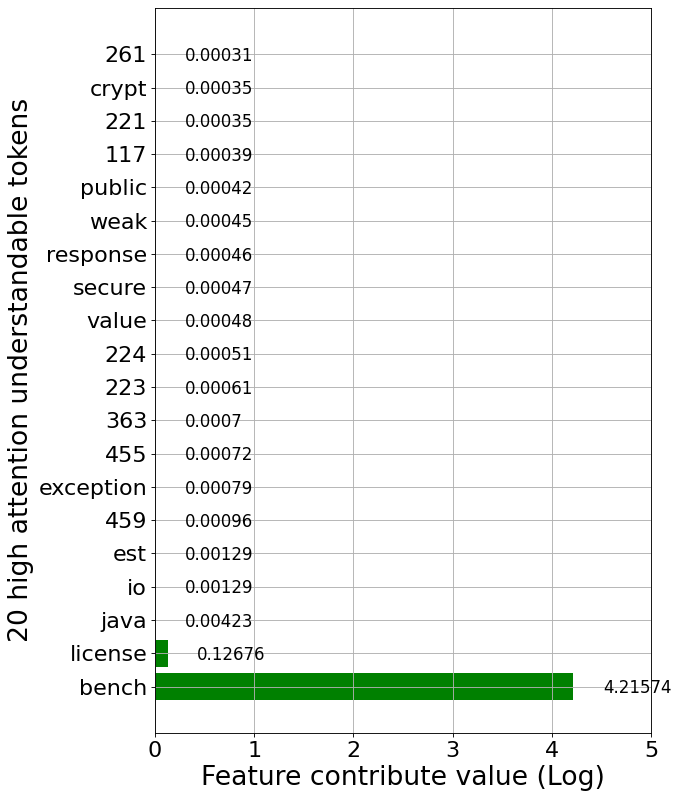

In [ ]:
_mc_fi_dict_sort = dict()
for k,v in mc_fi_dict_sort.items():
  _mc_fi_dict_sort[k]=v*1000
plot_FI_bar(_mc_fi_dict_sort)

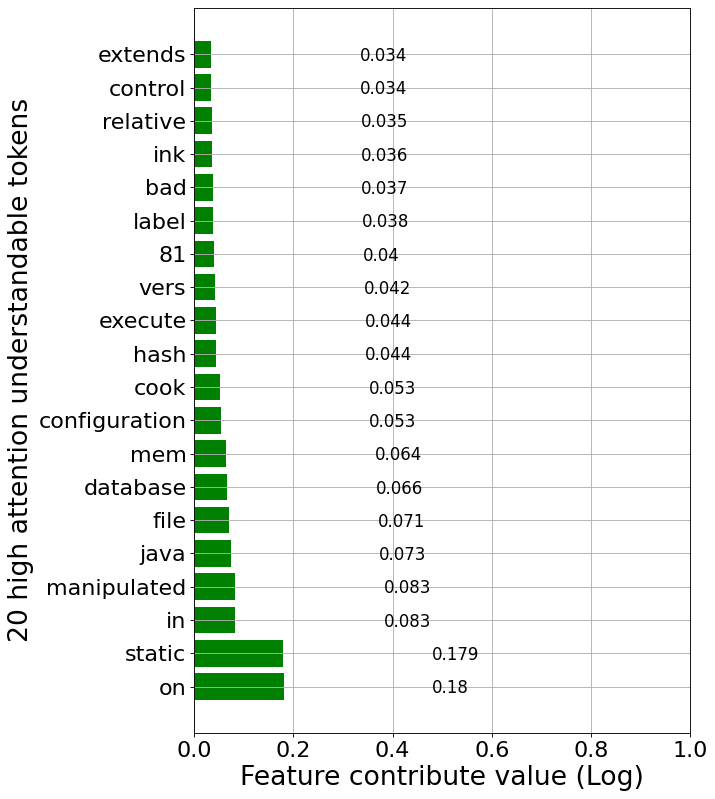

In [ ]:
plot_FI_bar(pd_fi_dict_sort)

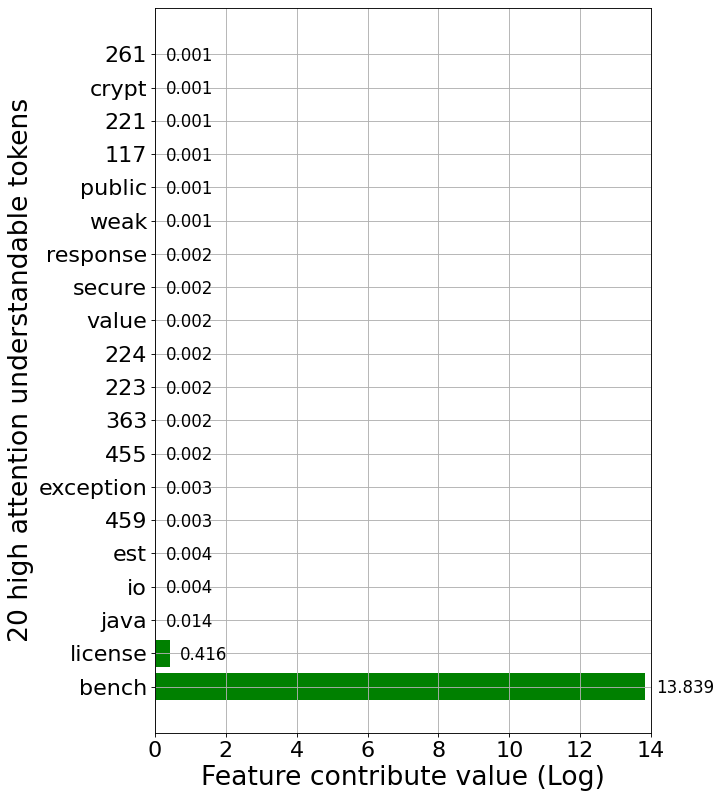

In [ ]:
plot_FI_bar(mc_fi_dict_sort)

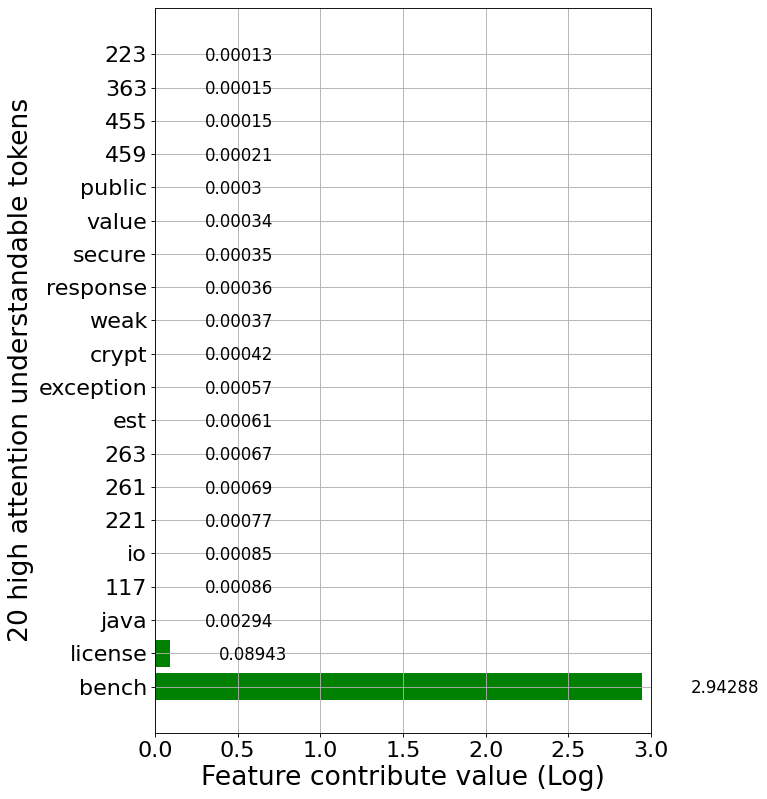

In [ ]:
_pd_fi_dict_sort = dict()
for k,v in pd_fi_dict_sort.items():
  _pd_fi_dict_sort[k]=v*100
plot_FI_bar(_pd_fi_dict_sort)

# Boxplotting of XAI method(From already saved data)

In [ ]:
#Get Top N merge datasets and it's XAI FI.
def get_top_N_merge_dict_and_XAI_FI(raw_xai_data,N=15,XAImethod=get_XAI_FI_dict,log_process=False,_muplti=1000):
    merge_dict = merge_all_dict(cal_preddiff(raw_xai_data))
    mc_fi_dict_sort = XAImethod(merge_dict,log_process = log_process)
    _mc_fi_dict_sort = dict()
    for k,v in mc_fi_dict_sort.items():
        _mc_fi_dict_sort[k]=v*_muplti
        ___mc_fi_dict_sort = dict(list(_mc_fi_dict_sort.items())[:N])
    all_ks = list(___mc_fi_dict_sort.keys())
    d_merged = {k: [merge_dict.get(k)] for k in all_ks}
    return d_merged,___mc_fi_dict_sort,all_ks
d_merged,XAI_ContributeValue,key_list = get_top_N_merge_dict_and_XAI_FI(raw_xai_data,log_process=False)

In [ ]:
XAI_ContributeValue

{'static': 14.469678220475048,
 'manipulated': 8.155763183243895,
 'extends': 3.6585164318134646,
 'field': 1.6601171640428232,
 'on': 0.9589144381940878,
 'database': 0.7053451448970258,
 'description': 0.6313080854026578,
 'java': 0.6111576359243418,
 'file': 0.5102272041284442,
 'configuration': 0.507249076744141,
 'cook': 0.49008215229708246,
 'abstract': 0.488147848770782,
 'vers': 0.42978813865896315,
 'system': 0.39951884747864747,
 'relative': 0.36849021261044573}

In [ ]:
key_list

['static',
 'manipulated',
 'extends',
 'field',
 'on',
 'database',
 'description',
 'java',
 'file',
 'configuration',
 'cook',
 'abstract',
 'vers',
 'system',
 'relative']

In [ ]:
key_list = [item for item in key_list if not item.isdigit()]
key_list

['static',
 'manipulated',
 'extends',
 'field',
 'on',
 'database',
 'description',
 'java',
 'file',
 'configuration',
 'cook',
 'abstract',
 'vers',
 'system',
 'relative']

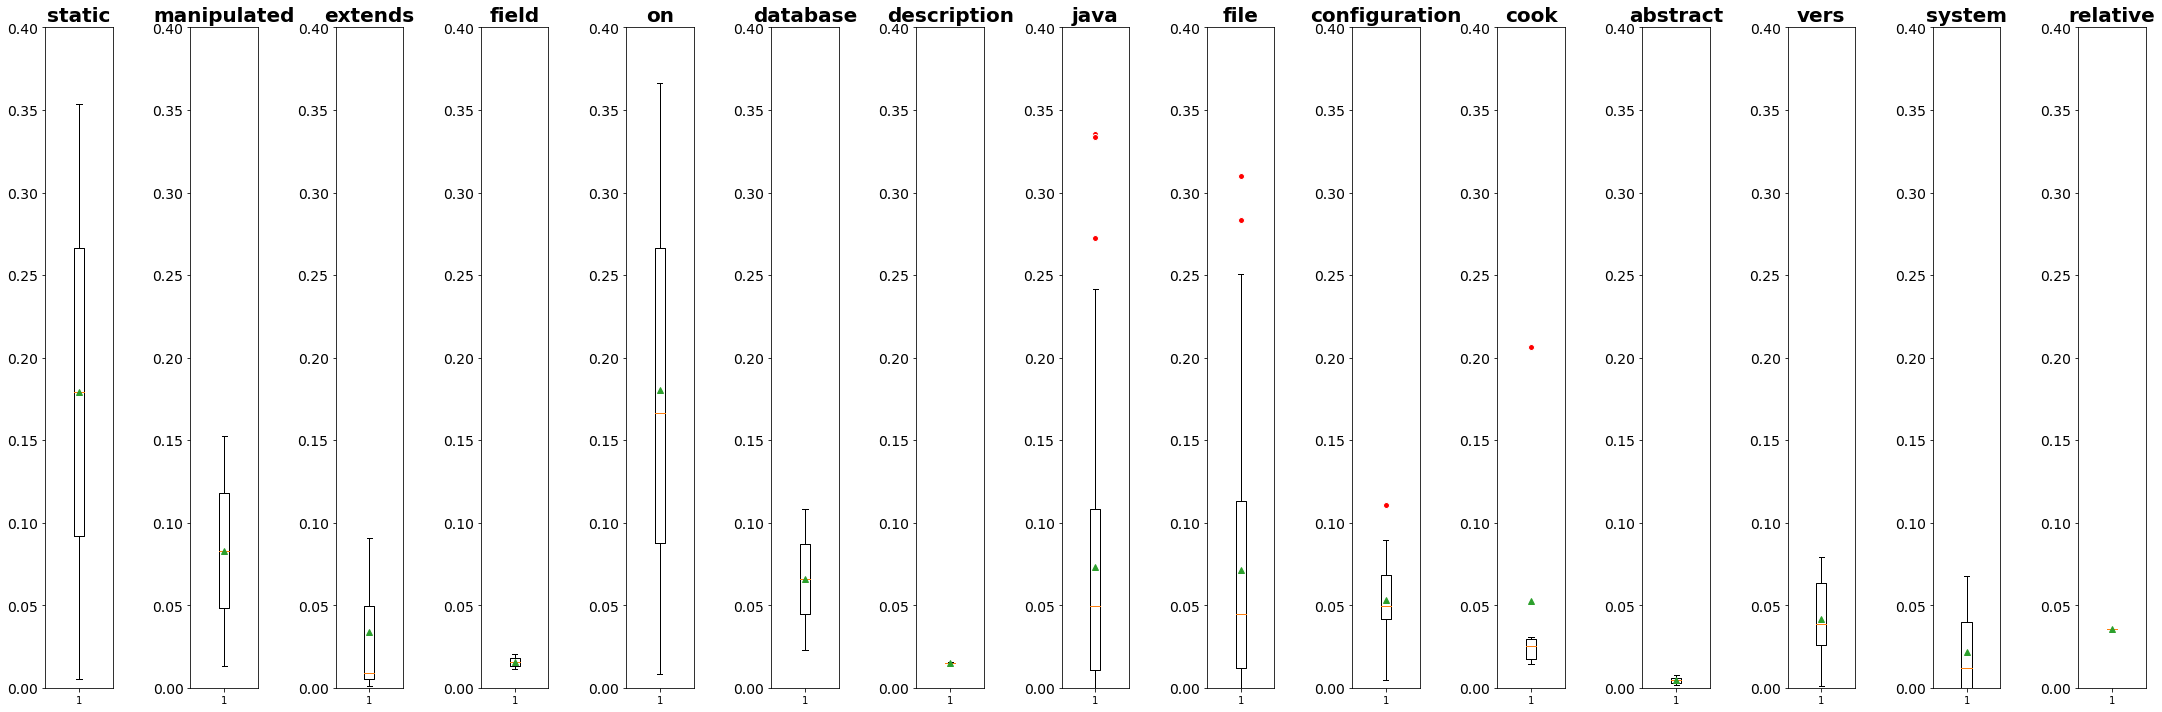

In [ ]:
fig, axs = plt.subplots(1, len(key_list), figsize=(30,10))

#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

for i, ax in enumerate(axs.flat):
    ax.boxplot(d_merged[key_list[i]][0][:,0], flierprops=red_circle,showmeans=True)
    ax.set_title(key_list[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(0, 0.4)
plt.tight_layout()

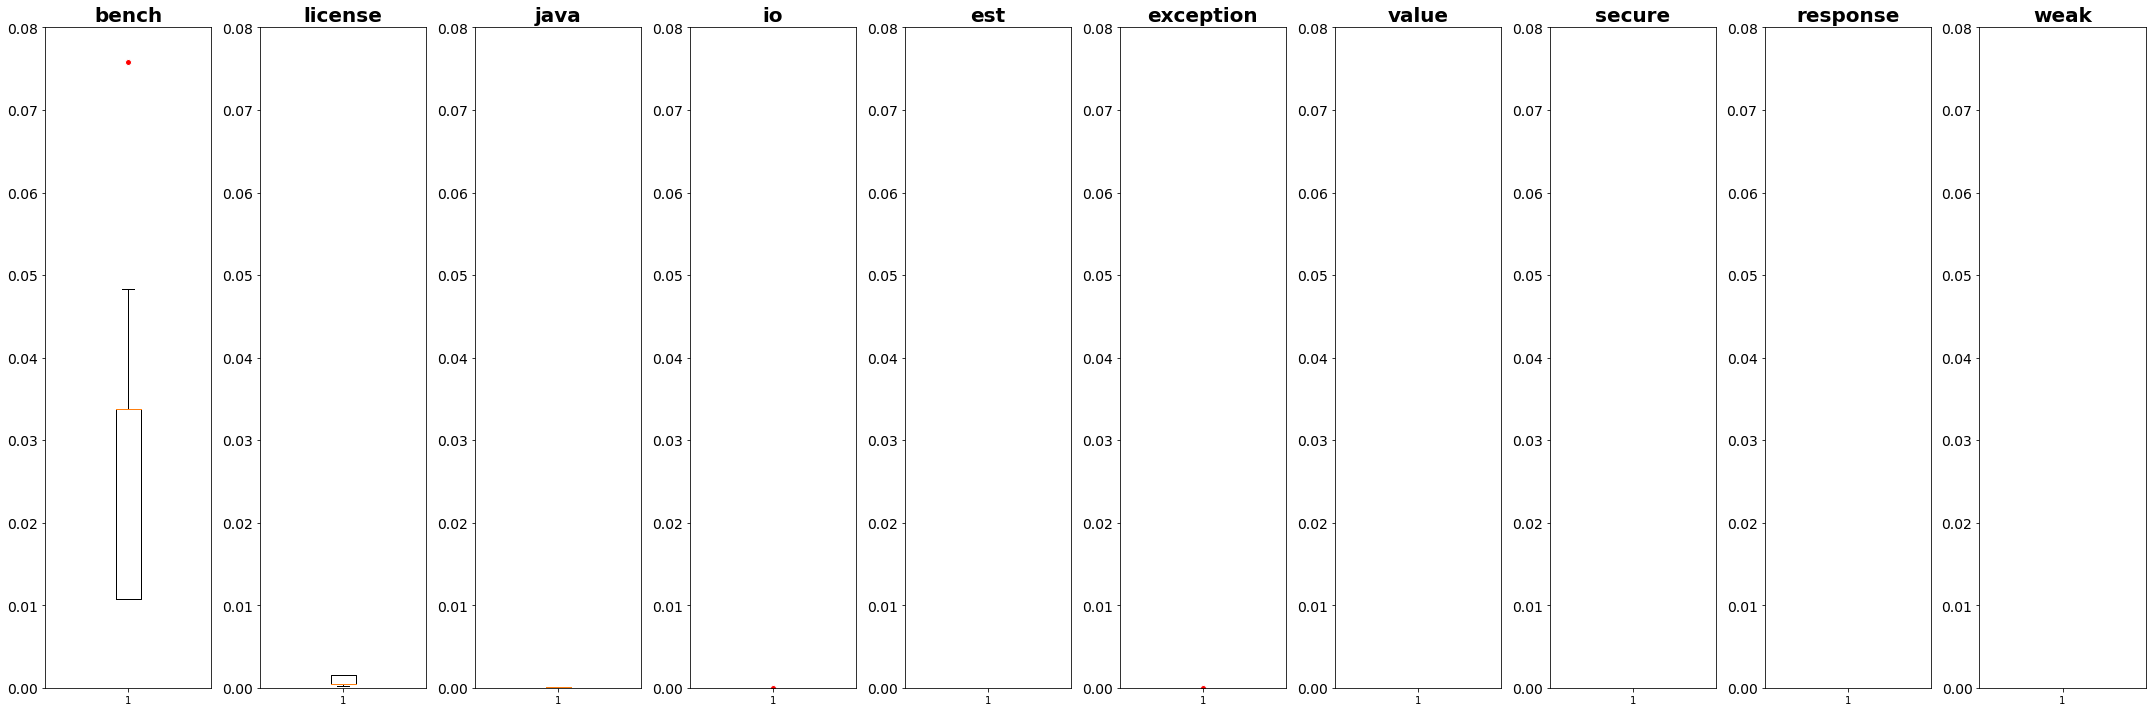

In [ ]:


fig, axs = plt.subplots(1, len(key_list), figsize=(30,10))

#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

for i, ax in enumerate(axs.flat):
    ax.boxplot(d_merged[key_list[i]][0][:,0], flierprops=red_circle)
    ax.set_title(key_list[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(0, 0.08)
plt.tight_layout()

In [ ]:
#Juliet
output_dir = '/content/drive/My Drive/codev/'
name_dir = output_dir+'juliet_xai_results.json'
f = open(name_dir)
raw_xai_data = json.load(f)
f.close()


In [ ]:
d_merged,XAI_ContributeValue,key_list = get_top_N_merge_dict_and_XAI_FI(raw_xai_data,10,get_pd_FI_dict,log_process=False,_muplti=1)

In [ ]:
XAI_ContributeValue #MC

{'static': 0.014469678220475048,
 'manipulated': 0.008155763183243896,
 'extends': 0.0036585164318134644,
 'field': 0.0016601171640428232,
 'on': 0.0009589144381940878,
 'database': 0.0007053451448970258,
 'description': 0.0006313080854026578,
 'java': 0.0006111576359243418,
 'file': 0.0005102272041284442,
 'configuration': 0.000507249076744141}

In [ ]:
XAI_ContributeValue #PD

{'on': 0.18037113547325134,
 'static': 0.1793370246887207,
 'in': 0.08317530155181885,
 'manipulated': 0.08291244506835938,
 'java': 0.07330485041204252,
 'file': 0.07107302161955065,
 'database': 0.06585508584976196,
 'mem': 0.06424769488247958,
 'configuration': 0.05331916809082031,
 'cook': 0.052789260943730675}

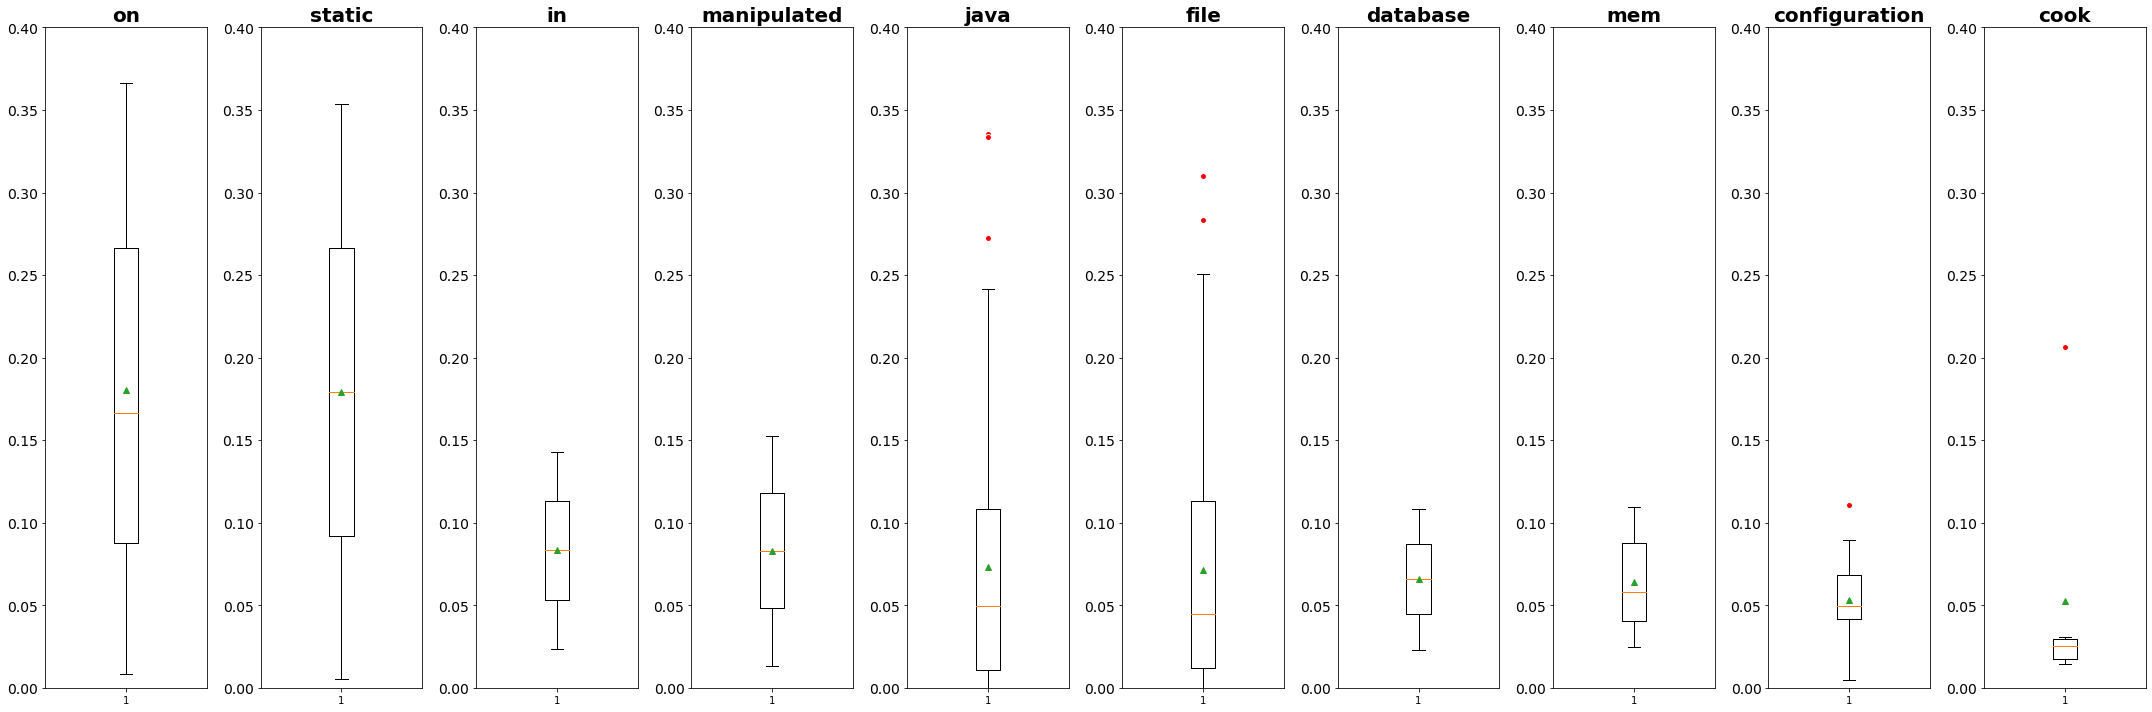

In [ ]:
fig, axs = plt.subplots(1, len(key_list), figsize=(30,10))

#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

for i, ax in enumerate(axs.flat):
    ax.boxplot(d_merged[key_list[i]][0][:,0], flierprops=red_circle,showmeans=True)
    ax.set_title(key_list[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(0, 0.4)
plt.tight_layout()

In [ ]:
#Drapper
output_dir = '/content/drive/My Drive/codev/drapper/'
name_dir = output_dir+'drapper_xai_results.json'
f = open(name_dir)
raw_xai_data = json.load(f)
f.close()


In [ ]:
d_merged,XAI_ContributeValue,key_list = get_top_N_merge_dict_and_XAI_FI(raw_xai_data,30,get_pd_FI_dict,log_process=False,_muplti=1)

In [ ]:
key_list[:5]

['oo', 'hand', 'errors', 'layer', 'gi']

In [ ]:
key_list = ['hand','errors','layer','help','run','i','checks','loop','loc','test','valid','encode','write']

In [ ]:
d_merged

{'oo': [array([[ 0.14933503, -0.74550825]])],
 'hand': [array([[ 0.16208971, -0.71498877],
         [ 0.12848961, -0.57155371]])],
 'errors': [array([[ 0.14142379, -0.51481122]])],
 'layer': [array([[ 0.13526493, -0.49056226]])],
 'gi': [array([[ 0.12007326, -0.69151348]])],
 'help': [array([[ 0.11421579, -0.78801692]])],
 'mach': [array([[ 0.1098119 , -0.52735811]])],
 'run': [array([[ 0.10419619, -0.63234806]])],
 'rent': [array([[ 0.09996998, -0.73566526]])],
 'a': [array([[ 0.04422992, -0.71193844],
         [ 0.12346244, -0.80662251],
         [ 0.33096516, -0.82038057],
         [ 0.00516295, -0.63897091],
         [ 0.05269709, -0.49056226],
         [ 0.03635144, -0.42634627]])],
 'adapter': [array([[ 0.09717911, -0.77673393]])],
 'i': [array([[ 0.0313254 , -0.60953736],
         [ 0.02073705, -0.69151348],
         [ 0.17939299, -0.63771874],
         [ 0.10954702, -0.89494991],
         [ 0.22751668, -0.70759088],
         [ 0.0939953 , -0.40642655],
         [ 0.04853582, -0

In [ ]:
XAI_ContributeValue

{'oo': 0.14933502674102783,
 'hand': 0.14528965950012207,
 'errors': 0.1414237916469574,
 'layer': 0.13526493310928345,
 'gi': 0.12007325887680054,
 'help': 0.11421579122543335,
 'mach': 0.10981190204620361,
 'run': 0.10419619083404541,
 'rent': 0.09996998310089111,
 'a': 0.0988115022579829,
 'adapter': 0.097179114818573,
 'i': 0.09645429253578186,
 'checks': 0.0961175262928009,
 'mma': 0.09611466526985168,
 'alt': 0.08961084485054016,
 'loop': 0.08936446905136108,
 'bat': 0.08754393458366394,
 'flo': 0.08530241250991821,
 'direct': 0.08228182792663574,
 'ge': 0.080400417248408}

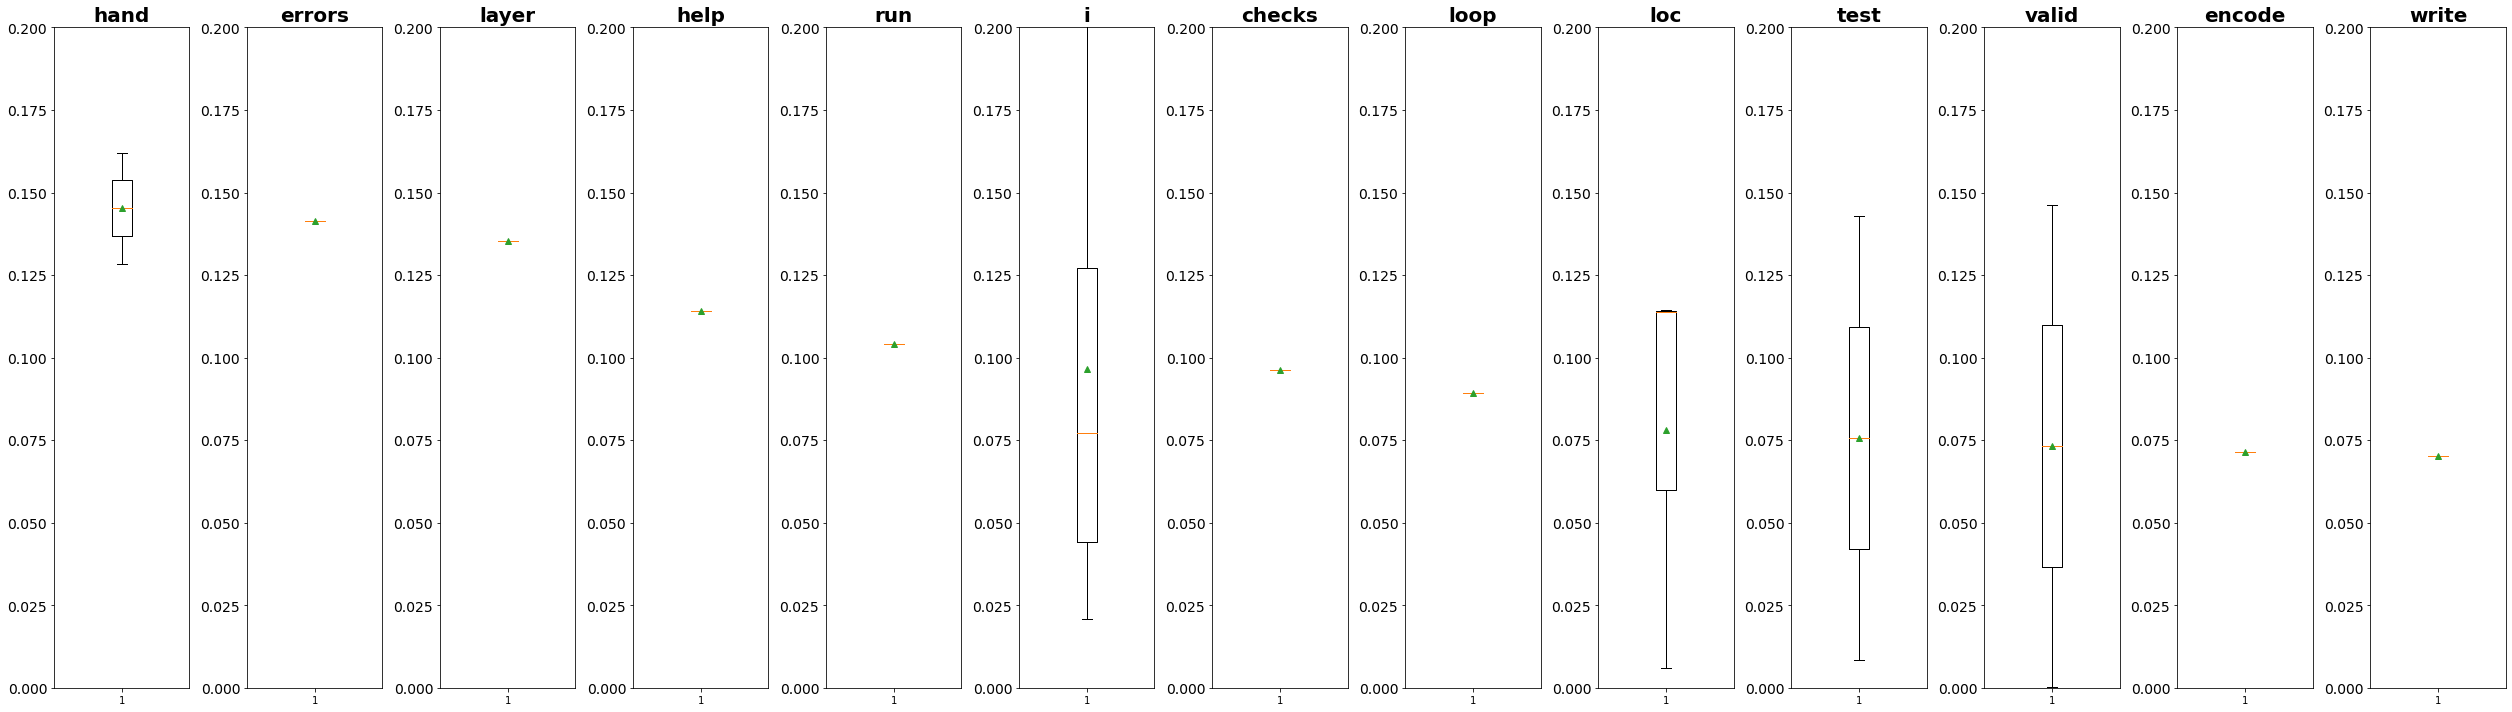

In [ ]:
fig, axs = plt.subplots(1, len(key_list), figsize=(35,10))

#Creating subplot of each column with its own scale
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

for i, ax in enumerate(axs.flat):
    ax.boxplot(d_merged[key_list[i]][0][:,0], flierprops=red_circle,showmeans=True)
    ax.set_title(key_list[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    ax.set_ylim(0, 0.2)
plt.tight_layout()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, transformers
os.path.dirname(transformers.__file__)

'/usr/local/lib/python3.7/dist-packages/transformers'

In [ ]:
from transformers import AutoModel, AutoTokenizer

MODEL_NAME = 'xlnet-base-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:

def clear_data(x):
    # return [d.replace('\n', '') for d in x]
    return x
code = clear_data(dev_df['sentence'][0:3])

In [ ]:
mask_padding_with_zero=True
pad_token_segment_id=0
pad_on_left=False
pad_token=0

test_sentence=code[0]
#test_sentence='我认识他，他不认识我'

max_length=len(test_sentence)
inputs = tokenizer.encode_plus(test_sentence,None,add_special_tokens=True,max_length=max_length)
input_ids, token_type_ids = inputs["input_ids"], inputs["token_type_ids"]


attention_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

padding_length = max_length - len(input_ids)

#print(input_ids) #单词在词典中的编码
#print(token_type_ids)#区分两个句子的编码(上句全为0，下句全为1)
#print(attention_mask)#指定对那些词进行self-attention操作

if pad_on_left:
    input_ids = ([pad_token] * padding_length) + input_ids
    attention_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + attention_mask
    token_type_ids = ([pad_token_segment_id] * padding_length) + token_type_ids
else:
    input_ids = input_ids + ([pad_token] * padding_length)
    attention_mask = attention_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
    token_type_ids = token_type_ids + ([pad_token_segment_id] * padding_length)


print(input_ids) #单词在词典中的编码
print(token_type_ids)#区分两个句子的编码(上句全为0，下句全为1)
print(attention_mask)#指定对那些词进行self-attention操作

import torch
input_ids=torch.tensor([input_ids])
attention_mask=torch.tensor([attention_mask])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


[17, 167, 8652, 430, 8513, 15407, 4697, 457, 27791, 30905, 417, 430, 9726, 323, 21020, 17, 23826, 695, 11892, 6723, 60, 225, 27369, 2732, 5821, 138, 2732, 11871, 7257, 212, 2732, 2732, 20009, 8938, 2732, 5184, 2732, 8025, 9, 20753, 25389, 27639, 11892, 60, 225, 27369, 2732, 5821, 138, 2732, 11871, 7257, 212, 9, 24366, 9, 469, 12813, 17, 28952, 11892, 60, 1675, 13, 23, 11562, 13, 5184, 2732, 8025, 9, 46, 98, 6563, 9, 20753, 6940, 167, 17, 167, 8652, 6940, 17, 13304, 620, 19143, 6940, 17, 27369, 11943, 29694, 212, 6940, 5529, 27030, 60, 3528, 4332, 527, 40, 24, 3528, 6940, 2803, 27030, 60, 79, 500, 23253, 4905, 6940, 8365, 3992, 60, 828, 23924, 6940, 5529, 83, 11562, 17, 60, 116, 22920, 6940, 27572, 16632, 1444, 60, 11177, 5124, 3022, 60, 527, 1400, 25, 24, 17456, 22, 48, 9952, 2175, 6940, 6940, 6940, 167, 2508, 934, 9417, 23, 9, 2732, 27369, 2732, 5821, 138, 2732, 11871, 7257, 212, 97, 6753, 934, 9417, 21891, 9, 8652, 97, 6753, 17, 20753, 9, 1888, 9, 8652, 97, 6753, 17, 20753, 469, 9, 9

In [ ]:
token_list = []
for idx in [17, 167, 8652, 430, 8513, 15407, 4697, 457, 27791, 30905, 417, 430, 9726, 323, 21020, 17, 23826, 695, 11892, 6723, 60, 225, 27369, 2732, 5821, 138, 2732, 11871, 7257, 212, 2732, 2732, 20009, 8938, 2732, 5184, 2732, 8025, 9, 20753, 25389, 27639, 11892, 60, 225, 27369, 2732, 5821, 138, 2732, 11871, 7257, 212, 9, 24366, 9, 469, 12813, 17, 28952, 11892, 60, 1675, 13, 23, 11562, 13, 5184, 2732, 8025, 9, 46, 98, 6563, 9, 20753, 6940, 167, 17, 167, 8652, 6940, 17, 13304, 620, 19143, 6940, 17, 27369, 11943, 29694, 212, 6940, 5529, 27030, 60, 3528, 4332, 527, 40, 24, 3528, 6940, 2803, 27030, 60, 79, 500, 23253, 4905, 6940, 8365, 3992, 60, 828, 23924, 6940, 5529, 83, 11562, 17, 60, 116, 22920, 6940, 27572, 16632, 1444, 60, 11177, 5124, 3022, 60, 527, 1400, 25, 24, 17456, 22, 48, 9952, 2175, 6940, 6940, 6940, 167, 2508, 934, 9417, 23, 9, 2732, 27369, 2732, 5821, 138, 2732, 11871, 7257, 212, 97, 6753, 934, 9417, 21891, 9, 8652, 97, 6753, 17, 20753, 9, 1888, 9, 8652, 97, 6753, 17, 20753, 469, 9, 9977, 3214, 9, 27072, 9, 8652, 97, 6753, 17, 20753, 9, 19326, 9, 22498, 9, 3780, 6809, 97, 281, 1075, 225, 27369, 2732, 5821, 138, 2732, 11871, 7257, 212, 2732, 2732, 20009, 8938, 2732, 5184, 2732, 8025, 11366, 225, 27369, 2732, 5821, 138, 2732, 11871, 7257, 212, 2732, 2732, 20009, 8938, 2732, 5184, 2732, 8938, 17, 17115, 281, 14129, 809, 10, 4436, 2154, 527, 17, 11, 12406, 23229, 386, 17, 17115, 19991, 5988, 97, 108, 10, 30163, 9, 5671, 5370, 1371, 982, 10, 12, 1575, 9, 6723, 12, 11, 9, 261, 7519, 6406, 323, 6325, 10, 11, 9, 21376, 7357, 10, 12, 3305, 12, 11, 17, 3151, 5383, 700, 11, 17, 17115, 17, 167, 8652, 926, 31, 2855, 6940, 167, 5988, 5847, 17, 12, 323, 60, 17666, 17666, 499, 7810, 23, 17666, 17666, 12, 97, 17, 22891, 1104, 17, 17115, 17, 167, 8652, 926, 31, 555, 13, 967, 153, 9493, 23, 6940, 167, 5988, 5847, 17, 12, 167, 7206, 167, 14401, 167, 499, 7810, 23, 167, 12, 97, 17, 22891, 108, 17, 10, 20009, 17, 136, 5383, 19092, 11, 17, 17115, 17, 167, 8652, 17, 7131, 24728, 29030, 1039, 17, 4593, 11803, 60, 116, 22920, 20, 2147, 5238, 254, 2120, 991, 6940, 167, 11892, 1450, 5847, 109, 11892, 10, 11539, 12677, 527, 11, 97, 11892, 1246, 4354, 16743, 4957, 23924, 1246, 4354, 83, 11562, 5847, 19092, 97, 67, 4354, 16743, 19540, 118, 6195, 1246, 4354, 16743, 83, 11562, 5847, 19092, 97, 18189, 7099, 19540, 118, 6195, 698, 23687, 66, 83, 11562, 5847, 19092, 97, 108, 17, 10, 15203, 9, 1506, 2309, 10, 11, 1123, 2536, 1450, 9, 590, 23924, 10, 11, 11, 17, 17115, 714, 17, 17115]:
    token_list.append(tokenizer._convert_id_to_token(idx))
for i in range(146,len(token_list),10):
    print(token_list[i:i+10])

['▁package', '▁test', 'case', 's', '.', '_', 'Relative', '_', 'Pa', 'th']
['_', 'Tra', 'vers', 'al', ';', '▁import', '▁test', 'case', 'support', '.']
['*', ';', '▁import', '▁', 'java', '.', 'io', '.', '*', ';']
['▁import', '▁', 'java', 'x', '.', 'serv', 'let', '.', 'http', '.']
['*', ';', '▁import', '▁', 'java', '.', 'util', '.', 'logging', '.']
['Le', 'vel', ';', '▁public', '▁class', '▁_', 'Relative', '_', 'Pa', 'th']
['_', 'Tra', 'vers', 'al', '_', '_', 'data', 'base', '_', '81']
['_', 'bad', '▁extends', '▁_', 'Relative', '_', 'Pa', 'th', '_', 'Tra']
['vers', 'al', '_', '_', 'data', 'base', '_', '81', '_', 'base']
['▁', '{', '▁public', '▁void', '▁action', '(', 'St', 'ring', '▁data', '▁']
[')', '▁throws', '▁Throw', 'able', '▁', '{', '▁String', '▁root', ';', '▁if']
['(', 'System', '.', 'get', 'Pro', 'per', 'ty', '(', '"', 'os']
['.', 'name', '"', ')', '.', 'to', 'Lo', 'wer', 'C', 'ase']
['(', ')', '.', 'index', 'Of', '(', '"', 'win', '"', ')']
['▁', '>', '=', '▁0', ')', '▁', '{', '▁', 

In [ ]:
code[0]

'/* TEMPLATE GENERATED TESTCASE FILE\r\nFilename: _Relative_Path_Traversal__database_81_bad.java\r\nLabel Definition File: _Relative_Path_Traversal.label.xml\r\nTemplate File: sources-sink-81_bad.tmpl.java\r\n*/\r\n/*\r\n * @description\r\n *  Relative Path Traversal\r\n * BadSource: database Read data from a database\r\n * GoodSource: A hardcoded string\r\n * Sinks: readFile\r\n *    BadSink : no validation\r\n * Flow Variant: 81 Data flow: data passed in a parameter to an abstract method\r\n *\r\n * */\r\n\r\npackage testcases._Relative_Path_Traversal;\r\n\r\nimport testcasesupport.*;\r\n\r\nimport java.io.*;\r\nimport javax.servlet.http.*;\r\n\r\nimport java.util.logging.Level;\r\n\r\npublic class _Relative_Path_Traversal__database_81_bad extends _Relative_Path_Traversal__database_81_base\r\n{\r\n    public void action(String data ) throws Throwable\r\n    {\r\n\r\n        String root;\r\n        if(System.getProperty("os.name").toLowerCase().indexOf("win") >= 0)\r\n        {\r\n   